# Foundations of Data Mining: Assignment 4

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Deadline:** Thursday, April 12, 2018

In [ ]:
# Please fill in your names here
NAME_STUDENT_1 = ""
NAME_STUDENT_2 = ""

In [3]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

###### Backpropagation (6 points)

Figure 1 illustrates a simple neural network model.

![Figure 1](images/a4_network.png)

It has single input $x$, and three layers with respectively one, two, and one neurons. The activation function of the neurons is ReLU. 

The parameters $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$ (no biases) are initialized to the following values $w_1 = 2, w_2 = 1$, $w_3 = 2$, $w_4 = 4$, and $w_5 = 1$. Implement a single update step of the gradient descent algorithm by hand. Run the update state for the data point $(x=2, y=3)$:

The goal is to model the relationship between two continuous variables. The learning rate is set to $0.1$

Provide the solution in the following format:

- A choice for a loss function 
- Compute graph for training the neural network
- Partial derivative expression for each of the parameters in the model
- The update expression for each of the parameters for each of the data-points
- The final value of all five parameters after the single step in the gradient descent algorithm

The Python code for simple computational graph nodes, as seen in the tutorial session, is provided in the cell below (run the cell to load the code, and again to run the code). Extend the nodes so they can be used to implement the network described above. Implement the network with the same initial weights and the correct learning rate, and verify your hand-made calculations. Add comments to your code or provide a separate description to explain the changes you have made.

In [ ]:
# %load basic_graph.py
'''
Implementations of nodes for a computation graph. Each node
has a forward pass and a backward pass function, allowing
for the evaluation and backpropagation of data.
'''

from abc import ABC, abstractmethod
import math
import time


class Node(object):

    def __init__(self, inputs):
        self.inputs = inputs

    @abstractmethod
    def forward(self):
        ''' Feed-forward the result '''
        raise NotImplementedError("Missing forward-propagation method.")

    @abstractmethod
    def backward(self, d):
        ''' Back-propagate the error
            d is the delta of the subsequent node in the network '''
        raise NotImplementedError("Missing back-propagation method.")


class ConstantNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        pass


class VariableNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        self.output -= 0.1 * d # Gradient Descent


class AdditionNode(Node):

    def forward(self):
        self.output = sum([i.forward() for i in self.inputs])
        return self.output

    def backward(self, d):
        for i in self.inputs:
            i.backward(d)


class MultiplicationNode(Node):

    def forward(self):
        self.output = self.inputs[0].forward() * self.inputs[1].forward()
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.inputs[1].output)
        self.inputs[1].backward(d * self.inputs[0].output)


class MSENode(Node):

    def forward(self):
        self.output = 0.5 * (
            self.inputs[0].forward() - self.inputs[1].forward())**2
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * (self.inputs[0].output - self.inputs[1].output))
        self.inputs[1].backward(d * (self.inputs[1].output - self.inputs[0].output))


class SigmoidNode(Node):

    def forward(self):
        self.output = 1.0 / (1.0 + math.exp(-self.inputs[0].forward()))
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.output * (1.0 - self.output))

class ReLUNode(object):

    def forward(self):
        raise NotImplementedError("Forward pass for ReLU activation node has not been implemented yet.")

    def backward(self, d):
        raise NotImplementedError("Backward pass for ReLU activation node has not been implemented yet.")

class TanhNode(object):

    def forward(self):
        raise NotImplementedError("Forward pass for tanh activation node has not been implemented yet.")

    def backward(self, d):
        raise NotImplementedError("Backward pass for tanh activation node has not been implemented yet.")

# Example graph as shown in MLP lecture slides
class SampleGraph(object):

    def __init__(self, x, y, w, b):
        ''' x: input
            y: expected output
            w: initial weight
            b: initial bias '''
        self.w = VariableNode(w)
        self.b = VariableNode(b)
        self.graph = MSENode([
            AdditionNode([
                MultiplicationNode([
                    ConstantNode(x),
                    self.w
                ]),
                MultiplicationNode([
                    self.b,
                    ConstantNode(1)
                ])
            ]),
            ConstantNode(y)
        ])

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)


class Neuron(Node):

    def __init__(self, inputs, weights, activation):
        ''' weights: list of initial weights, same length as inputs '''
        self.inputs = inputs
        # Initialize a weight for each input
        self.weights = [VariableNode(weight) for weight in weights]
        # Neurons normally have a bias, ignore for this assignment
        #self.bias = VariableNode(bias, "b")

        # Multiplication node for each pair of inputs and weights
        mults = [MultiplicationNode([i, w]) for i, w, in zip(self.inputs, self.weights)]
        # Neurons normally have a bias, ignore for this assignment
        #mults.append(MultiplicationNode([self.bias, ConstantNode(1)]))

        # Sum all multiplication results
        added = AdditionNode(mults)

        # Apply activation function
        if activation == 'sigmoid':
            self.graph = SigmoidNode([added])
        elif activation == 'relu':
            self.graph = ReLUNode([added])
        elif activation == 'tanh':
            self.graph = TanhNode([added])
        else:
            raise ValueError("Unknown activation function.")

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)

    def set_weights(self, new_weights):
        for i in len(new_weights):
            self.weights[i].output = new_weights[i]

    def get_weights(self):
        return [weight.output for weight in self.weights]

if __name__ == '__main__':
    print("Loaded simple graph nodes")

    # Example network
    #sg = SampleGraph(2, 2, 2, 1)
    #prediction = sg.forward()
    #print("Initial prediction is", prediction)
    #sg.backward(1)
    #print("w has new value", sg.w.output)
    #print("b has new value", sg.b.output)

    # Run your network here

## Training Deep Models (3 points)

The model in the example code below performs poorly as its depth increases. Train this model on the MNIST digit detection task. 

Examine its training performance by gradually increasing its depth:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Modify the model such that you improve its performance when its depth increases. Train the new model again for the different depths:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Submit an explanation for the limitation of the original model. Explain your modification. 
Submit your code and 6 plots (can be overlaid) for the training performance of both models with different depths. 



In [4]:
# (You don't need to change this part of the code)
from __future__ import print_function
import numpy as np
np.random.seed(1234)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils


import matplotlib.pyplot as plt

batch_size = 128
nb_classes = 90
nb_epoch = 10

Using TensorFlow backend.


In [65]:
# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


In [66]:
# Use this parameter to change the depth of the model
number_hidden_layers = 1  # Number of hidden layers

In [67]:
# Model
model = Sequential()
model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
model.add(Dropout(0.2))

while number_hidden_layers > 1:
    model.add(Dense(512))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    number_hidden_layers -= 1


model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_14 (Activation)   (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Training (You don't need to change this part of the code)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

c:\users\bramv\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


ValueError: Error when checking target: expected activation_14 to have shape (10,) but got array with shape (90,)

## MNIST Calculator (6 points)

During the lectures you have seen a CNN model that can be successfully trained to classify the MNIST images. You have also seen how a RNN model that can be trained to implement addition of two numbers. You now need to build a model that is a combination of convolutional layers and recurrent cells. 

Using the KERAS library, design and train a model that produces a sum of a sequence of MNIST images. More specifically, the model should input a sequence of 10 images and compute the cumulative sum of the digits represented by the images.

For example:

Input 1: ![294](images/a3ex1.png)

Output 1: 46

Input 2: ![61](images/a3ex2.png)

Output 2: 43

Your solutions should include:
- Python code that formats the MNIST dataset such that it can be used for traning and testing your model
- Implementation in keras of your model (for training and testing)
- Performance on the model on test data
- Justification (in text) of your decisions for the model architecture (type of layers, activation functions, loss function, regularization and training hyperparameters)

Note: Use the 60000/10000 train/test split of the MNIST dataset


In [3]:
# Provide your solution here

# Imports
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Conv1D, Dense, TimeDistributed, Activation
#from keras import layers 
from keras import backend as K

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import numpy as np

# Training parameters
batch_size = 12
num_classes = 90
num_images = 10
epochs = 12

TRAINING_SIZE = 6000
TESTING_SIZE = 1000

In [50]:
from keras.layers import Layer

class Round(Layer):
    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

(60000, 28, 28) train samples
(10000, 28, 28) test samples


(36000, 10, 784) train samples
(1000, 10, 784) test samples


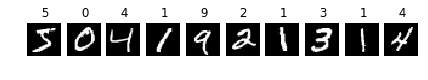

In [4]:
# Data preparation

# Input image dimensions
img_rows, img_cols = 28, 28

# The data, shuffled and split between train and test sets
(x_train_in, y_train_in), (x_test_in, y_test_in) = mnist.load_data()

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x_train_in[i], cmap='gray', interpolation='none')
    plt.title(" {}".format(y_train_in[i]))

x_train_in = x_train_in.astype('float32')
x_test_in = x_test_in.astype('float32')
x_train_in /= 255
x_test_in /= 255
    
print(x_train_in.shape, 'train samples')
print(x_test_in.shape, 'test samples')

randomRepetitions = 5

# build training set
x_train = np.zeros((TRAINING_SIZE*(randomRepetitions+1), num_images,img_cols * img_rows), dtype=np.float)
y_train = np.zeros(TRAINING_SIZE*(randomRepetitions+1))
for j in range(TRAINING_SIZE):    

    #just split training images in pairs of 10 images
    for i in range(num_images):

        index = (num_images*j)+i
        x_temp = x_train_in[index] # select next image
        x_temp = x_temp.reshape(1, img_cols * img_rows) # flatten the image
        x_train[j][i]= x_temp
        y_train[j] += y_train_in[index]
        
    # make random combinations of training images  
    for k in range(randomRepetitions):
        for i in range(num_images):

            index = np.random.randint(0, TRAINING_SIZE-1)
            x_temp = x_train_in[index] # select next image
            x_temp = x_temp.reshape(1, img_cols * img_rows) # flatten the image
            x_train[j+TRAINING_SIZE+k*TRAINING_SIZE][i]= x_temp
            y_train[j+TRAINING_SIZE+k*TRAINING_SIZE] += y_train_in[index]      

# build test set
x_test = np.zeros((TESTING_SIZE, num_images, img_cols * img_rows), dtype=np.float)
y_test = np.zeros(TESTING_SIZE)
for j in range(TESTING_SIZE):    
    
    for i in range(num_images):
        #x_temp = x_train_in[np.random.randint(0, TRAINING_SIZE)] # select a random image
        index = (num_images*j)+i
        x_temp = x_test_in[index] # select next image
        x_temp = x_temp.reshape(1, img_cols * img_rows) # flatten the image
        x_test[j][i] = x_temp
        y_test[j]+= y_test_in[index]
    
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

# Convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = keras.utils.to_categorical(y_train, 90)
y_test = keras.utils.to_categorical(y_test, 90)

In [1]:
# 5% scoring model
RNN = layers.LSTM
HIDDEN_SIZE = 256
BATCH_SIZE = 128
LAYERS = 1 # need to do 9 additions
MAXLEN = 10


# Model definition
model = Sequential()

# use convolution to look at each image seperately, 10 digits -> 10 dimensions?
model.add(Conv1D(10,img_cols * img_rows, strides=img_cols * img_rows,padding='same',input_shape=x_train.shape[1:])) 

#model.add(Dense(HIDDEN_SIZE, activation='relu', input_shape=x_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))        
model.add(Dense(10, activation='relu'))
#model.add(RNN(HIDDEN_SIZE, input_shape=(10,30)))
          
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
#model.add(Dense(10, activation='softmax')) # 10 digits
model.add(Flatten())
model.add(layers.RepeatVector(10)) # do this for all 10 digits?
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    #model.add(Dense(128, activation='relu'))
    model.add(RNN(128, return_sequences=True))
    
# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(90))) # maximum sum


model.add(Flatten())
#model.add(Dense(90, activation='relu'))
model.add(Dense(1, activation=K.relu))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

NameError: name 'layers' is not defined

In [5]:
# 5% scoring model
RNN = layers.LSTM
HIDDEN_SIZE = 256
BATCH_SIZE = 128
LAYERS = 1 # need to do 9 additions
MAXLEN = 10



# Model definition
model = Sequential()

# use convolution to look at each image seperately, 10 digits -> 10 dimensions?
#model.add(Conv1D(10,img_cols * img_rows, strides=img_cols * img_rows,padding='same',input_shape=x_train.shape[1:])) 

#model.add(Dense(HIDDEN_SIZE, activation='relu', input_shape=x_train.shape[1:]))
model.add(Dense(784, input_shape=(10,784), activation='relu'))
model.add(Dropout(0.2))    # lowered dropout to reduce overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(10, activation='sigmoid')) # get a value between 1 - 10 for each of the 10 images
#model.add(RNN(HIDDEN_SIZE, input_shape=(10,30)))
          
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
#model.add(Dense(10, activation='softmax')) # 10 digits
model.add(Flatten())
model.add(layers.RepeatVector(2)) # do this for all 10 digits? or maximum length 2 (90)
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    #model.add(Dense(128, activation='relu'))
    model.add(RNN(128, return_sequences=True))
    
# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(10))) # need to sum 10 elements


model.add(Flatten())
model.add(Dense(90, activation='softmax'))
#model.add(Dense(1, activation=K.relu))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 784)           615440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 784)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 128)           100480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 10, 10)            1290      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 100)            0         
__________

In [6]:
# Training loop
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test)) 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Train on 36000 samples, validate on 1000 samples
Epoch 1/20


   12/36000 [..............................] - ETA: 1:58:30 - loss: 4.5033 - acc: 0.0000e+00

   60/36000 [..............................] - ETA: 24:19 - loss: 4.5171 - acc: 0.0000e+00  

  108/36000 [..............................] - ETA: 13:48 - loss: 4.4891 - acc: 0.0000e+00

  156/36000 [..............................] - ETA: 9:45 - loss: 4.4652 - acc: 0.0128     

  204/36000 [..............................] - ETA: 7:36 - loss: 4.4542 - acc: 0.0245

  252/36000 [..............................] - ETA: 6:16 - loss: 4.4240 - acc: 0.0437

  300/36000 [..............................] - ETA: 5:22 - loss: 4.4141 - acc: 0.0433

  348/36000 [..............................] - ETA: 4:42 - loss: 4.3888 - acc: 0.0460

  396/36000 [..............................] - ETA: 4:13 - loss: 4.3672 - acc: 0.0455

  444/36000 [..............................] - ETA: 3:49 - loss: 4.3227 - acc: 0.0473

  492/36000 [..............................] - ETA: 3:30 - loss: 4.3064 - acc: 0.0447

  540/36000 [..............................] - ETA: 3:15 - loss: 4.2839 - acc: 0.0407

  588/36000 [..............................] - ETA: 3:02 - loss: 4.2563 - acc: 0.0425

  636/36000 [..............................] - ETA: 2:51 - loss: 4.2241 - acc: 0.0456

  684/36000 [..............................] - ETA: 2:42 - loss: 4.1999 - acc: 0.0482

  732/36000 [..............................] - ETA: 2:33 - loss: 4.1724 - acc: 0.0478

  780/36000 [..............................] - ETA: 2:26 - loss: 4.1562 - acc: 0.0462

  828/36000 [..............................] - ETA: 2:20 - loss: 4.1411 - acc: 0.0447

  876/36000 [..............................] - ETA: 2:14 - loss: 4.1167 - acc: 0.0457

  924/36000 [..............................] - ETA: 2:09 - loss: 4.1030 - acc: 0.0455

  972/36000 [..............................] - ETA: 2:05 - loss: 4.0835 - acc: 0.0442

 1020/36000 [..............................] - ETA: 2:00 - loss: 4.0631 - acc: 0.0431

 1068/36000 [..............................] - ETA: 1:57 - loss: 4.0588 - acc: 0.0431

 1116/36000 [..............................] - ETA: 1:53 - loss: 4.0422 - acc: 0.0412

 1164/36000 [..............................] - ETA: 1:50 - loss: 4.0287 - acc: 0.0438

 1212/36000 [>.............................] - ETA: 1:47 - loss: 4.0156 - acc: 0.0429

 1260/36000 [>.............................] - ETA: 1:44 - loss: 4.0006 - acc: 0.0429

 1308/36000 [>.............................] - ETA: 1:42 - loss: 3.9848 - acc: 0.0428

 1356/36000 [>.............................] - ETA: 1:39 - loss: 3.9715 - acc: 0.0428

 1404/36000 [>.............................] - ETA: 1:37 - loss: 3.9589 - acc: 0.0427

 1452/36000 [>.............................] - ETA: 1:35 - loss: 3.9577 - acc: 0.0427

 1500/36000 [>.............................] - ETA: 1:33 - loss: 3.9498 - acc: 0.0413

 1548/36000 [>.............................] - ETA: 1:31 - loss: 3.9399 - acc: 0.0413

 1596/36000 [>.............................] - ETA: 1:29 - loss: 3.9315 - acc: 0.0414

 1644/36000 [>.............................] - ETA: 1:28 - loss: 3.9283 - acc: 0.0420

 1692/36000 [>.............................] - ETA: 1:26 - loss: 3.9233 - acc: 0.0420

 1740/36000 [>.............................] - ETA: 1:25 - loss: 3.9195 - acc: 0.0425

 1788/36000 [>.............................] - ETA: 1:23 - loss: 3.9086 - acc: 0.0419

 1836/36000 [>.............................] - ETA: 1:22 - loss: 3.9061 - acc: 0.0414

 1884/36000 [>.............................] - ETA: 1:21 - loss: 3.8999 - acc: 0.0414

 1932/36000 [>.............................] - ETA: 1:20 - loss: 3.8925 - acc: 0.0414

 1980/36000 [>.............................] - ETA: 1:19 - loss: 3.8875 - acc: 0.0414

 2028/36000 [>.............................] - ETA: 1:18 - loss: 3.8833 - acc: 0.0419

 2076/36000 [>.............................] - ETA: 1:17 - loss: 3.8817 - acc: 0.0414

 2124/36000 [>.............................] - ETA: 1:16 - loss: 3.8770 - acc: 0.0410

 2172/36000 [>.............................] - ETA: 1:15 - loss: 3.8725 - acc: 0.0414

 2220/36000 [>.............................] - ETA: 1:14 - loss: 3.8660 - acc: 0.0414

 2268/36000 [>.............................] - ETA: 1:13 - loss: 3.8643 - acc: 0.0406

 2316/36000 [>.............................] - ETA: 1:12 - loss: 3.8576 - acc: 0.0397

 2364/36000 [>.............................] - ETA: 1:11 - loss: 3.8560 - acc: 0.0389

 2412/36000 [=>............................] - ETA: 1:10 - loss: 3.8568 - acc: 0.0390

 2460/36000 [=>............................] - ETA: 1:10 - loss: 3.8542 - acc: 0.0382

 2508/36000 [=>............................] - ETA: 1:09 - loss: 3.8520 - acc: 0.0379

 2556/36000 [=>............................] - ETA: 1:08 - loss: 3.8491 - acc: 0.0383

 2604/36000 [=>............................] - ETA: 1:08 - loss: 3.8432 - acc: 0.0384

 2652/36000 [=>............................] - ETA: 1:07 - loss: 3.8385 - acc: 0.0388

 2700/36000 [=>............................] - ETA: 1:06 - loss: 3.8354 - acc: 0.0385

 2748/36000 [=>............................] - ETA: 1:06 - loss: 3.8319 - acc: 0.0397

 2796/36000 [=>............................] - ETA: 1:05 - loss: 3.8306 - acc: 0.0397

 2844/36000 [=>............................] - ETA: 1:04 - loss: 3.8295 - acc: 0.0397

 2892/36000 [=>............................] - ETA: 1:04 - loss: 3.8279 - acc: 0.0398

 2940/36000 [=>............................] - ETA: 1:03 - loss: 3.8223 - acc: 0.0401

 2988/36000 [=>............................] - ETA: 1:03 - loss: 3.8199 - acc: 0.0402

 3036/36000 [=>............................] - ETA: 1:02 - loss: 3.8180 - acc: 0.0399

 3084/36000 [=>............................] - ETA: 1:02 - loss: 3.8171 - acc: 0.0402

 3132/36000 [=>............................] - ETA: 1:01 - loss: 3.8163 - acc: 0.0399

 3180/36000 [=>............................] - ETA: 1:01 - loss: 3.8130 - acc: 0.0396

 3228/36000 [=>............................] - ETA: 1:00 - loss: 3.8094 - acc: 0.0393

 3276/36000 [=>............................] - ETA: 1:00 - loss: 3.8069 - acc: 0.0391

 3324/36000 [=>............................] - ETA: 1:00 - loss: 3.8040 - acc: 0.0385

 3372/36000 [=>............................] - ETA: 59s - loss: 3.8034 - acc: 0.0386 

 3420/36000 [=>............................] - ETA: 59s - loss: 3.8055 - acc: 0.0383

 3468/36000 [=>............................] - ETA: 58s - loss: 3.8029 - acc: 0.0384

 3516/36000 [=>............................] - ETA: 58s - loss: 3.8003 - acc: 0.0384

 3564/36000 [=>............................] - ETA: 58s - loss: 3.7962 - acc: 0.0390

 3612/36000 [==>...........................] - ETA: 57s - loss: 3.7942 - acc: 0.0399

 3660/36000 [==>...........................] - ETA: 57s - loss: 3.7934 - acc: 0.0396

 3708/36000 [==>...........................] - ETA: 56s - loss: 3.7906 - acc: 0.0396

 3756/36000 [==>...........................] - ETA: 56s - loss: 3.7883 - acc: 0.0399

 3804/36000 [==>...........................] - ETA: 56s - loss: 3.7875 - acc: 0.0402

 3852/36000 [==>...........................] - ETA: 55s - loss: 3.7842 - acc: 0.0402

 3900/36000 [==>...........................] - ETA: 55s - loss: 3.7844 - acc: 0.0400

 3948/36000 [==>...........................] - ETA: 55s - loss: 3.7818 - acc: 0.0398

 3996/36000 [==>...........................] - ETA: 54s - loss: 3.7790 - acc: 0.0393

 4044/36000 [==>...........................] - ETA: 54s - loss: 3.7746 - acc: 0.0396

 4092/36000 [==>...........................] - ETA: 54s - loss: 3.7755 - acc: 0.0396

 4140/36000 [==>...........................] - ETA: 54s - loss: 3.7748 - acc: 0.0394

 4188/36000 [==>...........................] - ETA: 53s - loss: 3.7748 - acc: 0.0396

 4236/36000 [==>...........................] - ETA: 53s - loss: 3.7720 - acc: 0.0397

 4284/36000 [==>...........................] - ETA: 53s - loss: 3.7700 - acc: 0.0401

 4332/36000 [==>...........................] - ETA: 52s - loss: 3.7686 - acc: 0.0402

 4380/36000 [==>...........................] - ETA: 52s - loss: 3.7682 - acc: 0.0400

 4428/36000 [==>...........................] - ETA: 52s - loss: 3.7686 - acc: 0.0397

 4476/36000 [==>...........................] - ETA: 52s - loss: 3.7666 - acc: 0.0395

 4524/36000 [==>...........................] - ETA: 51s - loss: 3.7636 - acc: 0.0398

 4572/36000 [==>...........................] - ETA: 51s - loss: 3.7629 - acc: 0.0400

 4620/36000 [==>...........................] - ETA: 51s - loss: 3.7619 - acc: 0.0398

 4668/36000 [==>...........................] - ETA: 51s - loss: 3.7613 - acc: 0.0398

 4716/36000 [==>...........................] - ETA: 50s - loss: 3.7605 - acc: 0.0401

 4764/36000 [==>...........................] - ETA: 50s - loss: 3.7578 - acc: 0.0405

 4812/36000 [===>..........................] - ETA: 50s - loss: 3.7568 - acc: 0.0407

 4860/36000 [===>..........................] - ETA: 50s - loss: 3.7568 - acc: 0.0405

 4908/36000 [===>..........................] - ETA: 50s - loss: 3.7554 - acc: 0.0403

 4956/36000 [===>..........................] - ETA: 49s - loss: 3.7550 - acc: 0.0404

 5004/36000 [===>..........................] - ETA: 49s - loss: 3.7563 - acc: 0.0404

 5052/36000 [===>..........................] - ETA: 49s - loss: 3.7556 - acc: 0.0404

 5100/36000 [===>..........................] - ETA: 49s - loss: 3.7556 - acc: 0.0402

 5148/36000 [===>..........................] - ETA: 48s - loss: 3.7534 - acc: 0.0402

 5196/36000 [===>..........................] - ETA: 48s - loss: 3.7529 - acc: 0.0402

 5244/36000 [===>..........................] - ETA: 48s - loss: 3.7506 - acc: 0.0402

 5292/36000 [===>..........................] - ETA: 48s - loss: 3.7495 - acc: 0.0404

 5340/36000 [===>..........................] - ETA: 48s - loss: 3.7484 - acc: 0.0406

 5388/36000 [===>..........................] - ETA: 47s - loss: 3.7482 - acc: 0.0406

 5436/36000 [===>..........................] - ETA: 47s - loss: 3.7470 - acc: 0.0405

 5484/36000 [===>..........................] - ETA: 47s - loss: 3.7472 - acc: 0.0408

 5532/36000 [===>..........................] - ETA: 47s - loss: 3.7475 - acc: 0.0409

 5580/36000 [===>..........................] - ETA: 47s - loss: 3.7466 - acc: 0.0407

 5628/36000 [===>..........................] - ETA: 46s - loss: 3.7463 - acc: 0.0412

 5676/36000 [===>..........................] - ETA: 46s - loss: 3.7444 - acc: 0.0416

 5724/36000 [===>..........................] - ETA: 46s - loss: 3.7436 - acc: 0.0418

 5772/36000 [===>..........................] - ETA: 46s - loss: 3.7433 - acc: 0.0414

 5820/36000 [===>..........................] - ETA: 46s - loss: 3.7429 - acc: 0.0412

 5868/36000 [===>..........................] - ETA: 46s - loss: 3.7420 - acc: 0.0411

 5916/36000 [===>..........................] - ETA: 45s - loss: 3.7419 - acc: 0.0411

 5964/36000 [===>..........................] - ETA: 45s - loss: 3.7414 - acc: 0.0411

 6012/36000 [====>.........................] - ETA: 45s - loss: 3.7412 - acc: 0.0411

 6060/36000 [====>.........................] - ETA: 45s - loss: 3.7417 - acc: 0.0408

 6108/36000 [====>.........................] - ETA: 45s - loss: 3.7403 - acc: 0.0408

 6156/36000 [====>.........................] - ETA: 45s - loss: 3.7395 - acc: 0.0408

 6204/36000 [====>.........................] - ETA: 44s - loss: 3.7390 - acc: 0.0405

 6252/36000 [====>.........................] - ETA: 44s - loss: 3.7381 - acc: 0.0401

 6300/36000 [====>.........................] - ETA: 44s - loss: 3.7364 - acc: 0.0403

 6348/36000 [====>.........................] - ETA: 44s - loss: 3.7371 - acc: 0.0403

 6396/36000 [====>.........................] - ETA: 44s - loss: 3.7365 - acc: 0.0402

 6444/36000 [====>.........................] - ETA: 44s - loss: 3.7371 - acc: 0.0402

 6492/36000 [====>.........................] - ETA: 43s - loss: 3.7358 - acc: 0.0402

 6540/36000 [====>.........................] - ETA: 43s - loss: 3.7348 - acc: 0.0404

 6588/36000 [====>.........................] - ETA: 43s - loss: 3.7334 - acc: 0.0402

 6636/36000 [====>.........................] - ETA: 43s - loss: 3.7333 - acc: 0.0402

 6684/36000 [====>.........................] - ETA: 43s - loss: 3.7321 - acc: 0.0404

 6732/36000 [====>.........................] - ETA: 43s - loss: 3.7317 - acc: 0.0401

 6780/36000 [====>.........................] - ETA: 43s - loss: 3.7316 - acc: 0.0401

 6828/36000 [====>.........................] - ETA: 42s - loss: 3.7312 - acc: 0.0401

 6876/36000 [====>.........................] - ETA: 42s - loss: 3.7308 - acc: 0.0403

 6924/36000 [====>.........................] - ETA: 42s - loss: 3.7296 - acc: 0.0402

 6972/36000 [====>.........................] - ETA: 42s - loss: 3.7287 - acc: 0.0400

 7020/36000 [====>.........................] - ETA: 42s - loss: 3.7276 - acc: 0.0397

 7068/36000 [====>.........................] - ETA: 42s - loss: 3.7274 - acc: 0.0396

 7116/36000 [====>.........................] - ETA: 42s - loss: 3.7268 - acc: 0.0396

 7164/36000 [====>.........................] - ETA: 41s - loss: 3.7256 - acc: 0.0399

 7212/36000 [=====>........................] - ETA: 41s - loss: 3.7254 - acc: 0.0398

 7260/36000 [=====>........................] - ETA: 41s - loss: 3.7254 - acc: 0.0399

 7308/36000 [=====>........................] - ETA: 41s - loss: 3.7251 - acc: 0.0397

 7356/36000 [=====>........................] - ETA: 41s - loss: 3.7252 - acc: 0.0394

 7404/36000 [=====>........................] - ETA: 41s - loss: 3.7256 - acc: 0.0394

 7452/36000 [=====>........................] - ETA: 41s - loss: 3.7242 - acc: 0.0395

 7500/36000 [=====>........................] - ETA: 41s - loss: 3.7234 - acc: 0.0396

 7548/36000 [=====>........................] - ETA: 40s - loss: 3.7235 - acc: 0.0396

 7596/36000 [=====>........................] - ETA: 40s - loss: 3.7234 - acc: 0.0395

 7644/36000 [=====>........................] - ETA: 40s - loss: 3.7224 - acc: 0.0394

 7692/36000 [=====>........................] - ETA: 40s - loss: 3.7219 - acc: 0.0395

 7740/36000 [=====>........................] - ETA: 40s - loss: 3.7213 - acc: 0.0397

 7788/36000 [=====>........................] - ETA: 40s - loss: 3.7212 - acc: 0.0398

 7836/36000 [=====>........................] - ETA: 40s - loss: 3.7217 - acc: 0.0397

 7884/36000 [=====>........................] - ETA: 40s - loss: 3.7214 - acc: 0.0394

 7932/36000 [=====>........................] - ETA: 39s - loss: 3.7217 - acc: 0.0396

 7980/36000 [=====>........................] - ETA: 39s - loss: 3.7205 - acc: 0.0393

 8028/36000 [=====>........................] - ETA: 39s - loss: 3.7197 - acc: 0.0394

 8076/36000 [=====>........................] - ETA: 39s - loss: 3.7194 - acc: 0.0394

 8124/36000 [=====>........................] - ETA: 39s - loss: 3.7191 - acc: 0.0391

 8172/36000 [=====>........................] - ETA: 39s - loss: 3.7184 - acc: 0.0392

 8220/36000 [=====>........................] - ETA: 39s - loss: 3.7183 - acc: 0.0391

 8268/36000 [=====>........................] - ETA: 39s - loss: 3.7177 - acc: 0.0391

 8316/36000 [=====>........................] - ETA: 38s - loss: 3.7173 - acc: 0.0392

 8364/36000 [=====>........................] - ETA: 38s - loss: 3.7168 - acc: 0.0395

 8412/36000 [======>.......................] - ETA: 38s - loss: 3.7160 - acc: 0.0393

 8460/36000 [======>.......................] - ETA: 38s - loss: 3.7148 - acc: 0.0394

 8508/36000 [======>.......................] - ETA: 38s - loss: 3.7149 - acc: 0.0393

 8556/36000 [======>.......................] - ETA: 38s - loss: 3.7161 - acc: 0.0393

 8604/36000 [======>.......................] - ETA: 38s - loss: 3.7165 - acc: 0.0393

 8652/36000 [======>.......................] - ETA: 38s - loss: 3.7156 - acc: 0.0394

 8700/36000 [======>.......................] - ETA: 38s - loss: 3.7156 - acc: 0.0394

 8748/36000 [======>.......................] - ETA: 37s - loss: 3.7170 - acc: 0.0392

 8796/36000 [======>.......................] - ETA: 37s - loss: 3.7162 - acc: 0.0390

 8844/36000 [======>.......................] - ETA: 37s - loss: 3.7164 - acc: 0.0391

 8892/36000 [======>.......................] - ETA: 37s - loss: 3.7161 - acc: 0.0390

 8940/36000 [======>.......................] - ETA: 37s - loss: 3.7160 - acc: 0.0388

 8988/36000 [======>.......................] - ETA: 37s - loss: 3.7153 - acc: 0.0389

 9036/36000 [======>.......................] - ETA: 37s - loss: 3.7147 - acc: 0.0388

 9084/36000 [======>.......................] - ETA: 37s - loss: 3.7141 - acc: 0.0391

 9132/36000 [======>.......................] - ETA: 37s - loss: 3.7137 - acc: 0.0391

 9180/36000 [======>.......................] - ETA: 37s - loss: 3.7127 - acc: 0.0393

 9228/36000 [======>.......................] - ETA: 36s - loss: 3.7128 - acc: 0.0393

 9276/36000 [======>.......................] - ETA: 36s - loss: 3.7119 - acc: 0.0393

 9324/36000 [======>.......................] - ETA: 36s - loss: 3.7115 - acc: 0.0393

 9372/36000 [======>.......................] - ETA: 36s - loss: 3.7111 - acc: 0.0392

 9420/36000 [======>.......................] - ETA: 36s - loss: 3.7108 - acc: 0.0390

 9468/36000 [======>.......................] - ETA: 36s - loss: 3.7114 - acc: 0.0391

 9516/36000 [======>.......................] - ETA: 36s - loss: 3.7108 - acc: 0.0391

 9564/36000 [======>.......................] - ETA: 36s - loss: 3.7103 - acc: 0.0393

 9612/36000 [=======>......................] - ETA: 36s - loss: 3.7093 - acc: 0.0394

 9660/36000 [=======>......................] - ETA: 36s - loss: 3.7087 - acc: 0.0393

 9708/36000 [=======>......................] - ETA: 35s - loss: 3.7085 - acc: 0.0393

 9756/36000 [=======>......................] - ETA: 35s - loss: 3.7078 - acc: 0.0395

 9804/36000 [=======>......................] - ETA: 35s - loss: 3.7074 - acc: 0.0394

 9852/36000 [=======>......................] - ETA: 35s - loss: 3.7070 - acc: 0.0396

 9900/36000 [=======>......................] - ETA: 35s - loss: 3.7057 - acc: 0.0397

 9948/36000 [=======>......................] - ETA: 35s - loss: 3.7067 - acc: 0.0395

 9996/36000 [=======>......................] - ETA: 35s - loss: 3.7069 - acc: 0.0397

10044/36000 [=======>......................] - ETA: 35s - loss: 3.7074 - acc: 0.0395

10092/36000 [=======>......................] - ETA: 35s - loss: 3.7065 - acc: 0.0399

10140/36000 [=======>......................] - ETA: 35s - loss: 3.7060 - acc: 0.0399

10188/36000 [=======>......................] - ETA: 34s - loss: 3.7053 - acc: 0.0398

10236/36000 [=======>......................] - ETA: 34s - loss: 3.7053 - acc: 0.0398

10284/36000 [=======>......................] - ETA: 34s - loss: 3.7054 - acc: 0.0399

10332/36000 [=======>......................] - ETA: 34s - loss: 3.7051 - acc: 0.0397

10380/36000 [=======>......................] - ETA: 34s - loss: 3.7050 - acc: 0.0396

10428/36000 [=======>......................] - ETA: 34s - loss: 3.7049 - acc: 0.0397

10476/36000 [=======>......................] - ETA: 34s - loss: 3.7055 - acc: 0.0396

10524/36000 [=======>......................] - ETA: 34s - loss: 3.7050 - acc: 0.0396

10572/36000 [=======>......................] - ETA: 34s - loss: 3.7045 - acc: 0.0396

10620/36000 [=======>......................] - ETA: 34s - loss: 3.7044 - acc: 0.0395

10668/36000 [=======>......................] - ETA: 34s - loss: 3.7039 - acc: 0.0393

10716/36000 [=======>......................] - ETA: 34s - loss: 3.7034 - acc: 0.0393

10764/36000 [=======>......................] - ETA: 33s - loss: 3.7028 - acc: 0.0393

10812/36000 [========>.....................] - ETA: 33s - loss: 3.7034 - acc: 0.0392

10860/36000 [========>.....................] - ETA: 33s - loss: 3.7034 - acc: 0.0392

10908/36000 [========>.....................] - ETA: 33s - loss: 3.7031 - acc: 0.0392

10956/36000 [========>.....................] - ETA: 33s - loss: 3.7033 - acc: 0.0392

11004/36000 [========>.....................] - ETA: 33s - loss: 3.7033 - acc: 0.0393

11052/36000 [========>.....................] - ETA: 33s - loss: 3.7031 - acc: 0.0391

11100/36000 [========>.....................] - ETA: 33s - loss: 3.7021 - acc: 0.0390

11148/36000 [========>.....................] - ETA: 33s - loss: 3.7018 - acc: 0.0391

11196/36000 [========>.....................] - ETA: 33s - loss: 3.7013 - acc: 0.0389

11244/36000 [========>.....................] - ETA: 33s - loss: 3.7021 - acc: 0.0390

11292/36000 [========>.....................] - ETA: 32s - loss: 3.7009 - acc: 0.0391

11340/36000 [========>.....................] - ETA: 32s - loss: 3.7011 - acc: 0.0392

11388/36000 [========>.....................] - ETA: 32s - loss: 3.7001 - acc: 0.0392

11436/36000 [========>.....................] - ETA: 32s - loss: 3.6990 - acc: 0.0393

11484/36000 [========>.....................] - ETA: 32s - loss: 3.6983 - acc: 0.0393

11532/36000 [========>.....................] - ETA: 32s - loss: 3.6982 - acc: 0.0391

11580/36000 [========>.....................] - ETA: 32s - loss: 3.6978 - acc: 0.0390

11628/36000 [========>.....................] - ETA: 32s - loss: 3.6974 - acc: 0.0390

11676/36000 [========>.....................] - ETA: 32s - loss: 3.6972 - acc: 0.0391

11724/36000 [========>.....................] - ETA: 32s - loss: 3.6968 - acc: 0.0392

11772/36000 [========>.....................] - ETA: 32s - loss: 3.6967 - acc: 0.0392

11820/36000 [========>.....................] - ETA: 32s - loss: 3.6958 - acc: 0.0393

11868/36000 [========>.....................] - ETA: 31s - loss: 3.6953 - acc: 0.0394

11916/36000 [========>.....................] - ETA: 31s - loss: 3.6953 - acc: 0.0394

11964/36000 [========>.....................] - ETA: 31s - loss: 3.6960 - acc: 0.0395

12012/36000 [=========>....................] - ETA: 31s - loss: 3.6962 - acc: 0.0393

12060/36000 [=========>....................] - ETA: 31s - loss: 3.6959 - acc: 0.0395

12108/36000 [=========>....................] - ETA: 31s - loss: 3.6957 - acc: 0.0395

12156/36000 [=========>....................] - ETA: 31s - loss: 3.6955 - acc: 0.0394

12204/36000 [=========>....................] - ETA: 31s - loss: 3.6952 - acc: 0.0393

12252/36000 [=========>....................] - ETA: 31s - loss: 3.6941 - acc: 0.0393

12300/36000 [=========>....................] - ETA: 31s - loss: 3.6936 - acc: 0.0393

12348/36000 [=========>....................] - ETA: 31s - loss: 3.6938 - acc: 0.0393

12396/36000 [=========>....................] - ETA: 31s - loss: 3.6932 - acc: 0.0393

12444/36000 [=========>....................] - ETA: 30s - loss: 3.6933 - acc: 0.0393

12492/36000 [=========>....................] - ETA: 30s - loss: 3.6938 - acc: 0.0394

12540/36000 [=========>....................] - ETA: 30s - loss: 3.6939 - acc: 0.0394

12588/36000 [=========>....................] - ETA: 30s - loss: 3.6936 - acc: 0.0394

12636/36000 [=========>....................] - ETA: 30s - loss: 3.6941 - acc: 0.0393

12684/36000 [=========>....................] - ETA: 30s - loss: 3.6941 - acc: 0.0392

12732/36000 [=========>....................] - ETA: 30s - loss: 3.6940 - acc: 0.0392

12780/36000 [=========>....................] - ETA: 30s - loss: 3.6938 - acc: 0.0391

12828/36000 [=========>....................] - ETA: 30s - loss: 3.6940 - acc: 0.0392

12876/36000 [=========>....................] - ETA: 30s - loss: 3.6937 - acc: 0.0391

12924/36000 [=========>....................] - ETA: 30s - loss: 3.6932 - acc: 0.0389

12972/36000 [=========>....................] - ETA: 30s - loss: 3.6929 - acc: 0.0389

13020/36000 [=========>....................] - ETA: 30s - loss: 3.6930 - acc: 0.0388

13068/36000 [=========>....................] - ETA: 29s - loss: 3.6933 - acc: 0.0389

13116/36000 [=========>....................] - ETA: 29s - loss: 3.6932 - acc: 0.0387

13164/36000 [=========>....................] - ETA: 29s - loss: 3.6927 - acc: 0.0388

13212/36000 [==========>...................] - ETA: 29s - loss: 3.6923 - acc: 0.0389

13260/36000 [==========>...................] - ETA: 29s - loss: 3.6920 - acc: 0.0390

13308/36000 [==========>...................] - ETA: 29s - loss: 3.6921 - acc: 0.0388

13356/36000 [==========>...................] - ETA: 29s - loss: 3.6917 - acc: 0.0389

13404/36000 [==========>...................] - ETA: 29s - loss: 3.6910 - acc: 0.0389

13452/36000 [==========>...................] - ETA: 29s - loss: 3.6906 - acc: 0.0389

13500/36000 [==========>...................] - ETA: 29s - loss: 3.6908 - acc: 0.0388

13548/36000 [==========>...................] - ETA: 29s - loss: 3.6899 - acc: 0.0388

13596/36000 [==========>...................] - ETA: 29s - loss: 3.6902 - acc: 0.0387

13644/36000 [==========>...................] - ETA: 28s - loss: 3.6911 - acc: 0.0386

13692/36000 [==========>...................] - ETA: 28s - loss: 3.6912 - acc: 0.0386

13740/36000 [==========>...................] - ETA: 28s - loss: 3.6909 - acc: 0.0387

13788/36000 [==========>...................] - ETA: 28s - loss: 3.6905 - acc: 0.0387

13836/36000 [==========>...................] - ETA: 28s - loss: 3.6900 - acc: 0.0385

13884/36000 [==========>...................] - ETA: 28s - loss: 3.6894 - acc: 0.0387

13932/36000 [==========>...................] - ETA: 28s - loss: 3.6894 - acc: 0.0388

13980/36000 [==========>...................] - ETA: 28s - loss: 3.6889 - acc: 0.0386

14028/36000 [==========>...................] - ETA: 28s - loss: 3.6887 - acc: 0.0386

14076/36000 [==========>...................] - ETA: 28s - loss: 3.6881 - acc: 0.0386

14124/36000 [==========>...................] - ETA: 28s - loss: 3.6874 - acc: 0.0385

14172/36000 [==========>...................] - ETA: 28s - loss: 3.6869 - acc: 0.0385

14220/36000 [==========>...................] - ETA: 28s - loss: 3.6863 - acc: 0.0386

14268/36000 [==========>...................] - ETA: 28s - loss: 3.6859 - acc: 0.0386

14316/36000 [==========>...................] - ETA: 27s - loss: 3.6860 - acc: 0.0386

14364/36000 [==========>...................] - ETA: 27s - loss: 3.6853 - acc: 0.0386

14412/36000 [===========>..................] - ETA: 27s - loss: 3.6848 - acc: 0.0386

14460/36000 [===========>..................] - ETA: 27s - loss: 3.6845 - acc: 0.0386

14508/36000 [===========>..................] - ETA: 27s - loss: 3.6849 - acc: 0.0385

14556/36000 [===========>..................] - ETA: 27s - loss: 3.6852 - acc: 0.0385

14604/36000 [===========>..................] - ETA: 27s - loss: 3.6849 - acc: 0.0384

14652/36000 [===========>..................] - ETA: 27s - loss: 3.6843 - acc: 0.0384

14700/36000 [===========>..................] - ETA: 27s - loss: 3.6836 - acc: 0.0386

14748/36000 [===========>..................] - ETA: 27s - loss: 3.6834 - acc: 0.0386

14796/36000 [===========>..................] - ETA: 27s - loss: 3.6825 - acc: 0.0387

14844/36000 [===========>..................] - ETA: 27s - loss: 3.6822 - acc: 0.0388

14892/36000 [===========>..................] - ETA: 27s - loss: 3.6817 - acc: 0.0388

14940/36000 [===========>..................] - ETA: 27s - loss: 3.6813 - acc: 0.0388

14988/36000 [===========>..................] - ETA: 26s - loss: 3.6806 - acc: 0.0389

15036/36000 [===========>..................] - ETA: 26s - loss: 3.6799 - acc: 0.0390

15084/36000 [===========>..................] - ETA: 26s - loss: 3.6800 - acc: 0.0389

15132/36000 [===========>..................] - ETA: 26s - loss: 3.6793 - acc: 0.0391

15180/36000 [===========>..................] - ETA: 26s - loss: 3.6791 - acc: 0.0392

15228/36000 [===========>..................] - ETA: 26s - loss: 3.6784 - acc: 0.0392

15276/36000 [===========>..................] - ETA: 26s - loss: 3.6779 - acc: 0.0393

15324/36000 [===========>..................] - ETA: 26s - loss: 3.6773 - acc: 0.0393

15372/36000 [===========>..................] - ETA: 26s - loss: 3.6768 - acc: 0.0394

15420/36000 [===========>..................] - ETA: 26s - loss: 3.6761 - acc: 0.0393

15468/36000 [===========>..................] - ETA: 26s - loss: 3.6756 - acc: 0.0393

15516/36000 [===========>..................] - ETA: 26s - loss: 3.6749 - acc: 0.0395

15564/36000 [===========>..................] - ETA: 26s - loss: 3.6746 - acc: 0.0396

15612/36000 [============>.................] - ETA: 26s - loss: 3.6738 - acc: 0.0398

15660/36000 [============>.................] - ETA: 25s - loss: 3.6731 - acc: 0.0400

15708/36000 [============>.................] - ETA: 25s - loss: 3.6732 - acc: 0.0401

15756/36000 [============>.................] - ETA: 25s - loss: 3.6725 - acc: 0.0401

15804/36000 [============>.................] - ETA: 25s - loss: 3.6726 - acc: 0.0403

15852/36000 [============>.................] - ETA: 25s - loss: 3.6721 - acc: 0.0402

15900/36000 [============>.................] - ETA: 25s - loss: 3.6714 - acc: 0.0402

15948/36000 [============>.................] - ETA: 25s - loss: 3.6707 - acc: 0.0403

15996/36000 [============>.................] - ETA: 25s - loss: 3.6699 - acc: 0.0405

16044/36000 [============>.................] - ETA: 25s - loss: 3.6695 - acc: 0.0405

16092/36000 [============>.................] - ETA: 25s - loss: 3.6685 - acc: 0.0405

16140/36000 [============>.................] - ETA: 25s - loss: 3.6680 - acc: 0.0405

16188/36000 [============>.................] - ETA: 25s - loss: 3.6678 - acc: 0.0405

16236/36000 [============>.................] - ETA: 25s - loss: 3.6670 - acc: 0.0406

16284/36000 [============>.................] - ETA: 25s - loss: 3.6667 - acc: 0.0405

16332/36000 [============>.................] - ETA: 24s - loss: 3.6661 - acc: 0.0405

16380/36000 [============>.................] - ETA: 24s - loss: 3.6659 - acc: 0.0405

16428/36000 [============>.................] - ETA: 24s - loss: 3.6654 - acc: 0.0405

16476/36000 [============>.................] - ETA: 24s - loss: 3.6649 - acc: 0.0407

16524/36000 [============>.................] - ETA: 24s - loss: 3.6650 - acc: 0.0407

16572/36000 [============>.................] - ETA: 24s - loss: 3.6647 - acc: 0.0409

16620/36000 [============>.................] - ETA: 24s - loss: 3.6639 - acc: 0.0408

16668/36000 [============>.................] - ETA: 24s - loss: 3.6634 - acc: 0.0407

16716/36000 [============>.................] - ETA: 24s - loss: 3.6631 - acc: 0.0407

16764/36000 [============>.................] - ETA: 24s - loss: 3.6623 - acc: 0.0407

16812/36000 [=============>................] - ETA: 24s - loss: 3.6611 - acc: 0.0409

16860/36000 [=============>................] - ETA: 24s - loss: 3.6604 - acc: 0.0409

16908/36000 [=============>................] - ETA: 24s - loss: 3.6603 - acc: 0.0409

16956/36000 [=============>................] - ETA: 24s - loss: 3.6595 - acc: 0.0409

17004/36000 [=============>................] - ETA: 23s - loss: 3.6588 - acc: 0.0409

17052/36000 [=============>................] - ETA: 23s - loss: 3.6580 - acc: 0.0409

17100/36000 [=============>................] - ETA: 23s - loss: 3.6575 - acc: 0.0408

17148/36000 [=============>................] - ETA: 23s - loss: 3.6567 - acc: 0.0409

17196/36000 [=============>................] - ETA: 23s - loss: 3.6559 - acc: 0.0411

17244/36000 [=============>................] - ETA: 23s - loss: 3.6552 - acc: 0.0412

17292/36000 [=============>................] - ETA: 23s - loss: 3.6549 - acc: 0.0412

17340/36000 [=============>................] - ETA: 23s - loss: 3.6543 - acc: 0.0413

17388/36000 [=============>................] - ETA: 23s - loss: 3.6532 - acc: 0.0413

17436/36000 [=============>................] - ETA: 23s - loss: 3.6525 - acc: 0.0412

17484/36000 [=============>................] - ETA: 23s - loss: 3.6514 - acc: 0.0414

17532/36000 [=============>................] - ETA: 23s - loss: 3.6503 - acc: 0.0415

17580/36000 [=============>................] - ETA: 23s - loss: 3.6496 - acc: 0.0415

17628/36000 [=============>................] - ETA: 23s - loss: 3.6487 - acc: 0.0415

17676/36000 [=============>................] - ETA: 23s - loss: 3.6483 - acc: 0.0416

17724/36000 [=============>................] - ETA: 22s - loss: 3.6473 - acc: 0.0418

17772/36000 [=============>................] - ETA: 22s - loss: 3.6466 - acc: 0.0418

17820/36000 [=============>................] - ETA: 22s - loss: 3.6456 - acc: 0.0417

17868/36000 [=============>................] - ETA: 22s - loss: 3.6447 - acc: 0.0416

17916/36000 [=============>................] - ETA: 22s - loss: 3.6442 - acc: 0.0416

17964/36000 [=============>................] - ETA: 22s - loss: 3.6432 - acc: 0.0417

18012/36000 [==============>...............] - ETA: 22s - loss: 3.6424 - acc: 0.0416

18060/36000 [==============>...............] - ETA: 22s - loss: 3.6420 - acc: 0.0416

18108/36000 [==============>...............] - ETA: 22s - loss: 3.6414 - acc: 0.0416

18156/36000 [==============>...............] - ETA: 22s - loss: 3.6406 - acc: 0.0416

18204/36000 [==============>...............] - ETA: 22s - loss: 3.6393 - acc: 0.0416

18252/36000 [==============>...............] - ETA: 22s - loss: 3.6384 - acc: 0.0417

18300/36000 [==============>...............] - ETA: 22s - loss: 3.6376 - acc: 0.0417

18348/36000 [==============>...............] - ETA: 22s - loss: 3.6373 - acc: 0.0417

18396/36000 [==============>...............] - ETA: 22s - loss: 3.6360 - acc: 0.0419

18444/36000 [==============>...............] - ETA: 22s - loss: 3.6354 - acc: 0.0419

18492/36000 [==============>...............] - ETA: 21s - loss: 3.6342 - acc: 0.0420

18540/36000 [==============>...............] - ETA: 21s - loss: 3.6329 - acc: 0.0419

18588/36000 [==============>...............] - ETA: 21s - loss: 3.6315 - acc: 0.0420

18636/36000 [==============>...............] - ETA: 21s - loss: 3.6305 - acc: 0.0421

18684/36000 [==============>...............] - ETA: 21s - loss: 3.6297 - acc: 0.0422

18732/36000 [==============>...............] - ETA: 21s - loss: 3.6284 - acc: 0.0424

18780/36000 [==============>...............] - ETA: 21s - loss: 3.6272 - acc: 0.0423

18828/36000 [==============>...............] - ETA: 21s - loss: 3.6262 - acc: 0.0423

18876/36000 [==============>...............] - ETA: 21s - loss: 3.6259 - acc: 0.0422

18924/36000 [==============>...............] - ETA: 21s - loss: 3.6246 - acc: 0.0423

18972/36000 [==============>...............] - ETA: 21s - loss: 3.6231 - acc: 0.0426

19020/36000 [==============>...............] - ETA: 21s - loss: 3.6219 - acc: 0.0426

19068/36000 [==============>...............] - ETA: 21s - loss: 3.6208 - acc: 0.0427

19116/36000 [==============>...............] - ETA: 21s - loss: 3.6199 - acc: 0.0427

19164/36000 [==============>...............] - ETA: 21s - loss: 3.6189 - acc: 0.0427

19212/36000 [===============>..............] - ETA: 20s - loss: 3.6182 - acc: 0.0427

19260/36000 [===============>..............] - ETA: 20s - loss: 3.6174 - acc: 0.0428

19308/36000 [===============>..............] - ETA: 20s - loss: 3.6169 - acc: 0.0428

19356/36000 [===============>..............] - ETA: 20s - loss: 3.6162 - acc: 0.0429

19404/36000 [===============>..............] - ETA: 20s - loss: 3.6154 - acc: 0.0430

19452/36000 [===============>..............] - ETA: 20s - loss: 3.6144 - acc: 0.0430

19500/36000 [===============>..............] - ETA: 20s - loss: 3.6132 - acc: 0.0431

19548/36000 [===============>..............] - ETA: 20s - loss: 3.6120 - acc: 0.0432

19596/36000 [===============>..............] - ETA: 20s - loss: 3.6111 - acc: 0.0433

19644/36000 [===============>..............] - ETA: 20s - loss: 3.6103 - acc: 0.0432

19692/36000 [===============>..............] - ETA: 20s - loss: 3.6093 - acc: 0.0431

19740/36000 [===============>..............] - ETA: 20s - loss: 3.6081 - acc: 0.0434

19788/36000 [===============>..............] - ETA: 20s - loss: 3.6070 - acc: 0.0434

19836/36000 [===============>..............] - ETA: 20s - loss: 3.6059 - acc: 0.0433

19884/36000 [===============>..............] - ETA: 20s - loss: 3.6048 - acc: 0.0433

19932/36000 [===============>..............] - ETA: 19s - loss: 3.6034 - acc: 0.0435

19980/36000 [===============>..............] - ETA: 19s - loss: 3.6024 - acc: 0.0435

20028/36000 [===============>..............] - ETA: 19s - loss: 3.6013 - acc: 0.0435

20076/36000 [===============>..............] - ETA: 19s - loss: 3.6002 - acc: 0.0435

20124/36000 [===============>..............] - ETA: 19s - loss: 3.5991 - acc: 0.0436

20172/36000 [===============>..............] - ETA: 19s - loss: 3.5981 - acc: 0.0436

20220/36000 [===============>..............] - ETA: 19s - loss: 3.5967 - acc: 0.0438

20268/36000 [===============>..............] - ETA: 19s - loss: 3.5955 - acc: 0.0439

20316/36000 [===============>..............] - ETA: 19s - loss: 3.5943 - acc: 0.0439

20364/36000 [===============>..............] - ETA: 19s - loss: 3.5935 - acc: 0.0440

20412/36000 [================>.............] - ETA: 19s - loss: 3.5923 - acc: 0.0441

20460/36000 [================>.............] - ETA: 19s - loss: 3.5908 - acc: 0.0443

20508/36000 [================>.............] - ETA: 19s - loss: 3.5902 - acc: 0.0445

20556/36000 [================>.............] - ETA: 19s - loss: 3.5889 - acc: 0.0445

20604/36000 [================>.............] - ETA: 19s - loss: 3.5877 - acc: 0.0445

20652/36000 [================>.............] - ETA: 19s - loss: 3.5862 - acc: 0.0445

20700/36000 [================>.............] - ETA: 18s - loss: 3.5849 - acc: 0.0445

20748/36000 [================>.............] - ETA: 18s - loss: 3.5837 - acc: 0.0446

20796/36000 [================>.............] - ETA: 18s - loss: 3.5829 - acc: 0.0446

20844/36000 [================>.............] - ETA: 18s - loss: 3.5818 - acc: 0.0446

20892/36000 [================>.............] - ETA: 18s - loss: 3.5803 - acc: 0.0447

20940/36000 [================>.............] - ETA: 18s - loss: 3.5792 - acc: 0.0448

20988/36000 [================>.............] - ETA: 18s - loss: 3.5780 - acc: 0.0449

21036/36000 [================>.............] - ETA: 18s - loss: 3.5769 - acc: 0.0449

21084/36000 [================>.............] - ETA: 18s - loss: 3.5756 - acc: 0.0450

21132/36000 [================>.............] - ETA: 18s - loss: 3.5750 - acc: 0.0450

21180/36000 [================>.............] - ETA: 18s - loss: 3.5735 - acc: 0.0449

21228/36000 [================>.............] - ETA: 18s - loss: 3.5727 - acc: 0.0449

21276/36000 [================>.............] - ETA: 18s - loss: 3.5719 - acc: 0.0450

21324/36000 [================>.............] - ETA: 18s - loss: 3.5706 - acc: 0.0452

21372/36000 [================>.............] - ETA: 18s - loss: 3.5694 - acc: 0.0452

21420/36000 [================>.............] - ETA: 18s - loss: 3.5679 - acc: 0.0452

21468/36000 [================>.............] - ETA: 17s - loss: 3.5663 - acc: 0.0455

21516/36000 [================>.............] - ETA: 17s - loss: 3.5652 - acc: 0.0455

21564/36000 [================>.............] - ETA: 17s - loss: 3.5638 - acc: 0.0455

21612/36000 [=================>............] - ETA: 17s - loss: 3.5627 - acc: 0.0456

21660/36000 [=================>............] - ETA: 17s - loss: 3.5612 - acc: 0.0458

21708/36000 [=================>............] - ETA: 17s - loss: 3.5601 - acc: 0.0458

21756/36000 [=================>............] - ETA: 17s - loss: 3.5588 - acc: 0.0459

21804/36000 [=================>............] - ETA: 17s - loss: 3.5572 - acc: 0.0461

21852/36000 [=================>............] - ETA: 17s - loss: 3.5557 - acc: 0.0463

21900/36000 [=================>............] - ETA: 17s - loss: 3.5545 - acc: 0.0464

21948/36000 [=================>............] - ETA: 17s - loss: 3.5531 - acc: 0.0466

21996/36000 [=================>............] - ETA: 17s - loss: 3.5514 - acc: 0.0467

22044/36000 [=================>............] - ETA: 17s - loss: 3.5503 - acc: 0.0468

22092/36000 [=================>............] - ETA: 17s - loss: 3.5489 - acc: 0.0469

22140/36000 [=================>............] - ETA: 17s - loss: 3.5475 - acc: 0.0470

22188/36000 [=================>............] - ETA: 17s - loss: 3.5463 - acc: 0.0471

22236/36000 [=================>............] - ETA: 16s - loss: 3.5452 - acc: 0.0471

22284/36000 [=================>............] - ETA: 16s - loss: 3.5436 - acc: 0.0473

22332/36000 [=================>............] - ETA: 16s - loss: 3.5420 - acc: 0.0473

22380/36000 [=================>............] - ETA: 16s - loss: 3.5404 - acc: 0.0474

22428/36000 [=================>............] - ETA: 16s - loss: 3.5392 - acc: 0.0476

22476/36000 [=================>............] - ETA: 16s - loss: 3.5382 - acc: 0.0475

22524/36000 [=================>............] - ETA: 16s - loss: 3.5367 - acc: 0.0477

22572/36000 [=================>............] - ETA: 16s - loss: 3.5351 - acc: 0.0479

22620/36000 [=================>............] - ETA: 16s - loss: 3.5334 - acc: 0.0481

22668/36000 [=================>............] - ETA: 16s - loss: 3.5322 - acc: 0.0480

22716/36000 [=================>............] - ETA: 16s - loss: 3.5310 - acc: 0.0481

22764/36000 [=================>............] - ETA: 16s - loss: 3.5295 - acc: 0.0483

22812/36000 [==================>...........] - ETA: 16s - loss: 3.5280 - acc: 0.0485

22860/36000 [==================>...........] - ETA: 16s - loss: 3.5267 - acc: 0.0487

22908/36000 [==================>...........] - ETA: 16s - loss: 3.5251 - acc: 0.0489

22956/36000 [==================>...........] - ETA: 16s - loss: 3.5241 - acc: 0.0490

23004/36000 [==================>...........] - ETA: 15s - loss: 3.5226 - acc: 0.0489

23052/36000 [==================>...........] - ETA: 15s - loss: 3.5212 - acc: 0.0489

23100/36000 [==================>...........] - ETA: 15s - loss: 3.5200 - acc: 0.0489

23148/36000 [==================>...........] - ETA: 15s - loss: 3.5187 - acc: 0.0490

23196/36000 [==================>...........] - ETA: 15s - loss: 3.5175 - acc: 0.0491

23244/36000 [==================>...........] - ETA: 15s - loss: 3.5161 - acc: 0.0491

23292/36000 [==================>...........] - ETA: 15s - loss: 3.5149 - acc: 0.0492

23340/36000 [==================>...........] - ETA: 15s - loss: 3.5134 - acc: 0.0492

23388/36000 [==================>...........] - ETA: 15s - loss: 3.5119 - acc: 0.0493

23436/36000 [==================>...........] - ETA: 15s - loss: 3.5102 - acc: 0.0495

23484/36000 [==================>...........] - ETA: 15s - loss: 3.5089 - acc: 0.0497

23532/36000 [==================>...........] - ETA: 15s - loss: 3.5073 - acc: 0.0497

23580/36000 [==================>...........] - ETA: 15s - loss: 3.5062 - acc: 0.0497

23628/36000 [==================>...........] - ETA: 15s - loss: 3.5047 - acc: 0.0498

23676/36000 [==================>...........] - ETA: 15s - loss: 3.5034 - acc: 0.0498

23724/36000 [==================>...........] - ETA: 15s - loss: 3.5023 - acc: 0.0499

23772/36000 [==================>...........] - ETA: 14s - loss: 3.5011 - acc: 0.0499

23820/36000 [==================>...........] - ETA: 14s - loss: 3.4996 - acc: 0.0500

23868/36000 [==================>...........] - ETA: 14s - loss: 3.4984 - acc: 0.0500

23916/36000 [==================>...........] - ETA: 14s - loss: 3.4973 - acc: 0.0501

23964/36000 [==================>...........] - ETA: 14s - loss: 3.4960 - acc: 0.0501

24012/36000 [===================>..........] - ETA: 14s - loss: 3.4945 - acc: 0.0502

24060/36000 [===================>..........] - ETA: 14s - loss: 3.4932 - acc: 0.0502

24108/36000 [===================>..........] - ETA: 14s - loss: 3.4920 - acc: 0.0502

24156/36000 [===================>..........] - ETA: 14s - loss: 3.4904 - acc: 0.0503

24204/36000 [===================>..........] - ETA: 14s - loss: 3.4894 - acc: 0.0505

24252/36000 [===================>..........] - ETA: 14s - loss: 3.4883 - acc: 0.0506

24300/36000 [===================>..........] - ETA: 14s - loss: 3.4867 - acc: 0.0507

24348/36000 [===================>..........] - ETA: 14s - loss: 3.4851 - acc: 0.0508

24396/36000 [===================>..........] - ETA: 14s - loss: 3.4841 - acc: 0.0509

24444/36000 [===================>..........] - ETA: 14s - loss: 3.4829 - acc: 0.0509

24492/36000 [===================>..........] - ETA: 14s - loss: 3.4811 - acc: 0.0512

24540/36000 [===================>..........] - ETA: 14s - loss: 3.4796 - acc: 0.0513

24588/36000 [===================>..........] - ETA: 13s - loss: 3.4781 - acc: 0.0513

24636/36000 [===================>..........] - ETA: 13s - loss: 3.4768 - acc: 0.0514

24684/36000 [===================>..........] - ETA: 13s - loss: 3.4755 - acc: 0.0515

24732/36000 [===================>..........] - ETA: 13s - loss: 3.4740 - acc: 0.0517

24780/36000 [===================>..........] - ETA: 13s - loss: 3.4727 - acc: 0.0518

24828/36000 [===================>..........] - ETA: 13s - loss: 3.4714 - acc: 0.0519

24876/36000 [===================>..........] - ETA: 13s - loss: 3.4703 - acc: 0.0520

24924/36000 [===================>..........] - ETA: 13s - loss: 3.4686 - acc: 0.0522

24972/36000 [===================>..........] - ETA: 13s - loss: 3.4673 - acc: 0.0523

25020/36000 [===================>..........] - ETA: 13s - loss: 3.4658 - acc: 0.0525

25068/36000 [===================>..........] - ETA: 13s - loss: 3.4644 - acc: 0.0527

25116/36000 [===================>..........] - ETA: 13s - loss: 3.4632 - acc: 0.0528

25164/36000 [===================>..........] - ETA: 13s - loss: 3.4619 - acc: 0.0531

25212/36000 [====================>.........] - ETA: 13s - loss: 3.4604 - acc: 0.0532

25260/36000 [====================>.........] - ETA: 13s - loss: 3.4587 - acc: 0.0533

25308/36000 [====================>.........] - ETA: 13s - loss: 3.4572 - acc: 0.0535

25356/36000 [====================>.........] - ETA: 12s - loss: 3.4565 - acc: 0.0535

25404/36000 [====================>.........] - ETA: 12s - loss: 3.4555 - acc: 0.0536

25452/36000 [====================>.........] - ETA: 12s - loss: 3.4542 - acc: 0.0538

25500/36000 [====================>.........] - ETA: 12s - loss: 3.4530 - acc: 0.0538

25548/36000 [====================>.........] - ETA: 12s - loss: 3.4515 - acc: 0.0540

25596/36000 [====================>.........] - ETA: 12s - loss: 3.4503 - acc: 0.0541

25644/36000 [====================>.........] - ETA: 12s - loss: 3.4494 - acc: 0.0542

25692/36000 [====================>.........] - ETA: 12s - loss: 3.4482 - acc: 0.0542

25740/36000 [====================>.........] - ETA: 12s - loss: 3.4470 - acc: 0.0542

25788/36000 [====================>.........] - ETA: 12s - loss: 3.4460 - acc: 0.0543

25836/36000 [====================>.........] - ETA: 12s - loss: 3.4447 - acc: 0.0544

25884/36000 [====================>.........] - ETA: 12s - loss: 3.4437 - acc: 0.0546

25932/36000 [====================>.........] - ETA: 12s - loss: 3.4430 - acc: 0.0545

25980/36000 [====================>.........] - ETA: 12s - loss: 3.4421 - acc: 0.0545

26028/36000 [====================>.........] - ETA: 12s - loss: 3.4408 - acc: 0.0548

26076/36000 [====================>.........] - ETA: 12s - loss: 3.4395 - acc: 0.0551

26124/36000 [====================>.........] - ETA: 12s - loss: 3.4382 - acc: 0.0554

26172/36000 [====================>.........] - ETA: 11s - loss: 3.4371 - acc: 0.0554

26220/36000 [====================>.........] - ETA: 11s - loss: 3.4363 - acc: 0.0554

26268/36000 [====================>.........] - ETA: 11s - loss: 3.4352 - acc: 0.0554

26316/36000 [====================>.........] - ETA: 11s - loss: 3.4340 - acc: 0.0555

26364/36000 [====================>.........] - ETA: 11s - loss: 3.4326 - acc: 0.0556

26412/36000 [=====================>........] - ETA: 11s - loss: 3.4313 - acc: 0.0556

26460/36000 [=====================>........] - ETA: 11s - loss: 3.4301 - acc: 0.0558

26508/36000 [=====================>........] - ETA: 11s - loss: 3.4288 - acc: 0.0559

26556/36000 [=====================>........] - ETA: 11s - loss: 3.4274 - acc: 0.0562

26604/36000 [=====================>........] - ETA: 11s - loss: 3.4261 - acc: 0.0563

26652/36000 [=====================>........] - ETA: 11s - loss: 3.4246 - acc: 0.0564

26700/36000 [=====================>........] - ETA: 11s - loss: 3.4232 - acc: 0.0566

26748/36000 [=====================>........] - ETA: 11s - loss: 3.4218 - acc: 0.0567

26796/36000 [=====================>........] - ETA: 11s - loss: 3.4205 - acc: 0.0568

26844/36000 [=====================>........] - ETA: 11s - loss: 3.4196 - acc: 0.0568

26892/36000 [=====================>........] - ETA: 11s - loss: 3.4183 - acc: 0.0570

26940/36000 [=====================>........] - ETA: 10s - loss: 3.4169 - acc: 0.0571

26988/36000 [=====================>........] - ETA: 10s - loss: 3.4160 - acc: 0.0572

27036/36000 [=====================>........] - ETA: 10s - loss: 3.4145 - acc: 0.0573

27084/36000 [=====================>........] - ETA: 10s - loss: 3.4132 - acc: 0.0573

27132/36000 [=====================>........] - ETA: 10s - loss: 3.4117 - acc: 0.0574

27180/36000 [=====================>........] - ETA: 10s - loss: 3.4105 - acc: 0.0576

27228/36000 [=====================>........] - ETA: 10s - loss: 3.4090 - acc: 0.0579

27276/36000 [=====================>........] - ETA: 10s - loss: 3.4078 - acc: 0.0578

27324/36000 [=====================>........] - ETA: 10s - loss: 3.4064 - acc: 0.0579

27372/36000 [=====================>........] - ETA: 10s - loss: 3.4054 - acc: 0.0578

27420/36000 [=====================>........] - ETA: 10s - loss: 3.4042 - acc: 0.0579

27468/36000 [=====================>........] - ETA: 10s - loss: 3.4026 - acc: 0.0580

27516/36000 [=====================>........] - ETA: 10s - loss: 3.4016 - acc: 0.0580

27564/36000 [=====================>........] - ETA: 10s - loss: 3.4001 - acc: 0.0583

27612/36000 [======================>.......] - ETA: 10s - loss: 3.3986 - acc: 0.0586

27660/36000 [======================>.......] - ETA: 10s - loss: 3.3976 - acc: 0.0587

27708/36000 [======================>.......] - ETA: 10s - loss: 3.3963 - acc: 0.0587

27756/36000 [======================>.......] - ETA: 9s - loss: 3.3947 - acc: 0.0587 

27804/36000 [======================>.......] - ETA: 9s - loss: 3.3937 - acc: 0.0587

27852/36000 [======================>.......] - ETA: 9s - loss: 3.3926 - acc: 0.0587

27900/36000 [======================>.......] - ETA: 9s - loss: 3.3912 - acc: 0.0590

27948/36000 [======================>.......] - ETA: 9s - loss: 3.3899 - acc: 0.0590

27996/36000 [======================>.......] - ETA: 9s - loss: 3.3886 - acc: 0.0591

28044/36000 [======================>.......] - ETA: 9s - loss: 3.3873 - acc: 0.0593

28092/36000 [======================>.......] - ETA: 9s - loss: 3.3861 - acc: 0.0593

28140/36000 [======================>.......] - ETA: 9s - loss: 3.3846 - acc: 0.0595

28188/36000 [======================>.......] - ETA: 9s - loss: 3.3831 - acc: 0.0597

28236/36000 [======================>.......] - ETA: 9s - loss: 3.3818 - acc: 0.0597

28284/36000 [======================>.......] - ETA: 9s - loss: 3.3805 - acc: 0.0599

28332/36000 [======================>.......] - ETA: 9s - loss: 3.3794 - acc: 0.0600

28380/36000 [======================>.......] - ETA: 9s - loss: 3.3779 - acc: 0.0601

28428/36000 [======================>.......] - ETA: 9s - loss: 3.3768 - acc: 0.0600

28476/36000 [======================>.......] - ETA: 9s - loss: 3.3756 - acc: 0.0601

28524/36000 [======================>.......] - ETA: 9s - loss: 3.3742 - acc: 0.0602

28572/36000 [======================>.......] - ETA: 8s - loss: 3.3728 - acc: 0.0602

28620/36000 [======================>.......] - ETA: 8s - loss: 3.3711 - acc: 0.0604

28668/36000 [======================>.......] - ETA: 8s - loss: 3.3697 - acc: 0.0607

28716/36000 [======================>.......] - ETA: 8s - loss: 3.3687 - acc: 0.0606

28764/36000 [======================>.......] - ETA: 8s - loss: 3.3675 - acc: 0.0607

28812/36000 [=======================>......] - ETA: 8s - loss: 3.3663 - acc: 0.0609

28860/36000 [=======================>......] - ETA: 8s - loss: 3.3652 - acc: 0.0609

28908/36000 [=======================>......] - ETA: 8s - loss: 3.3638 - acc: 0.0611

28956/36000 [=======================>......] - ETA: 8s - loss: 3.3626 - acc: 0.0612

29004/36000 [=======================>......] - ETA: 8s - loss: 3.3615 - acc: 0.0612

29052/36000 [=======================>......] - ETA: 8s - loss: 3.3601 - acc: 0.0613

29100/36000 [=======================>......] - ETA: 8s - loss: 3.3588 - acc: 0.0613

29148/36000 [=======================>......] - ETA: 8s - loss: 3.3577 - acc: 0.0614

29196/36000 [=======================>......] - ETA: 8s - loss: 3.3564 - acc: 0.0616

29244/36000 [=======================>......] - ETA: 8s - loss: 3.3550 - acc: 0.0618

29292/36000 [=======================>......] - ETA: 8s - loss: 3.3539 - acc: 0.0619

29340/36000 [=======================>......] - ETA: 8s - loss: 3.3527 - acc: 0.0621

29388/36000 [=======================>......] - ETA: 7s - loss: 3.3515 - acc: 0.0622

29436/36000 [=======================>......] - ETA: 7s - loss: 3.3504 - acc: 0.0623

29484/36000 [=======================>......] - ETA: 7s - loss: 3.3490 - acc: 0.0626

29532/36000 [=======================>......] - ETA: 7s - loss: 3.3480 - acc: 0.0626

29580/36000 [=======================>......] - ETA: 7s - loss: 3.3469 - acc: 0.0628

29628/36000 [=======================>......] - ETA: 7s - loss: 3.3454 - acc: 0.0630

29676/36000 [=======================>......] - ETA: 7s - loss: 3.3442 - acc: 0.0632

29724/36000 [=======================>......] - ETA: 7s - loss: 3.3431 - acc: 0.0634

29772/36000 [=======================>......] - ETA: 7s - loss: 3.3417 - acc: 0.0634

29820/36000 [=======================>......] - ETA: 7s - loss: 3.3407 - acc: 0.0635

29868/36000 [=======================>......] - ETA: 7s - loss: 3.3393 - acc: 0.0637

29916/36000 [=======================>......] - ETA: 7s - loss: 3.3381 - acc: 0.0638

29964/36000 [=======================>......] - ETA: 7s - loss: 3.3368 - acc: 0.0638

30012/36000 [========================>.....] - ETA: 7s - loss: 3.3359 - acc: 0.0638

30060/36000 [========================>.....] - ETA: 7s - loss: 3.3348 - acc: 0.0640

30108/36000 [========================>.....] - ETA: 7s - loss: 3.3336 - acc: 0.0642

30156/36000 [========================>.....] - ETA: 7s - loss: 3.3325 - acc: 0.0642

30204/36000 [========================>.....] - ETA: 6s - loss: 3.3314 - acc: 0.0643

30252/36000 [========================>.....] - ETA: 6s - loss: 3.3301 - acc: 0.0646

30300/36000 [========================>.....] - ETA: 6s - loss: 3.3286 - acc: 0.0648

30348/36000 [========================>.....] - ETA: 6s - loss: 3.3275 - acc: 0.0649

30396/36000 [========================>.....] - ETA: 6s - loss: 3.3263 - acc: 0.0651

30444/36000 [========================>.....] - ETA: 6s - loss: 3.3250 - acc: 0.0653

30492/36000 [========================>.....] - ETA: 6s - loss: 3.3237 - acc: 0.0655

30540/36000 [========================>.....] - ETA: 6s - loss: 3.3226 - acc: 0.0656

30588/36000 [========================>.....] - ETA: 6s - loss: 3.3214 - acc: 0.0656

30636/36000 [========================>.....] - ETA: 6s - loss: 3.3205 - acc: 0.0658

30684/36000 [========================>.....] - ETA: 6s - loss: 3.3193 - acc: 0.0659

30732/36000 [========================>.....] - ETA: 6s - loss: 3.3181 - acc: 0.0660

30780/36000 [========================>.....] - ETA: 6s - loss: 3.3171 - acc: 0.0660

30828/36000 [========================>.....] - ETA: 6s - loss: 3.3159 - acc: 0.0660

30876/36000 [========================>.....] - ETA: 6s - loss: 3.3146 - acc: 0.0662

30924/36000 [========================>.....] - ETA: 6s - loss: 3.3133 - acc: 0.0663

30972/36000 [========================>.....] - ETA: 6s - loss: 3.3120 - acc: 0.0663

31020/36000 [========================>.....] - ETA: 5s - loss: 3.3110 - acc: 0.0663

31068/36000 [========================>.....] - ETA: 5s - loss: 3.3102 - acc: 0.0664

31116/36000 [========================>.....] - ETA: 5s - loss: 3.3091 - acc: 0.0665

31164/36000 [========================>.....] - ETA: 5s - loss: 3.3078 - acc: 0.0666

31212/36000 [=========================>....] - ETA: 5s - loss: 3.3067 - acc: 0.0668

31260/36000 [=========================>....] - ETA: 5s - loss: 3.3058 - acc: 0.0668

31308/36000 [=========================>....] - ETA: 5s - loss: 3.3045 - acc: 0.0669

31356/36000 [=========================>....] - ETA: 5s - loss: 3.3035 - acc: 0.0671

31404/36000 [=========================>....] - ETA: 5s - loss: 3.3026 - acc: 0.0672

31452/36000 [=========================>....] - ETA: 5s - loss: 3.3014 - acc: 0.0673

31500/36000 [=========================>....] - ETA: 5s - loss: 3.3000 - acc: 0.0676

31548/36000 [=========================>....] - ETA: 5s - loss: 3.2985 - acc: 0.0677

31596/36000 [=========================>....] - ETA: 5s - loss: 3.2972 - acc: 0.0677

31644/36000 [=========================>....] - ETA: 5s - loss: 3.2960 - acc: 0.0678

31692/36000 [=========================>....] - ETA: 5s - loss: 3.2949 - acc: 0.0679

31740/36000 [=========================>....] - ETA: 5s - loss: 3.2938 - acc: 0.0680

31788/36000 [=========================>....] - ETA: 5s - loss: 3.2928 - acc: 0.0681

31836/36000 [=========================>....] - ETA: 4s - loss: 3.2914 - acc: 0.0682

31884/36000 [=========================>....] - ETA: 4s - loss: 3.2901 - acc: 0.0684

31932/36000 [=========================>....] - ETA: 4s - loss: 3.2889 - acc: 0.0685

31980/36000 [=========================>....] - ETA: 4s - loss: 3.2876 - acc: 0.0685

32028/36000 [=========================>....] - ETA: 4s - loss: 3.2864 - acc: 0.0687

32076/36000 [=========================>....] - ETA: 4s - loss: 3.2852 - acc: 0.0687

32124/36000 [=========================>....] - ETA: 4s - loss: 3.2839 - acc: 0.0689

32172/36000 [=========================>....] - ETA: 4s - loss: 3.2828 - acc: 0.0691

32220/36000 [=========================>....] - ETA: 4s - loss: 3.2817 - acc: 0.0694

32268/36000 [=========================>....] - ETA: 4s - loss: 3.2807 - acc: 0.0695

32316/36000 [=========================>....] - ETA: 4s - loss: 3.2794 - acc: 0.0697

32364/36000 [=========================>....] - ETA: 4s - loss: 3.2782 - acc: 0.0698

32412/36000 [==========================>...] - ETA: 4s - loss: 3.2768 - acc: 0.0700

32460/36000 [==========================>...] - ETA: 4s - loss: 3.2757 - acc: 0.0700

32508/36000 [==========================>...] - ETA: 4s - loss: 3.2746 - acc: 0.0700

32556/36000 [==========================>...] - ETA: 4s - loss: 3.2738 - acc: 0.0700

32604/36000 [==========================>...] - ETA: 4s - loss: 3.2726 - acc: 0.0701

32652/36000 [==========================>...] - ETA: 4s - loss: 3.2715 - acc: 0.0702

32700/36000 [==========================>...] - ETA: 3s - loss: 3.2705 - acc: 0.0703

32748/36000 [==========================>...] - ETA: 3s - loss: 3.2694 - acc: 0.0704

32796/36000 [==========================>...] - ETA: 3s - loss: 3.2686 - acc: 0.0705

32844/36000 [==========================>...] - ETA: 3s - loss: 3.2677 - acc: 0.0705

32892/36000 [==========================>...] - ETA: 3s - loss: 3.2663 - acc: 0.0708

32940/36000 [==========================>...] - ETA: 3s - loss: 3.2653 - acc: 0.0709

32988/36000 [==========================>...] - ETA: 3s - loss: 3.2646 - acc: 0.0709

33036/36000 [==========================>...] - ETA: 3s - loss: 3.2638 - acc: 0.0711

33084/36000 [==========================>...] - ETA: 3s - loss: 3.2628 - acc: 0.0711

33132/36000 [==========================>...] - ETA: 3s - loss: 3.2616 - acc: 0.0713

33180/36000 [==========================>...] - ETA: 3s - loss: 3.2602 - acc: 0.0713

33228/36000 [==========================>...] - ETA: 3s - loss: 3.2591 - acc: 0.0714

33276/36000 [==========================>...] - ETA: 3s - loss: 3.2580 - acc: 0.0715

33324/36000 [==========================>...] - ETA: 3s - loss: 3.2571 - acc: 0.0715

33372/36000 [==========================>...] - ETA: 3s - loss: 3.2560 - acc: 0.0715

33420/36000 [==========================>...] - ETA: 3s - loss: 3.2552 - acc: 0.0716

33468/36000 [==========================>...] - ETA: 3s - loss: 3.2542 - acc: 0.0718

33516/36000 [==========================>...] - ETA: 2s - loss: 3.2531 - acc: 0.0719

33564/36000 [==========================>...] - ETA: 2s - loss: 3.2518 - acc: 0.0720

33612/36000 [===========================>..] - ETA: 2s - loss: 3.2508 - acc: 0.0720

33660/36000 [===========================>..] - ETA: 2s - loss: 3.2496 - acc: 0.0721

33708/36000 [===========================>..] - ETA: 2s - loss: 3.2486 - acc: 0.0723

33756/36000 [===========================>..] - ETA: 2s - loss: 3.2476 - acc: 0.0724

33804/36000 [===========================>..] - ETA: 2s - loss: 3.2466 - acc: 0.0724

33852/36000 [===========================>..] - ETA: 2s - loss: 3.2455 - acc: 0.0725

33900/36000 [===========================>..] - ETA: 2s - loss: 3.2444 - acc: 0.0728

33948/36000 [===========================>..] - ETA: 2s - loss: 3.2433 - acc: 0.0730

33996/36000 [===========================>..] - ETA: 2s - loss: 3.2421 - acc: 0.0731

34044/36000 [===========================>..] - ETA: 2s - loss: 3.2410 - acc: 0.0733

34092/36000 [===========================>..] - ETA: 2s - loss: 3.2400 - acc: 0.0733

34140/36000 [===========================>..] - ETA: 2s - loss: 3.2390 - acc: 0.0733

34188/36000 [===========================>..] - ETA: 2s - loss: 3.2380 - acc: 0.0734

34236/36000 [===========================>..] - ETA: 2s - loss: 3.2368 - acc: 0.0735

34284/36000 [===========================>..] - ETA: 2s - loss: 3.2357 - acc: 0.0736

34332/36000 [===========================>..] - ETA: 1s - loss: 3.2345 - acc: 0.0736

34380/36000 [===========================>..] - ETA: 1s - loss: 3.2333 - acc: 0.0738

34428/36000 [===========================>..] - ETA: 1s - loss: 3.2323 - acc: 0.0738

34476/36000 [===========================>..] - ETA: 1s - loss: 3.2312 - acc: 0.0739

34524/36000 [===========================>..] - ETA: 1s - loss: 3.2302 - acc: 0.0740

34572/36000 [===========================>..] - ETA: 1s - loss: 3.2290 - acc: 0.0741

34620/36000 [===========================>..] - ETA: 1s - loss: 3.2279 - acc: 0.0741

34668/36000 [===========================>..] - ETA: 1s - loss: 3.2268 - acc: 0.0742

34716/36000 [===========================>..] - ETA: 1s - loss: 3.2259 - acc: 0.0743

34764/36000 [===========================>..] - ETA: 1s - loss: 3.2251 - acc: 0.0744

34812/36000 [============================>.] - ETA: 1s - loss: 3.2239 - acc: 0.0745

34860/36000 [============================>.] - ETA: 1s - loss: 3.2232 - acc: 0.0746

34908/36000 [============================>.] - ETA: 1s - loss: 3.2225 - acc: 0.0748

34956/36000 [============================>.] - ETA: 1s - loss: 3.2215 - acc: 0.0749

35004/36000 [============================>.] - ETA: 1s - loss: 3.2204 - acc: 0.0750

35052/36000 [============================>.] - ETA: 1s - loss: 3.2193 - acc: 0.0751

35100/36000 [============================>.] - ETA: 1s - loss: 3.2180 - acc: 0.0753

35148/36000 [============================>.] - ETA: 1s - loss: 3.2168 - acc: 0.0754

35196/36000 [============================>.] - ETA: 0s - loss: 3.2156 - acc: 0.0755

35244/36000 [============================>.] - ETA: 0s - loss: 3.2147 - acc: 0.0756

35292/36000 [============================>.] - ETA: 0s - loss: 3.2134 - acc: 0.0759

35340/36000 [============================>.] - ETA: 0s - loss: 3.2122 - acc: 0.0759

35388/36000 [============================>.] - ETA: 0s - loss: 3.2112 - acc: 0.0760

35436/36000 [============================>.] - ETA: 0s - loss: 3.2100 - acc: 0.0762

35484/36000 [============================>.] - ETA: 0s - loss: 3.2091 - acc: 0.0762

35532/36000 [============================>.] - ETA: 0s - loss: 3.2082 - acc: 0.0764

35580/36000 [============================>.] - ETA: 0s - loss: 3.2071 - acc: 0.0765

35628/36000 [============================>.] - ETA: 0s - loss: 3.2060 - acc: 0.0767

35676/36000 [============================>.] - ETA: 0s - loss: 3.2053 - acc: 0.0768

35724/36000 [============================>.] - ETA: 0s - loss: 3.2041 - acc: 0.0769

35772/36000 [============================>.] - ETA: 0s - loss: 3.2033 - acc: 0.0770

35820/36000 [============================>.] - ETA: 0s - loss: 3.2026 - acc: 0.0771

35868/36000 [============================>.] - ETA: 0s - loss: 3.2015 - acc: 0.0771

35916/36000 [============================>.] - ETA: 0s - loss: 3.2005 - acc: 0.0771

35964/36000 [============================>.] - ETA: 0s - loss: 3.1996 - acc: 0.0772

36000/36000 [==============================] - 43s 1ms/step - loss: 3.1988 - acc: 0.0773 - val_loss: 2.5966 - val_acc: 0.1820


Epoch 2/20
   12/36000 [..............................] - ETA: 50s - loss: 2.2007 - acc: 0.0000e+00

   60/36000 [..............................] - ETA: 43s - loss: 2.2903 - acc: 0.1500    

  108/36000 [..............................] - ETA: 41s - loss: 2.3929 - acc: 0.1296

  156/36000 [..............................] - ETA: 41s - loss: 2.3531 - acc: 0.1603

  204/36000 [..............................] - ETA: 40s - loss: 2.3728 - acc: 0.1618

  252/36000 [..............................] - ETA: 40s - loss: 2.3770 - acc: 0.1825

  300/36000 [..............................] - ETA: 40s - loss: 2.3636 - acc: 0.1967

  348/36000 [..............................] - ETA: 39s - loss: 2.3768 - acc: 0.1897

  396/36000 [..............................] - ETA: 39s - loss: 2.3803 - acc: 0.1894

  444/36000 [..............................] - ETA: 39s - loss: 2.3798 - acc: 0.1937

  492/36000 [..............................] - ETA: 39s - loss: 2.3810 - acc: 0.1951

  540/36000 [..............................] - ETA: 39s - loss: 2.3888 - acc: 0.1833

  588/36000 [..............................] - ETA: 39s - loss: 2.3892 - acc: 0.1854

  636/36000 [..............................] - ETA: 39s - loss: 2.3915 - acc: 0.1871

  684/36000 [..............................] - ETA: 39s - loss: 2.4004 - acc: 0.1857

  732/36000 [..............................] - ETA: 39s - loss: 2.3962 - acc: 0.1776

  780/36000 [..............................] - ETA: 39s - loss: 2.3897 - acc: 0.1782

  828/36000 [..............................] - ETA: 39s - loss: 2.3899 - acc: 0.1775

  876/36000 [..............................] - ETA: 39s - loss: 2.3983 - acc: 0.1747

  924/36000 [..............................] - ETA: 39s - loss: 2.3926 - acc: 0.1764

  972/36000 [..............................] - ETA: 39s - loss: 2.3927 - acc: 0.1749

 1020/36000 [..............................] - ETA: 39s - loss: 2.3973 - acc: 0.1716

 1068/36000 [..............................] - ETA: 39s - loss: 2.3901 - acc: 0.1751

 1116/36000 [..............................] - ETA: 39s - loss: 2.3901 - acc: 0.1819

 1164/36000 [..............................] - ETA: 39s - loss: 2.3893 - acc: 0.1821

 1212/36000 [>.............................] - ETA: 39s - loss: 2.3995 - acc: 0.1782

 1260/36000 [>.............................] - ETA: 38s - loss: 2.4028 - acc: 0.1770

 1308/36000 [>.............................] - ETA: 38s - loss: 2.4038 - acc: 0.1751

 1356/36000 [>.............................] - ETA: 38s - loss: 2.4110 - acc: 0.1755

 1404/36000 [>.............................] - ETA: 38s - loss: 2.4051 - acc: 0.1766

 1452/36000 [>.............................] - ETA: 38s - loss: 2.4038 - acc: 0.1742

 1500/36000 [>.............................] - ETA: 38s - loss: 2.3998 - acc: 0.1740

 1548/36000 [>.............................] - ETA: 38s - loss: 2.3999 - acc: 0.1751

 1596/36000 [>.............................] - ETA: 38s - loss: 2.3914 - acc: 0.1754

 1644/36000 [>.............................] - ETA: 38s - loss: 2.3893 - acc: 0.1752

 1692/36000 [>.............................] - ETA: 38s - loss: 2.3871 - acc: 0.1743

 1740/36000 [>.............................] - ETA: 38s - loss: 2.3869 - acc: 0.1741

 1788/36000 [>.............................] - ETA: 38s - loss: 2.3865 - acc: 0.1723

 1836/36000 [>.............................] - ETA: 38s - loss: 2.3821 - acc: 0.1727

 1884/36000 [>.............................] - ETA: 38s - loss: 2.3825 - acc: 0.1736

 1932/36000 [>.............................] - ETA: 38s - loss: 2.3837 - acc: 0.1729

 1980/36000 [>.............................] - ETA: 38s - loss: 2.3881 - acc: 0.1712

 2028/36000 [>.............................] - ETA: 38s - loss: 2.3859 - acc: 0.1706

 2076/36000 [>.............................] - ETA: 38s - loss: 2.3856 - acc: 0.1700

 2124/36000 [>.............................] - ETA: 38s - loss: 2.3833 - acc: 0.1709

 2172/36000 [>.............................] - ETA: 38s - loss: 2.3887 - acc: 0.1717

 2220/36000 [>.............................] - ETA: 38s - loss: 2.3873 - acc: 0.1725

 2268/36000 [>.............................] - ETA: 38s - loss: 2.3831 - acc: 0.1728

 2316/36000 [>.............................] - ETA: 38s - loss: 2.3800 - acc: 0.1740

 2364/36000 [>.............................] - ETA: 37s - loss: 2.3779 - acc: 0.1739

 2412/36000 [=>............................] - ETA: 37s - loss: 2.3760 - acc: 0.1721

 2460/36000 [=>............................] - ETA: 37s - loss: 2.3756 - acc: 0.1724

 2508/36000 [=>............................] - ETA: 37s - loss: 2.3781 - acc: 0.1715

 2556/36000 [=>............................] - ETA: 37s - loss: 2.3755 - acc: 0.1721

 2604/36000 [=>............................] - ETA: 37s - loss: 2.3748 - acc: 0.1740

 2652/36000 [=>............................] - ETA: 37s - loss: 2.3726 - acc: 0.1761

 2700/36000 [=>............................] - ETA: 37s - loss: 2.3675 - acc: 0.1770

 2748/36000 [=>............................] - ETA: 37s - loss: 2.3687 - acc: 0.1761

 2796/36000 [=>............................] - ETA: 37s - loss: 2.3671 - acc: 0.1767

 2844/36000 [=>............................] - ETA: 37s - loss: 2.3661 - acc: 0.1758

 2892/36000 [=>............................] - ETA: 37s - loss: 2.3658 - acc: 0.1753

 2940/36000 [=>............................] - ETA: 37s - loss: 2.3652 - acc: 0.1735

 2988/36000 [=>............................] - ETA: 37s - loss: 2.3666 - acc: 0.1720

 3036/36000 [=>............................] - ETA: 37s - loss: 2.3643 - acc: 0.1729

 3084/36000 [=>............................] - ETA: 37s - loss: 2.3637 - acc: 0.1735

 3132/36000 [=>............................] - ETA: 37s - loss: 2.3658 - acc: 0.1734

 3180/36000 [=>............................] - ETA: 37s - loss: 2.3640 - acc: 0.1730

 3228/36000 [=>............................] - ETA: 37s - loss: 2.3646 - acc: 0.1719

 3276/36000 [=>............................] - ETA: 36s - loss: 2.3640 - acc: 0.1722

 3324/36000 [=>............................] - ETA: 36s - loss: 2.3629 - acc: 0.1718

 3372/36000 [=>............................] - ETA: 36s - loss: 2.3598 - acc: 0.1732

 3420/36000 [=>............................] - ETA: 36s - loss: 2.3622 - acc: 0.1743

 3468/36000 [=>............................] - ETA: 36s - loss: 2.3629 - acc: 0.1747

 3516/36000 [=>............................] - ETA: 36s - loss: 2.3634 - acc: 0.1755

 3564/36000 [=>............................] - ETA: 36s - loss: 2.3613 - acc: 0.1768

 3612/36000 [==>...........................] - ETA: 36s - loss: 2.3603 - acc: 0.1769

 3660/36000 [==>...........................] - ETA: 36s - loss: 2.3578 - acc: 0.1784

 3708/36000 [==>...........................] - ETA: 36s - loss: 2.3568 - acc: 0.1785

 3756/36000 [==>...........................] - ETA: 36s - loss: 2.3560 - acc: 0.1781

 3804/36000 [==>...........................] - ETA: 36s - loss: 2.3555 - acc: 0.1790

 3852/36000 [==>...........................] - ETA: 36s - loss: 2.3533 - acc: 0.1796

 3900/36000 [==>...........................] - ETA: 36s - loss: 2.3531 - acc: 0.1795

 3948/36000 [==>...........................] - ETA: 36s - loss: 2.3557 - acc: 0.1788

 3996/36000 [==>...........................] - ETA: 36s - loss: 2.3543 - acc: 0.1789

 4044/36000 [==>...........................] - ETA: 36s - loss: 2.3516 - acc: 0.1788

 4092/36000 [==>...........................] - ETA: 35s - loss: 2.3500 - acc: 0.1791

 4140/36000 [==>...........................] - ETA: 35s - loss: 2.3486 - acc: 0.1783

 4188/36000 [==>...........................] - ETA: 35s - loss: 2.3484 - acc: 0.1769

 4236/36000 [==>...........................] - ETA: 35s - loss: 2.3480 - acc: 0.1763

 4284/36000 [==>...........................] - ETA: 35s - loss: 2.3492 - acc: 0.1762

 4332/36000 [==>...........................] - ETA: 35s - loss: 2.3492 - acc: 0.1766

 4380/36000 [==>...........................] - ETA: 35s - loss: 2.3505 - acc: 0.1765

 4428/36000 [==>...........................] - ETA: 35s - loss: 2.3500 - acc: 0.1771

 4476/36000 [==>...........................] - ETA: 35s - loss: 2.3493 - acc: 0.1778

 4524/36000 [==>...........................] - ETA: 35s - loss: 2.3504 - acc: 0.1782

 4572/36000 [==>...........................] - ETA: 35s - loss: 2.3499 - acc: 0.1783

 4620/36000 [==>...........................] - ETA: 35s - loss: 2.3485 - acc: 0.1790

 4668/36000 [==>...........................] - ETA: 35s - loss: 2.3482 - acc: 0.1793

 4716/36000 [==>...........................] - ETA: 35s - loss: 2.3477 - acc: 0.1800

 4764/36000 [==>...........................] - ETA: 35s - loss: 2.3467 - acc: 0.1805

 4812/36000 [===>..........................] - ETA: 35s - loss: 2.3450 - acc: 0.1804

 4860/36000 [===>..........................] - ETA: 35s - loss: 2.3453 - acc: 0.1809

 4908/36000 [===>..........................] - ETA: 35s - loss: 2.3458 - acc: 0.1803

 4956/36000 [===>..........................] - ETA: 34s - loss: 2.3451 - acc: 0.1814

 5004/36000 [===>..........................] - ETA: 34s - loss: 2.3433 - acc: 0.1815

 5052/36000 [===>..........................] - ETA: 34s - loss: 2.3432 - acc: 0.1815

 5100/36000 [===>..........................] - ETA: 34s - loss: 2.3411 - acc: 0.1824

 5148/36000 [===>..........................] - ETA: 34s - loss: 2.3423 - acc: 0.1828

 5196/36000 [===>..........................] - ETA: 34s - loss: 2.3419 - acc: 0.1834

 5244/36000 [===>..........................] - ETA: 34s - loss: 2.3419 - acc: 0.1831

 5292/36000 [===>..........................] - ETA: 34s - loss: 2.3414 - acc: 0.1837

 5340/36000 [===>..........................] - ETA: 34s - loss: 2.3424 - acc: 0.1835

 5388/36000 [===>..........................] - ETA: 34s - loss: 2.3433 - acc: 0.1826

 5436/36000 [===>..........................] - ETA: 34s - loss: 2.3410 - acc: 0.1825

 5484/36000 [===>..........................] - ETA: 34s - loss: 2.3405 - acc: 0.1820

 5532/36000 [===>..........................] - ETA: 34s - loss: 2.3415 - acc: 0.1822

 5580/36000 [===>..........................] - ETA: 34s - loss: 2.3414 - acc: 0.1826

 5628/36000 [===>..........................] - ETA: 34s - loss: 2.3419 - acc: 0.1825

 5676/36000 [===>..........................] - ETA: 34s - loss: 2.3423 - acc: 0.1829

 5724/36000 [===>..........................] - ETA: 34s - loss: 2.3417 - acc: 0.1829

 5772/36000 [===>..........................] - ETA: 34s - loss: 2.3423 - acc: 0.1830

 5820/36000 [===>..........................] - ETA: 33s - loss: 2.3428 - acc: 0.1828

 5868/36000 [===>..........................] - ETA: 33s - loss: 2.3442 - acc: 0.1822

 5916/36000 [===>..........................] - ETA: 33s - loss: 2.3449 - acc: 0.1824

 5964/36000 [===>..........................] - ETA: 33s - loss: 2.3455 - acc: 0.1824

 6012/36000 [====>.........................] - ETA: 33s - loss: 2.3443 - acc: 0.1825

 6060/36000 [====>.........................] - ETA: 33s - loss: 2.3459 - acc: 0.1822

 6108/36000 [====>.........................] - ETA: 33s - loss: 2.3441 - acc: 0.1825

 6156/36000 [====>.........................] - ETA: 33s - loss: 2.3457 - acc: 0.1826

 6204/36000 [====>.........................] - ETA: 33s - loss: 2.3448 - acc: 0.1820

 6252/36000 [====>.........................] - ETA: 33s - loss: 2.3441 - acc: 0.1820

 6300/36000 [====>.........................] - ETA: 33s - loss: 2.3432 - acc: 0.1830

 6348/36000 [====>.........................] - ETA: 33s - loss: 2.3421 - acc: 0.1834

 6396/36000 [====>.........................] - ETA: 33s - loss: 2.3420 - acc: 0.1834

 6444/36000 [====>.........................] - ETA: 33s - loss: 2.3418 - acc: 0.1837

 6492/36000 [====>.........................] - ETA: 33s - loss: 2.3424 - acc: 0.1838

 6540/36000 [====>.........................] - ETA: 33s - loss: 2.3419 - acc: 0.1838

 6588/36000 [====>.........................] - ETA: 33s - loss: 2.3419 - acc: 0.1837

 6636/36000 [====>.........................] - ETA: 33s - loss: 2.3417 - acc: 0.1838

 6684/36000 [====>.........................] - ETA: 32s - loss: 2.3397 - acc: 0.1845

 6732/36000 [====>.........................] - ETA: 32s - loss: 2.3384 - acc: 0.1843

 6780/36000 [====>.........................] - ETA: 32s - loss: 2.3368 - acc: 0.1845

 6828/36000 [====>.........................] - ETA: 32s - loss: 2.3348 - acc: 0.1853

 6876/36000 [====>.........................] - ETA: 32s - loss: 2.3337 - acc: 0.1850

 6924/36000 [====>.........................] - ETA: 32s - loss: 2.3323 - acc: 0.1856

 6972/36000 [====>.........................] - ETA: 32s - loss: 2.3318 - acc: 0.1860

 7020/36000 [====>.........................] - ETA: 32s - loss: 2.3308 - acc: 0.1862

 7068/36000 [====>.........................] - ETA: 32s - loss: 2.3294 - acc: 0.1868

 7116/36000 [====>.........................] - ETA: 32s - loss: 2.3298 - acc: 0.1868

 7164/36000 [====>.........................] - ETA: 32s - loss: 2.3292 - acc: 0.1870

 7212/36000 [=====>........................] - ETA: 32s - loss: 2.3290 - acc: 0.1880

 7260/36000 [=====>........................] - ETA: 32s - loss: 2.3278 - acc: 0.1880

 7308/36000 [=====>........................] - ETA: 32s - loss: 2.3279 - acc: 0.1879

 7356/36000 [=====>........................] - ETA: 32s - loss: 2.3261 - acc: 0.1888

 7404/36000 [=====>........................] - ETA: 32s - loss: 2.3255 - acc: 0.1890

 7452/36000 [=====>........................] - ETA: 32s - loss: 2.3250 - acc: 0.1893

 7500/36000 [=====>........................] - ETA: 32s - loss: 2.3264 - acc: 0.1889

 7548/36000 [=====>........................] - ETA: 31s - loss: 2.3263 - acc: 0.1888

 7596/36000 [=====>........................] - ETA: 31s - loss: 2.3260 - acc: 0.1890

 7644/36000 [=====>........................] - ETA: 31s - loss: 2.3254 - acc: 0.1890

 7692/36000 [=====>........................] - ETA: 31s - loss: 2.3257 - acc: 0.1892

 7740/36000 [=====>........................] - ETA: 31s - loss: 2.3248 - acc: 0.1889

 7788/36000 [=====>........................] - ETA: 31s - loss: 2.3244 - acc: 0.1879

 7836/36000 [=====>........................] - ETA: 31s - loss: 2.3232 - acc: 0.1884

 7884/36000 [=====>........................] - ETA: 31s - loss: 2.3230 - acc: 0.1884

 7932/36000 [=====>........................] - ETA: 31s - loss: 2.3224 - acc: 0.1884

 7980/36000 [=====>........................] - ETA: 31s - loss: 2.3217 - acc: 0.1890

 8028/36000 [=====>........................] - ETA: 31s - loss: 2.3218 - acc: 0.1888

 8076/36000 [=====>........................] - ETA: 31s - loss: 2.3213 - acc: 0.1887

 8124/36000 [=====>........................] - ETA: 31s - loss: 2.3203 - acc: 0.1889

 8172/36000 [=====>........................] - ETA: 31s - loss: 2.3194 - acc: 0.1889

 8220/36000 [=====>........................] - ETA: 31s - loss: 2.3184 - acc: 0.1891

 8268/36000 [=====>........................] - ETA: 31s - loss: 2.3172 - acc: 0.1893

 8316/36000 [=====>........................] - ETA: 31s - loss: 2.3165 - acc: 0.1894

 8364/36000 [=====>........................] - ETA: 31s - loss: 2.3159 - acc: 0.1890

 8412/36000 [======>.......................] - ETA: 31s - loss: 2.3149 - acc: 0.1893

 8460/36000 [======>.......................] - ETA: 31s - loss: 2.3152 - acc: 0.1897

 8508/36000 [======>.......................] - ETA: 30s - loss: 2.3136 - acc: 0.1903

 8556/36000 [======>.......................] - ETA: 30s - loss: 2.3135 - acc: 0.1905

 8604/36000 [======>.......................] - ETA: 30s - loss: 2.3124 - acc: 0.1913

 8652/36000 [======>.......................] - ETA: 30s - loss: 2.3113 - acc: 0.1913

 8700/36000 [======>.......................] - ETA: 30s - loss: 2.3120 - acc: 0.1908

 8748/36000 [======>.......................] - ETA: 30s - loss: 2.3120 - acc: 0.1909

 8796/36000 [======>.......................] - ETA: 30s - loss: 2.3114 - acc: 0.1912

 8844/36000 [======>.......................] - ETA: 30s - loss: 2.3115 - acc: 0.1913

 8892/36000 [======>.......................] - ETA: 30s - loss: 2.3117 - acc: 0.1911

 8940/36000 [======>.......................] - ETA: 30s - loss: 2.3118 - acc: 0.1914

 8988/36000 [======>.......................] - ETA: 30s - loss: 2.3104 - acc: 0.1918

 9036/36000 [======>.......................] - ETA: 30s - loss: 2.3088 - acc: 0.1920

 9084/36000 [======>.......................] - ETA: 30s - loss: 2.3078 - acc: 0.1925

 9132/36000 [======>.......................] - ETA: 30s - loss: 2.3075 - acc: 0.1927

 9180/36000 [======>.......................] - ETA: 30s - loss: 2.3066 - acc: 0.1928

 9228/36000 [======>.......................] - ETA: 30s - loss: 2.3058 - acc: 0.1930

 9276/36000 [======>.......................] - ETA: 30s - loss: 2.3041 - acc: 0.1932

 9324/36000 [======>.......................] - ETA: 30s - loss: 2.3041 - acc: 0.1931

 9372/36000 [======>.......................] - ETA: 29s - loss: 2.3044 - acc: 0.1926

 9420/36000 [======>.......................] - ETA: 29s - loss: 2.3030 - acc: 0.1927

 9468/36000 [======>.......................] - ETA: 29s - loss: 2.3015 - acc: 0.1930

 9516/36000 [======>.......................] - ETA: 29s - loss: 2.3002 - acc: 0.1929

 9564/36000 [======>.......................] - ETA: 29s - loss: 2.2997 - acc: 0.1930

 9612/36000 [=======>......................] - ETA: 29s - loss: 2.3004 - acc: 0.1930

 9660/36000 [=======>......................] - ETA: 29s - loss: 2.3003 - acc: 0.1930

 9708/36000 [=======>......................] - ETA: 29s - loss: 2.2992 - acc: 0.1931

 9756/36000 [=======>......................] - ETA: 29s - loss: 2.2990 - acc: 0.1935

 9804/36000 [=======>......................] - ETA: 29s - loss: 2.2990 - acc: 0.1933

 9852/36000 [=======>......................] - ETA: 29s - loss: 2.2981 - acc: 0.1934

 9900/36000 [=======>......................] - ETA: 29s - loss: 2.2979 - acc: 0.1925

 9948/36000 [=======>......................] - ETA: 29s - loss: 2.2968 - acc: 0.1930

 9996/36000 [=======>......................] - ETA: 29s - loss: 2.2954 - acc: 0.1936

10044/36000 [=======>......................] - ETA: 29s - loss: 2.2951 - acc: 0.1935

10092/36000 [=======>......................] - ETA: 29s - loss: 2.2946 - acc: 0.1937

10140/36000 [=======>......................] - ETA: 29s - loss: 2.2941 - acc: 0.1937

10188/36000 [=======>......................] - ETA: 29s - loss: 2.2942 - acc: 0.1937

10236/36000 [=======>......................] - ETA: 28s - loss: 2.2938 - acc: 0.1934

10284/36000 [=======>......................] - ETA: 28s - loss: 2.2935 - acc: 0.1933

10332/36000 [=======>......................] - ETA: 28s - loss: 2.2926 - acc: 0.1933

10380/36000 [=======>......................] - ETA: 28s - loss: 2.2923 - acc: 0.1932

10428/36000 [=======>......................] - ETA: 28s - loss: 2.2927 - acc: 0.1932

10476/36000 [=======>......................] - ETA: 28s - loss: 2.2930 - acc: 0.1934

10524/36000 [=======>......................] - ETA: 28s - loss: 2.2925 - acc: 0.1931

10572/36000 [=======>......................] - ETA: 28s - loss: 2.2922 - acc: 0.1935

10620/36000 [=======>......................] - ETA: 28s - loss: 2.2916 - acc: 0.1934

10668/36000 [=======>......................] - ETA: 28s - loss: 2.2917 - acc: 0.1935

10716/36000 [=======>......................] - ETA: 28s - loss: 2.2906 - acc: 0.1935

10764/36000 [=======>......................] - ETA: 28s - loss: 2.2903 - acc: 0.1935

10812/36000 [========>.....................] - ETA: 28s - loss: 2.2896 - acc: 0.1937

10860/36000 [========>.....................] - ETA: 28s - loss: 2.2896 - acc: 0.1944

10908/36000 [========>.....................] - ETA: 28s - loss: 2.2886 - acc: 0.1942

10956/36000 [========>.....................] - ETA: 28s - loss: 2.2873 - acc: 0.1944

11004/36000 [========>.....................] - ETA: 28s - loss: 2.2871 - acc: 0.1944

11052/36000 [========>.....................] - ETA: 28s - loss: 2.2867 - acc: 0.1944

11100/36000 [========>.....................] - ETA: 28s - loss: 2.2859 - acc: 0.1942

11148/36000 [========>.....................] - ETA: 27s - loss: 2.2856 - acc: 0.1942

11196/36000 [========>.....................] - ETA: 27s - loss: 2.2845 - acc: 0.1948

11244/36000 [========>.....................] - ETA: 27s - loss: 2.2846 - acc: 0.1950

11292/36000 [========>.....................] - ETA: 27s - loss: 2.2844 - acc: 0.1949

11340/36000 [========>.....................] - ETA: 27s - loss: 2.2834 - acc: 0.1947

11388/36000 [========>.....................] - ETA: 27s - loss: 2.2827 - acc: 0.1946

11436/36000 [========>.....................] - ETA: 27s - loss: 2.2816 - acc: 0.1947

11484/36000 [========>.....................] - ETA: 27s - loss: 2.2807 - acc: 0.1950

11532/36000 [========>.....................] - ETA: 27s - loss: 2.2800 - acc: 0.1950

11580/36000 [========>.....................] - ETA: 27s - loss: 2.2792 - acc: 0.1951

11628/36000 [========>.....................] - ETA: 27s - loss: 2.2779 - acc: 0.1954

11676/36000 [========>.....................] - ETA: 27s - loss: 2.2772 - acc: 0.1952

11724/36000 [========>.....................] - ETA: 27s - loss: 2.2768 - acc: 0.1951

11772/36000 [========>.....................] - ETA: 27s - loss: 2.2761 - acc: 0.1955

11820/36000 [========>.....................] - ETA: 27s - loss: 2.2758 - acc: 0.1953

11868/36000 [========>.....................] - ETA: 27s - loss: 2.2754 - acc: 0.1956

11916/36000 [========>.....................] - ETA: 27s - loss: 2.2745 - acc: 0.1958

11964/36000 [========>.....................] - ETA: 27s - loss: 2.2737 - acc: 0.1964

12012/36000 [=========>....................] - ETA: 26s - loss: 2.2737 - acc: 0.1960

12060/36000 [=========>....................] - ETA: 26s - loss: 2.2731 - acc: 0.1960

12108/36000 [=========>....................] - ETA: 26s - loss: 2.2723 - acc: 0.1962

12156/36000 [=========>....................] - ETA: 26s - loss: 2.2711 - acc: 0.1965

12204/36000 [=========>....................] - ETA: 26s - loss: 2.2709 - acc: 0.1968

12252/36000 [=========>....................] - ETA: 26s - loss: 2.2700 - acc: 0.1969

12300/36000 [=========>....................] - ETA: 26s - loss: 2.2691 - acc: 0.1974

12348/36000 [=========>....................] - ETA: 26s - loss: 2.2690 - acc: 0.1975

12396/36000 [=========>....................] - ETA: 26s - loss: 2.2683 - acc: 0.1979

12444/36000 [=========>....................] - ETA: 26s - loss: 2.2681 - acc: 0.1981

12492/36000 [=========>....................] - ETA: 26s - loss: 2.2687 - acc: 0.1981

12540/36000 [=========>....................] - ETA: 26s - loss: 2.2673 - acc: 0.1985

12588/36000 [=========>....................] - ETA: 26s - loss: 2.2661 - acc: 0.1987

12636/36000 [=========>....................] - ETA: 26s - loss: 2.2655 - acc: 0.1987

12684/36000 [=========>....................] - ETA: 26s - loss: 2.2651 - acc: 0.1987

12732/36000 [=========>....................] - ETA: 26s - loss: 2.2648 - acc: 0.1989

12780/36000 [=========>....................] - ETA: 26s - loss: 2.2639 - acc: 0.1991

12828/36000 [=========>....................] - ETA: 26s - loss: 2.2636 - acc: 0.1992

12876/36000 [=========>....................] - ETA: 26s - loss: 2.2632 - acc: 0.1993

12924/36000 [=========>....................] - ETA: 25s - loss: 2.2626 - acc: 0.1998

12972/36000 [=========>....................] - ETA: 25s - loss: 2.2623 - acc: 0.1998

13020/36000 [=========>....................] - ETA: 25s - loss: 2.2617 - acc: 0.2001

13068/36000 [=========>....................] - ETA: 25s - loss: 2.2613 - acc: 0.2000

13116/36000 [=========>....................] - ETA: 25s - loss: 2.2607 - acc: 0.2001

13164/36000 [=========>....................] - ETA: 25s - loss: 2.2601 - acc: 0.2002

13212/36000 [==========>...................] - ETA: 25s - loss: 2.2590 - acc: 0.2007

13260/36000 [==========>...................] - ETA: 25s - loss: 2.2582 - acc: 0.2008

13308/36000 [==========>...................] - ETA: 25s - loss: 2.2581 - acc: 0.2007

13356/36000 [==========>...................] - ETA: 25s - loss: 2.2578 - acc: 0.2008

13404/36000 [==========>...................] - ETA: 25s - loss: 2.2570 - acc: 0.2007

13452/36000 [==========>...................] - ETA: 25s - loss: 2.2564 - acc: 0.2007

13500/36000 [==========>...................] - ETA: 25s - loss: 2.2568 - acc: 0.2010

13548/36000 [==========>...................] - ETA: 25s - loss: 2.2563 - acc: 0.2013

13596/36000 [==========>...................] - ETA: 25s - loss: 2.2555 - acc: 0.2013

13644/36000 [==========>...................] - ETA: 25s - loss: 2.2552 - acc: 0.2014

13692/36000 [==========>...................] - ETA: 25s - loss: 2.2541 - acc: 0.2016

13740/36000 [==========>...................] - ETA: 25s - loss: 2.2535 - acc: 0.2016

13788/36000 [==========>...................] - ETA: 24s - loss: 2.2527 - acc: 0.2021

13836/36000 [==========>...................] - ETA: 24s - loss: 2.2525 - acc: 0.2023

13884/36000 [==========>...................] - ETA: 24s - loss: 2.2515 - acc: 0.2022

13932/36000 [==========>...................] - ETA: 24s - loss: 2.2501 - acc: 0.2026

13980/36000 [==========>...................] - ETA: 24s - loss: 2.2490 - acc: 0.2029

14028/36000 [==========>...................] - ETA: 24s - loss: 2.2484 - acc: 0.2030

14076/36000 [==========>...................] - ETA: 24s - loss: 2.2468 - acc: 0.2035

14124/36000 [==========>...................] - ETA: 24s - loss: 2.2469 - acc: 0.2033

14172/36000 [==========>...................] - ETA: 24s - loss: 2.2463 - acc: 0.2032

14220/36000 [==========>...................] - ETA: 24s - loss: 2.2455 - acc: 0.2033

14268/36000 [==========>...................] - ETA: 24s - loss: 2.2449 - acc: 0.2033

14316/36000 [==========>...................] - ETA: 24s - loss: 2.2443 - acc: 0.2032

14364/36000 [==========>...................] - ETA: 24s - loss: 2.2441 - acc: 0.2033

14412/36000 [===========>..................] - ETA: 24s - loss: 2.2439 - acc: 0.2034

14460/36000 [===========>..................] - ETA: 24s - loss: 2.2429 - acc: 0.2036

14508/36000 [===========>..................] - ETA: 24s - loss: 2.2428 - acc: 0.2040

14556/36000 [===========>..................] - ETA: 24s - loss: 2.2415 - acc: 0.2042

14604/36000 [===========>..................] - ETA: 24s - loss: 2.2408 - acc: 0.2042

14652/36000 [===========>..................] - ETA: 24s - loss: 2.2408 - acc: 0.2042

14700/36000 [===========>..................] - ETA: 23s - loss: 2.2405 - acc: 0.2048

14748/36000 [===========>..................] - ETA: 23s - loss: 2.2401 - acc: 0.2048

14796/36000 [===========>..................] - ETA: 23s - loss: 2.2393 - acc: 0.2048

14844/36000 [===========>..................] - ETA: 23s - loss: 2.2381 - acc: 0.2047

14892/36000 [===========>..................] - ETA: 23s - loss: 2.2387 - acc: 0.2049

14940/36000 [===========>..................] - ETA: 23s - loss: 2.2383 - acc: 0.2050

14988/36000 [===========>..................] - ETA: 23s - loss: 2.2376 - acc: 0.2054

15036/36000 [===========>..................] - ETA: 23s - loss: 2.2366 - acc: 0.2054

15084/36000 [===========>..................] - ETA: 23s - loss: 2.2357 - acc: 0.2055

15132/36000 [===========>..................] - ETA: 23s - loss: 2.2357 - acc: 0.2057

15180/36000 [===========>..................] - ETA: 23s - loss: 2.2358 - acc: 0.2059

15228/36000 [===========>..................] - ETA: 23s - loss: 2.2354 - acc: 0.2060

15276/36000 [===========>..................] - ETA: 23s - loss: 2.2353 - acc: 0.2057

15324/36000 [===========>..................] - ETA: 23s - loss: 2.2344 - acc: 0.2058

15372/36000 [===========>..................] - ETA: 23s - loss: 2.2338 - acc: 0.2060

15420/36000 [===========>..................] - ETA: 23s - loss: 2.2339 - acc: 0.2060

15468/36000 [===========>..................] - ETA: 23s - loss: 2.2333 - acc: 0.2066

15516/36000 [===========>..................] - ETA: 23s - loss: 2.2332 - acc: 0.2067

15564/36000 [===========>..................] - ETA: 22s - loss: 2.2330 - acc: 0.2068

15612/36000 [============>.................] - ETA: 22s - loss: 2.2323 - acc: 0.2069

15660/36000 [============>.................] - ETA: 22s - loss: 2.2317 - acc: 0.2070

15708/36000 [============>.................] - ETA: 22s - loss: 2.2316 - acc: 0.2070

15756/36000 [============>.................] - ETA: 22s - loss: 2.2319 - acc: 0.2067

15804/36000 [============>.................] - ETA: 22s - loss: 2.2312 - acc: 0.2069

15852/36000 [============>.................] - ETA: 22s - loss: 2.2306 - acc: 0.2072

15900/36000 [============>.................] - ETA: 22s - loss: 2.2308 - acc: 0.2073

15948/36000 [============>.................] - ETA: 22s - loss: 2.2306 - acc: 0.2072

15996/36000 [============>.................] - ETA: 22s - loss: 2.2305 - acc: 0.2071

16044/36000 [============>.................] - ETA: 22s - loss: 2.2297 - acc: 0.2072

16092/36000 [============>.................] - ETA: 22s - loss: 2.2294 - acc: 0.2074

16140/36000 [============>.................] - ETA: 22s - loss: 2.2283 - acc: 0.2077

16188/36000 [============>.................] - ETA: 22s - loss: 2.2285 - acc: 0.2077

16236/36000 [============>.................] - ETA: 22s - loss: 2.2281 - acc: 0.2077

16284/36000 [============>.................] - ETA: 22s - loss: 2.2286 - acc: 0.2076

16332/36000 [============>.................] - ETA: 22s - loss: 2.2280 - acc: 0.2078

16380/36000 [============>.................] - ETA: 22s - loss: 2.2268 - acc: 0.2081

16428/36000 [============>.................] - ETA: 22s - loss: 2.2266 - acc: 0.2082

16476/36000 [============>.................] - ETA: 21s - loss: 2.2259 - acc: 0.2087

16524/36000 [============>.................] - ETA: 21s - loss: 2.2254 - acc: 0.2085

16572/36000 [============>.................] - ETA: 21s - loss: 2.2259 - acc: 0.2084

16620/36000 [============>.................] - ETA: 21s - loss: 2.2254 - acc: 0.2082

16668/36000 [============>.................] - ETA: 21s - loss: 2.2243 - acc: 0.2089

16716/36000 [============>.................] - ETA: 21s - loss: 2.2233 - acc: 0.2093

16764/36000 [============>.................] - ETA: 21s - loss: 2.2232 - acc: 0.2095

16812/36000 [=============>................] - ETA: 21s - loss: 2.2223 - acc: 0.2094

16860/36000 [=============>................] - ETA: 21s - loss: 2.2213 - acc: 0.2098

16908/36000 [=============>................] - ETA: 21s - loss: 2.2206 - acc: 0.2098

16956/36000 [=============>................] - ETA: 21s - loss: 2.2208 - acc: 0.2096

17004/36000 [=============>................] - ETA: 21s - loss: 2.2198 - acc: 0.2101

17052/36000 [=============>................] - ETA: 21s - loss: 2.2186 - acc: 0.2104

17100/36000 [=============>................] - ETA: 21s - loss: 2.2180 - acc: 0.2105

17148/36000 [=============>................] - ETA: 21s - loss: 2.2177 - acc: 0.2105

17196/36000 [=============>................] - ETA: 21s - loss: 2.2175 - acc: 0.2104

17244/36000 [=============>................] - ETA: 21s - loss: 2.2169 - acc: 0.2107

17292/36000 [=============>................] - ETA: 21s - loss: 2.2158 - acc: 0.2107

17340/36000 [=============>................] - ETA: 20s - loss: 2.2149 - acc: 0.2111

17388/36000 [=============>................] - ETA: 20s - loss: 2.2147 - acc: 0.2108

17436/36000 [=============>................] - ETA: 20s - loss: 2.2144 - acc: 0.2109

17484/36000 [=============>................] - ETA: 20s - loss: 2.2146 - acc: 0.2109

17532/36000 [=============>................] - ETA: 20s - loss: 2.2135 - acc: 0.2111

17580/36000 [=============>................] - ETA: 20s - loss: 2.2134 - acc: 0.2109

17628/36000 [=============>................] - ETA: 20s - loss: 2.2131 - acc: 0.2108

17676/36000 [=============>................] - ETA: 20s - loss: 2.2129 - acc: 0.2108

17724/36000 [=============>................] - ETA: 20s - loss: 2.2129 - acc: 0.2112

17772/36000 [=============>................] - ETA: 20s - loss: 2.2121 - acc: 0.2113

17820/36000 [=============>................] - ETA: 20s - loss: 2.2110 - acc: 0.2121

17868/36000 [=============>................] - ETA: 20s - loss: 2.2106 - acc: 0.2122

17916/36000 [=============>................] - ETA: 20s - loss: 2.2098 - acc: 0.2125

17964/36000 [=============>................] - ETA: 20s - loss: 2.2097 - acc: 0.2125

18012/36000 [==============>...............] - ETA: 20s - loss: 2.2086 - acc: 0.2130

18060/36000 [==============>...............] - ETA: 20s - loss: 2.2078 - acc: 0.2132

18108/36000 [==============>...............] - ETA: 20s - loss: 2.2076 - acc: 0.2128

18156/36000 [==============>...............] - ETA: 20s - loss: 2.2065 - acc: 0.2130

18204/36000 [==============>...............] - ETA: 20s - loss: 2.2057 - acc: 0.2132

18252/36000 [==============>...............] - ETA: 19s - loss: 2.2050 - acc: 0.2133

18300/36000 [==============>...............] - ETA: 19s - loss: 2.2038 - acc: 0.2138

18348/36000 [==============>...............] - ETA: 19s - loss: 2.2041 - acc: 0.2139

18396/36000 [==============>...............] - ETA: 19s - loss: 2.2032 - acc: 0.2140

18444/36000 [==============>...............] - ETA: 19s - loss: 2.2028 - acc: 0.2143

18492/36000 [==============>...............] - ETA: 19s - loss: 2.2020 - acc: 0.2144

18540/36000 [==============>...............] - ETA: 19s - loss: 2.2012 - acc: 0.2145

18588/36000 [==============>...............] - ETA: 19s - loss: 2.2004 - acc: 0.2147

18636/36000 [==============>...............] - ETA: 19s - loss: 2.1997 - acc: 0.2146

18684/36000 [==============>...............] - ETA: 19s - loss: 2.1991 - acc: 0.2146

18732/36000 [==============>...............] - ETA: 19s - loss: 2.1985 - acc: 0.2148

18780/36000 [==============>...............] - ETA: 19s - loss: 2.1982 - acc: 0.2147

18828/36000 [==============>...............] - ETA: 19s - loss: 2.1976 - acc: 0.2149

18876/36000 [==============>...............] - ETA: 19s - loss: 2.1970 - acc: 0.2152

18924/36000 [==============>...............] - ETA: 19s - loss: 2.1965 - acc: 0.2154

18972/36000 [==============>...............] - ETA: 19s - loss: 2.1962 - acc: 0.2155

19020/36000 [==============>...............] - ETA: 19s - loss: 2.1955 - acc: 0.2156

19068/36000 [==============>...............] - ETA: 19s - loss: 2.1955 - acc: 0.2158

19116/36000 [==============>...............] - ETA: 18s - loss: 2.1951 - acc: 0.2159

19164/36000 [==============>...............] - ETA: 18s - loss: 2.1949 - acc: 0.2160

19212/36000 [===============>..............] - ETA: 18s - loss: 2.1946 - acc: 0.2160

19260/36000 [===============>..............] - ETA: 18s - loss: 2.1940 - acc: 0.2160

19308/36000 [===============>..............] - ETA: 18s - loss: 2.1934 - acc: 0.2164

19356/36000 [===============>..............] - ETA: 18s - loss: 2.1931 - acc: 0.2166

19404/36000 [===============>..............] - ETA: 18s - loss: 2.1928 - acc: 0.2169

19452/36000 [===============>..............] - ETA: 18s - loss: 2.1923 - acc: 0.2171

19500/36000 [===============>..............] - ETA: 18s - loss: 2.1918 - acc: 0.2173

19548/36000 [===============>..............] - ETA: 18s - loss: 2.1916 - acc: 0.2173

19596/36000 [===============>..............] - ETA: 18s - loss: 2.1912 - acc: 0.2171

19644/36000 [===============>..............] - ETA: 18s - loss: 2.1905 - acc: 0.2171

19692/36000 [===============>..............] - ETA: 18s - loss: 2.1904 - acc: 0.2171

19740/36000 [===============>..............] - ETA: 18s - loss: 2.1906 - acc: 0.2172

19788/36000 [===============>..............] - ETA: 18s - loss: 2.1904 - acc: 0.2173

19836/36000 [===============>..............] - ETA: 18s - loss: 2.1895 - acc: 0.2176

19884/36000 [===============>..............] - ETA: 18s - loss: 2.1887 - acc: 0.2178

19932/36000 [===============>..............] - ETA: 18s - loss: 2.1882 - acc: 0.2180

19980/36000 [===============>..............] - ETA: 18s - loss: 2.1873 - acc: 0.2183

20028/36000 [===============>..............] - ETA: 17s - loss: 2.1872 - acc: 0.2183

20076/36000 [===============>..............] - ETA: 17s - loss: 2.1872 - acc: 0.2182

20124/36000 [===============>..............] - ETA: 17s - loss: 2.1863 - acc: 0.2185

20172/36000 [===============>..............] - ETA: 17s - loss: 2.1858 - acc: 0.2187

20220/36000 [===============>..............] - ETA: 17s - loss: 2.1851 - acc: 0.2189

20268/36000 [===============>..............] - ETA: 17s - loss: 2.1845 - acc: 0.2190

20316/36000 [===============>..............] - ETA: 17s - loss: 2.1835 - acc: 0.2195

20364/36000 [===============>..............] - ETA: 17s - loss: 2.1834 - acc: 0.2195

20412/36000 [================>.............] - ETA: 17s - loss: 2.1832 - acc: 0.2197

20460/36000 [================>.............] - ETA: 17s - loss: 2.1834 - acc: 0.2196

20508/36000 [================>.............] - ETA: 17s - loss: 2.1830 - acc: 0.2198

20556/36000 [================>.............] - ETA: 17s - loss: 2.1824 - acc: 0.2200

20604/36000 [================>.............] - ETA: 17s - loss: 2.1823 - acc: 0.2199

20652/36000 [================>.............] - ETA: 17s - loss: 2.1828 - acc: 0.2200

20700/36000 [================>.............] - ETA: 17s - loss: 2.1823 - acc: 0.2200

20748/36000 [================>.............] - ETA: 17s - loss: 2.1823 - acc: 0.2201

20796/36000 [================>.............] - ETA: 17s - loss: 2.1820 - acc: 0.2199

20844/36000 [================>.............] - ETA: 17s - loss: 2.1817 - acc: 0.2200

20892/36000 [================>.............] - ETA: 16s - loss: 2.1807 - acc: 0.2204

20940/36000 [================>.............] - ETA: 16s - loss: 2.1805 - acc: 0.2204

20988/36000 [================>.............] - ETA: 16s - loss: 2.1798 - acc: 0.2206

21036/36000 [================>.............] - ETA: 16s - loss: 2.1793 - acc: 0.2210

21084/36000 [================>.............] - ETA: 16s - loss: 2.1790 - acc: 0.2211

21132/36000 [================>.............] - ETA: 16s - loss: 2.1784 - acc: 0.2213

21180/36000 [================>.............] - ETA: 16s - loss: 2.1782 - acc: 0.2212

21228/36000 [================>.............] - ETA: 16s - loss: 2.1777 - acc: 0.2211

21276/36000 [================>.............] - ETA: 16s - loss: 2.1777 - acc: 0.2212

21324/36000 [================>.............] - ETA: 16s - loss: 2.1768 - acc: 0.2215

21372/36000 [================>.............] - ETA: 16s - loss: 2.1760 - acc: 0.2216

21420/36000 [================>.............] - ETA: 16s - loss: 2.1750 - acc: 0.2218

21468/36000 [================>.............] - ETA: 16s - loss: 2.1744 - acc: 0.2219

21516/36000 [================>.............] - ETA: 16s - loss: 2.1737 - acc: 0.2221

21564/36000 [================>.............] - ETA: 16s - loss: 2.1733 - acc: 0.2222

21612/36000 [=================>............] - ETA: 16s - loss: 2.1724 - acc: 0.2224

21660/36000 [=================>............] - ETA: 16s - loss: 2.1721 - acc: 0.2228

21708/36000 [=================>............] - ETA: 16s - loss: 2.1715 - acc: 0.2231

21756/36000 [=================>............] - ETA: 16s - loss: 2.1711 - acc: 0.2233

21804/36000 [=================>............] - ETA: 15s - loss: 2.1707 - acc: 0.2237

21852/36000 [=================>............] - ETA: 15s - loss: 2.1698 - acc: 0.2239

21900/36000 [=================>............] - ETA: 15s - loss: 2.1697 - acc: 0.2239

21948/36000 [=================>............] - ETA: 15s - loss: 2.1687 - acc: 0.2242

21996/36000 [=================>............] - ETA: 15s - loss: 2.1676 - acc: 0.2244

22044/36000 [=================>............] - ETA: 15s - loss: 2.1672 - acc: 0.2244

22092/36000 [=================>............] - ETA: 15s - loss: 2.1668 - acc: 0.2247

22140/36000 [=================>............] - ETA: 15s - loss: 2.1661 - acc: 0.2250

22188/36000 [=================>............] - ETA: 15s - loss: 2.1660 - acc: 0.2253

22236/36000 [=================>............] - ETA: 15s - loss: 2.1655 - acc: 0.2254

22284/36000 [=================>............] - ETA: 15s - loss: 2.1647 - acc: 0.2255

22332/36000 [=================>............] - ETA: 15s - loss: 2.1642 - acc: 0.2256

22380/36000 [=================>............] - ETA: 15s - loss: 2.1635 - acc: 0.2258

22428/36000 [=================>............] - ETA: 15s - loss: 2.1633 - acc: 0.2260

22476/36000 [=================>............] - ETA: 15s - loss: 2.1625 - acc: 0.2262

22524/36000 [=================>............] - ETA: 15s - loss: 2.1619 - acc: 0.2261

22572/36000 [=================>............] - ETA: 15s - loss: 2.1617 - acc: 0.2261

22620/36000 [=================>............] - ETA: 15s - loss: 2.1616 - acc: 0.2262

22668/36000 [=================>............] - ETA: 14s - loss: 2.1610 - acc: 0.2263

22716/36000 [=================>............] - ETA: 14s - loss: 2.1606 - acc: 0.2262

22764/36000 [=================>............] - ETA: 14s - loss: 2.1605 - acc: 0.2265

22812/36000 [==================>...........] - ETA: 14s - loss: 2.1596 - acc: 0.2267

22860/36000 [==================>...........] - ETA: 14s - loss: 2.1591 - acc: 0.2269

22908/36000 [==================>...........] - ETA: 14s - loss: 2.1583 - acc: 0.2273

22956/36000 [==================>...........] - ETA: 14s - loss: 2.1578 - acc: 0.2275

23004/36000 [==================>...........] - ETA: 14s - loss: 2.1571 - acc: 0.2275

23052/36000 [==================>...........] - ETA: 14s - loss: 2.1569 - acc: 0.2276

23100/36000 [==================>...........] - ETA: 14s - loss: 2.1561 - acc: 0.2276

23148/36000 [==================>...........] - ETA: 14s - loss: 2.1553 - acc: 0.2280

23196/36000 [==================>...........] - ETA: 14s - loss: 2.1544 - acc: 0.2282

23244/36000 [==================>...........] - ETA: 14s - loss: 2.1546 - acc: 0.2284

23292/36000 [==================>...........] - ETA: 14s - loss: 2.1535 - acc: 0.2286

23340/36000 [==================>...........] - ETA: 14s - loss: 2.1531 - acc: 0.2289

23388/36000 [==================>...........] - ETA: 14s - loss: 2.1524 - acc: 0.2290

23436/36000 [==================>...........] - ETA: 14s - loss: 2.1524 - acc: 0.2293

23484/36000 [==================>...........] - ETA: 14s - loss: 2.1523 - acc: 0.2293

23532/36000 [==================>...........] - ETA: 14s - loss: 2.1518 - acc: 0.2293

23580/36000 [==================>...........] - ETA: 13s - loss: 2.1514 - acc: 0.2293

23628/36000 [==================>...........] - ETA: 13s - loss: 2.1508 - acc: 0.2295

23676/36000 [==================>...........] - ETA: 13s - loss: 2.1505 - acc: 0.2296

23724/36000 [==================>...........] - ETA: 13s - loss: 2.1499 - acc: 0.2298

23772/36000 [==================>...........] - ETA: 13s - loss: 2.1497 - acc: 0.2299

23820/36000 [==================>...........] - ETA: 13s - loss: 2.1497 - acc: 0.2301

23868/36000 [==================>...........] - ETA: 13s - loss: 2.1495 - acc: 0.2301

23916/36000 [==================>...........] - ETA: 13s - loss: 2.1496 - acc: 0.2303

23964/36000 [==================>...........] - ETA: 13s - loss: 2.1495 - acc: 0.2303

24012/36000 [===================>..........] - ETA: 13s - loss: 2.1486 - acc: 0.2307

24060/36000 [===================>..........] - ETA: 13s - loss: 2.1487 - acc: 0.2309

24108/36000 [===================>..........] - ETA: 13s - loss: 2.1488 - acc: 0.2308

24156/36000 [===================>..........] - ETA: 13s - loss: 2.1491 - acc: 0.2308

24204/36000 [===================>..........] - ETA: 13s - loss: 2.1488 - acc: 0.2308

24252/36000 [===================>..........] - ETA: 13s - loss: 2.1490 - acc: 0.2307

24300/36000 [===================>..........] - ETA: 13s - loss: 2.1484 - acc: 0.2307

24348/36000 [===================>..........] - ETA: 13s - loss: 2.1482 - acc: 0.2307

24396/36000 [===================>..........] - ETA: 13s - loss: 2.1480 - acc: 0.2307

24444/36000 [===================>..........] - ETA: 12s - loss: 2.1480 - acc: 0.2307

24492/36000 [===================>..........] - ETA: 12s - loss: 2.1473 - acc: 0.2310

24540/36000 [===================>..........] - ETA: 12s - loss: 2.1470 - acc: 0.2311

24588/36000 [===================>..........] - ETA: 12s - loss: 2.1464 - acc: 0.2310

24636/36000 [===================>..........] - ETA: 12s - loss: 2.1458 - acc: 0.2311

24684/36000 [===================>..........] - ETA: 12s - loss: 2.1453 - acc: 0.2314

24732/36000 [===================>..........] - ETA: 12s - loss: 2.1450 - acc: 0.2316

24780/36000 [===================>..........] - ETA: 12s - loss: 2.1443 - acc: 0.2314

24828/36000 [===================>..........] - ETA: 12s - loss: 2.1435 - acc: 0.2318

24876/36000 [===================>..........] - ETA: 12s - loss: 2.1441 - acc: 0.2316

24924/36000 [===================>..........] - ETA: 12s - loss: 2.1442 - acc: 0.2317

24972/36000 [===================>..........] - ETA: 12s - loss: 2.1437 - acc: 0.2318

25020/36000 [===================>..........] - ETA: 12s - loss: 2.1431 - acc: 0.2321

25068/36000 [===================>..........] - ETA: 12s - loss: 2.1430 - acc: 0.2322

25116/36000 [===================>..........] - ETA: 12s - loss: 2.1422 - acc: 0.2324

25164/36000 [===================>..........] - ETA: 12s - loss: 2.1418 - acc: 0.2324

25212/36000 [====================>.........] - ETA: 12s - loss: 2.1413 - acc: 0.2323

25260/36000 [====================>.........] - ETA: 12s - loss: 2.1410 - acc: 0.2323

25308/36000 [====================>.........] - ETA: 12s - loss: 2.1404 - acc: 0.2326

25356/36000 [====================>.........] - ETA: 11s - loss: 2.1398 - acc: 0.2326

25404/36000 [====================>.........] - ETA: 11s - loss: 2.1393 - acc: 0.2326

25452/36000 [====================>.........] - ETA: 11s - loss: 2.1388 - acc: 0.2328

25500/36000 [====================>.........] - ETA: 11s - loss: 2.1380 - acc: 0.2330

25548/36000 [====================>.........] - ETA: 11s - loss: 2.1373 - acc: 0.2332

25596/36000 [====================>.........] - ETA: 11s - loss: 2.1368 - acc: 0.2332

25644/36000 [====================>.........] - ETA: 11s - loss: 2.1368 - acc: 0.2332

25692/36000 [====================>.........] - ETA: 11s - loss: 2.1361 - acc: 0.2334

25740/36000 [====================>.........] - ETA: 11s - loss: 2.1354 - acc: 0.2336

25788/36000 [====================>.........] - ETA: 11s - loss: 2.1351 - acc: 0.2337

25836/36000 [====================>.........] - ETA: 11s - loss: 2.1344 - acc: 0.2341

25884/36000 [====================>.........] - ETA: 11s - loss: 2.1341 - acc: 0.2342

25932/36000 [====================>.........] - ETA: 11s - loss: 2.1340 - acc: 0.2343

25980/36000 [====================>.........] - ETA: 11s - loss: 2.1335 - acc: 0.2347

26028/36000 [====================>.........] - ETA: 11s - loss: 2.1330 - acc: 0.2349

26076/36000 [====================>.........] - ETA: 11s - loss: 2.1324 - acc: 0.2351

26124/36000 [====================>.........] - ETA: 11s - loss: 2.1322 - acc: 0.2351

26172/36000 [====================>.........] - ETA: 11s - loss: 2.1316 - acc: 0.2352

26220/36000 [====================>.........] - ETA: 10s - loss: 2.1309 - acc: 0.2355

26268/36000 [====================>.........] - ETA: 10s - loss: 2.1305 - acc: 0.2354

26316/36000 [====================>.........] - ETA: 10s - loss: 2.1304 - acc: 0.2354

26364/36000 [====================>.........] - ETA: 10s - loss: 2.1299 - acc: 0.2354

26412/36000 [=====================>........] - ETA: 10s - loss: 2.1297 - acc: 0.2353

26460/36000 [=====================>........] - ETA: 10s - loss: 2.1289 - acc: 0.2357

26508/36000 [=====================>........] - ETA: 10s - loss: 2.1283 - acc: 0.2359

26556/36000 [=====================>........] - ETA: 10s - loss: 2.1284 - acc: 0.2361

26604/36000 [=====================>........] - ETA: 10s - loss: 2.1280 - acc: 0.2361

26652/36000 [=====================>........] - ETA: 10s - loss: 2.1273 - acc: 0.2361

26700/36000 [=====================>........] - ETA: 10s - loss: 2.1266 - acc: 0.2362

26748/36000 [=====================>........] - ETA: 10s - loss: 2.1263 - acc: 0.2363

26796/36000 [=====================>........] - ETA: 10s - loss: 2.1263 - acc: 0.2362

26844/36000 [=====================>........] - ETA: 10s - loss: 2.1259 - acc: 0.2364

26892/36000 [=====================>........] - ETA: 10s - loss: 2.1254 - acc: 0.2365

26940/36000 [=====================>........] - ETA: 10s - loss: 2.1258 - acc: 0.2365

26988/36000 [=====================>........] - ETA: 10s - loss: 2.1252 - acc: 0.2367

27036/36000 [=====================>........] - ETA: 10s - loss: 2.1247 - acc: 0.2368

27084/36000 [=====================>........] - ETA: 10s - loss: 2.1240 - acc: 0.2370

27132/36000 [=====================>........] - ETA: 9s - loss: 2.1236 - acc: 0.2370 

27180/36000 [=====================>........] - ETA: 9s - loss: 2.1230 - acc: 0.2369

27228/36000 [=====================>........] - ETA: 9s - loss: 2.1225 - acc: 0.2370

27276/36000 [=====================>........] - ETA: 9s - loss: 2.1220 - acc: 0.2370

27324/36000 [=====================>........] - ETA: 9s - loss: 2.1211 - acc: 0.2374

27372/36000 [=====================>........] - ETA: 9s - loss: 2.1208 - acc: 0.2375

27420/36000 [=====================>........] - ETA: 9s - loss: 2.1205 - acc: 0.2373

27468/36000 [=====================>........] - ETA: 9s - loss: 2.1199 - acc: 0.2377

27516/36000 [=====================>........] - ETA: 9s - loss: 2.1194 - acc: 0.2378

27564/36000 [=====================>........] - ETA: 9s - loss: 2.1190 - acc: 0.2379

27612/36000 [======================>.......] - ETA: 9s - loss: 2.1184 - acc: 0.2379

27660/36000 [======================>.......] - ETA: 9s - loss: 2.1184 - acc: 0.2381

27708/36000 [======================>.......] - ETA: 9s - loss: 2.1180 - acc: 0.2383

27756/36000 [======================>.......] - ETA: 9s - loss: 2.1174 - acc: 0.2384

27804/36000 [======================>.......] - ETA: 9s - loss: 2.1167 - acc: 0.2383

27852/36000 [======================>.......] - ETA: 9s - loss: 2.1161 - acc: 0.2385

27900/36000 [======================>.......] - ETA: 9s - loss: 2.1158 - acc: 0.2385

27948/36000 [======================>.......] - ETA: 9s - loss: 2.1156 - acc: 0.2385

27996/36000 [======================>.......] - ETA: 8s - loss: 2.1152 - acc: 0.2386

28044/36000 [======================>.......] - ETA: 8s - loss: 2.1150 - acc: 0.2387

28092/36000 [======================>.......] - ETA: 8s - loss: 2.1144 - acc: 0.2388

28140/36000 [======================>.......] - ETA: 8s - loss: 2.1139 - acc: 0.2389

28188/36000 [======================>.......] - ETA: 8s - loss: 2.1138 - acc: 0.2390

28236/36000 [======================>.......] - ETA: 8s - loss: 2.1130 - acc: 0.2392

28284/36000 [======================>.......] - ETA: 8s - loss: 2.1126 - acc: 0.2391

28332/36000 [======================>.......] - ETA: 8s - loss: 2.1128 - acc: 0.2391

28380/36000 [======================>.......] - ETA: 8s - loss: 2.1121 - acc: 0.2395

28428/36000 [======================>.......] - ETA: 8s - loss: 2.1120 - acc: 0.2397

28476/36000 [======================>.......] - ETA: 8s - loss: 2.1114 - acc: 0.2399

28524/36000 [======================>.......] - ETA: 8s - loss: 2.1111 - acc: 0.2401

28572/36000 [======================>.......] - ETA: 8s - loss: 2.1105 - acc: 0.2402

28620/36000 [======================>.......] - ETA: 8s - loss: 2.1104 - acc: 0.2404

28668/36000 [======================>.......] - ETA: 8s - loss: 2.1102 - acc: 0.2403

28716/36000 [======================>.......] - ETA: 8s - loss: 2.1098 - acc: 0.2402

28764/36000 [======================>.......] - ETA: 8s - loss: 2.1096 - acc: 0.2403

28812/36000 [=======================>......] - ETA: 8s - loss: 2.1089 - acc: 0.2404

28860/36000 [=======================>......] - ETA: 8s - loss: 2.1091 - acc: 0.2405

28908/36000 [=======================>......] - ETA: 7s - loss: 2.1087 - acc: 0.2407

28956/36000 [=======================>......] - ETA: 7s - loss: 2.1081 - acc: 0.2410

29004/36000 [=======================>......] - ETA: 7s - loss: 2.1077 - acc: 0.2411

29052/36000 [=======================>......] - ETA: 7s - loss: 2.1078 - acc: 0.2411

29100/36000 [=======================>......] - ETA: 7s - loss: 2.1073 - acc: 0.2412

29148/36000 [=======================>......] - ETA: 7s - loss: 2.1070 - acc: 0.2411

29196/36000 [=======================>......] - ETA: 7s - loss: 2.1065 - acc: 0.2413

29244/36000 [=======================>......] - ETA: 7s - loss: 2.1060 - acc: 0.2417

29292/36000 [=======================>......] - ETA: 7s - loss: 2.1056 - acc: 0.2418

29340/36000 [=======================>......] - ETA: 7s - loss: 2.1053 - acc: 0.2420

29388/36000 [=======================>......] - ETA: 7s - loss: 2.1051 - acc: 0.2421

29436/36000 [=======================>......] - ETA: 7s - loss: 2.1052 - acc: 0.2422

29484/36000 [=======================>......] - ETA: 7s - loss: 2.1050 - acc: 0.2424

29532/36000 [=======================>......] - ETA: 7s - loss: 2.1054 - acc: 0.2426

29580/36000 [=======================>......] - ETA: 7s - loss: 2.1050 - acc: 0.2427

29628/36000 [=======================>......] - ETA: 7s - loss: 2.1048 - acc: 0.2426

29676/36000 [=======================>......] - ETA: 7s - loss: 2.1050 - acc: 0.2427

29724/36000 [=======================>......] - ETA: 7s - loss: 2.1045 - acc: 0.2428

29772/36000 [=======================>......] - ETA: 6s - loss: 2.1045 - acc: 0.2427

29820/36000 [=======================>......] - ETA: 6s - loss: 2.1045 - acc: 0.2429

29868/36000 [=======================>......] - ETA: 6s - loss: 2.1044 - acc: 0.2429

29916/36000 [=======================>......] - ETA: 6s - loss: 2.1041 - acc: 0.2430

29964/36000 [=======================>......] - ETA: 6s - loss: 2.1037 - acc: 0.2432

30012/36000 [========================>.....] - ETA: 6s - loss: 2.1030 - acc: 0.2433

30060/36000 [========================>.....] - ETA: 6s - loss: 2.1023 - acc: 0.2435

30108/36000 [========================>.....] - ETA: 6s - loss: 2.1019 - acc: 0.2434

30156/36000 [========================>.....] - ETA: 6s - loss: 2.1012 - acc: 0.2436

30204/36000 [========================>.....] - ETA: 6s - loss: 2.1008 - acc: 0.2436

30252/36000 [========================>.....] - ETA: 6s - loss: 2.1009 - acc: 0.2437

30300/36000 [========================>.....] - ETA: 6s - loss: 2.1006 - acc: 0.2437

30348/36000 [========================>.....] - ETA: 6s - loss: 2.1004 - acc: 0.2439

30396/36000 [========================>.....] - ETA: 6s - loss: 2.1000 - acc: 0.2440

30444/36000 [========================>.....] - ETA: 6s - loss: 2.1004 - acc: 0.2442

30492/36000 [========================>.....] - ETA: 6s - loss: 2.1000 - acc: 0.2442

30540/36000 [========================>.....] - ETA: 6s - loss: 2.0996 - acc: 0.2442

30588/36000 [========================>.....] - ETA: 6s - loss: 2.0995 - acc: 0.2441

30636/36000 [========================>.....] - ETA: 6s - loss: 2.0988 - acc: 0.2443

30684/36000 [========================>.....] - ETA: 5s - loss: 2.0984 - acc: 0.2445

30732/36000 [========================>.....] - ETA: 5s - loss: 2.0982 - acc: 0.2446

30780/36000 [========================>.....] - ETA: 5s - loss: 2.0978 - acc: 0.2447

30828/36000 [========================>.....] - ETA: 5s - loss: 2.0978 - acc: 0.2448

30876/36000 [========================>.....] - ETA: 5s - loss: 2.0975 - acc: 0.2447

30924/36000 [========================>.....] - ETA: 5s - loss: 2.0975 - acc: 0.2448

30972/36000 [========================>.....] - ETA: 5s - loss: 2.0969 - acc: 0.2452

31020/36000 [========================>.....] - ETA: 5s - loss: 2.0962 - acc: 0.2454

31068/36000 [========================>.....] - ETA: 5s - loss: 2.0960 - acc: 0.2455

31116/36000 [========================>.....] - ETA: 5s - loss: 2.0954 - acc: 0.2456

31164/36000 [========================>.....] - ETA: 5s - loss: 2.0959 - acc: 0.2457

31212/36000 [=========================>....] - ETA: 5s - loss: 2.0960 - acc: 0.2456

31260/36000 [=========================>....] - ETA: 5s - loss: 2.0959 - acc: 0.2457

31308/36000 [=========================>....] - ETA: 5s - loss: 2.0954 - acc: 0.2458

31356/36000 [=========================>....] - ETA: 5s - loss: 2.0950 - acc: 0.2460

31404/36000 [=========================>....] - ETA: 5s - loss: 2.0943 - acc: 0.2461

31452/36000 [=========================>....] - ETA: 5s - loss: 2.0940 - acc: 0.2462

31500/36000 [=========================>....] - ETA: 5s - loss: 2.0937 - acc: 0.2464

31548/36000 [=========================>....] - ETA: 5s - loss: 2.0935 - acc: 0.2464

31596/36000 [=========================>....] - ETA: 4s - loss: 2.0932 - acc: 0.2465

31644/36000 [=========================>....] - ETA: 4s - loss: 2.0927 - acc: 0.2466

31692/36000 [=========================>....] - ETA: 4s - loss: 2.0925 - acc: 0.2468

31740/36000 [=========================>....] - ETA: 4s - loss: 2.0916 - acc: 0.2471

31788/36000 [=========================>....] - ETA: 4s - loss: 2.0911 - acc: 0.2474

31836/36000 [=========================>....] - ETA: 4s - loss: 2.0907 - acc: 0.2473

31884/36000 [=========================>....] - ETA: 4s - loss: 2.0908 - acc: 0.2473

31932/36000 [=========================>....] - ETA: 4s - loss: 2.0904 - acc: 0.2476

31980/36000 [=========================>....] - ETA: 4s - loss: 2.0900 - acc: 0.2478

32028/36000 [=========================>....] - ETA: 4s - loss: 2.0899 - acc: 0.2479

32076/36000 [=========================>....] - ETA: 4s - loss: 2.0896 - acc: 0.2478

32124/36000 [=========================>....] - ETA: 4s - loss: 2.0892 - acc: 0.2480

32172/36000 [=========================>....] - ETA: 4s - loss: 2.0888 - acc: 0.2481

32220/36000 [=========================>....] - ETA: 4s - loss: 2.0881 - acc: 0.2482

32268/36000 [=========================>....] - ETA: 4s - loss: 2.0881 - acc: 0.2483

32316/36000 [=========================>....] - ETA: 4s - loss: 2.0878 - acc: 0.2485

32364/36000 [=========================>....] - ETA: 4s - loss: 2.0876 - acc: 0.2486

32412/36000 [==========================>...] - ETA: 4s - loss: 2.0872 - acc: 0.2488

32460/36000 [==========================>...] - ETA: 3s - loss: 2.0868 - acc: 0.2489

32508/36000 [==========================>...] - ETA: 3s - loss: 2.0867 - acc: 0.2489

32556/36000 [==========================>...] - ETA: 3s - loss: 2.0866 - acc: 0.2490

32604/36000 [==========================>...] - ETA: 3s - loss: 2.0861 - acc: 0.2490

32652/36000 [==========================>...] - ETA: 3s - loss: 2.0861 - acc: 0.2491

32700/36000 [==========================>...] - ETA: 3s - loss: 2.0856 - acc: 0.2494

32748/36000 [==========================>...] - ETA: 3s - loss: 2.0850 - acc: 0.2496

32796/36000 [==========================>...] - ETA: 3s - loss: 2.0845 - acc: 0.2497

32844/36000 [==========================>...] - ETA: 3s - loss: 2.0842 - acc: 0.2498

32892/36000 [==========================>...] - ETA: 3s - loss: 2.0837 - acc: 0.2500

32940/36000 [==========================>...] - ETA: 3s - loss: 2.0832 - acc: 0.2500

32988/36000 [==========================>...] - ETA: 3s - loss: 2.0828 - acc: 0.2500

33036/36000 [==========================>...] - ETA: 3s - loss: 2.0822 - acc: 0.2502

33084/36000 [==========================>...] - ETA: 3s - loss: 2.0817 - acc: 0.2503

33132/36000 [==========================>...] - ETA: 3s - loss: 2.0814 - acc: 0.2503

33180/36000 [==========================>...] - ETA: 3s - loss: 2.0809 - acc: 0.2505

33228/36000 [==========================>...] - ETA: 3s - loss: 2.0811 - acc: 0.2503

33276/36000 [==========================>...] - ETA: 3s - loss: 2.0808 - acc: 0.2502

33324/36000 [==========================>...] - ETA: 3s - loss: 2.0808 - acc: 0.2503

33372/36000 [==========================>...] - ETA: 2s - loss: 2.0801 - acc: 0.2505

33420/36000 [==========================>...] - ETA: 2s - loss: 2.0796 - acc: 0.2507

33468/36000 [==========================>...] - ETA: 2s - loss: 2.0790 - acc: 0.2510

33516/36000 [==========================>...] - ETA: 2s - loss: 2.0791 - acc: 0.2512

33564/36000 [==========================>...] - ETA: 2s - loss: 2.0785 - acc: 0.2515

33612/36000 [===========================>..] - ETA: 2s - loss: 2.0778 - acc: 0.2517

33660/36000 [===========================>..] - ETA: 2s - loss: 2.0774 - acc: 0.2520

33708/36000 [===========================>..] - ETA: 2s - loss: 2.0770 - acc: 0.2521

33756/36000 [===========================>..] - ETA: 2s - loss: 2.0767 - acc: 0.2521

33804/36000 [===========================>..] - ETA: 2s - loss: 2.0765 - acc: 0.2521

33852/36000 [===========================>..] - ETA: 2s - loss: 2.0762 - acc: 0.2520

33900/36000 [===========================>..] - ETA: 2s - loss: 2.0759 - acc: 0.2522

33948/36000 [===========================>..] - ETA: 2s - loss: 2.0754 - acc: 0.2524

33996/36000 [===========================>..] - ETA: 2s - loss: 2.0752 - acc: 0.2524

34044/36000 [===========================>..] - ETA: 2s - loss: 2.0747 - acc: 0.2525

34092/36000 [===========================>..] - ETA: 2s - loss: 2.0742 - acc: 0.2526

34140/36000 [===========================>..] - ETA: 2s - loss: 2.0738 - acc: 0.2527

34188/36000 [===========================>..] - ETA: 2s - loss: 2.0732 - acc: 0.2528

34236/36000 [===========================>..] - ETA: 1s - loss: 2.0731 - acc: 0.2529

34284/36000 [===========================>..] - ETA: 1s - loss: 2.0728 - acc: 0.2530

34332/36000 [===========================>..] - ETA: 1s - loss: 2.0723 - acc: 0.2533

34380/36000 [===========================>..] - ETA: 1s - loss: 2.0722 - acc: 0.2535

34428/36000 [===========================>..] - ETA: 1s - loss: 2.0720 - acc: 0.2537

34476/36000 [===========================>..] - ETA: 1s - loss: 2.0719 - acc: 0.2539

34524/36000 [===========================>..] - ETA: 1s - loss: 2.0715 - acc: 0.2541

34572/36000 [===========================>..] - ETA: 1s - loss: 2.0710 - acc: 0.2542

34620/36000 [===========================>..] - ETA: 1s - loss: 2.0706 - acc: 0.2542

34668/36000 [===========================>..] - ETA: 1s - loss: 2.0704 - acc: 0.2543

34716/36000 [===========================>..] - ETA: 1s - loss: 2.0702 - acc: 0.2544

34764/36000 [===========================>..] - ETA: 1s - loss: 2.0700 - acc: 0.2546

34812/36000 [============================>.] - ETA: 1s - loss: 2.0695 - acc: 0.2548

34860/36000 [============================>.] - ETA: 1s - loss: 2.0691 - acc: 0.2550

34908/36000 [============================>.] - ETA: 1s - loss: 2.0686 - acc: 0.2550

34956/36000 [============================>.] - ETA: 1s - loss: 2.0682 - acc: 0.2550

35004/36000 [============================>.] - ETA: 1s - loss: 2.0680 - acc: 0.2549

35052/36000 [============================>.] - ETA: 1s - loss: 2.0675 - acc: 0.2550

35100/36000 [============================>.] - ETA: 1s - loss: 2.0672 - acc: 0.2552

35148/36000 [============================>.] - ETA: 0s - loss: 2.0667 - acc: 0.2554

35196/36000 [============================>.] - ETA: 0s - loss: 2.0663 - acc: 0.2554

35244/36000 [============================>.] - ETA: 0s - loss: 2.0658 - acc: 0.2556

35292/36000 [============================>.] - ETA: 0s - loss: 2.0657 - acc: 0.2558

35340/36000 [============================>.] - ETA: 0s - loss: 2.0653 - acc: 0.2559

35388/36000 [============================>.] - ETA: 0s - loss: 2.0650 - acc: 0.2560

35436/36000 [============================>.] - ETA: 0s - loss: 2.0645 - acc: 0.2562

35484/36000 [============================>.] - ETA: 0s - loss: 2.0640 - acc: 0.2563

35532/36000 [============================>.] - ETA: 0s - loss: 2.0637 - acc: 0.2566

35580/36000 [============================>.] - ETA: 0s - loss: 2.0632 - acc: 0.2568

35628/36000 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.2570

35676/36000 [============================>.] - ETA: 0s - loss: 2.0621 - acc: 0.2573

35724/36000 [============================>.] - ETA: 0s - loss: 2.0617 - acc: 0.2573

35772/36000 [============================>.] - ETA: 0s - loss: 2.0615 - acc: 0.2574

35820/36000 [============================>.] - ETA: 0s - loss: 2.0612 - acc: 0.2576

35868/36000 [============================>.] - ETA: 0s - loss: 2.0608 - acc: 0.2578

35916/36000 [============================>.] - ETA: 0s - loss: 2.0602 - acc: 0.2579

35964/36000 [============================>.] - ETA: 0s - loss: 2.0602 - acc: 0.2579

36000/36000 [==============================] - 41s 1ms/step - loss: 2.0599 - acc: 0.2581 - val_loss: 2.4405 - val_acc: 0.3120


Epoch 3/20
   12/36000 [..............................] - ETA: 49s - loss: 1.7896 - acc: 0.3333

   60/36000 [..............................] - ETA: 43s - loss: 1.6338 - acc: 0.4000

  108/36000 [..............................] - ETA: 42s - loss: 1.7144 - acc: 0.4074

  156/36000 [..............................] - ETA: 41s - loss: 1.7270 - acc: 0.3718

  204/36000 [..............................] - ETA: 40s - loss: 1.7311 - acc: 0.3627

  252/36000 [..............................] - ETA: 40s - loss: 1.8436 - acc: 0.3611

  300/36000 [..............................] - ETA: 40s - loss: 1.8065 - acc: 0.3567

  348/36000 [..............................] - ETA: 40s - loss: 1.7947 - acc: 0.3563

  396/36000 [..............................] - ETA: 40s - loss: 1.8212 - acc: 0.3409

  444/36000 [..............................] - ETA: 40s - loss: 1.8190 - acc: 0.3401

  492/36000 [..............................] - ETA: 40s - loss: 1.8023 - acc: 0.3435

  540/36000 [..............................] - ETA: 40s - loss: 1.7808 - acc: 0.3500

  588/36000 [..............................] - ETA: 40s - loss: 1.7936 - acc: 0.3520

  636/36000 [..............................] - ETA: 39s - loss: 1.7783 - acc: 0.3522

  684/36000 [..............................] - ETA: 39s - loss: 1.7819 - acc: 0.3538

  732/36000 [..............................] - ETA: 39s - loss: 1.7814 - acc: 0.3538

  780/36000 [..............................] - ETA: 39s - loss: 1.7817 - acc: 0.3628

  828/36000 [..............................] - ETA: 39s - loss: 1.7758 - acc: 0.3635

  876/36000 [..............................] - ETA: 39s - loss: 1.8079 - acc: 0.3550

  924/36000 [..............................] - ETA: 39s - loss: 1.8001 - acc: 0.3550

  972/36000 [..............................] - ETA: 39s - loss: 1.7928 - acc: 0.3508

 1020/36000 [..............................] - ETA: 39s - loss: 1.7956 - acc: 0.3490

 1068/36000 [..............................] - ETA: 39s - loss: 1.7902 - acc: 0.3483

 1116/36000 [..............................] - ETA: 39s - loss: 1.7889 - acc: 0.3441

 1164/36000 [..............................] - ETA: 39s - loss: 1.7853 - acc: 0.3471

 1212/36000 [>.............................] - ETA: 39s - loss: 1.7834 - acc: 0.3515

 1260/36000 [>.............................] - ETA: 39s - loss: 1.7729 - acc: 0.3524

 1308/36000 [>.............................] - ETA: 39s - loss: 1.7700 - acc: 0.3555

 1356/36000 [>.............................] - ETA: 39s - loss: 1.7630 - acc: 0.3591

 1404/36000 [>.............................] - ETA: 38s - loss: 1.7598 - acc: 0.3597

 1452/36000 [>.............................] - ETA: 38s - loss: 1.7667 - acc: 0.3623

 1500/36000 [>.............................] - ETA: 38s - loss: 1.7626 - acc: 0.3620

 1548/36000 [>.............................] - ETA: 38s - loss: 1.7538 - acc: 0.3656

 1596/36000 [>.............................] - ETA: 38s - loss: 1.7539 - acc: 0.3622

 1644/36000 [>.............................] - ETA: 38s - loss: 1.7519 - acc: 0.3607

 1692/36000 [>.............................] - ETA: 38s - loss: 1.7534 - acc: 0.3570

 1740/36000 [>.............................] - ETA: 38s - loss: 1.7467 - acc: 0.3575

 1788/36000 [>.............................] - ETA: 38s - loss: 1.7499 - acc: 0.3607

 1836/36000 [>.............................] - ETA: 38s - loss: 1.7507 - acc: 0.3568

 1884/36000 [>.............................] - ETA: 38s - loss: 1.7566 - acc: 0.3562

 1932/36000 [>.............................] - ETA: 38s - loss: 1.7665 - acc: 0.3561

 1980/36000 [>.............................] - ETA: 38s - loss: 1.7697 - acc: 0.3586

 2028/36000 [>.............................] - ETA: 38s - loss: 1.7743 - acc: 0.3580

 2076/36000 [>.............................] - ETA: 38s - loss: 1.7734 - acc: 0.3584

 2124/36000 [>.............................] - ETA: 37s - loss: 1.7679 - acc: 0.3597

 2172/36000 [>.............................] - ETA: 37s - loss: 1.7688 - acc: 0.3587

 2220/36000 [>.............................] - ETA: 37s - loss: 1.7645 - acc: 0.3622

 2268/36000 [>.............................] - ETA: 37s - loss: 1.7628 - acc: 0.3629

 2316/36000 [>.............................] - ETA: 37s - loss: 1.7634 - acc: 0.3627

 2364/36000 [>.............................] - ETA: 37s - loss: 1.7623 - acc: 0.3642

 2412/36000 [=>............................] - ETA: 37s - loss: 1.7641 - acc: 0.3640

 2460/36000 [=>............................] - ETA: 37s - loss: 1.7657 - acc: 0.3642

 2508/36000 [=>............................] - ETA: 37s - loss: 1.7640 - acc: 0.3636

 2556/36000 [=>............................] - ETA: 37s - loss: 1.7620 - acc: 0.3631

 2604/36000 [=>............................] - ETA: 37s - loss: 1.7597 - acc: 0.3641

 2652/36000 [=>............................] - ETA: 37s - loss: 1.7579 - acc: 0.3643

 2700/36000 [=>............................] - ETA: 37s - loss: 1.7613 - acc: 0.3633

 2748/36000 [=>............................] - ETA: 37s - loss: 1.7569 - acc: 0.3635

 2796/36000 [=>............................] - ETA: 37s - loss: 1.7612 - acc: 0.3634

 2844/36000 [=>............................] - ETA: 37s - loss: 1.7595 - acc: 0.3650

 2892/36000 [=>............................] - ETA: 37s - loss: 1.7582 - acc: 0.3648

 2940/36000 [=>............................] - ETA: 37s - loss: 1.7594 - acc: 0.3646

 2988/36000 [=>............................] - ETA: 37s - loss: 1.7567 - acc: 0.3665

 3036/36000 [=>............................] - ETA: 37s - loss: 1.7536 - acc: 0.3679

 3084/36000 [=>............................] - ETA: 37s - loss: 1.7539 - acc: 0.3687

 3132/36000 [=>............................] - ETA: 37s - loss: 1.7530 - acc: 0.3694

 3180/36000 [=>............................] - ETA: 37s - loss: 1.7531 - acc: 0.3689

 3228/36000 [=>............................] - ETA: 37s - loss: 1.7526 - acc: 0.3696

 3276/36000 [=>............................] - ETA: 36s - loss: 1.7529 - acc: 0.3694

 3324/36000 [=>............................] - ETA: 36s - loss: 1.7537 - acc: 0.3709

 3372/36000 [=>............................] - ETA: 36s - loss: 1.7526 - acc: 0.3701

 3420/36000 [=>............................] - ETA: 36s - loss: 1.7523 - acc: 0.3713

 3468/36000 [=>............................] - ETA: 36s - loss: 1.7546 - acc: 0.3711

 3516/36000 [=>............................] - ETA: 36s - loss: 1.7524 - acc: 0.3717

 3564/36000 [=>............................] - ETA: 36s - loss: 1.7530 - acc: 0.3723

 3612/36000 [==>...........................] - ETA: 36s - loss: 1.7519 - acc: 0.3721

 3660/36000 [==>...........................] - ETA: 36s - loss: 1.7496 - acc: 0.3724

 3708/36000 [==>...........................] - ETA: 36s - loss: 1.7491 - acc: 0.3711

 3756/36000 [==>...........................] - ETA: 36s - loss: 1.7467 - acc: 0.3727

 3804/36000 [==>...........................] - ETA: 36s - loss: 1.7463 - acc: 0.3738

 3852/36000 [==>...........................] - ETA: 36s - loss: 1.7456 - acc: 0.3733

 3900/36000 [==>...........................] - ETA: 36s - loss: 1.7438 - acc: 0.3723

 3948/36000 [==>...........................] - ETA: 36s - loss: 1.7467 - acc: 0.3723

 3996/36000 [==>...........................] - ETA: 36s - loss: 1.7501 - acc: 0.3714

 4044/36000 [==>...........................] - ETA: 36s - loss: 1.7487 - acc: 0.3709

 4092/36000 [==>...........................] - ETA: 36s - loss: 1.7460 - acc: 0.3710

 4140/36000 [==>...........................] - ETA: 35s - loss: 1.7433 - acc: 0.3713

 4188/36000 [==>...........................] - ETA: 35s - loss: 1.7445 - acc: 0.3701

 4236/36000 [==>...........................] - ETA: 35s - loss: 1.7425 - acc: 0.3704

 4284/36000 [==>...........................] - ETA: 35s - loss: 1.7420 - acc: 0.3704

 4332/36000 [==>...........................] - ETA: 35s - loss: 1.7404 - acc: 0.3712

 4380/36000 [==>...........................] - ETA: 35s - loss: 1.7400 - acc: 0.3712

 4428/36000 [==>...........................] - ETA: 35s - loss: 1.7389 - acc: 0.3715

 4476/36000 [==>...........................] - ETA: 35s - loss: 1.7382 - acc: 0.3711

 4524/36000 [==>...........................] - ETA: 35s - loss: 1.7384 - acc: 0.3720

 4572/36000 [==>...........................] - ETA: 35s - loss: 1.7370 - acc: 0.3720

 4620/36000 [==>...........................] - ETA: 35s - loss: 1.7360 - acc: 0.3732

 4668/36000 [==>...........................] - ETA: 35s - loss: 1.7359 - acc: 0.3723

 4716/36000 [==>...........................] - ETA: 35s - loss: 1.7362 - acc: 0.3726

 4764/36000 [==>...........................] - ETA: 35s - loss: 1.7363 - acc: 0.3715

 4812/36000 [===>..........................] - ETA: 35s - loss: 1.7341 - acc: 0.3728

 4860/36000 [===>..........................] - ETA: 35s - loss: 1.7355 - acc: 0.3737

 4908/36000 [===>..........................] - ETA: 35s - loss: 1.7351 - acc: 0.3747

 4956/36000 [===>..........................] - ETA: 35s - loss: 1.7329 - acc: 0.3745

 5004/36000 [===>..........................] - ETA: 34s - loss: 1.7319 - acc: 0.3747

 5052/36000 [===>..........................] - ETA: 34s - loss: 1.7334 - acc: 0.3749

 5100/36000 [===>..........................] - ETA: 34s - loss: 1.7309 - acc: 0.3755

 5148/36000 [===>..........................] - ETA: 34s - loss: 1.7312 - acc: 0.3757

 5196/36000 [===>..........................] - ETA: 34s - loss: 1.7303 - acc: 0.3753

 5244/36000 [===>..........................] - ETA: 34s - loss: 1.7307 - acc: 0.3753

 5292/36000 [===>..........................] - ETA: 34s - loss: 1.7324 - acc: 0.3749

 5340/36000 [===>..........................] - ETA: 34s - loss: 1.7303 - acc: 0.3743

 5388/36000 [===>..........................] - ETA: 34s - loss: 1.7295 - acc: 0.3742

 5436/36000 [===>..........................] - ETA: 34s - loss: 1.7311 - acc: 0.3738

 5484/36000 [===>..........................] - ETA: 34s - loss: 1.7305 - acc: 0.3736

 5532/36000 [===>..........................] - ETA: 34s - loss: 1.7290 - acc: 0.3740

 5580/36000 [===>..........................] - ETA: 34s - loss: 1.7293 - acc: 0.3744

 5628/36000 [===>..........................] - ETA: 34s - loss: 1.7301 - acc: 0.3742

 5676/36000 [===>..........................] - ETA: 34s - loss: 1.7313 - acc: 0.3742

 5724/36000 [===>..........................] - ETA: 34s - loss: 1.7319 - acc: 0.3740

 5772/36000 [===>..........................] - ETA: 34s - loss: 1.7324 - acc: 0.3734

 5820/36000 [===>..........................] - ETA: 34s - loss: 1.7320 - acc: 0.3734

 5868/36000 [===>..........................] - ETA: 34s - loss: 1.7344 - acc: 0.3722

 5916/36000 [===>..........................] - ETA: 33s - loss: 1.7333 - acc: 0.3715

 5964/36000 [===>..........................] - ETA: 33s - loss: 1.7339 - acc: 0.3711

 6012/36000 [====>.........................] - ETA: 33s - loss: 1.7355 - acc: 0.3709

 6060/36000 [====>.........................] - ETA: 33s - loss: 1.7358 - acc: 0.3705

 6108/36000 [====>.........................] - ETA: 33s - loss: 1.7370 - acc: 0.3695

 6156/36000 [====>.........................] - ETA: 33s - loss: 1.7368 - acc: 0.3702

 6204/36000 [====>.........................] - ETA: 33s - loss: 1.7364 - acc: 0.3702

 6252/36000 [====>.........................] - ETA: 33s - loss: 1.7352 - acc: 0.3700

 6300/36000 [====>.........................] - ETA: 33s - loss: 1.7339 - acc: 0.3706

 6348/36000 [====>.........................] - ETA: 33s - loss: 1.7334 - acc: 0.3702

 6396/36000 [====>.........................] - ETA: 33s - loss: 1.7344 - acc: 0.3701

 6444/36000 [====>.........................] - ETA: 33s - loss: 1.7334 - acc: 0.3698

 6492/36000 [====>.........................] - ETA: 33s - loss: 1.7330 - acc: 0.3697

 6540/36000 [====>.........................] - ETA: 33s - loss: 1.7319 - acc: 0.3699

 6588/36000 [====>.........................] - ETA: 33s - loss: 1.7291 - acc: 0.3711

 6636/36000 [====>.........................] - ETA: 33s - loss: 1.7295 - acc: 0.3710

 6684/36000 [====>.........................] - ETA: 33s - loss: 1.7305 - acc: 0.3715

 6732/36000 [====>.........................] - ETA: 32s - loss: 1.7291 - acc: 0.3715

 6780/36000 [====>.........................] - ETA: 32s - loss: 1.7279 - acc: 0.3714

 6828/36000 [====>.........................] - ETA: 32s - loss: 1.7284 - acc: 0.3705

 6876/36000 [====>.........................] - ETA: 32s - loss: 1.7282 - acc: 0.3703

 6924/36000 [====>.........................] - ETA: 32s - loss: 1.7278 - acc: 0.3700

 6972/36000 [====>.........................] - ETA: 32s - loss: 1.7308 - acc: 0.3706

 7020/36000 [====>.........................] - ETA: 32s - loss: 1.7314 - acc: 0.3705

 7068/36000 [====>.........................] - ETA: 32s - loss: 1.7308 - acc: 0.3710

 7116/36000 [====>.........................] - ETA: 32s - loss: 1.7303 - acc: 0.3713

 7164/36000 [====>.........................] - ETA: 32s - loss: 1.7302 - acc: 0.3710

 7212/36000 [=====>........................] - ETA: 32s - loss: 1.7293 - acc: 0.3716

 7260/36000 [=====>........................] - ETA: 32s - loss: 1.7288 - acc: 0.3725

 7308/36000 [=====>........................] - ETA: 32s - loss: 1.7282 - acc: 0.3725

 7356/36000 [=====>........................] - ETA: 32s - loss: 1.7284 - acc: 0.3723

 7404/36000 [=====>........................] - ETA: 32s - loss: 1.7270 - acc: 0.3725

 7452/36000 [=====>........................] - ETA: 32s - loss: 1.7263 - acc: 0.3725

 7500/36000 [=====>........................] - ETA: 32s - loss: 1.7253 - acc: 0.3723

 7548/36000 [=====>........................] - ETA: 32s - loss: 1.7262 - acc: 0.3716

 7596/36000 [=====>........................] - ETA: 32s - loss: 1.7257 - acc: 0.3720

 7644/36000 [=====>........................] - ETA: 31s - loss: 1.7271 - acc: 0.3719

 7692/36000 [=====>........................] - ETA: 31s - loss: 1.7271 - acc: 0.3718

 7740/36000 [=====>........................] - ETA: 31s - loss: 1.7266 - acc: 0.3717

 7788/36000 [=====>........................] - ETA: 31s - loss: 1.7253 - acc: 0.3725

 7836/36000 [=====>........................] - ETA: 31s - loss: 1.7255 - acc: 0.3725

 7884/36000 [=====>........................] - ETA: 31s - loss: 1.7248 - acc: 0.3733

 7932/36000 [=====>........................] - ETA: 31s - loss: 1.7270 - acc: 0.3732

 7980/36000 [=====>........................] - ETA: 31s - loss: 1.7268 - acc: 0.3723

 8028/36000 [=====>........................] - ETA: 31s - loss: 1.7271 - acc: 0.3717

 8076/36000 [=====>........................] - ETA: 31s - loss: 1.7297 - acc: 0.3712

 8124/36000 [=====>........................] - ETA: 31s - loss: 1.7288 - acc: 0.3711

 8172/36000 [=====>........................] - ETA: 31s - loss: 1.7304 - acc: 0.3709

 8220/36000 [=====>........................] - ETA: 31s - loss: 1.7292 - acc: 0.3709

 8268/36000 [=====>........................] - ETA: 31s - loss: 1.7295 - acc: 0.3701

 8316/36000 [=====>........................] - ETA: 31s - loss: 1.7282 - acc: 0.3709

 8364/36000 [=====>........................] - ETA: 31s - loss: 1.7280 - acc: 0.3710

 8412/36000 [======>.......................] - ETA: 31s - loss: 1.7275 - acc: 0.3716

 8460/36000 [======>.......................] - ETA: 31s - loss: 1.7276 - acc: 0.3721

 8508/36000 [======>.......................] - ETA: 30s - loss: 1.7259 - acc: 0.3727

 8556/36000 [======>.......................] - ETA: 30s - loss: 1.7254 - acc: 0.3725

 8604/36000 [======>.......................] - ETA: 30s - loss: 1.7270 - acc: 0.3728

 8652/36000 [======>.......................] - ETA: 30s - loss: 1.7288 - acc: 0.3723

 8700/36000 [======>.......................] - ETA: 30s - loss: 1.7263 - acc: 0.3730

 8748/36000 [======>.......................] - ETA: 30s - loss: 1.7257 - acc: 0.3738

 8796/36000 [======>.......................] - ETA: 30s - loss: 1.7260 - acc: 0.3738

 8844/36000 [======>.......................] - ETA: 30s - loss: 1.7258 - acc: 0.3738

 8892/36000 [======>.......................] - ETA: 30s - loss: 1.7285 - acc: 0.3738

 8940/36000 [======>.......................] - ETA: 30s - loss: 1.7286 - acc: 0.3734

 8988/36000 [======>.......................] - ETA: 30s - loss: 1.7291 - acc: 0.3732

 9036/36000 [======>.......................] - ETA: 30s - loss: 1.7285 - acc: 0.3730

 9084/36000 [======>.......................] - ETA: 30s - loss: 1.7290 - acc: 0.3727

 9132/36000 [======>.......................] - ETA: 30s - loss: 1.7286 - acc: 0.3724

 9180/36000 [======>.......................] - ETA: 30s - loss: 1.7268 - acc: 0.3730

 9228/36000 [======>.......................] - ETA: 30s - loss: 1.7265 - acc: 0.3731

 9276/36000 [======>.......................] - ETA: 30s - loss: 1.7262 - acc: 0.3739

 9324/36000 [======>.......................] - ETA: 30s - loss: 1.7248 - acc: 0.3740

 9372/36000 [======>.......................] - ETA: 29s - loss: 1.7261 - acc: 0.3732

 9420/36000 [======>.......................] - ETA: 29s - loss: 1.7256 - acc: 0.3729

 9468/36000 [======>.......................] - ETA: 29s - loss: 1.7245 - acc: 0.3736

 9516/36000 [======>.......................] - ETA: 29s - loss: 1.7241 - acc: 0.3735

 9564/36000 [======>.......................] - ETA: 29s - loss: 1.7228 - acc: 0.3739

 9612/36000 [=======>......................] - ETA: 29s - loss: 1.7234 - acc: 0.3735

 9660/36000 [=======>......................] - ETA: 29s - loss: 1.7218 - acc: 0.3738

 9708/36000 [=======>......................] - ETA: 29s - loss: 1.7214 - acc: 0.3743

 9756/36000 [=======>......................] - ETA: 29s - loss: 1.7204 - acc: 0.3748

 9804/36000 [=======>......................] - ETA: 29s - loss: 1.7205 - acc: 0.3747

 9852/36000 [=======>......................] - ETA: 29s - loss: 1.7214 - acc: 0.3751

 9900/36000 [=======>......................] - ETA: 29s - loss: 1.7214 - acc: 0.3748

 9948/36000 [=======>......................] - ETA: 29s - loss: 1.7208 - acc: 0.3751

 9996/36000 [=======>......................] - ETA: 29s - loss: 1.7195 - acc: 0.3749

10044/36000 [=======>......................] - ETA: 29s - loss: 1.7186 - acc: 0.3750

10092/36000 [=======>......................] - ETA: 29s - loss: 1.7183 - acc: 0.3749

10140/36000 [=======>......................] - ETA: 29s - loss: 1.7177 - acc: 0.3750

10188/36000 [=======>......................] - ETA: 29s - loss: 1.7172 - acc: 0.3755

10236/36000 [=======>......................] - ETA: 28s - loss: 1.7163 - acc: 0.3750

10284/36000 [=======>......................] - ETA: 28s - loss: 1.7160 - acc: 0.3744

10332/36000 [=======>......................] - ETA: 28s - loss: 1.7164 - acc: 0.3746

10380/36000 [=======>......................] - ETA: 28s - loss: 1.7152 - acc: 0.3752

10428/36000 [=======>......................] - ETA: 28s - loss: 1.7147 - acc: 0.3760

10476/36000 [=======>......................] - ETA: 28s - loss: 1.7150 - acc: 0.3760

10524/36000 [=======>......................] - ETA: 28s - loss: 1.7151 - acc: 0.3759

10572/36000 [=======>......................] - ETA: 28s - loss: 1.7160 - acc: 0.3758

10620/36000 [=======>......................] - ETA: 28s - loss: 1.7159 - acc: 0.3753

10668/36000 [=======>......................] - ETA: 28s - loss: 1.7164 - acc: 0.3753

10716/36000 [=======>......................] - ETA: 28s - loss: 1.7173 - acc: 0.3750

10764/36000 [=======>......................] - ETA: 28s - loss: 1.7182 - acc: 0.3747

10812/36000 [========>.....................] - ETA: 28s - loss: 1.7179 - acc: 0.3745

10860/36000 [========>.....................] - ETA: 28s - loss: 1.7179 - acc: 0.3747

10908/36000 [========>.....................] - ETA: 28s - loss: 1.7168 - acc: 0.3752

10956/36000 [========>.....................] - ETA: 28s - loss: 1.7158 - acc: 0.3759

11004/36000 [========>.....................] - ETA: 28s - loss: 1.7152 - acc: 0.3761

11052/36000 [========>.....................] - ETA: 28s - loss: 1.7150 - acc: 0.3763

11100/36000 [========>.....................] - ETA: 27s - loss: 1.7157 - acc: 0.3761

11148/36000 [========>.....................] - ETA: 27s - loss: 1.7149 - acc: 0.3761

11196/36000 [========>.....................] - ETA: 27s - loss: 1.7149 - acc: 0.3767

11244/36000 [========>.....................] - ETA: 27s - loss: 1.7160 - acc: 0.3770

11292/36000 [========>.....................] - ETA: 27s - loss: 1.7172 - acc: 0.3766

11340/36000 [========>.....................] - ETA: 27s - loss: 1.7178 - acc: 0.3766

11388/36000 [========>.....................] - ETA: 27s - loss: 1.7170 - acc: 0.3772

11436/36000 [========>.....................] - ETA: 27s - loss: 1.7164 - acc: 0.3774

11484/36000 [========>.....................] - ETA: 27s - loss: 1.7180 - acc: 0.3768

11532/36000 [========>.....................] - ETA: 27s - loss: 1.7174 - acc: 0.3770

11580/36000 [========>.....................] - ETA: 27s - loss: 1.7181 - acc: 0.3770

11628/36000 [========>.....................] - ETA: 27s - loss: 1.7173 - acc: 0.3773

11676/36000 [========>.....................] - ETA: 27s - loss: 1.7168 - acc: 0.3781

11724/36000 [========>.....................] - ETA: 27s - loss: 1.7181 - acc: 0.3779

11772/36000 [========>.....................] - ETA: 27s - loss: 1.7168 - acc: 0.3780

11820/36000 [========>.....................] - ETA: 27s - loss: 1.7165 - acc: 0.3775

11868/36000 [========>.....................] - ETA: 27s - loss: 1.7153 - acc: 0.3777

11916/36000 [========>.....................] - ETA: 27s - loss: 1.7152 - acc: 0.3776

11964/36000 [========>.....................] - ETA: 27s - loss: 1.7161 - acc: 0.3773

12012/36000 [=========>....................] - ETA: 26s - loss: 1.7160 - acc: 0.3779

12060/36000 [=========>....................] - ETA: 26s - loss: 1.7153 - acc: 0.3782

12108/36000 [=========>....................] - ETA: 26s - loss: 1.7153 - acc: 0.3782

12156/36000 [=========>....................] - ETA: 26s - loss: 1.7141 - acc: 0.3788

12204/36000 [=========>....................] - ETA: 26s - loss: 1.7132 - acc: 0.3789

12252/36000 [=========>....................] - ETA: 26s - loss: 1.7136 - acc: 0.3792

12300/36000 [=========>....................] - ETA: 26s - loss: 1.7137 - acc: 0.3792

12348/36000 [=========>....................] - ETA: 26s - loss: 1.7140 - acc: 0.3794

12396/36000 [=========>....................] - ETA: 26s - loss: 1.7142 - acc: 0.3796

12444/36000 [=========>....................] - ETA: 26s - loss: 1.7131 - acc: 0.3800

12492/36000 [=========>....................] - ETA: 26s - loss: 1.7126 - acc: 0.3801

12540/36000 [=========>....................] - ETA: 26s - loss: 1.7123 - acc: 0.3801

12588/36000 [=========>....................] - ETA: 26s - loss: 1.7125 - acc: 0.3800

12636/36000 [=========>....................] - ETA: 26s - loss: 1.7123 - acc: 0.3801

12684/36000 [=========>....................] - ETA: 26s - loss: 1.7115 - acc: 0.3805

12732/36000 [=========>....................] - ETA: 26s - loss: 1.7116 - acc: 0.3807

12780/36000 [=========>....................] - ETA: 26s - loss: 1.7110 - acc: 0.3808

12828/36000 [=========>....................] - ETA: 26s - loss: 1.7106 - acc: 0.3810

12876/36000 [=========>....................] - ETA: 25s - loss: 1.7098 - acc: 0.3813

12924/36000 [=========>....................] - ETA: 25s - loss: 1.7106 - acc: 0.3818

12972/36000 [=========>....................] - ETA: 25s - loss: 1.7107 - acc: 0.3819

13020/36000 [=========>....................] - ETA: 25s - loss: 1.7096 - acc: 0.3817

13068/36000 [=========>....................] - ETA: 25s - loss: 1.7088 - acc: 0.3819

13116/36000 [=========>....................] - ETA: 25s - loss: 1.7097 - acc: 0.3819

13164/36000 [=========>....................] - ETA: 25s - loss: 1.7085 - acc: 0.3823

13212/36000 [==========>...................] - ETA: 25s - loss: 1.7088 - acc: 0.3822

13260/36000 [==========>...................] - ETA: 25s - loss: 1.7094 - acc: 0.3823

13308/36000 [==========>...................] - ETA: 25s - loss: 1.7091 - acc: 0.3821

13356/36000 [==========>...................] - ETA: 25s - loss: 1.7080 - acc: 0.3821

13404/36000 [==========>...................] - ETA: 25s - loss: 1.7081 - acc: 0.3823

13452/36000 [==========>...................] - ETA: 25s - loss: 1.7077 - acc: 0.3825

13500/36000 [==========>...................] - ETA: 25s - loss: 1.7087 - acc: 0.3827

13548/36000 [==========>...................] - ETA: 25s - loss: 1.7089 - acc: 0.3826

13596/36000 [==========>...................] - ETA: 25s - loss: 1.7077 - acc: 0.3829

13644/36000 [==========>...................] - ETA: 25s - loss: 1.7073 - acc: 0.3833

13692/36000 [==========>...................] - ETA: 25s - loss: 1.7067 - acc: 0.3837

13740/36000 [==========>...................] - ETA: 24s - loss: 1.7065 - acc: 0.3836

13788/36000 [==========>...................] - ETA: 24s - loss: 1.7065 - acc: 0.3838

13836/36000 [==========>...................] - ETA: 24s - loss: 1.7064 - acc: 0.3841

13884/36000 [==========>...................] - ETA: 24s - loss: 1.7064 - acc: 0.3841

13932/36000 [==========>...................] - ETA: 24s - loss: 1.7064 - acc: 0.3844

13980/36000 [==========>...................] - ETA: 24s - loss: 1.7056 - acc: 0.3846

14028/36000 [==========>...................] - ETA: 24s - loss: 1.7049 - acc: 0.3851

14076/36000 [==========>...................] - ETA: 24s - loss: 1.7055 - acc: 0.3851

14124/36000 [==========>...................] - ETA: 24s - loss: 1.7055 - acc: 0.3851

14172/36000 [==========>...................] - ETA: 24s - loss: 1.7051 - acc: 0.3846

14220/36000 [==========>...................] - ETA: 24s - loss: 1.7056 - acc: 0.3850

14268/36000 [==========>...................] - ETA: 24s - loss: 1.7046 - acc: 0.3852

14316/36000 [==========>...................] - ETA: 24s - loss: 1.7037 - acc: 0.3854

14364/36000 [==========>...................] - ETA: 24s - loss: 1.7042 - acc: 0.3855

14412/36000 [===========>..................] - ETA: 24s - loss: 1.7044 - acc: 0.3854

14460/36000 [===========>..................] - ETA: 24s - loss: 1.7046 - acc: 0.3859

14508/36000 [===========>..................] - ETA: 24s - loss: 1.7052 - acc: 0.3860

14556/36000 [===========>..................] - ETA: 24s - loss: 1.7057 - acc: 0.3863

14604/36000 [===========>..................] - ETA: 24s - loss: 1.7061 - acc: 0.3862

14652/36000 [===========>..................] - ETA: 23s - loss: 1.7056 - acc: 0.3861

14700/36000 [===========>..................] - ETA: 23s - loss: 1.7066 - acc: 0.3859

14748/36000 [===========>..................] - ETA: 23s - loss: 1.7058 - acc: 0.3861

14796/36000 [===========>..................] - ETA: 23s - loss: 1.7054 - acc: 0.3861

14844/36000 [===========>..................] - ETA: 23s - loss: 1.7056 - acc: 0.3859

14892/36000 [===========>..................] - ETA: 23s - loss: 1.7048 - acc: 0.3858

14940/36000 [===========>..................] - ETA: 23s - loss: 1.7038 - acc: 0.3863

14988/36000 [===========>..................] - ETA: 23s - loss: 1.7035 - acc: 0.3864

15036/36000 [===========>..................] - ETA: 23s - loss: 1.7038 - acc: 0.3869

15084/36000 [===========>..................] - ETA: 23s - loss: 1.7040 - acc: 0.3872

15132/36000 [===========>..................] - ETA: 23s - loss: 1.7030 - acc: 0.3874

15180/36000 [===========>..................] - ETA: 23s - loss: 1.7024 - acc: 0.3878

15228/36000 [===========>..................] - ETA: 23s - loss: 1.7020 - acc: 0.3880

15276/36000 [===========>..................] - ETA: 23s - loss: 1.7029 - acc: 0.3879

15324/36000 [===========>..................] - ETA: 23s - loss: 1.7021 - acc: 0.3880

15372/36000 [===========>..................] - ETA: 23s - loss: 1.7015 - acc: 0.3882

15420/36000 [===========>..................] - ETA: 23s - loss: 1.7021 - acc: 0.3884

15468/36000 [===========>..................] - ETA: 23s - loss: 1.7012 - acc: 0.3888

15516/36000 [===========>..................] - ETA: 23s - loss: 1.7016 - acc: 0.3886

15564/36000 [===========>..................] - ETA: 22s - loss: 1.7022 - acc: 0.3888

15612/36000 [============>.................] - ETA: 22s - loss: 1.7016 - acc: 0.3887

15660/36000 [============>.................] - ETA: 22s - loss: 1.7015 - acc: 0.3889

15708/36000 [============>.................] - ETA: 22s - loss: 1.7009 - acc: 0.3891

15756/36000 [============>.................] - ETA: 22s - loss: 1.6998 - acc: 0.3895

15804/36000 [============>.................] - ETA: 22s - loss: 1.6990 - acc: 0.3896

15852/36000 [============>.................] - ETA: 22s - loss: 1.6987 - acc: 0.3896

15900/36000 [============>.................] - ETA: 22s - loss: 1.6994 - acc: 0.3897

15948/36000 [============>.................] - ETA: 22s - loss: 1.6985 - acc: 0.3903

15996/36000 [============>.................] - ETA: 22s - loss: 1.6982 - acc: 0.3907

16044/36000 [============>.................] - ETA: 22s - loss: 1.6980 - acc: 0.3910

16092/36000 [============>.................] - ETA: 22s - loss: 1.6978 - acc: 0.3914

16140/36000 [============>.................] - ETA: 22s - loss: 1.6970 - acc: 0.3919

16188/36000 [============>.................] - ETA: 22s - loss: 1.6961 - acc: 0.3926

16236/36000 [============>.................] - ETA: 22s - loss: 1.6959 - acc: 0.3923

16284/36000 [============>.................] - ETA: 22s - loss: 1.6961 - acc: 0.3928

16332/36000 [============>.................] - ETA: 22s - loss: 1.6956 - acc: 0.3930

16380/36000 [============>.................] - ETA: 22s - loss: 1.6951 - acc: 0.3933

16428/36000 [============>.................] - ETA: 21s - loss: 1.6949 - acc: 0.3935

16476/36000 [============>.................] - ETA: 21s - loss: 1.6947 - acc: 0.3935

16524/36000 [============>.................] - ETA: 21s - loss: 1.6941 - acc: 0.3935

16572/36000 [============>.................] - ETA: 21s - loss: 1.6940 - acc: 0.3935

16620/36000 [============>.................] - ETA: 21s - loss: 1.6934 - acc: 0.3941

16668/36000 [============>.................] - ETA: 21s - loss: 1.6931 - acc: 0.3946

16716/36000 [============>.................] - ETA: 21s - loss: 1.6923 - acc: 0.3947

16764/36000 [============>.................] - ETA: 21s - loss: 1.6915 - acc: 0.3947

16812/36000 [=============>................] - ETA: 21s - loss: 1.6910 - acc: 0.3947

16860/36000 [=============>................] - ETA: 21s - loss: 1.6908 - acc: 0.3947

16908/36000 [=============>................] - ETA: 21s - loss: 1.6914 - acc: 0.3945

16956/36000 [=============>................] - ETA: 21s - loss: 1.6923 - acc: 0.3945

17004/36000 [=============>................] - ETA: 21s - loss: 1.6917 - acc: 0.3945

17052/36000 [=============>................] - ETA: 21s - loss: 1.6914 - acc: 0.3944

17100/36000 [=============>................] - ETA: 21s - loss: 1.6916 - acc: 0.3939

17148/36000 [=============>................] - ETA: 21s - loss: 1.6914 - acc: 0.3937

17196/36000 [=============>................] - ETA: 21s - loss: 1.6913 - acc: 0.3939

17244/36000 [=============>................] - ETA: 21s - loss: 1.6906 - acc: 0.3939

17292/36000 [=============>................] - ETA: 21s - loss: 1.6904 - acc: 0.3944

17340/36000 [=============>................] - ETA: 20s - loss: 1.6906 - acc: 0.3941

17388/36000 [=============>................] - ETA: 20s - loss: 1.6898 - acc: 0.3943

17436/36000 [=============>................] - ETA: 20s - loss: 1.6898 - acc: 0.3942

17484/36000 [=============>................] - ETA: 20s - loss: 1.6893 - acc: 0.3943

17532/36000 [=============>................] - ETA: 20s - loss: 1.6893 - acc: 0.3945

17580/36000 [=============>................] - ETA: 20s - loss: 1.6887 - acc: 0.3947

17628/36000 [=============>................] - ETA: 20s - loss: 1.6880 - acc: 0.3948

17676/36000 [=============>................] - ETA: 20s - loss: 1.6876 - acc: 0.3948

17724/36000 [=============>................] - ETA: 20s - loss: 1.6868 - acc: 0.3951

17772/36000 [=============>................] - ETA: 20s - loss: 1.6866 - acc: 0.3953

17820/36000 [=============>................] - ETA: 20s - loss: 1.6877 - acc: 0.3953

17868/36000 [=============>................] - ETA: 20s - loss: 1.6877 - acc: 0.3953

17916/36000 [=============>................] - ETA: 20s - loss: 1.6868 - acc: 0.3956

17964/36000 [=============>................] - ETA: 20s - loss: 1.6863 - acc: 0.3960

18012/36000 [==============>...............] - ETA: 20s - loss: 1.6859 - acc: 0.3960

18060/36000 [==============>...............] - ETA: 20s - loss: 1.6857 - acc: 0.3957

18108/36000 [==============>...............] - ETA: 20s - loss: 1.6856 - acc: 0.3956

18156/36000 [==============>...............] - ETA: 20s - loss: 1.6858 - acc: 0.3955

18204/36000 [==============>...............] - ETA: 19s - loss: 1.6856 - acc: 0.3956

18252/36000 [==============>...............] - ETA: 19s - loss: 1.6854 - acc: 0.3957

18300/36000 [==============>...............] - ETA: 19s - loss: 1.6846 - acc: 0.3964

18348/36000 [==============>...............] - ETA: 19s - loss: 1.6844 - acc: 0.3963

18396/36000 [==============>...............] - ETA: 19s - loss: 1.6852 - acc: 0.3964

18444/36000 [==============>...............] - ETA: 19s - loss: 1.6850 - acc: 0.3964

18492/36000 [==============>...............] - ETA: 19s - loss: 1.6847 - acc: 0.3963

18540/36000 [==============>...............] - ETA: 19s - loss: 1.6846 - acc: 0.3965

18588/36000 [==============>...............] - ETA: 19s - loss: 1.6841 - acc: 0.3967

18636/36000 [==============>...............] - ETA: 19s - loss: 1.6838 - acc: 0.3967

18684/36000 [==============>...............] - ETA: 19s - loss: 1.6830 - acc: 0.3965

18732/36000 [==============>...............] - ETA: 19s - loss: 1.6821 - acc: 0.3969

18780/36000 [==============>...............] - ETA: 19s - loss: 1.6813 - acc: 0.3971

18828/36000 [==============>...............] - ETA: 19s - loss: 1.6814 - acc: 0.3971

18876/36000 [==============>...............] - ETA: 19s - loss: 1.6808 - acc: 0.3971

18924/36000 [==============>...............] - ETA: 19s - loss: 1.6807 - acc: 0.3971

18972/36000 [==============>...............] - ETA: 19s - loss: 1.6803 - acc: 0.3972

19020/36000 [==============>...............] - ETA: 19s - loss: 1.6808 - acc: 0.3972

19068/36000 [==============>...............] - ETA: 19s - loss: 1.6809 - acc: 0.3972

19116/36000 [==============>...............] - ETA: 18s - loss: 1.6812 - acc: 0.3973

19164/36000 [==============>...............] - ETA: 18s - loss: 1.6818 - acc: 0.3974

19212/36000 [===============>..............] - ETA: 18s - loss: 1.6811 - acc: 0.3976

19260/36000 [===============>..............] - ETA: 18s - loss: 1.6808 - acc: 0.3977

19308/36000 [===============>..............] - ETA: 18s - loss: 1.6801 - acc: 0.3979

19356/36000 [===============>..............] - ETA: 18s - loss: 1.6798 - acc: 0.3978

19404/36000 [===============>..............] - ETA: 18s - loss: 1.6791 - acc: 0.3981

19452/36000 [===============>..............] - ETA: 18s - loss: 1.6785 - acc: 0.3983

19500/36000 [===============>..............] - ETA: 18s - loss: 1.6784 - acc: 0.3984

19548/36000 [===============>..............] - ETA: 18s - loss: 1.6794 - acc: 0.3981

19596/36000 [===============>..............] - ETA: 18s - loss: 1.6788 - acc: 0.3983

19644/36000 [===============>..............] - ETA: 18s - loss: 1.6778 - acc: 0.3987

19692/36000 [===============>..............] - ETA: 18s - loss: 1.6776 - acc: 0.3985

19740/36000 [===============>..............] - ETA: 18s - loss: 1.6774 - acc: 0.3986

19788/36000 [===============>..............] - ETA: 18s - loss: 1.6768 - acc: 0.3988

19836/36000 [===============>..............] - ETA: 18s - loss: 1.6770 - acc: 0.3988

19884/36000 [===============>..............] - ETA: 18s - loss: 1.6763 - acc: 0.3988

19932/36000 [===============>..............] - ETA: 18s - loss: 1.6764 - acc: 0.3987

19980/36000 [===============>..............] - ETA: 17s - loss: 1.6771 - acc: 0.3986

20028/36000 [===============>..............] - ETA: 17s - loss: 1.6767 - acc: 0.3988

20076/36000 [===============>..............] - ETA: 17s - loss: 1.6766 - acc: 0.3994

20124/36000 [===============>..............] - ETA: 17s - loss: 1.6763 - acc: 0.3996

20172/36000 [===============>..............] - ETA: 17s - loss: 1.6762 - acc: 0.3996

20220/36000 [===============>..............] - ETA: 17s - loss: 1.6758 - acc: 0.4000

20268/36000 [===============>..............] - ETA: 17s - loss: 1.6754 - acc: 0.3999

20316/36000 [===============>..............] - ETA: 17s - loss: 1.6750 - acc: 0.4001

20364/36000 [===============>..............] - ETA: 17s - loss: 1.6746 - acc: 0.4000

20412/36000 [================>.............] - ETA: 17s - loss: 1.6746 - acc: 0.4000

20460/36000 [================>.............] - ETA: 17s - loss: 1.6745 - acc: 0.4000

20508/36000 [================>.............] - ETA: 17s - loss: 1.6738 - acc: 0.4000

20556/36000 [================>.............] - ETA: 17s - loss: 1.6735 - acc: 0.3997

20604/36000 [================>.............] - ETA: 17s - loss: 1.6739 - acc: 0.3994

20652/36000 [================>.............] - ETA: 17s - loss: 1.6749 - acc: 0.3991

20700/36000 [================>.............] - ETA: 17s - loss: 1.6746 - acc: 0.3992

20748/36000 [================>.............] - ETA: 17s - loss: 1.6740 - acc: 0.3990

20796/36000 [================>.............] - ETA: 17s - loss: 1.6735 - acc: 0.3989

20844/36000 [================>.............] - ETA: 17s - loss: 1.6732 - acc: 0.3989

20892/36000 [================>.............] - ETA: 16s - loss: 1.6731 - acc: 0.3990

20940/36000 [================>.............] - ETA: 16s - loss: 1.6724 - acc: 0.3992

20988/36000 [================>.............] - ETA: 16s - loss: 1.6733 - acc: 0.3991

21036/36000 [================>.............] - ETA: 16s - loss: 1.6729 - acc: 0.3993

21084/36000 [================>.............] - ETA: 16s - loss: 1.6728 - acc: 0.3995

21132/36000 [================>.............] - ETA: 16s - loss: 1.6728 - acc: 0.3995

21180/36000 [================>.............] - ETA: 16s - loss: 1.6720 - acc: 0.3997

21228/36000 [================>.............] - ETA: 16s - loss: 1.6719 - acc: 0.4001

21276/36000 [================>.............] - ETA: 16s - loss: 1.6722 - acc: 0.3998

21324/36000 [================>.............] - ETA: 16s - loss: 1.6729 - acc: 0.3996

21372/36000 [================>.............] - ETA: 16s - loss: 1.6724 - acc: 0.3994

21420/36000 [================>.............] - ETA: 16s - loss: 1.6726 - acc: 0.3992

21468/36000 [================>.............] - ETA: 16s - loss: 1.6728 - acc: 0.3992

21516/36000 [================>.............] - ETA: 16s - loss: 1.6724 - acc: 0.3992

21564/36000 [================>.............] - ETA: 16s - loss: 1.6719 - acc: 0.3994

21612/36000 [=================>............] - ETA: 16s - loss: 1.6713 - acc: 0.3995

21660/36000 [=================>............] - ETA: 16s - loss: 1.6709 - acc: 0.3997

21708/36000 [=================>............] - ETA: 16s - loss: 1.6707 - acc: 0.3996

21756/36000 [=================>............] - ETA: 15s - loss: 1.6712 - acc: 0.3995

21804/36000 [=================>............] - ETA: 15s - loss: 1.6706 - acc: 0.3997

21852/36000 [=================>............] - ETA: 15s - loss: 1.6703 - acc: 0.3999

21900/36000 [=================>............] - ETA: 15s - loss: 1.6700 - acc: 0.4000

21948/36000 [=================>............] - ETA: 15s - loss: 1.6705 - acc: 0.4001

21996/36000 [=================>............] - ETA: 15s - loss: 1.6704 - acc: 0.4004

22044/36000 [=================>............] - ETA: 15s - loss: 1.6693 - acc: 0.4008

22092/36000 [=================>............] - ETA: 15s - loss: 1.6692 - acc: 0.4010

22140/36000 [=================>............] - ETA: 15s - loss: 1.6685 - acc: 0.4015

22188/36000 [=================>............] - ETA: 15s - loss: 1.6683 - acc: 0.4017

22236/36000 [=================>............] - ETA: 15s - loss: 1.6683 - acc: 0.4016

22284/36000 [=================>............] - ETA: 15s - loss: 1.6679 - acc: 0.4019

22332/36000 [=================>............] - ETA: 15s - loss: 1.6676 - acc: 0.4022

22380/36000 [=================>............] - ETA: 15s - loss: 1.6679 - acc: 0.4022

22428/36000 [=================>............] - ETA: 15s - loss: 1.6684 - acc: 0.4024

22476/36000 [=================>............] - ETA: 15s - loss: 1.6679 - acc: 0.4024

22524/36000 [=================>............] - ETA: 15s - loss: 1.6672 - acc: 0.4024

22572/36000 [=================>............] - ETA: 15s - loss: 1.6666 - acc: 0.4028

22620/36000 [=================>............] - ETA: 15s - loss: 1.6665 - acc: 0.4027

22668/36000 [=================>............] - ETA: 14s - loss: 1.6659 - acc: 0.4027

22716/36000 [=================>............] - ETA: 14s - loss: 1.6652 - acc: 0.4031

22764/36000 [=================>............] - ETA: 14s - loss: 1.6648 - acc: 0.4034

22812/36000 [==================>...........] - ETA: 14s - loss: 1.6639 - acc: 0.4036

22860/36000 [==================>...........] - ETA: 14s - loss: 1.6636 - acc: 0.4038

22908/36000 [==================>...........] - ETA: 14s - loss: 1.6630 - acc: 0.4039

22956/36000 [==================>...........] - ETA: 14s - loss: 1.6629 - acc: 0.4040

23004/36000 [==================>...........] - ETA: 14s - loss: 1.6623 - acc: 0.4041

23052/36000 [==================>...........] - ETA: 14s - loss: 1.6623 - acc: 0.4043

23100/36000 [==================>...........] - ETA: 14s - loss: 1.6620 - acc: 0.4042

23148/36000 [==================>...........] - ETA: 14s - loss: 1.6620 - acc: 0.4044

23196/36000 [==================>...........] - ETA: 14s - loss: 1.6620 - acc: 0.4045

23244/36000 [==================>...........] - ETA: 14s - loss: 1.6621 - acc: 0.4047

23292/36000 [==================>...........] - ETA: 14s - loss: 1.6614 - acc: 0.4049

23340/36000 [==================>...........] - ETA: 14s - loss: 1.6616 - acc: 0.4051

23388/36000 [==================>...........] - ETA: 14s - loss: 1.6612 - acc: 0.4053

23436/36000 [==================>...........] - ETA: 14s - loss: 1.6603 - acc: 0.4055

23484/36000 [==================>...........] - ETA: 14s - loss: 1.6597 - acc: 0.4056

23532/36000 [==================>...........] - ETA: 13s - loss: 1.6597 - acc: 0.4056

23580/36000 [==================>...........] - ETA: 13s - loss: 1.6596 - acc: 0.4055

23628/36000 [==================>...........] - ETA: 13s - loss: 1.6595 - acc: 0.4056

23676/36000 [==================>...........] - ETA: 13s - loss: 1.6591 - acc: 0.4058

23724/36000 [==================>...........] - ETA: 13s - loss: 1.6589 - acc: 0.4058

23772/36000 [==================>...........] - ETA: 13s - loss: 1.6589 - acc: 0.4059

23820/36000 [==================>...........] - ETA: 13s - loss: 1.6586 - acc: 0.4058

23868/36000 [==================>...........] - ETA: 13s - loss: 1.6581 - acc: 0.4060

23916/36000 [==================>...........] - ETA: 13s - loss: 1.6588 - acc: 0.4059

23964/36000 [==================>...........] - ETA: 13s - loss: 1.6583 - acc: 0.4059

24012/36000 [===================>..........] - ETA: 13s - loss: 1.6584 - acc: 0.4059

24060/36000 [===================>..........] - ETA: 13s - loss: 1.6581 - acc: 0.4062

24108/36000 [===================>..........] - ETA: 13s - loss: 1.6572 - acc: 0.4064

24156/36000 [===================>..........] - ETA: 13s - loss: 1.6570 - acc: 0.4067

24204/36000 [===================>..........] - ETA: 13s - loss: 1.6563 - acc: 0.4069

24252/36000 [===================>..........] - ETA: 13s - loss: 1.6562 - acc: 0.4070

24300/36000 [===================>..........] - ETA: 13s - loss: 1.6556 - acc: 0.4071

24348/36000 [===================>..........] - ETA: 13s - loss: 1.6556 - acc: 0.4072

24396/36000 [===================>..........] - ETA: 13s - loss: 1.6552 - acc: 0.4073

24444/36000 [===================>..........] - ETA: 12s - loss: 1.6547 - acc: 0.4074

24492/36000 [===================>..........] - ETA: 12s - loss: 1.6547 - acc: 0.4077

24540/36000 [===================>..........] - ETA: 12s - loss: 1.6549 - acc: 0.4078

24588/36000 [===================>..........] - ETA: 12s - loss: 1.6544 - acc: 0.4081

24636/36000 [===================>..........] - ETA: 12s - loss: 1.6542 - acc: 0.4082

24684/36000 [===================>..........] - ETA: 12s - loss: 1.6538 - acc: 0.4084

24732/36000 [===================>..........] - ETA: 12s - loss: 1.6537 - acc: 0.4084

24780/36000 [===================>..........] - ETA: 12s - loss: 1.6539 - acc: 0.4084

24828/36000 [===================>..........] - ETA: 12s - loss: 1.6534 - acc: 0.4085

24876/36000 [===================>..........] - ETA: 12s - loss: 1.6536 - acc: 0.4086

24924/36000 [===================>..........] - ETA: 12s - loss: 1.6537 - acc: 0.4087

24972/36000 [===================>..........] - ETA: 12s - loss: 1.6536 - acc: 0.4085

25020/36000 [===================>..........] - ETA: 12s - loss: 1.6536 - acc: 0.4086

25068/36000 [===================>..........] - ETA: 12s - loss: 1.6539 - acc: 0.4087

25116/36000 [===================>..........] - ETA: 12s - loss: 1.6540 - acc: 0.4089

25164/36000 [===================>..........] - ETA: 12s - loss: 1.6539 - acc: 0.4090

25212/36000 [====================>.........] - ETA: 12s - loss: 1.6535 - acc: 0.4091

25260/36000 [====================>.........] - ETA: 12s - loss: 1.6532 - acc: 0.4091

25308/36000 [====================>.........] - ETA: 12s - loss: 1.6534 - acc: 0.4092

25356/36000 [====================>.........] - ETA: 11s - loss: 1.6535 - acc: 0.4091

25404/36000 [====================>.........] - ETA: 11s - loss: 1.6532 - acc: 0.4091

25452/36000 [====================>.........] - ETA: 11s - loss: 1.6527 - acc: 0.4090

25500/36000 [====================>.........] - ETA: 11s - loss: 1.6527 - acc: 0.4091

25548/36000 [====================>.........] - ETA: 11s - loss: 1.6529 - acc: 0.4090

25596/36000 [====================>.........] - ETA: 11s - loss: 1.6525 - acc: 0.4091

25644/36000 [====================>.........] - ETA: 11s - loss: 1.6525 - acc: 0.4093

25692/36000 [====================>.........] - ETA: 11s - loss: 1.6519 - acc: 0.4097

25740/36000 [====================>.........] - ETA: 11s - loss: 1.6514 - acc: 0.4098

25788/36000 [====================>.........] - ETA: 11s - loss: 1.6512 - acc: 0.4099

25836/36000 [====================>.........] - ETA: 11s - loss: 1.6511 - acc: 0.4098

25884/36000 [====================>.........] - ETA: 11s - loss: 1.6506 - acc: 0.4100

25932/36000 [====================>.........] - ETA: 11s - loss: 1.6515 - acc: 0.4100

25980/36000 [====================>.........] - ETA: 11s - loss: 1.6515 - acc: 0.4099

26028/36000 [====================>.........] - ETA: 11s - loss: 1.6511 - acc: 0.4099

26076/36000 [====================>.........] - ETA: 11s - loss: 1.6512 - acc: 0.4099

26124/36000 [====================>.........] - ETA: 11s - loss: 1.6511 - acc: 0.4102

26172/36000 [====================>.........] - ETA: 11s - loss: 1.6502 - acc: 0.4106

26220/36000 [====================>.........] - ETA: 10s - loss: 1.6497 - acc: 0.4108

26268/36000 [====================>.........] - ETA: 10s - loss: 1.6499 - acc: 0.4108

26316/36000 [====================>.........] - ETA: 10s - loss: 1.6499 - acc: 0.4110

26364/36000 [====================>.........] - ETA: 10s - loss: 1.6499 - acc: 0.4108

26412/36000 [=====================>........] - ETA: 10s - loss: 1.6502 - acc: 0.4108

26460/36000 [=====================>........] - ETA: 10s - loss: 1.6502 - acc: 0.4109

26508/36000 [=====================>........] - ETA: 10s - loss: 1.6500 - acc: 0.4112

26556/36000 [=====================>........] - ETA: 10s - loss: 1.6496 - acc: 0.4114

26604/36000 [=====================>........] - ETA: 10s - loss: 1.6493 - acc: 0.4111

26652/36000 [=====================>........] - ETA: 10s - loss: 1.6492 - acc: 0.4110

26700/36000 [=====================>........] - ETA: 10s - loss: 1.6488 - acc: 0.4112

26748/36000 [=====================>........] - ETA: 10s - loss: 1.6488 - acc: 0.4113

26796/36000 [=====================>........] - ETA: 10s - loss: 1.6482 - acc: 0.4116

26844/36000 [=====================>........] - ETA: 10s - loss: 1.6479 - acc: 0.4116

26892/36000 [=====================>........] - ETA: 10s - loss: 1.6475 - acc: 0.4116

26940/36000 [=====================>........] - ETA: 10s - loss: 1.6474 - acc: 0.4115

26988/36000 [=====================>........] - ETA: 10s - loss: 1.6472 - acc: 0.4115

27036/36000 [=====================>........] - ETA: 10s - loss: 1.6474 - acc: 0.4114

27084/36000 [=====================>........] - ETA: 10s - loss: 1.6473 - acc: 0.4116

27132/36000 [=====================>........] - ETA: 9s - loss: 1.6471 - acc: 0.4117 

27180/36000 [=====================>........] - ETA: 9s - loss: 1.6473 - acc: 0.4120

27228/36000 [=====================>........] - ETA: 9s - loss: 1.6474 - acc: 0.4118

27276/36000 [=====================>........] - ETA: 9s - loss: 1.6478 - acc: 0.4118

27324/36000 [=====================>........] - ETA: 9s - loss: 1.6473 - acc: 0.4118

27372/36000 [=====================>........] - ETA: 9s - loss: 1.6470 - acc: 0.4120

27420/36000 [=====================>........] - ETA: 9s - loss: 1.6466 - acc: 0.4121

27468/36000 [=====================>........] - ETA: 9s - loss: 1.6466 - acc: 0.4123

27516/36000 [=====================>........] - ETA: 9s - loss: 1.6468 - acc: 0.4123

27564/36000 [=====================>........] - ETA: 9s - loss: 1.6460 - acc: 0.4125

27612/36000 [======================>.......] - ETA: 9s - loss: 1.6457 - acc: 0.4126

27660/36000 [======================>.......] - ETA: 9s - loss: 1.6453 - acc: 0.4127

27708/36000 [======================>.......] - ETA: 9s - loss: 1.6455 - acc: 0.4127

27756/36000 [======================>.......] - ETA: 9s - loss: 1.6450 - acc: 0.4130

27804/36000 [======================>.......] - ETA: 9s - loss: 1.6446 - acc: 0.4131

27852/36000 [======================>.......] - ETA: 9s - loss: 1.6439 - acc: 0.4134

27900/36000 [======================>.......] - ETA: 9s - loss: 1.6438 - acc: 0.4134

27948/36000 [======================>.......] - ETA: 9s - loss: 1.6433 - acc: 0.4136

27996/36000 [======================>.......] - ETA: 8s - loss: 1.6433 - acc: 0.4137

28044/36000 [======================>.......] - ETA: 8s - loss: 1.6429 - acc: 0.4140

28092/36000 [======================>.......] - ETA: 8s - loss: 1.6430 - acc: 0.4140

28140/36000 [======================>.......] - ETA: 8s - loss: 1.6424 - acc: 0.4145

28188/36000 [======================>.......] - ETA: 8s - loss: 1.6422 - acc: 0.4148

28236/36000 [======================>.......] - ETA: 8s - loss: 1.6420 - acc: 0.4149

28284/36000 [======================>.......] - ETA: 8s - loss: 1.6421 - acc: 0.4150

28332/36000 [======================>.......] - ETA: 8s - loss: 1.6420 - acc: 0.4150

28380/36000 [======================>.......] - ETA: 8s - loss: 1.6412 - acc: 0.4155

28428/36000 [======================>.......] - ETA: 8s - loss: 1.6406 - acc: 0.4157

28476/36000 [======================>.......] - ETA: 8s - loss: 1.6402 - acc: 0.4160

28524/36000 [======================>.......] - ETA: 8s - loss: 1.6397 - acc: 0.4162

28572/36000 [======================>.......] - ETA: 8s - loss: 1.6400 - acc: 0.4161

28620/36000 [======================>.......] - ETA: 8s - loss: 1.6401 - acc: 0.4161

28668/36000 [======================>.......] - ETA: 8s - loss: 1.6401 - acc: 0.4160

28716/36000 [======================>.......] - ETA: 8s - loss: 1.6398 - acc: 0.4160

28764/36000 [======================>.......] - ETA: 8s - loss: 1.6392 - acc: 0.4162

28812/36000 [=======================>......] - ETA: 8s - loss: 1.6392 - acc: 0.4165

28860/36000 [=======================>......] - ETA: 8s - loss: 1.6389 - acc: 0.4168

28908/36000 [=======================>......] - ETA: 7s - loss: 1.6389 - acc: 0.4168

28956/36000 [=======================>......] - ETA: 7s - loss: 1.6386 - acc: 0.4168

29004/36000 [=======================>......] - ETA: 7s - loss: 1.6386 - acc: 0.4169

29052/36000 [=======================>......] - ETA: 7s - loss: 1.6383 - acc: 0.4170

29100/36000 [=======================>......] - ETA: 7s - loss: 1.6378 - acc: 0.4172

29148/36000 [=======================>......] - ETA: 7s - loss: 1.6380 - acc: 0.4172

29196/36000 [=======================>......] - ETA: 7s - loss: 1.6382 - acc: 0.4174

29244/36000 [=======================>......] - ETA: 7s - loss: 1.6378 - acc: 0.4176

29292/36000 [=======================>......] - ETA: 7s - loss: 1.6371 - acc: 0.4177

29340/36000 [=======================>......] - ETA: 7s - loss: 1.6372 - acc: 0.4177

29388/36000 [=======================>......] - ETA: 7s - loss: 1.6366 - acc: 0.4178

29436/36000 [=======================>......] - ETA: 7s - loss: 1.6365 - acc: 0.4179

29484/36000 [=======================>......] - ETA: 7s - loss: 1.6368 - acc: 0.4179

29532/36000 [=======================>......] - ETA: 7s - loss: 1.6363 - acc: 0.4181

29580/36000 [=======================>......] - ETA: 7s - loss: 1.6358 - acc: 0.4182

29628/36000 [=======================>......] - ETA: 7s - loss: 1.6352 - acc: 0.4184

29676/36000 [=======================>......] - ETA: 7s - loss: 1.6354 - acc: 0.4185

29724/36000 [=======================>......] - ETA: 7s - loss: 1.6350 - acc: 0.4186

29772/36000 [=======================>......] - ETA: 6s - loss: 1.6345 - acc: 0.4186

29820/36000 [=======================>......] - ETA: 6s - loss: 1.6342 - acc: 0.4186

29868/36000 [=======================>......] - ETA: 6s - loss: 1.6341 - acc: 0.4188

29916/36000 [=======================>......] - ETA: 6s - loss: 1.6337 - acc: 0.4189

29964/36000 [=======================>......] - ETA: 6s - loss: 1.6331 - acc: 0.4190

30012/36000 [========================>.....] - ETA: 6s - loss: 1.6334 - acc: 0.4189

30060/36000 [========================>.....] - ETA: 6s - loss: 1.6331 - acc: 0.4190

30108/36000 [========================>.....] - ETA: 6s - loss: 1.6331 - acc: 0.4189

30156/36000 [========================>.....] - ETA: 6s - loss: 1.6327 - acc: 0.4192

30204/36000 [========================>.....] - ETA: 6s - loss: 1.6324 - acc: 0.4192

30252/36000 [========================>.....] - ETA: 6s - loss: 1.6322 - acc: 0.4193

30300/36000 [========================>.....] - ETA: 6s - loss: 1.6318 - acc: 0.4194

30348/36000 [========================>.....] - ETA: 6s - loss: 1.6313 - acc: 0.4195

30396/36000 [========================>.....] - ETA: 6s - loss: 1.6312 - acc: 0.4196

30444/36000 [========================>.....] - ETA: 6s - loss: 1.6311 - acc: 0.4197

30492/36000 [========================>.....] - ETA: 6s - loss: 1.6307 - acc: 0.4197

30540/36000 [========================>.....] - ETA: 6s - loss: 1.6304 - acc: 0.4200

30588/36000 [========================>.....] - ETA: 6s - loss: 1.6301 - acc: 0.4202

30636/36000 [========================>.....] - ETA: 6s - loss: 1.6298 - acc: 0.4202

30684/36000 [========================>.....] - ETA: 5s - loss: 1.6296 - acc: 0.4205

30732/36000 [========================>.....] - ETA: 5s - loss: 1.6292 - acc: 0.4207

30780/36000 [========================>.....] - ETA: 5s - loss: 1.6286 - acc: 0.4210

30828/36000 [========================>.....] - ETA: 5s - loss: 1.6282 - acc: 0.4210

30876/36000 [========================>.....] - ETA: 5s - loss: 1.6281 - acc: 0.4211

30924/36000 [========================>.....] - ETA: 5s - loss: 1.6281 - acc: 0.4212

30972/36000 [========================>.....] - ETA: 5s - loss: 1.6279 - acc: 0.4213

31020/36000 [========================>.....] - ETA: 5s - loss: 1.6279 - acc: 0.4213

31068/36000 [========================>.....] - ETA: 5s - loss: 1.6278 - acc: 0.4213

31116/36000 [========================>.....] - ETA: 5s - loss: 1.6274 - acc: 0.4213

31164/36000 [========================>.....] - ETA: 5s - loss: 1.6271 - acc: 0.4216

31212/36000 [=========================>....] - ETA: 5s - loss: 1.6263 - acc: 0.4219

31260/36000 [=========================>....] - ETA: 5s - loss: 1.6263 - acc: 0.4217

31308/36000 [=========================>....] - ETA: 5s - loss: 1.6259 - acc: 0.4220

31356/36000 [=========================>....] - ETA: 5s - loss: 1.6259 - acc: 0.4222

31404/36000 [=========================>....] - ETA: 5s - loss: 1.6254 - acc: 0.4225

31452/36000 [=========================>....] - ETA: 5s - loss: 1.6253 - acc: 0.4229

31500/36000 [=========================>....] - ETA: 5s - loss: 1.6244 - acc: 0.4232

31548/36000 [=========================>....] - ETA: 4s - loss: 1.6243 - acc: 0.4231

31596/36000 [=========================>....] - ETA: 4s - loss: 1.6238 - acc: 0.4232

31644/36000 [=========================>....] - ETA: 4s - loss: 1.6233 - acc: 0.4234

31692/36000 [=========================>....] - ETA: 4s - loss: 1.6236 - acc: 0.4234

31740/36000 [=========================>....] - ETA: 4s - loss: 1.6233 - acc: 0.4235

31788/36000 [=========================>....] - ETA: 4s - loss: 1.6237 - acc: 0.4238

31836/36000 [=========================>....] - ETA: 4s - loss: 1.6231 - acc: 0.4241

31884/36000 [=========================>....] - ETA: 4s - loss: 1.6232 - acc: 0.4241

31932/36000 [=========================>....] - ETA: 4s - loss: 1.6224 - acc: 0.4243

31980/36000 [=========================>....] - ETA: 4s - loss: 1.6218 - acc: 0.4245

32028/36000 [=========================>....] - ETA: 4s - loss: 1.6213 - acc: 0.4248

32076/36000 [=========================>....] - ETA: 4s - loss: 1.6207 - acc: 0.4248

32124/36000 [=========================>....] - ETA: 4s - loss: 1.6201 - acc: 0.4248

32172/36000 [=========================>....] - ETA: 4s - loss: 1.6200 - acc: 0.4250

32220/36000 [=========================>....] - ETA: 4s - loss: 1.6199 - acc: 0.4249

32268/36000 [=========================>....] - ETA: 4s - loss: 1.6194 - acc: 0.4250

32316/36000 [=========================>....] - ETA: 4s - loss: 1.6191 - acc: 0.4251

32364/36000 [=========================>....] - ETA: 4s - loss: 1.6191 - acc: 0.4252

32412/36000 [==========================>...] - ETA: 4s - loss: 1.6189 - acc: 0.4256

32460/36000 [==========================>...] - ETA: 3s - loss: 1.6192 - acc: 0.4256

32508/36000 [==========================>...] - ETA: 3s - loss: 1.6187 - acc: 0.4257

32556/36000 [==========================>...] - ETA: 3s - loss: 1.6184 - acc: 0.4259

32604/36000 [==========================>...] - ETA: 3s - loss: 1.6184 - acc: 0.4259

32652/36000 [==========================>...] - ETA: 3s - loss: 1.6187 - acc: 0.4260

32700/36000 [==========================>...] - ETA: 3s - loss: 1.6183 - acc: 0.4260

32748/36000 [==========================>...] - ETA: 3s - loss: 1.6179 - acc: 0.4262

32796/36000 [==========================>...] - ETA: 3s - loss: 1.6186 - acc: 0.4261

32844/36000 [==========================>...] - ETA: 3s - loss: 1.6183 - acc: 0.4263

32892/36000 [==========================>...] - ETA: 3s - loss: 1.6189 - acc: 0.4262

32940/36000 [==========================>...] - ETA: 3s - loss: 1.6184 - acc: 0.4263

32988/36000 [==========================>...] - ETA: 3s - loss: 1.6181 - acc: 0.4265

33036/36000 [==========================>...] - ETA: 3s - loss: 1.6179 - acc: 0.4265

33084/36000 [==========================>...] - ETA: 3s - loss: 1.6176 - acc: 0.4266

33132/36000 [==========================>...] - ETA: 3s - loss: 1.6174 - acc: 0.4266

33180/36000 [==========================>...] - ETA: 3s - loss: 1.6172 - acc: 0.4267

33228/36000 [==========================>...] - ETA: 3s - loss: 1.6169 - acc: 0.4267

33276/36000 [==========================>...] - ETA: 3s - loss: 1.6164 - acc: 0.4269

33324/36000 [==========================>...] - ETA: 3s - loss: 1.6164 - acc: 0.4270

33372/36000 [==========================>...] - ETA: 2s - loss: 1.6162 - acc: 0.4271

33420/36000 [==========================>...] - ETA: 2s - loss: 1.6162 - acc: 0.4273

33468/36000 [==========================>...] - ETA: 2s - loss: 1.6157 - acc: 0.4275

33516/36000 [==========================>...] - ETA: 2s - loss: 1.6158 - acc: 0.4275

33564/36000 [==========================>...] - ETA: 2s - loss: 1.6156 - acc: 0.4274

33612/36000 [===========================>..] - ETA: 2s - loss: 1.6150 - acc: 0.4275

33660/36000 [===========================>..] - ETA: 2s - loss: 1.6147 - acc: 0.4276

33708/36000 [===========================>..] - ETA: 2s - loss: 1.6149 - acc: 0.4276

33756/36000 [===========================>..] - ETA: 2s - loss: 1.6147 - acc: 0.4276

33804/36000 [===========================>..] - ETA: 2s - loss: 1.6144 - acc: 0.4277

33852/36000 [===========================>..] - ETA: 2s - loss: 1.6139 - acc: 0.4279

33900/36000 [===========================>..] - ETA: 2s - loss: 1.6137 - acc: 0.4279

33948/36000 [===========================>..] - ETA: 2s - loss: 1.6135 - acc: 0.4280

33996/36000 [===========================>..] - ETA: 2s - loss: 1.6129 - acc: 0.4283

34044/36000 [===========================>..] - ETA: 2s - loss: 1.6128 - acc: 0.4284

34092/36000 [===========================>..] - ETA: 2s - loss: 1.6131 - acc: 0.4283

34140/36000 [===========================>..] - ETA: 2s - loss: 1.6130 - acc: 0.4284

34188/36000 [===========================>..] - ETA: 2s - loss: 1.6127 - acc: 0.4285

34236/36000 [===========================>..] - ETA: 1s - loss: 1.6126 - acc: 0.4287

34284/36000 [===========================>..] - ETA: 1s - loss: 1.6127 - acc: 0.4289

34332/36000 [===========================>..] - ETA: 1s - loss: 1.6122 - acc: 0.4291

34380/36000 [===========================>..] - ETA: 1s - loss: 1.6123 - acc: 0.4291

34428/36000 [===========================>..] - ETA: 1s - loss: 1.6121 - acc: 0.4290

34476/36000 [===========================>..] - ETA: 1s - loss: 1.6119 - acc: 0.4292

34524/36000 [===========================>..] - ETA: 1s - loss: 1.6119 - acc: 0.4294

34572/36000 [===========================>..] - ETA: 1s - loss: 1.6112 - acc: 0.4297

34620/36000 [===========================>..] - ETA: 1s - loss: 1.6110 - acc: 0.4299

34668/36000 [===========================>..] - ETA: 1s - loss: 1.6114 - acc: 0.4299

34716/36000 [===========================>..] - ETA: 1s - loss: 1.6112 - acc: 0.4301

34764/36000 [===========================>..] - ETA: 1s - loss: 1.6111 - acc: 0.4302

34812/36000 [============================>.] - ETA: 1s - loss: 1.6109 - acc: 0.4304

34860/36000 [============================>.] - ETA: 1s - loss: 1.6106 - acc: 0.4306

34908/36000 [============================>.] - ETA: 1s - loss: 1.6104 - acc: 0.4308

34956/36000 [============================>.] - ETA: 1s - loss: 1.6100 - acc: 0.4311

35004/36000 [============================>.] - ETA: 1s - loss: 1.6093 - acc: 0.4313

35052/36000 [============================>.] - ETA: 1s - loss: 1.6087 - acc: 0.4314

35100/36000 [============================>.] - ETA: 1s - loss: 1.6083 - acc: 0.4314

35148/36000 [============================>.] - ETA: 0s - loss: 1.6082 - acc: 0.4313

35196/36000 [============================>.] - ETA: 0s - loss: 1.6079 - acc: 0.4314

35244/36000 [============================>.] - ETA: 0s - loss: 1.6079 - acc: 0.4314

35292/36000 [============================>.] - ETA: 0s - loss: 1.6078 - acc: 0.4316

35340/36000 [============================>.] - ETA: 0s - loss: 1.6074 - acc: 0.4316

35388/36000 [============================>.] - ETA: 0s - loss: 1.6068 - acc: 0.4318

35436/36000 [============================>.] - ETA: 0s - loss: 1.6071 - acc: 0.4317

35484/36000 [============================>.] - ETA: 0s - loss: 1.6070 - acc: 0.4318

35532/36000 [============================>.] - ETA: 0s - loss: 1.6066 - acc: 0.4319

35580/36000 [============================>.] - ETA: 0s - loss: 1.6066 - acc: 0.4320

35628/36000 [============================>.] - ETA: 0s - loss: 1.6066 - acc: 0.4321

35676/36000 [============================>.] - ETA: 0s - loss: 1.6064 - acc: 0.4322

35724/36000 [============================>.] - ETA: 0s - loss: 1.6064 - acc: 0.4324

35772/36000 [============================>.] - ETA: 0s - loss: 1.6062 - acc: 0.4325

35820/36000 [============================>.] - ETA: 0s - loss: 1.6060 - acc: 0.4326

35868/36000 [============================>.] - ETA: 0s - loss: 1.6054 - acc: 0.4328

35916/36000 [============================>.] - ETA: 0s - loss: 1.6052 - acc: 0.4327

35964/36000 [============================>.] - ETA: 0s - loss: 1.6050 - acc: 0.4327

36000/36000 [==============================] - 41s 1ms/step - loss: 1.6046 - acc: 0.4327 - val_loss: 2.5941 - val_acc: 0.3650


Epoch 4/20
   12/36000 [..............................] - ETA: 48s - loss: 1.4384 - acc: 0.3333

   60/36000 [..............................] - ETA: 43s - loss: 1.3531 - acc: 0.4833

  108/36000 [..............................] - ETA: 42s - loss: 1.4686 - acc: 0.5000

  156/36000 [..............................] - ETA: 41s - loss: 1.4340 - acc: 0.5000

  204/36000 [..............................] - ETA: 41s - loss: 1.4949 - acc: 0.4853

  252/36000 [..............................] - ETA: 40s - loss: 1.4773 - acc: 0.4802

  300/36000 [..............................] - ETA: 40s - loss: 1.4579 - acc: 0.4733

  348/36000 [..............................] - ETA: 40s - loss: 1.4355 - acc: 0.4799

  396/36000 [..............................] - ETA: 40s - loss: 1.4192 - acc: 0.4924

  444/36000 [..............................] - ETA: 40s - loss: 1.4315 - acc: 0.4910

  492/36000 [..............................] - ETA: 40s - loss: 1.4151 - acc: 0.4959

  540/36000 [..............................] - ETA: 40s - loss: 1.4320 - acc: 0.4963

  588/36000 [..............................] - ETA: 39s - loss: 1.4221 - acc: 0.4983

  636/36000 [..............................] - ETA: 39s - loss: 1.4063 - acc: 0.5000

  684/36000 [..............................] - ETA: 39s - loss: 1.3971 - acc: 0.5044

  732/36000 [..............................] - ETA: 39s - loss: 1.4050 - acc: 0.5000

  780/36000 [..............................] - ETA: 39s - loss: 1.4177 - acc: 0.5013

  828/36000 [..............................] - ETA: 39s - loss: 1.4217 - acc: 0.5036

  876/36000 [..............................] - ETA: 39s - loss: 1.4082 - acc: 0.5023

  924/36000 [..............................] - ETA: 39s - loss: 1.4159 - acc: 0.4957

  972/36000 [..............................] - ETA: 39s - loss: 1.4044 - acc: 0.5010

 1020/36000 [..............................] - ETA: 39s - loss: 1.4013 - acc: 0.5010

 1068/36000 [..............................] - ETA: 39s - loss: 1.3990 - acc: 0.5047

 1116/36000 [..............................] - ETA: 39s - loss: 1.3991 - acc: 0.5072

 1164/36000 [..............................] - ETA: 39s - loss: 1.3968 - acc: 0.5060

 1212/36000 [>.............................] - ETA: 39s - loss: 1.3990 - acc: 0.5025

 1260/36000 [>.............................] - ETA: 38s - loss: 1.3909 - acc: 0.5071

 1308/36000 [>.............................] - ETA: 38s - loss: 1.4008 - acc: 0.5054

 1356/36000 [>.............................] - ETA: 38s - loss: 1.4074 - acc: 0.5088

 1404/36000 [>.............................] - ETA: 38s - loss: 1.4075 - acc: 0.5114

 1452/36000 [>.............................] - ETA: 38s - loss: 1.4043 - acc: 0.5138

 1500/36000 [>.............................] - ETA: 38s - loss: 1.4054 - acc: 0.5180

 1548/36000 [>.............................] - ETA: 38s - loss: 1.4086 - acc: 0.5181

 1596/36000 [>.............................] - ETA: 38s - loss: 1.4085 - acc: 0.5188

 1644/36000 [>.............................] - ETA: 38s - loss: 1.4072 - acc: 0.5182

 1692/36000 [>.............................] - ETA: 38s - loss: 1.4086 - acc: 0.5219

 1740/36000 [>.............................] - ETA: 38s - loss: 1.4058 - acc: 0.5241

 1788/36000 [>.............................] - ETA: 38s - loss: 1.4080 - acc: 0.5235

 1836/36000 [>.............................] - ETA: 38s - loss: 1.4007 - acc: 0.5278

 1884/36000 [>.............................] - ETA: 38s - loss: 1.3942 - acc: 0.5292

 1932/36000 [>.............................] - ETA: 38s - loss: 1.3872 - acc: 0.5305

 1980/36000 [>.............................] - ETA: 38s - loss: 1.3829 - acc: 0.5328

 2028/36000 [>.............................] - ETA: 38s - loss: 1.3809 - acc: 0.5316

 2076/36000 [>.............................] - ETA: 38s - loss: 1.3873 - acc: 0.5289

 2124/36000 [>.............................] - ETA: 38s - loss: 1.3895 - acc: 0.5278

 2172/36000 [>.............................] - ETA: 37s - loss: 1.3881 - acc: 0.5276

 2220/36000 [>.............................] - ETA: 37s - loss: 1.3831 - acc: 0.5302

 2268/36000 [>.............................] - ETA: 37s - loss: 1.3845 - acc: 0.5300

 2316/36000 [>.............................] - ETA: 37s - loss: 1.3863 - acc: 0.5328

 2364/36000 [>.............................] - ETA: 37s - loss: 1.3883 - acc: 0.5326

 2412/36000 [=>............................] - ETA: 37s - loss: 1.3907 - acc: 0.5311

 2460/36000 [=>............................] - ETA: 37s - loss: 1.3891 - acc: 0.5317

 2508/36000 [=>............................] - ETA: 37s - loss: 1.3848 - acc: 0.5347

 2556/36000 [=>............................] - ETA: 37s - loss: 1.3808 - acc: 0.5340

 2604/36000 [=>............................] - ETA: 37s - loss: 1.3835 - acc: 0.5357

 2652/36000 [=>............................] - ETA: 37s - loss: 1.3825 - acc: 0.5358

 2700/36000 [=>............................] - ETA: 37s - loss: 1.3823 - acc: 0.5363

 2748/36000 [=>............................] - ETA: 37s - loss: 1.3793 - acc: 0.5357

 2796/36000 [=>............................] - ETA: 37s - loss: 1.3803 - acc: 0.5343

 2844/36000 [=>............................] - ETA: 37s - loss: 1.3767 - acc: 0.5355

 2892/36000 [=>............................] - ETA: 37s - loss: 1.3813 - acc: 0.5328

 2940/36000 [=>............................] - ETA: 37s - loss: 1.3816 - acc: 0.5316

 2988/36000 [=>............................] - ETA: 37s - loss: 1.3814 - acc: 0.5308

 3024/36000 [=>............................] - ETA: 37s - loss: 1.3815 - acc: 0.5314

 3072/36000 [=>............................] - ETA: 37s - loss: 1.3795 - acc: 0.5316

 3120/36000 [=>............................] - ETA: 37s - loss: 1.3790 - acc: 0.5304

 3168/36000 [=>............................] - ETA: 37s - loss: 1.3790 - acc: 0.5294

 3216/36000 [=>............................] - ETA: 37s - loss: 1.3773 - acc: 0.5289

 3264/36000 [=>............................] - ETA: 37s - loss: 1.3774 - acc: 0.5285

 3312/36000 [=>............................] - ETA: 36s - loss: 1.3781 - acc: 0.5296

 3360/36000 [=>............................] - ETA: 36s - loss: 1.3830 - acc: 0.5280

 3408/36000 [=>............................] - ETA: 36s - loss: 1.3792 - acc: 0.5305

 3456/36000 [=>............................] - ETA: 36s - loss: 1.3792 - acc: 0.5298

 3504/36000 [=>............................] - ETA: 36s - loss: 1.3805 - acc: 0.5285

 3552/36000 [=>............................] - ETA: 36s - loss: 1.3777 - acc: 0.5287

 3600/36000 [==>...........................] - ETA: 36s - loss: 1.3775 - acc: 0.5292

 3648/36000 [==>...........................] - ETA: 36s - loss: 1.3792 - acc: 0.5288

 3696/36000 [==>...........................] - ETA: 36s - loss: 1.3773 - acc: 0.5317

 3744/36000 [==>...........................] - ETA: 36s - loss: 1.3778 - acc: 0.5326

 3792/36000 [==>...........................] - ETA: 36s - loss: 1.3804 - acc: 0.5316

 3840/36000 [==>...........................] - ETA: 36s - loss: 1.3795 - acc: 0.5328

 3888/36000 [==>...........................] - ETA: 36s - loss: 1.3805 - acc: 0.5332

 3936/36000 [==>...........................] - ETA: 36s - loss: 1.3801 - acc: 0.5335

 3984/36000 [==>...........................] - ETA: 36s - loss: 1.3811 - acc: 0.5334

 4032/36000 [==>...........................] - ETA: 36s - loss: 1.3774 - acc: 0.5352

 4080/36000 [==>...........................] - ETA: 36s - loss: 1.3747 - acc: 0.5355

 4128/36000 [==>...........................] - ETA: 36s - loss: 1.3777 - acc: 0.5346

 4176/36000 [==>...........................] - ETA: 35s - loss: 1.3762 - acc: 0.5359

 4224/36000 [==>...........................] - ETA: 35s - loss: 1.3785 - acc: 0.5365

 4272/36000 [==>...........................] - ETA: 35s - loss: 1.3775 - acc: 0.5353

 4320/36000 [==>...........................] - ETA: 35s - loss: 1.3766 - acc: 0.5359

 4368/36000 [==>...........................] - ETA: 35s - loss: 1.3770 - acc: 0.5359

 4416/36000 [==>...........................] - ETA: 35s - loss: 1.3736 - acc: 0.5362

 4464/36000 [==>...........................] - ETA: 35s - loss: 1.3719 - acc: 0.5365

 4512/36000 [==>...........................] - ETA: 35s - loss: 1.3700 - acc: 0.5375

 4560/36000 [==>...........................] - ETA: 35s - loss: 1.3696 - acc: 0.5388

 4608/36000 [==>...........................] - ETA: 35s - loss: 1.3688 - acc: 0.5388

 4656/36000 [==>...........................] - ETA: 35s - loss: 1.3672 - acc: 0.5406

 4704/36000 [==>...........................] - ETA: 35s - loss: 1.3684 - acc: 0.5393

 4752/36000 [==>...........................] - ETA: 35s - loss: 1.3699 - acc: 0.5398

 4800/36000 [===>..........................] - ETA: 35s - loss: 1.3699 - acc: 0.5406

 4848/36000 [===>..........................] - ETA: 35s - loss: 1.3692 - acc: 0.5398

 4896/36000 [===>..........................] - ETA: 35s - loss: 1.3675 - acc: 0.5394

 4944/36000 [===>..........................] - ETA: 35s - loss: 1.3643 - acc: 0.5405

 4992/36000 [===>..........................] - ETA: 34s - loss: 1.3630 - acc: 0.5413

 5040/36000 [===>..........................] - ETA: 34s - loss: 1.3615 - acc: 0.5421

 5088/36000 [===>..........................] - ETA: 34s - loss: 1.3612 - acc: 0.5421

 5136/36000 [===>..........................] - ETA: 34s - loss: 1.3599 - acc: 0.5426

 5184/36000 [===>..........................] - ETA: 34s - loss: 1.3563 - acc: 0.5444

 5232/36000 [===>..........................] - ETA: 34s - loss: 1.3559 - acc: 0.5440

 5280/36000 [===>..........................] - ETA: 34s - loss: 1.3537 - acc: 0.5456

 5328/36000 [===>..........................] - ETA: 34s - loss: 1.3542 - acc: 0.5454

 5376/36000 [===>..........................] - ETA: 34s - loss: 1.3534 - acc: 0.5456

 5424/36000 [===>..........................] - ETA: 34s - loss: 1.3517 - acc: 0.5457

 5472/36000 [===>..........................] - ETA: 34s - loss: 1.3529 - acc: 0.5459

 5520/36000 [===>..........................] - ETA: 34s - loss: 1.3503 - acc: 0.5464

 5568/36000 [===>..........................] - ETA: 34s - loss: 1.3529 - acc: 0.5453

 5616/36000 [===>..........................] - ETA: 34s - loss: 1.3545 - acc: 0.5445

 5664/36000 [===>..........................] - ETA: 34s - loss: 1.3554 - acc: 0.5441

 5712/36000 [===>..........................] - ETA: 34s - loss: 1.3569 - acc: 0.5434

 5760/36000 [===>..........................] - ETA: 34s - loss: 1.3591 - acc: 0.5425

 5808/36000 [===>..........................] - ETA: 34s - loss: 1.3589 - acc: 0.5412

 5856/36000 [===>..........................] - ETA: 33s - loss: 1.3574 - acc: 0.5401

 5904/36000 [===>..........................] - ETA: 33s - loss: 1.3567 - acc: 0.5398

 5952/36000 [===>..........................] - ETA: 33s - loss: 1.3548 - acc: 0.5408

 6000/36000 [====>.........................] - ETA: 33s - loss: 1.3569 - acc: 0.5412

 6048/36000 [====>.........................] - ETA: 33s - loss: 1.3555 - acc: 0.5415

 6096/36000 [====>.........................] - ETA: 33s - loss: 1.3540 - acc: 0.5412

 6144/36000 [====>.........................] - ETA: 33s - loss: 1.3566 - acc: 0.5413

 6192/36000 [====>.........................] - ETA: 33s - loss: 1.3578 - acc: 0.5417

 6240/36000 [====>.........................] - ETA: 33s - loss: 1.3580 - acc: 0.5409

 6288/36000 [====>.........................] - ETA: 33s - loss: 1.3569 - acc: 0.5415

 6336/36000 [====>.........................] - ETA: 33s - loss: 1.3557 - acc: 0.5431

 6384/36000 [====>.........................] - ETA: 33s - loss: 1.3581 - acc: 0.5431

 6432/36000 [====>.........................] - ETA: 33s - loss: 1.3576 - acc: 0.5435

 6480/36000 [====>.........................] - ETA: 33s - loss: 1.3564 - acc: 0.5441

 6528/36000 [====>.........................] - ETA: 33s - loss: 1.3570 - acc: 0.5455

 6576/36000 [====>.........................] - ETA: 33s - loss: 1.3550 - acc: 0.5467

 6624/36000 [====>.........................] - ETA: 33s - loss: 1.3535 - acc: 0.5473

 6672/36000 [====>.........................] - ETA: 33s - loss: 1.3536 - acc: 0.5471

 6720/36000 [====>.........................] - ETA: 32s - loss: 1.3538 - acc: 0.5463

 6768/36000 [====>.........................] - ETA: 32s - loss: 1.3531 - acc: 0.5464

 6816/36000 [====>.........................] - ETA: 32s - loss: 1.3528 - acc: 0.5461

 6864/36000 [====>.........................] - ETA: 32s - loss: 1.3527 - acc: 0.5460

 6912/36000 [====>.........................] - ETA: 32s - loss: 1.3529 - acc: 0.5460

 6960/36000 [====>.........................] - ETA: 32s - loss: 1.3526 - acc: 0.5454

 7008/36000 [====>.........................] - ETA: 32s - loss: 1.3522 - acc: 0.5457

 7056/36000 [====>.........................] - ETA: 32s - loss: 1.3553 - acc: 0.5449

 7104/36000 [====>.........................] - ETA: 32s - loss: 1.3552 - acc: 0.5445

 7152/36000 [====>.........................] - ETA: 32s - loss: 1.3547 - acc: 0.5454

 7200/36000 [=====>........................] - ETA: 32s - loss: 1.3588 - acc: 0.5450

 7248/36000 [=====>........................] - ETA: 32s - loss: 1.3563 - acc: 0.5459

 7296/36000 [=====>........................] - ETA: 32s - loss: 1.3593 - acc: 0.5461

 7344/36000 [=====>........................] - ETA: 32s - loss: 1.3611 - acc: 0.5455

 7392/36000 [=====>........................] - ETA: 32s - loss: 1.3627 - acc: 0.5452

 7440/36000 [=====>........................] - ETA: 32s - loss: 1.3645 - acc: 0.5441

 7488/36000 [=====>........................] - ETA: 32s - loss: 1.3652 - acc: 0.5434

 7536/36000 [=====>........................] - ETA: 32s - loss: 1.3644 - acc: 0.5430

 7584/36000 [=====>........................] - ETA: 32s - loss: 1.3663 - acc: 0.5422

 7632/36000 [=====>........................] - ETA: 31s - loss: 1.3655 - acc: 0.5417

 7680/36000 [=====>........................] - ETA: 31s - loss: 1.3664 - acc: 0.5414

 7728/36000 [=====>........................] - ETA: 31s - loss: 1.3664 - acc: 0.5409

 7776/36000 [=====>........................] - ETA: 31s - loss: 1.3661 - acc: 0.5410

 7824/36000 [=====>........................] - ETA: 31s - loss: 1.3675 - acc: 0.5400

 7872/36000 [=====>........................] - ETA: 31s - loss: 1.3660 - acc: 0.5401

 7920/36000 [=====>........................] - ETA: 31s - loss: 1.3658 - acc: 0.5403

 7968/36000 [=====>........................] - ETA: 31s - loss: 1.3675 - acc: 0.5404

 8016/36000 [=====>........................] - ETA: 31s - loss: 1.3668 - acc: 0.5407

 8064/36000 [=====>........................] - ETA: 31s - loss: 1.3697 - acc: 0.5402

 8112/36000 [=====>........................] - ETA: 31s - loss: 1.3702 - acc: 0.5402

 8160/36000 [=====>........................] - ETA: 31s - loss: 1.3716 - acc: 0.5402

 8208/36000 [=====>........................] - ETA: 31s - loss: 1.3748 - acc: 0.5395

 8256/36000 [=====>........................] - ETA: 31s - loss: 1.3747 - acc: 0.5392

 8304/36000 [=====>........................] - ETA: 31s - loss: 1.3746 - acc: 0.5389

 8352/36000 [=====>........................] - ETA: 31s - loss: 1.3744 - acc: 0.5392

 8400/36000 [======>.......................] - ETA: 31s - loss: 1.3743 - acc: 0.5395

 8448/36000 [======>.......................] - ETA: 31s - loss: 1.3752 - acc: 0.5387

 8496/36000 [======>.......................] - ETA: 30s - loss: 1.3744 - acc: 0.5391

 8544/36000 [======>.......................] - ETA: 30s - loss: 1.3737 - acc: 0.5391

 8592/36000 [======>.......................] - ETA: 30s - loss: 1.3755 - acc: 0.5386

 8640/36000 [======>.......................] - ETA: 30s - loss: 1.3763 - acc: 0.5387

 8688/36000 [======>.......................] - ETA: 30s - loss: 1.3763 - acc: 0.5384

 8736/36000 [======>.......................] - ETA: 30s - loss: 1.3777 - acc: 0.5381

 8784/36000 [======>.......................] - ETA: 30s - loss: 1.3779 - acc: 0.5378

 8832/36000 [======>.......................] - ETA: 30s - loss: 1.3768 - acc: 0.5384

 8880/36000 [======>.......................] - ETA: 30s - loss: 1.3758 - acc: 0.5384

 8928/36000 [======>.......................] - ETA: 30s - loss: 1.3767 - acc: 0.5386

 8976/36000 [======>.......................] - ETA: 30s - loss: 1.3751 - acc: 0.5391

 9024/36000 [======>.......................] - ETA: 30s - loss: 1.3767 - acc: 0.5391

 9072/36000 [======>.......................] - ETA: 30s - loss: 1.3766 - acc: 0.5400

 9120/36000 [======>.......................] - ETA: 30s - loss: 1.3750 - acc: 0.5408

 9168/36000 [======>.......................] - ETA: 30s - loss: 1.3751 - acc: 0.5409

 9216/36000 [======>.......................] - ETA: 30s - loss: 1.3768 - acc: 0.5410

 9264/36000 [======>.......................] - ETA: 30s - loss: 1.3762 - acc: 0.5411

 9312/36000 [======>.......................] - ETA: 30s - loss: 1.3785 - acc: 0.5408

 9360/36000 [======>.......................] - ETA: 30s - loss: 1.3772 - acc: 0.5411

 9408/36000 [======>.......................] - ETA: 29s - loss: 1.3766 - acc: 0.5417

 9456/36000 [======>.......................] - ETA: 29s - loss: 1.3745 - acc: 0.5427

 9504/36000 [======>.......................] - ETA: 29s - loss: 1.3734 - acc: 0.5431

 9552/36000 [======>.......................] - ETA: 29s - loss: 1.3717 - acc: 0.5438

 9600/36000 [=======>......................] - ETA: 29s - loss: 1.3724 - acc: 0.5433

 9648/36000 [=======>......................] - ETA: 29s - loss: 1.3714 - acc: 0.5439

 9696/36000 [=======>......................] - ETA: 29s - loss: 1.3730 - acc: 0.5438

 9744/36000 [=======>......................] - ETA: 29s - loss: 1.3746 - acc: 0.5437

 9792/36000 [=======>......................] - ETA: 29s - loss: 1.3742 - acc: 0.5435

 9840/36000 [=======>......................] - ETA: 29s - loss: 1.3735 - acc: 0.5432

 9888/36000 [=======>......................] - ETA: 29s - loss: 1.3724 - acc: 0.5434

 9936/36000 [=======>......................] - ETA: 29s - loss: 1.3707 - acc: 0.5440

 9984/36000 [=======>......................] - ETA: 29s - loss: 1.3701 - acc: 0.5440

10032/36000 [=======>......................] - ETA: 29s - loss: 1.3692 - acc: 0.5445

10080/36000 [=======>......................] - ETA: 29s - loss: 1.3683 - acc: 0.5443

10128/36000 [=======>......................] - ETA: 29s - loss: 1.3680 - acc: 0.5444

10176/36000 [=======>......................] - ETA: 29s - loss: 1.3670 - acc: 0.5443

10224/36000 [=======>......................] - ETA: 29s - loss: 1.3668 - acc: 0.5446

10272/36000 [=======>......................] - ETA: 28s - loss: 1.3663 - acc: 0.5446

10320/36000 [=======>......................] - ETA: 28s - loss: 1.3659 - acc: 0.5452

10368/36000 [=======>......................] - ETA: 28s - loss: 1.3669 - acc: 0.5448

10416/36000 [=======>......................] - ETA: 28s - loss: 1.3663 - acc: 0.5453

10464/36000 [=======>......................] - ETA: 28s - loss: 1.3664 - acc: 0.5458

10512/36000 [=======>......................] - ETA: 28s - loss: 1.3664 - acc: 0.5460

10560/36000 [=======>......................] - ETA: 28s - loss: 1.3656 - acc: 0.5455

10608/36000 [=======>......................] - ETA: 28s - loss: 1.3653 - acc: 0.5452

10656/36000 [=======>......................] - ETA: 28s - loss: 1.3660 - acc: 0.5453

10704/36000 [=======>......................] - ETA: 28s - loss: 1.3664 - acc: 0.5449

10752/36000 [=======>......................] - ETA: 28s - loss: 1.3660 - acc: 0.5445

10800/36000 [========>.....................] - ETA: 28s - loss: 1.3664 - acc: 0.5444

10848/36000 [========>.....................] - ETA: 28s - loss: 1.3654 - acc: 0.5449

10896/36000 [========>.....................] - ETA: 28s - loss: 1.3665 - acc: 0.5447

10944/36000 [========>.....................] - ETA: 28s - loss: 1.3665 - acc: 0.5445

10992/36000 [========>.....................] - ETA: 28s - loss: 1.3661 - acc: 0.5452

11040/36000 [========>.....................] - ETA: 28s - loss: 1.3653 - acc: 0.5453

11088/36000 [========>.....................] - ETA: 28s - loss: 1.3655 - acc: 0.5449

11136/36000 [========>.....................] - ETA: 27s - loss: 1.3645 - acc: 0.5451

11184/36000 [========>.....................] - ETA: 27s - loss: 1.3645 - acc: 0.5450

11232/36000 [========>.....................] - ETA: 27s - loss: 1.3637 - acc: 0.5453

11280/36000 [========>.....................] - ETA: 27s - loss: 1.3626 - acc: 0.5455

11328/36000 [========>.....................] - ETA: 27s - loss: 1.3621 - acc: 0.5457

11376/36000 [========>.....................] - ETA: 27s - loss: 1.3613 - acc: 0.5461

11424/36000 [========>.....................] - ETA: 27s - loss: 1.3608 - acc: 0.5460

11472/36000 [========>.....................] - ETA: 27s - loss: 1.3611 - acc: 0.5459

11520/36000 [========>.....................] - ETA: 27s - loss: 1.3604 - acc: 0.5460

11568/36000 [========>.....................] - ETA: 27s - loss: 1.3610 - acc: 0.5461

11616/36000 [========>.....................] - ETA: 27s - loss: 1.3605 - acc: 0.5460

11664/36000 [========>.....................] - ETA: 27s - loss: 1.3600 - acc: 0.5466

11712/36000 [========>.....................] - ETA: 27s - loss: 1.3605 - acc: 0.5466

11760/36000 [========>.....................] - ETA: 27s - loss: 1.3609 - acc: 0.5469

11808/36000 [========>.....................] - ETA: 27s - loss: 1.3597 - acc: 0.5471

11856/36000 [========>.....................] - ETA: 27s - loss: 1.3592 - acc: 0.5471

11904/36000 [========>.....................] - ETA: 27s - loss: 1.3584 - acc: 0.5475

11952/36000 [========>.....................] - ETA: 27s - loss: 1.3578 - acc: 0.5479

12000/36000 [=========>....................] - ETA: 27s - loss: 1.3573 - acc: 0.5482

12048/36000 [=========>....................] - ETA: 26s - loss: 1.3558 - acc: 0.5491

12096/36000 [=========>....................] - ETA: 26s - loss: 1.3554 - acc: 0.5494

12144/36000 [=========>....................] - ETA: 26s - loss: 1.3557 - acc: 0.5497

12192/36000 [=========>....................] - ETA: 26s - loss: 1.3552 - acc: 0.5500

12240/36000 [=========>....................] - ETA: 26s - loss: 1.3554 - acc: 0.5503

12288/36000 [=========>....................] - ETA: 26s - loss: 1.3546 - acc: 0.5509

12336/36000 [=========>....................] - ETA: 26s - loss: 1.3536 - acc: 0.5514

12384/36000 [=========>....................] - ETA: 26s - loss: 1.3530 - acc: 0.5514

12432/36000 [=========>....................] - ETA: 26s - loss: 1.3535 - acc: 0.5518

12480/36000 [=========>....................] - ETA: 26s - loss: 1.3535 - acc: 0.5518

12528/36000 [=========>....................] - ETA: 26s - loss: 1.3529 - acc: 0.5522

12576/36000 [=========>....................] - ETA: 26s - loss: 1.3531 - acc: 0.5521

12624/36000 [=========>....................] - ETA: 26s - loss: 1.3539 - acc: 0.5518

12672/36000 [=========>....................] - ETA: 26s - loss: 1.3529 - acc: 0.5522

12720/36000 [=========>....................] - ETA: 26s - loss: 1.3549 - acc: 0.5517

12768/36000 [=========>....................] - ETA: 26s - loss: 1.3553 - acc: 0.5516

12816/36000 [=========>....................] - ETA: 26s - loss: 1.3563 - acc: 0.5516

12864/36000 [=========>....................] - ETA: 26s - loss: 1.3569 - acc: 0.5517

12912/36000 [=========>....................] - ETA: 25s - loss: 1.3560 - acc: 0.5520

12960/36000 [=========>....................] - ETA: 25s - loss: 1.3555 - acc: 0.5519

13008/36000 [=========>....................] - ETA: 25s - loss: 1.3563 - acc: 0.5522

13056/36000 [=========>....................] - ETA: 25s - loss: 1.3561 - acc: 0.5522

13104/36000 [=========>....................] - ETA: 25s - loss: 1.3548 - acc: 0.5523

13152/36000 [=========>....................] - ETA: 25s - loss: 1.3540 - acc: 0.5527

13200/36000 [==========>...................] - ETA: 25s - loss: 1.3536 - acc: 0.5525

13248/36000 [==========>...................] - ETA: 25s - loss: 1.3534 - acc: 0.5527

13296/36000 [==========>...................] - ETA: 25s - loss: 1.3535 - acc: 0.5527

13344/36000 [==========>...................] - ETA: 25s - loss: 1.3519 - acc: 0.5528

13392/36000 [==========>...................] - ETA: 25s - loss: 1.3517 - acc: 0.5528

13440/36000 [==========>...................] - ETA: 25s - loss: 1.3529 - acc: 0.5530

13488/36000 [==========>...................] - ETA: 25s - loss: 1.3531 - acc: 0.5529

13536/36000 [==========>...................] - ETA: 25s - loss: 1.3531 - acc: 0.5529

13584/36000 [==========>...................] - ETA: 25s - loss: 1.3529 - acc: 0.5530

13632/36000 [==========>...................] - ETA: 25s - loss: 1.3524 - acc: 0.5532

13680/36000 [==========>...................] - ETA: 25s - loss: 1.3534 - acc: 0.5532

13728/36000 [==========>...................] - ETA: 25s - loss: 1.3535 - acc: 0.5531

13776/36000 [==========>...................] - ETA: 25s - loss: 1.3539 - acc: 0.5528

13824/36000 [==========>...................] - ETA: 24s - loss: 1.3537 - acc: 0.5531

13872/36000 [==========>...................] - ETA: 24s - loss: 1.3538 - acc: 0.5531

13920/36000 [==========>...................] - ETA: 24s - loss: 1.3536 - acc: 0.5532

13968/36000 [==========>...................] - ETA: 24s - loss: 1.3537 - acc: 0.5531

14016/36000 [==========>...................] - ETA: 24s - loss: 1.3531 - acc: 0.5532

14064/36000 [==========>...................] - ETA: 24s - loss: 1.3532 - acc: 0.5533

14112/36000 [==========>...................] - ETA: 24s - loss: 1.3530 - acc: 0.5536

14160/36000 [==========>...................] - ETA: 24s - loss: 1.3531 - acc: 0.5534

14208/36000 [==========>...................] - ETA: 24s - loss: 1.3536 - acc: 0.5538

14256/36000 [==========>...................] - ETA: 24s - loss: 1.3550 - acc: 0.5540

14304/36000 [==========>...................] - ETA: 24s - loss: 1.3547 - acc: 0.5538

14352/36000 [==========>...................] - ETA: 24s - loss: 1.3543 - acc: 0.5537

14400/36000 [===========>..................] - ETA: 24s - loss: 1.3550 - acc: 0.5535

14448/36000 [===========>..................] - ETA: 24s - loss: 1.3556 - acc: 0.5539

14496/36000 [===========>..................] - ETA: 24s - loss: 1.3562 - acc: 0.5540

14544/36000 [===========>..................] - ETA: 24s - loss: 1.3556 - acc: 0.5539

14592/36000 [===========>..................] - ETA: 24s - loss: 1.3546 - acc: 0.5543

14640/36000 [===========>..................] - ETA: 24s - loss: 1.3542 - acc: 0.5544

14688/36000 [===========>..................] - ETA: 23s - loss: 1.3555 - acc: 0.5543

14736/36000 [===========>..................] - ETA: 23s - loss: 1.3551 - acc: 0.5548

14784/36000 [===========>..................] - ETA: 23s - loss: 1.3543 - acc: 0.5551

14832/36000 [===========>..................] - ETA: 23s - loss: 1.3542 - acc: 0.5556

14880/36000 [===========>..................] - ETA: 23s - loss: 1.3540 - acc: 0.5557

14928/36000 [===========>..................] - ETA: 23s - loss: 1.3529 - acc: 0.5559

14976/36000 [===========>..................] - ETA: 23s - loss: 1.3532 - acc: 0.5556

15024/36000 [===========>..................] - ETA: 23s - loss: 1.3525 - acc: 0.5558

15072/36000 [===========>..................] - ETA: 23s - loss: 1.3514 - acc: 0.5561

15120/36000 [===========>..................] - ETA: 23s - loss: 1.3512 - acc: 0.5560

15168/36000 [===========>..................] - ETA: 23s - loss: 1.3510 - acc: 0.5560

15216/36000 [===========>..................] - ETA: 23s - loss: 1.3505 - acc: 0.5559

15264/36000 [===========>..................] - ETA: 23s - loss: 1.3498 - acc: 0.5562

15312/36000 [===========>..................] - ETA: 23s - loss: 1.3504 - acc: 0.5561

15360/36000 [===========>..................] - ETA: 23s - loss: 1.3518 - acc: 0.5558

15408/36000 [===========>..................] - ETA: 23s - loss: 1.3526 - acc: 0.5559

15456/36000 [===========>..................] - ETA: 23s - loss: 1.3519 - acc: 0.5558

15504/36000 [===========>..................] - ETA: 23s - loss: 1.3516 - acc: 0.5559

15552/36000 [===========>..................] - ETA: 22s - loss: 1.3521 - acc: 0.5563

15600/36000 [============>.................] - ETA: 22s - loss: 1.3514 - acc: 0.5564

15648/36000 [============>.................] - ETA: 22s - loss: 1.3516 - acc: 0.5562

15696/36000 [============>.................] - ETA: 22s - loss: 1.3512 - acc: 0.5564

15744/36000 [============>.................] - ETA: 22s - loss: 1.3504 - acc: 0.5568

15792/36000 [============>.................] - ETA: 22s - loss: 1.3501 - acc: 0.5569

15840/36000 [============>.................] - ETA: 22s - loss: 1.3490 - acc: 0.5573

15888/36000 [============>.................] - ETA: 22s - loss: 1.3485 - acc: 0.5570

15936/36000 [============>.................] - ETA: 22s - loss: 1.3495 - acc: 0.5567

15984/36000 [============>.................] - ETA: 22s - loss: 1.3493 - acc: 0.5570

16032/36000 [============>.................] - ETA: 22s - loss: 1.3488 - acc: 0.5571

16080/36000 [============>.................] - ETA: 22s - loss: 1.3483 - acc: 0.5572

16128/36000 [============>.................] - ETA: 22s - loss: 1.3482 - acc: 0.5572

16176/36000 [============>.................] - ETA: 22s - loss: 1.3471 - acc: 0.5579

16224/36000 [============>.................] - ETA: 22s - loss: 1.3462 - acc: 0.5583

16272/36000 [============>.................] - ETA: 22s - loss: 1.3462 - acc: 0.5580

16320/36000 [============>.................] - ETA: 22s - loss: 1.3462 - acc: 0.5585

16368/36000 [============>.................] - ETA: 22s - loss: 1.3460 - acc: 0.5587

16416/36000 [============>.................] - ETA: 22s - loss: 1.3448 - acc: 0.5593

16464/36000 [============>.................] - ETA: 21s - loss: 1.3458 - acc: 0.5590

16512/36000 [============>.................] - ETA: 21s - loss: 1.3457 - acc: 0.5592

16560/36000 [============>.................] - ETA: 21s - loss: 1.3455 - acc: 0.5597

16608/36000 [============>.................] - ETA: 21s - loss: 1.3451 - acc: 0.5597

16656/36000 [============>.................] - ETA: 21s - loss: 1.3457 - acc: 0.5594

16704/36000 [============>.................] - ETA: 21s - loss: 1.3450 - acc: 0.5597

16752/36000 [============>.................] - ETA: 21s - loss: 1.3447 - acc: 0.5599

16800/36000 [=============>................] - ETA: 21s - loss: 1.3445 - acc: 0.5604

16848/36000 [=============>................] - ETA: 21s - loss: 1.3455 - acc: 0.5604

16896/36000 [=============>................] - ETA: 21s - loss: 1.3449 - acc: 0.5603

16944/36000 [=============>................] - ETA: 21s - loss: 1.3438 - acc: 0.5607

16992/36000 [=============>................] - ETA: 21s - loss: 1.3430 - acc: 0.5607

17040/36000 [=============>................] - ETA: 21s - loss: 1.3423 - acc: 0.5609

17088/36000 [=============>................] - ETA: 21s - loss: 1.3415 - acc: 0.5614

17136/36000 [=============>................] - ETA: 21s - loss: 1.3415 - acc: 0.5614

17184/36000 [=============>................] - ETA: 21s - loss: 1.3416 - acc: 0.5612

17232/36000 [=============>................] - ETA: 21s - loss: 1.3425 - acc: 0.5613

17280/36000 [=============>................] - ETA: 21s - loss: 1.3423 - acc: 0.5611

17328/36000 [=============>................] - ETA: 20s - loss: 1.3416 - acc: 0.5612

17376/36000 [=============>................] - ETA: 20s - loss: 1.3417 - acc: 0.5613

17424/36000 [=============>................] - ETA: 20s - loss: 1.3420 - acc: 0.5612

17472/36000 [=============>................] - ETA: 20s - loss: 1.3428 - acc: 0.5612

17520/36000 [=============>................] - ETA: 20s - loss: 1.3432 - acc: 0.5612

17568/36000 [=============>................] - ETA: 20s - loss: 1.3434 - acc: 0.5612

17616/36000 [=============>................] - ETA: 20s - loss: 1.3431 - acc: 0.5614

17664/36000 [=============>................] - ETA: 20s - loss: 1.3435 - acc: 0.5614

17712/36000 [=============>................] - ETA: 20s - loss: 1.3438 - acc: 0.5614

17760/36000 [=============>................] - ETA: 20s - loss: 1.3438 - acc: 0.5615

17808/36000 [=============>................] - ETA: 20s - loss: 1.3456 - acc: 0.5615

17856/36000 [=============>................] - ETA: 20s - loss: 1.3447 - acc: 0.5614

17904/36000 [=============>................] - ETA: 20s - loss: 1.3450 - acc: 0.5612

17952/36000 [=============>................] - ETA: 20s - loss: 1.3447 - acc: 0.5616

18000/36000 [==============>...............] - ETA: 20s - loss: 1.3443 - acc: 0.5622

18048/36000 [==============>...............] - ETA: 20s - loss: 1.3449 - acc: 0.5620

18096/36000 [==============>...............] - ETA: 20s - loss: 1.3446 - acc: 0.5621

18144/36000 [==============>...............] - ETA: 20s - loss: 1.3447 - acc: 0.5621

18192/36000 [==============>...............] - ETA: 20s - loss: 1.3445 - acc: 0.5621

18240/36000 [==============>...............] - ETA: 19s - loss: 1.3436 - acc: 0.5626

18288/36000 [==============>...............] - ETA: 19s - loss: 1.3438 - acc: 0.5624

18336/36000 [==============>...............] - ETA: 19s - loss: 1.3437 - acc: 0.5624

18384/36000 [==============>...............] - ETA: 19s - loss: 1.3433 - acc: 0.5624

18432/36000 [==============>...............] - ETA: 19s - loss: 1.3445 - acc: 0.5619

18480/36000 [==============>...............] - ETA: 19s - loss: 1.3448 - acc: 0.5617

18528/36000 [==============>...............] - ETA: 19s - loss: 1.3449 - acc: 0.5613

18576/36000 [==============>...............] - ETA: 19s - loss: 1.3458 - acc: 0.5613

18624/36000 [==============>...............] - ETA: 19s - loss: 1.3459 - acc: 0.5611

18672/36000 [==============>...............] - ETA: 19s - loss: 1.3467 - acc: 0.5612

18720/36000 [==============>...............] - ETA: 19s - loss: 1.3465 - acc: 0.5614

18768/36000 [==============>...............] - ETA: 19s - loss: 1.3461 - acc: 0.5612

18816/36000 [==============>...............] - ETA: 19s - loss: 1.3454 - acc: 0.5614

18864/36000 [==============>...............] - ETA: 19s - loss: 1.3454 - acc: 0.5615

18912/36000 [==============>...............] - ETA: 19s - loss: 1.3453 - acc: 0.5617

18960/36000 [==============>...............] - ETA: 19s - loss: 1.3446 - acc: 0.5619

19008/36000 [==============>...............] - ETA: 19s - loss: 1.3437 - acc: 0.5622

19056/36000 [==============>...............] - ETA: 19s - loss: 1.3439 - acc: 0.5619

19104/36000 [==============>...............] - ETA: 18s - loss: 1.3440 - acc: 0.5622

19152/36000 [==============>...............] - ETA: 18s - loss: 1.3450 - acc: 0.5623

19200/36000 [===============>..............] - ETA: 18s - loss: 1.3452 - acc: 0.5621

19248/36000 [===============>..............] - ETA: 18s - loss: 1.3446 - acc: 0.5621

19296/36000 [===============>..............] - ETA: 18s - loss: 1.3447 - acc: 0.5622

19344/36000 [===============>..............] - ETA: 18s - loss: 1.3438 - acc: 0.5624

19392/36000 [===============>..............] - ETA: 18s - loss: 1.3437 - acc: 0.5624

19440/36000 [===============>..............] - ETA: 18s - loss: 1.3440 - acc: 0.5624

19488/36000 [===============>..............] - ETA: 18s - loss: 1.3438 - acc: 0.5623

19536/36000 [===============>..............] - ETA: 18s - loss: 1.3437 - acc: 0.5621

19584/36000 [===============>..............] - ETA: 18s - loss: 1.3434 - acc: 0.5623

19632/36000 [===============>..............] - ETA: 18s - loss: 1.3432 - acc: 0.5627

19680/36000 [===============>..............] - ETA: 18s - loss: 1.3427 - acc: 0.5629

19728/36000 [===============>..............] - ETA: 18s - loss: 1.3420 - acc: 0.5631

19776/36000 [===============>..............] - ETA: 18s - loss: 1.3421 - acc: 0.5635

19824/36000 [===============>..............] - ETA: 18s - loss: 1.3417 - acc: 0.5636

19872/36000 [===============>..............] - ETA: 18s - loss: 1.3411 - acc: 0.5640

19920/36000 [===============>..............] - ETA: 18s - loss: 1.3410 - acc: 0.5641

19968/36000 [===============>..............] - ETA: 18s - loss: 1.3406 - acc: 0.5644

20016/36000 [===============>..............] - ETA: 17s - loss: 1.3408 - acc: 0.5643

20064/36000 [===============>..............] - ETA: 17s - loss: 1.3415 - acc: 0.5647

20112/36000 [===============>..............] - ETA: 17s - loss: 1.3409 - acc: 0.5649

20160/36000 [===============>..............] - ETA: 17s - loss: 1.3407 - acc: 0.5649

20208/36000 [===============>..............] - ETA: 17s - loss: 1.3399 - acc: 0.5651

20256/36000 [===============>..............] - ETA: 17s - loss: 1.3402 - acc: 0.5650

20304/36000 [===============>..............] - ETA: 17s - loss: 1.3399 - acc: 0.5653

20352/36000 [===============>..............] - ETA: 17s - loss: 1.3392 - acc: 0.5656

20400/36000 [================>.............] - ETA: 17s - loss: 1.3388 - acc: 0.5655

20448/36000 [================>.............] - ETA: 17s - loss: 1.3379 - acc: 0.5657

20496/36000 [================>.............] - ETA: 17s - loss: 1.3374 - acc: 0.5658

20544/36000 [================>.............] - ETA: 17s - loss: 1.3373 - acc: 0.5658

20592/36000 [================>.............] - ETA: 17s - loss: 1.3373 - acc: 0.5659

20640/36000 [================>.............] - ETA: 17s - loss: 1.3373 - acc: 0.5659

20688/36000 [================>.............] - ETA: 17s - loss: 1.3371 - acc: 0.5661

20736/36000 [================>.............] - ETA: 17s - loss: 1.3372 - acc: 0.5664

20784/36000 [================>.............] - ETA: 17s - loss: 1.3376 - acc: 0.5663

20832/36000 [================>.............] - ETA: 17s - loss: 1.3378 - acc: 0.5665

20880/36000 [================>.............] - ETA: 17s - loss: 1.3373 - acc: 0.5666

20928/36000 [================>.............] - ETA: 16s - loss: 1.3380 - acc: 0.5664

20976/36000 [================>.............] - ETA: 16s - loss: 1.3380 - acc: 0.5666

21024/36000 [================>.............] - ETA: 16s - loss: 1.3378 - acc: 0.5665

21072/36000 [================>.............] - ETA: 16s - loss: 1.3383 - acc: 0.5662

21120/36000 [================>.............] - ETA: 16s - loss: 1.3381 - acc: 0.5663

21168/36000 [================>.............] - ETA: 16s - loss: 1.3374 - acc: 0.5664

21216/36000 [================>.............] - ETA: 16s - loss: 1.3375 - acc: 0.5667

21264/36000 [================>.............] - ETA: 16s - loss: 1.3384 - acc: 0.5666

21312/36000 [================>.............] - ETA: 16s - loss: 1.3394 - acc: 0.5666

21360/36000 [================>.............] - ETA: 16s - loss: 1.3397 - acc: 0.5664

21408/36000 [================>.............] - ETA: 16s - loss: 1.3398 - acc: 0.5667

21456/36000 [================>.............] - ETA: 16s - loss: 1.3393 - acc: 0.5666

21504/36000 [================>.............] - ETA: 16s - loss: 1.3387 - acc: 0.5669

21552/36000 [================>.............] - ETA: 16s - loss: 1.3392 - acc: 0.5667

21600/36000 [=================>............] - ETA: 16s - loss: 1.3386 - acc: 0.5667

21648/36000 [=================>............] - ETA: 16s - loss: 1.3392 - acc: 0.5667

21696/36000 [=================>............] - ETA: 16s - loss: 1.3388 - acc: 0.5667

21744/36000 [=================>............] - ETA: 16s - loss: 1.3387 - acc: 0.5667

21792/36000 [=================>............] - ETA: 15s - loss: 1.3399 - acc: 0.5663

21840/36000 [=================>............] - ETA: 15s - loss: 1.3405 - acc: 0.5663

21888/36000 [=================>............] - ETA: 15s - loss: 1.3408 - acc: 0.5658

21936/36000 [=================>............] - ETA: 15s - loss: 1.3407 - acc: 0.5661

21984/36000 [=================>............] - ETA: 15s - loss: 1.3415 - acc: 0.5660

22032/36000 [=================>............] - ETA: 15s - loss: 1.3423 - acc: 0.5658

22080/36000 [=================>............] - ETA: 15s - loss: 1.3419 - acc: 0.5656

22128/36000 [=================>............] - ETA: 15s - loss: 1.3419 - acc: 0.5653

22176/36000 [=================>............] - ETA: 15s - loss: 1.3423 - acc: 0.5653

22224/36000 [=================>............] - ETA: 15s - loss: 1.3418 - acc: 0.5658

22272/36000 [=================>............] - ETA: 15s - loss: 1.3409 - acc: 0.5662

22320/36000 [=================>............] - ETA: 15s - loss: 1.3412 - acc: 0.5662

22368/36000 [=================>............] - ETA: 15s - loss: 1.3408 - acc: 0.5663

22416/36000 [=================>............] - ETA: 15s - loss: 1.3411 - acc: 0.5662

22464/36000 [=================>............] - ETA: 15s - loss: 1.3402 - acc: 0.5662

22512/36000 [=================>............] - ETA: 15s - loss: 1.3401 - acc: 0.5666

22560/36000 [=================>............] - ETA: 15s - loss: 1.3392 - acc: 0.5667

22608/36000 [=================>............] - ETA: 15s - loss: 1.3394 - acc: 0.5669

22656/36000 [=================>............] - ETA: 15s - loss: 1.3388 - acc: 0.5671

22704/36000 [=================>............] - ETA: 14s - loss: 1.3389 - acc: 0.5672

22752/36000 [=================>............] - ETA: 14s - loss: 1.3389 - acc: 0.5673

22800/36000 [==================>...........] - ETA: 14s - loss: 1.3387 - acc: 0.5671

22848/36000 [==================>...........] - ETA: 14s - loss: 1.3383 - acc: 0.5671

22896/36000 [==================>...........] - ETA: 14s - loss: 1.3380 - acc: 0.5671

22944/36000 [==================>...........] - ETA: 14s - loss: 1.3379 - acc: 0.5674

22992/36000 [==================>...........] - ETA: 14s - loss: 1.3376 - acc: 0.5674

23040/36000 [==================>...........] - ETA: 14s - loss: 1.3370 - acc: 0.5674

23088/36000 [==================>...........] - ETA: 14s - loss: 1.3368 - acc: 0.5673

23136/36000 [==================>...........] - ETA: 14s - loss: 1.3370 - acc: 0.5672

23184/36000 [==================>...........] - ETA: 14s - loss: 1.3368 - acc: 0.5674

23232/36000 [==================>...........] - ETA: 14s - loss: 1.3370 - acc: 0.5675

23280/36000 [==================>...........] - ETA: 14s - loss: 1.3372 - acc: 0.5674

23328/36000 [==================>...........] - ETA: 14s - loss: 1.3366 - acc: 0.5678

23376/36000 [==================>...........] - ETA: 14s - loss: 1.3370 - acc: 0.5681

23424/36000 [==================>...........] - ETA: 14s - loss: 1.3368 - acc: 0.5683

23472/36000 [==================>...........] - ETA: 14s - loss: 1.3362 - acc: 0.5684

23520/36000 [==================>...........] - ETA: 14s - loss: 1.3363 - acc: 0.5687

23568/36000 [==================>...........] - ETA: 13s - loss: 1.3363 - acc: 0.5687

23616/36000 [==================>...........] - ETA: 13s - loss: 1.3357 - acc: 0.5689

23664/36000 [==================>...........] - ETA: 13s - loss: 1.3352 - acc: 0.5692

23712/36000 [==================>...........] - ETA: 13s - loss: 1.3360 - acc: 0.5690

23760/36000 [==================>...........] - ETA: 13s - loss: 1.3364 - acc: 0.5691

23808/36000 [==================>...........] - ETA: 13s - loss: 1.3368 - acc: 0.5691

23844/36000 [==================>...........] - ETA: 13s - loss: 1.3370 - acc: 0.5691

23892/36000 [==================>...........] - ETA: 13s - loss: 1.3372 - acc: 0.5692

23940/36000 [==================>...........] - ETA: 13s - loss: 1.3376 - acc: 0.5693

23988/36000 [==================>...........] - ETA: 13s - loss: 1.3373 - acc: 0.5695

24036/36000 [===================>..........] - ETA: 13s - loss: 1.3373 - acc: 0.5695

24084/36000 [===================>..........] - ETA: 13s - loss: 1.3378 - acc: 0.5694

24132/36000 [===================>..........] - ETA: 13s - loss: 1.3381 - acc: 0.5694

24180/36000 [===================>..........] - ETA: 13s - loss: 1.3382 - acc: 0.5693

24228/36000 [===================>..........] - ETA: 13s - loss: 1.3385 - acc: 0.5693

24276/36000 [===================>..........] - ETA: 13s - loss: 1.3384 - acc: 0.5692

24324/36000 [===================>..........] - ETA: 13s - loss: 1.3391 - acc: 0.5691

24372/36000 [===================>..........] - ETA: 13s - loss: 1.3390 - acc: 0.5690

24420/36000 [===================>..........] - ETA: 13s - loss: 1.3388 - acc: 0.5691

24468/36000 [===================>..........] - ETA: 12s - loss: 1.3386 - acc: 0.5691

24516/36000 [===================>..........] - ETA: 12s - loss: 1.3385 - acc: 0.5692

24564/36000 [===================>..........] - ETA: 12s - loss: 1.3394 - acc: 0.5690

24612/36000 [===================>..........] - ETA: 12s - loss: 1.3392 - acc: 0.5690

24660/36000 [===================>..........] - ETA: 12s - loss: 1.3390 - acc: 0.5693

24708/36000 [===================>..........] - ETA: 12s - loss: 1.3394 - acc: 0.5692

24756/36000 [===================>..........] - ETA: 12s - loss: 1.3396 - acc: 0.5691

24804/36000 [===================>..........] - ETA: 12s - loss: 1.3391 - acc: 0.5692

24852/36000 [===================>..........] - ETA: 12s - loss: 1.3386 - acc: 0.5692

24900/36000 [===================>..........] - ETA: 12s - loss: 1.3380 - acc: 0.5694

24948/36000 [===================>..........] - ETA: 12s - loss: 1.3379 - acc: 0.5692

24996/36000 [===================>..........] - ETA: 12s - loss: 1.3383 - acc: 0.5692

25044/36000 [===================>..........] - ETA: 12s - loss: 1.3379 - acc: 0.5694

25092/36000 [===================>..........] - ETA: 12s - loss: 1.3372 - acc: 0.5695

25140/36000 [===================>..........] - ETA: 12s - loss: 1.3371 - acc: 0.5694

25188/36000 [===================>..........] - ETA: 12s - loss: 1.3366 - acc: 0.5696

25236/36000 [====================>.........] - ETA: 12s - loss: 1.3364 - acc: 0.5697

25284/36000 [====================>.........] - ETA: 12s - loss: 1.3359 - acc: 0.5699

25332/36000 [====================>.........] - ETA: 12s - loss: 1.3356 - acc: 0.5700

25380/36000 [====================>.........] - ETA: 11s - loss: 1.3351 - acc: 0.5701

25428/36000 [====================>.........] - ETA: 11s - loss: 1.3357 - acc: 0.5701

25476/36000 [====================>.........] - ETA: 11s - loss: 1.3351 - acc: 0.5701

25524/36000 [====================>.........] - ETA: 11s - loss: 1.3345 - acc: 0.5703

25572/36000 [====================>.........] - ETA: 11s - loss: 1.3349 - acc: 0.5702

25620/36000 [====================>.........] - ETA: 11s - loss: 1.3346 - acc: 0.5704

25668/36000 [====================>.........] - ETA: 11s - loss: 1.3339 - acc: 0.5707

25716/36000 [====================>.........] - ETA: 11s - loss: 1.3337 - acc: 0.5708

25764/36000 [====================>.........] - ETA: 11s - loss: 1.3334 - acc: 0.5710

25812/36000 [====================>.........] - ETA: 11s - loss: 1.3332 - acc: 0.5710

25860/36000 [====================>.........] - ETA: 11s - loss: 1.3330 - acc: 0.5709

25908/36000 [====================>.........] - ETA: 11s - loss: 1.3325 - acc: 0.5709

25956/36000 [====================>.........] - ETA: 11s - loss: 1.3323 - acc: 0.5709

26004/36000 [====================>.........] - ETA: 11s - loss: 1.3315 - acc: 0.5711

26052/36000 [====================>.........] - ETA: 11s - loss: 1.3308 - acc: 0.5713

26100/36000 [====================>.........] - ETA: 11s - loss: 1.3304 - acc: 0.5715

26148/36000 [====================>.........] - ETA: 11s - loss: 1.3303 - acc: 0.5716

26196/36000 [====================>.........] - ETA: 11s - loss: 1.3304 - acc: 0.5718

26244/36000 [====================>.........] - ETA: 10s - loss: 1.3299 - acc: 0.5720

26292/36000 [====================>.........] - ETA: 10s - loss: 1.3300 - acc: 0.5722

26340/36000 [====================>.........] - ETA: 10s - loss: 1.3302 - acc: 0.5721

26388/36000 [====================>.........] - ETA: 10s - loss: 1.3307 - acc: 0.5720

26436/36000 [=====================>........] - ETA: 10s - loss: 1.3303 - acc: 0.5722

26484/36000 [=====================>........] - ETA: 10s - loss: 1.3305 - acc: 0.5724

26532/36000 [=====================>........] - ETA: 10s - loss: 1.3308 - acc: 0.5724

26580/36000 [=====================>........] - ETA: 10s - loss: 1.3306 - acc: 0.5720

26628/36000 [=====================>........] - ETA: 10s - loss: 1.3300 - acc: 0.5722

26676/36000 [=====================>........] - ETA: 10s - loss: 1.3296 - acc: 0.5723

26724/36000 [=====================>........] - ETA: 10s - loss: 1.3292 - acc: 0.5725

26772/36000 [=====================>........] - ETA: 10s - loss: 1.3292 - acc: 0.5727

26820/36000 [=====================>........] - ETA: 10s - loss: 1.3296 - acc: 0.5728

26868/36000 [=====================>........] - ETA: 10s - loss: 1.3295 - acc: 0.5728

26916/36000 [=====================>........] - ETA: 10s - loss: 1.3287 - acc: 0.5731

26964/36000 [=====================>........] - ETA: 10s - loss: 1.3289 - acc: 0.5733

27012/36000 [=====================>........] - ETA: 10s - loss: 1.3283 - acc: 0.5735

27060/36000 [=====================>........] - ETA: 10s - loss: 1.3281 - acc: 0.5735

27108/36000 [=====================>........] - ETA: 10s - loss: 1.3280 - acc: 0.5737

27156/36000 [=====================>........] - ETA: 9s - loss: 1.3282 - acc: 0.5740 

27204/36000 [=====================>........] - ETA: 9s - loss: 1.3276 - acc: 0.5741

27252/36000 [=====================>........] - ETA: 9s - loss: 1.3275 - acc: 0.5741

27300/36000 [=====================>........] - ETA: 9s - loss: 1.3275 - acc: 0.5741

27348/36000 [=====================>........] - ETA: 9s - loss: 1.3272 - acc: 0.5742

27396/36000 [=====================>........] - ETA: 9s - loss: 1.3277 - acc: 0.5743

27444/36000 [=====================>........] - ETA: 9s - loss: 1.3273 - acc: 0.5744

27492/36000 [=====================>........] - ETA: 9s - loss: 1.3266 - acc: 0.5748

27540/36000 [=====================>........] - ETA: 9s - loss: 1.3269 - acc: 0.5749

27588/36000 [=====================>........] - ETA: 9s - loss: 1.3268 - acc: 0.5749

27636/36000 [======================>.......] - ETA: 9s - loss: 1.3271 - acc: 0.5746

27684/36000 [======================>.......] - ETA: 9s - loss: 1.3268 - acc: 0.5745

27732/36000 [======================>.......] - ETA: 9s - loss: 1.3265 - acc: 0.5747

27780/36000 [======================>.......] - ETA: 9s - loss: 1.3260 - acc: 0.5749

27828/36000 [======================>.......] - ETA: 9s - loss: 1.3261 - acc: 0.5747

27876/36000 [======================>.......] - ETA: 9s - loss: 1.3261 - acc: 0.5747

27924/36000 [======================>.......] - ETA: 9s - loss: 1.3264 - acc: 0.5746

27972/36000 [======================>.......] - ETA: 9s - loss: 1.3260 - acc: 0.5748

28020/36000 [======================>.......] - ETA: 8s - loss: 1.3255 - acc: 0.5748

28068/36000 [======================>.......] - ETA: 8s - loss: 1.3252 - acc: 0.5751

28116/36000 [======================>.......] - ETA: 8s - loss: 1.3250 - acc: 0.5750

28164/36000 [======================>.......] - ETA: 8s - loss: 1.3243 - acc: 0.5753

28212/36000 [======================>.......] - ETA: 8s - loss: 1.3240 - acc: 0.5755

28260/36000 [======================>.......] - ETA: 8s - loss: 1.3238 - acc: 0.5756

28308/36000 [======================>.......] - ETA: 8s - loss: 1.3238 - acc: 0.5756

28356/36000 [======================>.......] - ETA: 8s - loss: 1.3232 - acc: 0.5759

28404/36000 [======================>.......] - ETA: 8s - loss: 1.3235 - acc: 0.5762

28452/36000 [======================>.......] - ETA: 8s - loss: 1.3238 - acc: 0.5763

28500/36000 [======================>.......] - ETA: 8s - loss: 1.3237 - acc: 0.5765

28548/36000 [======================>.......] - ETA: 8s - loss: 1.3239 - acc: 0.5762

28596/36000 [======================>.......] - ETA: 8s - loss: 1.3234 - acc: 0.5765

28644/36000 [======================>.......] - ETA: 8s - loss: 1.3234 - acc: 0.5764

28692/36000 [======================>.......] - ETA: 8s - loss: 1.3231 - acc: 0.5763

28740/36000 [======================>.......] - ETA: 8s - loss: 1.3230 - acc: 0.5763

28788/36000 [======================>.......] - ETA: 8s - loss: 1.3230 - acc: 0.5763

28836/36000 [=======================>......] - ETA: 8s - loss: 1.3223 - acc: 0.5766

28884/36000 [=======================>......] - ETA: 8s - loss: 1.3216 - acc: 0.5769

28932/36000 [=======================>......] - ETA: 7s - loss: 1.3223 - acc: 0.5767

28980/36000 [=======================>......] - ETA: 7s - loss: 1.3222 - acc: 0.5768

29028/36000 [=======================>......] - ETA: 7s - loss: 1.3218 - acc: 0.5769

29076/36000 [=======================>......] - ETA: 7s - loss: 1.3213 - acc: 0.5771

29124/36000 [=======================>......] - ETA: 7s - loss: 1.3216 - acc: 0.5770

29172/36000 [=======================>......] - ETA: 7s - loss: 1.3213 - acc: 0.5772

29220/36000 [=======================>......] - ETA: 7s - loss: 1.3213 - acc: 0.5773

29268/36000 [=======================>......] - ETA: 7s - loss: 1.3209 - acc: 0.5776

29316/36000 [=======================>......] - ETA: 7s - loss: 1.3210 - acc: 0.5777

29364/36000 [=======================>......] - ETA: 7s - loss: 1.3205 - acc: 0.5779

29412/36000 [=======================>......] - ETA: 7s - loss: 1.3200 - acc: 0.5781

29460/36000 [=======================>......] - ETA: 7s - loss: 1.3195 - acc: 0.5783

29508/36000 [=======================>......] - ETA: 7s - loss: 1.3188 - acc: 0.5786

29556/36000 [=======================>......] - ETA: 7s - loss: 1.3188 - acc: 0.5786

29604/36000 [=======================>......] - ETA: 7s - loss: 1.3183 - acc: 0.5789

29652/36000 [=======================>......] - ETA: 7s - loss: 1.3179 - acc: 0.5790

29700/36000 [=======================>......] - ETA: 7s - loss: 1.3175 - acc: 0.5791

29748/36000 [=======================>......] - ETA: 7s - loss: 1.3176 - acc: 0.5792

29796/36000 [=======================>......] - ETA: 6s - loss: 1.3186 - acc: 0.5792

29844/36000 [=======================>......] - ETA: 6s - loss: 1.3182 - acc: 0.5794

29892/36000 [=======================>......] - ETA: 6s - loss: 1.3181 - acc: 0.5795

29940/36000 [=======================>......] - ETA: 6s - loss: 1.3178 - acc: 0.5796

29988/36000 [=======================>......] - ETA: 6s - loss: 1.3175 - acc: 0.5798

30036/36000 [========================>.....] - ETA: 6s - loss: 1.3174 - acc: 0.5798

30084/36000 [========================>.....] - ETA: 6s - loss: 1.3180 - acc: 0.5797

30132/36000 [========================>.....] - ETA: 6s - loss: 1.3177 - acc: 0.5799

30180/36000 [========================>.....] - ETA: 6s - loss: 1.3173 - acc: 0.5801

30228/36000 [========================>.....] - ETA: 6s - loss: 1.3169 - acc: 0.5804

30276/36000 [========================>.....] - ETA: 6s - loss: 1.3163 - acc: 0.5807

30324/36000 [========================>.....] - ETA: 6s - loss: 1.3166 - acc: 0.5808

30372/36000 [========================>.....] - ETA: 6s - loss: 1.3172 - acc: 0.5808

30420/36000 [========================>.....] - ETA: 6s - loss: 1.3166 - acc: 0.5810

30468/36000 [========================>.....] - ETA: 6s - loss: 1.3163 - acc: 0.5813

30516/36000 [========================>.....] - ETA: 6s - loss: 1.3162 - acc: 0.5813

30564/36000 [========================>.....] - ETA: 6s - loss: 1.3161 - acc: 0.5815

30612/36000 [========================>.....] - ETA: 6s - loss: 1.3161 - acc: 0.5816

30660/36000 [========================>.....] - ETA: 6s - loss: 1.3155 - acc: 0.5819

30708/36000 [========================>.....] - ETA: 5s - loss: 1.3156 - acc: 0.5820

30756/36000 [========================>.....] - ETA: 5s - loss: 1.3153 - acc: 0.5819

30804/36000 [========================>.....] - ETA: 5s - loss: 1.3148 - acc: 0.5821

30852/36000 [========================>.....] - ETA: 5s - loss: 1.3145 - acc: 0.5823

30900/36000 [========================>.....] - ETA: 5s - loss: 1.3140 - acc: 0.5826

30948/36000 [========================>.....] - ETA: 5s - loss: 1.3135 - acc: 0.5828

30996/36000 [========================>.....] - ETA: 5s - loss: 1.3129 - acc: 0.5830

31044/36000 [========================>.....] - ETA: 5s - loss: 1.3131 - acc: 0.5830

31092/36000 [========================>.....] - ETA: 5s - loss: 1.3124 - acc: 0.5835

31140/36000 [========================>.....] - ETA: 5s - loss: 1.3123 - acc: 0.5837

31188/36000 [========================>.....] - ETA: 5s - loss: 1.3122 - acc: 0.5839

31236/36000 [=========================>....] - ETA: 5s - loss: 1.3118 - acc: 0.5841

31284/36000 [=========================>....] - ETA: 5s - loss: 1.3115 - acc: 0.5842

31332/36000 [=========================>....] - ETA: 5s - loss: 1.3114 - acc: 0.5843

31380/36000 [=========================>....] - ETA: 5s - loss: 1.3118 - acc: 0.5844

31428/36000 [=========================>....] - ETA: 5s - loss: 1.3116 - acc: 0.5846

31476/36000 [=========================>....] - ETA: 5s - loss: 1.3126 - acc: 0.5847

31524/36000 [=========================>....] - ETA: 5s - loss: 1.3120 - acc: 0.5849

31572/36000 [=========================>....] - ETA: 4s - loss: 1.3122 - acc: 0.5851

31620/36000 [=========================>....] - ETA: 4s - loss: 1.3116 - acc: 0.5854

31668/36000 [=========================>....] - ETA: 4s - loss: 1.3118 - acc: 0.5855

31716/36000 [=========================>....] - ETA: 4s - loss: 1.3115 - acc: 0.5857

31764/36000 [=========================>....] - ETA: 4s - loss: 1.3114 - acc: 0.5859

31812/36000 [=========================>....] - ETA: 4s - loss: 1.3112 - acc: 0.5861

31860/36000 [=========================>....] - ETA: 4s - loss: 1.3108 - acc: 0.5863

31908/36000 [=========================>....] - ETA: 4s - loss: 1.3104 - acc: 0.5865

31956/36000 [=========================>....] - ETA: 4s - loss: 1.3105 - acc: 0.5865

32004/36000 [=========================>....] - ETA: 4s - loss: 1.3100 - acc: 0.5865

32052/36000 [=========================>....] - ETA: 4s - loss: 1.3096 - acc: 0.5868

32100/36000 [=========================>....] - ETA: 4s - loss: 1.3098 - acc: 0.5869

32148/36000 [=========================>....] - ETA: 4s - loss: 1.3098 - acc: 0.5871

32196/36000 [=========================>....] - ETA: 4s - loss: 1.3096 - acc: 0.5872

32244/36000 [=========================>....] - ETA: 4s - loss: 1.3096 - acc: 0.5871

32292/36000 [=========================>....] - ETA: 4s - loss: 1.3093 - acc: 0.5872

32340/36000 [=========================>....] - ETA: 4s - loss: 1.3092 - acc: 0.5872

32388/36000 [=========================>....] - ETA: 4s - loss: 1.3091 - acc: 0.5872

32436/36000 [==========================>...] - ETA: 4s - loss: 1.3093 - acc: 0.5870

32484/36000 [==========================>...] - ETA: 3s - loss: 1.3093 - acc: 0.5872

32532/36000 [==========================>...] - ETA: 3s - loss: 1.3093 - acc: 0.5874

32580/36000 [==========================>...] - ETA: 3s - loss: 1.3092 - acc: 0.5874

32628/36000 [==========================>...] - ETA: 3s - loss: 1.3086 - acc: 0.5879

32676/36000 [==========================>...] - ETA: 3s - loss: 1.3087 - acc: 0.5880

32724/36000 [==========================>...] - ETA: 3s - loss: 1.3086 - acc: 0.5880

32772/36000 [==========================>...] - ETA: 3s - loss: 1.3083 - acc: 0.5882

32820/36000 [==========================>...] - ETA: 3s - loss: 1.3082 - acc: 0.5884

32868/36000 [==========================>...] - ETA: 3s - loss: 1.3077 - acc: 0.5885

32916/36000 [==========================>...] - ETA: 3s - loss: 1.3071 - acc: 0.5887

32964/36000 [==========================>...] - ETA: 3s - loss: 1.3068 - acc: 0.5889

33012/36000 [==========================>...] - ETA: 3s - loss: 1.3064 - acc: 0.5891

33060/36000 [==========================>...] - ETA: 3s - loss: 1.3066 - acc: 0.5892

33108/36000 [==========================>...] - ETA: 3s - loss: 1.3064 - acc: 0.5894

33156/36000 [==========================>...] - ETA: 3s - loss: 1.3064 - acc: 0.5897

33204/36000 [==========================>...] - ETA: 3s - loss: 1.3062 - acc: 0.5898

33252/36000 [==========================>...] - ETA: 3s - loss: 1.3065 - acc: 0.5899

33300/36000 [==========================>...] - ETA: 3s - loss: 1.3061 - acc: 0.5900

33348/36000 [==========================>...] - ETA: 2s - loss: 1.3055 - acc: 0.5903

33396/36000 [==========================>...] - ETA: 2s - loss: 1.3055 - acc: 0.5904

33444/36000 [==========================>...] - ETA: 2s - loss: 1.3057 - acc: 0.5905

33492/36000 [==========================>...] - ETA: 2s - loss: 1.3056 - acc: 0.5906

33540/36000 [==========================>...] - ETA: 2s - loss: 1.3049 - acc: 0.5908

33588/36000 [==========================>...] - ETA: 2s - loss: 1.3047 - acc: 0.5910

33636/36000 [===========================>..] - ETA: 2s - loss: 1.3049 - acc: 0.5912

33684/36000 [===========================>..] - ETA: 2s - loss: 1.3051 - acc: 0.5913

33732/36000 [===========================>..] - ETA: 2s - loss: 1.3052 - acc: 0.5912

33780/36000 [===========================>..] - ETA: 2s - loss: 1.3053 - acc: 0.5913

33828/36000 [===========================>..] - ETA: 2s - loss: 1.3050 - acc: 0.5915

33876/36000 [===========================>..] - ETA: 2s - loss: 1.3050 - acc: 0.5915

33924/36000 [===========================>..] - ETA: 2s - loss: 1.3053 - acc: 0.5916

33972/36000 [===========================>..] - ETA: 2s - loss: 1.3060 - acc: 0.5914

34020/36000 [===========================>..] - ETA: 2s - loss: 1.3059 - acc: 0.5915

34068/36000 [===========================>..] - ETA: 2s - loss: 1.3058 - acc: 0.5916

34116/36000 [===========================>..] - ETA: 2s - loss: 1.3058 - acc: 0.5914

34164/36000 [===========================>..] - ETA: 2s - loss: 1.3056 - acc: 0.5917

34212/36000 [===========================>..] - ETA: 2s - loss: 1.3055 - acc: 0.5918

34260/36000 [===========================>..] - ETA: 1s - loss: 1.3048 - acc: 0.5921

34308/36000 [===========================>..] - ETA: 1s - loss: 1.3045 - acc: 0.5923

34356/36000 [===========================>..] - ETA: 1s - loss: 1.3044 - acc: 0.5924

34404/36000 [===========================>..] - ETA: 1s - loss: 1.3044 - acc: 0.5924

34452/36000 [===========================>..] - ETA: 1s - loss: 1.3045 - acc: 0.5924

34500/36000 [===========================>..] - ETA: 1s - loss: 1.3046 - acc: 0.5924

34548/36000 [===========================>..] - ETA: 1s - loss: 1.3046 - acc: 0.5925

34596/36000 [===========================>..] - ETA: 1s - loss: 1.3039 - acc: 0.5928

34644/36000 [===========================>..] - ETA: 1s - loss: 1.3035 - acc: 0.5928

34692/36000 [===========================>..] - ETA: 1s - loss: 1.3032 - acc: 0.5928

34740/36000 [===========================>..] - ETA: 1s - loss: 1.3032 - acc: 0.5928

34788/36000 [===========================>..] - ETA: 1s - loss: 1.3028 - acc: 0.5930

34836/36000 [============================>.] - ETA: 1s - loss: 1.3025 - acc: 0.5931

34884/36000 [============================>.] - ETA: 1s - loss: 1.3021 - acc: 0.5934

34932/36000 [============================>.] - ETA: 1s - loss: 1.3020 - acc: 0.5935

34980/36000 [============================>.] - ETA: 1s - loss: 1.3015 - acc: 0.5935

35028/36000 [============================>.] - ETA: 1s - loss: 1.3013 - acc: 0.5938

35076/36000 [============================>.] - ETA: 1s - loss: 1.3014 - acc: 0.5938

35124/36000 [============================>.] - ETA: 0s - loss: 1.3011 - acc: 0.5942

35172/36000 [============================>.] - ETA: 0s - loss: 1.3013 - acc: 0.5941

35220/36000 [============================>.] - ETA: 0s - loss: 1.3006 - acc: 0.5944

35268/36000 [============================>.] - ETA: 0s - loss: 1.3006 - acc: 0.5946

35316/36000 [============================>.] - ETA: 0s - loss: 1.3013 - acc: 0.5946

35364/36000 [============================>.] - ETA: 0s - loss: 1.3013 - acc: 0.5947

35412/36000 [============================>.] - ETA: 0s - loss: 1.3007 - acc: 0.5950

35460/36000 [============================>.] - ETA: 0s - loss: 1.3006 - acc: 0.5952

35508/36000 [============================>.] - ETA: 0s - loss: 1.3002 - acc: 0.5954

35556/36000 [============================>.] - ETA: 0s - loss: 1.2998 - acc: 0.5957

35604/36000 [============================>.] - ETA: 0s - loss: 1.2996 - acc: 0.5958

35652/36000 [============================>.] - ETA: 0s - loss: 1.2994 - acc: 0.5960

35700/36000 [============================>.] - ETA: 0s - loss: 1.2996 - acc: 0.5960

35748/36000 [============================>.] - ETA: 0s - loss: 1.2997 - acc: 0.5959

35796/36000 [============================>.] - ETA: 0s - loss: 1.2993 - acc: 0.5960

35844/36000 [============================>.] - ETA: 0s - loss: 1.2993 - acc: 0.5959

35892/36000 [============================>.] - ETA: 0s - loss: 1.2991 - acc: 0.5960

35940/36000 [============================>.] - ETA: 0s - loss: 1.2990 - acc: 0.5960

35988/36000 [============================>.] - ETA: 0s - loss: 1.2991 - acc: 0.5960

36000/36000 [==============================] - 41s 1ms/step - loss: 1.2993 - acc: 0.5960 - val_loss: 2.3689 - val_acc: 0.4980


Epoch 5/20
   12/36000 [..............................] - ETA: 46s - loss: 0.6793 - acc: 0.8333

   60/36000 [..............................] - ETA: 42s - loss: 0.9182 - acc: 0.7333

  108/36000 [..............................] - ETA: 42s - loss: 1.0270 - acc: 0.6852

  156/36000 [..............................] - ETA: 41s - loss: 1.0138 - acc: 0.7179

  204/36000 [..............................] - ETA: 41s - loss: 1.0619 - acc: 0.7010

  252/36000 [..............................] - ETA: 40s - loss: 1.0223 - acc: 0.6944

  300/36000 [..............................] - ETA: 40s - loss: 1.0873 - acc: 0.6967

  348/36000 [..............................] - ETA: 40s - loss: 1.0722 - acc: 0.7040

  396/36000 [..............................] - ETA: 40s - loss: 1.0653 - acc: 0.7045

  444/36000 [..............................] - ETA: 40s - loss: 1.0693 - acc: 0.7027

  492/36000 [..............................] - ETA: 40s - loss: 1.0433 - acc: 0.7033

  540/36000 [..............................] - ETA: 40s - loss: 1.0399 - acc: 0.7019

  588/36000 [..............................] - ETA: 39s - loss: 1.0223 - acc: 0.6990

  636/36000 [..............................] - ETA: 39s - loss: 1.0415 - acc: 0.7013

  684/36000 [..............................] - ETA: 39s - loss: 1.0539 - acc: 0.6901

  732/36000 [..............................] - ETA: 39s - loss: 1.0753 - acc: 0.6954

  780/36000 [..............................] - ETA: 39s - loss: 1.0935 - acc: 0.6987

  828/36000 [..............................] - ETA: 39s - loss: 1.1075 - acc: 0.6993

  876/36000 [..............................] - ETA: 39s - loss: 1.1275 - acc: 0.6918

  924/36000 [..............................] - ETA: 39s - loss: 1.1188 - acc: 0.6916

  972/36000 [..............................] - ETA: 39s - loss: 1.1240 - acc: 0.6862

 1020/36000 [..............................] - ETA: 39s - loss: 1.1100 - acc: 0.6922

 1068/36000 [..............................] - ETA: 39s - loss: 1.1051 - acc: 0.6891

 1116/36000 [..............................] - ETA: 39s - loss: 1.1062 - acc: 0.6909

 1164/36000 [..............................] - ETA: 39s - loss: 1.1095 - acc: 0.6907

 1212/36000 [>.............................] - ETA: 39s - loss: 1.1207 - acc: 0.6914

 1260/36000 [>.............................] - ETA: 39s - loss: 1.1220 - acc: 0.6881

 1308/36000 [>.............................] - ETA: 39s - loss: 1.1285 - acc: 0.6858

 1356/36000 [>.............................] - ETA: 38s - loss: 1.1336 - acc: 0.6844

 1404/36000 [>.............................] - ETA: 38s - loss: 1.1209 - acc: 0.6873

 1452/36000 [>.............................] - ETA: 38s - loss: 1.1152 - acc: 0.6894

 1500/36000 [>.............................] - ETA: 38s - loss: 1.1227 - acc: 0.6827

 1548/36000 [>.............................] - ETA: 38s - loss: 1.1303 - acc: 0.6815

 1596/36000 [>.............................] - ETA: 38s - loss: 1.1246 - acc: 0.6836

 1644/36000 [>.............................] - ETA: 38s - loss: 1.1248 - acc: 0.6849

 1692/36000 [>.............................] - ETA: 38s - loss: 1.1312 - acc: 0.6856

 1740/36000 [>.............................] - ETA: 38s - loss: 1.1379 - acc: 0.6833

 1788/36000 [>.............................] - ETA: 38s - loss: 1.1378 - acc: 0.6812

 1836/36000 [>.............................] - ETA: 38s - loss: 1.1327 - acc: 0.6819

 1884/36000 [>.............................] - ETA: 38s - loss: 1.1458 - acc: 0.6778

 1932/36000 [>.............................] - ETA: 38s - loss: 1.1462 - acc: 0.6812

 1980/36000 [>.............................] - ETA: 38s - loss: 1.1460 - acc: 0.6838

 2028/36000 [>.............................] - ETA: 38s - loss: 1.1499 - acc: 0.6815

 2076/36000 [>.............................] - ETA: 38s - loss: 1.1434 - acc: 0.6835

 2124/36000 [>.............................] - ETA: 38s - loss: 1.1394 - acc: 0.6841

 2172/36000 [>.............................] - ETA: 38s - loss: 1.1369 - acc: 0.6837

 2220/36000 [>.............................] - ETA: 38s - loss: 1.1380 - acc: 0.6838

 2268/36000 [>.............................] - ETA: 37s - loss: 1.1319 - acc: 0.6847

 2316/36000 [>.............................] - ETA: 37s - loss: 1.1314 - acc: 0.6844

 2364/36000 [>.............................] - ETA: 37s - loss: 1.1280 - acc: 0.6853

 2412/36000 [=>............................] - ETA: 37s - loss: 1.1237 - acc: 0.6853

 2460/36000 [=>............................] - ETA: 37s - loss: 1.1233 - acc: 0.6850

 2508/36000 [=>............................] - ETA: 37s - loss: 1.1284 - acc: 0.6858

 2556/36000 [=>............................] - ETA: 37s - loss: 1.1268 - acc: 0.6835

 2604/36000 [=>............................] - ETA: 37s - loss: 1.1225 - acc: 0.6836

 2652/36000 [=>............................] - ETA: 37s - loss: 1.1236 - acc: 0.6829

 2700/36000 [=>............................] - ETA: 37s - loss: 1.1263 - acc: 0.6807

 2748/36000 [=>............................] - ETA: 37s - loss: 1.1299 - acc: 0.6783

 2796/36000 [=>............................] - ETA: 37s - loss: 1.1275 - acc: 0.6770

 2844/36000 [=>............................] - ETA: 37s - loss: 1.1283 - acc: 0.6786

 2892/36000 [=>............................] - ETA: 37s - loss: 1.1287 - acc: 0.6767

 2940/36000 [=>............................] - ETA: 37s - loss: 1.1307 - acc: 0.6769

 2988/36000 [=>............................] - ETA: 37s - loss: 1.1317 - acc: 0.6760

 3036/36000 [=>............................] - ETA: 37s - loss: 1.1304 - acc: 0.6775

 3084/36000 [=>............................] - ETA: 37s - loss: 1.1266 - acc: 0.6780

 3132/36000 [=>............................] - ETA: 36s - loss: 1.1217 - acc: 0.6804

 3180/36000 [=>............................] - ETA: 36s - loss: 1.1170 - acc: 0.6821

 3228/36000 [=>............................] - ETA: 36s - loss: 1.1230 - acc: 0.6818

 3276/36000 [=>............................] - ETA: 36s - loss: 1.1223 - acc: 0.6835

 3324/36000 [=>............................] - ETA: 36s - loss: 1.1199 - acc: 0.6838

 3372/36000 [=>............................] - ETA: 36s - loss: 1.1234 - acc: 0.6830

 3420/36000 [=>............................] - ETA: 36s - loss: 1.1231 - acc: 0.6833

 3468/36000 [=>............................] - ETA: 36s - loss: 1.1239 - acc: 0.6819

 3516/36000 [=>............................] - ETA: 36s - loss: 1.1230 - acc: 0.6817

 3564/36000 [=>............................] - ETA: 36s - loss: 1.1233 - acc: 0.6810

 3612/36000 [==>...........................] - ETA: 36s - loss: 1.1236 - acc: 0.6822

 3660/36000 [==>...........................] - ETA: 36s - loss: 1.1254 - acc: 0.6814

 3708/36000 [==>...........................] - ETA: 36s - loss: 1.1237 - acc: 0.6820

 3756/36000 [==>...........................] - ETA: 36s - loss: 1.1214 - acc: 0.6826

 3804/36000 [==>...........................] - ETA: 36s - loss: 1.1197 - acc: 0.6835

 3852/36000 [==>...........................] - ETA: 36s - loss: 1.1219 - acc: 0.6828

 3900/36000 [==>...........................] - ETA: 36s - loss: 1.1208 - acc: 0.6836

 3948/36000 [==>...........................] - ETA: 36s - loss: 1.1203 - acc: 0.6831

 3996/36000 [==>...........................] - ETA: 36s - loss: 1.1265 - acc: 0.6817

 4044/36000 [==>...........................] - ETA: 35s - loss: 1.1256 - acc: 0.6827

 4092/36000 [==>...........................] - ETA: 35s - loss: 1.1286 - acc: 0.6833

 4140/36000 [==>...........................] - ETA: 35s - loss: 1.1258 - acc: 0.6838

 4188/36000 [==>...........................] - ETA: 35s - loss: 1.1238 - acc: 0.6851

 4236/36000 [==>...........................] - ETA: 35s - loss: 1.1213 - acc: 0.6860

 4284/36000 [==>...........................] - ETA: 35s - loss: 1.1202 - acc: 0.6865

 4332/36000 [==>...........................] - ETA: 35s - loss: 1.1213 - acc: 0.6865

 4380/36000 [==>...........................] - ETA: 35s - loss: 1.1230 - acc: 0.6877

 4428/36000 [==>...........................] - ETA: 35s - loss: 1.1197 - acc: 0.6888

 4476/36000 [==>...........................] - ETA: 35s - loss: 1.1188 - acc: 0.6881

 4524/36000 [==>...........................] - ETA: 35s - loss: 1.1178 - acc: 0.6877

 4572/36000 [==>...........................] - ETA: 35s - loss: 1.1164 - acc: 0.6885

 4620/36000 [==>...........................] - ETA: 35s - loss: 1.1181 - acc: 0.6883

 4668/36000 [==>...........................] - ETA: 35s - loss: 1.1185 - acc: 0.6877

 4716/36000 [==>...........................] - ETA: 35s - loss: 1.1178 - acc: 0.6866

 4764/36000 [==>...........................] - ETA: 35s - loss: 1.1169 - acc: 0.6872

 4812/36000 [===>..........................] - ETA: 35s - loss: 1.1135 - acc: 0.6881

 4860/36000 [===>..........................] - ETA: 35s - loss: 1.1124 - acc: 0.6889

 4908/36000 [===>..........................] - ETA: 34s - loss: 1.1108 - acc: 0.6891

 4956/36000 [===>..........................] - ETA: 34s - loss: 1.1080 - acc: 0.6897

 5004/36000 [===>..........................] - ETA: 34s - loss: 1.1102 - acc: 0.6888

 5052/36000 [===>..........................] - ETA: 34s - loss: 1.1081 - acc: 0.6888

 5100/36000 [===>..........................] - ETA: 34s - loss: 1.1072 - acc: 0.6882

 5148/36000 [===>..........................] - ETA: 34s - loss: 1.1084 - acc: 0.6888

 5196/36000 [===>..........................] - ETA: 34s - loss: 1.1077 - acc: 0.6886

 5244/36000 [===>..........................] - ETA: 34s - loss: 1.1076 - acc: 0.6890

 5292/36000 [===>..........................] - ETA: 34s - loss: 1.1108 - acc: 0.6886

 5340/36000 [===>..........................] - ETA: 34s - loss: 1.1083 - acc: 0.6890

 5388/36000 [===>..........................] - ETA: 34s - loss: 1.1099 - acc: 0.6895

 5436/36000 [===>..........................] - ETA: 34s - loss: 1.1076 - acc: 0.6904

 5484/36000 [===>..........................] - ETA: 34s - loss: 1.1086 - acc: 0.6909

 5532/36000 [===>..........................] - ETA: 34s - loss: 1.1068 - acc: 0.6914

 5580/36000 [===>..........................] - ETA: 34s - loss: 1.1085 - acc: 0.6910

 5628/36000 [===>..........................] - ETA: 34s - loss: 1.1085 - acc: 0.6899

 5676/36000 [===>..........................] - ETA: 34s - loss: 1.1082 - acc: 0.6896

 5724/36000 [===>..........................] - ETA: 34s - loss: 1.1085 - acc: 0.6890

 5772/36000 [===>..........................] - ETA: 34s - loss: 1.1105 - acc: 0.6887

 5820/36000 [===>..........................] - ETA: 33s - loss: 1.1111 - acc: 0.6887

 5868/36000 [===>..........................] - ETA: 33s - loss: 1.1111 - acc: 0.6887

 5916/36000 [===>..........................] - ETA: 33s - loss: 1.1112 - acc: 0.6891

 5964/36000 [===>..........................] - ETA: 33s - loss: 1.1086 - acc: 0.6893

 6012/36000 [====>.........................] - ETA: 33s - loss: 1.1074 - acc: 0.6893

 6060/36000 [====>.........................] - ETA: 33s - loss: 1.1101 - acc: 0.6888

 6108/36000 [====>.........................] - ETA: 33s - loss: 1.1092 - acc: 0.6894

 6156/36000 [====>.........................] - ETA: 33s - loss: 1.1089 - acc: 0.6896

 6204/36000 [====>.........................] - ETA: 33s - loss: 1.1094 - acc: 0.6884

 6252/36000 [====>.........................] - ETA: 33s - loss: 1.1123 - acc: 0.6889

 6300/36000 [====>.........................] - ETA: 33s - loss: 1.1132 - acc: 0.6892

 6348/36000 [====>.........................] - ETA: 33s - loss: 1.1150 - acc: 0.6890

 6396/36000 [====>.........................] - ETA: 33s - loss: 1.1152 - acc: 0.6890

 6444/36000 [====>.........................] - ETA: 33s - loss: 1.1177 - acc: 0.6884

 6492/36000 [====>.........................] - ETA: 33s - loss: 1.1192 - acc: 0.6892

 6540/36000 [====>.........................] - ETA: 33s - loss: 1.1195 - acc: 0.6891

 6588/36000 [====>.........................] - ETA: 33s - loss: 1.1176 - acc: 0.6884

 6636/36000 [====>.........................] - ETA: 33s - loss: 1.1158 - acc: 0.6887

 6684/36000 [====>.........................] - ETA: 33s - loss: 1.1155 - acc: 0.6882

 6732/36000 [====>.........................] - ETA: 32s - loss: 1.1143 - acc: 0.6891

 6780/36000 [====>.........................] - ETA: 32s - loss: 1.1150 - acc: 0.6897

 6828/36000 [====>.........................] - ETA: 32s - loss: 1.1141 - acc: 0.6901

 6876/36000 [====>.........................] - ETA: 32s - loss: 1.1123 - acc: 0.6902

 6924/36000 [====>.........................] - ETA: 32s - loss: 1.1119 - acc: 0.6902

 6972/36000 [====>.........................] - ETA: 32s - loss: 1.1151 - acc: 0.6899

 7020/36000 [====>.........................] - ETA: 32s - loss: 1.1158 - acc: 0.6900

 7068/36000 [====>.........................] - ETA: 32s - loss: 1.1143 - acc: 0.6902

 7116/36000 [====>.........................] - ETA: 32s - loss: 1.1165 - acc: 0.6900

 7164/36000 [====>.........................] - ETA: 32s - loss: 1.1154 - acc: 0.6901

 7212/36000 [=====>........................] - ETA: 32s - loss: 1.1143 - acc: 0.6905

 7260/36000 [=====>........................] - ETA: 32s - loss: 1.1148 - acc: 0.6901

 7308/36000 [=====>........................] - ETA: 32s - loss: 1.1139 - acc: 0.6907

 7344/36000 [=====>........................] - ETA: 32s - loss: 1.1127 - acc: 0.6905

 7392/36000 [=====>........................] - ETA: 32s - loss: 1.1122 - acc: 0.6903

 7440/36000 [=====>........................] - ETA: 32s - loss: 1.1098 - acc: 0.6913

 7488/36000 [=====>........................] - ETA: 32s - loss: 1.1088 - acc: 0.6911

 7536/36000 [=====>........................] - ETA: 32s - loss: 1.1066 - acc: 0.6920

 7584/36000 [=====>........................] - ETA: 32s - loss: 1.1046 - acc: 0.6922

 7632/36000 [=====>........................] - ETA: 32s - loss: 1.1037 - acc: 0.6925

 7680/36000 [=====>........................] - ETA: 31s - loss: 1.1026 - acc: 0.6931

 7728/36000 [=====>........................] - ETA: 31s - loss: 1.1007 - acc: 0.6936

 7776/36000 [=====>........................] - ETA: 31s - loss: 1.0994 - acc: 0.6942

 7824/36000 [=====>........................] - ETA: 31s - loss: 1.0981 - acc: 0.6941

 7872/36000 [=====>........................] - ETA: 31s - loss: 1.0976 - acc: 0.6937

 7920/36000 [=====>........................] - ETA: 31s - loss: 1.0978 - acc: 0.6931

 7968/36000 [=====>........................] - ETA: 31s - loss: 1.1010 - acc: 0.6925

 8016/36000 [=====>........................] - ETA: 31s - loss: 1.1000 - acc: 0.6926

 8064/36000 [=====>........................] - ETA: 31s - loss: 1.0998 - acc: 0.6922

 8112/36000 [=====>........................] - ETA: 31s - loss: 1.1005 - acc: 0.6919

 8160/36000 [=====>........................] - ETA: 31s - loss: 1.1006 - acc: 0.6920

 8208/36000 [=====>........................] - ETA: 31s - loss: 1.0998 - acc: 0.6924

 8256/36000 [=====>........................] - ETA: 31s - loss: 1.1014 - acc: 0.6927

 8304/36000 [=====>........................] - ETA: 31s - loss: 1.1034 - acc: 0.6923

 8352/36000 [=====>........................] - ETA: 31s - loss: 1.1031 - acc: 0.6920

 8400/36000 [======>.......................] - ETA: 31s - loss: 1.1041 - acc: 0.6918

 8448/36000 [======>.......................] - ETA: 31s - loss: 1.1043 - acc: 0.6913

 8496/36000 [======>.......................] - ETA: 31s - loss: 1.1030 - acc: 0.6919

 8544/36000 [======>.......................] - ETA: 30s - loss: 1.1015 - acc: 0.6923

 8592/36000 [======>.......................] - ETA: 30s - loss: 1.1016 - acc: 0.6924

 8640/36000 [======>.......................] - ETA: 30s - loss: 1.1009 - acc: 0.6921

 8688/36000 [======>.......................] - ETA: 30s - loss: 1.1001 - acc: 0.6928

 8736/36000 [======>.......................] - ETA: 30s - loss: 1.1005 - acc: 0.6931

 8784/36000 [======>.......................] - ETA: 30s - loss: 1.0990 - acc: 0.6939

 8832/36000 [======>.......................] - ETA: 30s - loss: 1.0999 - acc: 0.6944

 8880/36000 [======>.......................] - ETA: 30s - loss: 1.1009 - acc: 0.6946

 8928/36000 [======>.......................] - ETA: 30s - loss: 1.1012 - acc: 0.6941

 8976/36000 [======>.......................] - ETA: 30s - loss: 1.1005 - acc: 0.6944

 9024/36000 [======>.......................] - ETA: 30s - loss: 1.1011 - acc: 0.6945

 9072/36000 [======>.......................] - ETA: 30s - loss: 1.1014 - acc: 0.6941

 9120/36000 [======>.......................] - ETA: 30s - loss: 1.1029 - acc: 0.6944

 9168/36000 [======>.......................] - ETA: 30s - loss: 1.1040 - acc: 0.6944

 9216/36000 [======>.......................] - ETA: 30s - loss: 1.1044 - acc: 0.6943

 9264/36000 [======>.......................] - ETA: 30s - loss: 1.1041 - acc: 0.6946

 9312/36000 [======>.......................] - ETA: 30s - loss: 1.1036 - acc: 0.6948

 9360/36000 [======>.......................] - ETA: 30s - loss: 1.1031 - acc: 0.6950

 9408/36000 [======>.......................] - ETA: 29s - loss: 1.1024 - acc: 0.6948

 9456/36000 [======>.......................] - ETA: 29s - loss: 1.1024 - acc: 0.6950

 9504/36000 [======>.......................] - ETA: 29s - loss: 1.1038 - acc: 0.6943

 9552/36000 [======>.......................] - ETA: 29s - loss: 1.1027 - acc: 0.6944

 9600/36000 [=======>......................] - ETA: 29s - loss: 1.1007 - acc: 0.6950

 9648/36000 [=======>......................] - ETA: 29s - loss: 1.0998 - acc: 0.6955

 9696/36000 [=======>......................] - ETA: 29s - loss: 1.0998 - acc: 0.6956

 9744/36000 [=======>......................] - ETA: 29s - loss: 1.1017 - acc: 0.6952

 9792/36000 [=======>......................] - ETA: 29s - loss: 1.1005 - acc: 0.6955

 9840/36000 [=======>......................] - ETA: 29s - loss: 1.1018 - acc: 0.6953

 9888/36000 [=======>......................] - ETA: 29s - loss: 1.1023 - acc: 0.6948

 9936/36000 [=======>......................] - ETA: 29s - loss: 1.1048 - acc: 0.6945

 9984/36000 [=======>......................] - ETA: 29s - loss: 1.1047 - acc: 0.6942

10032/36000 [=======>......................] - ETA: 29s - loss: 1.1061 - acc: 0.6941

10080/36000 [=======>......................] - ETA: 29s - loss: 1.1082 - acc: 0.6937

10128/36000 [=======>......................] - ETA: 29s - loss: 1.1075 - acc: 0.6937

10176/36000 [=======>......................] - ETA: 29s - loss: 1.1074 - acc: 0.6935

10224/36000 [=======>......................] - ETA: 29s - loss: 1.1074 - acc: 0.6932

10272/36000 [=======>......................] - ETA: 29s - loss: 1.1081 - acc: 0.6932

10320/36000 [=======>......................] - ETA: 28s - loss: 1.1110 - acc: 0.6927

10368/36000 [=======>......................] - ETA: 28s - loss: 1.1117 - acc: 0.6925

10416/36000 [=======>......................] - ETA: 28s - loss: 1.1111 - acc: 0.6926

10464/36000 [=======>......................] - ETA: 28s - loss: 1.1103 - acc: 0.6924

10512/36000 [=======>......................] - ETA: 28s - loss: 1.1097 - acc: 0.6929

10560/36000 [=======>......................] - ETA: 28s - loss: 1.1094 - acc: 0.6926

10608/36000 [=======>......................] - ETA: 28s - loss: 1.1113 - acc: 0.6924

10656/36000 [=======>......................] - ETA: 28s - loss: 1.1109 - acc: 0.6926

10704/36000 [=======>......................] - ETA: 28s - loss: 1.1109 - acc: 0.6925

10752/36000 [=======>......................] - ETA: 28s - loss: 1.1094 - acc: 0.6926

10800/36000 [========>.....................] - ETA: 28s - loss: 1.1098 - acc: 0.6925

10848/36000 [========>.....................] - ETA: 28s - loss: 1.1121 - acc: 0.6923

10896/36000 [========>.....................] - ETA: 28s - loss: 1.1110 - acc: 0.6929

10944/36000 [========>.....................] - ETA: 28s - loss: 1.1116 - acc: 0.6929

10992/36000 [========>.....................] - ETA: 28s - loss: 1.1114 - acc: 0.6932

11040/36000 [========>.....................] - ETA: 28s - loss: 1.1113 - acc: 0.6936

11088/36000 [========>.....................] - ETA: 28s - loss: 1.1109 - acc: 0.6935

11136/36000 [========>.....................] - ETA: 28s - loss: 1.1100 - acc: 0.6937

11184/36000 [========>.....................] - ETA: 27s - loss: 1.1108 - acc: 0.6938

11232/36000 [========>.....................] - ETA: 27s - loss: 1.1110 - acc: 0.6942

11280/36000 [========>.....................] - ETA: 27s - loss: 1.1120 - acc: 0.6942

11328/36000 [========>.....................] - ETA: 27s - loss: 1.1117 - acc: 0.6939

11376/36000 [========>.....................] - ETA: 27s - loss: 1.1121 - acc: 0.6939

11424/36000 [========>.....................] - ETA: 27s - loss: 1.1119 - acc: 0.6942

11472/36000 [========>.....................] - ETA: 27s - loss: 1.1146 - acc: 0.6933

11520/36000 [========>.....................] - ETA: 27s - loss: 1.1147 - acc: 0.6931

11568/36000 [========>.....................] - ETA: 27s - loss: 1.1142 - acc: 0.6929

11616/36000 [========>.....................] - ETA: 27s - loss: 1.1136 - acc: 0.6933

11664/36000 [========>.....................] - ETA: 27s - loss: 1.1144 - acc: 0.6932

11712/36000 [========>.....................] - ETA: 27s - loss: 1.1158 - acc: 0.6930

11760/36000 [========>.....................] - ETA: 27s - loss: 1.1144 - acc: 0.6930

11808/36000 [========>.....................] - ETA: 27s - loss: 1.1145 - acc: 0.6934

11856/36000 [========>.....................] - ETA: 27s - loss: 1.1152 - acc: 0.6932

11904/36000 [========>.....................] - ETA: 27s - loss: 1.1141 - acc: 0.6930

11952/36000 [========>.....................] - ETA: 27s - loss: 1.1139 - acc: 0.6934

12000/36000 [=========>....................] - ETA: 27s - loss: 1.1148 - acc: 0.6933

12048/36000 [=========>....................] - ETA: 27s - loss: 1.1138 - acc: 0.6935

12096/36000 [=========>....................] - ETA: 26s - loss: 1.1129 - acc: 0.6936

12144/36000 [=========>....................] - ETA: 26s - loss: 1.1121 - acc: 0.6942

12192/36000 [=========>....................] - ETA: 26s - loss: 1.1118 - acc: 0.6941

12240/36000 [=========>....................] - ETA: 26s - loss: 1.1111 - acc: 0.6945

12288/36000 [=========>....................] - ETA: 26s - loss: 1.1106 - acc: 0.6945

12336/36000 [=========>....................] - ETA: 26s - loss: 1.1106 - acc: 0.6946

12384/36000 [=========>....................] - ETA: 26s - loss: 1.1104 - acc: 0.6948

12432/36000 [=========>....................] - ETA: 26s - loss: 1.1114 - acc: 0.6946

12480/36000 [=========>....................] - ETA: 26s - loss: 1.1099 - acc: 0.6950

12528/36000 [=========>....................] - ETA: 26s - loss: 1.1107 - acc: 0.6951

12576/36000 [=========>....................] - ETA: 26s - loss: 1.1089 - acc: 0.6955

12624/36000 [=========>....................] - ETA: 26s - loss: 1.1091 - acc: 0.6953

12672/36000 [=========>....................] - ETA: 26s - loss: 1.1085 - acc: 0.6952

12720/36000 [=========>....................] - ETA: 26s - loss: 1.1082 - acc: 0.6954

12768/36000 [=========>....................] - ETA: 26s - loss: 1.1083 - acc: 0.6953

12816/36000 [=========>....................] - ETA: 26s - loss: 1.1069 - acc: 0.6961

12864/36000 [=========>....................] - ETA: 26s - loss: 1.1068 - acc: 0.6961

12912/36000 [=========>....................] - ETA: 26s - loss: 1.1080 - acc: 0.6963

12960/36000 [=========>....................] - ETA: 25s - loss: 1.1083 - acc: 0.6960

13008/36000 [=========>....................] - ETA: 25s - loss: 1.1093 - acc: 0.6963

13056/36000 [=========>....................] - ETA: 25s - loss: 1.1089 - acc: 0.6966

13104/36000 [=========>....................] - ETA: 25s - loss: 1.1106 - acc: 0.6957

13152/36000 [=========>....................] - ETA: 25s - loss: 1.1102 - acc: 0.6958

13200/36000 [==========>...................] - ETA: 25s - loss: 1.1108 - acc: 0.6952

13248/36000 [==========>...................] - ETA: 25s - loss: 1.1103 - acc: 0.6952

13296/36000 [==========>...................] - ETA: 25s - loss: 1.1098 - acc: 0.6952

13344/36000 [==========>...................] - ETA: 25s - loss: 1.1102 - acc: 0.6952

13392/36000 [==========>...................] - ETA: 25s - loss: 1.1090 - acc: 0.6957

13440/36000 [==========>...................] - ETA: 25s - loss: 1.1087 - acc: 0.6960

13488/36000 [==========>...................] - ETA: 25s - loss: 1.1084 - acc: 0.6960

13536/36000 [==========>...................] - ETA: 25s - loss: 1.1072 - acc: 0.6962

13584/36000 [==========>...................] - ETA: 25s - loss: 1.1070 - acc: 0.6966

13632/36000 [==========>...................] - ETA: 25s - loss: 1.1074 - acc: 0.6964

13680/36000 [==========>...................] - ETA: 25s - loss: 1.1085 - acc: 0.6964

13728/36000 [==========>...................] - ETA: 25s - loss: 1.1080 - acc: 0.6966

13776/36000 [==========>...................] - ETA: 25s - loss: 1.1085 - acc: 0.6966

13824/36000 [==========>...................] - ETA: 24s - loss: 1.1083 - acc: 0.6965

13872/36000 [==========>...................] - ETA: 24s - loss: 1.1091 - acc: 0.6964

13920/36000 [==========>...................] - ETA: 24s - loss: 1.1086 - acc: 0.6964

13968/36000 [==========>...................] - ETA: 24s - loss: 1.1079 - acc: 0.6962

14016/36000 [==========>...................] - ETA: 24s - loss: 1.1095 - acc: 0.6955

14064/36000 [==========>...................] - ETA: 24s - loss: 1.1101 - acc: 0.6953

14112/36000 [==========>...................] - ETA: 24s - loss: 1.1096 - acc: 0.6951

14160/36000 [==========>...................] - ETA: 24s - loss: 1.1104 - acc: 0.6953

14208/36000 [==========>...................] - ETA: 24s - loss: 1.1103 - acc: 0.6950

14256/36000 [==========>...................] - ETA: 24s - loss: 1.1114 - acc: 0.6946

14304/36000 [==========>...................] - ETA: 24s - loss: 1.1106 - acc: 0.6946

14352/36000 [==========>...................] - ETA: 24s - loss: 1.1101 - acc: 0.6945

14400/36000 [===========>..................] - ETA: 24s - loss: 1.1103 - acc: 0.6943

14448/36000 [===========>..................] - ETA: 24s - loss: 1.1099 - acc: 0.6944

14496/36000 [===========>..................] - ETA: 24s - loss: 1.1111 - acc: 0.6942

14544/36000 [===========>..................] - ETA: 24s - loss: 1.1114 - acc: 0.6942

14592/36000 [===========>..................] - ETA: 24s - loss: 1.1108 - acc: 0.6941

14640/36000 [===========>..................] - ETA: 24s - loss: 1.1113 - acc: 0.6942

14688/36000 [===========>..................] - ETA: 24s - loss: 1.1104 - acc: 0.6944

14736/36000 [===========>..................] - ETA: 23s - loss: 1.1100 - acc: 0.6943

14784/36000 [===========>..................] - ETA: 23s - loss: 1.1112 - acc: 0.6941

14832/36000 [===========>..................] - ETA: 23s - loss: 1.1105 - acc: 0.6940

14880/36000 [===========>..................] - ETA: 23s - loss: 1.1102 - acc: 0.6940

14928/36000 [===========>..................] - ETA: 23s - loss: 1.1098 - acc: 0.6943

14976/36000 [===========>..................] - ETA: 23s - loss: 1.1097 - acc: 0.6946

15024/36000 [===========>..................] - ETA: 23s - loss: 1.1090 - acc: 0.6946

15072/36000 [===========>..................] - ETA: 23s - loss: 1.1082 - acc: 0.6947

15120/36000 [===========>..................] - ETA: 23s - loss: 1.1078 - acc: 0.6948

15168/36000 [===========>..................] - ETA: 23s - loss: 1.1076 - acc: 0.6952

15216/36000 [===========>..................] - ETA: 23s - loss: 1.1065 - acc: 0.6954

15264/36000 [===========>..................] - ETA: 23s - loss: 1.1066 - acc: 0.6954

15312/36000 [===========>..................] - ETA: 23s - loss: 1.1067 - acc: 0.6953

15360/36000 [===========>..................] - ETA: 23s - loss: 1.1079 - acc: 0.6950

15408/36000 [===========>..................] - ETA: 23s - loss: 1.1066 - acc: 0.6954

15456/36000 [===========>..................] - ETA: 23s - loss: 1.1072 - acc: 0.6958

15504/36000 [===========>..................] - ETA: 23s - loss: 1.1067 - acc: 0.6959

15552/36000 [===========>..................] - ETA: 23s - loss: 1.1058 - acc: 0.6961

15600/36000 [============>.................] - ETA: 22s - loss: 1.1047 - acc: 0.6965

15648/36000 [============>.................] - ETA: 22s - loss: 1.1037 - acc: 0.6966

15696/36000 [============>.................] - ETA: 22s - loss: 1.1038 - acc: 0.6967

15744/36000 [============>.................] - ETA: 22s - loss: 1.1038 - acc: 0.6969

15792/36000 [============>.................] - ETA: 22s - loss: 1.1047 - acc: 0.6969

15840/36000 [============>.................] - ETA: 22s - loss: 1.1040 - acc: 0.6972

15888/36000 [============>.................] - ETA: 22s - loss: 1.1052 - acc: 0.6971

15936/36000 [============>.................] - ETA: 22s - loss: 1.1053 - acc: 0.6974

15984/36000 [============>.................] - ETA: 22s - loss: 1.1051 - acc: 0.6974

16032/36000 [============>.................] - ETA: 22s - loss: 1.1054 - acc: 0.6975

16080/36000 [============>.................] - ETA: 22s - loss: 1.1054 - acc: 0.6975

16128/36000 [============>.................] - ETA: 22s - loss: 1.1054 - acc: 0.6971

16176/36000 [============>.................] - ETA: 22s - loss: 1.1053 - acc: 0.6972

16224/36000 [============>.................] - ETA: 22s - loss: 1.1049 - acc: 0.6969

16272/36000 [============>.................] - ETA: 22s - loss: 1.1049 - acc: 0.6971

16320/36000 [============>.................] - ETA: 22s - loss: 1.1056 - acc: 0.6971

16368/36000 [============>.................] - ETA: 22s - loss: 1.1052 - acc: 0.6975

16416/36000 [============>.................] - ETA: 22s - loss: 1.1057 - acc: 0.6977

16464/36000 [============>.................] - ETA: 22s - loss: 1.1070 - acc: 0.6975

16512/36000 [============>.................] - ETA: 21s - loss: 1.1076 - acc: 0.6973

16560/36000 [============>.................] - ETA: 21s - loss: 1.1078 - acc: 0.6969

16608/36000 [============>.................] - ETA: 21s - loss: 1.1076 - acc: 0.6972

16656/36000 [============>.................] - ETA: 21s - loss: 1.1078 - acc: 0.6973

16704/36000 [============>.................] - ETA: 21s - loss: 1.1074 - acc: 0.6973

16752/36000 [============>.................] - ETA: 21s - loss: 1.1068 - acc: 0.6975

16800/36000 [=============>................] - ETA: 21s - loss: 1.1061 - acc: 0.6976

16848/36000 [=============>................] - ETA: 21s - loss: 1.1058 - acc: 0.6978

16896/36000 [=============>................] - ETA: 21s - loss: 1.1053 - acc: 0.6981

16944/36000 [=============>................] - ETA: 21s - loss: 1.1064 - acc: 0.6982

16992/36000 [=============>................] - ETA: 21s - loss: 1.1069 - acc: 0.6981

17040/36000 [=============>................] - ETA: 21s - loss: 1.1076 - acc: 0.6982

17088/36000 [=============>................] - ETA: 21s - loss: 1.1069 - acc: 0.6983

17136/36000 [=============>................] - ETA: 21s - loss: 1.1065 - acc: 0.6986

17184/36000 [=============>................] - ETA: 21s - loss: 1.1060 - acc: 0.6984

17232/36000 [=============>................] - ETA: 21s - loss: 1.1052 - acc: 0.6986

17280/36000 [=============>................] - ETA: 21s - loss: 1.1064 - acc: 0.6985

17328/36000 [=============>................] - ETA: 21s - loss: 1.1062 - acc: 0.6984

17376/36000 [=============>................] - ETA: 20s - loss: 1.1051 - acc: 0.6987

17424/36000 [=============>................] - ETA: 20s - loss: 1.1042 - acc: 0.6989

17472/36000 [=============>................] - ETA: 20s - loss: 1.1043 - acc: 0.6989

17520/36000 [=============>................] - ETA: 20s - loss: 1.1042 - acc: 0.6993

17568/36000 [=============>................] - ETA: 20s - loss: 1.1039 - acc: 0.6995

17616/36000 [=============>................] - ETA: 20s - loss: 1.1036 - acc: 0.6995

17664/36000 [=============>................] - ETA: 20s - loss: 1.1034 - acc: 0.6994

17712/36000 [=============>................] - ETA: 20s - loss: 1.1022 - acc: 0.6998

17760/36000 [=============>................] - ETA: 20s - loss: 1.1026 - acc: 0.6998

17808/36000 [=============>................] - ETA: 20s - loss: 1.1023 - acc: 0.6997

17856/36000 [=============>................] - ETA: 20s - loss: 1.1019 - acc: 0.7000

17904/36000 [=============>................] - ETA: 20s - loss: 1.1026 - acc: 0.7001

17952/36000 [=============>................] - ETA: 20s - loss: 1.1032 - acc: 0.7000

18000/36000 [==============>...............] - ETA: 20s - loss: 1.1026 - acc: 0.7001

18048/36000 [==============>...............] - ETA: 20s - loss: 1.1020 - acc: 0.7003

18096/36000 [==============>...............] - ETA: 20s - loss: 1.1014 - acc: 0.7006

18144/36000 [==============>...............] - ETA: 20s - loss: 1.1006 - acc: 0.7007

18192/36000 [==============>...............] - ETA: 20s - loss: 1.1003 - acc: 0.7007

18240/36000 [==============>...............] - ETA: 20s - loss: 1.1000 - acc: 0.7008

18288/36000 [==============>...............] - ETA: 19s - loss: 1.1007 - acc: 0.7008

18336/36000 [==============>...............] - ETA: 19s - loss: 1.1001 - acc: 0.7012

18384/36000 [==============>...............] - ETA: 19s - loss: 1.0992 - acc: 0.7018

18432/36000 [==============>...............] - ETA: 19s - loss: 1.0984 - acc: 0.7021

18480/36000 [==============>...............] - ETA: 19s - loss: 1.0980 - acc: 0.7023

18528/36000 [==============>...............] - ETA: 19s - loss: 1.0981 - acc: 0.7025

18576/36000 [==============>...............] - ETA: 19s - loss: 1.0972 - acc: 0.7026

18624/36000 [==============>...............] - ETA: 19s - loss: 1.0970 - acc: 0.7026

18672/36000 [==============>...............] - ETA: 19s - loss: 1.0967 - acc: 0.7025

18720/36000 [==============>...............] - ETA: 19s - loss: 1.0981 - acc: 0.7026

18768/36000 [==============>...............] - ETA: 19s - loss: 1.0981 - acc: 0.7027

18816/36000 [==============>...............] - ETA: 19s - loss: 1.0988 - acc: 0.7028

18864/36000 [==============>...............] - ETA: 19s - loss: 1.0981 - acc: 0.7029

18912/36000 [==============>...............] - ETA: 19s - loss: 1.0976 - acc: 0.7030

18960/36000 [==============>...............] - ETA: 19s - loss: 1.0976 - acc: 0.7034

19008/36000 [==============>...............] - ETA: 19s - loss: 1.0974 - acc: 0.7035

19056/36000 [==============>...............] - ETA: 19s - loss: 1.0985 - acc: 0.7036

19104/36000 [==============>...............] - ETA: 19s - loss: 1.0992 - acc: 0.7038

19152/36000 [==============>...............] - ETA: 18s - loss: 1.1002 - acc: 0.7036

19200/36000 [===============>..............] - ETA: 18s - loss: 1.0995 - acc: 0.7036

19248/36000 [===============>..............] - ETA: 18s - loss: 1.1001 - acc: 0.7037

19296/36000 [===============>..............] - ETA: 18s - loss: 1.1000 - acc: 0.7036

19344/36000 [===============>..............] - ETA: 18s - loss: 1.0994 - acc: 0.7039

19392/36000 [===============>..............] - ETA: 18s - loss: 1.0998 - acc: 0.7039

19440/36000 [===============>..............] - ETA: 18s - loss: 1.0994 - acc: 0.7040

19488/36000 [===============>..............] - ETA: 18s - loss: 1.0983 - acc: 0.7043

19536/36000 [===============>..............] - ETA: 18s - loss: 1.0982 - acc: 0.7042

19584/36000 [===============>..............] - ETA: 18s - loss: 1.0979 - acc: 0.7042

19632/36000 [===============>..............] - ETA: 18s - loss: 1.0978 - acc: 0.7044

19680/36000 [===============>..............] - ETA: 18s - loss: 1.0986 - acc: 0.7045

19728/36000 [===============>..............] - ETA: 18s - loss: 1.0978 - acc: 0.7048

19776/36000 [===============>..............] - ETA: 18s - loss: 1.0975 - acc: 0.7048

19824/36000 [===============>..............] - ETA: 18s - loss: 1.0976 - acc: 0.7049

19872/36000 [===============>..............] - ETA: 18s - loss: 1.0968 - acc: 0.7049

19920/36000 [===============>..............] - ETA: 18s - loss: 1.0971 - acc: 0.7050

19968/36000 [===============>..............] - ETA: 18s - loss: 1.0971 - acc: 0.7050

20016/36000 [===============>..............] - ETA: 18s - loss: 1.0963 - acc: 0.7054

20064/36000 [===============>..............] - ETA: 17s - loss: 1.0960 - acc: 0.7057

20112/36000 [===============>..............] - ETA: 17s - loss: 1.0965 - acc: 0.7056

20160/36000 [===============>..............] - ETA: 17s - loss: 1.0959 - acc: 0.7057

20208/36000 [===============>..............] - ETA: 17s - loss: 1.0951 - acc: 0.7059

20256/36000 [===============>..............] - ETA: 17s - loss: 1.0942 - acc: 0.7061

20304/36000 [===============>..............] - ETA: 17s - loss: 1.0951 - acc: 0.7058

20352/36000 [===============>..............] - ETA: 17s - loss: 1.0951 - acc: 0.7060

20400/36000 [================>.............] - ETA: 17s - loss: 1.0945 - acc: 0.7062

20448/36000 [================>.............] - ETA: 17s - loss: 1.0946 - acc: 0.7063

20496/36000 [================>.............] - ETA: 17s - loss: 1.0941 - acc: 0.7063

20544/36000 [================>.............] - ETA: 17s - loss: 1.0950 - acc: 0.7062

20592/36000 [================>.............] - ETA: 17s - loss: 1.0949 - acc: 0.7063

20640/36000 [================>.............] - ETA: 17s - loss: 1.0954 - acc: 0.7063

20688/36000 [================>.............] - ETA: 17s - loss: 1.0950 - acc: 0.7064

20736/36000 [================>.............] - ETA: 17s - loss: 1.0951 - acc: 0.7064

20784/36000 [================>.............] - ETA: 17s - loss: 1.0949 - acc: 0.7065

20832/36000 [================>.............] - ETA: 17s - loss: 1.0949 - acc: 0.7065

20880/36000 [================>.............] - ETA: 17s - loss: 1.0956 - acc: 0.7064

20928/36000 [================>.............] - ETA: 16s - loss: 1.0952 - acc: 0.7065

20976/36000 [================>.............] - ETA: 16s - loss: 1.0957 - acc: 0.7062

21024/36000 [================>.............] - ETA: 16s - loss: 1.0959 - acc: 0.7063

21072/36000 [================>.............] - ETA: 16s - loss: 1.0958 - acc: 0.7063

21120/36000 [================>.............] - ETA: 16s - loss: 1.0963 - acc: 0.7062

21168/36000 [================>.............] - ETA: 16s - loss: 1.0957 - acc: 0.7063

21216/36000 [================>.............] - ETA: 16s - loss: 1.0960 - acc: 0.7064

21264/36000 [================>.............] - ETA: 16s - loss: 1.0958 - acc: 0.7065

21312/36000 [================>.............] - ETA: 16s - loss: 1.0953 - acc: 0.7066

21360/36000 [================>.............] - ETA: 16s - loss: 1.0953 - acc: 0.7065

21408/36000 [================>.............] - ETA: 16s - loss: 1.0956 - acc: 0.7065

21456/36000 [================>.............] - ETA: 16s - loss: 1.0947 - acc: 0.7068

21504/36000 [================>.............] - ETA: 16s - loss: 1.0943 - acc: 0.7069

21552/36000 [================>.............] - ETA: 16s - loss: 1.0941 - acc: 0.7067

21600/36000 [=================>............] - ETA: 16s - loss: 1.0942 - acc: 0.7063

21648/36000 [=================>............] - ETA: 16s - loss: 1.0935 - acc: 0.7065

21696/36000 [=================>............] - ETA: 16s - loss: 1.0932 - acc: 0.7066

21744/36000 [=================>............] - ETA: 16s - loss: 1.0933 - acc: 0.7068

21792/36000 [=================>............] - ETA: 15s - loss: 1.0932 - acc: 0.7070

21840/36000 [=================>............] - ETA: 15s - loss: 1.0924 - acc: 0.7071

21888/36000 [=================>............] - ETA: 15s - loss: 1.0918 - acc: 0.7073

21936/36000 [=================>............] - ETA: 15s - loss: 1.0920 - acc: 0.7071

21984/36000 [=================>............] - ETA: 15s - loss: 1.0918 - acc: 0.7072

22032/36000 [=================>............] - ETA: 15s - loss: 1.0917 - acc: 0.7074

22080/36000 [=================>............] - ETA: 15s - loss: 1.0913 - acc: 0.7075

22128/36000 [=================>............] - ETA: 15s - loss: 1.0904 - acc: 0.7077

22176/36000 [=================>............] - ETA: 15s - loss: 1.0900 - acc: 0.7077

22224/36000 [=================>............] - ETA: 15s - loss: 1.0900 - acc: 0.7077

22272/36000 [=================>............] - ETA: 15s - loss: 1.0899 - acc: 0.7079

22320/36000 [=================>............] - ETA: 15s - loss: 1.0899 - acc: 0.7080

22368/36000 [=================>............] - ETA: 15s - loss: 1.0906 - acc: 0.7079

22416/36000 [=================>............] - ETA: 15s - loss: 1.0899 - acc: 0.7081

22464/36000 [=================>............] - ETA: 15s - loss: 1.0894 - acc: 0.7082

22512/36000 [=================>............] - ETA: 15s - loss: 1.0894 - acc: 0.7083

22560/36000 [=================>............] - ETA: 15s - loss: 1.0898 - acc: 0.7083

22608/36000 [=================>............] - ETA: 15s - loss: 1.0897 - acc: 0.7083

22656/36000 [=================>............] - ETA: 15s - loss: 1.0891 - acc: 0.7085

22704/36000 [=================>............] - ETA: 14s - loss: 1.0890 - acc: 0.7085

22752/36000 [=================>............] - ETA: 14s - loss: 1.0887 - acc: 0.7084

22800/36000 [==================>...........] - ETA: 14s - loss: 1.0892 - acc: 0.7082

22848/36000 [==================>...........] - ETA: 14s - loss: 1.0891 - acc: 0.7082

22896/36000 [==================>...........] - ETA: 14s - loss: 1.0895 - acc: 0.7080

22944/36000 [==================>...........] - ETA: 14s - loss: 1.0897 - acc: 0.7081

22992/36000 [==================>...........] - ETA: 14s - loss: 1.0890 - acc: 0.7081

23040/36000 [==================>...........] - ETA: 14s - loss: 1.0881 - acc: 0.7082

23088/36000 [==================>...........] - ETA: 14s - loss: 1.0879 - acc: 0.7084

23136/36000 [==================>...........] - ETA: 14s - loss: 1.0881 - acc: 0.7083

23184/36000 [==================>...........] - ETA: 14s - loss: 1.0876 - acc: 0.7084

23232/36000 [==================>...........] - ETA: 14s - loss: 1.0876 - acc: 0.7084

23280/36000 [==================>...........] - ETA: 14s - loss: 1.0879 - acc: 0.7082

23328/36000 [==================>...........] - ETA: 14s - loss: 1.0874 - acc: 0.7084

23376/36000 [==================>...........] - ETA: 14s - loss: 1.0872 - acc: 0.7086

23424/36000 [==================>...........] - ETA: 14s - loss: 1.0863 - acc: 0.7088

23472/36000 [==================>...........] - ETA: 14s - loss: 1.0862 - acc: 0.7088

23520/36000 [==================>...........] - ETA: 14s - loss: 1.0857 - acc: 0.7092

23568/36000 [==================>...........] - ETA: 13s - loss: 1.0852 - acc: 0.7095

23616/36000 [==================>...........] - ETA: 13s - loss: 1.0846 - acc: 0.7097

23664/36000 [==================>...........] - ETA: 13s - loss: 1.0853 - acc: 0.7097

23712/36000 [==================>...........] - ETA: 13s - loss: 1.0857 - acc: 0.7096

23760/36000 [==================>...........] - ETA: 13s - loss: 1.0854 - acc: 0.7098

23808/36000 [==================>...........] - ETA: 13s - loss: 1.0867 - acc: 0.7098

23856/36000 [==================>...........] - ETA: 13s - loss: 1.0871 - acc: 0.7098

23904/36000 [==================>...........] - ETA: 13s - loss: 1.0885 - acc: 0.7095

23952/36000 [==================>...........] - ETA: 13s - loss: 1.0893 - acc: 0.7094

24000/36000 [===================>..........] - ETA: 13s - loss: 1.0889 - acc: 0.7093

24048/36000 [===================>..........] - ETA: 13s - loss: 1.0892 - acc: 0.7091

24096/36000 [===================>..........] - ETA: 13s - loss: 1.0892 - acc: 0.7092

24144/36000 [===================>..........] - ETA: 13s - loss: 1.0889 - acc: 0.7092

24192/36000 [===================>..........] - ETA: 13s - loss: 1.0888 - acc: 0.7091

24240/36000 [===================>..........] - ETA: 13s - loss: 1.0892 - acc: 0.7092

24288/36000 [===================>..........] - ETA: 13s - loss: 1.0884 - acc: 0.7095

24336/36000 [===================>..........] - ETA: 13s - loss: 1.0878 - acc: 0.7099

24384/36000 [===================>..........] - ETA: 13s - loss: 1.0884 - acc: 0.7099

24432/36000 [===================>..........] - ETA: 13s - loss: 1.0885 - acc: 0.7098

24480/36000 [===================>..........] - ETA: 12s - loss: 1.0881 - acc: 0.7099

24528/36000 [===================>..........] - ETA: 12s - loss: 1.0879 - acc: 0.7100

24576/36000 [===================>..........] - ETA: 12s - loss: 1.0883 - acc: 0.7096

24624/36000 [===================>..........] - ETA: 12s - loss: 1.0880 - acc: 0.7096

24672/36000 [===================>..........] - ETA: 12s - loss: 1.0880 - acc: 0.7095

24720/36000 [===================>..........] - ETA: 12s - loss: 1.0878 - acc: 0.7093

24768/36000 [===================>..........] - ETA: 12s - loss: 1.0886 - acc: 0.7092

24816/36000 [===================>..........] - ETA: 12s - loss: 1.0883 - acc: 0.7093

24864/36000 [===================>..........] - ETA: 12s - loss: 1.0879 - acc: 0.7093

24912/36000 [===================>..........] - ETA: 12s - loss: 1.0884 - acc: 0.7093

24960/36000 [===================>..........] - ETA: 12s - loss: 1.0883 - acc: 0.7092

25008/36000 [===================>..........] - ETA: 12s - loss: 1.0877 - acc: 0.7095

25056/36000 [===================>..........] - ETA: 12s - loss: 1.0876 - acc: 0.7093

25104/36000 [===================>..........] - ETA: 12s - loss: 1.0879 - acc: 0.7094

25152/36000 [===================>..........] - ETA: 12s - loss: 1.0873 - acc: 0.7095

25200/36000 [====================>.........] - ETA: 12s - loss: 1.0891 - acc: 0.7095

25248/36000 [====================>.........] - ETA: 12s - loss: 1.0892 - acc: 0.7096

25296/36000 [====================>.........] - ETA: 12s - loss: 1.0890 - acc: 0.7098

25344/36000 [====================>.........] - ETA: 11s - loss: 1.0883 - acc: 0.7099

25392/36000 [====================>.........] - ETA: 11s - loss: 1.0879 - acc: 0.7099

25440/36000 [====================>.........] - ETA: 11s - loss: 1.0893 - acc: 0.7099

25488/36000 [====================>.........] - ETA: 11s - loss: 1.0897 - acc: 0.7098

25536/36000 [====================>.........] - ETA: 11s - loss: 1.0898 - acc: 0.7100

25584/36000 [====================>.........] - ETA: 11s - loss: 1.0898 - acc: 0.7100

25632/36000 [====================>.........] - ETA: 11s - loss: 1.0899 - acc: 0.7101

25680/36000 [====================>.........] - ETA: 11s - loss: 1.0894 - acc: 0.7103

25728/36000 [====================>.........] - ETA: 11s - loss: 1.0894 - acc: 0.7101

25776/36000 [====================>.........] - ETA: 11s - loss: 1.0900 - acc: 0.7101

25824/36000 [====================>.........] - ETA: 11s - loss: 1.0908 - acc: 0.7101

25872/36000 [====================>.........] - ETA: 11s - loss: 1.0912 - acc: 0.7100

25920/36000 [====================>.........] - ETA: 11s - loss: 1.0923 - acc: 0.7101

25968/36000 [====================>.........] - ETA: 11s - loss: 1.0922 - acc: 0.7101

26016/36000 [====================>.........] - ETA: 11s - loss: 1.0923 - acc: 0.7101

26064/36000 [====================>.........] - ETA: 11s - loss: 1.0924 - acc: 0.7102

26112/36000 [====================>.........] - ETA: 11s - loss: 1.0922 - acc: 0.7102

26160/36000 [====================>.........] - ETA: 11s - loss: 1.0918 - acc: 0.7103

26208/36000 [====================>.........] - ETA: 11s - loss: 1.0919 - acc: 0.7102

26256/36000 [====================>.........] - ETA: 10s - loss: 1.0918 - acc: 0.7102

26304/36000 [====================>.........] - ETA: 10s - loss: 1.0922 - acc: 0.7100

26352/36000 [====================>.........] - ETA: 10s - loss: 1.0915 - acc: 0.7101

26400/36000 [=====================>........] - ETA: 10s - loss: 1.0916 - acc: 0.7098

26448/36000 [=====================>........] - ETA: 10s - loss: 1.0915 - acc: 0.7099

26496/36000 [=====================>........] - ETA: 10s - loss: 1.0916 - acc: 0.7099

26544/36000 [=====================>........] - ETA: 10s - loss: 1.0919 - acc: 0.7099

26592/36000 [=====================>........] - ETA: 10s - loss: 1.0913 - acc: 0.7100

26640/36000 [=====================>........] - ETA: 10s - loss: 1.0914 - acc: 0.7100

26688/36000 [=====================>........] - ETA: 10s - loss: 1.0912 - acc: 0.7100

26736/36000 [=====================>........] - ETA: 10s - loss: 1.0923 - acc: 0.7101

26784/36000 [=====================>........] - ETA: 10s - loss: 1.0922 - acc: 0.7100

26832/36000 [=====================>........] - ETA: 10s - loss: 1.0918 - acc: 0.7101

26880/36000 [=====================>........] - ETA: 10s - loss: 1.0920 - acc: 0.7101

26928/36000 [=====================>........] - ETA: 10s - loss: 1.0917 - acc: 0.7102

26976/36000 [=====================>........] - ETA: 10s - loss: 1.0917 - acc: 0.7102

27024/36000 [=====================>........] - ETA: 10s - loss: 1.0923 - acc: 0.7101

27072/36000 [=====================>........] - ETA: 10s - loss: 1.0923 - acc: 0.7101

27120/36000 [=====================>........] - ETA: 10s - loss: 1.0926 - acc: 0.7099

27168/36000 [=====================>........] - ETA: 9s - loss: 1.0929 - acc: 0.7098 

27216/36000 [=====================>........] - ETA: 9s - loss: 1.0927 - acc: 0.7097

27264/36000 [=====================>........] - ETA: 9s - loss: 1.0922 - acc: 0.7096

27312/36000 [=====================>........] - ETA: 9s - loss: 1.0925 - acc: 0.7095

27360/36000 [=====================>........] - ETA: 9s - loss: 1.0934 - acc: 0.7094

27408/36000 [=====================>........] - ETA: 9s - loss: 1.0937 - acc: 0.7095

27456/36000 [=====================>........] - ETA: 9s - loss: 1.0937 - acc: 0.7096

27504/36000 [=====================>........] - ETA: 9s - loss: 1.0942 - acc: 0.7095

27552/36000 [=====================>........] - ETA: 9s - loss: 1.0941 - acc: 0.7095

27600/36000 [======================>.......] - ETA: 9s - loss: 1.0940 - acc: 0.7096

27648/36000 [======================>.......] - ETA: 9s - loss: 1.0939 - acc: 0.7096

27696/36000 [======================>.......] - ETA: 9s - loss: 1.0944 - acc: 0.7094

27744/36000 [======================>.......] - ETA: 9s - loss: 1.0950 - acc: 0.7092

27792/36000 [======================>.......] - ETA: 9s - loss: 1.0947 - acc: 0.7092

27840/36000 [======================>.......] - ETA: 9s - loss: 1.0940 - acc: 0.7095

27888/36000 [======================>.......] - ETA: 9s - loss: 1.0937 - acc: 0.7095

27936/36000 [======================>.......] - ETA: 9s - loss: 1.0942 - acc: 0.7094

27984/36000 [======================>.......] - ETA: 9s - loss: 1.0950 - acc: 0.7093

28032/36000 [======================>.......] - ETA: 8s - loss: 1.0955 - acc: 0.7092

28080/36000 [======================>.......] - ETA: 8s - loss: 1.0949 - acc: 0.7094

28128/36000 [======================>.......] - ETA: 8s - loss: 1.0949 - acc: 0.7095

28176/36000 [======================>.......] - ETA: 8s - loss: 1.0949 - acc: 0.7096

28224/36000 [======================>.......] - ETA: 8s - loss: 1.0945 - acc: 0.7099

28272/36000 [======================>.......] - ETA: 8s - loss: 1.0940 - acc: 0.7100

28320/36000 [======================>.......] - ETA: 8s - loss: 1.0941 - acc: 0.7100

28368/36000 [======================>.......] - ETA: 8s - loss: 1.0935 - acc: 0.7101

28416/36000 [======================>.......] - ETA: 8s - loss: 1.0930 - acc: 0.7103

28464/36000 [======================>.......] - ETA: 8s - loss: 1.0937 - acc: 0.7103

28512/36000 [======================>.......] - ETA: 8s - loss: 1.0934 - acc: 0.7105

28560/36000 [======================>.......] - ETA: 8s - loss: 1.0933 - acc: 0.7106

28608/36000 [======================>.......] - ETA: 8s - loss: 1.0933 - acc: 0.7107

28656/36000 [======================>.......] - ETA: 8s - loss: 1.0935 - acc: 0.7105

28704/36000 [======================>.......] - ETA: 8s - loss: 1.0931 - acc: 0.7105

28752/36000 [======================>.......] - ETA: 8s - loss: 1.0932 - acc: 0.7105

28800/36000 [=======================>......] - ETA: 8s - loss: 1.0933 - acc: 0.7105

28848/36000 [=======================>......] - ETA: 8s - loss: 1.0935 - acc: 0.7106

28896/36000 [=======================>......] - ETA: 8s - loss: 1.0932 - acc: 0.7105

28944/36000 [=======================>......] - ETA: 7s - loss: 1.0937 - acc: 0.7105

28992/36000 [=======================>......] - ETA: 7s - loss: 1.0937 - acc: 0.7107

29040/36000 [=======================>......] - ETA: 7s - loss: 1.0937 - acc: 0.7107

29088/36000 [=======================>......] - ETA: 7s - loss: 1.0934 - acc: 0.7107

29136/36000 [=======================>......] - ETA: 7s - loss: 1.0935 - acc: 0.7108

29184/36000 [=======================>......] - ETA: 7s - loss: 1.0935 - acc: 0.7109

29232/36000 [=======================>......] - ETA: 7s - loss: 1.0928 - acc: 0.7111

29280/36000 [=======================>......] - ETA: 7s - loss: 1.0927 - acc: 0.7113

29328/36000 [=======================>......] - ETA: 7s - loss: 1.0930 - acc: 0.7114

29376/36000 [=======================>......] - ETA: 7s - loss: 1.0929 - acc: 0.7115

29424/36000 [=======================>......] - ETA: 7s - loss: 1.0931 - acc: 0.7117

29472/36000 [=======================>......] - ETA: 7s - loss: 1.0943 - acc: 0.7115

29520/36000 [=======================>......] - ETA: 7s - loss: 1.0939 - acc: 0.7116

29568/36000 [=======================>......] - ETA: 7s - loss: 1.0938 - acc: 0.7115

29616/36000 [=======================>......] - ETA: 7s - loss: 1.0937 - acc: 0.7114

29664/36000 [=======================>......] - ETA: 7s - loss: 1.0936 - acc: 0.7115

29712/36000 [=======================>......] - ETA: 7s - loss: 1.0946 - acc: 0.7114

29760/36000 [=======================>......] - ETA: 7s - loss: 1.0948 - acc: 0.7114

29808/36000 [=======================>......] - ETA: 6s - loss: 1.0951 - acc: 0.7113

29856/36000 [=======================>......] - ETA: 6s - loss: 1.0949 - acc: 0.7113

29904/36000 [=======================>......] - ETA: 6s - loss: 1.0944 - acc: 0.7114

29952/36000 [=======================>......] - ETA: 6s - loss: 1.0940 - acc: 0.7114

30000/36000 [========================>.....] - ETA: 6s - loss: 1.0937 - acc: 0.7114

30048/36000 [========================>.....] - ETA: 6s - loss: 1.0934 - acc: 0.7116

30096/36000 [========================>.....] - ETA: 6s - loss: 1.0933 - acc: 0.7117

30144/36000 [========================>.....] - ETA: 6s - loss: 1.0936 - acc: 0.7117

30192/36000 [========================>.....] - ETA: 6s - loss: 1.0941 - acc: 0.7117

30240/36000 [========================>.....] - ETA: 6s - loss: 1.0941 - acc: 0.7117

30288/36000 [========================>.....] - ETA: 6s - loss: 1.0943 - acc: 0.7118

30336/36000 [========================>.....] - ETA: 6s - loss: 1.0950 - acc: 0.7118

30384/36000 [========================>.....] - ETA: 6s - loss: 1.0948 - acc: 0.7119

30432/36000 [========================>.....] - ETA: 6s - loss: 1.0942 - acc: 0.7120

30480/36000 [========================>.....] - ETA: 6s - loss: 1.0943 - acc: 0.7119

30528/36000 [========================>.....] - ETA: 6s - loss: 1.0943 - acc: 0.7119

30576/36000 [========================>.....] - ETA: 6s - loss: 1.0950 - acc: 0.7118

30624/36000 [========================>.....] - ETA: 6s - loss: 1.0947 - acc: 0.7119

30672/36000 [========================>.....] - ETA: 6s - loss: 1.0955 - acc: 0.7119

30720/36000 [========================>.....] - ETA: 5s - loss: 1.0960 - acc: 0.7118

30768/36000 [========================>.....] - ETA: 5s - loss: 1.0962 - acc: 0.7118

30816/36000 [========================>.....] - ETA: 5s - loss: 1.0961 - acc: 0.7120

30864/36000 [========================>.....] - ETA: 5s - loss: 1.0961 - acc: 0.7121

30912/36000 [========================>.....] - ETA: 5s - loss: 1.0961 - acc: 0.7122

30960/36000 [========================>.....] - ETA: 5s - loss: 1.0964 - acc: 0.7121

31008/36000 [========================>.....] - ETA: 5s - loss: 1.0965 - acc: 0.7120

31056/36000 [========================>.....] - ETA: 5s - loss: 1.0960 - acc: 0.7122

31104/36000 [========================>.....] - ETA: 5s - loss: 1.0965 - acc: 0.7122

31152/36000 [========================>.....] - ETA: 5s - loss: 1.0966 - acc: 0.7120

31200/36000 [=========================>....] - ETA: 5s - loss: 1.0965 - acc: 0.7121

31248/36000 [=========================>....] - ETA: 5s - loss: 1.0963 - acc: 0.7121

31296/36000 [=========================>....] - ETA: 5s - loss: 1.0960 - acc: 0.7121

31344/36000 [=========================>....] - ETA: 5s - loss: 1.0958 - acc: 0.7123

31392/36000 [=========================>....] - ETA: 5s - loss: 1.0957 - acc: 0.7122

31440/36000 [=========================>....] - ETA: 5s - loss: 1.0954 - acc: 0.7122

31488/36000 [=========================>....] - ETA: 5s - loss: 1.0949 - acc: 0.7124

31536/36000 [=========================>....] - ETA: 5s - loss: 1.0946 - acc: 0.7124

31584/36000 [=========================>....] - ETA: 4s - loss: 1.0946 - acc: 0.7127

31632/36000 [=========================>....] - ETA: 4s - loss: 1.0945 - acc: 0.7127

31680/36000 [=========================>....] - ETA: 4s - loss: 1.0945 - acc: 0.7128

31728/36000 [=========================>....] - ETA: 4s - loss: 1.0944 - acc: 0.7129

31776/36000 [=========================>....] - ETA: 4s - loss: 1.0945 - acc: 0.7129

31824/36000 [=========================>....] - ETA: 4s - loss: 1.0941 - acc: 0.7132

31872/36000 [=========================>....] - ETA: 4s - loss: 1.0937 - acc: 0.7133

31920/36000 [=========================>....] - ETA: 4s - loss: 1.0938 - acc: 0.7134

31968/36000 [=========================>....] - ETA: 4s - loss: 1.0940 - acc: 0.7135

32016/36000 [=========================>....] - ETA: 4s - loss: 1.0936 - acc: 0.7135

32064/36000 [=========================>....] - ETA: 4s - loss: 1.0930 - acc: 0.7137

32112/36000 [=========================>....] - ETA: 4s - loss: 1.0928 - acc: 0.7139

32160/36000 [=========================>....] - ETA: 4s - loss: 1.0924 - acc: 0.7140

32208/36000 [=========================>....] - ETA: 4s - loss: 1.0921 - acc: 0.7141

32256/36000 [=========================>....] - ETA: 4s - loss: 1.0920 - acc: 0.7142

32304/36000 [=========================>....] - ETA: 4s - loss: 1.0920 - acc: 0.7142

32352/36000 [=========================>....] - ETA: 4s - loss: 1.0931 - acc: 0.7141

32400/36000 [==========================>...] - ETA: 4s - loss: 1.0931 - acc: 0.7140

32448/36000 [==========================>...] - ETA: 4s - loss: 1.0930 - acc: 0.7140

32496/36000 [==========================>...] - ETA: 3s - loss: 1.0931 - acc: 0.7140

32544/36000 [==========================>...] - ETA: 3s - loss: 1.0935 - acc: 0.7139

32592/36000 [==========================>...] - ETA: 3s - loss: 1.0939 - acc: 0.7136

32640/36000 [==========================>...] - ETA: 3s - loss: 1.0939 - acc: 0.7138

32688/36000 [==========================>...] - ETA: 3s - loss: 1.0935 - acc: 0.7140

32736/36000 [==========================>...] - ETA: 3s - loss: 1.0932 - acc: 0.7141

32784/36000 [==========================>...] - ETA: 3s - loss: 1.0931 - acc: 0.7141

32832/36000 [==========================>...] - ETA: 3s - loss: 1.0928 - acc: 0.7142

32880/36000 [==========================>...] - ETA: 3s - loss: 1.0921 - acc: 0.7145

32928/36000 [==========================>...] - ETA: 3s - loss: 1.0926 - acc: 0.7145

32976/36000 [==========================>...] - ETA: 3s - loss: 1.0923 - acc: 0.7146

33024/36000 [==========================>...] - ETA: 3s - loss: 1.0926 - acc: 0.7146

33072/36000 [==========================>...] - ETA: 3s - loss: 1.0923 - acc: 0.7146

33120/36000 [==========================>...] - ETA: 3s - loss: 1.0921 - acc: 0.7146

33168/36000 [==========================>...] - ETA: 3s - loss: 1.0916 - acc: 0.7147

33216/36000 [==========================>...] - ETA: 3s - loss: 1.0914 - acc: 0.7146

33264/36000 [==========================>...] - ETA: 3s - loss: 1.0916 - acc: 0.7146

33312/36000 [==========================>...] - ETA: 3s - loss: 1.0914 - acc: 0.7146

33360/36000 [==========================>...] - ETA: 2s - loss: 1.0911 - acc: 0.7147

33408/36000 [==========================>...] - ETA: 2s - loss: 1.0913 - acc: 0.7147

33456/36000 [==========================>...] - ETA: 2s - loss: 1.0908 - acc: 0.7148

33504/36000 [==========================>...] - ETA: 2s - loss: 1.0906 - acc: 0.7148

33552/36000 [==========================>...] - ETA: 2s - loss: 1.0905 - acc: 0.7149

33600/36000 [===========================>..] - ETA: 2s - loss: 1.0903 - acc: 0.7149

33648/36000 [===========================>..] - ETA: 2s - loss: 1.0898 - acc: 0.7151

33696/36000 [===========================>..] - ETA: 2s - loss: 1.0896 - acc: 0.7151

33744/36000 [===========================>..] - ETA: 2s - loss: 1.0889 - acc: 0.7153

33792/36000 [===========================>..] - ETA: 2s - loss: 1.0892 - acc: 0.7152

33840/36000 [===========================>..] - ETA: 2s - loss: 1.0893 - acc: 0.7152

33888/36000 [===========================>..] - ETA: 2s - loss: 1.0892 - acc: 0.7151

33936/36000 [===========================>..] - ETA: 2s - loss: 1.0889 - acc: 0.7151

33984/36000 [===========================>..] - ETA: 2s - loss: 1.0882 - acc: 0.7152

34032/36000 [===========================>..] - ETA: 2s - loss: 1.0881 - acc: 0.7154

34080/36000 [===========================>..] - ETA: 2s - loss: 1.0879 - acc: 0.7155

34128/36000 [===========================>..] - ETA: 2s - loss: 1.0879 - acc: 0.7155

34176/36000 [===========================>..] - ETA: 2s - loss: 1.0880 - acc: 0.7156

34224/36000 [===========================>..] - ETA: 2s - loss: 1.0883 - acc: 0.7156

34272/36000 [===========================>..] - ETA: 1s - loss: 1.0884 - acc: 0.7156

34320/36000 [===========================>..] - ETA: 1s - loss: 1.0888 - acc: 0.7154

34368/36000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7155

34416/36000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7155

34464/36000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7154

34512/36000 [===========================>..] - ETA: 1s - loss: 1.0891 - acc: 0.7155

34560/36000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7157

34608/36000 [===========================>..] - ETA: 1s - loss: 1.0886 - acc: 0.7156

34656/36000 [===========================>..] - ETA: 1s - loss: 1.0885 - acc: 0.7156

34704/36000 [===========================>..] - ETA: 1s - loss: 1.0886 - acc: 0.7155

34752/36000 [===========================>..] - ETA: 1s - loss: 1.0890 - acc: 0.7155

34800/36000 [============================>.] - ETA: 1s - loss: 1.0885 - acc: 0.7156

34848/36000 [============================>.] - ETA: 1s - loss: 1.0889 - acc: 0.7156

34896/36000 [============================>.] - ETA: 1s - loss: 1.0887 - acc: 0.7157

34944/36000 [============================>.] - ETA: 1s - loss: 1.0882 - acc: 0.7157

34992/36000 [============================>.] - ETA: 1s - loss: 1.0878 - acc: 0.7158

35040/36000 [============================>.] - ETA: 1s - loss: 1.0886 - acc: 0.7157

35088/36000 [============================>.] - ETA: 1s - loss: 1.0888 - acc: 0.7156

35136/36000 [============================>.] - ETA: 0s - loss: 1.0886 - acc: 0.7156

35184/36000 [============================>.] - ETA: 0s - loss: 1.0884 - acc: 0.7156

35232/36000 [============================>.] - ETA: 0s - loss: 1.0882 - acc: 0.7157

35280/36000 [============================>.] - ETA: 0s - loss: 1.0883 - acc: 0.7157

35328/36000 [============================>.] - ETA: 0s - loss: 1.0880 - acc: 0.7159

35376/36000 [============================>.] - ETA: 0s - loss: 1.0877 - acc: 0.7160

35424/36000 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.7161

35472/36000 [============================>.] - ETA: 0s - loss: 1.0870 - acc: 0.7162

35520/36000 [============================>.] - ETA: 0s - loss: 1.0870 - acc: 0.7162

35568/36000 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.7162

35616/36000 [============================>.] - ETA: 0s - loss: 1.0871 - acc: 0.7163

35664/36000 [============================>.] - ETA: 0s - loss: 1.0866 - acc: 0.7165

35712/36000 [============================>.] - ETA: 0s - loss: 1.0866 - acc: 0.7165

35760/36000 [============================>.] - ETA: 0s - loss: 1.0865 - acc: 0.7166

35808/36000 [============================>.] - ETA: 0s - loss: 1.0868 - acc: 0.7167

35856/36000 [============================>.] - ETA: 0s - loss: 1.0873 - acc: 0.7166

35904/36000 [============================>.] - ETA: 0s - loss: 1.0870 - acc: 0.7167

35952/36000 [============================>.] - ETA: 0s - loss: 1.0867 - acc: 0.7170

36000/36000 [==============================] - 41s 1ms/step - loss: 1.0862 - acc: 0.7171 - val_loss: 2.3613 - val_acc: 0.5820


Epoch 6/20
   12/36000 [..............................] - ETA: 45s - loss: 0.6042 - acc: 1.0000

   60/36000 [..............................] - ETA: 43s - loss: 0.8941 - acc: 0.8000

  108/36000 [..............................] - ETA: 42s - loss: 1.0130 - acc: 0.7870

  156/36000 [..............................] - ETA: 42s - loss: 0.9104 - acc: 0.7949

  204/36000 [..............................] - ETA: 42s - loss: 0.9414 - acc: 0.7745

  252/36000 [..............................] - ETA: 41s - loss: 1.0651 - acc: 0.7738

  300/36000 [..............................] - ETA: 41s - loss: 1.0505 - acc: 0.7733

  348/36000 [..............................] - ETA: 41s - loss: 1.0404 - acc: 0.7586

  396/36000 [..............................] - ETA: 41s - loss: 1.0793 - acc: 0.7576

  444/36000 [..............................] - ETA: 40s - loss: 1.0403 - acc: 0.7635

  492/36000 [..............................] - ETA: 40s - loss: 1.0135 - acc: 0.7581

  540/36000 [..............................] - ETA: 40s - loss: 1.0073 - acc: 0.7556

  588/36000 [..............................] - ETA: 40s - loss: 1.0237 - acc: 0.7568

  636/36000 [..............................] - ETA: 40s - loss: 1.0278 - acc: 0.7531

  684/36000 [..............................] - ETA: 40s - loss: 1.0262 - acc: 0.7529

  732/36000 [..............................] - ETA: 40s - loss: 1.0438 - acc: 0.7486

  780/36000 [..............................] - ETA: 40s - loss: 1.0232 - acc: 0.7538

  828/36000 [..............................] - ETA: 40s - loss: 1.0174 - acc: 0.7524

  876/36000 [..............................] - ETA: 40s - loss: 0.9995 - acc: 0.7591

  924/36000 [..............................] - ETA: 40s - loss: 0.9900 - acc: 0.7630

  972/36000 [..............................] - ETA: 40s - loss: 1.0352 - acc: 0.7551

 1020/36000 [..............................] - ETA: 40s - loss: 1.0162 - acc: 0.7598

 1068/36000 [..............................] - ETA: 40s - loss: 1.0156 - acc: 0.7622

 1116/36000 [..............................] - ETA: 40s - loss: 0.9985 - acc: 0.7652

 1164/36000 [..............................] - ETA: 39s - loss: 1.0068 - acc: 0.7637

 1212/36000 [>.............................] - ETA: 39s - loss: 0.9962 - acc: 0.7682

 1260/36000 [>.............................] - ETA: 39s - loss: 0.9991 - acc: 0.7706

 1308/36000 [>.............................] - ETA: 39s - loss: 0.9829 - acc: 0.7737

 1356/36000 [>.............................] - ETA: 39s - loss: 0.9669 - acc: 0.7780

 1404/36000 [>.............................] - ETA: 39s - loss: 0.9616 - acc: 0.7835

 1452/36000 [>.............................] - ETA: 39s - loss: 0.9666 - acc: 0.7817

 1500/36000 [>.............................] - ETA: 39s - loss: 0.9644 - acc: 0.7813

 1548/36000 [>.............................] - ETA: 39s - loss: 0.9633 - acc: 0.7829

 1596/36000 [>.............................] - ETA: 39s - loss: 0.9535 - acc: 0.7863

 1644/36000 [>.............................] - ETA: 39s - loss: 0.9445 - acc: 0.7908

 1692/36000 [>.............................] - ETA: 39s - loss: 0.9513 - acc: 0.7902

 1740/36000 [>.............................] - ETA: 38s - loss: 0.9537 - acc: 0.7879

 1788/36000 [>.............................] - ETA: 38s - loss: 0.9530 - acc: 0.7869

 1836/36000 [>.............................] - ETA: 38s - loss: 0.9521 - acc: 0.7859

 1884/36000 [>.............................] - ETA: 38s - loss: 0.9472 - acc: 0.7866

 1932/36000 [>.............................] - ETA: 38s - loss: 0.9524 - acc: 0.7857

 1980/36000 [>.............................] - ETA: 38s - loss: 0.9512 - acc: 0.7848

 2028/36000 [>.............................] - ETA: 38s - loss: 0.9489 - acc: 0.7840

 2076/36000 [>.............................] - ETA: 38s - loss: 0.9406 - acc: 0.7871

 2124/36000 [>.............................] - ETA: 38s - loss: 0.9361 - acc: 0.7886

 2172/36000 [>.............................] - ETA: 38s - loss: 0.9349 - acc: 0.7901

 2220/36000 [>.............................] - ETA: 38s - loss: 0.9272 - acc: 0.7919

 2268/36000 [>.............................] - ETA: 38s - loss: 0.9199 - acc: 0.7932

 2316/36000 [>.............................] - ETA: 38s - loss: 0.9181 - acc: 0.7919

 2364/36000 [>.............................] - ETA: 38s - loss: 0.9252 - acc: 0.7931

 2412/36000 [=>............................] - ETA: 38s - loss: 0.9239 - acc: 0.7915

 2460/36000 [=>............................] - ETA: 38s - loss: 0.9251 - acc: 0.7923

 2508/36000 [=>............................] - ETA: 37s - loss: 0.9198 - acc: 0.7931

 2556/36000 [=>............................] - ETA: 37s - loss: 0.9156 - acc: 0.7930

 2604/36000 [=>............................] - ETA: 37s - loss: 0.9170 - acc: 0.7919

 2652/36000 [=>............................] - ETA: 37s - loss: 0.9172 - acc: 0.7919

 2700/36000 [=>............................] - ETA: 37s - loss: 0.9183 - acc: 0.7922

 2748/36000 [=>............................] - ETA: 37s - loss: 0.9192 - acc: 0.7929

 2796/36000 [=>............................] - ETA: 37s - loss: 0.9240 - acc: 0.7922

 2844/36000 [=>............................] - ETA: 37s - loss: 0.9311 - acc: 0.7929

 2892/36000 [=>............................] - ETA: 37s - loss: 0.9339 - acc: 0.7929

 2940/36000 [=>............................] - ETA: 37s - loss: 0.9303 - acc: 0.7935

 2988/36000 [=>............................] - ETA: 37s - loss: 0.9290 - acc: 0.7922

 3036/36000 [=>............................] - ETA: 37s - loss: 0.9303 - acc: 0.7905

 3084/36000 [=>............................] - ETA: 37s - loss: 0.9259 - acc: 0.7909

 3132/36000 [=>............................] - ETA: 37s - loss: 0.9366 - acc: 0.7883

 3180/36000 [=>............................] - ETA: 37s - loss: 0.9355 - acc: 0.7881

 3228/36000 [=>............................] - ETA: 37s - loss: 0.9359 - acc: 0.7884

 3276/36000 [=>............................] - ETA: 37s - loss: 0.9363 - acc: 0.7879

 3324/36000 [=>............................] - ETA: 36s - loss: 0.9344 - acc: 0.7882

 3372/36000 [=>............................] - ETA: 36s - loss: 0.9320 - acc: 0.7891

 3420/36000 [=>............................] - ETA: 36s - loss: 0.9309 - acc: 0.7880

 3468/36000 [=>............................] - ETA: 36s - loss: 0.9299 - acc: 0.7872

 3516/36000 [=>............................] - ETA: 36s - loss: 0.9264 - acc: 0.7878

 3564/36000 [=>............................] - ETA: 36s - loss: 0.9243 - acc: 0.7873

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.9221 - acc: 0.7879

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.9257 - acc: 0.7880

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.9247 - acc: 0.7869

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.9267 - acc: 0.7851

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.9261 - acc: 0.7844

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.9217 - acc: 0.7858

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.9227 - acc: 0.7849

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.9229 - acc: 0.7839

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.9215 - acc: 0.7833

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.9195 - acc: 0.7836

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.9203 - acc: 0.7840

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.9255 - acc: 0.7843

 4188/36000 [==>...........................] - ETA: 35s - loss: 0.9279 - acc: 0.7832

 4236/36000 [==>...........................] - ETA: 35s - loss: 0.9308 - acc: 0.7826

 4284/36000 [==>...........................] - ETA: 35s - loss: 0.9300 - acc: 0.7824

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.9286 - acc: 0.7825

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.9286 - acc: 0.7822

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.9274 - acc: 0.7823

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.9280 - acc: 0.7826

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.9262 - acc: 0.7823

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.9291 - acc: 0.7815

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.9313 - acc: 0.7812

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.9331 - acc: 0.7811

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.9302 - acc: 0.7818

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.9283 - acc: 0.7819

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.9287 - acc: 0.7808

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.9301 - acc: 0.7796

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.9297 - acc: 0.7795

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.9384 - acc: 0.7780

 5004/36000 [===>..........................] - ETA: 34s - loss: 0.9372 - acc: 0.7774

 5052/36000 [===>..........................] - ETA: 34s - loss: 0.9366 - acc: 0.7773

 5100/36000 [===>..........................] - ETA: 34s - loss: 0.9384 - acc: 0.7776

 5148/36000 [===>..........................] - ETA: 34s - loss: 0.9381 - acc: 0.7778

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.9406 - acc: 0.7773

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.9412 - acc: 0.7777

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.9455 - acc: 0.7766

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.9485 - acc: 0.7753

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.9500 - acc: 0.7745

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.9498 - acc: 0.7750

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.9503 - acc: 0.7748

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.9500 - acc: 0.7749

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.9473 - acc: 0.7758

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.9476 - acc: 0.7763

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.9471 - acc: 0.7759

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.9443 - acc: 0.7762

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.9428 - acc: 0.7763

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.9415 - acc: 0.7766

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.9406 - acc: 0.7762

 5916/36000 [===>..........................] - ETA: 33s - loss: 0.9373 - acc: 0.7770

 5964/36000 [===>..........................] - ETA: 33s - loss: 0.9374 - acc: 0.7767

 6012/36000 [====>.........................] - ETA: 33s - loss: 0.9393 - acc: 0.7761

 6060/36000 [====>.........................] - ETA: 33s - loss: 0.9410 - acc: 0.7751

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.9385 - acc: 0.7754

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.9409 - acc: 0.7750

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.9382 - acc: 0.7760

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.9376 - acc: 0.7761

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.9383 - acc: 0.7760

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.9364 - acc: 0.7763

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.9353 - acc: 0.7766

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.9345 - acc: 0.7764

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.9342 - acc: 0.7760

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.9377 - acc: 0.7761

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.9355 - acc: 0.7764

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.9376 - acc: 0.7765

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.9417 - acc: 0.7759

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.9402 - acc: 0.7769

 6780/36000 [====>.........................] - ETA: 32s - loss: 0.9398 - acc: 0.7767

 6828/36000 [====>.........................] - ETA: 32s - loss: 0.9388 - acc: 0.7768

 6876/36000 [====>.........................] - ETA: 32s - loss: 0.9381 - acc: 0.7768

 6924/36000 [====>.........................] - ETA: 32s - loss: 0.9377 - acc: 0.7764

 6972/36000 [====>.........................] - ETA: 32s - loss: 0.9390 - acc: 0.7761

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.9392 - acc: 0.7758

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.9398 - acc: 0.7759

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.9412 - acc: 0.7757

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.9386 - acc: 0.7762

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.9393 - acc: 0.7766

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.9384 - acc: 0.7773

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.9377 - acc: 0.7775

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.9376 - acc: 0.7777

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.9389 - acc: 0.7773

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.9416 - acc: 0.7770

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.9426 - acc: 0.7764

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.9444 - acc: 0.7758

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.9449 - acc: 0.7749

 7644/36000 [=====>........................] - ETA: 31s - loss: 0.9444 - acc: 0.7747

 7692/36000 [=====>........................] - ETA: 31s - loss: 0.9456 - acc: 0.7750

 7740/36000 [=====>........................] - ETA: 31s - loss: 0.9451 - acc: 0.7747

 7788/36000 [=====>........................] - ETA: 31s - loss: 0.9457 - acc: 0.7745

 7836/36000 [=====>........................] - ETA: 31s - loss: 0.9472 - acc: 0.7748

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.9470 - acc: 0.7742

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.9472 - acc: 0.7743

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.9484 - acc: 0.7742

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.9503 - acc: 0.7743

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.9512 - acc: 0.7739

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.9501 - acc: 0.7734

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.9492 - acc: 0.7733

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.9492 - acc: 0.7730

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.9528 - acc: 0.7724

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.9521 - acc: 0.7728

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.9513 - acc: 0.7730

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.9507 - acc: 0.7729

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.9516 - acc: 0.7734

 8508/36000 [======>.......................] - ETA: 30s - loss: 0.9501 - acc: 0.7733

 8556/36000 [======>.......................] - ETA: 30s - loss: 0.9516 - acc: 0.7728

 8604/36000 [======>.......................] - ETA: 30s - loss: 0.9522 - acc: 0.7722

 8652/36000 [======>.......................] - ETA: 30s - loss: 0.9515 - acc: 0.7727

 8700/36000 [======>.......................] - ETA: 30s - loss: 0.9519 - acc: 0.7730

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.9506 - acc: 0.7732

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.9481 - acc: 0.7740

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.9497 - acc: 0.7733

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.9504 - acc: 0.7732

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.9500 - acc: 0.7735

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.9484 - acc: 0.7743

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.9510 - acc: 0.7740

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.9511 - acc: 0.7738

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.9515 - acc: 0.7735

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.9499 - acc: 0.7740

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.9492 - acc: 0.7741

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.9502 - acc: 0.7744

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.9513 - acc: 0.7746

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.9502 - acc: 0.7751

 9420/36000 [======>.......................] - ETA: 29s - loss: 0.9493 - acc: 0.7755

 9468/36000 [======>.......................] - ETA: 29s - loss: 0.9489 - acc: 0.7759

 9516/36000 [======>.......................] - ETA: 29s - loss: 0.9517 - acc: 0.7754

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.9522 - acc: 0.7753

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.9525 - acc: 0.7752

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.9527 - acc: 0.7749

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.9518 - acc: 0.7753

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.9540 - acc: 0.7751

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.9546 - acc: 0.7754

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.9543 - acc: 0.7754

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.9551 - acc: 0.7755

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.9538 - acc: 0.7757

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.9537 - acc: 0.7757

10044/36000 [=======>......................] - ETA: 29s - loss: 0.9532 - acc: 0.7759

10092/36000 [=======>......................] - ETA: 29s - loss: 0.9542 - acc: 0.7757

10140/36000 [=======>......................] - ETA: 29s - loss: 0.9536 - acc: 0.7756

10188/36000 [=======>......................] - ETA: 29s - loss: 0.9526 - acc: 0.7758

10236/36000 [=======>......................] - ETA: 29s - loss: 0.9517 - acc: 0.7757

10284/36000 [=======>......................] - ETA: 28s - loss: 0.9506 - acc: 0.7757

10332/36000 [=======>......................] - ETA: 28s - loss: 0.9493 - acc: 0.7759

10380/36000 [=======>......................] - ETA: 28s - loss: 0.9485 - acc: 0.7760

10428/36000 [=======>......................] - ETA: 28s - loss: 0.9491 - acc: 0.7759

10476/36000 [=======>......................] - ETA: 28s - loss: 0.9498 - acc: 0.7756

10524/36000 [=======>......................] - ETA: 28s - loss: 0.9487 - acc: 0.7756

10572/36000 [=======>......................] - ETA: 28s - loss: 0.9488 - acc: 0.7756

10620/36000 [=======>......................] - ETA: 28s - loss: 0.9491 - acc: 0.7757

10668/36000 [=======>......................] - ETA: 28s - loss: 0.9489 - acc: 0.7757

10716/36000 [=======>......................] - ETA: 28s - loss: 0.9478 - acc: 0.7760

10764/36000 [=======>......................] - ETA: 28s - loss: 0.9490 - acc: 0.7755

10812/36000 [========>.....................] - ETA: 28s - loss: 0.9507 - acc: 0.7748

10860/36000 [========>.....................] - ETA: 28s - loss: 0.9496 - acc: 0.7751

10908/36000 [========>.....................] - ETA: 28s - loss: 0.9492 - acc: 0.7753

10956/36000 [========>.....................] - ETA: 28s - loss: 0.9487 - acc: 0.7753

11004/36000 [========>.....................] - ETA: 28s - loss: 0.9477 - acc: 0.7757

11052/36000 [========>.....................] - ETA: 28s - loss: 0.9474 - acc: 0.7758

11100/36000 [========>.....................] - ETA: 28s - loss: 0.9471 - acc: 0.7760

11148/36000 [========>.....................] - ETA: 28s - loss: 0.9471 - acc: 0.7758

11196/36000 [========>.....................] - ETA: 27s - loss: 0.9470 - acc: 0.7760

11244/36000 [========>.....................] - ETA: 27s - loss: 0.9457 - acc: 0.7761

11292/36000 [========>.....................] - ETA: 27s - loss: 0.9463 - acc: 0.7762

11340/36000 [========>.....................] - ETA: 27s - loss: 0.9463 - acc: 0.7761

11388/36000 [========>.....................] - ETA: 27s - loss: 0.9487 - acc: 0.7756

11436/36000 [========>.....................] - ETA: 27s - loss: 0.9488 - acc: 0.7756

11484/36000 [========>.....................] - ETA: 27s - loss: 0.9489 - acc: 0.7759

11532/36000 [========>.....................] - ETA: 27s - loss: 0.9481 - acc: 0.7754

11580/36000 [========>.....................] - ETA: 27s - loss: 0.9472 - acc: 0.7754

11628/36000 [========>.....................] - ETA: 27s - loss: 0.9495 - acc: 0.7749

11676/36000 [========>.....................] - ETA: 27s - loss: 0.9517 - acc: 0.7742

11724/36000 [========>.....................] - ETA: 27s - loss: 0.9509 - acc: 0.7738

11772/36000 [========>.....................] - ETA: 27s - loss: 0.9512 - acc: 0.7735

11820/36000 [========>.....................] - ETA: 27s - loss: 0.9508 - acc: 0.7737

11868/36000 [========>.....................] - ETA: 27s - loss: 0.9499 - acc: 0.7737

11916/36000 [========>.....................] - ETA: 27s - loss: 0.9499 - acc: 0.7733

11964/36000 [========>.....................] - ETA: 27s - loss: 0.9488 - acc: 0.7735

12012/36000 [=========>....................] - ETA: 27s - loss: 0.9481 - acc: 0.7732

12060/36000 [=========>....................] - ETA: 26s - loss: 0.9484 - acc: 0.7729

12108/36000 [=========>....................] - ETA: 26s - loss: 0.9480 - acc: 0.7725

12156/36000 [=========>....................] - ETA: 26s - loss: 0.9499 - acc: 0.7720

12204/36000 [=========>....................] - ETA: 26s - loss: 0.9488 - acc: 0.7720

12252/36000 [=========>....................] - ETA: 26s - loss: 0.9494 - acc: 0.7721

12300/36000 [=========>....................] - ETA: 26s - loss: 0.9489 - acc: 0.7724

12348/36000 [=========>....................] - ETA: 26s - loss: 0.9480 - acc: 0.7724

12396/36000 [=========>....................] - ETA: 26s - loss: 0.9480 - acc: 0.7723

12444/36000 [=========>....................] - ETA: 26s - loss: 0.9473 - acc: 0.7725

12492/36000 [=========>....................] - ETA: 26s - loss: 0.9466 - acc: 0.7725

12540/36000 [=========>....................] - ETA: 26s - loss: 0.9464 - acc: 0.7723

12588/36000 [=========>....................] - ETA: 26s - loss: 0.9463 - acc: 0.7725

12636/36000 [=========>....................] - ETA: 26s - loss: 0.9450 - acc: 0.7731

12684/36000 [=========>....................] - ETA: 26s - loss: 0.9434 - acc: 0.7735

12732/36000 [=========>....................] - ETA: 26s - loss: 0.9441 - acc: 0.7735

12780/36000 [=========>....................] - ETA: 26s - loss: 0.9429 - acc: 0.7736

12828/36000 [=========>....................] - ETA: 26s - loss: 0.9424 - acc: 0.7738

12876/36000 [=========>....................] - ETA: 26s - loss: 0.9421 - acc: 0.7740

12924/36000 [=========>....................] - ETA: 25s - loss: 0.9417 - acc: 0.7740

12972/36000 [=========>....................] - ETA: 25s - loss: 0.9416 - acc: 0.7736

13020/36000 [=========>....................] - ETA: 25s - loss: 0.9409 - acc: 0.7736

13068/36000 [=========>....................] - ETA: 25s - loss: 0.9415 - acc: 0.7734

13116/36000 [=========>....................] - ETA: 25s - loss: 0.9418 - acc: 0.7736

13164/36000 [=========>....................] - ETA: 25s - loss: 0.9406 - acc: 0.7739

13212/36000 [==========>...................] - ETA: 25s - loss: 0.9397 - acc: 0.7741

13260/36000 [==========>...................] - ETA: 25s - loss: 0.9413 - acc: 0.7741

13308/36000 [==========>...................] - ETA: 25s - loss: 0.9404 - acc: 0.7743

13356/36000 [==========>...................] - ETA: 25s - loss: 0.9395 - acc: 0.7745

13404/36000 [==========>...................] - ETA: 25s - loss: 0.9391 - acc: 0.7748

13452/36000 [==========>...................] - ETA: 25s - loss: 0.9386 - acc: 0.7748

13500/36000 [==========>...................] - ETA: 25s - loss: 0.9388 - acc: 0.7746

13548/36000 [==========>...................] - ETA: 25s - loss: 0.9396 - acc: 0.7744

13596/36000 [==========>...................] - ETA: 25s - loss: 0.9407 - acc: 0.7743

13644/36000 [==========>...................] - ETA: 25s - loss: 0.9403 - acc: 0.7743

13692/36000 [==========>...................] - ETA: 25s - loss: 0.9399 - acc: 0.7744

13740/36000 [==========>...................] - ETA: 25s - loss: 0.9394 - acc: 0.7746

13788/36000 [==========>...................] - ETA: 25s - loss: 0.9385 - acc: 0.7748

13836/36000 [==========>...................] - ETA: 24s - loss: 0.9378 - acc: 0.7751

13884/36000 [==========>...................] - ETA: 24s - loss: 0.9385 - acc: 0.7749

13932/36000 [==========>...................] - ETA: 24s - loss: 0.9387 - acc: 0.7747

13980/36000 [==========>...................] - ETA: 24s - loss: 0.9383 - acc: 0.7747

14028/36000 [==========>...................] - ETA: 24s - loss: 0.9378 - acc: 0.7747

14076/36000 [==========>...................] - ETA: 24s - loss: 0.9367 - acc: 0.7750

14124/36000 [==========>...................] - ETA: 24s - loss: 0.9363 - acc: 0.7747

14172/36000 [==========>...................] - ETA: 24s - loss: 0.9370 - acc: 0.7745

14220/36000 [==========>...................] - ETA: 24s - loss: 0.9367 - acc: 0.7745

14268/36000 [==========>...................] - ETA: 24s - loss: 0.9376 - acc: 0.7745

14316/36000 [==========>...................] - ETA: 24s - loss: 0.9382 - acc: 0.7743

14364/36000 [==========>...................] - ETA: 24s - loss: 0.9377 - acc: 0.7747

14412/36000 [===========>..................] - ETA: 24s - loss: 0.9367 - acc: 0.7748

14460/36000 [===========>..................] - ETA: 24s - loss: 0.9356 - acc: 0.7752

14508/36000 [===========>..................] - ETA: 24s - loss: 0.9360 - acc: 0.7754

14556/36000 [===========>..................] - ETA: 24s - loss: 0.9348 - acc: 0.7756

14604/36000 [===========>..................] - ETA: 24s - loss: 0.9341 - acc: 0.7760

14652/36000 [===========>..................] - ETA: 24s - loss: 0.9346 - acc: 0.7759

14700/36000 [===========>..................] - ETA: 23s - loss: 0.9342 - acc: 0.7761

14748/36000 [===========>..................] - ETA: 23s - loss: 0.9335 - acc: 0.7762

14796/36000 [===========>..................] - ETA: 23s - loss: 0.9345 - acc: 0.7760

14844/36000 [===========>..................] - ETA: 23s - loss: 0.9347 - acc: 0.7760

14892/36000 [===========>..................] - ETA: 23s - loss: 0.9345 - acc: 0.7761

14940/36000 [===========>..................] - ETA: 23s - loss: 0.9334 - acc: 0.7765

14988/36000 [===========>..................] - ETA: 23s - loss: 0.9333 - acc: 0.7768

15036/36000 [===========>..................] - ETA: 23s - loss: 0.9327 - acc: 0.7771

15084/36000 [===========>..................] - ETA: 23s - loss: 0.9317 - acc: 0.7769

15132/36000 [===========>..................] - ETA: 23s - loss: 0.9310 - acc: 0.7770

15180/36000 [===========>..................] - ETA: 23s - loss: 0.9309 - acc: 0.7769

15228/36000 [===========>..................] - ETA: 23s - loss: 0.9306 - acc: 0.7770

15276/36000 [===========>..................] - ETA: 23s - loss: 0.9303 - acc: 0.7770

15324/36000 [===========>..................] - ETA: 23s - loss: 0.9305 - acc: 0.7770

15372/36000 [===========>..................] - ETA: 23s - loss: 0.9311 - acc: 0.7767

15420/36000 [===========>..................] - ETA: 23s - loss: 0.9321 - acc: 0.7764

15468/36000 [===========>..................] - ETA: 23s - loss: 0.9320 - acc: 0.7764

15516/36000 [===========>..................] - ETA: 23s - loss: 0.9323 - acc: 0.7764

15564/36000 [===========>..................] - ETA: 23s - loss: 0.9326 - acc: 0.7766

15612/36000 [============>.................] - ETA: 22s - loss: 0.9330 - acc: 0.7766

15660/36000 [============>.................] - ETA: 22s - loss: 0.9324 - acc: 0.7768

15708/36000 [============>.................] - ETA: 22s - loss: 0.9326 - acc: 0.7768

15756/36000 [============>.................] - ETA: 22s - loss: 0.9331 - acc: 0.7768

15804/36000 [============>.................] - ETA: 22s - loss: 0.9325 - acc: 0.7768

15852/36000 [============>.................] - ETA: 22s - loss: 0.9321 - acc: 0.7768

15900/36000 [============>.................] - ETA: 22s - loss: 0.9318 - acc: 0.7769

15948/36000 [============>.................] - ETA: 22s - loss: 0.9310 - acc: 0.7770

15996/36000 [============>.................] - ETA: 22s - loss: 0.9309 - acc: 0.7769

16044/36000 [============>.................] - ETA: 22s - loss: 0.9300 - acc: 0.7771

16092/36000 [============>.................] - ETA: 22s - loss: 0.9291 - acc: 0.7772

16140/36000 [============>.................] - ETA: 22s - loss: 0.9298 - acc: 0.7770

16188/36000 [============>.................] - ETA: 22s - loss: 0.9292 - acc: 0.7771

16236/36000 [============>.................] - ETA: 22s - loss: 0.9284 - acc: 0.7772

16284/36000 [============>.................] - ETA: 22s - loss: 0.9310 - acc: 0.7770

16332/36000 [============>.................] - ETA: 22s - loss: 0.9311 - acc: 0.7768

16380/36000 [============>.................] - ETA: 22s - loss: 0.9312 - acc: 0.7770

16428/36000 [============>.................] - ETA: 22s - loss: 0.9304 - acc: 0.7770

16476/36000 [============>.................] - ETA: 21s - loss: 0.9313 - acc: 0.7768

16524/36000 [============>.................] - ETA: 21s - loss: 0.9305 - acc: 0.7767

16572/36000 [============>.................] - ETA: 21s - loss: 0.9308 - acc: 0.7769

16620/36000 [============>.................] - ETA: 21s - loss: 0.9309 - acc: 0.7765

16668/36000 [============>.................] - ETA: 21s - loss: 0.9301 - acc: 0.7766

16716/36000 [============>.................] - ETA: 21s - loss: 0.9295 - acc: 0.7767

16764/36000 [============>.................] - ETA: 21s - loss: 0.9289 - acc: 0.7766

16812/36000 [=============>................] - ETA: 21s - loss: 0.9292 - acc: 0.7765

16860/36000 [=============>................] - ETA: 21s - loss: 0.9295 - acc: 0.7764

16908/36000 [=============>................] - ETA: 21s - loss: 0.9290 - acc: 0.7766

16956/36000 [=============>................] - ETA: 21s - loss: 0.9290 - acc: 0.7764

17004/36000 [=============>................] - ETA: 21s - loss: 0.9288 - acc: 0.7763

17052/36000 [=============>................] - ETA: 21s - loss: 0.9296 - acc: 0.7764

17100/36000 [=============>................] - ETA: 21s - loss: 0.9290 - acc: 0.7763

17148/36000 [=============>................] - ETA: 21s - loss: 0.9283 - acc: 0.7762

17196/36000 [=============>................] - ETA: 21s - loss: 0.9283 - acc: 0.7762

17244/36000 [=============>................] - ETA: 21s - loss: 0.9286 - acc: 0.7763

17292/36000 [=============>................] - ETA: 21s - loss: 0.9289 - acc: 0.7765

17340/36000 [=============>................] - ETA: 21s - loss: 0.9279 - acc: 0.7766

17388/36000 [=============>................] - ETA: 20s - loss: 0.9278 - acc: 0.7770

17436/36000 [=============>................] - ETA: 20s - loss: 0.9276 - acc: 0.7770

17484/36000 [=============>................] - ETA: 20s - loss: 0.9271 - acc: 0.7771

17532/36000 [=============>................] - ETA: 20s - loss: 0.9263 - acc: 0.7773

17580/36000 [=============>................] - ETA: 20s - loss: 0.9255 - acc: 0.7774

17628/36000 [=============>................] - ETA: 20s - loss: 0.9253 - acc: 0.7775

17676/36000 [=============>................] - ETA: 20s - loss: 0.9249 - acc: 0.7777

17724/36000 [=============>................] - ETA: 20s - loss: 0.9250 - acc: 0.7776

17772/36000 [=============>................] - ETA: 20s - loss: 0.9253 - acc: 0.7777

17820/36000 [=============>................] - ETA: 20s - loss: 0.9272 - acc: 0.7776

17868/36000 [=============>................] - ETA: 20s - loss: 0.9269 - acc: 0.7778

17916/36000 [=============>................] - ETA: 20s - loss: 0.9268 - acc: 0.7779

17964/36000 [=============>................] - ETA: 20s - loss: 0.9271 - acc: 0.7778

18012/36000 [==============>...............] - ETA: 20s - loss: 0.9278 - acc: 0.7775

18060/36000 [==============>...............] - ETA: 20s - loss: 0.9277 - acc: 0.7775

18108/36000 [==============>...............] - ETA: 20s - loss: 0.9294 - acc: 0.7772

18156/36000 [==============>...............] - ETA: 20s - loss: 0.9295 - acc: 0.7772

18204/36000 [==============>...............] - ETA: 20s - loss: 0.9296 - acc: 0.7772

18252/36000 [==============>...............] - ETA: 19s - loss: 0.9312 - acc: 0.7770

18300/36000 [==============>...............] - ETA: 19s - loss: 0.9316 - acc: 0.7768

18348/36000 [==============>...............] - ETA: 19s - loss: 0.9315 - acc: 0.7765

18396/36000 [==============>...............] - ETA: 19s - loss: 0.9316 - acc: 0.7765

18444/36000 [==============>...............] - ETA: 19s - loss: 0.9321 - acc: 0.7766

18492/36000 [==============>...............] - ETA: 19s - loss: 0.9321 - acc: 0.7766

18540/36000 [==============>...............] - ETA: 19s - loss: 0.9319 - acc: 0.7765

18588/36000 [==============>...............] - ETA: 19s - loss: 0.9319 - acc: 0.7764

18636/36000 [==============>...............] - ETA: 19s - loss: 0.9319 - acc: 0.7763

18684/36000 [==============>...............] - ETA: 19s - loss: 0.9328 - acc: 0.7761

18732/36000 [==============>...............] - ETA: 19s - loss: 0.9330 - acc: 0.7757

18780/36000 [==============>...............] - ETA: 19s - loss: 0.9327 - acc: 0.7755

18828/36000 [==============>...............] - ETA: 19s - loss: 0.9328 - acc: 0.7755

18876/36000 [==============>...............] - ETA: 19s - loss: 0.9325 - acc: 0.7755

18924/36000 [==============>...............] - ETA: 19s - loss: 0.9320 - acc: 0.7755

18972/36000 [==============>...............] - ETA: 19s - loss: 0.9316 - acc: 0.7757

19020/36000 [==============>...............] - ETA: 19s - loss: 0.9310 - acc: 0.7759

19068/36000 [==============>...............] - ETA: 19s - loss: 0.9300 - acc: 0.7760

19116/36000 [==============>...............] - ETA: 19s - loss: 0.9324 - acc: 0.7760

19164/36000 [==============>...............] - ETA: 18s - loss: 0.9325 - acc: 0.7760

19212/36000 [===============>..............] - ETA: 18s - loss: 0.9318 - acc: 0.7760

19260/36000 [===============>..............] - ETA: 18s - loss: 0.9321 - acc: 0.7760

19308/36000 [===============>..............] - ETA: 18s - loss: 0.9321 - acc: 0.7761

19356/36000 [===============>..............] - ETA: 18s - loss: 0.9316 - acc: 0.7761

19404/36000 [===============>..............] - ETA: 18s - loss: 0.9308 - acc: 0.7763

19452/36000 [===============>..............] - ETA: 18s - loss: 0.9300 - acc: 0.7765

19500/36000 [===============>..............] - ETA: 18s - loss: 0.9294 - acc: 0.7767

19548/36000 [===============>..............] - ETA: 18s - loss: 0.9305 - acc: 0.7766

19596/36000 [===============>..............] - ETA: 18s - loss: 0.9300 - acc: 0.7767

19644/36000 [===============>..............] - ETA: 18s - loss: 0.9299 - acc: 0.7768

19692/36000 [===============>..............] - ETA: 18s - loss: 0.9293 - acc: 0.7769

19740/36000 [===============>..............] - ETA: 18s - loss: 0.9293 - acc: 0.7770

19788/36000 [===============>..............] - ETA: 18s - loss: 0.9293 - acc: 0.7771

19836/36000 [===============>..............] - ETA: 18s - loss: 0.9292 - acc: 0.7773

19884/36000 [===============>..............] - ETA: 18s - loss: 0.9290 - acc: 0.7772

19932/36000 [===============>..............] - ETA: 18s - loss: 0.9292 - acc: 0.7772

19980/36000 [===============>..............] - ETA: 18s - loss: 0.9292 - acc: 0.7771

20028/36000 [===============>..............] - ETA: 17s - loss: 0.9292 - acc: 0.7770

20076/36000 [===============>..............] - ETA: 17s - loss: 0.9285 - acc: 0.7771

20124/36000 [===============>..............] - ETA: 17s - loss: 0.9281 - acc: 0.7773

20172/36000 [===============>..............] - ETA: 17s - loss: 0.9281 - acc: 0.7773

20220/36000 [===============>..............] - ETA: 17s - loss: 0.9278 - acc: 0.7774

20268/36000 [===============>..............] - ETA: 17s - loss: 0.9270 - acc: 0.7777

20316/36000 [===============>..............] - ETA: 17s - loss: 0.9275 - acc: 0.7776

20364/36000 [===============>..............] - ETA: 17s - loss: 0.9280 - acc: 0.7776

20412/36000 [================>.............] - ETA: 17s - loss: 0.9282 - acc: 0.7777

20460/36000 [================>.............] - ETA: 17s - loss: 0.9294 - acc: 0.7774

20508/36000 [================>.............] - ETA: 17s - loss: 0.9298 - acc: 0.7773

20556/36000 [================>.............] - ETA: 17s - loss: 0.9301 - acc: 0.7773

20604/36000 [================>.............] - ETA: 17s - loss: 0.9305 - acc: 0.7771

20652/36000 [================>.............] - ETA: 17s - loss: 0.9302 - acc: 0.7771

20700/36000 [================>.............] - ETA: 17s - loss: 0.9297 - acc: 0.7773

20748/36000 [================>.............] - ETA: 17s - loss: 0.9308 - acc: 0.7771

20796/36000 [================>.............] - ETA: 17s - loss: 0.9315 - acc: 0.7770

20844/36000 [================>.............] - ETA: 17s - loss: 0.9312 - acc: 0.7769

20892/36000 [================>.............] - ETA: 16s - loss: 0.9313 - acc: 0.7768

20940/36000 [================>.............] - ETA: 16s - loss: 0.9317 - acc: 0.7768

20988/36000 [================>.............] - ETA: 16s - loss: 0.9317 - acc: 0.7768

21036/36000 [================>.............] - ETA: 16s - loss: 0.9314 - acc: 0.7770

21084/36000 [================>.............] - ETA: 16s - loss: 0.9308 - acc: 0.7772

21132/36000 [================>.............] - ETA: 16s - loss: 0.9303 - acc: 0.7774

21180/36000 [================>.............] - ETA: 16s - loss: 0.9302 - acc: 0.7773

21228/36000 [================>.............] - ETA: 16s - loss: 0.9301 - acc: 0.7772

21276/36000 [================>.............] - ETA: 16s - loss: 0.9295 - acc: 0.7774

21324/36000 [================>.............] - ETA: 16s - loss: 0.9290 - acc: 0.7776

21372/36000 [================>.............] - ETA: 16s - loss: 0.9283 - acc: 0.7777

21420/36000 [================>.............] - ETA: 16s - loss: 0.9289 - acc: 0.7777

21468/36000 [================>.............] - ETA: 16s - loss: 0.9291 - acc: 0.7775

21516/36000 [================>.............] - ETA: 16s - loss: 0.9294 - acc: 0.7774

21564/36000 [================>.............] - ETA: 16s - loss: 0.9286 - acc: 0.7776

21612/36000 [=================>............] - ETA: 16s - loss: 0.9285 - acc: 0.7777

21660/36000 [=================>............] - ETA: 16s - loss: 0.9283 - acc: 0.7777

21708/36000 [=================>............] - ETA: 16s - loss: 0.9275 - acc: 0.7778

21756/36000 [=================>............] - ETA: 16s - loss: 0.9279 - acc: 0.7779

21804/36000 [=================>............] - ETA: 15s - loss: 0.9276 - acc: 0.7781

21852/36000 [=================>............] - ETA: 15s - loss: 0.9274 - acc: 0.7782

21900/36000 [=================>............] - ETA: 15s - loss: 0.9271 - acc: 0.7784

21948/36000 [=================>............] - ETA: 15s - loss: 0.9277 - acc: 0.7785

21996/36000 [=================>............] - ETA: 15s - loss: 0.9272 - acc: 0.7786

22044/36000 [=================>............] - ETA: 15s - loss: 0.9274 - acc: 0.7784

22092/36000 [=================>............] - ETA: 15s - loss: 0.9265 - acc: 0.7785

22140/36000 [=================>............] - ETA: 15s - loss: 0.9264 - acc: 0.7786

22188/36000 [=================>............] - ETA: 15s - loss: 0.9260 - acc: 0.7786

22236/36000 [=================>............] - ETA: 15s - loss: 0.9263 - acc: 0.7784

22284/36000 [=================>............] - ETA: 15s - loss: 0.9268 - acc: 0.7781

22332/36000 [=================>............] - ETA: 15s - loss: 0.9276 - acc: 0.7779

22380/36000 [=================>............] - ETA: 15s - loss: 0.9282 - acc: 0.7776

22428/36000 [=================>............] - ETA: 15s - loss: 0.9286 - acc: 0.7775

22476/36000 [=================>............] - ETA: 15s - loss: 0.9291 - acc: 0.7773

22524/36000 [=================>............] - ETA: 15s - loss: 0.9289 - acc: 0.7773

22572/36000 [=================>............] - ETA: 15s - loss: 0.9283 - acc: 0.7774

22620/36000 [=================>............] - ETA: 15s - loss: 0.9285 - acc: 0.7772

22668/36000 [=================>............] - ETA: 14s - loss: 0.9277 - acc: 0.7775

22716/36000 [=================>............] - ETA: 14s - loss: 0.9282 - acc: 0.7774

22764/36000 [=================>............] - ETA: 14s - loss: 0.9279 - acc: 0.7774

22812/36000 [==================>...........] - ETA: 14s - loss: 0.9288 - acc: 0.7774

22860/36000 [==================>...........] - ETA: 14s - loss: 0.9288 - acc: 0.7775

22908/36000 [==================>...........] - ETA: 14s - loss: 0.9289 - acc: 0.7775

22956/36000 [==================>...........] - ETA: 14s - loss: 0.9283 - acc: 0.7777

23004/36000 [==================>...........] - ETA: 14s - loss: 0.9279 - acc: 0.7777

23052/36000 [==================>...........] - ETA: 14s - loss: 0.9281 - acc: 0.7777

23100/36000 [==================>...........] - ETA: 14s - loss: 0.9287 - acc: 0.7776

23148/36000 [==================>...........] - ETA: 14s - loss: 0.9293 - acc: 0.7774

23196/36000 [==================>...........] - ETA: 14s - loss: 0.9284 - acc: 0.7777

23244/36000 [==================>...........] - ETA: 14s - loss: 0.9278 - acc: 0.7777

23292/36000 [==================>...........] - ETA: 14s - loss: 0.9278 - acc: 0.7777

23340/36000 [==================>...........] - ETA: 14s - loss: 0.9285 - acc: 0.7775

23388/36000 [==================>...........] - ETA: 14s - loss: 0.9282 - acc: 0.7774

23436/36000 [==================>...........] - ETA: 14s - loss: 0.9282 - acc: 0.7774

23484/36000 [==================>...........] - ETA: 14s - loss: 0.9278 - acc: 0.7776

23532/36000 [==================>...........] - ETA: 14s - loss: 0.9290 - acc: 0.7776

23580/36000 [==================>...........] - ETA: 13s - loss: 0.9299 - acc: 0.7774

23628/36000 [==================>...........] - ETA: 13s - loss: 0.9291 - acc: 0.7775

23676/36000 [==================>...........] - ETA: 13s - loss: 0.9289 - acc: 0.7774

23724/36000 [==================>...........] - ETA: 13s - loss: 0.9296 - acc: 0.7772

23772/36000 [==================>...........] - ETA: 13s - loss: 0.9295 - acc: 0.7772

23820/36000 [==================>...........] - ETA: 13s - loss: 0.9303 - acc: 0.7772

23868/36000 [==================>...........] - ETA: 13s - loss: 0.9312 - acc: 0.7771

23916/36000 [==================>...........] - ETA: 13s - loss: 0.9303 - acc: 0.7773

23964/36000 [==================>...........] - ETA: 13s - loss: 0.9300 - acc: 0.7774

24012/36000 [===================>..........] - ETA: 13s - loss: 0.9306 - acc: 0.7774

24060/36000 [===================>..........] - ETA: 13s - loss: 0.9303 - acc: 0.7775

24108/36000 [===================>..........] - ETA: 13s - loss: 0.9306 - acc: 0.7775

24156/36000 [===================>..........] - ETA: 13s - loss: 0.9300 - acc: 0.7778

24204/36000 [===================>..........] - ETA: 13s - loss: 0.9298 - acc: 0.7778

24252/36000 [===================>..........] - ETA: 13s - loss: 0.9299 - acc: 0.7779

24300/36000 [===================>..........] - ETA: 13s - loss: 0.9297 - acc: 0.7779

24348/36000 [===================>..........] - ETA: 13s - loss: 0.9299 - acc: 0.7780

24396/36000 [===================>..........] - ETA: 13s - loss: 0.9295 - acc: 0.7782

24444/36000 [===================>..........] - ETA: 13s - loss: 0.9293 - acc: 0.7784

24492/36000 [===================>..........] - ETA: 12s - loss: 0.9285 - acc: 0.7785

24540/36000 [===================>..........] - ETA: 12s - loss: 0.9289 - acc: 0.7783

24588/36000 [===================>..........] - ETA: 12s - loss: 0.9290 - acc: 0.7783

24636/36000 [===================>..........] - ETA: 12s - loss: 0.9286 - acc: 0.7784

24684/36000 [===================>..........] - ETA: 12s - loss: 0.9288 - acc: 0.7784

24732/36000 [===================>..........] - ETA: 12s - loss: 0.9294 - acc: 0.7783

24780/36000 [===================>..........] - ETA: 12s - loss: 0.9292 - acc: 0.7784

24828/36000 [===================>..........] - ETA: 12s - loss: 0.9299 - acc: 0.7784

24876/36000 [===================>..........] - ETA: 12s - loss: 0.9298 - acc: 0.7784

24924/36000 [===================>..........] - ETA: 12s - loss: 0.9297 - acc: 0.7783

24972/36000 [===================>..........] - ETA: 12s - loss: 0.9294 - acc: 0.7784

25020/36000 [===================>..........] - ETA: 12s - loss: 0.9291 - acc: 0.7781

25068/36000 [===================>..........] - ETA: 12s - loss: 0.9291 - acc: 0.7782

25116/36000 [===================>..........] - ETA: 12s - loss: 0.9291 - acc: 0.7780

25164/36000 [===================>..........] - ETA: 12s - loss: 0.9287 - acc: 0.7780

25212/36000 [====================>.........] - ETA: 12s - loss: 0.9294 - acc: 0.7777

25260/36000 [====================>.........] - ETA: 12s - loss: 0.9301 - acc: 0.7775

25308/36000 [====================>.........] - ETA: 12s - loss: 0.9308 - acc: 0.7773

25356/36000 [====================>.........] - ETA: 11s - loss: 0.9305 - acc: 0.7771

25404/36000 [====================>.........] - ETA: 11s - loss: 0.9311 - acc: 0.7771

25452/36000 [====================>.........] - ETA: 11s - loss: 0.9317 - acc: 0.7770

25500/36000 [====================>.........] - ETA: 11s - loss: 0.9314 - acc: 0.7771

25548/36000 [====================>.........] - ETA: 11s - loss: 0.9307 - acc: 0.7773

25596/36000 [====================>.........] - ETA: 11s - loss: 0.9307 - acc: 0.7775

25644/36000 [====================>.........] - ETA: 11s - loss: 0.9303 - acc: 0.7775

25692/36000 [====================>.........] - ETA: 11s - loss: 0.9299 - acc: 0.7776

25740/36000 [====================>.........] - ETA: 11s - loss: 0.9299 - acc: 0.7775

25788/36000 [====================>.........] - ETA: 11s - loss: 0.9302 - acc: 0.7775

25836/36000 [====================>.........] - ETA: 11s - loss: 0.9308 - acc: 0.7774

25884/36000 [====================>.........] - ETA: 11s - loss: 0.9304 - acc: 0.7776

25932/36000 [====================>.........] - ETA: 11s - loss: 0.9312 - acc: 0.7775

25980/36000 [====================>.........] - ETA: 11s - loss: 0.9312 - acc: 0.7774

26028/36000 [====================>.........] - ETA: 11s - loss: 0.9308 - acc: 0.7774

26076/36000 [====================>.........] - ETA: 11s - loss: 0.9309 - acc: 0.7773

26124/36000 [====================>.........] - ETA: 11s - loss: 0.9313 - acc: 0.7773

26172/36000 [====================>.........] - ETA: 11s - loss: 0.9312 - acc: 0.7774

26220/36000 [====================>.........] - ETA: 11s - loss: 0.9316 - acc: 0.7773

26268/36000 [====================>.........] - ETA: 10s - loss: 0.9311 - acc: 0.7772

26316/36000 [====================>.........] - ETA: 10s - loss: 0.9310 - acc: 0.7773

26364/36000 [====================>.........] - ETA: 10s - loss: 0.9305 - acc: 0.7774

26412/36000 [=====================>........] - ETA: 10s - loss: 0.9301 - acc: 0.7775

26460/36000 [=====================>........] - ETA: 10s - loss: 0.9304 - acc: 0.7774

26508/36000 [=====================>........] - ETA: 10s - loss: 0.9300 - acc: 0.7774

26556/36000 [=====================>........] - ETA: 10s - loss: 0.9300 - acc: 0.7775

26604/36000 [=====================>........] - ETA: 10s - loss: 0.9300 - acc: 0.7775

26652/36000 [=====================>........] - ETA: 10s - loss: 0.9301 - acc: 0.7777

26700/36000 [=====================>........] - ETA: 10s - loss: 0.9300 - acc: 0.7776

26748/36000 [=====================>........] - ETA: 10s - loss: 0.9298 - acc: 0.7776

26796/36000 [=====================>........] - ETA: 10s - loss: 0.9295 - acc: 0.7776

26844/36000 [=====================>........] - ETA: 10s - loss: 0.9298 - acc: 0.7777

26892/36000 [=====================>........] - ETA: 10s - loss: 0.9294 - acc: 0.7778

26940/36000 [=====================>........] - ETA: 10s - loss: 0.9288 - acc: 0.7780

26988/36000 [=====================>........] - ETA: 10s - loss: 0.9293 - acc: 0.7778

27036/36000 [=====================>........] - ETA: 10s - loss: 0.9292 - acc: 0.7779

27084/36000 [=====================>........] - ETA: 10s - loss: 0.9287 - acc: 0.7779

27132/36000 [=====================>........] - ETA: 9s - loss: 0.9282 - acc: 0.7780 

27180/36000 [=====================>........] - ETA: 9s - loss: 0.9280 - acc: 0.7781

27228/36000 [=====================>........] - ETA: 9s - loss: 0.9276 - acc: 0.7782

27276/36000 [=====================>........] - ETA: 9s - loss: 0.9276 - acc: 0.7782

27324/36000 [=====================>........] - ETA: 9s - loss: 0.9277 - acc: 0.7783

27372/36000 [=====================>........] - ETA: 9s - loss: 0.9276 - acc: 0.7784

27420/36000 [=====================>........] - ETA: 9s - loss: 0.9278 - acc: 0.7784

27468/36000 [=====================>........] - ETA: 9s - loss: 0.9275 - acc: 0.7784

27516/36000 [=====================>........] - ETA: 9s - loss: 0.9270 - acc: 0.7785

27564/36000 [=====================>........] - ETA: 9s - loss: 0.9273 - acc: 0.7785

27612/36000 [======================>.......] - ETA: 9s - loss: 0.9272 - acc: 0.7786

27660/36000 [======================>.......] - ETA: 9s - loss: 0.9270 - acc: 0.7787

27708/36000 [======================>.......] - ETA: 9s - loss: 0.9276 - acc: 0.7785

27756/36000 [======================>.......] - ETA: 9s - loss: 0.9277 - acc: 0.7786

27804/36000 [======================>.......] - ETA: 9s - loss: 0.9275 - acc: 0.7786

27852/36000 [======================>.......] - ETA: 9s - loss: 0.9274 - acc: 0.7788

27900/36000 [======================>.......] - ETA: 9s - loss: 0.9289 - acc: 0.7786

27948/36000 [======================>.......] - ETA: 9s - loss: 0.9295 - acc: 0.7783

27996/36000 [======================>.......] - ETA: 9s - loss: 0.9295 - acc: 0.7782

28044/36000 [======================>.......] - ETA: 8s - loss: 0.9294 - acc: 0.7783

28092/36000 [======================>.......] - ETA: 8s - loss: 0.9293 - acc: 0.7783

28140/36000 [======================>.......] - ETA: 8s - loss: 0.9295 - acc: 0.7784

28188/36000 [======================>.......] - ETA: 8s - loss: 0.9291 - acc: 0.7785

28236/36000 [======================>.......] - ETA: 8s - loss: 0.9287 - acc: 0.7785

28284/36000 [======================>.......] - ETA: 8s - loss: 0.9287 - acc: 0.7787

28332/36000 [======================>.......] - ETA: 8s - loss: 0.9286 - acc: 0.7788

28380/36000 [======================>.......] - ETA: 8s - loss: 0.9290 - acc: 0.7786

28428/36000 [======================>.......] - ETA: 8s - loss: 0.9291 - acc: 0.7787

28476/36000 [======================>.......] - ETA: 8s - loss: 0.9285 - acc: 0.7789

28524/36000 [======================>.......] - ETA: 8s - loss: 0.9285 - acc: 0.7790

28572/36000 [======================>.......] - ETA: 8s - loss: 0.9288 - acc: 0.7791

28620/36000 [======================>.......] - ETA: 8s - loss: 0.9280 - acc: 0.7792

28668/36000 [======================>.......] - ETA: 8s - loss: 0.9278 - acc: 0.7793

28716/36000 [======================>.......] - ETA: 8s - loss: 0.9279 - acc: 0.7793

28764/36000 [======================>.......] - ETA: 8s - loss: 0.9284 - acc: 0.7792

28812/36000 [=======================>......] - ETA: 8s - loss: 0.9287 - acc: 0.7792

28860/36000 [=======================>......] - ETA: 8s - loss: 0.9286 - acc: 0.7793

28908/36000 [=======================>......] - ETA: 7s - loss: 0.9283 - acc: 0.7793

28956/36000 [=======================>......] - ETA: 7s - loss: 0.9283 - acc: 0.7793

29004/36000 [=======================>......] - ETA: 7s - loss: 0.9285 - acc: 0.7794

29052/36000 [=======================>......] - ETA: 7s - loss: 0.9290 - acc: 0.7792

29100/36000 [=======================>......] - ETA: 7s - loss: 0.9286 - acc: 0.7792

29148/36000 [=======================>......] - ETA: 7s - loss: 0.9283 - acc: 0.7793

29196/36000 [=======================>......] - ETA: 7s - loss: 0.9289 - acc: 0.7793

29244/36000 [=======================>......] - ETA: 7s - loss: 0.9289 - acc: 0.7794

29292/36000 [=======================>......] - ETA: 7s - loss: 0.9284 - acc: 0.7796

29340/36000 [=======================>......] - ETA: 7s - loss: 0.9282 - acc: 0.7796

29388/36000 [=======================>......] - ETA: 7s - loss: 0.9285 - acc: 0.7796

29436/36000 [=======================>......] - ETA: 7s - loss: 0.9293 - acc: 0.7796

29484/36000 [=======================>......] - ETA: 7s - loss: 0.9296 - acc: 0.7796

29532/36000 [=======================>......] - ETA: 7s - loss: 0.9293 - acc: 0.7796

29580/36000 [=======================>......] - ETA: 7s - loss: 0.9296 - acc: 0.7796

29628/36000 [=======================>......] - ETA: 7s - loss: 0.9301 - acc: 0.7795

29676/36000 [=======================>......] - ETA: 7s - loss: 0.9299 - acc: 0.7796

29724/36000 [=======================>......] - ETA: 7s - loss: 0.9300 - acc: 0.7795

29772/36000 [=======================>......] - ETA: 7s - loss: 0.9302 - acc: 0.7795

29820/36000 [=======================>......] - ETA: 6s - loss: 0.9307 - acc: 0.7794

29868/36000 [=======================>......] - ETA: 6s - loss: 0.9306 - acc: 0.7793

29916/36000 [=======================>......] - ETA: 6s - loss: 0.9307 - acc: 0.7791

29964/36000 [=======================>......] - ETA: 6s - loss: 0.9314 - acc: 0.7789

30012/36000 [========================>.....] - ETA: 6s - loss: 0.9316 - acc: 0.7789

30060/36000 [========================>.....] - ETA: 6s - loss: 0.9315 - acc: 0.7789

30108/36000 [========================>.....] - ETA: 6s - loss: 0.9313 - acc: 0.7789

30156/36000 [========================>.....] - ETA: 6s - loss: 0.9310 - acc: 0.7790

30204/36000 [========================>.....] - ETA: 6s - loss: 0.9311 - acc: 0.7789

30252/36000 [========================>.....] - ETA: 6s - loss: 0.9306 - acc: 0.7791

30300/36000 [========================>.....] - ETA: 6s - loss: 0.9306 - acc: 0.7791

30348/36000 [========================>.....] - ETA: 6s - loss: 0.9305 - acc: 0.7792

30396/36000 [========================>.....] - ETA: 6s - loss: 0.9299 - acc: 0.7794

30444/36000 [========================>.....] - ETA: 6s - loss: 0.9293 - acc: 0.7795

30492/36000 [========================>.....] - ETA: 6s - loss: 0.9287 - acc: 0.7796

30540/36000 [========================>.....] - ETA: 6s - loss: 0.9293 - acc: 0.7796

30588/36000 [========================>.....] - ETA: 6s - loss: 0.9295 - acc: 0.7794

30636/36000 [========================>.....] - ETA: 6s - loss: 0.9291 - acc: 0.7795

30684/36000 [========================>.....] - ETA: 5s - loss: 0.9289 - acc: 0.7793

30732/36000 [========================>.....] - ETA: 5s - loss: 0.9285 - acc: 0.7795

30780/36000 [========================>.....] - ETA: 5s - loss: 0.9282 - acc: 0.7795

30828/36000 [========================>.....] - ETA: 5s - loss: 0.9288 - acc: 0.7795

30876/36000 [========================>.....] - ETA: 5s - loss: 0.9285 - acc: 0.7797

30924/36000 [========================>.....] - ETA: 5s - loss: 0.9290 - acc: 0.7798

30972/36000 [========================>.....] - ETA: 5s - loss: 0.9295 - acc: 0.7797

31020/36000 [========================>.....] - ETA: 5s - loss: 0.9292 - acc: 0.7798

31068/36000 [========================>.....] - ETA: 5s - loss: 0.9296 - acc: 0.7798

31116/36000 [========================>.....] - ETA: 5s - loss: 0.9296 - acc: 0.7798

31164/36000 [========================>.....] - ETA: 5s - loss: 0.9294 - acc: 0.7798

31212/36000 [=========================>....] - ETA: 5s - loss: 0.9297 - acc: 0.7799

31260/36000 [=========================>....] - ETA: 5s - loss: 0.9292 - acc: 0.7800

31308/36000 [=========================>....] - ETA: 5s - loss: 0.9291 - acc: 0.7800

31356/36000 [=========================>....] - ETA: 5s - loss: 0.9285 - acc: 0.7801

31404/36000 [=========================>....] - ETA: 5s - loss: 0.9285 - acc: 0.7801

31452/36000 [=========================>....] - ETA: 5s - loss: 0.9291 - acc: 0.7801

31500/36000 [=========================>....] - ETA: 5s - loss: 0.9286 - acc: 0.7802

31548/36000 [=========================>....] - ETA: 5s - loss: 0.9285 - acc: 0.7803

31596/36000 [=========================>....] - ETA: 4s - loss: 0.9285 - acc: 0.7804

31644/36000 [=========================>....] - ETA: 4s - loss: 0.9284 - acc: 0.7803

31692/36000 [=========================>....] - ETA: 4s - loss: 0.9293 - acc: 0.7802

31740/36000 [=========================>....] - ETA: 4s - loss: 0.9295 - acc: 0.7802

31788/36000 [=========================>....] - ETA: 4s - loss: 0.9291 - acc: 0.7803

31836/36000 [=========================>....] - ETA: 4s - loss: 0.9290 - acc: 0.7801

31884/36000 [=========================>....] - ETA: 4s - loss: 0.9294 - acc: 0.7800

31932/36000 [=========================>....] - ETA: 4s - loss: 0.9292 - acc: 0.7800

31980/36000 [=========================>....] - ETA: 4s - loss: 0.9290 - acc: 0.7800

32028/36000 [=========================>....] - ETA: 4s - loss: 0.9293 - acc: 0.7800

32076/36000 [=========================>....] - ETA: 4s - loss: 0.9290 - acc: 0.7801

32124/36000 [=========================>....] - ETA: 4s - loss: 0.9293 - acc: 0.7801

32172/36000 [=========================>....] - ETA: 4s - loss: 0.9298 - acc: 0.7801

32220/36000 [=========================>....] - ETA: 4s - loss: 0.9295 - acc: 0.7802

32268/36000 [=========================>....] - ETA: 4s - loss: 0.9289 - acc: 0.7803

32316/36000 [=========================>....] - ETA: 4s - loss: 0.9284 - acc: 0.7803

32364/36000 [=========================>....] - ETA: 4s - loss: 0.9288 - acc: 0.7802

32412/36000 [==========================>...] - ETA: 4s - loss: 0.9282 - acc: 0.7804

32460/36000 [==========================>...] - ETA: 3s - loss: 0.9281 - acc: 0.7805

32508/36000 [==========================>...] - ETA: 3s - loss: 0.9279 - acc: 0.7806

32556/36000 [==========================>...] - ETA: 3s - loss: 0.9279 - acc: 0.7807

32604/36000 [==========================>...] - ETA: 3s - loss: 0.9281 - acc: 0.7806

32652/36000 [==========================>...] - ETA: 3s - loss: 0.9278 - acc: 0.7807

32700/36000 [==========================>...] - ETA: 3s - loss: 0.9280 - acc: 0.7807

32748/36000 [==========================>...] - ETA: 3s - loss: 0.9279 - acc: 0.7807

32796/36000 [==========================>...] - ETA: 3s - loss: 0.9278 - acc: 0.7807

32844/36000 [==========================>...] - ETA: 3s - loss: 0.9283 - acc: 0.7806

32892/36000 [==========================>...] - ETA: 3s - loss: 0.9283 - acc: 0.7805

32940/36000 [==========================>...] - ETA: 3s - loss: 0.9282 - acc: 0.7806

32988/36000 [==========================>...] - ETA: 3s - loss: 0.9280 - acc: 0.7807

33036/36000 [==========================>...] - ETA: 3s - loss: 0.9281 - acc: 0.7807

33084/36000 [==========================>...] - ETA: 3s - loss: 0.9276 - acc: 0.7807

33132/36000 [==========================>...] - ETA: 3s - loss: 0.9287 - acc: 0.7806

33180/36000 [==========================>...] - ETA: 3s - loss: 0.9286 - acc: 0.7806

33228/36000 [==========================>...] - ETA: 3s - loss: 0.9286 - acc: 0.7805

33276/36000 [==========================>...] - ETA: 3s - loss: 0.9284 - acc: 0.7805

33324/36000 [==========================>...] - ETA: 3s - loss: 0.9282 - acc: 0.7806

33372/36000 [==========================>...] - ETA: 2s - loss: 0.9282 - acc: 0.7806

33420/36000 [==========================>...] - ETA: 2s - loss: 0.9277 - acc: 0.7808

33468/36000 [==========================>...] - ETA: 2s - loss: 0.9278 - acc: 0.7807

33516/36000 [==========================>...] - ETA: 2s - loss: 0.9278 - acc: 0.7807

33564/36000 [==========================>...] - ETA: 2s - loss: 0.9281 - acc: 0.7807

33612/36000 [===========================>..] - ETA: 2s - loss: 0.9277 - acc: 0.7807

33660/36000 [===========================>..] - ETA: 2s - loss: 0.9277 - acc: 0.7807

33708/36000 [===========================>..] - ETA: 2s - loss: 0.9278 - acc: 0.7807

33756/36000 [===========================>..] - ETA: 2s - loss: 0.9279 - acc: 0.7807

33804/36000 [===========================>..] - ETA: 2s - loss: 0.9279 - acc: 0.7807

33852/36000 [===========================>..] - ETA: 2s - loss: 0.9279 - acc: 0.7807

33900/36000 [===========================>..] - ETA: 2s - loss: 0.9284 - acc: 0.7806

33948/36000 [===========================>..] - ETA: 2s - loss: 0.9279 - acc: 0.7807

33996/36000 [===========================>..] - ETA: 2s - loss: 0.9281 - acc: 0.7806

34044/36000 [===========================>..] - ETA: 2s - loss: 0.9280 - acc: 0.7806

34092/36000 [===========================>..] - ETA: 2s - loss: 0.9279 - acc: 0.7806

34140/36000 [===========================>..] - ETA: 2s - loss: 0.9274 - acc: 0.7807

34188/36000 [===========================>..] - ETA: 2s - loss: 0.9276 - acc: 0.7808

34236/36000 [===========================>..] - ETA: 1s - loss: 0.9275 - acc: 0.7807

34284/36000 [===========================>..] - ETA: 1s - loss: 0.9272 - acc: 0.7809

34332/36000 [===========================>..] - ETA: 1s - loss: 0.9270 - acc: 0.7810

34380/36000 [===========================>..] - ETA: 1s - loss: 0.9268 - acc: 0.7810

34428/36000 [===========================>..] - ETA: 1s - loss: 0.9264 - acc: 0.7811

34476/36000 [===========================>..] - ETA: 1s - loss: 0.9265 - acc: 0.7811

34524/36000 [===========================>..] - ETA: 1s - loss: 0.9260 - acc: 0.7811

34572/36000 [===========================>..] - ETA: 1s - loss: 0.9261 - acc: 0.7811

34620/36000 [===========================>..] - ETA: 1s - loss: 0.9258 - acc: 0.7811

34668/36000 [===========================>..] - ETA: 1s - loss: 0.9254 - acc: 0.7813

34716/36000 [===========================>..] - ETA: 1s - loss: 0.9249 - acc: 0.7813

34764/36000 [===========================>..] - ETA: 1s - loss: 0.9248 - acc: 0.7813

34812/36000 [============================>.] - ETA: 1s - loss: 0.9251 - acc: 0.7813

34860/36000 [============================>.] - ETA: 1s - loss: 0.9245 - acc: 0.7815

34908/36000 [============================>.] - ETA: 1s - loss: 0.9246 - acc: 0.7815

34956/36000 [============================>.] - ETA: 1s - loss: 0.9242 - acc: 0.7816

35004/36000 [============================>.] - ETA: 1s - loss: 0.9237 - acc: 0.7816

35052/36000 [============================>.] - ETA: 1s - loss: 0.9237 - acc: 0.7816

35100/36000 [============================>.] - ETA: 1s - loss: 0.9232 - acc: 0.7817

35148/36000 [============================>.] - ETA: 0s - loss: 0.9230 - acc: 0.7816

35196/36000 [============================>.] - ETA: 0s - loss: 0.9228 - acc: 0.7818

35244/36000 [============================>.] - ETA: 0s - loss: 0.9228 - acc: 0.7818

35292/36000 [============================>.] - ETA: 0s - loss: 0.9229 - acc: 0.7818

35340/36000 [============================>.] - ETA: 0s - loss: 0.9229 - acc: 0.7818

35388/36000 [============================>.] - ETA: 0s - loss: 0.9230 - acc: 0.7818

35436/36000 [============================>.] - ETA: 0s - loss: 0.9227 - acc: 0.7819

35484/36000 [============================>.] - ETA: 0s - loss: 0.9228 - acc: 0.7819

35532/36000 [============================>.] - ETA: 0s - loss: 0.9227 - acc: 0.7819

35580/36000 [============================>.] - ETA: 0s - loss: 0.9224 - acc: 0.7820

35628/36000 [============================>.] - ETA: 0s - loss: 0.9222 - acc: 0.7821

35676/36000 [============================>.] - ETA: 0s - loss: 0.9222 - acc: 0.7821

35724/36000 [============================>.] - ETA: 0s - loss: 0.9218 - acc: 0.7823

35772/36000 [============================>.] - ETA: 0s - loss: 0.9217 - acc: 0.7823

35820/36000 [============================>.] - ETA: 0s - loss: 0.9215 - acc: 0.7824

35868/36000 [============================>.] - ETA: 0s - loss: 0.9215 - acc: 0.7825

35916/36000 [============================>.] - ETA: 0s - loss: 0.9218 - acc: 0.7824

35964/36000 [============================>.] - ETA: 0s - loss: 0.9215 - acc: 0.7825

36000/36000 [==============================] - 41s 1ms/step - loss: 0.9213 - acc: 0.7825 - val_loss: 2.2516 - val_acc: 0.6010


Epoch 7/20
   12/36000 [..............................] - ETA: 52s - loss: 1.0875 - acc: 0.7500

   60/36000 [..............................] - ETA: 44s - loss: 1.1986 - acc: 0.7333

  108/36000 [..............................] - ETA: 42s - loss: 1.0322 - acc: 0.7593

  156/36000 [..............................] - ETA: 42s - loss: 0.9667 - acc: 0.7885

  204/36000 [..............................] - ETA: 41s - loss: 0.9595 - acc: 0.7990

  252/36000 [..............................] - ETA: 41s - loss: 0.9865 - acc: 0.7897

  300/36000 [..............................] - ETA: 41s - loss: 0.9546 - acc: 0.7833

  348/36000 [..............................] - ETA: 41s - loss: 0.9628 - acc: 0.7874

  396/36000 [..............................] - ETA: 40s - loss: 0.9377 - acc: 0.7955

  444/36000 [..............................] - ETA: 40s - loss: 0.9460 - acc: 0.7905

  492/36000 [..............................] - ETA: 40s - loss: 0.9346 - acc: 0.7886

  540/36000 [..............................] - ETA: 40s - loss: 0.9094 - acc: 0.7926

  588/36000 [..............................] - ETA: 40s - loss: 0.9076 - acc: 0.7891

  636/36000 [..............................] - ETA: 40s - loss: 0.9134 - acc: 0.7940

  684/36000 [..............................] - ETA: 40s - loss: 0.9098 - acc: 0.7939

  732/36000 [..............................] - ETA: 39s - loss: 0.9030 - acc: 0.7951

  780/36000 [..............................] - ETA: 39s - loss: 0.8905 - acc: 0.7910

  828/36000 [..............................] - ETA: 39s - loss: 0.8757 - acc: 0.7947

  876/36000 [..............................] - ETA: 39s - loss: 0.8625 - acc: 0.8002

  924/36000 [..............................] - ETA: 39s - loss: 0.8837 - acc: 0.7933

  972/36000 [..............................] - ETA: 39s - loss: 0.8640 - acc: 0.7963

 1020/36000 [..............................] - ETA: 39s - loss: 0.8968 - acc: 0.7931

 1068/36000 [..............................] - ETA: 39s - loss: 0.9067 - acc: 0.7903

 1116/36000 [..............................] - ETA: 39s - loss: 0.9106 - acc: 0.7894

 1164/36000 [..............................] - ETA: 39s - loss: 0.9001 - acc: 0.7921

 1212/36000 [>.............................] - ETA: 39s - loss: 0.8864 - acc: 0.7954

 1260/36000 [>.............................] - ETA: 39s - loss: 0.8823 - acc: 0.7976

 1308/36000 [>.............................] - ETA: 39s - loss: 0.8885 - acc: 0.7959

 1356/36000 [>.............................] - ETA: 39s - loss: 0.8796 - acc: 0.7965

 1404/36000 [>.............................] - ETA: 39s - loss: 0.8830 - acc: 0.7963

 1452/36000 [>.............................] - ETA: 39s - loss: 0.8877 - acc: 0.7989

 1500/36000 [>.............................] - ETA: 39s - loss: 0.8858 - acc: 0.7980

 1548/36000 [>.............................] - ETA: 39s - loss: 0.8915 - acc: 0.7946

 1596/36000 [>.............................] - ETA: 39s - loss: 0.8817 - acc: 0.7964

 1644/36000 [>.............................] - ETA: 39s - loss: 0.8769 - acc: 0.7968

 1692/36000 [>.............................] - ETA: 38s - loss: 0.8763 - acc: 0.7973

 1740/36000 [>.............................] - ETA: 38s - loss: 0.8925 - acc: 0.7948

 1788/36000 [>.............................] - ETA: 38s - loss: 0.8846 - acc: 0.7970

 1836/36000 [>.............................] - ETA: 38s - loss: 0.8748 - acc: 0.7996

 1884/36000 [>.............................] - ETA: 38s - loss: 0.8657 - acc: 0.8015

 1932/36000 [>.............................] - ETA: 38s - loss: 0.8708 - acc: 0.8007

 1980/36000 [>.............................] - ETA: 38s - loss: 0.8853 - acc: 0.7995

 2028/36000 [>.............................] - ETA: 38s - loss: 0.8905 - acc: 0.7993

 2076/36000 [>.............................] - ETA: 38s - loss: 0.8900 - acc: 0.7991

 2124/36000 [>.............................] - ETA: 38s - loss: 0.8955 - acc: 0.7994

 2172/36000 [>.............................] - ETA: 38s - loss: 0.8853 - acc: 0.8025

 2220/36000 [>.............................] - ETA: 38s - loss: 0.8862 - acc: 0.8027

 2268/36000 [>.............................] - ETA: 38s - loss: 0.8827 - acc: 0.8029

 2316/36000 [>.............................] - ETA: 38s - loss: 0.8797 - acc: 0.8022

 2364/36000 [>.............................] - ETA: 38s - loss: 0.8789 - acc: 0.8025

 2412/36000 [=>............................] - ETA: 38s - loss: 0.8792 - acc: 0.8018

 2460/36000 [=>............................] - ETA: 38s - loss: 0.8781 - acc: 0.8000

 2508/36000 [=>............................] - ETA: 38s - loss: 0.8909 - acc: 0.7978

 2556/36000 [=>............................] - ETA: 38s - loss: 0.8904 - acc: 0.7977

 2604/36000 [=>............................] - ETA: 38s - loss: 0.8872 - acc: 0.7972

 2652/36000 [=>............................] - ETA: 38s - loss: 0.8827 - acc: 0.7968

 2688/36000 [=>............................] - ETA: 38s - loss: 0.8841 - acc: 0.7950

 2736/36000 [=>............................] - ETA: 38s - loss: 0.8814 - acc: 0.7953

 2784/36000 [=>............................] - ETA: 38s - loss: 0.8804 - acc: 0.7953

 2832/36000 [=>............................] - ETA: 38s - loss: 0.8768 - acc: 0.7952

 2880/36000 [=>............................] - ETA: 38s - loss: 0.8764 - acc: 0.7951

 2916/36000 [=>............................] - ETA: 38s - loss: 0.8779 - acc: 0.7936

 2952/36000 [=>............................] - ETA: 38s - loss: 0.8721 - acc: 0.7951

 2976/36000 [=>............................] - ETA: 39s - loss: 0.8736 - acc: 0.7957

 3012/36000 [=>............................] - ETA: 39s - loss: 0.8708 - acc: 0.7961

 3048/36000 [=>............................] - ETA: 39s - loss: 0.8680 - acc: 0.7963

 3084/36000 [=>............................] - ETA: 39s - loss: 0.8664 - acc: 0.7960

 3120/36000 [=>............................] - ETA: 39s - loss: 0.8648 - acc: 0.7962

 3168/36000 [=>............................] - ETA: 39s - loss: 0.8665 - acc: 0.7958

 3216/36000 [=>............................] - ETA: 39s - loss: 0.8668 - acc: 0.7960

 3264/36000 [=>............................] - ETA: 39s - loss: 0.8718 - acc: 0.7969

 3312/36000 [=>............................] - ETA: 39s - loss: 0.8709 - acc: 0.7977

 3360/36000 [=>............................] - ETA: 39s - loss: 0.8711 - acc: 0.7985

 3408/36000 [=>............................] - ETA: 39s - loss: 0.8736 - acc: 0.7984

 3456/36000 [=>............................] - ETA: 39s - loss: 0.8757 - acc: 0.7977

 3504/36000 [=>............................] - ETA: 39s - loss: 0.8714 - acc: 0.7985

 3552/36000 [=>............................] - ETA: 38s - loss: 0.8732 - acc: 0.7976

 3600/36000 [==>...........................] - ETA: 38s - loss: 0.8773 - acc: 0.7978

 3648/36000 [==>...........................] - ETA: 38s - loss: 0.8745 - acc: 0.7988

 3696/36000 [==>...........................] - ETA: 38s - loss: 0.8696 - acc: 0.7992

 3744/36000 [==>...........................] - ETA: 38s - loss: 0.8703 - acc: 0.7994

 3792/36000 [==>...........................] - ETA: 38s - loss: 0.8711 - acc: 0.8004

 3840/36000 [==>...........................] - ETA: 38s - loss: 0.8731 - acc: 0.8008

 3888/36000 [==>...........................] - ETA: 38s - loss: 0.8732 - acc: 0.8007

 3936/36000 [==>...........................] - ETA: 38s - loss: 0.8768 - acc: 0.8008

 3984/36000 [==>...........................] - ETA: 38s - loss: 0.8737 - acc: 0.8015

 4032/36000 [==>...........................] - ETA: 38s - loss: 0.8754 - acc: 0.8011

 4080/36000 [==>...........................] - ETA: 38s - loss: 0.8767 - acc: 0.8007

 4128/36000 [==>...........................] - ETA: 38s - loss: 0.8785 - acc: 0.8006

 4176/36000 [==>...........................] - ETA: 38s - loss: 0.8793 - acc: 0.8000

 4224/36000 [==>...........................] - ETA: 37s - loss: 0.8783 - acc: 0.7992

 4272/36000 [==>...........................] - ETA: 37s - loss: 0.8777 - acc: 0.7996

 4320/36000 [==>...........................] - ETA: 37s - loss: 0.8770 - acc: 0.7991

 4368/36000 [==>...........................] - ETA: 37s - loss: 0.8780 - acc: 0.7988

 4416/36000 [==>...........................] - ETA: 37s - loss: 0.8844 - acc: 0.7973

 4464/36000 [==>...........................] - ETA: 37s - loss: 0.8811 - acc: 0.7986

 4512/36000 [==>...........................] - ETA: 37s - loss: 0.8787 - acc: 0.7990

 4560/36000 [==>...........................] - ETA: 37s - loss: 0.8782 - acc: 0.7989

 4608/36000 [==>...........................] - ETA: 37s - loss: 0.8792 - acc: 0.7988

 4656/36000 [==>...........................] - ETA: 37s - loss: 0.8768 - acc: 0.7992

 4704/36000 [==>...........................] - ETA: 37s - loss: 0.8735 - acc: 0.7995

 4752/36000 [==>...........................] - ETA: 37s - loss: 0.8699 - acc: 0.8007

 4800/36000 [===>..........................] - ETA: 37s - loss: 0.8660 - acc: 0.8015

 4848/36000 [===>..........................] - ETA: 37s - loss: 0.8645 - acc: 0.8022

 4896/36000 [===>..........................] - ETA: 37s - loss: 0.8677 - acc: 0.8019

 4944/36000 [===>..........................] - ETA: 37s - loss: 0.8687 - acc: 0.8016

 4992/36000 [===>..........................] - ETA: 36s - loss: 0.8668 - acc: 0.8017

 5040/36000 [===>..........................] - ETA: 36s - loss: 0.8684 - acc: 0.8020

 5088/36000 [===>..........................] - ETA: 36s - loss: 0.8662 - acc: 0.8017

 5136/36000 [===>..........................] - ETA: 36s - loss: 0.8682 - acc: 0.8014

 5184/36000 [===>..........................] - ETA: 36s - loss: 0.8673 - acc: 0.8015

 5232/36000 [===>..........................] - ETA: 36s - loss: 0.8639 - acc: 0.8022

 5280/36000 [===>..........................] - ETA: 36s - loss: 0.8618 - acc: 0.8028

 5328/36000 [===>..........................] - ETA: 36s - loss: 0.8587 - acc: 0.8037

 5376/36000 [===>..........................] - ETA: 36s - loss: 0.8608 - acc: 0.8038

 5424/36000 [===>..........................] - ETA: 36s - loss: 0.8590 - acc: 0.8035

 5472/36000 [===>..........................] - ETA: 36s - loss: 0.8584 - acc: 0.8035

 5520/36000 [===>..........................] - ETA: 36s - loss: 0.8601 - acc: 0.8033

 5568/36000 [===>..........................] - ETA: 36s - loss: 0.8584 - acc: 0.8037

 5616/36000 [===>..........................] - ETA: 35s - loss: 0.8560 - acc: 0.8045

 5664/36000 [===>..........................] - ETA: 35s - loss: 0.8569 - acc: 0.8044

 5712/36000 [===>..........................] - ETA: 35s - loss: 0.8553 - acc: 0.8044

 5760/36000 [===>..........................] - ETA: 35s - loss: 0.8579 - acc: 0.8038

 5808/36000 [===>..........................] - ETA: 35s - loss: 0.8575 - acc: 0.8035

 5856/36000 [===>..........................] - ETA: 35s - loss: 0.8564 - acc: 0.8033

 5904/36000 [===>..........................] - ETA: 35s - loss: 0.8539 - acc: 0.8034

 5952/36000 [===>..........................] - ETA: 35s - loss: 0.8519 - acc: 0.8038

 6000/36000 [====>.........................] - ETA: 35s - loss: 0.8508 - acc: 0.8033

 6048/36000 [====>.........................] - ETA: 35s - loss: 0.8514 - acc: 0.8031

 6096/36000 [====>.........................] - ETA: 35s - loss: 0.8512 - acc: 0.8031

 6144/36000 [====>.........................] - ETA: 35s - loss: 0.8502 - acc: 0.8029

 6192/36000 [====>.........................] - ETA: 35s - loss: 0.8495 - acc: 0.8033

 6240/36000 [====>.........................] - ETA: 35s - loss: 0.8478 - acc: 0.8035

 6288/36000 [====>.........................] - ETA: 35s - loss: 0.8478 - acc: 0.8036

 6336/36000 [====>.........................] - ETA: 34s - loss: 0.8468 - acc: 0.8040

 6384/36000 [====>.........................] - ETA: 34s - loss: 0.8463 - acc: 0.8037

 6432/36000 [====>.........................] - ETA: 34s - loss: 0.8468 - acc: 0.8043

 6480/36000 [====>.........................] - ETA: 34s - loss: 0.8484 - acc: 0.8040

 6528/36000 [====>.........................] - ETA: 34s - loss: 0.8477 - acc: 0.8045

 6576/36000 [====>.........................] - ETA: 34s - loss: 0.8452 - acc: 0.8047

 6624/36000 [====>.........................] - ETA: 34s - loss: 0.8448 - acc: 0.8051

 6672/36000 [====>.........................] - ETA: 34s - loss: 0.8443 - acc: 0.8053

 6720/36000 [====>.........................] - ETA: 34s - loss: 0.8453 - acc: 0.8054

 6768/36000 [====>.........................] - ETA: 34s - loss: 0.8454 - acc: 0.8050

 6816/36000 [====>.........................] - ETA: 34s - loss: 0.8469 - acc: 0.8046

 6864/36000 [====>.........................] - ETA: 34s - loss: 0.8472 - acc: 0.8049

 6912/36000 [====>.........................] - ETA: 34s - loss: 0.8495 - acc: 0.8045

 6960/36000 [====>.........................] - ETA: 34s - loss: 0.8497 - acc: 0.8050

 7008/36000 [====>.........................] - ETA: 34s - loss: 0.8498 - acc: 0.8048

 7056/36000 [====>.........................] - ETA: 33s - loss: 0.8495 - acc: 0.8051

 7104/36000 [====>.........................] - ETA: 33s - loss: 0.8495 - acc: 0.8045

 7152/36000 [====>.........................] - ETA: 33s - loss: 0.8477 - acc: 0.8052

 7200/36000 [=====>........................] - ETA: 33s - loss: 0.8459 - acc: 0.8056

 7248/36000 [=====>........................] - ETA: 33s - loss: 0.8452 - acc: 0.8055

 7296/36000 [=====>........................] - ETA: 33s - loss: 0.8459 - acc: 0.8051

 7344/36000 [=====>........................] - ETA: 33s - loss: 0.8451 - acc: 0.8047

 7392/36000 [=====>........................] - ETA: 33s - loss: 0.8439 - acc: 0.8051

 7440/36000 [=====>........................] - ETA: 33s - loss: 0.8423 - acc: 0.8052

 7488/36000 [=====>........................] - ETA: 33s - loss: 0.8426 - acc: 0.8053

 7536/36000 [=====>........................] - ETA: 33s - loss: 0.8407 - acc: 0.8059

 7584/36000 [=====>........................] - ETA: 33s - loss: 0.8397 - acc: 0.8058

 7632/36000 [=====>........................] - ETA: 33s - loss: 0.8375 - acc: 0.8065

 7680/36000 [=====>........................] - ETA: 33s - loss: 0.8382 - acc: 0.8069

 7728/36000 [=====>........................] - ETA: 33s - loss: 0.8381 - acc: 0.8068

 7776/36000 [=====>........................] - ETA: 32s - loss: 0.8386 - acc: 0.8067

 7824/36000 [=====>........................] - ETA: 32s - loss: 0.8373 - acc: 0.8071

 7872/36000 [=====>........................] - ETA: 32s - loss: 0.8398 - acc: 0.8061

 7920/36000 [=====>........................] - ETA: 32s - loss: 0.8383 - acc: 0.8061

 7968/36000 [=====>........................] - ETA: 32s - loss: 0.8364 - acc: 0.8062

 8016/36000 [=====>........................] - ETA: 32s - loss: 0.8382 - acc: 0.8061

 8064/36000 [=====>........................] - ETA: 32s - loss: 0.8373 - acc: 0.8067

 8112/36000 [=====>........................] - ETA: 32s - loss: 0.8353 - acc: 0.8072

 8160/36000 [=====>........................] - ETA: 32s - loss: 0.8355 - acc: 0.8072

 8208/36000 [=====>........................] - ETA: 32s - loss: 0.8360 - acc: 0.8075

 8256/36000 [=====>........................] - ETA: 32s - loss: 0.8368 - acc: 0.8073

 8304/36000 [=====>........................] - ETA: 32s - loss: 0.8364 - acc: 0.8077

 8352/36000 [=====>........................] - ETA: 32s - loss: 0.8373 - acc: 0.8076

 8400/36000 [======>.......................] - ETA: 32s - loss: 0.8359 - acc: 0.8080

 8448/36000 [======>.......................] - ETA: 32s - loss: 0.8358 - acc: 0.8082

 8496/36000 [======>.......................] - ETA: 32s - loss: 0.8373 - acc: 0.8081

 8544/36000 [======>.......................] - ETA: 31s - loss: 0.8389 - acc: 0.8081

 8592/36000 [======>.......................] - ETA: 31s - loss: 0.8393 - acc: 0.8080

 8640/36000 [======>.......................] - ETA: 31s - loss: 0.8434 - acc: 0.8072

 8688/36000 [======>.......................] - ETA: 31s - loss: 0.8437 - acc: 0.8069

 8736/36000 [======>.......................] - ETA: 31s - loss: 0.8456 - acc: 0.8063

 8784/36000 [======>.......................] - ETA: 31s - loss: 0.8456 - acc: 0.8064

 8832/36000 [======>.......................] - ETA: 31s - loss: 0.8459 - acc: 0.8064

 8880/36000 [======>.......................] - ETA: 31s - loss: 0.8455 - acc: 0.8063

 8928/36000 [======>.......................] - ETA: 31s - loss: 0.8455 - acc: 0.8066

 8976/36000 [======>.......................] - ETA: 31s - loss: 0.8451 - acc: 0.8068

 9024/36000 [======>.......................] - ETA: 31s - loss: 0.8457 - acc: 0.8063

 9072/36000 [======>.......................] - ETA: 31s - loss: 0.8460 - acc: 0.8058

 9120/36000 [======>.......................] - ETA: 31s - loss: 0.8457 - acc: 0.8056

 9168/36000 [======>.......................] - ETA: 31s - loss: 0.8449 - acc: 0.8061

 9216/36000 [======>.......................] - ETA: 31s - loss: 0.8463 - acc: 0.8057

 9264/36000 [======>.......................] - ETA: 31s - loss: 0.8448 - acc: 0.8057

 9312/36000 [======>.......................] - ETA: 31s - loss: 0.8434 - acc: 0.8057

 9360/36000 [======>.......................] - ETA: 30s - loss: 0.8452 - acc: 0.8057

 9408/36000 [======>.......................] - ETA: 30s - loss: 0.8479 - acc: 0.8050

 9456/36000 [======>.......................] - ETA: 30s - loss: 0.8473 - acc: 0.8048

 9504/36000 [======>.......................] - ETA: 30s - loss: 0.8466 - acc: 0.8049

 9552/36000 [======>.......................] - ETA: 30s - loss: 0.8479 - acc: 0.8046

 9600/36000 [=======>......................] - ETA: 30s - loss: 0.8472 - acc: 0.8048

 9648/36000 [=======>......................] - ETA: 30s - loss: 0.8458 - acc: 0.8047

 9696/36000 [=======>......................] - ETA: 30s - loss: 0.8470 - acc: 0.8041

 9744/36000 [=======>......................] - ETA: 30s - loss: 0.8455 - acc: 0.8043

 9792/36000 [=======>......................] - ETA: 30s - loss: 0.8454 - acc: 0.8038

 9840/36000 [=======>......................] - ETA: 30s - loss: 0.8459 - acc: 0.8038

 9888/36000 [=======>......................] - ETA: 30s - loss: 0.8455 - acc: 0.8038

 9936/36000 [=======>......................] - ETA: 30s - loss: 0.8457 - acc: 0.8038

 9984/36000 [=======>......................] - ETA: 30s - loss: 0.8482 - acc: 0.8035

10032/36000 [=======>......................] - ETA: 30s - loss: 0.8468 - acc: 0.8039

10080/36000 [=======>......................] - ETA: 30s - loss: 0.8450 - acc: 0.8043

10128/36000 [=======>......................] - ETA: 29s - loss: 0.8438 - acc: 0.8048

10176/36000 [=======>......................] - ETA: 29s - loss: 0.8437 - acc: 0.8053

10224/36000 [=======>......................] - ETA: 29s - loss: 0.8423 - acc: 0.8058

10272/36000 [=======>......................] - ETA: 29s - loss: 0.8425 - acc: 0.8056

10308/36000 [=======>......................] - ETA: 29s - loss: 0.8418 - acc: 0.8058

10356/36000 [=======>......................] - ETA: 29s - loss: 0.8418 - acc: 0.8056

10404/36000 [=======>......................] - ETA: 29s - loss: 0.8409 - acc: 0.8054

10452/36000 [=======>......................] - ETA: 29s - loss: 0.8420 - acc: 0.8054

10500/36000 [=======>......................] - ETA: 29s - loss: 0.8447 - acc: 0.8052

10548/36000 [=======>......................] - ETA: 29s - loss: 0.8435 - acc: 0.8056

10596/36000 [=======>......................] - ETA: 29s - loss: 0.8432 - acc: 0.8055

10644/36000 [=======>......................] - ETA: 29s - loss: 0.8430 - acc: 0.8053

10692/36000 [=======>......................] - ETA: 29s - loss: 0.8431 - acc: 0.8055

10740/36000 [=======>......................] - ETA: 29s - loss: 0.8434 - acc: 0.8057

10788/36000 [=======>......................] - ETA: 29s - loss: 0.8431 - acc: 0.8056

10836/36000 [========>.....................] - ETA: 29s - loss: 0.8427 - acc: 0.8058

10884/36000 [========>.....................] - ETA: 29s - loss: 0.8446 - acc: 0.8055

10932/36000 [========>.....................] - ETA: 29s - loss: 0.8432 - acc: 0.8058

10980/36000 [========>.....................] - ETA: 28s - loss: 0.8451 - acc: 0.8056

11028/36000 [========>.....................] - ETA: 28s - loss: 0.8436 - acc: 0.8057

11076/36000 [========>.....................] - ETA: 28s - loss: 0.8427 - acc: 0.8056

11124/36000 [========>.....................] - ETA: 28s - loss: 0.8415 - acc: 0.8058

11172/36000 [========>.....................] - ETA: 28s - loss: 0.8404 - acc: 0.8062

11220/36000 [========>.....................] - ETA: 28s - loss: 0.8418 - acc: 0.8057

11268/36000 [========>.....................] - ETA: 28s - loss: 0.8426 - acc: 0.8058

11316/36000 [========>.....................] - ETA: 28s - loss: 0.8425 - acc: 0.8061

11364/36000 [========>.....................] - ETA: 28s - loss: 0.8416 - acc: 0.8064

11412/36000 [========>.....................] - ETA: 28s - loss: 0.8422 - acc: 0.8063

11460/36000 [========>.....................] - ETA: 28s - loss: 0.8411 - acc: 0.8064

11508/36000 [========>.....................] - ETA: 28s - loss: 0.8419 - acc: 0.8066

11556/36000 [========>.....................] - ETA: 28s - loss: 0.8405 - acc: 0.8069

11604/36000 [========>.....................] - ETA: 28s - loss: 0.8405 - acc: 0.8071

11652/36000 [========>.....................] - ETA: 28s - loss: 0.8405 - acc: 0.8071

11700/36000 [========>.....................] - ETA: 28s - loss: 0.8408 - acc: 0.8071

11748/36000 [========>.....................] - ETA: 28s - loss: 0.8416 - acc: 0.8070

11796/36000 [========>.....................] - ETA: 27s - loss: 0.8450 - acc: 0.8070

11844/36000 [========>.....................] - ETA: 27s - loss: 0.8456 - acc: 0.8069

11892/36000 [========>.....................] - ETA: 27s - loss: 0.8452 - acc: 0.8069

11940/36000 [========>.....................] - ETA: 27s - loss: 0.8438 - acc: 0.8075

11988/36000 [========>.....................] - ETA: 27s - loss: 0.8428 - acc: 0.8076

12036/36000 [=========>....................] - ETA: 27s - loss: 0.8445 - acc: 0.8075

12084/36000 [=========>....................] - ETA: 27s - loss: 0.8438 - acc: 0.8076

12132/36000 [=========>....................] - ETA: 27s - loss: 0.8435 - acc: 0.8078

12180/36000 [=========>....................] - ETA: 27s - loss: 0.8431 - acc: 0.8079

12228/36000 [=========>....................] - ETA: 27s - loss: 0.8431 - acc: 0.8078

12276/36000 [=========>....................] - ETA: 27s - loss: 0.8428 - acc: 0.8078

12324/36000 [=========>....................] - ETA: 27s - loss: 0.8420 - acc: 0.8081

12372/36000 [=========>....................] - ETA: 27s - loss: 0.8422 - acc: 0.8084

12420/36000 [=========>....................] - ETA: 27s - loss: 0.8421 - acc: 0.8082

12468/36000 [=========>....................] - ETA: 27s - loss: 0.8425 - acc: 0.8081

12516/36000 [=========>....................] - ETA: 27s - loss: 0.8421 - acc: 0.8083

12564/36000 [=========>....................] - ETA: 27s - loss: 0.8426 - acc: 0.8082

12612/36000 [=========>....................] - ETA: 26s - loss: 0.8429 - acc: 0.8081

12660/36000 [=========>....................] - ETA: 26s - loss: 0.8422 - acc: 0.8080

12708/36000 [=========>....................] - ETA: 26s - loss: 0.8412 - acc: 0.8081

12756/36000 [=========>....................] - ETA: 26s - loss: 0.8405 - acc: 0.8080

12804/36000 [=========>....................] - ETA: 26s - loss: 0.8406 - acc: 0.8077

12852/36000 [=========>....................] - ETA: 26s - loss: 0.8398 - acc: 0.8076

12900/36000 [=========>....................] - ETA: 26s - loss: 0.8399 - acc: 0.8077

12948/36000 [=========>....................] - ETA: 26s - loss: 0.8392 - acc: 0.8081

12996/36000 [=========>....................] - ETA: 26s - loss: 0.8388 - acc: 0.8082

13044/36000 [=========>....................] - ETA: 26s - loss: 0.8393 - acc: 0.8082

13092/36000 [=========>....................] - ETA: 26s - loss: 0.8389 - acc: 0.8084

13140/36000 [=========>....................] - ETA: 26s - loss: 0.8406 - acc: 0.8081

13188/36000 [=========>....................] - ETA: 26s - loss: 0.8405 - acc: 0.8082

13236/36000 [==========>...................] - ETA: 26s - loss: 0.8398 - acc: 0.8082

13284/36000 [==========>...................] - ETA: 26s - loss: 0.8406 - acc: 0.8080

13332/36000 [==========>...................] - ETA: 26s - loss: 0.8397 - acc: 0.8081

13380/36000 [==========>...................] - ETA: 26s - loss: 0.8403 - acc: 0.8079

13428/36000 [==========>...................] - ETA: 25s - loss: 0.8408 - acc: 0.8079

13476/36000 [==========>...................] - ETA: 25s - loss: 0.8413 - acc: 0.8080

13524/36000 [==========>...................] - ETA: 25s - loss: 0.8412 - acc: 0.8079

13572/36000 [==========>...................] - ETA: 25s - loss: 0.8409 - acc: 0.8080

13620/36000 [==========>...................] - ETA: 25s - loss: 0.8402 - acc: 0.8082

13668/36000 [==========>...................] - ETA: 25s - loss: 0.8398 - acc: 0.8083

13716/36000 [==========>...................] - ETA: 25s - loss: 0.8399 - acc: 0.8083

13764/36000 [==========>...................] - ETA: 25s - loss: 0.8396 - acc: 0.8084

13812/36000 [==========>...................] - ETA: 25s - loss: 0.8389 - acc: 0.8088

13860/36000 [==========>...................] - ETA: 25s - loss: 0.8401 - acc: 0.8086

13908/36000 [==========>...................] - ETA: 25s - loss: 0.8419 - acc: 0.8083

13956/36000 [==========>...................] - ETA: 25s - loss: 0.8409 - acc: 0.8085

14004/36000 [==========>...................] - ETA: 25s - loss: 0.8412 - acc: 0.8085

14052/36000 [==========>...................] - ETA: 25s - loss: 0.8413 - acc: 0.8084

14100/36000 [==========>...................] - ETA: 25s - loss: 0.8414 - acc: 0.8082

14148/36000 [==========>...................] - ETA: 25s - loss: 0.8415 - acc: 0.8083

14196/36000 [==========>...................] - ETA: 25s - loss: 0.8412 - acc: 0.8083

14244/36000 [==========>...................] - ETA: 25s - loss: 0.8414 - acc: 0.8081

14292/36000 [==========>...................] - ETA: 24s - loss: 0.8418 - acc: 0.8081

14340/36000 [==========>...................] - ETA: 24s - loss: 0.8418 - acc: 0.8082

14388/36000 [==========>...................] - ETA: 24s - loss: 0.8423 - acc: 0.8078

14436/36000 [===========>..................] - ETA: 24s - loss: 0.8418 - acc: 0.8076

14484/36000 [===========>..................] - ETA: 24s - loss: 0.8416 - acc: 0.8079

14532/36000 [===========>..................] - ETA: 24s - loss: 0.8413 - acc: 0.8080

14580/36000 [===========>..................] - ETA: 24s - loss: 0.8413 - acc: 0.8082

14628/36000 [===========>..................] - ETA: 24s - loss: 0.8404 - acc: 0.8082

14676/36000 [===========>..................] - ETA: 24s - loss: 0.8406 - acc: 0.8085

14724/36000 [===========>..................] - ETA: 24s - loss: 0.8407 - acc: 0.8085

14772/36000 [===========>..................] - ETA: 24s - loss: 0.8411 - acc: 0.8084

14820/36000 [===========>..................] - ETA: 24s - loss: 0.8403 - acc: 0.8088

14868/36000 [===========>..................] - ETA: 24s - loss: 0.8406 - acc: 0.8089

14916/36000 [===========>..................] - ETA: 24s - loss: 0.8406 - acc: 0.8089

14964/36000 [===========>..................] - ETA: 24s - loss: 0.8399 - acc: 0.8091

15012/36000 [===========>..................] - ETA: 24s - loss: 0.8385 - acc: 0.8095

15060/36000 [===========>..................] - ETA: 24s - loss: 0.8398 - acc: 0.8094

15108/36000 [===========>..................] - ETA: 23s - loss: 0.8388 - acc: 0.8096

15156/36000 [===========>..................] - ETA: 23s - loss: 0.8391 - acc: 0.8096

15204/36000 [===========>..................] - ETA: 23s - loss: 0.8393 - acc: 0.8100

15252/36000 [===========>..................] - ETA: 23s - loss: 0.8392 - acc: 0.8101

15300/36000 [===========>..................] - ETA: 23s - loss: 0.8385 - acc: 0.8102

15348/36000 [===========>..................] - ETA: 23s - loss: 0.8378 - acc: 0.8104

15396/36000 [===========>..................] - ETA: 23s - loss: 0.8366 - acc: 0.8106

15444/36000 [===========>..................] - ETA: 23s - loss: 0.8373 - acc: 0.8105

15492/36000 [===========>..................] - ETA: 23s - loss: 0.8358 - acc: 0.8109

15540/36000 [===========>..................] - ETA: 23s - loss: 0.8348 - acc: 0.8111

15588/36000 [===========>..................] - ETA: 23s - loss: 0.8346 - acc: 0.8112

15636/36000 [============>.................] - ETA: 23s - loss: 0.8355 - acc: 0.8111

15684/36000 [============>.................] - ETA: 23s - loss: 0.8357 - acc: 0.8110

15732/36000 [============>.................] - ETA: 23s - loss: 0.8351 - acc: 0.8111

15780/36000 [============>.................] - ETA: 23s - loss: 0.8362 - acc: 0.8110

15828/36000 [============>.................] - ETA: 23s - loss: 0.8360 - acc: 0.8110

15876/36000 [============>.................] - ETA: 23s - loss: 0.8369 - acc: 0.8110

15924/36000 [============>.................] - ETA: 23s - loss: 0.8367 - acc: 0.8110

15972/36000 [============>.................] - ETA: 22s - loss: 0.8368 - acc: 0.8108

16020/36000 [============>.................] - ETA: 22s - loss: 0.8359 - acc: 0.8109

16068/36000 [============>.................] - ETA: 22s - loss: 0.8354 - acc: 0.8108

16116/36000 [============>.................] - ETA: 22s - loss: 0.8351 - acc: 0.8108

16164/36000 [============>.................] - ETA: 22s - loss: 0.8340 - acc: 0.8112

16212/36000 [============>.................] - ETA: 22s - loss: 0.8332 - acc: 0.8114

16260/36000 [============>.................] - ETA: 22s - loss: 0.8325 - acc: 0.8114

16308/36000 [============>.................] - ETA: 22s - loss: 0.8326 - acc: 0.8113

16356/36000 [============>.................] - ETA: 22s - loss: 0.8320 - acc: 0.8114

16404/36000 [============>.................] - ETA: 22s - loss: 0.8309 - acc: 0.8116

16452/36000 [============>.................] - ETA: 22s - loss: 0.8306 - acc: 0.8117

16500/36000 [============>.................] - ETA: 22s - loss: 0.8299 - acc: 0.8117

16548/36000 [============>.................] - ETA: 22s - loss: 0.8308 - acc: 0.8117

16596/36000 [============>.................] - ETA: 22s - loss: 0.8306 - acc: 0.8118

16644/36000 [============>.................] - ETA: 22s - loss: 0.8301 - acc: 0.8116

16692/36000 [============>.................] - ETA: 22s - loss: 0.8297 - acc: 0.8117

16740/36000 [============>.................] - ETA: 22s - loss: 0.8303 - acc: 0.8116

16788/36000 [============>.................] - ETA: 22s - loss: 0.8308 - acc: 0.8117

16836/36000 [=============>................] - ETA: 21s - loss: 0.8307 - acc: 0.8115

16884/36000 [=============>................] - ETA: 21s - loss: 0.8317 - acc: 0.8114

16932/36000 [=============>................] - ETA: 21s - loss: 0.8328 - acc: 0.8113

16980/36000 [=============>................] - ETA: 21s - loss: 0.8326 - acc: 0.8114

17028/36000 [=============>................] - ETA: 21s - loss: 0.8332 - acc: 0.8112

17076/36000 [=============>................] - ETA: 21s - loss: 0.8330 - acc: 0.8112

17124/36000 [=============>................] - ETA: 21s - loss: 0.8342 - acc: 0.8110

17172/36000 [=============>................] - ETA: 21s - loss: 0.8342 - acc: 0.8110

17220/36000 [=============>................] - ETA: 21s - loss: 0.8346 - acc: 0.8109

17268/36000 [=============>................] - ETA: 21s - loss: 0.8347 - acc: 0.8110

17316/36000 [=============>................] - ETA: 21s - loss: 0.8347 - acc: 0.8110

17364/36000 [=============>................] - ETA: 21s - loss: 0.8342 - acc: 0.8112

17412/36000 [=============>................] - ETA: 21s - loss: 0.8338 - acc: 0.8114

17460/36000 [=============>................] - ETA: 21s - loss: 0.8346 - acc: 0.8113

17508/36000 [=============>................] - ETA: 21s - loss: 0.8350 - acc: 0.8113

17556/36000 [=============>................] - ETA: 21s - loss: 0.8367 - acc: 0.8113

17604/36000 [=============>................] - ETA: 21s - loss: 0.8371 - acc: 0.8114

17652/36000 [=============>................] - ETA: 21s - loss: 0.8372 - acc: 0.8115

17700/36000 [=============>................] - ETA: 20s - loss: 0.8384 - acc: 0.8115

17748/36000 [=============>................] - ETA: 20s - loss: 0.8381 - acc: 0.8115

17796/36000 [=============>................] - ETA: 20s - loss: 0.8386 - acc: 0.8115

17844/36000 [=============>................] - ETA: 20s - loss: 0.8380 - acc: 0.8117

17892/36000 [=============>................] - ETA: 20s - loss: 0.8384 - acc: 0.8116

17940/36000 [=============>................] - ETA: 20s - loss: 0.8387 - acc: 0.8115

17988/36000 [=============>................] - ETA: 20s - loss: 0.8386 - acc: 0.8114

18036/36000 [==============>...............] - ETA: 20s - loss: 0.8393 - acc: 0.8114

18084/36000 [==============>...............] - ETA: 20s - loss: 0.8392 - acc: 0.8115

18132/36000 [==============>...............] - ETA: 20s - loss: 0.8399 - acc: 0.8112

18180/36000 [==============>...............] - ETA: 20s - loss: 0.8395 - acc: 0.8113

18228/36000 [==============>...............] - ETA: 20s - loss: 0.8396 - acc: 0.8112

18276/36000 [==============>...............] - ETA: 20s - loss: 0.8393 - acc: 0.8112

18324/36000 [==============>...............] - ETA: 20s - loss: 0.8385 - acc: 0.8114

18372/36000 [==============>...............] - ETA: 20s - loss: 0.8395 - acc: 0.8112

18420/36000 [==============>...............] - ETA: 20s - loss: 0.8390 - acc: 0.8113

18468/36000 [==============>...............] - ETA: 20s - loss: 0.8390 - acc: 0.8114

18516/36000 [==============>...............] - ETA: 20s - loss: 0.8389 - acc: 0.8116

18564/36000 [==============>...............] - ETA: 19s - loss: 0.8392 - acc: 0.8117

18612/36000 [==============>...............] - ETA: 19s - loss: 0.8392 - acc: 0.8119

18660/36000 [==============>...............] - ETA: 19s - loss: 0.8408 - acc: 0.8117

18708/36000 [==============>...............] - ETA: 19s - loss: 0.8413 - acc: 0.8116

18756/36000 [==============>...............] - ETA: 19s - loss: 0.8421 - acc: 0.8115

18804/36000 [==============>...............] - ETA: 19s - loss: 0.8419 - acc: 0.8115

18852/36000 [==============>...............] - ETA: 19s - loss: 0.8415 - acc: 0.8116

18900/36000 [==============>...............] - ETA: 19s - loss: 0.8416 - acc: 0.8115

18948/36000 [==============>...............] - ETA: 19s - loss: 0.8432 - acc: 0.8113

18996/36000 [==============>...............] - ETA: 19s - loss: 0.8425 - acc: 0.8115

19044/36000 [==============>...............] - ETA: 19s - loss: 0.8433 - acc: 0.8114

19092/36000 [==============>...............] - ETA: 19s - loss: 0.8433 - acc: 0.8113

19140/36000 [==============>...............] - ETA: 19s - loss: 0.8439 - acc: 0.8111

19188/36000 [==============>...............] - ETA: 19s - loss: 0.8441 - acc: 0.8109

19236/36000 [===============>..............] - ETA: 19s - loss: 0.8432 - acc: 0.8112

19284/36000 [===============>..............] - ETA: 19s - loss: 0.8431 - acc: 0.8111

19332/36000 [===============>..............] - ETA: 19s - loss: 0.8428 - acc: 0.8112

19380/36000 [===============>..............] - ETA: 18s - loss: 0.8422 - acc: 0.8112

19428/36000 [===============>..............] - ETA: 18s - loss: 0.8435 - acc: 0.8109

19476/36000 [===============>..............] - ETA: 18s - loss: 0.8439 - acc: 0.8109

19524/36000 [===============>..............] - ETA: 18s - loss: 0.8436 - acc: 0.8108

19572/36000 [===============>..............] - ETA: 18s - loss: 0.8437 - acc: 0.8108

19620/36000 [===============>..............] - ETA: 18s - loss: 0.8436 - acc: 0.8107

19668/36000 [===============>..............] - ETA: 18s - loss: 0.8430 - acc: 0.8108

19716/36000 [===============>..............] - ETA: 18s - loss: 0.8419 - acc: 0.8110

19764/36000 [===============>..............] - ETA: 18s - loss: 0.8417 - acc: 0.8112

19812/36000 [===============>..............] - ETA: 18s - loss: 0.8415 - acc: 0.8112

19860/36000 [===============>..............] - ETA: 18s - loss: 0.8411 - acc: 0.8114

19908/36000 [===============>..............] - ETA: 18s - loss: 0.8407 - acc: 0.8117

19956/36000 [===============>..............] - ETA: 18s - loss: 0.8405 - acc: 0.8119

20004/36000 [===============>..............] - ETA: 18s - loss: 0.8403 - acc: 0.8121

20052/36000 [===============>..............] - ETA: 18s - loss: 0.8404 - acc: 0.8121

20100/36000 [===============>..............] - ETA: 18s - loss: 0.8401 - acc: 0.8120

20148/36000 [===============>..............] - ETA: 18s - loss: 0.8412 - acc: 0.8119

20196/36000 [===============>..............] - ETA: 18s - loss: 0.8417 - acc: 0.8120

20244/36000 [===============>..............] - ETA: 17s - loss: 0.8411 - acc: 0.8122

20292/36000 [===============>..............] - ETA: 17s - loss: 0.8417 - acc: 0.8122

20340/36000 [===============>..............] - ETA: 17s - loss: 0.8416 - acc: 0.8123

20388/36000 [===============>..............] - ETA: 17s - loss: 0.8407 - acc: 0.8126

20436/36000 [================>.............] - ETA: 17s - loss: 0.8404 - acc: 0.8126

20484/36000 [================>.............] - ETA: 17s - loss: 0.8408 - acc: 0.8125

20532/36000 [================>.............] - ETA: 17s - loss: 0.8415 - acc: 0.8120

20580/36000 [================>.............] - ETA: 17s - loss: 0.8420 - acc: 0.8118

20628/36000 [================>.............] - ETA: 17s - loss: 0.8416 - acc: 0.8119

20676/36000 [================>.............] - ETA: 17s - loss: 0.8417 - acc: 0.8119

20724/36000 [================>.............] - ETA: 17s - loss: 0.8417 - acc: 0.8119

20772/36000 [================>.............] - ETA: 17s - loss: 0.8419 - acc: 0.8120

20820/36000 [================>.............] - ETA: 17s - loss: 0.8411 - acc: 0.8121

20868/36000 [================>.............] - ETA: 17s - loss: 0.8429 - acc: 0.8118

20916/36000 [================>.............] - ETA: 17s - loss: 0.8430 - acc: 0.8116

20964/36000 [================>.............] - ETA: 17s - loss: 0.8421 - acc: 0.8117

21012/36000 [================>.............] - ETA: 17s - loss: 0.8426 - acc: 0.8115

21060/36000 [================>.............] - ETA: 17s - loss: 0.8419 - acc: 0.8116

21108/36000 [================>.............] - ETA: 17s - loss: 0.8419 - acc: 0.8117

21156/36000 [================>.............] - ETA: 16s - loss: 0.8416 - acc: 0.8119

21204/36000 [================>.............] - ETA: 16s - loss: 0.8420 - acc: 0.8120

21252/36000 [================>.............] - ETA: 16s - loss: 0.8423 - acc: 0.8119

21300/36000 [================>.............] - ETA: 16s - loss: 0.8421 - acc: 0.8118

21348/36000 [================>.............] - ETA: 16s - loss: 0.8417 - acc: 0.8119

21396/36000 [================>.............] - ETA: 16s - loss: 0.8414 - acc: 0.8119

21444/36000 [================>.............] - ETA: 16s - loss: 0.8412 - acc: 0.8121

21492/36000 [================>.............] - ETA: 16s - loss: 0.8411 - acc: 0.8120

21540/36000 [================>.............] - ETA: 16s - loss: 0.8412 - acc: 0.8120

21588/36000 [================>.............] - ETA: 16s - loss: 0.8413 - acc: 0.8121

21636/36000 [=================>............] - ETA: 16s - loss: 0.8407 - acc: 0.8122

21684/36000 [=================>............] - ETA: 16s - loss: 0.8407 - acc: 0.8123

21732/36000 [=================>............] - ETA: 16s - loss: 0.8413 - acc: 0.8123

21780/36000 [=================>............] - ETA: 16s - loss: 0.8410 - acc: 0.8123

21828/36000 [=================>............] - ETA: 16s - loss: 0.8409 - acc: 0.8123

21876/36000 [=================>............] - ETA: 16s - loss: 0.8409 - acc: 0.8123

21924/36000 [=================>............] - ETA: 16s - loss: 0.8410 - acc: 0.8121

21972/36000 [=================>............] - ETA: 15s - loss: 0.8422 - acc: 0.8120

22020/36000 [=================>............] - ETA: 15s - loss: 0.8419 - acc: 0.8121

22068/36000 [=================>............] - ETA: 15s - loss: 0.8417 - acc: 0.8119

22116/36000 [=================>............] - ETA: 15s - loss: 0.8424 - acc: 0.8118

22164/36000 [=================>............] - ETA: 15s - loss: 0.8431 - acc: 0.8117

22212/36000 [=================>............] - ETA: 15s - loss: 0.8433 - acc: 0.8116

22260/36000 [=================>............] - ETA: 15s - loss: 0.8436 - acc: 0.8114

22308/36000 [=================>............] - ETA: 15s - loss: 0.8431 - acc: 0.8116

22356/36000 [=================>............] - ETA: 15s - loss: 0.8421 - acc: 0.8119

22404/36000 [=================>............] - ETA: 15s - loss: 0.8425 - acc: 0.8119

22452/36000 [=================>............] - ETA: 15s - loss: 0.8424 - acc: 0.8119

22500/36000 [=================>............] - ETA: 15s - loss: 0.8417 - acc: 0.8121

22548/36000 [=================>............] - ETA: 15s - loss: 0.8427 - acc: 0.8119

22596/36000 [=================>............] - ETA: 15s - loss: 0.8419 - acc: 0.8120

22644/36000 [=================>............] - ETA: 15s - loss: 0.8412 - acc: 0.8122

22692/36000 [=================>............] - ETA: 15s - loss: 0.8411 - acc: 0.8122

22740/36000 [=================>............] - ETA: 15s - loss: 0.8410 - acc: 0.8122

22788/36000 [=================>............] - ETA: 15s - loss: 0.8415 - acc: 0.8121

22836/36000 [==================>...........] - ETA: 15s - loss: 0.8410 - acc: 0.8122

22884/36000 [==================>...........] - ETA: 14s - loss: 0.8405 - acc: 0.8123

22932/36000 [==================>...........] - ETA: 14s - loss: 0.8412 - acc: 0.8122

22980/36000 [==================>...........] - ETA: 14s - loss: 0.8414 - acc: 0.8121

23028/36000 [==================>...........] - ETA: 14s - loss: 0.8414 - acc: 0.8121

23076/36000 [==================>...........] - ETA: 14s - loss: 0.8414 - acc: 0.8121

23124/36000 [==================>...........] - ETA: 14s - loss: 0.8410 - acc: 0.8121

23172/36000 [==================>...........] - ETA: 14s - loss: 0.8418 - acc: 0.8122

23220/36000 [==================>...........] - ETA: 14s - loss: 0.8419 - acc: 0.8123

23268/36000 [==================>...........] - ETA: 14s - loss: 0.8420 - acc: 0.8122

23316/36000 [==================>...........] - ETA: 14s - loss: 0.8419 - acc: 0.8121

23364/36000 [==================>...........] - ETA: 14s - loss: 0.8422 - acc: 0.8120

23412/36000 [==================>...........] - ETA: 14s - loss: 0.8415 - acc: 0.8122

23460/36000 [==================>...........] - ETA: 14s - loss: 0.8421 - acc: 0.8122

23508/36000 [==================>...........] - ETA: 14s - loss: 0.8422 - acc: 0.8123

23556/36000 [==================>...........] - ETA: 14s - loss: 0.8423 - acc: 0.8124

23604/36000 [==================>...........] - ETA: 14s - loss: 0.8423 - acc: 0.8124

23652/36000 [==================>...........] - ETA: 14s - loss: 0.8421 - acc: 0.8124

23700/36000 [==================>...........] - ETA: 14s - loss: 0.8422 - acc: 0.8124

23748/36000 [==================>...........] - ETA: 13s - loss: 0.8420 - acc: 0.8126

23796/36000 [==================>...........] - ETA: 13s - loss: 0.8419 - acc: 0.8127

23844/36000 [==================>...........] - ETA: 13s - loss: 0.8423 - acc: 0.8125

23892/36000 [==================>...........] - ETA: 13s - loss: 0.8416 - acc: 0.8126

23940/36000 [==================>...........] - ETA: 13s - loss: 0.8414 - acc: 0.8128

23988/36000 [==================>...........] - ETA: 13s - loss: 0.8410 - acc: 0.8129

24036/36000 [===================>..........] - ETA: 13s - loss: 0.8402 - acc: 0.8131

24084/36000 [===================>..........] - ETA: 13s - loss: 0.8396 - acc: 0.8132

24132/36000 [===================>..........] - ETA: 13s - loss: 0.8389 - acc: 0.8134

24180/36000 [===================>..........] - ETA: 13s - loss: 0.8397 - acc: 0.8133

24228/36000 [===================>..........] - ETA: 13s - loss: 0.8393 - acc: 0.8135

24276/36000 [===================>..........] - ETA: 13s - loss: 0.8397 - acc: 0.8135

24324/36000 [===================>..........] - ETA: 13s - loss: 0.8410 - acc: 0.8134

24372/36000 [===================>..........] - ETA: 13s - loss: 0.8406 - acc: 0.8135

24420/36000 [===================>..........] - ETA: 13s - loss: 0.8406 - acc: 0.8135

24468/36000 [===================>..........] - ETA: 13s - loss: 0.8403 - acc: 0.8136

24516/36000 [===================>..........] - ETA: 13s - loss: 0.8409 - acc: 0.8136

24564/36000 [===================>..........] - ETA: 13s - loss: 0.8408 - acc: 0.8134

24612/36000 [===================>..........] - ETA: 12s - loss: 0.8414 - acc: 0.8134

24660/36000 [===================>..........] - ETA: 12s - loss: 0.8412 - acc: 0.8134

24708/36000 [===================>..........] - ETA: 12s - loss: 0.8419 - acc: 0.8132

24756/36000 [===================>..........] - ETA: 12s - loss: 0.8423 - acc: 0.8131

24804/36000 [===================>..........] - ETA: 12s - loss: 0.8418 - acc: 0.8131

24852/36000 [===================>..........] - ETA: 12s - loss: 0.8416 - acc: 0.8131

24900/36000 [===================>..........] - ETA: 12s - loss: 0.8422 - acc: 0.8128

24948/36000 [===================>..........] - ETA: 12s - loss: 0.8424 - acc: 0.8128

24996/36000 [===================>..........] - ETA: 12s - loss: 0.8424 - acc: 0.8128

25044/36000 [===================>..........] - ETA: 12s - loss: 0.8430 - acc: 0.8128

25092/36000 [===================>..........] - ETA: 12s - loss: 0.8430 - acc: 0.8128

25140/36000 [===================>..........] - ETA: 12s - loss: 0.8432 - acc: 0.8127

25188/36000 [===================>..........] - ETA: 12s - loss: 0.8429 - acc: 0.8128

25236/36000 [====================>.........] - ETA: 12s - loss: 0.8437 - acc: 0.8126

25284/36000 [====================>.........] - ETA: 12s - loss: 0.8431 - acc: 0.8129

25332/36000 [====================>.........] - ETA: 12s - loss: 0.8427 - acc: 0.8130

25380/36000 [====================>.........] - ETA: 12s - loss: 0.8426 - acc: 0.8130

25428/36000 [====================>.........] - ETA: 12s - loss: 0.8430 - acc: 0.8130

25476/36000 [====================>.........] - ETA: 11s - loss: 0.8430 - acc: 0.8130

25524/36000 [====================>.........] - ETA: 11s - loss: 0.8430 - acc: 0.8130

25572/36000 [====================>.........] - ETA: 11s - loss: 0.8433 - acc: 0.8129

25620/36000 [====================>.........] - ETA: 11s - loss: 0.8435 - acc: 0.8129

25668/36000 [====================>.........] - ETA: 11s - loss: 0.8437 - acc: 0.8127

25716/36000 [====================>.........] - ETA: 11s - loss: 0.8439 - acc: 0.8127

25764/36000 [====================>.........] - ETA: 11s - loss: 0.8444 - acc: 0.8125

25812/36000 [====================>.........] - ETA: 11s - loss: 0.8443 - acc: 0.8127

25860/36000 [====================>.........] - ETA: 11s - loss: 0.8437 - acc: 0.8127

25908/36000 [====================>.........] - ETA: 11s - loss: 0.8433 - acc: 0.8126

25956/36000 [====================>.........] - ETA: 11s - loss: 0.8432 - acc: 0.8126

26004/36000 [====================>.........] - ETA: 11s - loss: 0.8427 - acc: 0.8126

26052/36000 [====================>.........] - ETA: 11s - loss: 0.8422 - acc: 0.8127

26100/36000 [====================>.........] - ETA: 11s - loss: 0.8419 - acc: 0.8126

26148/36000 [====================>.........] - ETA: 11s - loss: 0.8425 - acc: 0.8127

26196/36000 [====================>.........] - ETA: 11s - loss: 0.8428 - acc: 0.8128

26244/36000 [====================>.........] - ETA: 11s - loss: 0.8426 - acc: 0.8128

26292/36000 [====================>.........] - ETA: 11s - loss: 0.8427 - acc: 0.8127

26340/36000 [====================>.........] - ETA: 10s - loss: 0.8428 - acc: 0.8126

26388/36000 [====================>.........] - ETA: 10s - loss: 0.8423 - acc: 0.8127

26436/36000 [=====================>........] - ETA: 10s - loss: 0.8419 - acc: 0.8126

26484/36000 [=====================>........] - ETA: 10s - loss: 0.8416 - acc: 0.8126

26532/36000 [=====================>........] - ETA: 10s - loss: 0.8415 - acc: 0.8127

26580/36000 [=====================>........] - ETA: 10s - loss: 0.8412 - acc: 0.8127

26628/36000 [=====================>........] - ETA: 10s - loss: 0.8410 - acc: 0.8127

26676/36000 [=====================>........] - ETA: 10s - loss: 0.8405 - acc: 0.8127

26724/36000 [=====================>........] - ETA: 10s - loss: 0.8410 - acc: 0.8127

26772/36000 [=====================>........] - ETA: 10s - loss: 0.8408 - acc: 0.8128

26820/36000 [=====================>........] - ETA: 10s - loss: 0.8403 - acc: 0.8129

26868/36000 [=====================>........] - ETA: 10s - loss: 0.8396 - acc: 0.8130

26916/36000 [=====================>........] - ETA: 10s - loss: 0.8395 - acc: 0.8130

26964/36000 [=====================>........] - ETA: 10s - loss: 0.8390 - acc: 0.8132

27012/36000 [=====================>........] - ETA: 10s - loss: 0.8383 - acc: 0.8132

27060/36000 [=====================>........] - ETA: 10s - loss: 0.8384 - acc: 0.8131

27108/36000 [=====================>........] - ETA: 10s - loss: 0.8385 - acc: 0.8130

27156/36000 [=====================>........] - ETA: 10s - loss: 0.8385 - acc: 0.8129

27204/36000 [=====================>........] - ETA: 10s - loss: 0.8381 - acc: 0.8129

27252/36000 [=====================>........] - ETA: 9s - loss: 0.8387 - acc: 0.8128 

27300/36000 [=====================>........] - ETA: 9s - loss: 0.8385 - acc: 0.8129

27348/36000 [=====================>........] - ETA: 9s - loss: 0.8387 - acc: 0.8128

27396/36000 [=====================>........] - ETA: 9s - loss: 0.8383 - acc: 0.8129

27444/36000 [=====================>........] - ETA: 9s - loss: 0.8390 - acc: 0.8129

27492/36000 [=====================>........] - ETA: 9s - loss: 0.8388 - acc: 0.8129

27540/36000 [=====================>........] - ETA: 9s - loss: 0.8389 - acc: 0.8130

27588/36000 [=====================>........] - ETA: 9s - loss: 0.8397 - acc: 0.8129

27636/36000 [======================>.......] - ETA: 9s - loss: 0.8393 - acc: 0.8130

27684/36000 [======================>.......] - ETA: 9s - loss: 0.8390 - acc: 0.8130

27732/36000 [======================>.......] - ETA: 9s - loss: 0.8396 - acc: 0.8129

27780/36000 [======================>.......] - ETA: 9s - loss: 0.8398 - acc: 0.8129

27828/36000 [======================>.......] - ETA: 9s - loss: 0.8404 - acc: 0.8128

27876/36000 [======================>.......] - ETA: 9s - loss: 0.8402 - acc: 0.8128

27924/36000 [======================>.......] - ETA: 9s - loss: 0.8402 - acc: 0.8128

27972/36000 [======================>.......] - ETA: 9s - loss: 0.8400 - acc: 0.8129

28020/36000 [======================>.......] - ETA: 9s - loss: 0.8397 - acc: 0.8129

28068/36000 [======================>.......] - ETA: 9s - loss: 0.8401 - acc: 0.8128

28116/36000 [======================>.......] - ETA: 8s - loss: 0.8398 - acc: 0.8128

28164/36000 [======================>.......] - ETA: 8s - loss: 0.8398 - acc: 0.8128

28212/36000 [======================>.......] - ETA: 8s - loss: 0.8400 - acc: 0.8127

28260/36000 [======================>.......] - ETA: 8s - loss: 0.8399 - acc: 0.8129

28308/36000 [======================>.......] - ETA: 8s - loss: 0.8400 - acc: 0.8129

28356/36000 [======================>.......] - ETA: 8s - loss: 0.8396 - acc: 0.8131

28404/36000 [======================>.......] - ETA: 8s - loss: 0.8393 - acc: 0.8131

28452/36000 [======================>.......] - ETA: 8s - loss: 0.8388 - acc: 0.8132

28500/36000 [======================>.......] - ETA: 8s - loss: 0.8387 - acc: 0.8132

28548/36000 [======================>.......] - ETA: 8s - loss: 0.8386 - acc: 0.8132

28596/36000 [======================>.......] - ETA: 8s - loss: 0.8382 - acc: 0.8132

28644/36000 [======================>.......] - ETA: 8s - loss: 0.8380 - acc: 0.8133

28692/36000 [======================>.......] - ETA: 8s - loss: 0.8377 - acc: 0.8134

28740/36000 [======================>.......] - ETA: 8s - loss: 0.8371 - acc: 0.8136

28788/36000 [======================>.......] - ETA: 8s - loss: 0.8373 - acc: 0.8136

28836/36000 [=======================>......] - ETA: 8s - loss: 0.8368 - acc: 0.8137

28884/36000 [=======================>......] - ETA: 8s - loss: 0.8369 - acc: 0.8136

28932/36000 [=======================>......] - ETA: 8s - loss: 0.8371 - acc: 0.8136

28980/36000 [=======================>......] - ETA: 7s - loss: 0.8364 - acc: 0.8138

29028/36000 [=======================>......] - ETA: 7s - loss: 0.8365 - acc: 0.8138

29076/36000 [=======================>......] - ETA: 7s - loss: 0.8359 - acc: 0.8140

29124/36000 [=======================>......] - ETA: 7s - loss: 0.8369 - acc: 0.8138

29172/36000 [=======================>......] - ETA: 7s - loss: 0.8365 - acc: 0.8139

29220/36000 [=======================>......] - ETA: 7s - loss: 0.8359 - acc: 0.8140

29268/36000 [=======================>......] - ETA: 7s - loss: 0.8354 - acc: 0.8141

29316/36000 [=======================>......] - ETA: 7s - loss: 0.8353 - acc: 0.8142

29364/36000 [=======================>......] - ETA: 7s - loss: 0.8352 - acc: 0.8142

29412/36000 [=======================>......] - ETA: 7s - loss: 0.8356 - acc: 0.8141

29460/36000 [=======================>......] - ETA: 7s - loss: 0.8356 - acc: 0.8142

29508/36000 [=======================>......] - ETA: 7s - loss: 0.8352 - acc: 0.8142

29556/36000 [=======================>......] - ETA: 7s - loss: 0.8349 - acc: 0.8143

29604/36000 [=======================>......] - ETA: 7s - loss: 0.8344 - acc: 0.8145

29652/36000 [=======================>......] - ETA: 7s - loss: 0.8349 - acc: 0.8143

29700/36000 [=======================>......] - ETA: 7s - loss: 0.8353 - acc: 0.8142

29748/36000 [=======================>......] - ETA: 7s - loss: 0.8347 - acc: 0.8143

29796/36000 [=======================>......] - ETA: 7s - loss: 0.8346 - acc: 0.8143

29844/36000 [=======================>......] - ETA: 6s - loss: 0.8348 - acc: 0.8143

29892/36000 [=======================>......] - ETA: 6s - loss: 0.8352 - acc: 0.8141

29940/36000 [=======================>......] - ETA: 6s - loss: 0.8348 - acc: 0.8142

29988/36000 [=======================>......] - ETA: 6s - loss: 0.8346 - acc: 0.8142

30036/36000 [========================>.....] - ETA: 6s - loss: 0.8350 - acc: 0.8140

30084/36000 [========================>.....] - ETA: 6s - loss: 0.8348 - acc: 0.8139

30132/36000 [========================>.....] - ETA: 6s - loss: 0.8348 - acc: 0.8139

30180/36000 [========================>.....] - ETA: 6s - loss: 0.8352 - acc: 0.8138

30228/36000 [========================>.....] - ETA: 6s - loss: 0.8350 - acc: 0.8139

30276/36000 [========================>.....] - ETA: 6s - loss: 0.8355 - acc: 0.8138

30324/36000 [========================>.....] - ETA: 6s - loss: 0.8352 - acc: 0.8139

30372/36000 [========================>.....] - ETA: 6s - loss: 0.8354 - acc: 0.8139

30420/36000 [========================>.....] - ETA: 6s - loss: 0.8350 - acc: 0.8140

30468/36000 [========================>.....] - ETA: 6s - loss: 0.8348 - acc: 0.8140

30516/36000 [========================>.....] - ETA: 6s - loss: 0.8353 - acc: 0.8138

30564/36000 [========================>.....] - ETA: 6s - loss: 0.8352 - acc: 0.8139

30612/36000 [========================>.....] - ETA: 6s - loss: 0.8356 - acc: 0.8140

30660/36000 [========================>.....] - ETA: 6s - loss: 0.8363 - acc: 0.8140

30708/36000 [========================>.....] - ETA: 6s - loss: 0.8359 - acc: 0.8140

30756/36000 [========================>.....] - ETA: 5s - loss: 0.8355 - acc: 0.8141

30804/36000 [========================>.....] - ETA: 5s - loss: 0.8356 - acc: 0.8141

30852/36000 [========================>.....] - ETA: 5s - loss: 0.8355 - acc: 0.8140

30900/36000 [========================>.....] - ETA: 5s - loss: 0.8359 - acc: 0.8140

30948/36000 [========================>.....] - ETA: 5s - loss: 0.8361 - acc: 0.8139

30996/36000 [========================>.....] - ETA: 5s - loss: 0.8362 - acc: 0.8140

31044/36000 [========================>.....] - ETA: 5s - loss: 0.8367 - acc: 0.8138

31092/36000 [========================>.....] - ETA: 5s - loss: 0.8372 - acc: 0.8138

31140/36000 [========================>.....] - ETA: 5s - loss: 0.8369 - acc: 0.8139

31188/36000 [========================>.....] - ETA: 5s - loss: 0.8373 - acc: 0.8139

31236/36000 [=========================>....] - ETA: 5s - loss: 0.8375 - acc: 0.8139

31284/36000 [=========================>....] - ETA: 5s - loss: 0.8372 - acc: 0.8139

31332/36000 [=========================>....] - ETA: 5s - loss: 0.8373 - acc: 0.8139

31380/36000 [=========================>....] - ETA: 5s - loss: 0.8371 - acc: 0.8139

31428/36000 [=========================>....] - ETA: 5s - loss: 0.8372 - acc: 0.8139

31476/36000 [=========================>....] - ETA: 5s - loss: 0.8370 - acc: 0.8140

31524/36000 [=========================>....] - ETA: 5s - loss: 0.8367 - acc: 0.8142

31572/36000 [=========================>....] - ETA: 5s - loss: 0.8370 - acc: 0.8141

31620/36000 [=========================>....] - ETA: 4s - loss: 0.8371 - acc: 0.8140

31668/36000 [=========================>....] - ETA: 4s - loss: 0.8370 - acc: 0.8140

31716/36000 [=========================>....] - ETA: 4s - loss: 0.8374 - acc: 0.8140

31764/36000 [=========================>....] - ETA: 4s - loss: 0.8374 - acc: 0.8141

31812/36000 [=========================>....] - ETA: 4s - loss: 0.8382 - acc: 0.8138

31860/36000 [=========================>....] - ETA: 4s - loss: 0.8379 - acc: 0.8139

31908/36000 [=========================>....] - ETA: 4s - loss: 0.8379 - acc: 0.8137

31956/36000 [=========================>....] - ETA: 4s - loss: 0.8382 - acc: 0.8135

32004/36000 [=========================>....] - ETA: 4s - loss: 0.8378 - acc: 0.8136

32052/36000 [=========================>....] - ETA: 4s - loss: 0.8379 - acc: 0.8137

32100/36000 [=========================>....] - ETA: 4s - loss: 0.8379 - acc: 0.8137

32148/36000 [=========================>....] - ETA: 4s - loss: 0.8377 - acc: 0.8137

32196/36000 [=========================>....] - ETA: 4s - loss: 0.8376 - acc: 0.8137

32244/36000 [=========================>....] - ETA: 4s - loss: 0.8372 - acc: 0.8138

32292/36000 [=========================>....] - ETA: 4s - loss: 0.8367 - acc: 0.8139

32340/36000 [=========================>....] - ETA: 4s - loss: 0.8370 - acc: 0.8138

32388/36000 [=========================>....] - ETA: 4s - loss: 0.8372 - acc: 0.8138

32436/36000 [==========================>...] - ETA: 4s - loss: 0.8373 - acc: 0.8136

32484/36000 [==========================>...] - ETA: 3s - loss: 0.8373 - acc: 0.8136

32532/36000 [==========================>...] - ETA: 3s - loss: 0.8379 - acc: 0.8135

32580/36000 [==========================>...] - ETA: 3s - loss: 0.8377 - acc: 0.8136

32628/36000 [==========================>...] - ETA: 3s - loss: 0.8375 - acc: 0.8136

32676/36000 [==========================>...] - ETA: 3s - loss: 0.8377 - acc: 0.8135

32724/36000 [==========================>...] - ETA: 3s - loss: 0.8373 - acc: 0.8135

32772/36000 [==========================>...] - ETA: 3s - loss: 0.8376 - acc: 0.8134

32820/36000 [==========================>...] - ETA: 3s - loss: 0.8372 - acc: 0.8134

32868/36000 [==========================>...] - ETA: 3s - loss: 0.8372 - acc: 0.8135

32916/36000 [==========================>...] - ETA: 3s - loss: 0.8368 - acc: 0.8136

32964/36000 [==========================>...] - ETA: 3s - loss: 0.8370 - acc: 0.8136

33012/36000 [==========================>...] - ETA: 3s - loss: 0.8372 - acc: 0.8136

33060/36000 [==========================>...] - ETA: 3s - loss: 0.8375 - acc: 0.8134

33108/36000 [==========================>...] - ETA: 3s - loss: 0.8374 - acc: 0.8134

33156/36000 [==========================>...] - ETA: 3s - loss: 0.8377 - acc: 0.8135

33204/36000 [==========================>...] - ETA: 3s - loss: 0.8378 - acc: 0.8135

33252/36000 [==========================>...] - ETA: 3s - loss: 0.8382 - acc: 0.8135

33300/36000 [==========================>...] - ETA: 3s - loss: 0.8382 - acc: 0.8135

33348/36000 [==========================>...] - ETA: 3s - loss: 0.8383 - acc: 0.8135

33396/36000 [==========================>...] - ETA: 2s - loss: 0.8382 - acc: 0.8135

33444/36000 [==========================>...] - ETA: 2s - loss: 0.8381 - acc: 0.8136

33492/36000 [==========================>...] - ETA: 2s - loss: 0.8384 - acc: 0.8136

33540/36000 [==========================>...] - ETA: 2s - loss: 0.8378 - acc: 0.8137

33588/36000 [==========================>...] - ETA: 2s - loss: 0.8375 - acc: 0.8138

33636/36000 [===========================>..] - ETA: 2s - loss: 0.8373 - acc: 0.8138

33684/36000 [===========================>..] - ETA: 2s - loss: 0.8370 - acc: 0.8138

33732/36000 [===========================>..] - ETA: 2s - loss: 0.8375 - acc: 0.8138

33780/36000 [===========================>..] - ETA: 2s - loss: 0.8372 - acc: 0.8137

33828/36000 [===========================>..] - ETA: 2s - loss: 0.8378 - acc: 0.8135

33876/36000 [===========================>..] - ETA: 2s - loss: 0.8374 - acc: 0.8137

33924/36000 [===========================>..] - ETA: 2s - loss: 0.8375 - acc: 0.8136

33972/36000 [===========================>..] - ETA: 2s - loss: 0.8377 - acc: 0.8137

34020/36000 [===========================>..] - ETA: 2s - loss: 0.8379 - acc: 0.8137

34068/36000 [===========================>..] - ETA: 2s - loss: 0.8378 - acc: 0.8136

34116/36000 [===========================>..] - ETA: 2s - loss: 0.8375 - acc: 0.8137

34164/36000 [===========================>..] - ETA: 2s - loss: 0.8374 - acc: 0.8137

34212/36000 [===========================>..] - ETA: 2s - loss: 0.8377 - acc: 0.8137

34260/36000 [===========================>..] - ETA: 1s - loss: 0.8374 - acc: 0.8138

34308/36000 [===========================>..] - ETA: 1s - loss: 0.8375 - acc: 0.8139

34356/36000 [===========================>..] - ETA: 1s - loss: 0.8374 - acc: 0.8140

34404/36000 [===========================>..] - ETA: 1s - loss: 0.8370 - acc: 0.8140

34452/36000 [===========================>..] - ETA: 1s - loss: 0.8370 - acc: 0.8141

34500/36000 [===========================>..] - ETA: 1s - loss: 0.8368 - acc: 0.8141

34548/36000 [===========================>..] - ETA: 1s - loss: 0.8368 - acc: 0.8141

34596/36000 [===========================>..] - ETA: 1s - loss: 0.8369 - acc: 0.8140

34644/36000 [===========================>..] - ETA: 1s - loss: 0.8364 - acc: 0.8140

34692/36000 [===========================>..] - ETA: 1s - loss: 0.8358 - acc: 0.8142

34740/36000 [===========================>..] - ETA: 1s - loss: 0.8356 - acc: 0.8142

34788/36000 [===========================>..] - ETA: 1s - loss: 0.8355 - acc: 0.8143

34836/36000 [============================>.] - ETA: 1s - loss: 0.8353 - acc: 0.8144

34884/36000 [============================>.] - ETA: 1s - loss: 0.8356 - acc: 0.8143

34932/36000 [============================>.] - ETA: 1s - loss: 0.8351 - acc: 0.8143

34980/36000 [============================>.] - ETA: 1s - loss: 0.8356 - acc: 0.8142

35028/36000 [============================>.] - ETA: 1s - loss: 0.8355 - acc: 0.8143

35076/36000 [============================>.] - ETA: 1s - loss: 0.8354 - acc: 0.8142

35124/36000 [============================>.] - ETA: 0s - loss: 0.8356 - acc: 0.8142

35172/36000 [============================>.] - ETA: 0s - loss: 0.8354 - acc: 0.8142

35220/36000 [============================>.] - ETA: 0s - loss: 0.8351 - acc: 0.8142

35268/36000 [============================>.] - ETA: 0s - loss: 0.8351 - acc: 0.8142

35316/36000 [============================>.] - ETA: 0s - loss: 0.8346 - acc: 0.8144

35364/36000 [============================>.] - ETA: 0s - loss: 0.8352 - acc: 0.8142

35412/36000 [============================>.] - ETA: 0s - loss: 0.8350 - acc: 0.8143

35460/36000 [============================>.] - ETA: 0s - loss: 0.8350 - acc: 0.8143

35508/36000 [============================>.] - ETA: 0s - loss: 0.8348 - acc: 0.8144

35556/36000 [============================>.] - ETA: 0s - loss: 0.8350 - acc: 0.8144

35604/36000 [============================>.] - ETA: 0s - loss: 0.8351 - acc: 0.8144

35652/36000 [============================>.] - ETA: 0s - loss: 0.8345 - acc: 0.8145

35700/36000 [============================>.] - ETA: 0s - loss: 0.8342 - acc: 0.8146

35748/36000 [============================>.] - ETA: 0s - loss: 0.8339 - acc: 0.8146

35796/36000 [============================>.] - ETA: 0s - loss: 0.8337 - acc: 0.8148

35844/36000 [============================>.] - ETA: 0s - loss: 0.8333 - acc: 0.8148

35892/36000 [============================>.] - ETA: 0s - loss: 0.8332 - acc: 0.8148

35940/36000 [============================>.] - ETA: 0s - loss: 0.8337 - acc: 0.8147

35988/36000 [============================>.] - ETA: 0s - loss: 0.8348 - acc: 0.8147

36000/36000 [==============================] - 41s 1ms/step - loss: 0.8349 - acc: 0.8146 - val_loss: 2.1082 - val_acc: 0.6260


Epoch 8/20
   12/36000 [..............................] - ETA: 48s - loss: 0.9656 - acc: 0.6667

   60/36000 [..............................] - ETA: 43s - loss: 0.8012 - acc: 0.7833

  108/36000 [..............................] - ETA: 42s - loss: 0.6633 - acc: 0.7963

  156/36000 [..............................] - ETA: 41s - loss: 0.6509 - acc: 0.8141

  204/36000 [..............................] - ETA: 41s - loss: 0.5953 - acc: 0.8284

  252/36000 [..............................] - ETA: 40s - loss: 0.5835 - acc: 0.8373

  300/36000 [..............................] - ETA: 40s - loss: 0.5955 - acc: 0.8300

  348/36000 [..............................] - ETA: 40s - loss: 0.6191 - acc: 0.8305

  396/36000 [..............................] - ETA: 40s - loss: 0.6061 - acc: 0.8384

  444/36000 [..............................] - ETA: 40s - loss: 0.6082 - acc: 0.8491

  492/36000 [..............................] - ETA: 40s - loss: 0.5853 - acc: 0.8577

  540/36000 [..............................] - ETA: 40s - loss: 0.5834 - acc: 0.8593

  588/36000 [..............................] - ETA: 40s - loss: 0.5834 - acc: 0.8605

  636/36000 [..............................] - ETA: 39s - loss: 0.5931 - acc: 0.8616

  684/36000 [..............................] - ETA: 39s - loss: 0.6191 - acc: 0.8553

  732/36000 [..............................] - ETA: 39s - loss: 0.6313 - acc: 0.8511

  780/36000 [..............................] - ETA: 39s - loss: 0.6337 - acc: 0.8526

  828/36000 [..............................] - ETA: 39s - loss: 0.6258 - acc: 0.8514

  876/36000 [..............................] - ETA: 39s - loss: 0.6719 - acc: 0.8390

  924/36000 [..............................] - ETA: 39s - loss: 0.6836 - acc: 0.8387

  972/36000 [..............................] - ETA: 39s - loss: 0.6800 - acc: 0.8395

 1020/36000 [..............................] - ETA: 39s - loss: 0.6922 - acc: 0.8333

 1068/36000 [..............................] - ETA: 39s - loss: 0.6955 - acc: 0.8305

 1116/36000 [..............................] - ETA: 39s - loss: 0.6948 - acc: 0.8324

 1164/36000 [..............................] - ETA: 39s - loss: 0.7093 - acc: 0.8273

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7051 - acc: 0.8259

 1260/36000 [>.............................] - ETA: 39s - loss: 0.7095 - acc: 0.8246

 1308/36000 [>.............................] - ETA: 38s - loss: 0.7209 - acc: 0.8242

 1356/36000 [>.............................] - ETA: 38s - loss: 0.7336 - acc: 0.8237

 1404/36000 [>.............................] - ETA: 38s - loss: 0.7370 - acc: 0.8241

 1452/36000 [>.............................] - ETA: 38s - loss: 0.7336 - acc: 0.8264

 1500/36000 [>.............................] - ETA: 38s - loss: 0.7255 - acc: 0.8293

 1548/36000 [>.............................] - ETA: 38s - loss: 0.7322 - acc: 0.8295

 1596/36000 [>.............................] - ETA: 38s - loss: 0.7393 - acc: 0.8289

 1644/36000 [>.............................] - ETA: 38s - loss: 0.7476 - acc: 0.8279

 1692/36000 [>.............................] - ETA: 38s - loss: 0.7468 - acc: 0.8274

 1740/36000 [>.............................] - ETA: 38s - loss: 0.7437 - acc: 0.8264

 1788/36000 [>.............................] - ETA: 38s - loss: 0.7397 - acc: 0.8277

 1836/36000 [>.............................] - ETA: 38s - loss: 0.7387 - acc: 0.8268

 1884/36000 [>.............................] - ETA: 38s - loss: 0.7578 - acc: 0.8238

 1932/36000 [>.............................] - ETA: 38s - loss: 0.7612 - acc: 0.8235

 1980/36000 [>.............................] - ETA: 38s - loss: 0.7630 - acc: 0.8237

 2028/36000 [>.............................] - ETA: 38s - loss: 0.7797 - acc: 0.8200

 2076/36000 [>.............................] - ETA: 38s - loss: 0.7831 - acc: 0.8184

 2124/36000 [>.............................] - ETA: 37s - loss: 0.7828 - acc: 0.8178

 2172/36000 [>.............................] - ETA: 37s - loss: 0.7856 - acc: 0.8177

 2220/36000 [>.............................] - ETA: 37s - loss: 0.7845 - acc: 0.8180

 2268/36000 [>.............................] - ETA: 37s - loss: 0.7785 - acc: 0.8205

 2316/36000 [>.............................] - ETA: 37s - loss: 0.7758 - acc: 0.8217

 2364/36000 [>.............................] - ETA: 37s - loss: 0.7855 - acc: 0.8211

 2412/36000 [=>............................] - ETA: 37s - loss: 0.7785 - acc: 0.8234

 2460/36000 [=>............................] - ETA: 37s - loss: 0.7841 - acc: 0.8232

 2508/36000 [=>............................] - ETA: 37s - loss: 0.7800 - acc: 0.8246

 2556/36000 [=>............................] - ETA: 37s - loss: 0.7760 - acc: 0.8263

 2604/36000 [=>............................] - ETA: 37s - loss: 0.7847 - acc: 0.8264

 2652/36000 [=>............................] - ETA: 37s - loss: 0.7922 - acc: 0.8269

 2700/36000 [=>............................] - ETA: 37s - loss: 0.7887 - acc: 0.8274

 2748/36000 [=>............................] - ETA: 37s - loss: 0.7838 - acc: 0.8279

 2796/36000 [=>............................] - ETA: 37s - loss: 0.7836 - acc: 0.8276

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7898 - acc: 0.8281

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7876 - acc: 0.8275

 2940/36000 [=>............................] - ETA: 37s - loss: 0.7819 - acc: 0.8286

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7829 - acc: 0.8290

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7841 - acc: 0.8291

 3084/36000 [=>............................] - ETA: 36s - loss: 0.7818 - acc: 0.8298

 3132/36000 [=>............................] - ETA: 36s - loss: 0.7806 - acc: 0.8298

 3180/36000 [=>............................] - ETA: 36s - loss: 0.7818 - acc: 0.8292

 3228/36000 [=>............................] - ETA: 36s - loss: 0.7896 - acc: 0.8271

 3276/36000 [=>............................] - ETA: 36s - loss: 0.7890 - acc: 0.8272

 3324/36000 [=>............................] - ETA: 36s - loss: 0.7919 - acc: 0.8264

 3372/36000 [=>............................] - ETA: 36s - loss: 0.7924 - acc: 0.8259

 3420/36000 [=>............................] - ETA: 36s - loss: 0.7908 - acc: 0.8254

 3468/36000 [=>............................] - ETA: 36s - loss: 0.7925 - acc: 0.8250

 3516/36000 [=>............................] - ETA: 36s - loss: 0.7912 - acc: 0.8248

 3564/36000 [=>............................] - ETA: 36s - loss: 0.7909 - acc: 0.8249

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7882 - acc: 0.8250

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7862 - acc: 0.8238

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7900 - acc: 0.8217

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7878 - acc: 0.8216

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7908 - acc: 0.8210

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7971 - acc: 0.8196

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7943 - acc: 0.8197

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7939 - acc: 0.8186

 3996/36000 [==>...........................] - ETA: 35s - loss: 0.7991 - acc: 0.8183

 4044/36000 [==>...........................] - ETA: 35s - loss: 0.7972 - acc: 0.8192

 4092/36000 [==>...........................] - ETA: 35s - loss: 0.7995 - acc: 0.8189

 4140/36000 [==>...........................] - ETA: 35s - loss: 0.8014 - acc: 0.8193

 4188/36000 [==>...........................] - ETA: 35s - loss: 0.8019 - acc: 0.8197

 4236/36000 [==>...........................] - ETA: 35s - loss: 0.8051 - acc: 0.8196

 4284/36000 [==>...........................] - ETA: 35s - loss: 0.8097 - acc: 0.8196

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.8126 - acc: 0.8190

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.8147 - acc: 0.8187

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.8183 - acc: 0.8189

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.8214 - acc: 0.8186

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.8193 - acc: 0.8194

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.8232 - acc: 0.8185

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.8232 - acc: 0.8182

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.8248 - acc: 0.8181

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.8245 - acc: 0.8179

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.8245 - acc: 0.8180

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.8322 - acc: 0.8165

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.8317 - acc: 0.8158

 4908/36000 [===>..........................] - ETA: 34s - loss: 0.8289 - acc: 0.8164

 4956/36000 [===>..........................] - ETA: 34s - loss: 0.8300 - acc: 0.8164

 5004/36000 [===>..........................] - ETA: 34s - loss: 0.8285 - acc: 0.8163

 5052/36000 [===>..........................] - ETA: 34s - loss: 0.8264 - acc: 0.8163

 5100/36000 [===>..........................] - ETA: 34s - loss: 0.8290 - acc: 0.8157

 5148/36000 [===>..........................] - ETA: 34s - loss: 0.8285 - acc: 0.8155

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.8270 - acc: 0.8164

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.8269 - acc: 0.8160

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.8242 - acc: 0.8156

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.8221 - acc: 0.8157

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.8233 - acc: 0.8155

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.8217 - acc: 0.8157

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.8210 - acc: 0.8160

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.8174 - acc: 0.8171

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.8148 - acc: 0.8177

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.8185 - acc: 0.8170

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.8189 - acc: 0.8168

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.8170 - acc: 0.8176

 5772/36000 [===>..........................] - ETA: 33s - loss: 0.8169 - acc: 0.8179

 5820/36000 [===>..........................] - ETA: 33s - loss: 0.8158 - acc: 0.8184

 5868/36000 [===>..........................] - ETA: 33s - loss: 0.8130 - acc: 0.8192

 5916/36000 [===>..........................] - ETA: 33s - loss: 0.8117 - acc: 0.8191

 5964/36000 [===>..........................] - ETA: 33s - loss: 0.8128 - acc: 0.8192

 6012/36000 [====>.........................] - ETA: 33s - loss: 0.8139 - acc: 0.8192

 6060/36000 [====>.........................] - ETA: 33s - loss: 0.8124 - acc: 0.8198

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.8136 - acc: 0.8199

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.8133 - acc: 0.8202

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.8105 - acc: 0.8208

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.8121 - acc: 0.8201

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.8147 - acc: 0.8202

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.8142 - acc: 0.8199

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.8135 - acc: 0.8199

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.8135 - acc: 0.8201

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.8137 - acc: 0.8204

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.8132 - acc: 0.8199

 6588/36000 [====>.........................] - ETA: 32s - loss: 0.8149 - acc: 0.8194

 6636/36000 [====>.........................] - ETA: 32s - loss: 0.8125 - acc: 0.8199

 6684/36000 [====>.........................] - ETA: 32s - loss: 0.8112 - acc: 0.8205

 6732/36000 [====>.........................] - ETA: 32s - loss: 0.8094 - acc: 0.8212

 6780/36000 [====>.........................] - ETA: 32s - loss: 0.8073 - acc: 0.8218

 6828/36000 [====>.........................] - ETA: 32s - loss: 0.8082 - acc: 0.8216

 6876/36000 [====>.........................] - ETA: 32s - loss: 0.8066 - acc: 0.8217

 6924/36000 [====>.........................] - ETA: 32s - loss: 0.8074 - acc: 0.8215

 6972/36000 [====>.........................] - ETA: 32s - loss: 0.8117 - acc: 0.8211

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.8106 - acc: 0.8215

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.8107 - acc: 0.8214

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.8111 - acc: 0.8212

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.8122 - acc: 0.8215

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.8125 - acc: 0.8218

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.8104 - acc: 0.8223

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.8094 - acc: 0.8227

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.8087 - acc: 0.8230

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.8062 - acc: 0.8237

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.8075 - acc: 0.8237

 7500/36000 [=====>........................] - ETA: 31s - loss: 0.8059 - acc: 0.8243

 7548/36000 [=====>........................] - ETA: 31s - loss: 0.8081 - acc: 0.8242

 7596/36000 [=====>........................] - ETA: 31s - loss: 0.8059 - acc: 0.8248

 7644/36000 [=====>........................] - ETA: 31s - loss: 0.8072 - acc: 0.8240

 7692/36000 [=====>........................] - ETA: 31s - loss: 0.8080 - acc: 0.8233

 7740/36000 [=====>........................] - ETA: 31s - loss: 0.8087 - acc: 0.8230

 7788/36000 [=====>........................] - ETA: 31s - loss: 0.8098 - acc: 0.8228

 7836/36000 [=====>........................] - ETA: 31s - loss: 0.8097 - acc: 0.8226

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.8101 - acc: 0.8224

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.8080 - acc: 0.8227

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.8085 - acc: 0.8227

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.8118 - acc: 0.8226

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.8125 - acc: 0.8226

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.8115 - acc: 0.8223

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.8110 - acc: 0.8220

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.8133 - acc: 0.8204

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.8156 - acc: 0.8198

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.8170 - acc: 0.8199

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.8184 - acc: 0.8191

 8412/36000 [======>.......................] - ETA: 30s - loss: 0.8180 - acc: 0.8195

 8460/36000 [======>.......................] - ETA: 30s - loss: 0.8195 - acc: 0.8191

 8508/36000 [======>.......................] - ETA: 30s - loss: 0.8189 - acc: 0.8189

 8556/36000 [======>.......................] - ETA: 30s - loss: 0.8189 - acc: 0.8192

 8604/36000 [======>.......................] - ETA: 30s - loss: 0.8197 - acc: 0.8190

 8652/36000 [======>.......................] - ETA: 30s - loss: 0.8198 - acc: 0.8191

 8700/36000 [======>.......................] - ETA: 30s - loss: 0.8214 - acc: 0.8185

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.8236 - acc: 0.8185

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.8244 - acc: 0.8186

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.8249 - acc: 0.8190

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.8269 - acc: 0.8187

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.8270 - acc: 0.8187

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.8266 - acc: 0.8190

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.8281 - acc: 0.8187

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.8288 - acc: 0.8186

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.8282 - acc: 0.8187

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.8291 - acc: 0.8185

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.8297 - acc: 0.8188

 9276/36000 [======>.......................] - ETA: 29s - loss: 0.8291 - acc: 0.8190

 9324/36000 [======>.......................] - ETA: 29s - loss: 0.8293 - acc: 0.8192

 9372/36000 [======>.......................] - ETA: 29s - loss: 0.8282 - acc: 0.8195

 9420/36000 [======>.......................] - ETA: 29s - loss: 0.8261 - acc: 0.8199

 9468/36000 [======>.......................] - ETA: 29s - loss: 0.8265 - acc: 0.8198

 9516/36000 [======>.......................] - ETA: 29s - loss: 0.8264 - acc: 0.8197

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.8262 - acc: 0.8195

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.8253 - acc: 0.8199

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.8237 - acc: 0.8203

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.8232 - acc: 0.8206

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.8229 - acc: 0.8209

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.8239 - acc: 0.8211

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.8236 - acc: 0.8212

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.8246 - acc: 0.8211

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.8263 - acc: 0.8206

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.8251 - acc: 0.8208

10044/36000 [=======>......................] - ETA: 29s - loss: 0.8254 - acc: 0.8209

10092/36000 [=======>......................] - ETA: 29s - loss: 0.8237 - acc: 0.8212

10140/36000 [=======>......................] - ETA: 29s - loss: 0.8219 - acc: 0.8216

10188/36000 [=======>......................] - ETA: 28s - loss: 0.8242 - acc: 0.8212

10236/36000 [=======>......................] - ETA: 28s - loss: 0.8244 - acc: 0.8212

10284/36000 [=======>......................] - ETA: 28s - loss: 0.8238 - acc: 0.8216

10332/36000 [=======>......................] - ETA: 28s - loss: 0.8240 - acc: 0.8213

10380/36000 [=======>......................] - ETA: 28s - loss: 0.8239 - acc: 0.8215

10428/36000 [=======>......................] - ETA: 28s - loss: 0.8232 - acc: 0.8216

10476/36000 [=======>......................] - ETA: 28s - loss: 0.8239 - acc: 0.8213

10524/36000 [=======>......................] - ETA: 28s - loss: 0.8225 - acc: 0.8216

10572/36000 [=======>......................] - ETA: 28s - loss: 0.8238 - acc: 0.8214

10620/36000 [=======>......................] - ETA: 28s - loss: 0.8238 - acc: 0.8215

10668/36000 [=======>......................] - ETA: 28s - loss: 0.8219 - acc: 0.8220

10716/36000 [=======>......................] - ETA: 28s - loss: 0.8234 - acc: 0.8217

10764/36000 [=======>......................] - ETA: 28s - loss: 0.8250 - acc: 0.8214

10812/36000 [========>.....................] - ETA: 28s - loss: 0.8235 - acc: 0.8220

10860/36000 [========>.....................] - ETA: 28s - loss: 0.8217 - acc: 0.8223

10908/36000 [========>.....................] - ETA: 28s - loss: 0.8217 - acc: 0.8224

10956/36000 [========>.....................] - ETA: 28s - loss: 0.8221 - acc: 0.8224

11004/36000 [========>.....................] - ETA: 28s - loss: 0.8206 - acc: 0.8225

11052/36000 [========>.....................] - ETA: 27s - loss: 0.8220 - acc: 0.8222

11100/36000 [========>.....................] - ETA: 27s - loss: 0.8223 - acc: 0.8223

11148/36000 [========>.....................] - ETA: 27s - loss: 0.8210 - acc: 0.8224

11196/36000 [========>.....................] - ETA: 27s - loss: 0.8204 - acc: 0.8223

11244/36000 [========>.....................] - ETA: 27s - loss: 0.8208 - acc: 0.8223

11292/36000 [========>.....................] - ETA: 27s - loss: 0.8209 - acc: 0.8224

11340/36000 [========>.....................] - ETA: 27s - loss: 0.8210 - acc: 0.8224

11388/36000 [========>.....................] - ETA: 27s - loss: 0.8229 - acc: 0.8223

11436/36000 [========>.....................] - ETA: 27s - loss: 0.8222 - acc: 0.8227

11484/36000 [========>.....................] - ETA: 27s - loss: 0.8233 - acc: 0.8225

11532/36000 [========>.....................] - ETA: 27s - loss: 0.8223 - acc: 0.8228

11580/36000 [========>.....................] - ETA: 27s - loss: 0.8224 - acc: 0.8226

11628/36000 [========>.....................] - ETA: 27s - loss: 0.8213 - acc: 0.8228

11676/36000 [========>.....................] - ETA: 27s - loss: 0.8209 - acc: 0.8231

11724/36000 [========>.....................] - ETA: 27s - loss: 0.8191 - acc: 0.8235

11772/36000 [========>.....................] - ETA: 27s - loss: 0.8199 - acc: 0.8232

11820/36000 [========>.....................] - ETA: 27s - loss: 0.8219 - acc: 0.8228

11868/36000 [========>.....................] - ETA: 27s - loss: 0.8209 - acc: 0.8228

11916/36000 [========>.....................] - ETA: 27s - loss: 0.8198 - acc: 0.8228

11964/36000 [========>.....................] - ETA: 27s - loss: 0.8195 - acc: 0.8228

12012/36000 [=========>....................] - ETA: 26s - loss: 0.8204 - acc: 0.8225

12060/36000 [=========>....................] - ETA: 26s - loss: 0.8207 - acc: 0.8226

12108/36000 [=========>....................] - ETA: 26s - loss: 0.8236 - acc: 0.8223

12156/36000 [=========>....................] - ETA: 26s - loss: 0.8260 - acc: 0.8217

12204/36000 [=========>....................] - ETA: 26s - loss: 0.8254 - acc: 0.8220

12252/36000 [=========>....................] - ETA: 26s - loss: 0.8272 - acc: 0.8217

12300/36000 [=========>....................] - ETA: 26s - loss: 0.8283 - acc: 0.8215

12348/36000 [=========>....................] - ETA: 26s - loss: 0.8272 - acc: 0.8218

12396/36000 [=========>....................] - ETA: 26s - loss: 0.8280 - acc: 0.8216

12444/36000 [=========>....................] - ETA: 26s - loss: 0.8281 - acc: 0.8215

12492/36000 [=========>....................] - ETA: 26s - loss: 0.8284 - acc: 0.8214

12540/36000 [=========>....................] - ETA: 26s - loss: 0.8303 - acc: 0.8212

12588/36000 [=========>....................] - ETA: 26s - loss: 0.8287 - acc: 0.8216

12636/36000 [=========>....................] - ETA: 26s - loss: 0.8288 - acc: 0.8216

12684/36000 [=========>....................] - ETA: 26s - loss: 0.8292 - acc: 0.8217

12732/36000 [=========>....................] - ETA: 26s - loss: 0.8315 - acc: 0.8215

12780/36000 [=========>....................] - ETA: 26s - loss: 0.8309 - acc: 0.8214

12828/36000 [=========>....................] - ETA: 26s - loss: 0.8320 - acc: 0.8212

12876/36000 [=========>....................] - ETA: 26s - loss: 0.8315 - acc: 0.8210

12924/36000 [=========>....................] - ETA: 25s - loss: 0.8319 - acc: 0.8209

12972/36000 [=========>....................] - ETA: 25s - loss: 0.8314 - acc: 0.8208

13020/36000 [=========>....................] - ETA: 25s - loss: 0.8300 - acc: 0.8210

13068/36000 [=========>....................] - ETA: 25s - loss: 0.8304 - acc: 0.8209

13116/36000 [=========>....................] - ETA: 25s - loss: 0.8305 - acc: 0.8211

13164/36000 [=========>....................] - ETA: 25s - loss: 0.8300 - acc: 0.8211

13212/36000 [==========>...................] - ETA: 25s - loss: 0.8294 - acc: 0.8214

13260/36000 [==========>...................] - ETA: 25s - loss: 0.8304 - acc: 0.8214

13308/36000 [==========>...................] - ETA: 25s - loss: 0.8296 - acc: 0.8218

13356/36000 [==========>...................] - ETA: 25s - loss: 0.8311 - acc: 0.8217

13404/36000 [==========>...................] - ETA: 25s - loss: 0.8311 - acc: 0.8218

13452/36000 [==========>...................] - ETA: 25s - loss: 0.8313 - acc: 0.8220

13500/36000 [==========>...................] - ETA: 25s - loss: 0.8303 - acc: 0.8224

13548/36000 [==========>...................] - ETA: 25s - loss: 0.8303 - acc: 0.8225

13596/36000 [==========>...................] - ETA: 25s - loss: 0.8299 - acc: 0.8227

13644/36000 [==========>...................] - ETA: 25s - loss: 0.8305 - acc: 0.8227

13692/36000 [==========>...................] - ETA: 25s - loss: 0.8294 - acc: 0.8228

13740/36000 [==========>...................] - ETA: 25s - loss: 0.8293 - acc: 0.8228

13788/36000 [==========>...................] - ETA: 25s - loss: 0.8292 - acc: 0.8229

13836/36000 [==========>...................] - ETA: 24s - loss: 0.8294 - acc: 0.8228

13884/36000 [==========>...................] - ETA: 24s - loss: 0.8295 - acc: 0.8228

13932/36000 [==========>...................] - ETA: 24s - loss: 0.8299 - acc: 0.8229

13980/36000 [==========>...................] - ETA: 24s - loss: 0.8299 - acc: 0.8228

14028/36000 [==========>...................] - ETA: 24s - loss: 0.8299 - acc: 0.8228

14076/36000 [==========>...................] - ETA: 24s - loss: 0.8301 - acc: 0.8226

14124/36000 [==========>...................] - ETA: 24s - loss: 0.8304 - acc: 0.8224

14172/36000 [==========>...................] - ETA: 24s - loss: 0.8310 - acc: 0.8224

14220/36000 [==========>...................] - ETA: 24s - loss: 0.8309 - acc: 0.8225

14268/36000 [==========>...................] - ETA: 24s - loss: 0.8311 - acc: 0.8224

14316/36000 [==========>...................] - ETA: 24s - loss: 0.8320 - acc: 0.8225

14364/36000 [==========>...................] - ETA: 24s - loss: 0.8313 - acc: 0.8225

14412/36000 [===========>..................] - ETA: 24s - loss: 0.8319 - acc: 0.8224

14460/36000 [===========>..................] - ETA: 24s - loss: 0.8320 - acc: 0.8223

14508/36000 [===========>..................] - ETA: 24s - loss: 0.8323 - acc: 0.8224

14556/36000 [===========>..................] - ETA: 24s - loss: 0.8347 - acc: 0.8221

14604/36000 [===========>..................] - ETA: 24s - loss: 0.8354 - acc: 0.8220

14652/36000 [===========>..................] - ETA: 24s - loss: 0.8368 - acc: 0.8217

14700/36000 [===========>..................] - ETA: 23s - loss: 0.8373 - acc: 0.8217

14748/36000 [===========>..................] - ETA: 23s - loss: 0.8367 - acc: 0.8219

14796/36000 [===========>..................] - ETA: 23s - loss: 0.8369 - acc: 0.8219

14844/36000 [===========>..................] - ETA: 23s - loss: 0.8370 - acc: 0.8219

14892/36000 [===========>..................] - ETA: 23s - loss: 0.8367 - acc: 0.8217

14940/36000 [===========>..................] - ETA: 23s - loss: 0.8360 - acc: 0.8218

14988/36000 [===========>..................] - ETA: 23s - loss: 0.8349 - acc: 0.8219

15036/36000 [===========>..................] - ETA: 23s - loss: 0.8341 - acc: 0.8219

15084/36000 [===========>..................] - ETA: 23s - loss: 0.8339 - acc: 0.8221

15132/36000 [===========>..................] - ETA: 23s - loss: 0.8344 - acc: 0.8220

15180/36000 [===========>..................] - ETA: 23s - loss: 0.8343 - acc: 0.8221

15228/36000 [===========>..................] - ETA: 23s - loss: 0.8336 - acc: 0.8221

15276/36000 [===========>..................] - ETA: 23s - loss: 0.8324 - acc: 0.8225

15324/36000 [===========>..................] - ETA: 23s - loss: 0.8321 - acc: 0.8227

15372/36000 [===========>..................] - ETA: 23s - loss: 0.8315 - acc: 0.8228

15420/36000 [===========>..................] - ETA: 23s - loss: 0.8314 - acc: 0.8228

15468/36000 [===========>..................] - ETA: 23s - loss: 0.8319 - acc: 0.8227

15516/36000 [===========>..................] - ETA: 23s - loss: 0.8311 - acc: 0.8230

15564/36000 [===========>..................] - ETA: 23s - loss: 0.8303 - acc: 0.8232

15612/36000 [============>.................] - ETA: 22s - loss: 0.8294 - acc: 0.8233

15660/36000 [============>.................] - ETA: 22s - loss: 0.8286 - acc: 0.8236

15708/36000 [============>.................] - ETA: 22s - loss: 0.8288 - acc: 0.8237

15756/36000 [============>.................] - ETA: 22s - loss: 0.8284 - acc: 0.8237

15804/36000 [============>.................] - ETA: 22s - loss: 0.8281 - acc: 0.8238

15852/36000 [============>.................] - ETA: 22s - loss: 0.8291 - acc: 0.8237

15900/36000 [============>.................] - ETA: 22s - loss: 0.8295 - acc: 0.8237

15948/36000 [============>.................] - ETA: 22s - loss: 0.8288 - acc: 0.8235

15996/36000 [============>.................] - ETA: 22s - loss: 0.8290 - acc: 0.8237

16044/36000 [============>.................] - ETA: 22s - loss: 0.8289 - acc: 0.8237

16092/36000 [============>.................] - ETA: 22s - loss: 0.8292 - acc: 0.8235

16140/36000 [============>.................] - ETA: 22s - loss: 0.8293 - acc: 0.8234

16188/36000 [============>.................] - ETA: 22s - loss: 0.8297 - acc: 0.8232

16236/36000 [============>.................] - ETA: 22s - loss: 0.8300 - acc: 0.8229

16284/36000 [============>.................] - ETA: 22s - loss: 0.8303 - acc: 0.8228

16332/36000 [============>.................] - ETA: 22s - loss: 0.8307 - acc: 0.8227

16380/36000 [============>.................] - ETA: 22s - loss: 0.8320 - acc: 0.8225

16428/36000 [============>.................] - ETA: 22s - loss: 0.8321 - acc: 0.8223

16476/36000 [============>.................] - ETA: 21s - loss: 0.8321 - acc: 0.8220

16524/36000 [============>.................] - ETA: 21s - loss: 0.8308 - acc: 0.8222

16572/36000 [============>.................] - ETA: 21s - loss: 0.8300 - acc: 0.8224

16620/36000 [============>.................] - ETA: 21s - loss: 0.8301 - acc: 0.8223

16668/36000 [============>.................] - ETA: 21s - loss: 0.8301 - acc: 0.8222

16716/36000 [============>.................] - ETA: 21s - loss: 0.8313 - acc: 0.8217

16764/36000 [============>.................] - ETA: 21s - loss: 0.8322 - acc: 0.8216

16812/36000 [=============>................] - ETA: 21s - loss: 0.8325 - acc: 0.8216

16860/36000 [=============>................] - ETA: 21s - loss: 0.8324 - acc: 0.8215

16908/36000 [=============>................] - ETA: 21s - loss: 0.8322 - acc: 0.8216

16956/36000 [=============>................] - ETA: 21s - loss: 0.8317 - acc: 0.8218

17004/36000 [=============>................] - ETA: 21s - loss: 0.8321 - acc: 0.8217

17052/36000 [=============>................] - ETA: 21s - loss: 0.8323 - acc: 0.8216

17100/36000 [=============>................] - ETA: 21s - loss: 0.8329 - acc: 0.8216

17148/36000 [=============>................] - ETA: 21s - loss: 0.8323 - acc: 0.8218

17196/36000 [=============>................] - ETA: 21s - loss: 0.8324 - acc: 0.8217

17244/36000 [=============>................] - ETA: 21s - loss: 0.8321 - acc: 0.8214

17292/36000 [=============>................] - ETA: 21s - loss: 0.8325 - acc: 0.8212

17340/36000 [=============>................] - ETA: 21s - loss: 0.8324 - acc: 0.8210

17388/36000 [=============>................] - ETA: 20s - loss: 0.8324 - acc: 0.8210

17436/36000 [=============>................] - ETA: 20s - loss: 0.8317 - acc: 0.8211

17484/36000 [=============>................] - ETA: 20s - loss: 0.8318 - acc: 0.8210

17532/36000 [=============>................] - ETA: 20s - loss: 0.8317 - acc: 0.8211

17580/36000 [=============>................] - ETA: 20s - loss: 0.8317 - acc: 0.8210

17628/36000 [=============>................] - ETA: 20s - loss: 0.8320 - acc: 0.8209

17676/36000 [=============>................] - ETA: 20s - loss: 0.8327 - acc: 0.8209

17724/36000 [=============>................] - ETA: 20s - loss: 0.8334 - acc: 0.8210

17772/36000 [=============>................] - ETA: 20s - loss: 0.8334 - acc: 0.8211

17820/36000 [=============>................] - ETA: 20s - loss: 0.8337 - acc: 0.8213

17868/36000 [=============>................] - ETA: 20s - loss: 0.8329 - acc: 0.8212

17916/36000 [=============>................] - ETA: 20s - loss: 0.8325 - acc: 0.8214

17964/36000 [=============>................] - ETA: 20s - loss: 0.8325 - acc: 0.8214

18012/36000 [==============>...............] - ETA: 20s - loss: 0.8337 - acc: 0.8213

18060/36000 [==============>...............] - ETA: 20s - loss: 0.8336 - acc: 0.8212

18108/36000 [==============>...............] - ETA: 20s - loss: 0.8324 - acc: 0.8215

18156/36000 [==============>...............] - ETA: 20s - loss: 0.8319 - acc: 0.8215

18204/36000 [==============>...............] - ETA: 20s - loss: 0.8319 - acc: 0.8215

18252/36000 [==============>...............] - ETA: 20s - loss: 0.8308 - acc: 0.8216

18300/36000 [==============>...............] - ETA: 19s - loss: 0.8310 - acc: 0.8216

18348/36000 [==============>...............] - ETA: 19s - loss: 0.8310 - acc: 0.8216

18396/36000 [==============>...............] - ETA: 19s - loss: 0.8302 - acc: 0.8218

18444/36000 [==============>...............] - ETA: 19s - loss: 0.8297 - acc: 0.8219

18492/36000 [==============>...............] - ETA: 19s - loss: 0.8295 - acc: 0.8219

18540/36000 [==============>...............] - ETA: 19s - loss: 0.8296 - acc: 0.8220

18588/36000 [==============>...............] - ETA: 19s - loss: 0.8290 - acc: 0.8221

18636/36000 [==============>...............] - ETA: 19s - loss: 0.8287 - acc: 0.8222

18684/36000 [==============>...............] - ETA: 19s - loss: 0.8287 - acc: 0.8223

18732/36000 [==============>...............] - ETA: 19s - loss: 0.8286 - acc: 0.8222

18780/36000 [==============>...............] - ETA: 19s - loss: 0.8289 - acc: 0.8220

18828/36000 [==============>...............] - ETA: 19s - loss: 0.8285 - acc: 0.8221

18876/36000 [==============>...............] - ETA: 19s - loss: 0.8278 - acc: 0.8222

18924/36000 [==============>...............] - ETA: 19s - loss: 0.8289 - acc: 0.8221

18972/36000 [==============>...............] - ETA: 19s - loss: 0.8287 - acc: 0.8221

19020/36000 [==============>...............] - ETA: 19s - loss: 0.8282 - acc: 0.8222

19068/36000 [==============>...............] - ETA: 19s - loss: 0.8276 - acc: 0.8224

19116/36000 [==============>...............] - ETA: 19s - loss: 0.8284 - acc: 0.8223

19164/36000 [==============>...............] - ETA: 18s - loss: 0.8275 - acc: 0.8225

19212/36000 [===============>..............] - ETA: 18s - loss: 0.8271 - acc: 0.8225

19260/36000 [===============>..............] - ETA: 18s - loss: 0.8280 - acc: 0.8221

19308/36000 [===============>..............] - ETA: 18s - loss: 0.8277 - acc: 0.8222

19356/36000 [===============>..............] - ETA: 18s - loss: 0.8270 - acc: 0.8222

19404/36000 [===============>..............] - ETA: 18s - loss: 0.8269 - acc: 0.8222

19452/36000 [===============>..............] - ETA: 18s - loss: 0.8271 - acc: 0.8221

19500/36000 [===============>..............] - ETA: 18s - loss: 0.8268 - acc: 0.8219

19548/36000 [===============>..............] - ETA: 18s - loss: 0.8261 - acc: 0.8220

19596/36000 [===============>..............] - ETA: 18s - loss: 0.8284 - acc: 0.8216

19644/36000 [===============>..............] - ETA: 18s - loss: 0.8286 - acc: 0.8215

19692/36000 [===============>..............] - ETA: 18s - loss: 0.8279 - acc: 0.8218

19740/36000 [===============>..............] - ETA: 18s - loss: 0.8273 - acc: 0.8219

19788/36000 [===============>..............] - ETA: 18s - loss: 0.8284 - acc: 0.8219

19836/36000 [===============>..............] - ETA: 18s - loss: 0.8288 - acc: 0.8219

19884/36000 [===============>..............] - ETA: 18s - loss: 0.8287 - acc: 0.8220

19932/36000 [===============>..............] - ETA: 18s - loss: 0.8293 - acc: 0.8218

19980/36000 [===============>..............] - ETA: 18s - loss: 0.8289 - acc: 0.8219

20028/36000 [===============>..............] - ETA: 18s - loss: 0.8291 - acc: 0.8217

20076/36000 [===============>..............] - ETA: 17s - loss: 0.8282 - acc: 0.8220

20124/36000 [===============>..............] - ETA: 17s - loss: 0.8279 - acc: 0.8222

20172/36000 [===============>..............] - ETA: 17s - loss: 0.8274 - acc: 0.8222

20220/36000 [===============>..............] - ETA: 17s - loss: 0.8264 - acc: 0.8224

20268/36000 [===============>..............] - ETA: 17s - loss: 0.8275 - acc: 0.8220

20316/36000 [===============>..............] - ETA: 17s - loss: 0.8273 - acc: 0.8219

20364/36000 [===============>..............] - ETA: 17s - loss: 0.8275 - acc: 0.8217

20412/36000 [================>.............] - ETA: 17s - loss: 0.8275 - acc: 0.8217

20460/36000 [================>.............] - ETA: 17s - loss: 0.8269 - acc: 0.8217

20508/36000 [================>.............] - ETA: 17s - loss: 0.8272 - acc: 0.8218

20556/36000 [================>.............] - ETA: 17s - loss: 0.8261 - acc: 0.8221

20604/36000 [================>.............] - ETA: 17s - loss: 0.8265 - acc: 0.8220

20652/36000 [================>.............] - ETA: 17s - loss: 0.8263 - acc: 0.8221

20700/36000 [================>.............] - ETA: 17s - loss: 0.8254 - acc: 0.8223

20748/36000 [================>.............] - ETA: 17s - loss: 0.8251 - acc: 0.8223

20796/36000 [================>.............] - ETA: 17s - loss: 0.8257 - acc: 0.8221

20844/36000 [================>.............] - ETA: 17s - loss: 0.8261 - acc: 0.8221

20892/36000 [================>.............] - ETA: 17s - loss: 0.8264 - acc: 0.8220

20940/36000 [================>.............] - ETA: 16s - loss: 0.8257 - acc: 0.8222

20988/36000 [================>.............] - ETA: 16s - loss: 0.8267 - acc: 0.8220

21036/36000 [================>.............] - ETA: 16s - loss: 0.8269 - acc: 0.8218

21084/36000 [================>.............] - ETA: 16s - loss: 0.8268 - acc: 0.8217

21132/36000 [================>.............] - ETA: 16s - loss: 0.8284 - acc: 0.8214

21180/36000 [================>.............] - ETA: 16s - loss: 0.8280 - acc: 0.8215

21228/36000 [================>.............] - ETA: 16s - loss: 0.8286 - acc: 0.8214

21276/36000 [================>.............] - ETA: 16s - loss: 0.8295 - acc: 0.8212

21324/36000 [================>.............] - ETA: 16s - loss: 0.8306 - acc: 0.8210

21372/36000 [================>.............] - ETA: 16s - loss: 0.8310 - acc: 0.8209

21420/36000 [================>.............] - ETA: 16s - loss: 0.8321 - acc: 0.8208

21468/36000 [================>.............] - ETA: 16s - loss: 0.8321 - acc: 0.8208

21516/36000 [================>.............] - ETA: 16s - loss: 0.8322 - acc: 0.8205

21564/36000 [================>.............] - ETA: 16s - loss: 0.8318 - acc: 0.8205

21612/36000 [=================>............] - ETA: 16s - loss: 0.8321 - acc: 0.8204

21660/36000 [=================>............] - ETA: 16s - loss: 0.8328 - acc: 0.8200

21708/36000 [=================>............] - ETA: 16s - loss: 0.8329 - acc: 0.8201

21756/36000 [=================>............] - ETA: 16s - loss: 0.8324 - acc: 0.8203

21804/36000 [=================>............] - ETA: 16s - loss: 0.8322 - acc: 0.8204

21852/36000 [=================>............] - ETA: 15s - loss: 0.8320 - acc: 0.8204

21900/36000 [=================>............] - ETA: 15s - loss: 0.8320 - acc: 0.8203

21948/36000 [=================>............] - ETA: 15s - loss: 0.8312 - acc: 0.8203

21996/36000 [=================>............] - ETA: 15s - loss: 0.8310 - acc: 0.8204

22044/36000 [=================>............] - ETA: 15s - loss: 0.8308 - acc: 0.8205

22092/36000 [=================>............] - ETA: 15s - loss: 0.8317 - acc: 0.8205

22140/36000 [=================>............] - ETA: 15s - loss: 0.8312 - acc: 0.8206

22188/36000 [=================>............] - ETA: 15s - loss: 0.8311 - acc: 0.8206

22236/36000 [=================>............] - ETA: 15s - loss: 0.8312 - acc: 0.8207

22284/36000 [=================>............] - ETA: 15s - loss: 0.8313 - acc: 0.8207

22332/36000 [=================>............] - ETA: 15s - loss: 0.8324 - acc: 0.8207

22380/36000 [=================>............] - ETA: 15s - loss: 0.8331 - acc: 0.8207

22428/36000 [=================>............] - ETA: 15s - loss: 0.8333 - acc: 0.8207

22476/36000 [=================>............] - ETA: 15s - loss: 0.8350 - acc: 0.8205

22524/36000 [=================>............] - ETA: 15s - loss: 0.8357 - acc: 0.8205

22572/36000 [=================>............] - ETA: 15s - loss: 0.8372 - acc: 0.8203

22620/36000 [=================>............] - ETA: 15s - loss: 0.8394 - acc: 0.8200

22668/36000 [=================>............] - ETA: 15s - loss: 0.8406 - acc: 0.8197

22716/36000 [=================>............] - ETA: 14s - loss: 0.8414 - acc: 0.8194

22764/36000 [=================>............] - ETA: 14s - loss: 0.8421 - acc: 0.8193

22812/36000 [==================>...........] - ETA: 14s - loss: 0.8427 - acc: 0.8192

22860/36000 [==================>...........] - ETA: 14s - loss: 0.8439 - acc: 0.8190

22908/36000 [==================>...........] - ETA: 14s - loss: 0.8441 - acc: 0.8189

22956/36000 [==================>...........] - ETA: 14s - loss: 0.8440 - acc: 0.8190

23004/36000 [==================>...........] - ETA: 14s - loss: 0.8443 - acc: 0.8190

23052/36000 [==================>...........] - ETA: 14s - loss: 0.8453 - acc: 0.8188

23100/36000 [==================>...........] - ETA: 14s - loss: 0.8449 - acc: 0.8190

23148/36000 [==================>...........] - ETA: 14s - loss: 0.8455 - acc: 0.8187

23196/36000 [==================>...........] - ETA: 14s - loss: 0.8454 - acc: 0.8188

23244/36000 [==================>...........] - ETA: 14s - loss: 0.8463 - acc: 0.8187

23292/36000 [==================>...........] - ETA: 14s - loss: 0.8458 - acc: 0.8187

23340/36000 [==================>...........] - ETA: 14s - loss: 0.8462 - acc: 0.8186

23388/36000 [==================>...........] - ETA: 14s - loss: 0.8470 - acc: 0.8183

23436/36000 [==================>...........] - ETA: 14s - loss: 0.8467 - acc: 0.8184

23484/36000 [==================>...........] - ETA: 14s - loss: 0.8469 - acc: 0.8184

23532/36000 [==================>...........] - ETA: 14s - loss: 0.8470 - acc: 0.8184

23580/36000 [==================>...........] - ETA: 14s - loss: 0.8475 - acc: 0.8184

23628/36000 [==================>...........] - ETA: 13s - loss: 0.8480 - acc: 0.8185

23676/36000 [==================>...........] - ETA: 13s - loss: 0.8482 - acc: 0.8184

23724/36000 [==================>...........] - ETA: 13s - loss: 0.8477 - acc: 0.8186

23772/36000 [==================>...........] - ETA: 13s - loss: 0.8485 - acc: 0.8185

23820/36000 [==================>...........] - ETA: 13s - loss: 0.8489 - acc: 0.8183

23868/36000 [==================>...........] - ETA: 13s - loss: 0.8495 - acc: 0.8181

23916/36000 [==================>...........] - ETA: 13s - loss: 0.8498 - acc: 0.8181

23964/36000 [==================>...........] - ETA: 13s - loss: 0.8497 - acc: 0.8181

24012/36000 [===================>..........] - ETA: 13s - loss: 0.8494 - acc: 0.8180

24060/36000 [===================>..........] - ETA: 13s - loss: 0.8492 - acc: 0.8178

24108/36000 [===================>..........] - ETA: 13s - loss: 0.8507 - acc: 0.8177

24156/36000 [===================>..........] - ETA: 13s - loss: 0.8507 - acc: 0.8177

24204/36000 [===================>..........] - ETA: 13s - loss: 0.8504 - acc: 0.8176

24252/36000 [===================>..........] - ETA: 13s - loss: 0.8498 - acc: 0.8178

24300/36000 [===================>..........] - ETA: 13s - loss: 0.8499 - acc: 0.8178

24348/36000 [===================>..........] - ETA: 13s - loss: 0.8499 - acc: 0.8176

24396/36000 [===================>..........] - ETA: 13s - loss: 0.8498 - acc: 0.8177

24444/36000 [===================>..........] - ETA: 13s - loss: 0.8496 - acc: 0.8176

24492/36000 [===================>..........] - ETA: 12s - loss: 0.8493 - acc: 0.8177

24540/36000 [===================>..........] - ETA: 12s - loss: 0.8491 - acc: 0.8178

24588/36000 [===================>..........] - ETA: 12s - loss: 0.8490 - acc: 0.8178

24636/36000 [===================>..........] - ETA: 12s - loss: 0.8494 - acc: 0.8177

24684/36000 [===================>..........] - ETA: 12s - loss: 0.8495 - acc: 0.8178

24732/36000 [===================>..........] - ETA: 12s - loss: 0.8494 - acc: 0.8177

24780/36000 [===================>..........] - ETA: 12s - loss: 0.8492 - acc: 0.8178

24828/36000 [===================>..........] - ETA: 12s - loss: 0.8497 - acc: 0.8177

24876/36000 [===================>..........] - ETA: 12s - loss: 0.8503 - acc: 0.8177

24924/36000 [===================>..........] - ETA: 12s - loss: 0.8497 - acc: 0.8178

24972/36000 [===================>..........] - ETA: 12s - loss: 0.8503 - acc: 0.8179

25020/36000 [===================>..........] - ETA: 12s - loss: 0.8509 - acc: 0.8178

25068/36000 [===================>..........] - ETA: 12s - loss: 0.8508 - acc: 0.8180

25116/36000 [===================>..........] - ETA: 12s - loss: 0.8515 - acc: 0.8178

25164/36000 [===================>..........] - ETA: 12s - loss: 0.8512 - acc: 0.8178

25212/36000 [====================>.........] - ETA: 12s - loss: 0.8510 - acc: 0.8178

25260/36000 [====================>.........] - ETA: 12s - loss: 0.8507 - acc: 0.8178

25308/36000 [====================>.........] - ETA: 12s - loss: 0.8503 - acc: 0.8178

25356/36000 [====================>.........] - ETA: 12s - loss: 0.8502 - acc: 0.8178

25404/36000 [====================>.........] - ETA: 11s - loss: 0.8498 - acc: 0.8179

25452/36000 [====================>.........] - ETA: 11s - loss: 0.8500 - acc: 0.8179

25500/36000 [====================>.........] - ETA: 11s - loss: 0.8500 - acc: 0.8178

25548/36000 [====================>.........] - ETA: 11s - loss: 0.8505 - acc: 0.8177

25596/36000 [====================>.........] - ETA: 11s - loss: 0.8509 - acc: 0.8176

25644/36000 [====================>.........] - ETA: 11s - loss: 0.8505 - acc: 0.8177

25692/36000 [====================>.........] - ETA: 11s - loss: 0.8503 - acc: 0.8178

25740/36000 [====================>.........] - ETA: 11s - loss: 0.8504 - acc: 0.8178

25788/36000 [====================>.........] - ETA: 11s - loss: 0.8509 - acc: 0.8177

25836/36000 [====================>.........] - ETA: 11s - loss: 0.8511 - acc: 0.8177

25884/36000 [====================>.........] - ETA: 11s - loss: 0.8516 - acc: 0.8175

25932/36000 [====================>.........] - ETA: 11s - loss: 0.8516 - acc: 0.8176

25980/36000 [====================>.........] - ETA: 11s - loss: 0.8514 - acc: 0.8176

26028/36000 [====================>.........] - ETA: 11s - loss: 0.8517 - acc: 0.8176

26076/36000 [====================>.........] - ETA: 11s - loss: 0.8517 - acc: 0.8176

26124/36000 [====================>.........] - ETA: 11s - loss: 0.8512 - acc: 0.8178

26172/36000 [====================>.........] - ETA: 11s - loss: 0.8513 - acc: 0.8179

26220/36000 [====================>.........] - ETA: 11s - loss: 0.8512 - acc: 0.8180

26268/36000 [====================>.........] - ETA: 10s - loss: 0.8512 - acc: 0.8180

26316/36000 [====================>.........] - ETA: 10s - loss: 0.8506 - acc: 0.8182

26364/36000 [====================>.........] - ETA: 10s - loss: 0.8513 - acc: 0.8182

26412/36000 [=====================>........] - ETA: 10s - loss: 0.8517 - acc: 0.8182

26460/36000 [=====================>........] - ETA: 10s - loss: 0.8513 - acc: 0.8183

26508/36000 [=====================>........] - ETA: 10s - loss: 0.8516 - acc: 0.8181

26556/36000 [=====================>........] - ETA: 10s - loss: 0.8517 - acc: 0.8181

26604/36000 [=====================>........] - ETA: 10s - loss: 0.8525 - acc: 0.8179

26652/36000 [=====================>........] - ETA: 10s - loss: 0.8532 - acc: 0.8178

26700/36000 [=====================>........] - ETA: 10s - loss: 0.8531 - acc: 0.8177

26748/36000 [=====================>........] - ETA: 10s - loss: 0.8525 - acc: 0.8178

26796/36000 [=====================>........] - ETA: 10s - loss: 0.8525 - acc: 0.8177

26844/36000 [=====================>........] - ETA: 10s - loss: 0.8528 - acc: 0.8178

26892/36000 [=====================>........] - ETA: 10s - loss: 0.8524 - acc: 0.8179

26940/36000 [=====================>........] - ETA: 10s - loss: 0.8525 - acc: 0.8179

26988/36000 [=====================>........] - ETA: 10s - loss: 0.8521 - acc: 0.8180

27036/36000 [=====================>........] - ETA: 10s - loss: 0.8524 - acc: 0.8179

27084/36000 [=====================>........] - ETA: 10s - loss: 0.8524 - acc: 0.8179

27132/36000 [=====================>........] - ETA: 10s - loss: 0.8523 - acc: 0.8180

27180/36000 [=====================>........] - ETA: 9s - loss: 0.8520 - acc: 0.8180 

27228/36000 [=====================>........] - ETA: 9s - loss: 0.8515 - acc: 0.8181

27276/36000 [=====================>........] - ETA: 9s - loss: 0.8511 - acc: 0.8182

27324/36000 [=====================>........] - ETA: 9s - loss: 0.8512 - acc: 0.8182

27372/36000 [=====================>........] - ETA: 9s - loss: 0.8508 - acc: 0.8182

27420/36000 [=====================>........] - ETA: 9s - loss: 0.8507 - acc: 0.8182

27468/36000 [=====================>........] - ETA: 9s - loss: 0.8508 - acc: 0.8181

27516/36000 [=====================>........] - ETA: 9s - loss: 0.8513 - acc: 0.8179

27564/36000 [=====================>........] - ETA: 9s - loss: 0.8508 - acc: 0.8180

27612/36000 [======================>.......] - ETA: 9s - loss: 0.8506 - acc: 0.8180

27660/36000 [======================>.......] - ETA: 9s - loss: 0.8514 - acc: 0.8180

27708/36000 [======================>.......] - ETA: 9s - loss: 0.8520 - acc: 0.8178

27756/36000 [======================>.......] - ETA: 9s - loss: 0.8526 - acc: 0.8179

27804/36000 [======================>.......] - ETA: 9s - loss: 0.8525 - acc: 0.8179

27852/36000 [======================>.......] - ETA: 9s - loss: 0.8532 - acc: 0.8180

27900/36000 [======================>.......] - ETA: 9s - loss: 0.8531 - acc: 0.8180

27948/36000 [======================>.......] - ETA: 9s - loss: 0.8527 - acc: 0.8181

27996/36000 [======================>.......] - ETA: 9s - loss: 0.8534 - acc: 0.8180

28044/36000 [======================>.......] - ETA: 8s - loss: 0.8536 - acc: 0.8179

28092/36000 [======================>.......] - ETA: 8s - loss: 0.8531 - acc: 0.8181

28140/36000 [======================>.......] - ETA: 8s - loss: 0.8527 - acc: 0.8181

28188/36000 [======================>.......] - ETA: 8s - loss: 0.8529 - acc: 0.8181

28236/36000 [======================>.......] - ETA: 8s - loss: 0.8529 - acc: 0.8182

28284/36000 [======================>.......] - ETA: 8s - loss: 0.8532 - acc: 0.8181

28332/36000 [======================>.......] - ETA: 8s - loss: 0.8538 - acc: 0.8181

28380/36000 [======================>.......] - ETA: 8s - loss: 0.8539 - acc: 0.8181

28428/36000 [======================>.......] - ETA: 8s - loss: 0.8547 - acc: 0.8179

28476/36000 [======================>.......] - ETA: 8s - loss: 0.8550 - acc: 0.8177

28524/36000 [======================>.......] - ETA: 8s - loss: 0.8547 - acc: 0.8177

28572/36000 [======================>.......] - ETA: 8s - loss: 0.8542 - acc: 0.8177

28620/36000 [======================>.......] - ETA: 8s - loss: 0.8542 - acc: 0.8178

28668/36000 [======================>.......] - ETA: 8s - loss: 0.8547 - acc: 0.8177

28716/36000 [======================>.......] - ETA: 8s - loss: 0.8547 - acc: 0.8177

28764/36000 [======================>.......] - ETA: 8s - loss: 0.8555 - acc: 0.8176

28812/36000 [=======================>......] - ETA: 8s - loss: 0.8562 - acc: 0.8176

28860/36000 [=======================>......] - ETA: 8s - loss: 0.8565 - acc: 0.8176

28908/36000 [=======================>......] - ETA: 8s - loss: 0.8568 - acc: 0.8176

28956/36000 [=======================>......] - ETA: 7s - loss: 0.8567 - acc: 0.8176

29004/36000 [=======================>......] - ETA: 7s - loss: 0.8568 - acc: 0.8176

29052/36000 [=======================>......] - ETA: 7s - loss: 0.8564 - acc: 0.8176

29100/36000 [=======================>......] - ETA: 7s - loss: 0.8562 - acc: 0.8176

29148/36000 [=======================>......] - ETA: 7s - loss: 0.8566 - acc: 0.8175

29196/36000 [=======================>......] - ETA: 7s - loss: 0.8568 - acc: 0.8175

29244/36000 [=======================>......] - ETA: 7s - loss: 0.8567 - acc: 0.8175

29292/36000 [=======================>......] - ETA: 7s - loss: 0.8563 - acc: 0.8175

29340/36000 [=======================>......] - ETA: 7s - loss: 0.8563 - acc: 0.8176

29388/36000 [=======================>......] - ETA: 7s - loss: 0.8559 - acc: 0.8177

29436/36000 [=======================>......] - ETA: 7s - loss: 0.8554 - acc: 0.8178

29484/36000 [=======================>......] - ETA: 7s - loss: 0.8552 - acc: 0.8179

29532/36000 [=======================>......] - ETA: 7s - loss: 0.8552 - acc: 0.8177

29580/36000 [=======================>......] - ETA: 7s - loss: 0.8547 - acc: 0.8177

29628/36000 [=======================>......] - ETA: 7s - loss: 0.8543 - acc: 0.8177

29676/36000 [=======================>......] - ETA: 7s - loss: 0.8540 - acc: 0.8177

29724/36000 [=======================>......] - ETA: 7s - loss: 0.8537 - acc: 0.8177

29772/36000 [=======================>......] - ETA: 7s - loss: 0.8536 - acc: 0.8177

29820/36000 [=======================>......] - ETA: 6s - loss: 0.8543 - acc: 0.8176

29868/36000 [=======================>......] - ETA: 6s - loss: 0.8539 - acc: 0.8176

29916/36000 [=======================>......] - ETA: 6s - loss: 0.8535 - acc: 0.8177

29964/36000 [=======================>......] - ETA: 6s - loss: 0.8531 - acc: 0.8178

30012/36000 [========================>.....] - ETA: 6s - loss: 0.8535 - acc: 0.8176

30060/36000 [========================>.....] - ETA: 6s - loss: 0.8537 - acc: 0.8176

30108/36000 [========================>.....] - ETA: 6s - loss: 0.8537 - acc: 0.8176

30156/36000 [========================>.....] - ETA: 6s - loss: 0.8535 - acc: 0.8177

30204/36000 [========================>.....] - ETA: 6s - loss: 0.8530 - acc: 0.8178

30252/36000 [========================>.....] - ETA: 6s - loss: 0.8527 - acc: 0.8179

30300/36000 [========================>.....] - ETA: 6s - loss: 0.8529 - acc: 0.8179

30348/36000 [========================>.....] - ETA: 6s - loss: 0.8530 - acc: 0.8179

30396/36000 [========================>.....] - ETA: 6s - loss: 0.8524 - acc: 0.8179

30444/36000 [========================>.....] - ETA: 6s - loss: 0.8529 - acc: 0.8178

30492/36000 [========================>.....] - ETA: 6s - loss: 0.8532 - acc: 0.8178

30540/36000 [========================>.....] - ETA: 6s - loss: 0.8528 - acc: 0.8179

30588/36000 [========================>.....] - ETA: 6s - loss: 0.8527 - acc: 0.8180

30636/36000 [========================>.....] - ETA: 6s - loss: 0.8525 - acc: 0.8182

30684/36000 [========================>.....] - ETA: 5s - loss: 0.8527 - acc: 0.8181

30732/36000 [========================>.....] - ETA: 5s - loss: 0.8527 - acc: 0.8181

30780/36000 [========================>.....] - ETA: 5s - loss: 0.8534 - acc: 0.8180

30828/36000 [========================>.....] - ETA: 5s - loss: 0.8540 - acc: 0.8180

30876/36000 [========================>.....] - ETA: 5s - loss: 0.8541 - acc: 0.8180

30924/36000 [========================>.....] - ETA: 5s - loss: 0.8540 - acc: 0.8181

30972/36000 [========================>.....] - ETA: 5s - loss: 0.8534 - acc: 0.8183

31020/36000 [========================>.....] - ETA: 5s - loss: 0.8529 - acc: 0.8183

31068/36000 [========================>.....] - ETA: 5s - loss: 0.8532 - acc: 0.8183

31116/36000 [========================>.....] - ETA: 5s - loss: 0.8531 - acc: 0.8184

31164/36000 [========================>.....] - ETA: 5s - loss: 0.8530 - acc: 0.8184

31212/36000 [=========================>....] - ETA: 5s - loss: 0.8529 - acc: 0.8184

31260/36000 [=========================>....] - ETA: 5s - loss: 0.8527 - acc: 0.8184

31308/36000 [=========================>....] - ETA: 5s - loss: 0.8527 - acc: 0.8184

31356/36000 [=========================>....] - ETA: 5s - loss: 0.8527 - acc: 0.8183

31404/36000 [=========================>....] - ETA: 5s - loss: 0.8530 - acc: 0.8182

31452/36000 [=========================>....] - ETA: 5s - loss: 0.8531 - acc: 0.8182

31500/36000 [=========================>....] - ETA: 5s - loss: 0.8526 - acc: 0.8182

31548/36000 [=========================>....] - ETA: 5s - loss: 0.8524 - acc: 0.8182

31596/36000 [=========================>....] - ETA: 4s - loss: 0.8520 - acc: 0.8183

31644/36000 [=========================>....] - ETA: 4s - loss: 0.8514 - acc: 0.8184

31692/36000 [=========================>....] - ETA: 4s - loss: 0.8513 - acc: 0.8184

31740/36000 [=========================>....] - ETA: 4s - loss: 0.8516 - acc: 0.8184

31788/36000 [=========================>....] - ETA: 4s - loss: 0.8521 - acc: 0.8184

31836/36000 [=========================>....] - ETA: 4s - loss: 0.8521 - acc: 0.8184

31884/36000 [=========================>....] - ETA: 4s - loss: 0.8517 - acc: 0.8185

31932/36000 [=========================>....] - ETA: 4s - loss: 0.8517 - acc: 0.8186

31980/36000 [=========================>....] - ETA: 4s - loss: 0.8514 - acc: 0.8186

32028/36000 [=========================>....] - ETA: 4s - loss: 0.8519 - acc: 0.8184

32076/36000 [=========================>....] - ETA: 4s - loss: 0.8512 - acc: 0.8186

32124/36000 [=========================>....] - ETA: 4s - loss: 0.8508 - acc: 0.8187

32172/36000 [=========================>....] - ETA: 4s - loss: 0.8508 - acc: 0.8188

32220/36000 [=========================>....] - ETA: 4s - loss: 0.8505 - acc: 0.8188

32268/36000 [=========================>....] - ETA: 4s - loss: 0.8504 - acc: 0.8189

32316/36000 [=========================>....] - ETA: 4s - loss: 0.8499 - acc: 0.8189

32364/36000 [=========================>....] - ETA: 4s - loss: 0.8496 - acc: 0.8190

32412/36000 [==========================>...] - ETA: 4s - loss: 0.8492 - acc: 0.8190

32460/36000 [==========================>...] - ETA: 3s - loss: 0.8493 - acc: 0.8190

32508/36000 [==========================>...] - ETA: 3s - loss: 0.8490 - acc: 0.8190

32556/36000 [==========================>...] - ETA: 3s - loss: 0.8485 - acc: 0.8191

32604/36000 [==========================>...] - ETA: 3s - loss: 0.8487 - acc: 0.8191

32652/36000 [==========================>...] - ETA: 3s - loss: 0.8490 - acc: 0.8190

32700/36000 [==========================>...] - ETA: 3s - loss: 0.8486 - acc: 0.8191

32748/36000 [==========================>...] - ETA: 3s - loss: 0.8483 - acc: 0.8191

32796/36000 [==========================>...] - ETA: 3s - loss: 0.8485 - acc: 0.8189

32844/36000 [==========================>...] - ETA: 3s - loss: 0.8485 - acc: 0.8189

32892/36000 [==========================>...] - ETA: 3s - loss: 0.8483 - acc: 0.8190

32940/36000 [==========================>...] - ETA: 3s - loss: 0.8481 - acc: 0.8191

32988/36000 [==========================>...] - ETA: 3s - loss: 0.8483 - acc: 0.8191

33036/36000 [==========================>...] - ETA: 3s - loss: 0.8482 - acc: 0.8191

33084/36000 [==========================>...] - ETA: 3s - loss: 0.8491 - acc: 0.8190

33132/36000 [==========================>...] - ETA: 3s - loss: 0.8488 - acc: 0.8191

33180/36000 [==========================>...] - ETA: 3s - loss: 0.8488 - acc: 0.8191

33228/36000 [==========================>...] - ETA: 3s - loss: 0.8493 - acc: 0.8191

33276/36000 [==========================>...] - ETA: 3s - loss: 0.8489 - acc: 0.8191

33324/36000 [==========================>...] - ETA: 3s - loss: 0.8490 - acc: 0.8190

33372/36000 [==========================>...] - ETA: 2s - loss: 0.8494 - acc: 0.8190

33420/36000 [==========================>...] - ETA: 2s - loss: 0.8490 - acc: 0.8191

33468/36000 [==========================>...] - ETA: 2s - loss: 0.8489 - acc: 0.8192

33516/36000 [==========================>...] - ETA: 2s - loss: 0.8492 - acc: 0.8192

33564/36000 [==========================>...] - ETA: 2s - loss: 0.8488 - acc: 0.8193

33612/36000 [===========================>..] - ETA: 2s - loss: 0.8484 - acc: 0.8193

33660/36000 [===========================>..] - ETA: 2s - loss: 0.8477 - acc: 0.8194

33708/36000 [===========================>..] - ETA: 2s - loss: 0.8479 - acc: 0.8194

33756/36000 [===========================>..] - ETA: 2s - loss: 0.8475 - acc: 0.8195

33804/36000 [===========================>..] - ETA: 2s - loss: 0.8478 - acc: 0.8195

33852/36000 [===========================>..] - ETA: 2s - loss: 0.8476 - acc: 0.8196

33900/36000 [===========================>..] - ETA: 2s - loss: 0.8475 - acc: 0.8196

33948/36000 [===========================>..] - ETA: 2s - loss: 0.8478 - acc: 0.8196

33996/36000 [===========================>..] - ETA: 2s - loss: 0.8479 - acc: 0.8196

34044/36000 [===========================>..] - ETA: 2s - loss: 0.8482 - acc: 0.8196

34092/36000 [===========================>..] - ETA: 2s - loss: 0.8482 - acc: 0.8195

34140/36000 [===========================>..] - ETA: 2s - loss: 0.8478 - acc: 0.8196

34188/36000 [===========================>..] - ETA: 2s - loss: 0.8478 - acc: 0.8197

34236/36000 [===========================>..] - ETA: 1s - loss: 0.8476 - acc: 0.8197

34284/36000 [===========================>..] - ETA: 1s - loss: 0.8482 - acc: 0.8196

34332/36000 [===========================>..] - ETA: 1s - loss: 0.8482 - acc: 0.8196

34380/36000 [===========================>..] - ETA: 1s - loss: 0.8477 - acc: 0.8198

34428/36000 [===========================>..] - ETA: 1s - loss: 0.8480 - acc: 0.8198

34476/36000 [===========================>..] - ETA: 1s - loss: 0.8474 - acc: 0.8200

34524/36000 [===========================>..] - ETA: 1s - loss: 0.8480 - acc: 0.8199

34572/36000 [===========================>..] - ETA: 1s - loss: 0.8478 - acc: 0.8200

34620/36000 [===========================>..] - ETA: 1s - loss: 0.8471 - acc: 0.8202

34668/36000 [===========================>..] - ETA: 1s - loss: 0.8471 - acc: 0.8202

34716/36000 [===========================>..] - ETA: 1s - loss: 0.8471 - acc: 0.8202

34764/36000 [===========================>..] - ETA: 1s - loss: 0.8470 - acc: 0.8202

34812/36000 [============================>.] - ETA: 1s - loss: 0.8466 - acc: 0.8203

34860/36000 [============================>.] - ETA: 1s - loss: 0.8465 - acc: 0.8203

34908/36000 [============================>.] - ETA: 1s - loss: 0.8465 - acc: 0.8203

34956/36000 [============================>.] - ETA: 1s - loss: 0.8460 - acc: 0.8204

35004/36000 [============================>.] - ETA: 1s - loss: 0.8457 - acc: 0.8204

35052/36000 [============================>.] - ETA: 1s - loss: 0.8454 - acc: 0.8205

35100/36000 [============================>.] - ETA: 1s - loss: 0.8453 - acc: 0.8204

35148/36000 [============================>.] - ETA: 0s - loss: 0.8457 - acc: 0.8204

35196/36000 [============================>.] - ETA: 0s - loss: 0.8462 - acc: 0.8203

35244/36000 [============================>.] - ETA: 0s - loss: 0.8464 - acc: 0.8203

35292/36000 [============================>.] - ETA: 0s - loss: 0.8465 - acc: 0.8203

35340/36000 [============================>.] - ETA: 0s - loss: 0.8461 - acc: 0.8205

35388/36000 [============================>.] - ETA: 0s - loss: 0.8466 - acc: 0.8204

35436/36000 [============================>.] - ETA: 0s - loss: 0.8462 - acc: 0.8205

35484/36000 [============================>.] - ETA: 0s - loss: 0.8460 - acc: 0.8206

35532/36000 [============================>.] - ETA: 0s - loss: 0.8459 - acc: 0.8206

35580/36000 [============================>.] - ETA: 0s - loss: 0.8458 - acc: 0.8206

35628/36000 [============================>.] - ETA: 0s - loss: 0.8458 - acc: 0.8207

35676/36000 [============================>.] - ETA: 0s - loss: 0.8457 - acc: 0.8207

35724/36000 [============================>.] - ETA: 0s - loss: 0.8453 - acc: 0.8207

35772/36000 [============================>.] - ETA: 0s - loss: 0.8448 - acc: 0.8208

35820/36000 [============================>.] - ETA: 0s - loss: 0.8450 - acc: 0.8208

35868/36000 [============================>.] - ETA: 0s - loss: 0.8447 - acc: 0.8208

35916/36000 [============================>.] - ETA: 0s - loss: 0.8442 - acc: 0.8209

35964/36000 [============================>.] - ETA: 0s - loss: 0.8440 - acc: 0.8210

36000/36000 [==============================] - 41s 1ms/step - loss: 0.8439 - acc: 0.8211 - val_loss: 2.0530 - val_acc: 0.6370


Epoch 9/20
   12/36000 [..............................] - ETA: 49s - loss: 0.9519 - acc: 0.9167

   60/36000 [..............................] - ETA: 45s - loss: 0.7057 - acc: 0.9000

  108/36000 [..............................] - ETA: 43s - loss: 0.6834 - acc: 0.8519

  156/36000 [..............................] - ETA: 42s - loss: 0.6394 - acc: 0.8782

  204/36000 [..............................] - ETA: 42s - loss: 0.7783 - acc: 0.8578

  252/36000 [..............................] - ETA: 42s - loss: 0.7155 - acc: 0.8571

  300/36000 [..............................] - ETA: 42s - loss: 0.7843 - acc: 0.8367

  348/36000 [..............................] - ETA: 41s - loss: 0.8002 - acc: 0.8276

  396/36000 [..............................] - ETA: 41s - loss: 0.8504 - acc: 0.8106

  444/36000 [..............................] - ETA: 41s - loss: 0.8266 - acc: 0.8198

  492/36000 [..............................] - ETA: 41s - loss: 0.8347 - acc: 0.8211

  540/36000 [..............................] - ETA: 41s - loss: 0.7926 - acc: 0.8259

  588/36000 [..............................] - ETA: 41s - loss: 0.7613 - acc: 0.8316

  636/36000 [..............................] - ETA: 41s - loss: 0.7787 - acc: 0.8223

  684/36000 [..............................] - ETA: 40s - loss: 0.7859 - acc: 0.8143

  732/36000 [..............................] - ETA: 40s - loss: 0.7756 - acc: 0.8142

  780/36000 [..............................] - ETA: 40s - loss: 0.7807 - acc: 0.8167

  828/36000 [..............................] - ETA: 40s - loss: 0.7646 - acc: 0.8225

  876/36000 [..............................] - ETA: 40s - loss: 0.7678 - acc: 0.8208

  924/36000 [..............................] - ETA: 40s - loss: 0.7560 - acc: 0.8236

  972/36000 [..............................] - ETA: 40s - loss: 0.7538 - acc: 0.8272

 1020/36000 [..............................] - ETA: 40s - loss: 0.7498 - acc: 0.8275

 1068/36000 [..............................] - ETA: 40s - loss: 0.7570 - acc: 0.8268

 1116/36000 [..............................] - ETA: 40s - loss: 0.7511 - acc: 0.8315

 1164/36000 [..............................] - ETA: 39s - loss: 0.7585 - acc: 0.8308

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7568 - acc: 0.8317

 1260/36000 [>.............................] - ETA: 39s - loss: 0.7563 - acc: 0.8317

 1308/36000 [>.............................] - ETA: 39s - loss: 0.7518 - acc: 0.8333

 1356/36000 [>.............................] - ETA: 39s - loss: 0.7429 - acc: 0.8355

 1404/36000 [>.............................] - ETA: 39s - loss: 0.7347 - acc: 0.8383

 1452/36000 [>.............................] - ETA: 39s - loss: 0.7458 - acc: 0.8368

 1500/36000 [>.............................] - ETA: 39s - loss: 0.7398 - acc: 0.8367

 1548/36000 [>.............................] - ETA: 39s - loss: 0.7454 - acc: 0.8346

 1596/36000 [>.............................] - ETA: 39s - loss: 0.7462 - acc: 0.8333

 1644/36000 [>.............................] - ETA: 39s - loss: 0.7416 - acc: 0.8345

 1692/36000 [>.............................] - ETA: 39s - loss: 0.7391 - acc: 0.8339

 1740/36000 [>.............................] - ETA: 39s - loss: 0.7440 - acc: 0.8345

 1788/36000 [>.............................] - ETA: 38s - loss: 0.7395 - acc: 0.8350

 1836/36000 [>.............................] - ETA: 38s - loss: 0.7413 - acc: 0.8350

 1884/36000 [>.............................] - ETA: 38s - loss: 0.7431 - acc: 0.8349

 1932/36000 [>.............................] - ETA: 38s - loss: 0.7452 - acc: 0.8333

 1980/36000 [>.............................] - ETA: 38s - loss: 0.7467 - acc: 0.8318

 2028/36000 [>.............................] - ETA: 38s - loss: 0.7372 - acc: 0.8338

 2076/36000 [>.............................] - ETA: 38s - loss: 0.7366 - acc: 0.8343

 2124/36000 [>.............................] - ETA: 38s - loss: 0.7411 - acc: 0.8347

 2172/36000 [>.............................] - ETA: 38s - loss: 0.7444 - acc: 0.8338

 2220/36000 [>.............................] - ETA: 38s - loss: 0.7420 - acc: 0.8347

 2268/36000 [>.............................] - ETA: 38s - loss: 0.7398 - acc: 0.8351

 2316/36000 [>.............................] - ETA: 38s - loss: 0.7438 - acc: 0.8346

 2364/36000 [>.............................] - ETA: 38s - loss: 0.7433 - acc: 0.8333

 2412/36000 [=>............................] - ETA: 38s - loss: 0.7387 - acc: 0.8337

 2460/36000 [=>............................] - ETA: 38s - loss: 0.7369 - acc: 0.8341

 2508/36000 [=>............................] - ETA: 38s - loss: 0.7307 - acc: 0.8345

 2556/36000 [=>............................] - ETA: 38s - loss: 0.7239 - acc: 0.8369

 2604/36000 [=>............................] - ETA: 38s - loss: 0.7218 - acc: 0.8379

 2652/36000 [=>............................] - ETA: 38s - loss: 0.7159 - acc: 0.8394

 2700/36000 [=>............................] - ETA: 38s - loss: 0.7144 - acc: 0.8393

 2748/36000 [=>............................] - ETA: 38s - loss: 0.7089 - acc: 0.8410

 2796/36000 [=>............................] - ETA: 37s - loss: 0.7143 - acc: 0.8405

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7163 - acc: 0.8414

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7109 - acc: 0.8416

 2940/36000 [=>............................] - ETA: 37s - loss: 0.7136 - acc: 0.8415

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7135 - acc: 0.8424

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7105 - acc: 0.8429

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7133 - acc: 0.8418

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7100 - acc: 0.8429

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7121 - acc: 0.8428

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7103 - acc: 0.8426

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7112 - acc: 0.8428

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7127 - acc: 0.8421

 3372/36000 [=>............................] - ETA: 37s - loss: 0.7218 - acc: 0.8407

 3420/36000 [=>............................] - ETA: 37s - loss: 0.7256 - acc: 0.8398

 3468/36000 [=>............................] - ETA: 37s - loss: 0.7229 - acc: 0.8403

 3516/36000 [=>............................] - ETA: 37s - loss: 0.7224 - acc: 0.8399

 3564/36000 [=>............................] - ETA: 37s - loss: 0.7249 - acc: 0.8395

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7258 - acc: 0.8403

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7305 - acc: 0.8383

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7275 - acc: 0.8393

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7259 - acc: 0.8395

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7227 - acc: 0.8402

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7248 - acc: 0.8393

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7264 - acc: 0.8382

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7239 - acc: 0.8387

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7231 - acc: 0.8386

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7256 - acc: 0.8385

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7297 - acc: 0.8385

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7289 - acc: 0.8386

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7291 - acc: 0.8386

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7244 - acc: 0.8397

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7225 - acc: 0.8406

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.7207 - acc: 0.8414

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.7214 - acc: 0.8413

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.7214 - acc: 0.8410

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.7200 - acc: 0.8403

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.7168 - acc: 0.8406

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.7139 - acc: 0.8410

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7147 - acc: 0.8416

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7143 - acc: 0.8417

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7167 - acc: 0.8416

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7175 - acc: 0.8415

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7245 - acc: 0.8406

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7243 - acc: 0.8405

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7230 - acc: 0.8403

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7253 - acc: 0.8402

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7286 - acc: 0.8401

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7291 - acc: 0.8401

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.7313 - acc: 0.8398

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.7308 - acc: 0.8399

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.7294 - acc: 0.8401

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.7271 - acc: 0.8406

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.7239 - acc: 0.8413

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.7257 - acc: 0.8399

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7255 - acc: 0.8400

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7250 - acc: 0.8400

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7259 - acc: 0.8399

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7246 - acc: 0.8400

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7245 - acc: 0.8403

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7251 - acc: 0.8403

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7260 - acc: 0.8400

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7278 - acc: 0.8396

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7301 - acc: 0.8396

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7283 - acc: 0.8399

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7269 - acc: 0.8400

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.7252 - acc: 0.8403

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7246 - acc: 0.8400

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.7261 - acc: 0.8400

 6060/36000 [====>.........................] - ETA: 33s - loss: 0.7248 - acc: 0.8401

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.7273 - acc: 0.8400

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.7274 - acc: 0.8400

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.7268 - acc: 0.8406

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.7292 - acc: 0.8401

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7272 - acc: 0.8405

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7247 - acc: 0.8411

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7246 - acc: 0.8415

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7234 - acc: 0.8414

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7241 - acc: 0.8413

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7248 - acc: 0.8411

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7224 - acc: 0.8420

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7244 - acc: 0.8416

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7230 - acc: 0.8419

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7236 - acc: 0.8414

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.7260 - acc: 0.8410

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.7247 - acc: 0.8415

 6876/36000 [====>.........................] - ETA: 32s - loss: 0.7254 - acc: 0.8410

 6924/36000 [====>.........................] - ETA: 32s - loss: 0.7267 - acc: 0.8403

 6972/36000 [====>.........................] - ETA: 32s - loss: 0.7250 - acc: 0.8409

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.7245 - acc: 0.8413

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.7237 - acc: 0.8413

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.7253 - acc: 0.8408

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7249 - acc: 0.8406

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7262 - acc: 0.8404

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7276 - acc: 0.8401

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7269 - acc: 0.8399

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7274 - acc: 0.8401

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7262 - acc: 0.8404

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7289 - acc: 0.8399

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7300 - acc: 0.8393

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7288 - acc: 0.8397

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7278 - acc: 0.8399

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.7283 - acc: 0.8396

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.7289 - acc: 0.8396

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.7318 - acc: 0.8391

 7788/36000 [=====>........................] - ETA: 31s - loss: 0.7313 - acc: 0.8394

 7836/36000 [=====>........................] - ETA: 31s - loss: 0.7329 - acc: 0.8391

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.7347 - acc: 0.8387

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.7357 - acc: 0.8385

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7359 - acc: 0.8383

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7339 - acc: 0.8388

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7346 - acc: 0.8388

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7346 - acc: 0.8389

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7345 - acc: 0.8388

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7334 - acc: 0.8392

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7344 - acc: 0.8390

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7324 - acc: 0.8395

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7313 - acc: 0.8392

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7319 - acc: 0.8396

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7311 - acc: 0.8401

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7331 - acc: 0.8396

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.7331 - acc: 0.8396

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.7321 - acc: 0.8396

 8652/36000 [======>.......................] - ETA: 30s - loss: 0.7329 - acc: 0.8397

 8700/36000 [======>.......................] - ETA: 30s - loss: 0.7318 - acc: 0.8400

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.7314 - acc: 0.8402

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.7306 - acc: 0.8404

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.7336 - acc: 0.8397

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7315 - acc: 0.8400

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7311 - acc: 0.8400

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7323 - acc: 0.8401

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7310 - acc: 0.8403

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7324 - acc: 0.8404

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7308 - acc: 0.8409

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7308 - acc: 0.8408

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7309 - acc: 0.8408

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7295 - acc: 0.8410

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7311 - acc: 0.8407

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7301 - acc: 0.8412

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7292 - acc: 0.8416

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.7297 - acc: 0.8418

 9516/36000 [======>.......................] - ETA: 29s - loss: 0.7296 - acc: 0.8418

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.7309 - acc: 0.8416

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.7304 - acc: 0.8419

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.7299 - acc: 0.8422

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7326 - acc: 0.8418

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7315 - acc: 0.8418

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7332 - acc: 0.8417

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7320 - acc: 0.8420

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7337 - acc: 0.8418

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7351 - acc: 0.8416

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7359 - acc: 0.8417

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7361 - acc: 0.8417

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7363 - acc: 0.8419

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7361 - acc: 0.8416

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7366 - acc: 0.8414

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7351 - acc: 0.8416

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7367 - acc: 0.8412

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7360 - acc: 0.8412

10380/36000 [=======>......................] - ETA: 28s - loss: 0.7374 - acc: 0.8411

10428/36000 [=======>......................] - ETA: 28s - loss: 0.7403 - acc: 0.8409

10476/36000 [=======>......................] - ETA: 28s - loss: 0.7400 - acc: 0.8413

10524/36000 [=======>......................] - ETA: 28s - loss: 0.7389 - acc: 0.8413

10572/36000 [=======>......................] - ETA: 28s - loss: 0.7389 - acc: 0.8414

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7407 - acc: 0.8410

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7406 - acc: 0.8410

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7409 - acc: 0.8410

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7422 - acc: 0.8407

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7414 - acc: 0.8407

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7419 - acc: 0.8405

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7405 - acc: 0.8410

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7393 - acc: 0.8415

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7387 - acc: 0.8416

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7405 - acc: 0.8413

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7406 - acc: 0.8414

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7395 - acc: 0.8416

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7379 - acc: 0.8419

11244/36000 [========>.....................] - ETA: 28s - loss: 0.7382 - acc: 0.8419

11292/36000 [========>.....................] - ETA: 27s - loss: 0.7389 - acc: 0.8418

11340/36000 [========>.....................] - ETA: 27s - loss: 0.7376 - acc: 0.8422

11388/36000 [========>.....................] - ETA: 27s - loss: 0.7383 - acc: 0.8422

11436/36000 [========>.....................] - ETA: 27s - loss: 0.7387 - acc: 0.8423

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7416 - acc: 0.8417

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7415 - acc: 0.8416

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7426 - acc: 0.8415

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7448 - acc: 0.8413

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7453 - acc: 0.8412

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7478 - acc: 0.8411

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7490 - acc: 0.8411

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7493 - acc: 0.8410

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7500 - acc: 0.8412

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7501 - acc: 0.8411

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7524 - acc: 0.8410

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7529 - acc: 0.8409

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7528 - acc: 0.8409

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7536 - acc: 0.8404

12156/36000 [=========>....................] - ETA: 26s - loss: 0.7541 - acc: 0.8402

12204/36000 [=========>....................] - ETA: 26s - loss: 0.7555 - acc: 0.8397

12252/36000 [=========>....................] - ETA: 26s - loss: 0.7542 - acc: 0.8400

12300/36000 [=========>....................] - ETA: 26s - loss: 0.7555 - acc: 0.8398

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7557 - acc: 0.8397

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7551 - acc: 0.8398

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7557 - acc: 0.8397

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7555 - acc: 0.8396

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7549 - acc: 0.8398

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7560 - acc: 0.8396

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7554 - acc: 0.8395

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7545 - acc: 0.8396

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7558 - acc: 0.8393

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7564 - acc: 0.8390

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7573 - acc: 0.8389

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7567 - acc: 0.8391

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7570 - acc: 0.8391

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7565 - acc: 0.8394

13020/36000 [=========>....................] - ETA: 25s - loss: 0.7566 - acc: 0.8392

13068/36000 [=========>....................] - ETA: 25s - loss: 0.7574 - acc: 0.8390

13116/36000 [=========>....................] - ETA: 25s - loss: 0.7582 - acc: 0.8387

13164/36000 [=========>....................] - ETA: 25s - loss: 0.7583 - acc: 0.8387

13212/36000 [==========>...................] - ETA: 25s - loss: 0.7599 - acc: 0.8383

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7591 - acc: 0.8384

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7587 - acc: 0.8385

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7574 - acc: 0.8389

13404/36000 [==========>...................] - ETA: 25s - loss: 0.7576 - acc: 0.8390

13452/36000 [==========>...................] - ETA: 25s - loss: 0.7577 - acc: 0.8389

13500/36000 [==========>...................] - ETA: 25s - loss: 0.7593 - acc: 0.8385

13548/36000 [==========>...................] - ETA: 25s - loss: 0.7587 - acc: 0.8385

13596/36000 [==========>...................] - ETA: 25s - loss: 0.7574 - acc: 0.8386

13644/36000 [==========>...................] - ETA: 25s - loss: 0.7567 - acc: 0.8388

13692/36000 [==========>...................] - ETA: 25s - loss: 0.7562 - acc: 0.8387

13740/36000 [==========>...................] - ETA: 25s - loss: 0.7567 - acc: 0.8389

13788/36000 [==========>...................] - ETA: 25s - loss: 0.7586 - acc: 0.8384

13836/36000 [==========>...................] - ETA: 25s - loss: 0.7610 - acc: 0.8382

13884/36000 [==========>...................] - ETA: 25s - loss: 0.7603 - acc: 0.8384

13932/36000 [==========>...................] - ETA: 24s - loss: 0.7618 - acc: 0.8383

13980/36000 [==========>...................] - ETA: 24s - loss: 0.7624 - acc: 0.8381

14028/36000 [==========>...................] - ETA: 24s - loss: 0.7635 - acc: 0.8380

14076/36000 [==========>...................] - ETA: 24s - loss: 0.7652 - acc: 0.8378

14124/36000 [==========>...................] - ETA: 24s - loss: 0.7652 - acc: 0.8377

14172/36000 [==========>...................] - ETA: 24s - loss: 0.7657 - acc: 0.8372

14220/36000 [==========>...................] - ETA: 24s - loss: 0.7683 - acc: 0.8368

14268/36000 [==========>...................] - ETA: 24s - loss: 0.7688 - acc: 0.8367

14316/36000 [==========>...................] - ETA: 24s - loss: 0.7687 - acc: 0.8368

14364/36000 [==========>...................] - ETA: 24s - loss: 0.7682 - acc: 0.8369

14412/36000 [===========>..................] - ETA: 24s - loss: 0.7683 - acc: 0.8368

14460/36000 [===========>..................] - ETA: 24s - loss: 0.7705 - acc: 0.8363

14508/36000 [===========>..................] - ETA: 24s - loss: 0.7719 - acc: 0.8360

14556/36000 [===========>..................] - ETA: 24s - loss: 0.7722 - acc: 0.8357

14604/36000 [===========>..................] - ETA: 24s - loss: 0.7725 - acc: 0.8359

14652/36000 [===========>..................] - ETA: 24s - loss: 0.7727 - acc: 0.8358

14700/36000 [===========>..................] - ETA: 24s - loss: 0.7725 - acc: 0.8359

14748/36000 [===========>..................] - ETA: 24s - loss: 0.7727 - acc: 0.8359

14796/36000 [===========>..................] - ETA: 23s - loss: 0.7724 - acc: 0.8358

14844/36000 [===========>..................] - ETA: 23s - loss: 0.7731 - acc: 0.8356

14892/36000 [===========>..................] - ETA: 23s - loss: 0.7746 - acc: 0.8353

14940/36000 [===========>..................] - ETA: 23s - loss: 0.7739 - acc: 0.8353

14988/36000 [===========>..................] - ETA: 23s - loss: 0.7753 - acc: 0.8351

15036/36000 [===========>..................] - ETA: 23s - loss: 0.7750 - acc: 0.8354

15084/36000 [===========>..................] - ETA: 23s - loss: 0.7740 - acc: 0.8357

15132/36000 [===========>..................] - ETA: 23s - loss: 0.7738 - acc: 0.8358

15180/36000 [===========>..................] - ETA: 23s - loss: 0.7745 - acc: 0.8357

15228/36000 [===========>..................] - ETA: 23s - loss: 0.7748 - acc: 0.8356

15276/36000 [===========>..................] - ETA: 23s - loss: 0.7749 - acc: 0.8356

15324/36000 [===========>..................] - ETA: 23s - loss: 0.7742 - acc: 0.8356

15372/36000 [===========>..................] - ETA: 23s - loss: 0.7745 - acc: 0.8355

15420/36000 [===========>..................] - ETA: 23s - loss: 0.7750 - acc: 0.8354

15468/36000 [===========>..................] - ETA: 23s - loss: 0.7759 - acc: 0.8353

15516/36000 [===========>..................] - ETA: 23s - loss: 0.7751 - acc: 0.8352

15564/36000 [===========>..................] - ETA: 23s - loss: 0.7749 - acc: 0.8351

15612/36000 [============>.................] - ETA: 23s - loss: 0.7767 - acc: 0.8344

15660/36000 [============>.................] - ETA: 22s - loss: 0.7768 - acc: 0.8344

15708/36000 [============>.................] - ETA: 22s - loss: 0.7779 - acc: 0.8342

15756/36000 [============>.................] - ETA: 22s - loss: 0.7787 - acc: 0.8340

15804/36000 [============>.................] - ETA: 22s - loss: 0.7786 - acc: 0.8341

15852/36000 [============>.................] - ETA: 22s - loss: 0.7781 - acc: 0.8342

15900/36000 [============>.................] - ETA: 22s - loss: 0.7779 - acc: 0.8340

15948/36000 [============>.................] - ETA: 22s - loss: 0.7771 - acc: 0.8341

15996/36000 [============>.................] - ETA: 22s - loss: 0.7770 - acc: 0.8341

16044/36000 [============>.................] - ETA: 22s - loss: 0.7769 - acc: 0.8340

16092/36000 [============>.................] - ETA: 22s - loss: 0.7784 - acc: 0.8340

16140/36000 [============>.................] - ETA: 22s - loss: 0.7794 - acc: 0.8338

16188/36000 [============>.................] - ETA: 22s - loss: 0.7795 - acc: 0.8338

16236/36000 [============>.................] - ETA: 22s - loss: 0.7795 - acc: 0.8338

16284/36000 [============>.................] - ETA: 22s - loss: 0.7796 - acc: 0.8339

16332/36000 [============>.................] - ETA: 22s - loss: 0.7793 - acc: 0.8339

16380/36000 [============>.................] - ETA: 22s - loss: 0.7792 - acc: 0.8341

16428/36000 [============>.................] - ETA: 22s - loss: 0.7785 - acc: 0.8339

16476/36000 [============>.................] - ETA: 22s - loss: 0.7801 - acc: 0.8336

16524/36000 [============>.................] - ETA: 22s - loss: 0.7797 - acc: 0.8334

16572/36000 [============>.................] - ETA: 21s - loss: 0.7809 - acc: 0.8332

16620/36000 [============>.................] - ETA: 21s - loss: 0.7820 - acc: 0.8329

16668/36000 [============>.................] - ETA: 21s - loss: 0.7821 - acc: 0.8327

16716/36000 [============>.................] - ETA: 21s - loss: 0.7819 - acc: 0.8327

16764/36000 [============>.................] - ETA: 21s - loss: 0.7810 - acc: 0.8330

16812/36000 [=============>................] - ETA: 21s - loss: 0.7810 - acc: 0.8330

16860/36000 [=============>................] - ETA: 21s - loss: 0.7814 - acc: 0.8329

16908/36000 [=============>................] - ETA: 21s - loss: 0.7811 - acc: 0.8328

16956/36000 [=============>................] - ETA: 21s - loss: 0.7820 - acc: 0.8327

17004/36000 [=============>................] - ETA: 21s - loss: 0.7825 - acc: 0.8327

17052/36000 [=============>................] - ETA: 21s - loss: 0.7826 - acc: 0.8327

17100/36000 [=============>................] - ETA: 21s - loss: 0.7836 - acc: 0.8324

17148/36000 [=============>................] - ETA: 21s - loss: 0.7832 - acc: 0.8326

17196/36000 [=============>................] - ETA: 21s - loss: 0.7826 - acc: 0.8326

17244/36000 [=============>................] - ETA: 21s - loss: 0.7828 - acc: 0.8326

17292/36000 [=============>................] - ETA: 21s - loss: 0.7834 - acc: 0.8324

17340/36000 [=============>................] - ETA: 21s - loss: 0.7838 - acc: 0.8323

17388/36000 [=============>................] - ETA: 21s - loss: 0.7829 - acc: 0.8325

17436/36000 [=============>................] - ETA: 20s - loss: 0.7823 - acc: 0.8325

17484/36000 [=============>................] - ETA: 20s - loss: 0.7829 - acc: 0.8324

17532/36000 [=============>................] - ETA: 20s - loss: 0.7829 - acc: 0.8324

17580/36000 [=============>................] - ETA: 20s - loss: 0.7824 - acc: 0.8325

17628/36000 [=============>................] - ETA: 20s - loss: 0.7817 - acc: 0.8327

17676/36000 [=============>................] - ETA: 20s - loss: 0.7830 - acc: 0.8324

17724/36000 [=============>................] - ETA: 20s - loss: 0.7826 - acc: 0.8323

17772/36000 [=============>................] - ETA: 20s - loss: 0.7823 - acc: 0.8323

17820/36000 [=============>................] - ETA: 20s - loss: 0.7817 - acc: 0.8324

17868/36000 [=============>................] - ETA: 20s - loss: 0.7821 - acc: 0.8324

17916/36000 [=============>................] - ETA: 20s - loss: 0.7825 - acc: 0.8320

17964/36000 [=============>................] - ETA: 20s - loss: 0.7822 - acc: 0.8321

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7821 - acc: 0.8322

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7823 - acc: 0.8322

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7823 - acc: 0.8321

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7823 - acc: 0.8321

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7815 - acc: 0.8322

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7813 - acc: 0.8322

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7811 - acc: 0.8323

18348/36000 [==============>...............] - ETA: 19s - loss: 0.7813 - acc: 0.8324

18396/36000 [==============>...............] - ETA: 19s - loss: 0.7812 - acc: 0.8325

18444/36000 [==============>...............] - ETA: 19s - loss: 0.7813 - acc: 0.8324

18492/36000 [==============>...............] - ETA: 19s - loss: 0.7820 - acc: 0.8323

18540/36000 [==============>...............] - ETA: 19s - loss: 0.7813 - acc: 0.8324

18588/36000 [==============>...............] - ETA: 19s - loss: 0.7812 - acc: 0.8325

18636/36000 [==============>...............] - ETA: 19s - loss: 0.7813 - acc: 0.8324

18684/36000 [==============>...............] - ETA: 19s - loss: 0.7812 - acc: 0.8325

18732/36000 [==============>...............] - ETA: 19s - loss: 0.7810 - acc: 0.8325

18780/36000 [==============>...............] - ETA: 19s - loss: 0.7818 - acc: 0.8323

18828/36000 [==============>...............] - ETA: 19s - loss: 0.7826 - acc: 0.8322

18876/36000 [==============>...............] - ETA: 19s - loss: 0.7832 - acc: 0.8321

18924/36000 [==============>...............] - ETA: 19s - loss: 0.7832 - acc: 0.8320

18972/36000 [==============>...............] - ETA: 19s - loss: 0.7835 - acc: 0.8318

19020/36000 [==============>...............] - ETA: 19s - loss: 0.7835 - acc: 0.8319

19068/36000 [==============>...............] - ETA: 19s - loss: 0.7831 - acc: 0.8319

19116/36000 [==============>...............] - ETA: 19s - loss: 0.7828 - acc: 0.8320

19164/36000 [==============>...............] - ETA: 19s - loss: 0.7826 - acc: 0.8322

19212/36000 [===============>..............] - ETA: 18s - loss: 0.7820 - acc: 0.8323

19260/36000 [===============>..............] - ETA: 18s - loss: 0.7811 - acc: 0.8325

19308/36000 [===============>..............] - ETA: 18s - loss: 0.7798 - acc: 0.8329

19356/36000 [===============>..............] - ETA: 18s - loss: 0.7804 - acc: 0.8330

19404/36000 [===============>..............] - ETA: 18s - loss: 0.7797 - acc: 0.8331

19452/36000 [===============>..............] - ETA: 18s - loss: 0.7791 - acc: 0.8333

19500/36000 [===============>..............] - ETA: 18s - loss: 0.7796 - acc: 0.8333

19548/36000 [===============>..............] - ETA: 18s - loss: 0.7785 - acc: 0.8335

19596/36000 [===============>..............] - ETA: 18s - loss: 0.7779 - acc: 0.8337

19644/36000 [===============>..............] - ETA: 18s - loss: 0.7780 - acc: 0.8336

19692/36000 [===============>..............] - ETA: 18s - loss: 0.7788 - acc: 0.8336

19740/36000 [===============>..............] - ETA: 18s - loss: 0.7785 - acc: 0.8337

19788/36000 [===============>..............] - ETA: 18s - loss: 0.7785 - acc: 0.8336

19836/36000 [===============>..............] - ETA: 18s - loss: 0.7785 - acc: 0.8336

19884/36000 [===============>..............] - ETA: 18s - loss: 0.7787 - acc: 0.8334

19932/36000 [===============>..............] - ETA: 18s - loss: 0.7783 - acc: 0.8335

19980/36000 [===============>..............] - ETA: 18s - loss: 0.7777 - acc: 0.8335

20028/36000 [===============>..............] - ETA: 18s - loss: 0.7775 - acc: 0.8335

20076/36000 [===============>..............] - ETA: 17s - loss: 0.7775 - acc: 0.8334

20124/36000 [===============>..............] - ETA: 17s - loss: 0.7774 - acc: 0.8335

20172/36000 [===============>..............] - ETA: 17s - loss: 0.7771 - acc: 0.8336

20220/36000 [===============>..............] - ETA: 17s - loss: 0.7771 - acc: 0.8334

20268/36000 [===============>..............] - ETA: 17s - loss: 0.7782 - acc: 0.8333

20316/36000 [===============>..............] - ETA: 17s - loss: 0.7783 - acc: 0.8332

20364/36000 [===============>..............] - ETA: 17s - loss: 0.7793 - acc: 0.8330

20412/36000 [================>.............] - ETA: 17s - loss: 0.7796 - acc: 0.8330

20460/36000 [================>.............] - ETA: 17s - loss: 0.7798 - acc: 0.8329

20508/36000 [================>.............] - ETA: 17s - loss: 0.7801 - acc: 0.8328

20556/36000 [================>.............] - ETA: 17s - loss: 0.7808 - acc: 0.8329

20604/36000 [================>.............] - ETA: 17s - loss: 0.7802 - acc: 0.8330

20652/36000 [================>.............] - ETA: 17s - loss: 0.7800 - acc: 0.8329

20700/36000 [================>.............] - ETA: 17s - loss: 0.7798 - acc: 0.8330

20748/36000 [================>.............] - ETA: 17s - loss: 0.7796 - acc: 0.8330

20796/36000 [================>.............] - ETA: 17s - loss: 0.7803 - acc: 0.8329

20844/36000 [================>.............] - ETA: 17s - loss: 0.7801 - acc: 0.8329

20892/36000 [================>.............] - ETA: 17s - loss: 0.7807 - acc: 0.8329

20940/36000 [================>.............] - ETA: 17s - loss: 0.7806 - acc: 0.8329

20988/36000 [================>.............] - ETA: 16s - loss: 0.7801 - acc: 0.8329

21036/36000 [================>.............] - ETA: 16s - loss: 0.7803 - acc: 0.8327

21084/36000 [================>.............] - ETA: 16s - loss: 0.7810 - acc: 0.8325

21132/36000 [================>.............] - ETA: 16s - loss: 0.7815 - acc: 0.8322

21180/36000 [================>.............] - ETA: 16s - loss: 0.7809 - acc: 0.8323

21228/36000 [================>.............] - ETA: 16s - loss: 0.7812 - acc: 0.8323

21276/36000 [================>.............] - ETA: 16s - loss: 0.7813 - acc: 0.8322

21324/36000 [================>.............] - ETA: 16s - loss: 0.7826 - acc: 0.8321

21372/36000 [================>.............] - ETA: 16s - loss: 0.7819 - acc: 0.8323

21420/36000 [================>.............] - ETA: 16s - loss: 0.7819 - acc: 0.8324

21468/36000 [================>.............] - ETA: 16s - loss: 0.7818 - acc: 0.8324

21516/36000 [================>.............] - ETA: 16s - loss: 0.7813 - acc: 0.8326

21564/36000 [================>.............] - ETA: 16s - loss: 0.7823 - acc: 0.8325

21612/36000 [=================>............] - ETA: 16s - loss: 0.7827 - acc: 0.8325

21660/36000 [=================>............] - ETA: 16s - loss: 0.7827 - acc: 0.8325

21708/36000 [=================>............] - ETA: 16s - loss: 0.7828 - acc: 0.8322

21756/36000 [=================>............] - ETA: 16s - loss: 0.7834 - acc: 0.8320

21804/36000 [=================>............] - ETA: 16s - loss: 0.7833 - acc: 0.8320

21852/36000 [=================>............] - ETA: 15s - loss: 0.7836 - acc: 0.8320

21900/36000 [=================>............] - ETA: 15s - loss: 0.7834 - acc: 0.8320

21948/36000 [=================>............] - ETA: 15s - loss: 0.7832 - acc: 0.8319

21996/36000 [=================>............] - ETA: 15s - loss: 0.7837 - acc: 0.8319

22044/36000 [=================>............] - ETA: 15s - loss: 0.7836 - acc: 0.8319

22092/36000 [=================>............] - ETA: 15s - loss: 0.7839 - acc: 0.8319

22140/36000 [=================>............] - ETA: 15s - loss: 0.7834 - acc: 0.8319

22188/36000 [=================>............] - ETA: 15s - loss: 0.7842 - acc: 0.8317

22236/36000 [=================>............] - ETA: 15s - loss: 0.7838 - acc: 0.8318

22284/36000 [=================>............] - ETA: 15s - loss: 0.7848 - acc: 0.8318

22332/36000 [=================>............] - ETA: 15s - loss: 0.7848 - acc: 0.8317

22380/36000 [=================>............] - ETA: 15s - loss: 0.7847 - acc: 0.8316

22428/36000 [=================>............] - ETA: 15s - loss: 0.7846 - acc: 0.8314

22476/36000 [=================>............] - ETA: 15s - loss: 0.7840 - acc: 0.8316

22524/36000 [=================>............] - ETA: 15s - loss: 0.7836 - acc: 0.8317

22572/36000 [=================>............] - ETA: 15s - loss: 0.7834 - acc: 0.8319

22620/36000 [=================>............] - ETA: 15s - loss: 0.7846 - acc: 0.8319

22668/36000 [=================>............] - ETA: 15s - loss: 0.7845 - acc: 0.8319

22716/36000 [=================>............] - ETA: 15s - loss: 0.7839 - acc: 0.8321

22764/36000 [=================>............] - ETA: 14s - loss: 0.7843 - acc: 0.8321

22812/36000 [==================>...........] - ETA: 14s - loss: 0.7844 - acc: 0.8321

22860/36000 [==================>...........] - ETA: 14s - loss: 0.7846 - acc: 0.8322

22908/36000 [==================>...........] - ETA: 14s - loss: 0.7850 - acc: 0.8322

22956/36000 [==================>...........] - ETA: 14s - loss: 0.7851 - acc: 0.8321

23004/36000 [==================>...........] - ETA: 14s - loss: 0.7853 - acc: 0.8320

23052/36000 [==================>...........] - ETA: 14s - loss: 0.7850 - acc: 0.8320

23100/36000 [==================>...........] - ETA: 14s - loss: 0.7846 - acc: 0.8322

23148/36000 [==================>...........] - ETA: 14s - loss: 0.7845 - acc: 0.8321

23196/36000 [==================>...........] - ETA: 14s - loss: 0.7846 - acc: 0.8321

23244/36000 [==================>...........] - ETA: 14s - loss: 0.7841 - acc: 0.8323

23292/36000 [==================>...........] - ETA: 14s - loss: 0.7840 - acc: 0.8323

23340/36000 [==================>...........] - ETA: 14s - loss: 0.7838 - acc: 0.8322

23388/36000 [==================>...........] - ETA: 14s - loss: 0.7834 - acc: 0.8322

23436/36000 [==================>...........] - ETA: 14s - loss: 0.7834 - acc: 0.8324

23484/36000 [==================>...........] - ETA: 14s - loss: 0.7831 - acc: 0.8325

23532/36000 [==================>...........] - ETA: 14s - loss: 0.7829 - acc: 0.8325

23580/36000 [==================>...........] - ETA: 14s - loss: 0.7827 - acc: 0.8325

23628/36000 [==================>...........] - ETA: 13s - loss: 0.7825 - acc: 0.8326

23676/36000 [==================>...........] - ETA: 13s - loss: 0.7822 - acc: 0.8327

23724/36000 [==================>...........] - ETA: 13s - loss: 0.7823 - acc: 0.8326

23772/36000 [==================>...........] - ETA: 13s - loss: 0.7820 - acc: 0.8327

23820/36000 [==================>...........] - ETA: 13s - loss: 0.7817 - acc: 0.8327

23868/36000 [==================>...........] - ETA: 13s - loss: 0.7821 - acc: 0.8327

23916/36000 [==================>...........] - ETA: 13s - loss: 0.7818 - acc: 0.8327

23964/36000 [==================>...........] - ETA: 13s - loss: 0.7817 - acc: 0.8327

24012/36000 [===================>..........] - ETA: 13s - loss: 0.7814 - acc: 0.8327

24060/36000 [===================>..........] - ETA: 13s - loss: 0.7809 - acc: 0.8328

24108/36000 [===================>..........] - ETA: 13s - loss: 0.7811 - acc: 0.8328

24156/36000 [===================>..........] - ETA: 13s - loss: 0.7815 - acc: 0.8327

24204/36000 [===================>..........] - ETA: 13s - loss: 0.7812 - acc: 0.8327

24252/36000 [===================>..........] - ETA: 13s - loss: 0.7823 - acc: 0.8325

24300/36000 [===================>..........] - ETA: 13s - loss: 0.7821 - acc: 0.8326

24348/36000 [===================>..........] - ETA: 13s - loss: 0.7814 - acc: 0.8326

24396/36000 [===================>..........] - ETA: 13s - loss: 0.7812 - acc: 0.8326

24444/36000 [===================>..........] - ETA: 13s - loss: 0.7806 - acc: 0.8328

24492/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8326

24540/36000 [===================>..........] - ETA: 12s - loss: 0.7809 - acc: 0.8326

24588/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8327

24636/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8327

24684/36000 [===================>..........] - ETA: 12s - loss: 0.7807 - acc: 0.8329

24732/36000 [===================>..........] - ETA: 12s - loss: 0.7815 - acc: 0.8328

24780/36000 [===================>..........] - ETA: 12s - loss: 0.7821 - acc: 0.8327

24828/36000 [===================>..........] - ETA: 12s - loss: 0.7812 - acc: 0.8329

24876/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8329

24924/36000 [===================>..........] - ETA: 12s - loss: 0.7804 - acc: 0.8330

24972/36000 [===================>..........] - ETA: 12s - loss: 0.7803 - acc: 0.8331

25020/36000 [===================>..........] - ETA: 12s - loss: 0.7805 - acc: 0.8329

25068/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8329

25116/36000 [===================>..........] - ETA: 12s - loss: 0.7806 - acc: 0.8330

25164/36000 [===================>..........] - ETA: 12s - loss: 0.7806 - acc: 0.8331

25212/36000 [====================>.........] - ETA: 12s - loss: 0.7819 - acc: 0.8329

25260/36000 [====================>.........] - ETA: 12s - loss: 0.7828 - acc: 0.8328

25308/36000 [====================>.........] - ETA: 12s - loss: 0.7830 - acc: 0.8327

25356/36000 [====================>.........] - ETA: 12s - loss: 0.7823 - acc: 0.8329

25404/36000 [====================>.........] - ETA: 11s - loss: 0.7822 - acc: 0.8329

25452/36000 [====================>.........] - ETA: 11s - loss: 0.7821 - acc: 0.8329

25500/36000 [====================>.........] - ETA: 11s - loss: 0.7819 - acc: 0.8329

25548/36000 [====================>.........] - ETA: 11s - loss: 0.7832 - acc: 0.8327

25596/36000 [====================>.........] - ETA: 11s - loss: 0.7829 - acc: 0.8328

25644/36000 [====================>.........] - ETA: 11s - loss: 0.7828 - acc: 0.8329

25692/36000 [====================>.........] - ETA: 11s - loss: 0.7821 - acc: 0.8331

25740/36000 [====================>.........] - ETA: 11s - loss: 0.7822 - acc: 0.8331

25788/36000 [====================>.........] - ETA: 11s - loss: 0.7828 - acc: 0.8330

25836/36000 [====================>.........] - ETA: 11s - loss: 0.7838 - acc: 0.8328

25884/36000 [====================>.........] - ETA: 11s - loss: 0.7832 - acc: 0.8329

25932/36000 [====================>.........] - ETA: 11s - loss: 0.7831 - acc: 0.8329

25980/36000 [====================>.........] - ETA: 11s - loss: 0.7829 - acc: 0.8330

26028/36000 [====================>.........] - ETA: 11s - loss: 0.7829 - acc: 0.8330

26076/36000 [====================>.........] - ETA: 11s - loss: 0.7825 - acc: 0.8331

26124/36000 [====================>.........] - ETA: 11s - loss: 0.7827 - acc: 0.8331

26172/36000 [====================>.........] - ETA: 11s - loss: 0.7829 - acc: 0.8331

26220/36000 [====================>.........] - ETA: 11s - loss: 0.7827 - acc: 0.8332

26268/36000 [====================>.........] - ETA: 10s - loss: 0.7833 - acc: 0.8331

26316/36000 [====================>.........] - ETA: 10s - loss: 0.7840 - acc: 0.8330

26364/36000 [====================>.........] - ETA: 10s - loss: 0.7839 - acc: 0.8331

26412/36000 [=====================>........] - ETA: 10s - loss: 0.7836 - acc: 0.8331

26460/36000 [=====================>........] - ETA: 10s - loss: 0.7833 - acc: 0.8333

26508/36000 [=====================>........] - ETA: 10s - loss: 0.7828 - acc: 0.8334

26556/36000 [=====================>........] - ETA: 10s - loss: 0.7826 - acc: 0.8334

26604/36000 [=====================>........] - ETA: 10s - loss: 0.7822 - acc: 0.8336

26652/36000 [=====================>........] - ETA: 10s - loss: 0.7819 - acc: 0.8336

26700/36000 [=====================>........] - ETA: 10s - loss: 0.7815 - acc: 0.8337

26748/36000 [=====================>........] - ETA: 10s - loss: 0.7813 - acc: 0.8338

26796/36000 [=====================>........] - ETA: 10s - loss: 0.7809 - acc: 0.8340

26844/36000 [=====================>........] - ETA: 10s - loss: 0.7803 - acc: 0.8340

26892/36000 [=====================>........] - ETA: 10s - loss: 0.7809 - acc: 0.8339

26940/36000 [=====================>........] - ETA: 10s - loss: 0.7803 - acc: 0.8340

26988/36000 [=====================>........] - ETA: 10s - loss: 0.7800 - acc: 0.8341

27036/36000 [=====================>........] - ETA: 10s - loss: 0.7800 - acc: 0.8340

27084/36000 [=====================>........] - ETA: 10s - loss: 0.7800 - acc: 0.8340

27132/36000 [=====================>........] - ETA: 10s - loss: 0.7793 - acc: 0.8342

27180/36000 [=====================>........] - ETA: 9s - loss: 0.7789 - acc: 0.8343 

27228/36000 [=====================>........] - ETA: 9s - loss: 0.7785 - acc: 0.8343

27276/36000 [=====================>........] - ETA: 9s - loss: 0.7781 - acc: 0.8345

27324/36000 [=====================>........] - ETA: 9s - loss: 0.7781 - acc: 0.8345

27372/36000 [=====================>........] - ETA: 9s - loss: 0.7781 - acc: 0.8345

27420/36000 [=====================>........] - ETA: 9s - loss: 0.7776 - acc: 0.8346

27468/36000 [=====================>........] - ETA: 9s - loss: 0.7778 - acc: 0.8345

27516/36000 [=====================>........] - ETA: 9s - loss: 0.7773 - acc: 0.8346

27564/36000 [=====================>........] - ETA: 9s - loss: 0.7778 - acc: 0.8346

27612/36000 [======================>.......] - ETA: 9s - loss: 0.7775 - acc: 0.8347

27660/36000 [======================>.......] - ETA: 9s - loss: 0.7772 - acc: 0.8348

27708/36000 [======================>.......] - ETA: 9s - loss: 0.7775 - acc: 0.8347

27756/36000 [======================>.......] - ETA: 9s - loss: 0.7775 - acc: 0.8347

27804/36000 [======================>.......] - ETA: 9s - loss: 0.7786 - acc: 0.8346

27852/36000 [======================>.......] - ETA: 9s - loss: 0.7785 - acc: 0.8346

27900/36000 [======================>.......] - ETA: 9s - loss: 0.7793 - acc: 0.8344

27948/36000 [======================>.......] - ETA: 9s - loss: 0.7797 - acc: 0.8342

27996/36000 [======================>.......] - ETA: 9s - loss: 0.7803 - acc: 0.8341

28044/36000 [======================>.......] - ETA: 8s - loss: 0.7809 - acc: 0.8340

28092/36000 [======================>.......] - ETA: 8s - loss: 0.7810 - acc: 0.8340

28140/36000 [======================>.......] - ETA: 8s - loss: 0.7811 - acc: 0.8339

28188/36000 [======================>.......] - ETA: 8s - loss: 0.7819 - acc: 0.8338

28236/36000 [======================>.......] - ETA: 8s - loss: 0.7818 - acc: 0.8339

28284/36000 [======================>.......] - ETA: 8s - loss: 0.7813 - acc: 0.8340

28332/36000 [======================>.......] - ETA: 8s - loss: 0.7824 - acc: 0.8338

28380/36000 [======================>.......] - ETA: 8s - loss: 0.7816 - acc: 0.8340

28428/36000 [======================>.......] - ETA: 8s - loss: 0.7814 - acc: 0.8341

28476/36000 [======================>.......] - ETA: 8s - loss: 0.7816 - acc: 0.8340

28524/36000 [======================>.......] - ETA: 8s - loss: 0.7812 - acc: 0.8341

28572/36000 [======================>.......] - ETA: 8s - loss: 0.7813 - acc: 0.8341

28620/36000 [======================>.......] - ETA: 8s - loss: 0.7814 - acc: 0.8340

28668/36000 [======================>.......] - ETA: 8s - loss: 0.7822 - acc: 0.8337

28716/36000 [======================>.......] - ETA: 8s - loss: 0.7828 - acc: 0.8337

28764/36000 [======================>.......] - ETA: 8s - loss: 0.7824 - acc: 0.8337

28812/36000 [=======================>......] - ETA: 8s - loss: 0.7826 - acc: 0.8336

28860/36000 [=======================>......] - ETA: 8s - loss: 0.7825 - acc: 0.8335

28908/36000 [=======================>......] - ETA: 8s - loss: 0.7824 - acc: 0.8335

28956/36000 [=======================>......] - ETA: 7s - loss: 0.7825 - acc: 0.8336

29004/36000 [=======================>......] - ETA: 7s - loss: 0.7822 - acc: 0.8336

29052/36000 [=======================>......] - ETA: 7s - loss: 0.7822 - acc: 0.8336

29100/36000 [=======================>......] - ETA: 7s - loss: 0.7818 - acc: 0.8338

29148/36000 [=======================>......] - ETA: 7s - loss: 0.7818 - acc: 0.8338

29196/36000 [=======================>......] - ETA: 7s - loss: 0.7820 - acc: 0.8337

29244/36000 [=======================>......] - ETA: 7s - loss: 0.7822 - acc: 0.8338

29292/36000 [=======================>......] - ETA: 7s - loss: 0.7829 - acc: 0.8336

29340/36000 [=======================>......] - ETA: 7s - loss: 0.7828 - acc: 0.8336

29388/36000 [=======================>......] - ETA: 7s - loss: 0.7830 - acc: 0.8336

29436/36000 [=======================>......] - ETA: 7s - loss: 0.7828 - acc: 0.8336

29484/36000 [=======================>......] - ETA: 7s - loss: 0.7827 - acc: 0.8335

29532/36000 [=======================>......] - ETA: 7s - loss: 0.7832 - acc: 0.8335

29580/36000 [=======================>......] - ETA: 7s - loss: 0.7830 - acc: 0.8335

29628/36000 [=======================>......] - ETA: 7s - loss: 0.7834 - acc: 0.8335

29676/36000 [=======================>......] - ETA: 7s - loss: 0.7830 - acc: 0.8334

29724/36000 [=======================>......] - ETA: 7s - loss: 0.7836 - acc: 0.8333

29772/36000 [=======================>......] - ETA: 7s - loss: 0.7839 - acc: 0.8333

29820/36000 [=======================>......] - ETA: 6s - loss: 0.7841 - acc: 0.8333

29868/36000 [=======================>......] - ETA: 6s - loss: 0.7849 - acc: 0.8332

29916/36000 [=======================>......] - ETA: 6s - loss: 0.7850 - acc: 0.8331

29964/36000 [=======================>......] - ETA: 6s - loss: 0.7847 - acc: 0.8331

30012/36000 [========================>.....] - ETA: 6s - loss: 0.7844 - acc: 0.8331

30060/36000 [========================>.....] - ETA: 6s - loss: 0.7839 - acc: 0.8332

30108/36000 [========================>.....] - ETA: 6s - loss: 0.7842 - acc: 0.8332

30156/36000 [========================>.....] - ETA: 6s - loss: 0.7842 - acc: 0.8331

30204/36000 [========================>.....] - ETA: 6s - loss: 0.7837 - acc: 0.8332

30252/36000 [========================>.....] - ETA: 6s - loss: 0.7838 - acc: 0.8331

30300/36000 [========================>.....] - ETA: 6s - loss: 0.7836 - acc: 0.8331

30348/36000 [========================>.....] - ETA: 6s - loss: 0.7836 - acc: 0.8331

30396/36000 [========================>.....] - ETA: 6s - loss: 0.7832 - acc: 0.8332

30444/36000 [========================>.....] - ETA: 6s - loss: 0.7830 - acc: 0.8332

30492/36000 [========================>.....] - ETA: 6s - loss: 0.7834 - acc: 0.8332

30540/36000 [========================>.....] - ETA: 6s - loss: 0.7834 - acc: 0.8332

30588/36000 [========================>.....] - ETA: 6s - loss: 0.7833 - acc: 0.8333

30636/36000 [========================>.....] - ETA: 6s - loss: 0.7835 - acc: 0.8333

30684/36000 [========================>.....] - ETA: 6s - loss: 0.7831 - acc: 0.8332

30732/36000 [========================>.....] - ETA: 5s - loss: 0.7824 - acc: 0.8334

30780/36000 [========================>.....] - ETA: 5s - loss: 0.7820 - acc: 0.8335

30828/36000 [========================>.....] - ETA: 5s - loss: 0.7819 - acc: 0.8335

30876/36000 [========================>.....] - ETA: 5s - loss: 0.7820 - acc: 0.8335

30924/36000 [========================>.....] - ETA: 5s - loss: 0.7822 - acc: 0.8333

30972/36000 [========================>.....] - ETA: 5s - loss: 0.7822 - acc: 0.8333

31020/36000 [========================>.....] - ETA: 5s - loss: 0.7829 - acc: 0.8333

31068/36000 [========================>.....] - ETA: 5s - loss: 0.7832 - acc: 0.8332

31116/36000 [========================>.....] - ETA: 5s - loss: 0.7835 - acc: 0.8332

31164/36000 [========================>.....] - ETA: 5s - loss: 0.7832 - acc: 0.8332

31212/36000 [=========================>....] - ETA: 5s - loss: 0.7831 - acc: 0.8332

31260/36000 [=========================>....] - ETA: 5s - loss: 0.7840 - acc: 0.8330

31308/36000 [=========================>....] - ETA: 5s - loss: 0.7846 - acc: 0.8327

31356/36000 [=========================>....] - ETA: 5s - loss: 0.7854 - acc: 0.8326

31404/36000 [=========================>....] - ETA: 5s - loss: 0.7854 - acc: 0.8327

31452/36000 [=========================>....] - ETA: 5s - loss: 0.7862 - acc: 0.8324

31500/36000 [=========================>....] - ETA: 5s - loss: 0.7861 - acc: 0.8325

31548/36000 [=========================>....] - ETA: 5s - loss: 0.7864 - acc: 0.8325

31596/36000 [=========================>....] - ETA: 4s - loss: 0.7861 - acc: 0.8325

31644/36000 [=========================>....] - ETA: 4s - loss: 0.7864 - acc: 0.8324

31692/36000 [=========================>....] - ETA: 4s - loss: 0.7862 - acc: 0.8324

31740/36000 [=========================>....] - ETA: 4s - loss: 0.7860 - acc: 0.8323

31788/36000 [=========================>....] - ETA: 4s - loss: 0.7866 - acc: 0.8323

31836/36000 [=========================>....] - ETA: 4s - loss: 0.7870 - acc: 0.8323

31884/36000 [=========================>....] - ETA: 4s - loss: 0.7866 - acc: 0.8324

31932/36000 [=========================>....] - ETA: 4s - loss: 0.7863 - acc: 0.8325

31980/36000 [=========================>....] - ETA: 4s - loss: 0.7866 - acc: 0.8326

32028/36000 [=========================>....] - ETA: 4s - loss: 0.7864 - acc: 0.8326

32076/36000 [=========================>....] - ETA: 4s - loss: 0.7868 - acc: 0.8325

32124/36000 [=========================>....] - ETA: 4s - loss: 0.7869 - acc: 0.8325

32172/36000 [=========================>....] - ETA: 4s - loss: 0.7864 - acc: 0.8326

32220/36000 [=========================>....] - ETA: 4s - loss: 0.7869 - acc: 0.8325

32268/36000 [=========================>....] - ETA: 4s - loss: 0.7870 - acc: 0.8326

32316/36000 [=========================>....] - ETA: 4s - loss: 0.7869 - acc: 0.8327

32364/36000 [=========================>....] - ETA: 4s - loss: 0.7870 - acc: 0.8326

32412/36000 [==========================>...] - ETA: 4s - loss: 0.7872 - acc: 0.8326

32460/36000 [==========================>...] - ETA: 3s - loss: 0.7872 - acc: 0.8326

32508/36000 [==========================>...] - ETA: 3s - loss: 0.7872 - acc: 0.8327

32556/36000 [==========================>...] - ETA: 3s - loss: 0.7873 - acc: 0.8327

32604/36000 [==========================>...] - ETA: 3s - loss: 0.7875 - acc: 0.8326

32652/36000 [==========================>...] - ETA: 3s - loss: 0.7881 - acc: 0.8325

32700/36000 [==========================>...] - ETA: 3s - loss: 0.7883 - acc: 0.8324

32748/36000 [==========================>...] - ETA: 3s - loss: 0.7887 - acc: 0.8324

32796/36000 [==========================>...] - ETA: 3s - loss: 0.7882 - acc: 0.8326

32844/36000 [==========================>...] - ETA: 3s - loss: 0.7890 - acc: 0.8325

32892/36000 [==========================>...] - ETA: 3s - loss: 0.7887 - acc: 0.8325

32940/36000 [==========================>...] - ETA: 3s - loss: 0.7892 - acc: 0.8324

32988/36000 [==========================>...] - ETA: 3s - loss: 0.7892 - acc: 0.8323

33036/36000 [==========================>...] - ETA: 3s - loss: 0.7906 - acc: 0.8322

33084/36000 [==========================>...] - ETA: 3s - loss: 0.7904 - acc: 0.8323

33132/36000 [==========================>...] - ETA: 3s - loss: 0.7905 - acc: 0.8322

33180/36000 [==========================>...] - ETA: 3s - loss: 0.7911 - acc: 0.8321

33228/36000 [==========================>...] - ETA: 3s - loss: 0.7914 - acc: 0.8321

33276/36000 [==========================>...] - ETA: 3s - loss: 0.7922 - acc: 0.8319

33324/36000 [==========================>...] - ETA: 3s - loss: 0.7922 - acc: 0.8319

33372/36000 [==========================>...] - ETA: 2s - loss: 0.7923 - acc: 0.8318

33420/36000 [==========================>...] - ETA: 2s - loss: 0.7919 - acc: 0.8319

33468/36000 [==========================>...] - ETA: 2s - loss: 0.7919 - acc: 0.8319

33516/36000 [==========================>...] - ETA: 2s - loss: 0.7915 - acc: 0.8320

33564/36000 [==========================>...] - ETA: 2s - loss: 0.7915 - acc: 0.8321

33612/36000 [===========================>..] - ETA: 2s - loss: 0.7916 - acc: 0.8321

33660/36000 [===========================>..] - ETA: 2s - loss: 0.7914 - acc: 0.8321

33708/36000 [===========================>..] - ETA: 2s - loss: 0.7913 - acc: 0.8321

33756/36000 [===========================>..] - ETA: 2s - loss: 0.7909 - acc: 0.8322

33804/36000 [===========================>..] - ETA: 2s - loss: 0.7904 - acc: 0.8323

33852/36000 [===========================>..] - ETA: 2s - loss: 0.7903 - acc: 0.8322

33900/36000 [===========================>..] - ETA: 2s - loss: 0.7903 - acc: 0.8322

33948/36000 [===========================>..] - ETA: 2s - loss: 0.7905 - acc: 0.8322

33996/36000 [===========================>..] - ETA: 2s - loss: 0.7911 - acc: 0.8320

34044/36000 [===========================>..] - ETA: 2s - loss: 0.7911 - acc: 0.8320

34092/36000 [===========================>..] - ETA: 2s - loss: 0.7911 - acc: 0.8320

34140/36000 [===========================>..] - ETA: 2s - loss: 0.7910 - acc: 0.8320

34188/36000 [===========================>..] - ETA: 2s - loss: 0.7910 - acc: 0.8319

34236/36000 [===========================>..] - ETA: 1s - loss: 0.7913 - acc: 0.8319

34284/36000 [===========================>..] - ETA: 1s - loss: 0.7914 - acc: 0.8319

34332/36000 [===========================>..] - ETA: 1s - loss: 0.7916 - acc: 0.8319

34380/36000 [===========================>..] - ETA: 1s - loss: 0.7919 - acc: 0.8318

34428/36000 [===========================>..] - ETA: 1s - loss: 0.7917 - acc: 0.8319

34476/36000 [===========================>..] - ETA: 1s - loss: 0.7917 - acc: 0.8319

34524/36000 [===========================>..] - ETA: 1s - loss: 0.7918 - acc: 0.8319

34572/36000 [===========================>..] - ETA: 1s - loss: 0.7918 - acc: 0.8319

34620/36000 [===========================>..] - ETA: 1s - loss: 0.7926 - acc: 0.8319

34668/36000 [===========================>..] - ETA: 1s - loss: 0.7926 - acc: 0.8319

34716/36000 [===========================>..] - ETA: 1s - loss: 0.7932 - acc: 0.8319

34764/36000 [===========================>..] - ETA: 1s - loss: 0.7933 - acc: 0.8318

34812/36000 [============================>.] - ETA: 1s - loss: 0.7935 - acc: 0.8318

34860/36000 [============================>.] - ETA: 1s - loss: 0.7934 - acc: 0.8318

34908/36000 [============================>.] - ETA: 1s - loss: 0.7932 - acc: 0.8318

34956/36000 [============================>.] - ETA: 1s - loss: 0.7935 - acc: 0.8317

35004/36000 [============================>.] - ETA: 1s - loss: 0.7938 - acc: 0.8318

35052/36000 [============================>.] - ETA: 1s - loss: 0.7938 - acc: 0.8318

35100/36000 [============================>.] - ETA: 1s - loss: 0.7942 - acc: 0.8318

35148/36000 [============================>.] - ETA: 0s - loss: 0.7945 - acc: 0.8318

35196/36000 [============================>.] - ETA: 0s - loss: 0.7949 - acc: 0.8318

35244/36000 [============================>.] - ETA: 0s - loss: 0.7945 - acc: 0.8319

35292/36000 [============================>.] - ETA: 0s - loss: 0.7942 - acc: 0.8319

35340/36000 [============================>.] - ETA: 0s - loss: 0.7938 - acc: 0.8320

35388/36000 [============================>.] - ETA: 0s - loss: 0.7946 - acc: 0.8318

35436/36000 [============================>.] - ETA: 0s - loss: 0.7946 - acc: 0.8317

35484/36000 [============================>.] - ETA: 0s - loss: 0.7948 - acc: 0.8317

35532/36000 [============================>.] - ETA: 0s - loss: 0.7948 - acc: 0.8316

35580/36000 [============================>.] - ETA: 0s - loss: 0.7949 - acc: 0.8316

35628/36000 [============================>.] - ETA: 0s - loss: 0.7949 - acc: 0.8316

35676/36000 [============================>.] - ETA: 0s - loss: 0.7947 - acc: 0.8316

35724/36000 [============================>.] - ETA: 0s - loss: 0.7948 - acc: 0.8315

35772/36000 [============================>.] - ETA: 0s - loss: 0.7948 - acc: 0.8315

35820/36000 [============================>.] - ETA: 0s - loss: 0.7946 - acc: 0.8316

35868/36000 [============================>.] - ETA: 0s - loss: 0.7952 - acc: 0.8315

35916/36000 [============================>.] - ETA: 0s - loss: 0.7957 - acc: 0.8314

35964/36000 [============================>.] - ETA: 0s - loss: 0.7956 - acc: 0.8315

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7961 - acc: 0.8314 - val_loss: 2.0301 - val_acc: 0.6330


Epoch 10/20
   12/36000 [..............................] - ETA: 46s - loss: 0.6827 - acc: 0.9167

   60/36000 [..............................] - ETA: 42s - loss: 0.7510 - acc: 0.8833

  108/36000 [..............................] - ETA: 42s - loss: 0.6851 - acc: 0.8704

  156/36000 [..............................] - ETA: 41s - loss: 0.6596 - acc: 0.8846

  204/36000 [..............................] - ETA: 41s - loss: 0.6599 - acc: 0.8775

  252/36000 [..............................] - ETA: 41s - loss: 0.6703 - acc: 0.8690

  300/36000 [..............................] - ETA: 40s - loss: 0.6781 - acc: 0.8733

  348/36000 [..............................] - ETA: 40s - loss: 0.7132 - acc: 0.8707

  396/36000 [..............................] - ETA: 40s - loss: 0.7094 - acc: 0.8687

  444/36000 [..............................] - ETA: 40s - loss: 0.6862 - acc: 0.8716

  492/36000 [..............................] - ETA: 40s - loss: 0.6807 - acc: 0.8679

  540/36000 [..............................] - ETA: 40s - loss: 0.6698 - acc: 0.8722

  588/36000 [..............................] - ETA: 40s - loss: 0.6634 - acc: 0.8724

  636/36000 [..............................] - ETA: 39s - loss: 0.6783 - acc: 0.8664

  684/36000 [..............................] - ETA: 39s - loss: 0.6742 - acc: 0.8655

  732/36000 [..............................] - ETA: 39s - loss: 0.6582 - acc: 0.8702

  780/36000 [..............................] - ETA: 39s - loss: 0.6921 - acc: 0.8641

  828/36000 [..............................] - ETA: 39s - loss: 0.7106 - acc: 0.8575

  876/36000 [..............................] - ETA: 39s - loss: 0.7565 - acc: 0.8447

  924/36000 [..............................] - ETA: 39s - loss: 0.7724 - acc: 0.8420

  972/36000 [..............................] - ETA: 39s - loss: 0.8008 - acc: 0.8354

 1020/36000 [..............................] - ETA: 39s - loss: 0.8012 - acc: 0.8373

 1068/36000 [..............................] - ETA: 39s - loss: 0.7943 - acc: 0.8380

 1116/36000 [..............................] - ETA: 39s - loss: 0.7990 - acc: 0.8387

 1164/36000 [..............................] - ETA: 39s - loss: 0.8003 - acc: 0.8393

 1212/36000 [>.............................] - ETA: 39s - loss: 0.8015 - acc: 0.8391

 1260/36000 [>.............................] - ETA: 39s - loss: 0.8053 - acc: 0.8389

 1308/36000 [>.............................] - ETA: 39s - loss: 0.8119 - acc: 0.8379

 1356/36000 [>.............................] - ETA: 39s - loss: 0.8150 - acc: 0.8363

 1404/36000 [>.............................] - ETA: 39s - loss: 0.8286 - acc: 0.8362

 1452/36000 [>.............................] - ETA: 39s - loss: 0.8408 - acc: 0.8347

 1500/36000 [>.............................] - ETA: 39s - loss: 0.8476 - acc: 0.8347

 1548/36000 [>.............................] - ETA: 38s - loss: 0.8497 - acc: 0.8340

 1596/36000 [>.............................] - ETA: 38s - loss: 0.8426 - acc: 0.8346

 1644/36000 [>.............................] - ETA: 38s - loss: 0.8381 - acc: 0.8358

 1692/36000 [>.............................] - ETA: 38s - loss: 0.8410 - acc: 0.8357

 1740/36000 [>.............................] - ETA: 38s - loss: 0.8416 - acc: 0.8368

 1788/36000 [>.............................] - ETA: 38s - loss: 0.8364 - acc: 0.8356

 1836/36000 [>.............................] - ETA: 38s - loss: 0.8336 - acc: 0.8344

 1884/36000 [>.............................] - ETA: 38s - loss: 0.8359 - acc: 0.8323

 1932/36000 [>.............................] - ETA: 38s - loss: 0.8303 - acc: 0.8328

 1980/36000 [>.............................] - ETA: 38s - loss: 0.8284 - acc: 0.8328

 2028/36000 [>.............................] - ETA: 38s - loss: 0.8241 - acc: 0.8328

 2076/36000 [>.............................] - ETA: 38s - loss: 0.8190 - acc: 0.8329

 2124/36000 [>.............................] - ETA: 38s - loss: 0.8307 - acc: 0.8305

 2172/36000 [>.............................] - ETA: 38s - loss: 0.8246 - acc: 0.8324

 2220/36000 [>.............................] - ETA: 38s - loss: 0.8250 - acc: 0.8315

 2268/36000 [>.............................] - ETA: 38s - loss: 0.8215 - acc: 0.8329

 2316/36000 [>.............................] - ETA: 38s - loss: 0.8205 - acc: 0.8325

 2364/36000 [>.............................] - ETA: 38s - loss: 0.8196 - acc: 0.8325

 2412/36000 [=>............................] - ETA: 38s - loss: 0.8179 - acc: 0.8329

 2460/36000 [=>............................] - ETA: 38s - loss: 0.8244 - acc: 0.8309

 2508/36000 [=>............................] - ETA: 37s - loss: 0.8320 - acc: 0.8274

 2556/36000 [=>............................] - ETA: 37s - loss: 0.8272 - acc: 0.8286

 2604/36000 [=>............................] - ETA: 37s - loss: 0.8213 - acc: 0.8299

 2652/36000 [=>............................] - ETA: 37s - loss: 0.8282 - acc: 0.8273

 2700/36000 [=>............................] - ETA: 37s - loss: 0.8336 - acc: 0.8274

 2748/36000 [=>............................] - ETA: 37s - loss: 0.8323 - acc: 0.8279

 2796/36000 [=>............................] - ETA: 37s - loss: 0.8348 - acc: 0.8273

 2844/36000 [=>............................] - ETA: 37s - loss: 0.8354 - acc: 0.8267

 2892/36000 [=>............................] - ETA: 37s - loss: 0.8432 - acc: 0.8247

 2940/36000 [=>............................] - ETA: 37s - loss: 0.8452 - acc: 0.8248

 2988/36000 [=>............................] - ETA: 37s - loss: 0.8398 - acc: 0.8256

 3036/36000 [=>............................] - ETA: 37s - loss: 0.8406 - acc: 0.8248

 3084/36000 [=>............................] - ETA: 37s - loss: 0.8398 - acc: 0.8243

 3132/36000 [=>............................] - ETA: 37s - loss: 0.8391 - acc: 0.8247

 3180/36000 [=>............................] - ETA: 37s - loss: 0.8381 - acc: 0.8239

 3228/36000 [=>............................] - ETA: 37s - loss: 0.8345 - acc: 0.8247

 3276/36000 [=>............................] - ETA: 37s - loss: 0.8319 - acc: 0.8257

 3324/36000 [=>............................] - ETA: 37s - loss: 0.8441 - acc: 0.8240

 3372/36000 [=>............................] - ETA: 37s - loss: 0.8453 - acc: 0.8238

 3420/36000 [=>............................] - ETA: 36s - loss: 0.8469 - acc: 0.8240

 3468/36000 [=>............................] - ETA: 36s - loss: 0.8465 - acc: 0.8238

 3516/36000 [=>............................] - ETA: 36s - loss: 0.8425 - acc: 0.8248

 3564/36000 [=>............................] - ETA: 36s - loss: 0.8443 - acc: 0.8246

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.8475 - acc: 0.8242

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.8501 - acc: 0.8232

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.8489 - acc: 0.8225

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.8444 - acc: 0.8240

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.8452 - acc: 0.8247

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.8433 - acc: 0.8248

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.8389 - acc: 0.8256

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.8370 - acc: 0.8262

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.8380 - acc: 0.8263

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.8444 - acc: 0.8254

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.8441 - acc: 0.8255

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.8392 - acc: 0.8268

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.8359 - acc: 0.8278

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.8362 - acc: 0.8270

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.8329 - acc: 0.8270

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.8341 - acc: 0.8264

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.8310 - acc: 0.8267

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.8302 - acc: 0.8272

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.8313 - acc: 0.8275

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.8313 - acc: 0.8280

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.8275 - acc: 0.8290

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.8255 - acc: 0.8286

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.8231 - acc: 0.8288

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.8209 - acc: 0.8287

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.8200 - acc: 0.8285

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.8196 - acc: 0.8286

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.8165 - acc: 0.8294

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.8147 - acc: 0.8303

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.8195 - acc: 0.8297

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.8184 - acc: 0.8301

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.8153 - acc: 0.8306

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.8163 - acc: 0.8310

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.8155 - acc: 0.8316

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.8158 - acc: 0.8320

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.8170 - acc: 0.8316

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.8134 - acc: 0.8320

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.8129 - acc: 0.8320

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.8135 - acc: 0.8318

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.8121 - acc: 0.8322

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.8129 - acc: 0.8322

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.8131 - acc: 0.8324

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.8149 - acc: 0.8317

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.8159 - acc: 0.8312

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.8163 - acc: 0.8314

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.8160 - acc: 0.8314

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.8176 - acc: 0.8309

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.8163 - acc: 0.8314

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.8174 - acc: 0.8309

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.8150 - acc: 0.8316

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.8164 - acc: 0.8315

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.8231 - acc: 0.8307

 6060/36000 [====>.........................] - ETA: 33s - loss: 0.8211 - acc: 0.8314

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.8200 - acc: 0.8320

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.8181 - acc: 0.8320

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.8180 - acc: 0.8316

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.8195 - acc: 0.8311

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.8186 - acc: 0.8316

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.8191 - acc: 0.8318

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.8186 - acc: 0.8319

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.8180 - acc: 0.8322

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.8150 - acc: 0.8329

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.8157 - acc: 0.8324

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.8129 - acc: 0.8329

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.8128 - acc: 0.8327

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.8146 - acc: 0.8330

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.8144 - acc: 0.8330

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.8142 - acc: 0.8330

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.8125 - acc: 0.8335

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.8122 - acc: 0.8335

 6924/36000 [====>.........................] - ETA: 32s - loss: 0.8132 - acc: 0.8329

 6972/36000 [====>.........................] - ETA: 32s - loss: 0.8135 - acc: 0.8328

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.8110 - acc: 0.8332

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.8113 - acc: 0.8331

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.8097 - acc: 0.8338

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.8108 - acc: 0.8333

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.8093 - acc: 0.8337

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.8105 - acc: 0.8337

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.8108 - acc: 0.8337

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.8103 - acc: 0.8339

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.8090 - acc: 0.8340

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.8065 - acc: 0.8341

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.8056 - acc: 0.8344

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.8036 - acc: 0.8347

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.8016 - acc: 0.8353

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.8008 - acc: 0.8354

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.7980 - acc: 0.8362

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.7955 - acc: 0.8370

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.7942 - acc: 0.8369

 7836/36000 [=====>........................] - ETA: 31s - loss: 0.7919 - acc: 0.8372

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.7922 - acc: 0.8371

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.7906 - acc: 0.8374

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7931 - acc: 0.8370

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7905 - acc: 0.8374

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7916 - acc: 0.8370

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7907 - acc: 0.8373

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7906 - acc: 0.8374

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7919 - acc: 0.8372

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7909 - acc: 0.8376

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7891 - acc: 0.8374

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7884 - acc: 0.8374

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7869 - acc: 0.8377

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7868 - acc: 0.8378

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7847 - acc: 0.8383

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.7825 - acc: 0.8387

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.7813 - acc: 0.8387

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.7812 - acc: 0.8388

 8700/36000 [======>.......................] - ETA: 30s - loss: 0.7817 - acc: 0.8386

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.7800 - acc: 0.8389

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.7814 - acc: 0.8386

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.7823 - acc: 0.8385

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7825 - acc: 0.8386

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7848 - acc: 0.8381

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7826 - acc: 0.8387

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7848 - acc: 0.8384

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7849 - acc: 0.8383

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7845 - acc: 0.8385

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7831 - acc: 0.8389

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7804 - acc: 0.8394

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7807 - acc: 0.8394

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7807 - acc: 0.8396

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7802 - acc: 0.8398

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7806 - acc: 0.8397

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.7794 - acc: 0.8398

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.7794 - acc: 0.8400

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.7794 - acc: 0.8400

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.7781 - acc: 0.8402

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.7777 - acc: 0.8403

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7768 - acc: 0.8406

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7776 - acc: 0.8408

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7759 - acc: 0.8412

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7758 - acc: 0.8410

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7764 - acc: 0.8412

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7753 - acc: 0.8415

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7750 - acc: 0.8415

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7751 - acc: 0.8416

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7748 - acc: 0.8417

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7752 - acc: 0.8411

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7769 - acc: 0.8407

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7753 - acc: 0.8412

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7733 - acc: 0.8417

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7736 - acc: 0.8415

10380/36000 [=======>......................] - ETA: 29s - loss: 0.7720 - acc: 0.8417

10428/36000 [=======>......................] - ETA: 28s - loss: 0.7707 - acc: 0.8417

10476/36000 [=======>......................] - ETA: 28s - loss: 0.7698 - acc: 0.8419

10524/36000 [=======>......................] - ETA: 28s - loss: 0.7696 - acc: 0.8420

10572/36000 [=======>......................] - ETA: 28s - loss: 0.7706 - acc: 0.8418

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7699 - acc: 0.8420

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7706 - acc: 0.8421

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7698 - acc: 0.8421

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7695 - acc: 0.8421

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7677 - acc: 0.8425

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7680 - acc: 0.8424

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7671 - acc: 0.8428

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7663 - acc: 0.8428

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7655 - acc: 0.8430

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7652 - acc: 0.8431

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7647 - acc: 0.8433

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7632 - acc: 0.8436

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7619 - acc: 0.8440

11244/36000 [========>.....................] - ETA: 28s - loss: 0.7607 - acc: 0.8440

11292/36000 [========>.....................] - ETA: 28s - loss: 0.7613 - acc: 0.8441

11340/36000 [========>.....................] - ETA: 27s - loss: 0.7631 - acc: 0.8440

11388/36000 [========>.....................] - ETA: 27s - loss: 0.7635 - acc: 0.8440

11436/36000 [========>.....................] - ETA: 27s - loss: 0.7633 - acc: 0.8441

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7627 - acc: 0.8441

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7615 - acc: 0.8443

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7616 - acc: 0.8443

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7606 - acc: 0.8446

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7617 - acc: 0.8444

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7609 - acc: 0.8446

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7600 - acc: 0.8451

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7609 - acc: 0.8447

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7595 - acc: 0.8447

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7595 - acc: 0.8446

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7599 - acc: 0.8445

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7584 - acc: 0.8449

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7584 - acc: 0.8449

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7574 - acc: 0.8452

12156/36000 [=========>....................] - ETA: 27s - loss: 0.7572 - acc: 0.8453

12204/36000 [=========>....................] - ETA: 26s - loss: 0.7557 - acc: 0.8455

12252/36000 [=========>....................] - ETA: 26s - loss: 0.7567 - acc: 0.8453

12300/36000 [=========>....................] - ETA: 26s - loss: 0.7579 - acc: 0.8450

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7569 - acc: 0.8452

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7572 - acc: 0.8451

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7578 - acc: 0.8449

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7567 - acc: 0.8450

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7555 - acc: 0.8453

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7550 - acc: 0.8453

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7540 - acc: 0.8454

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7533 - acc: 0.8456

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7537 - acc: 0.8457

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7529 - acc: 0.8459

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7519 - acc: 0.8462

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7515 - acc: 0.8461

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7518 - acc: 0.8460

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7514 - acc: 0.8460

13020/36000 [=========>....................] - ETA: 26s - loss: 0.7514 - acc: 0.8457

13068/36000 [=========>....................] - ETA: 25s - loss: 0.7505 - acc: 0.8460

13116/36000 [=========>....................] - ETA: 25s - loss: 0.7496 - acc: 0.8461

13164/36000 [=========>....................] - ETA: 25s - loss: 0.7489 - acc: 0.8464

13212/36000 [==========>...................] - ETA: 25s - loss: 0.7479 - acc: 0.8467

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7483 - acc: 0.8468

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7488 - acc: 0.8466

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7487 - acc: 0.8466

13404/36000 [==========>...................] - ETA: 25s - loss: 0.7482 - acc: 0.8468

13452/36000 [==========>...................] - ETA: 25s - loss: 0.7487 - acc: 0.8466

13500/36000 [==========>...................] - ETA: 25s - loss: 0.7485 - acc: 0.8467

13548/36000 [==========>...................] - ETA: 25s - loss: 0.7501 - acc: 0.8463

13596/36000 [==========>...................] - ETA: 25s - loss: 0.7495 - acc: 0.8465

13644/36000 [==========>...................] - ETA: 25s - loss: 0.7490 - acc: 0.8465

13692/36000 [==========>...................] - ETA: 25s - loss: 0.7500 - acc: 0.8465

13740/36000 [==========>...................] - ETA: 25s - loss: 0.7495 - acc: 0.8466

13788/36000 [==========>...................] - ETA: 25s - loss: 0.7477 - acc: 0.8471

13836/36000 [==========>...................] - ETA: 25s - loss: 0.7478 - acc: 0.8472

13884/36000 [==========>...................] - ETA: 25s - loss: 0.7485 - acc: 0.8470

13932/36000 [==========>...................] - ETA: 25s - loss: 0.7479 - acc: 0.8473

13980/36000 [==========>...................] - ETA: 24s - loss: 0.7481 - acc: 0.8472

14028/36000 [==========>...................] - ETA: 24s - loss: 0.7479 - acc: 0.8474

14076/36000 [==========>...................] - ETA: 24s - loss: 0.7502 - acc: 0.8471

14124/36000 [==========>...................] - ETA: 24s - loss: 0.7503 - acc: 0.8472

14172/36000 [==========>...................] - ETA: 24s - loss: 0.7496 - acc: 0.8473

14220/36000 [==========>...................] - ETA: 24s - loss: 0.7500 - acc: 0.8473

14268/36000 [==========>...................] - ETA: 24s - loss: 0.7496 - acc: 0.8476

14316/36000 [==========>...................] - ETA: 24s - loss: 0.7488 - acc: 0.8478

14364/36000 [==========>...................] - ETA: 24s - loss: 0.7491 - acc: 0.8477

14412/36000 [===========>..................] - ETA: 24s - loss: 0.7485 - acc: 0.8477

14460/36000 [===========>..................] - ETA: 24s - loss: 0.7477 - acc: 0.8479

14508/36000 [===========>..................] - ETA: 24s - loss: 0.7467 - acc: 0.8479

14556/36000 [===========>..................] - ETA: 24s - loss: 0.7460 - acc: 0.8481

14604/36000 [===========>..................] - ETA: 24s - loss: 0.7451 - acc: 0.8483

14652/36000 [===========>..................] - ETA: 24s - loss: 0.7446 - acc: 0.8485

14700/36000 [===========>..................] - ETA: 24s - loss: 0.7439 - acc: 0.8487

14748/36000 [===========>..................] - ETA: 24s - loss: 0.7440 - acc: 0.8489

14796/36000 [===========>..................] - ETA: 24s - loss: 0.7440 - acc: 0.8489

14844/36000 [===========>..................] - ETA: 24s - loss: 0.7435 - acc: 0.8492

14892/36000 [===========>..................] - ETA: 23s - loss: 0.7438 - acc: 0.8490

14940/36000 [===========>..................] - ETA: 23s - loss: 0.7431 - acc: 0.8491

14988/36000 [===========>..................] - ETA: 23s - loss: 0.7430 - acc: 0.8491

15036/36000 [===========>..................] - ETA: 23s - loss: 0.7441 - acc: 0.8488

15084/36000 [===========>..................] - ETA: 23s - loss: 0.7454 - acc: 0.8486

15132/36000 [===========>..................] - ETA: 23s - loss: 0.7442 - acc: 0.8488

15180/36000 [===========>..................] - ETA: 23s - loss: 0.7436 - acc: 0.8489

15228/36000 [===========>..................] - ETA: 23s - loss: 0.7433 - acc: 0.8490

15276/36000 [===========>..................] - ETA: 23s - loss: 0.7425 - acc: 0.8490

15324/36000 [===========>..................] - ETA: 23s - loss: 0.7417 - acc: 0.8492

15372/36000 [===========>..................] - ETA: 23s - loss: 0.7415 - acc: 0.8491

15420/36000 [===========>..................] - ETA: 23s - loss: 0.7413 - acc: 0.8491

15468/36000 [===========>..................] - ETA: 23s - loss: 0.7424 - acc: 0.8488

15516/36000 [===========>..................] - ETA: 23s - loss: 0.7438 - acc: 0.8484

15564/36000 [===========>..................] - ETA: 23s - loss: 0.7431 - acc: 0.8484

15612/36000 [============>.................] - ETA: 23s - loss: 0.7427 - acc: 0.8483

15660/36000 [============>.................] - ETA: 23s - loss: 0.7427 - acc: 0.8483

15708/36000 [============>.................] - ETA: 23s - loss: 0.7434 - acc: 0.8484

15756/36000 [============>.................] - ETA: 22s - loss: 0.7434 - acc: 0.8482

15804/36000 [============>.................] - ETA: 22s - loss: 0.7439 - acc: 0.8481

15852/36000 [============>.................] - ETA: 22s - loss: 0.7437 - acc: 0.8480

15900/36000 [============>.................] - ETA: 22s - loss: 0.7427 - acc: 0.8481

15948/36000 [============>.................] - ETA: 22s - loss: 0.7421 - acc: 0.8481

15996/36000 [============>.................] - ETA: 22s - loss: 0.7418 - acc: 0.8479

16044/36000 [============>.................] - ETA: 22s - loss: 0.7431 - acc: 0.8475

16092/36000 [============>.................] - ETA: 22s - loss: 0.7433 - acc: 0.8474

16140/36000 [============>.................] - ETA: 22s - loss: 0.7423 - acc: 0.8475

16188/36000 [============>.................] - ETA: 22s - loss: 0.7419 - acc: 0.8474

16236/36000 [============>.................] - ETA: 22s - loss: 0.7408 - acc: 0.8475

16284/36000 [============>.................] - ETA: 22s - loss: 0.7406 - acc: 0.8477

16332/36000 [============>.................] - ETA: 22s - loss: 0.7423 - acc: 0.8474

16380/36000 [============>.................] - ETA: 22s - loss: 0.7412 - acc: 0.8477

16428/36000 [============>.................] - ETA: 22s - loss: 0.7412 - acc: 0.8476

16476/36000 [============>.................] - ETA: 22s - loss: 0.7416 - acc: 0.8478

16524/36000 [============>.................] - ETA: 22s - loss: 0.7411 - acc: 0.8479

16572/36000 [============>.................] - ETA: 22s - loss: 0.7413 - acc: 0.8478

16620/36000 [============>.................] - ETA: 21s - loss: 0.7410 - acc: 0.8479

16668/36000 [============>.................] - ETA: 21s - loss: 0.7414 - acc: 0.8477

16716/36000 [============>.................] - ETA: 21s - loss: 0.7416 - acc: 0.8476

16764/36000 [============>.................] - ETA: 21s - loss: 0.7407 - acc: 0.8478

16812/36000 [=============>................] - ETA: 21s - loss: 0.7402 - acc: 0.8480

16860/36000 [=============>................] - ETA: 21s - loss: 0.7404 - acc: 0.8479

16908/36000 [=============>................] - ETA: 21s - loss: 0.7400 - acc: 0.8480

16956/36000 [=============>................] - ETA: 21s - loss: 0.7396 - acc: 0.8481

17004/36000 [=============>................] - ETA: 21s - loss: 0.7393 - acc: 0.8482

17052/36000 [=============>................] - ETA: 21s - loss: 0.7379 - acc: 0.8485

17100/36000 [=============>................] - ETA: 21s - loss: 0.7381 - acc: 0.8485

17148/36000 [=============>................] - ETA: 21s - loss: 0.7382 - acc: 0.8486

17196/36000 [=============>................] - ETA: 21s - loss: 0.7374 - acc: 0.8487

17244/36000 [=============>................] - ETA: 21s - loss: 0.7369 - acc: 0.8488

17292/36000 [=============>................] - ETA: 21s - loss: 0.7361 - acc: 0.8489

17340/36000 [=============>................] - ETA: 21s - loss: 0.7369 - acc: 0.8488

17388/36000 [=============>................] - ETA: 21s - loss: 0.7375 - acc: 0.8488

17436/36000 [=============>................] - ETA: 21s - loss: 0.7372 - acc: 0.8489

17484/36000 [=============>................] - ETA: 21s - loss: 0.7359 - acc: 0.8492

17532/36000 [=============>................] - ETA: 20s - loss: 0.7364 - acc: 0.8491

17580/36000 [=============>................] - ETA: 20s - loss: 0.7371 - acc: 0.8490

17628/36000 [=============>................] - ETA: 20s - loss: 0.7384 - acc: 0.8488

17676/36000 [=============>................] - ETA: 20s - loss: 0.7385 - acc: 0.8487

17724/36000 [=============>................] - ETA: 20s - loss: 0.7379 - acc: 0.8489

17772/36000 [=============>................] - ETA: 20s - loss: 0.7380 - acc: 0.8489

17820/36000 [=============>................] - ETA: 20s - loss: 0.7375 - acc: 0.8491

17868/36000 [=============>................] - ETA: 20s - loss: 0.7367 - acc: 0.8492

17916/36000 [=============>................] - ETA: 20s - loss: 0.7375 - acc: 0.8490

17964/36000 [=============>................] - ETA: 20s - loss: 0.7374 - acc: 0.8490

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7378 - acc: 0.8489

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7375 - acc: 0.8490

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7370 - acc: 0.8490

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7367 - acc: 0.8492

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7365 - acc: 0.8492

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7361 - acc: 0.8493

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7358 - acc: 0.8493

18348/36000 [==============>...............] - ETA: 20s - loss: 0.7349 - acc: 0.8495

18396/36000 [==============>...............] - ETA: 19s - loss: 0.7348 - acc: 0.8495

18444/36000 [==============>...............] - ETA: 19s - loss: 0.7355 - acc: 0.8494

18492/36000 [==============>...............] - ETA: 19s - loss: 0.7355 - acc: 0.8494

18540/36000 [==============>...............] - ETA: 19s - loss: 0.7365 - acc: 0.8493

18588/36000 [==============>...............] - ETA: 19s - loss: 0.7368 - acc: 0.8493

18636/36000 [==============>...............] - ETA: 19s - loss: 0.7369 - acc: 0.8491

18684/36000 [==============>...............] - ETA: 19s - loss: 0.7360 - acc: 0.8492

18732/36000 [==============>...............] - ETA: 19s - loss: 0.7357 - acc: 0.8492

18780/36000 [==============>...............] - ETA: 19s - loss: 0.7350 - acc: 0.8494

18828/36000 [==============>...............] - ETA: 19s - loss: 0.7354 - acc: 0.8494

18876/36000 [==============>...............] - ETA: 19s - loss: 0.7363 - acc: 0.8492

18924/36000 [==============>...............] - ETA: 19s - loss: 0.7359 - acc: 0.8491

18972/36000 [==============>...............] - ETA: 19s - loss: 0.7362 - acc: 0.8489

19020/36000 [==============>...............] - ETA: 19s - loss: 0.7368 - acc: 0.8487

19068/36000 [==============>...............] - ETA: 19s - loss: 0.7367 - acc: 0.8488

19116/36000 [==============>...............] - ETA: 19s - loss: 0.7359 - acc: 0.8490

19164/36000 [==============>...............] - ETA: 19s - loss: 0.7364 - acc: 0.8488

19212/36000 [===============>..............] - ETA: 19s - loss: 0.7366 - acc: 0.8487

19260/36000 [===============>..............] - ETA: 18s - loss: 0.7365 - acc: 0.8486

19308/36000 [===============>..............] - ETA: 18s - loss: 0.7361 - acc: 0.8488

19356/36000 [===============>..............] - ETA: 18s - loss: 0.7354 - acc: 0.8489

19404/36000 [===============>..............] - ETA: 18s - loss: 0.7352 - acc: 0.8491

19452/36000 [===============>..............] - ETA: 18s - loss: 0.7347 - acc: 0.8492

19500/36000 [===============>..............] - ETA: 18s - loss: 0.7343 - acc: 0.8493

19548/36000 [===============>..............] - ETA: 18s - loss: 0.7337 - acc: 0.8492

19596/36000 [===============>..............] - ETA: 18s - loss: 0.7338 - acc: 0.8492

19644/36000 [===============>..............] - ETA: 18s - loss: 0.7339 - acc: 0.8492

19692/36000 [===============>..............] - ETA: 18s - loss: 0.7343 - acc: 0.8493

19740/36000 [===============>..............] - ETA: 18s - loss: 0.7339 - acc: 0.8491

19788/36000 [===============>..............] - ETA: 18s - loss: 0.7342 - acc: 0.8493

19836/36000 [===============>..............] - ETA: 18s - loss: 0.7341 - acc: 0.8493

19884/36000 [===============>..............] - ETA: 18s - loss: 0.7365 - acc: 0.8487

19932/36000 [===============>..............] - ETA: 18s - loss: 0.7362 - acc: 0.8485

19980/36000 [===============>..............] - ETA: 18s - loss: 0.7371 - acc: 0.8484

20028/36000 [===============>..............] - ETA: 18s - loss: 0.7366 - acc: 0.8484

20076/36000 [===============>..............] - ETA: 18s - loss: 0.7362 - acc: 0.8484

20124/36000 [===============>..............] - ETA: 18s - loss: 0.7354 - acc: 0.8486

20172/36000 [===============>..............] - ETA: 17s - loss: 0.7351 - acc: 0.8487

20220/36000 [===============>..............] - ETA: 17s - loss: 0.7352 - acc: 0.8486

20268/36000 [===============>..............] - ETA: 17s - loss: 0.7343 - acc: 0.8486

20316/36000 [===============>..............] - ETA: 17s - loss: 0.7332 - acc: 0.8489

20364/36000 [===============>..............] - ETA: 17s - loss: 0.7343 - acc: 0.8488

20412/36000 [================>.............] - ETA: 17s - loss: 0.7349 - acc: 0.8487

20460/36000 [================>.............] - ETA: 17s - loss: 0.7343 - acc: 0.8488

20508/36000 [================>.............] - ETA: 17s - loss: 0.7340 - acc: 0.8488

20556/36000 [================>.............] - ETA: 17s - loss: 0.7330 - acc: 0.8490

20604/36000 [================>.............] - ETA: 17s - loss: 0.7323 - acc: 0.8491

20652/36000 [================>.............] - ETA: 17s - loss: 0.7324 - acc: 0.8490

20700/36000 [================>.............] - ETA: 17s - loss: 0.7323 - acc: 0.8491

20748/36000 [================>.............] - ETA: 17s - loss: 0.7331 - acc: 0.8491

20796/36000 [================>.............] - ETA: 17s - loss: 0.7333 - acc: 0.8491

20844/36000 [================>.............] - ETA: 17s - loss: 0.7339 - acc: 0.8490

20892/36000 [================>.............] - ETA: 17s - loss: 0.7337 - acc: 0.8491

20940/36000 [================>.............] - ETA: 17s - loss: 0.7329 - acc: 0.8493

20988/36000 [================>.............] - ETA: 17s - loss: 0.7329 - acc: 0.8492

21036/36000 [================>.............] - ETA: 16s - loss: 0.7326 - acc: 0.8493

21084/36000 [================>.............] - ETA: 16s - loss: 0.7343 - acc: 0.8491

21132/36000 [================>.............] - ETA: 16s - loss: 0.7340 - acc: 0.8490

21180/36000 [================>.............] - ETA: 16s - loss: 0.7342 - acc: 0.8490

21228/36000 [================>.............] - ETA: 16s - loss: 0.7344 - acc: 0.8490

21276/36000 [================>.............] - ETA: 16s - loss: 0.7352 - acc: 0.8488

21324/36000 [================>.............] - ETA: 16s - loss: 0.7354 - acc: 0.8489

21372/36000 [================>.............] - ETA: 16s - loss: 0.7367 - acc: 0.8489

21420/36000 [================>.............] - ETA: 16s - loss: 0.7367 - acc: 0.8490

21468/36000 [================>.............] - ETA: 16s - loss: 0.7376 - acc: 0.8487

21516/36000 [================>.............] - ETA: 16s - loss: 0.7378 - acc: 0.8488

21564/36000 [================>.............] - ETA: 16s - loss: 0.7380 - acc: 0.8487

21612/36000 [=================>............] - ETA: 16s - loss: 0.7382 - acc: 0.8486

21660/36000 [=================>............] - ETA: 16s - loss: 0.7378 - acc: 0.8485

21708/36000 [=================>............] - ETA: 16s - loss: 0.7388 - acc: 0.8483

21756/36000 [=================>............] - ETA: 16s - loss: 0.7396 - acc: 0.8482

21804/36000 [=================>............] - ETA: 16s - loss: 0.7394 - acc: 0.8481

21852/36000 [=================>............] - ETA: 16s - loss: 0.7396 - acc: 0.8480

21900/36000 [=================>............] - ETA: 15s - loss: 0.7392 - acc: 0.8481

21948/36000 [=================>............] - ETA: 15s - loss: 0.7395 - acc: 0.8481

21996/36000 [=================>............] - ETA: 15s - loss: 0.7390 - acc: 0.8482

22044/36000 [=================>............] - ETA: 15s - loss: 0.7393 - acc: 0.8479

22092/36000 [=================>............] - ETA: 15s - loss: 0.7391 - acc: 0.8479

22140/36000 [=================>............] - ETA: 15s - loss: 0.7392 - acc: 0.8477

22188/36000 [=================>............] - ETA: 15s - loss: 0.7390 - acc: 0.8478

22236/36000 [=================>............] - ETA: 15s - loss: 0.7390 - acc: 0.8478

22284/36000 [=================>............] - ETA: 15s - loss: 0.7386 - acc: 0.8478

22320/36000 [=================>............] - ETA: 15s - loss: 0.7383 - acc: 0.8478

22368/36000 [=================>............] - ETA: 15s - loss: 0.7379 - acc: 0.8479

22416/36000 [=================>............] - ETA: 15s - loss: 0.7379 - acc: 0.8479

22464/36000 [=================>............] - ETA: 15s - loss: 0.7373 - acc: 0.8480

22512/36000 [=================>............] - ETA: 15s - loss: 0.7377 - acc: 0.8479

22560/36000 [=================>............] - ETA: 15s - loss: 0.7378 - acc: 0.8479

22608/36000 [=================>............] - ETA: 15s - loss: 0.7376 - acc: 0.8478

22656/36000 [=================>............] - ETA: 15s - loss: 0.7379 - acc: 0.8478

22704/36000 [=================>............] - ETA: 15s - loss: 0.7378 - acc: 0.8479

22752/36000 [=================>............] - ETA: 15s - loss: 0.7373 - acc: 0.8479

22800/36000 [==================>...........] - ETA: 14s - loss: 0.7367 - acc: 0.8480

22848/36000 [==================>...........] - ETA: 14s - loss: 0.7369 - acc: 0.8480

22896/36000 [==================>...........] - ETA: 14s - loss: 0.7370 - acc: 0.8480

22944/36000 [==================>...........] - ETA: 14s - loss: 0.7376 - acc: 0.8478

22992/36000 [==================>...........] - ETA: 14s - loss: 0.7372 - acc: 0.8479

23040/36000 [==================>...........] - ETA: 14s - loss: 0.7368 - acc: 0.8479

23088/36000 [==================>...........] - ETA: 14s - loss: 0.7377 - acc: 0.8477

23136/36000 [==================>...........] - ETA: 14s - loss: 0.7374 - acc: 0.8478

23184/36000 [==================>...........] - ETA: 14s - loss: 0.7370 - acc: 0.8479

23232/36000 [==================>...........] - ETA: 14s - loss: 0.7369 - acc: 0.8478

23280/36000 [==================>...........] - ETA: 14s - loss: 0.7368 - acc: 0.8478

23328/36000 [==================>...........] - ETA: 14s - loss: 0.7360 - acc: 0.8480

23376/36000 [==================>...........] - ETA: 14s - loss: 0.7356 - acc: 0.8480

23424/36000 [==================>...........] - ETA: 14s - loss: 0.7352 - acc: 0.8480

23472/36000 [==================>...........] - ETA: 14s - loss: 0.7356 - acc: 0.8480

23520/36000 [==================>...........] - ETA: 14s - loss: 0.7355 - acc: 0.8480

23568/36000 [==================>...........] - ETA: 14s - loss: 0.7353 - acc: 0.8480

23616/36000 [==================>...........] - ETA: 14s - loss: 0.7356 - acc: 0.8481

23664/36000 [==================>...........] - ETA: 13s - loss: 0.7350 - acc: 0.8483

23712/36000 [==================>...........] - ETA: 13s - loss: 0.7355 - acc: 0.8482

23760/36000 [==================>...........] - ETA: 13s - loss: 0.7346 - acc: 0.8484

23808/36000 [==================>...........] - ETA: 13s - loss: 0.7349 - acc: 0.8484

23856/36000 [==================>...........] - ETA: 13s - loss: 0.7352 - acc: 0.8484

23904/36000 [==================>...........] - ETA: 13s - loss: 0.7349 - acc: 0.8485

23952/36000 [==================>...........] - ETA: 13s - loss: 0.7346 - acc: 0.8486

24000/36000 [===================>..........] - ETA: 13s - loss: 0.7344 - acc: 0.8487

24048/36000 [===================>..........] - ETA: 13s - loss: 0.7343 - acc: 0.8486

24096/36000 [===================>..........] - ETA: 13s - loss: 0.7351 - acc: 0.8485

24144/36000 [===================>..........] - ETA: 13s - loss: 0.7345 - acc: 0.8487

24192/36000 [===================>..........] - ETA: 13s - loss: 0.7342 - acc: 0.8487

24240/36000 [===================>..........] - ETA: 13s - loss: 0.7338 - acc: 0.8488

24288/36000 [===================>..........] - ETA: 13s - loss: 0.7336 - acc: 0.8488

24336/36000 [===================>..........] - ETA: 13s - loss: 0.7330 - acc: 0.8490

24384/36000 [===================>..........] - ETA: 13s - loss: 0.7322 - acc: 0.8491

24432/36000 [===================>..........] - ETA: 13s - loss: 0.7319 - acc: 0.8492

24480/36000 [===================>..........] - ETA: 13s - loss: 0.7316 - acc: 0.8493

24528/36000 [===================>..........] - ETA: 13s - loss: 0.7311 - acc: 0.8494

24576/36000 [===================>..........] - ETA: 12s - loss: 0.7308 - acc: 0.8495

24624/36000 [===================>..........] - ETA: 12s - loss: 0.7304 - acc: 0.8496

24672/36000 [===================>..........] - ETA: 12s - loss: 0.7303 - acc: 0.8496

24720/36000 [===================>..........] - ETA: 12s - loss: 0.7302 - acc: 0.8496

24768/36000 [===================>..........] - ETA: 12s - loss: 0.7292 - acc: 0.8499

24816/36000 [===================>..........] - ETA: 12s - loss: 0.7291 - acc: 0.8499

24864/36000 [===================>..........] - ETA: 12s - loss: 0.7289 - acc: 0.8500

24912/36000 [===================>..........] - ETA: 12s - loss: 0.7286 - acc: 0.8501

24960/36000 [===================>..........] - ETA: 12s - loss: 0.7283 - acc: 0.8502

25008/36000 [===================>..........] - ETA: 12s - loss: 0.7290 - acc: 0.8500

25056/36000 [===================>..........] - ETA: 12s - loss: 0.7292 - acc: 0.8500

25104/36000 [===================>..........] - ETA: 12s - loss: 0.7294 - acc: 0.8499

25152/36000 [===================>..........] - ETA: 12s - loss: 0.7300 - acc: 0.8499

25200/36000 [====================>.........] - ETA: 12s - loss: 0.7302 - acc: 0.8499

25248/36000 [====================>.........] - ETA: 12s - loss: 0.7304 - acc: 0.8499

25296/36000 [====================>.........] - ETA: 12s - loss: 0.7301 - acc: 0.8499

25344/36000 [====================>.........] - ETA: 12s - loss: 0.7292 - acc: 0.8501

25392/36000 [====================>.........] - ETA: 12s - loss: 0.7288 - acc: 0.8501

25440/36000 [====================>.........] - ETA: 11s - loss: 0.7285 - acc: 0.8502

25488/36000 [====================>.........] - ETA: 11s - loss: 0.7286 - acc: 0.8502

25536/36000 [====================>.........] - ETA: 11s - loss: 0.7294 - acc: 0.8501

25584/36000 [====================>.........] - ETA: 11s - loss: 0.7295 - acc: 0.8500

25632/36000 [====================>.........] - ETA: 11s - loss: 0.7294 - acc: 0.8501

25680/36000 [====================>.........] - ETA: 11s - loss: 0.7296 - acc: 0.8500

25728/36000 [====================>.........] - ETA: 11s - loss: 0.7292 - acc: 0.8501

25776/36000 [====================>.........] - ETA: 11s - loss: 0.7292 - acc: 0.8501

25824/36000 [====================>.........] - ETA: 11s - loss: 0.7289 - acc: 0.8501

25872/36000 [====================>.........] - ETA: 11s - loss: 0.7289 - acc: 0.8501

25920/36000 [====================>.........] - ETA: 11s - loss: 0.7296 - acc: 0.8500

25968/36000 [====================>.........] - ETA: 11s - loss: 0.7294 - acc: 0.8501

26016/36000 [====================>.........] - ETA: 11s - loss: 0.7292 - acc: 0.8502

26064/36000 [====================>.........] - ETA: 11s - loss: 0.7298 - acc: 0.8501

26112/36000 [====================>.........] - ETA: 11s - loss: 0.7314 - acc: 0.8500

26160/36000 [====================>.........] - ETA: 11s - loss: 0.7312 - acc: 0.8501

26208/36000 [====================>.........] - ETA: 11s - loss: 0.7322 - acc: 0.8500

26256/36000 [====================>.........] - ETA: 11s - loss: 0.7324 - acc: 0.8499

26304/36000 [====================>.........] - ETA: 10s - loss: 0.7319 - acc: 0.8499

26352/36000 [====================>.........] - ETA: 10s - loss: 0.7325 - acc: 0.8499

26400/36000 [=====================>........] - ETA: 10s - loss: 0.7319 - acc: 0.8500

26448/36000 [=====================>........] - ETA: 10s - loss: 0.7311 - acc: 0.8502

26496/36000 [=====================>........] - ETA: 10s - loss: 0.7314 - acc: 0.8501

26544/36000 [=====================>........] - ETA: 10s - loss: 0.7311 - acc: 0.8500

26592/36000 [=====================>........] - ETA: 10s - loss: 0.7310 - acc: 0.8501

26640/36000 [=====================>........] - ETA: 10s - loss: 0.7307 - acc: 0.8502

26688/36000 [=====================>........] - ETA: 10s - loss: 0.7302 - acc: 0.8503

26736/36000 [=====================>........] - ETA: 10s - loss: 0.7300 - acc: 0.8504

26784/36000 [=====================>........] - ETA: 10s - loss: 0.7304 - acc: 0.8503

26832/36000 [=====================>........] - ETA: 10s - loss: 0.7305 - acc: 0.8503

26880/36000 [=====================>........] - ETA: 10s - loss: 0.7298 - acc: 0.8504

26928/36000 [=====================>........] - ETA: 10s - loss: 0.7299 - acc: 0.8503

26976/36000 [=====================>........] - ETA: 10s - loss: 0.7298 - acc: 0.8503

27024/36000 [=====================>........] - ETA: 10s - loss: 0.7298 - acc: 0.8503

27072/36000 [=====================>........] - ETA: 10s - loss: 0.7294 - acc: 0.8504

27120/36000 [=====================>........] - ETA: 10s - loss: 0.7291 - acc: 0.8504

27168/36000 [=====================>........] - ETA: 10s - loss: 0.7294 - acc: 0.8503

27216/36000 [=====================>........] - ETA: 9s - loss: 0.7292 - acc: 0.8503 

27264/36000 [=====================>........] - ETA: 9s - loss: 0.7295 - acc: 0.8502

27312/36000 [=====================>........] - ETA: 9s - loss: 0.7299 - acc: 0.8501

27360/36000 [=====================>........] - ETA: 9s - loss: 0.7301 - acc: 0.8502

27408/36000 [=====================>........] - ETA: 9s - loss: 0.7300 - acc: 0.8503

27456/36000 [=====================>........] - ETA: 9s - loss: 0.7308 - acc: 0.8502

27504/36000 [=====================>........] - ETA: 9s - loss: 0.7312 - acc: 0.8501

27552/36000 [=====================>........] - ETA: 9s - loss: 0.7308 - acc: 0.8502

27600/36000 [======================>.......] - ETA: 9s - loss: 0.7304 - acc: 0.8503

27648/36000 [======================>.......] - ETA: 9s - loss: 0.7301 - acc: 0.8503

27696/36000 [======================>.......] - ETA: 9s - loss: 0.7297 - acc: 0.8504

27744/36000 [======================>.......] - ETA: 9s - loss: 0.7299 - acc: 0.8505

27792/36000 [======================>.......] - ETA: 9s - loss: 0.7297 - acc: 0.8505

27840/36000 [======================>.......] - ETA: 9s - loss: 0.7300 - acc: 0.8505

27888/36000 [======================>.......] - ETA: 9s - loss: 0.7307 - acc: 0.8502

27936/36000 [======================>.......] - ETA: 9s - loss: 0.7302 - acc: 0.8504

27984/36000 [======================>.......] - ETA: 9s - loss: 0.7309 - acc: 0.8503

28032/36000 [======================>.......] - ETA: 9s - loss: 0.7307 - acc: 0.8503

28080/36000 [======================>.......] - ETA: 8s - loss: 0.7306 - acc: 0.8503

28128/36000 [======================>.......] - ETA: 8s - loss: 0.7310 - acc: 0.8503

28176/36000 [======================>.......] - ETA: 8s - loss: 0.7308 - acc: 0.8504

28224/36000 [======================>.......] - ETA: 8s - loss: 0.7304 - acc: 0.8504

28272/36000 [======================>.......] - ETA: 8s - loss: 0.7300 - acc: 0.8506

28320/36000 [======================>.......] - ETA: 8s - loss: 0.7305 - acc: 0.8505

28368/36000 [======================>.......] - ETA: 8s - loss: 0.7305 - acc: 0.8505

28416/36000 [======================>.......] - ETA: 8s - loss: 0.7310 - acc: 0.8503

28464/36000 [======================>.......] - ETA: 8s - loss: 0.7317 - acc: 0.8502

28512/36000 [======================>.......] - ETA: 8s - loss: 0.7312 - acc: 0.8504

28560/36000 [======================>.......] - ETA: 8s - loss: 0.7309 - acc: 0.8504

28608/36000 [======================>.......] - ETA: 8s - loss: 0.7309 - acc: 0.8504

28656/36000 [======================>.......] - ETA: 8s - loss: 0.7305 - acc: 0.8505

28704/36000 [======================>.......] - ETA: 8s - loss: 0.7308 - acc: 0.8505

28752/36000 [======================>.......] - ETA: 8s - loss: 0.7302 - acc: 0.8506

28800/36000 [=======================>......] - ETA: 8s - loss: 0.7312 - acc: 0.8504

28848/36000 [=======================>......] - ETA: 8s - loss: 0.7311 - acc: 0.8504

28896/36000 [=======================>......] - ETA: 8s - loss: 0.7318 - acc: 0.8502

28944/36000 [=======================>......] - ETA: 7s - loss: 0.7317 - acc: 0.8502

28992/36000 [=======================>......] - ETA: 7s - loss: 0.7320 - acc: 0.8501

29040/36000 [=======================>......] - ETA: 7s - loss: 0.7321 - acc: 0.8501

29088/36000 [=======================>......] - ETA: 7s - loss: 0.7317 - acc: 0.8502

29136/36000 [=======================>......] - ETA: 7s - loss: 0.7322 - acc: 0.8503

29184/36000 [=======================>......] - ETA: 7s - loss: 0.7328 - acc: 0.8501

29232/36000 [=======================>......] - ETA: 7s - loss: 0.7338 - acc: 0.8501

29280/36000 [=======================>......] - ETA: 7s - loss: 0.7346 - acc: 0.8500

29328/36000 [=======================>......] - ETA: 7s - loss: 0.7351 - acc: 0.8500

29376/36000 [=======================>......] - ETA: 7s - loss: 0.7353 - acc: 0.8498

29424/36000 [=======================>......] - ETA: 7s - loss: 0.7352 - acc: 0.8498

29472/36000 [=======================>......] - ETA: 7s - loss: 0.7356 - acc: 0.8498

29520/36000 [=======================>......] - ETA: 7s - loss: 0.7359 - acc: 0.8497

29568/36000 [=======================>......] - ETA: 7s - loss: 0.7360 - acc: 0.8497

29616/36000 [=======================>......] - ETA: 7s - loss: 0.7360 - acc: 0.8496

29664/36000 [=======================>......] - ETA: 7s - loss: 0.7362 - acc: 0.8495

29712/36000 [=======================>......] - ETA: 7s - loss: 0.7366 - acc: 0.8495

29760/36000 [=======================>......] - ETA: 7s - loss: 0.7372 - acc: 0.8493

29808/36000 [=======================>......] - ETA: 7s - loss: 0.7376 - acc: 0.8491

29856/36000 [=======================>......] - ETA: 6s - loss: 0.7383 - acc: 0.8490

29904/36000 [=======================>......] - ETA: 6s - loss: 0.7384 - acc: 0.8491

29952/36000 [=======================>......] - ETA: 6s - loss: 0.7384 - acc: 0.8490

30000/36000 [========================>.....] - ETA: 6s - loss: 0.7383 - acc: 0.8489

30048/36000 [========================>.....] - ETA: 6s - loss: 0.7384 - acc: 0.8488

30096/36000 [========================>.....] - ETA: 6s - loss: 0.7385 - acc: 0.8489

30144/36000 [========================>.....] - ETA: 6s - loss: 0.7381 - acc: 0.8490

30192/36000 [========================>.....] - ETA: 6s - loss: 0.7378 - acc: 0.8490

30240/36000 [========================>.....] - ETA: 6s - loss: 0.7383 - acc: 0.8489

30288/36000 [========================>.....] - ETA: 6s - loss: 0.7382 - acc: 0.8490

30336/36000 [========================>.....] - ETA: 6s - loss: 0.7385 - acc: 0.8490

30384/36000 [========================>.....] - ETA: 6s - loss: 0.7384 - acc: 0.8490

30432/36000 [========================>.....] - ETA: 6s - loss: 0.7382 - acc: 0.8490

30480/36000 [========================>.....] - ETA: 6s - loss: 0.7377 - acc: 0.8491

30528/36000 [========================>.....] - ETA: 6s - loss: 0.7378 - acc: 0.8490

30576/36000 [========================>.....] - ETA: 6s - loss: 0.7373 - acc: 0.8490

30624/36000 [========================>.....] - ETA: 6s - loss: 0.7374 - acc: 0.8490

30672/36000 [========================>.....] - ETA: 6s - loss: 0.7377 - acc: 0.8489

30720/36000 [========================>.....] - ETA: 5s - loss: 0.7377 - acc: 0.8489

30768/36000 [========================>.....] - ETA: 5s - loss: 0.7374 - acc: 0.8489

30816/36000 [========================>.....] - ETA: 5s - loss: 0.7373 - acc: 0.8489

30864/36000 [========================>.....] - ETA: 5s - loss: 0.7369 - acc: 0.8490

30900/36000 [========================>.....] - ETA: 5s - loss: 0.7372 - acc: 0.8490

30948/36000 [========================>.....] - ETA: 5s - loss: 0.7372 - acc: 0.8489

30996/36000 [========================>.....] - ETA: 5s - loss: 0.7368 - acc: 0.8489

31044/36000 [========================>.....] - ETA: 5s - loss: 0.7366 - acc: 0.8491

31092/36000 [========================>.....] - ETA: 5s - loss: 0.7369 - acc: 0.8490

31140/36000 [========================>.....] - ETA: 5s - loss: 0.7365 - acc: 0.8491

31188/36000 [========================>.....] - ETA: 5s - loss: 0.7359 - acc: 0.8492

31236/36000 [=========================>....] - ETA: 5s - loss: 0.7354 - acc: 0.8493

31284/36000 [=========================>....] - ETA: 5s - loss: 0.7361 - acc: 0.8493

31332/36000 [=========================>....] - ETA: 5s - loss: 0.7360 - acc: 0.8493

31380/36000 [=========================>....] - ETA: 5s - loss: 0.7358 - acc: 0.8492

31428/36000 [=========================>....] - ETA: 5s - loss: 0.7353 - acc: 0.8494

31476/36000 [=========================>....] - ETA: 5s - loss: 0.7348 - acc: 0.8494

31524/36000 [=========================>....] - ETA: 5s - loss: 0.7353 - acc: 0.8494

31572/36000 [=========================>....] - ETA: 5s - loss: 0.7350 - acc: 0.8495

31620/36000 [=========================>....] - ETA: 4s - loss: 0.7363 - acc: 0.8493

31668/36000 [=========================>....] - ETA: 4s - loss: 0.7365 - acc: 0.8492

31716/36000 [=========================>....] - ETA: 4s - loss: 0.7361 - acc: 0.8493

31764/36000 [=========================>....] - ETA: 4s - loss: 0.7358 - acc: 0.8493

31812/36000 [=========================>....] - ETA: 4s - loss: 0.7353 - acc: 0.8494

31860/36000 [=========================>....] - ETA: 4s - loss: 0.7353 - acc: 0.8494

31908/36000 [=========================>....] - ETA: 4s - loss: 0.7358 - acc: 0.8493

31956/36000 [=========================>....] - ETA: 4s - loss: 0.7362 - acc: 0.8491

32004/36000 [=========================>....] - ETA: 4s - loss: 0.7358 - acc: 0.8491

32052/36000 [=========================>....] - ETA: 4s - loss: 0.7365 - acc: 0.8491

32100/36000 [=========================>....] - ETA: 4s - loss: 0.7368 - acc: 0.8490

32148/36000 [=========================>....] - ETA: 4s - loss: 0.7370 - acc: 0.8488

32196/36000 [=========================>....] - ETA: 4s - loss: 0.7370 - acc: 0.8487

32244/36000 [=========================>....] - ETA: 4s - loss: 0.7373 - acc: 0.8487

32292/36000 [=========================>....] - ETA: 4s - loss: 0.7375 - acc: 0.8486

32340/36000 [=========================>....] - ETA: 4s - loss: 0.7372 - acc: 0.8486

32388/36000 [=========================>....] - ETA: 4s - loss: 0.7376 - acc: 0.8485

32436/36000 [==========================>...] - ETA: 4s - loss: 0.7382 - acc: 0.8484

32484/36000 [==========================>...] - ETA: 3s - loss: 0.7388 - acc: 0.8482

32532/36000 [==========================>...] - ETA: 3s - loss: 0.7390 - acc: 0.8481

32580/36000 [==========================>...] - ETA: 3s - loss: 0.7387 - acc: 0.8481

32628/36000 [==========================>...] - ETA: 3s - loss: 0.7389 - acc: 0.8480

32676/36000 [==========================>...] - ETA: 3s - loss: 0.7388 - acc: 0.8480

32724/36000 [==========================>...] - ETA: 3s - loss: 0.7385 - acc: 0.8480

32772/36000 [==========================>...] - ETA: 3s - loss: 0.7388 - acc: 0.8479

32820/36000 [==========================>...] - ETA: 3s - loss: 0.7388 - acc: 0.8480

32868/36000 [==========================>...] - ETA: 3s - loss: 0.7387 - acc: 0.8480

32916/36000 [==========================>...] - ETA: 3s - loss: 0.7384 - acc: 0.8481

32964/36000 [==========================>...] - ETA: 3s - loss: 0.7382 - acc: 0.8481

33012/36000 [==========================>...] - ETA: 3s - loss: 0.7382 - acc: 0.8480

33060/36000 [==========================>...] - ETA: 3s - loss: 0.7382 - acc: 0.8479

33108/36000 [==========================>...] - ETA: 3s - loss: 0.7380 - acc: 0.8479

33156/36000 [==========================>...] - ETA: 3s - loss: 0.7376 - acc: 0.8479

33204/36000 [==========================>...] - ETA: 3s - loss: 0.7378 - acc: 0.8478

33252/36000 [==========================>...] - ETA: 3s - loss: 0.7376 - acc: 0.8479

33300/36000 [==========================>...] - ETA: 3s - loss: 0.7376 - acc: 0.8479

33348/36000 [==========================>...] - ETA: 3s - loss: 0.7377 - acc: 0.8478

33396/36000 [==========================>...] - ETA: 2s - loss: 0.7375 - acc: 0.8479

33444/36000 [==========================>...] - ETA: 2s - loss: 0.7373 - acc: 0.8477

33492/36000 [==========================>...] - ETA: 2s - loss: 0.7370 - acc: 0.8478

33540/36000 [==========================>...] - ETA: 2s - loss: 0.7372 - acc: 0.8477

33588/36000 [==========================>...] - ETA: 2s - loss: 0.7371 - acc: 0.8477

33636/36000 [===========================>..] - ETA: 2s - loss: 0.7371 - acc: 0.8475

33684/36000 [===========================>..] - ETA: 2s - loss: 0.7368 - acc: 0.8475

33732/36000 [===========================>..] - ETA: 2s - loss: 0.7369 - acc: 0.8475

33780/36000 [===========================>..] - ETA: 2s - loss: 0.7369 - acc: 0.8475

33828/36000 [===========================>..] - ETA: 2s - loss: 0.7367 - acc: 0.8474

33876/36000 [===========================>..] - ETA: 2s - loss: 0.7370 - acc: 0.8474

33924/36000 [===========================>..] - ETA: 2s - loss: 0.7370 - acc: 0.8473

33972/36000 [===========================>..] - ETA: 2s - loss: 0.7370 - acc: 0.8473

34020/36000 [===========================>..] - ETA: 2s - loss: 0.7368 - acc: 0.8473

34068/36000 [===========================>..] - ETA: 2s - loss: 0.7367 - acc: 0.8474

34116/36000 [===========================>..] - ETA: 2s - loss: 0.7369 - acc: 0.8473

34164/36000 [===========================>..] - ETA: 2s - loss: 0.7368 - acc: 0.8474

34212/36000 [===========================>..] - ETA: 2s - loss: 0.7365 - acc: 0.8475

34260/36000 [===========================>..] - ETA: 1s - loss: 0.7367 - acc: 0.8475

34308/36000 [===========================>..] - ETA: 1s - loss: 0.7371 - acc: 0.8474

34356/36000 [===========================>..] - ETA: 1s - loss: 0.7369 - acc: 0.8474

34404/36000 [===========================>..] - ETA: 1s - loss: 0.7368 - acc: 0.8475

34452/36000 [===========================>..] - ETA: 1s - loss: 0.7367 - acc: 0.8474

34500/36000 [===========================>..] - ETA: 1s - loss: 0.7364 - acc: 0.8475

34548/36000 [===========================>..] - ETA: 1s - loss: 0.7363 - acc: 0.8475

34596/36000 [===========================>..] - ETA: 1s - loss: 0.7360 - acc: 0.8476

34644/36000 [===========================>..] - ETA: 1s - loss: 0.7357 - acc: 0.8477

34692/36000 [===========================>..] - ETA: 1s - loss: 0.7354 - acc: 0.8477

34740/36000 [===========================>..] - ETA: 1s - loss: 0.7351 - acc: 0.8478

34788/36000 [===========================>..] - ETA: 1s - loss: 0.7347 - acc: 0.8479

34836/36000 [============================>.] - ETA: 1s - loss: 0.7345 - acc: 0.8479

34884/36000 [============================>.] - ETA: 1s - loss: 0.7344 - acc: 0.8480

34932/36000 [============================>.] - ETA: 1s - loss: 0.7346 - acc: 0.8480

34980/36000 [============================>.] - ETA: 1s - loss: 0.7344 - acc: 0.8480

35028/36000 [============================>.] - ETA: 1s - loss: 0.7341 - acc: 0.8481

35076/36000 [============================>.] - ETA: 1s - loss: 0.7346 - acc: 0.8481

35124/36000 [============================>.] - ETA: 0s - loss: 0.7344 - acc: 0.8482

35172/36000 [============================>.] - ETA: 0s - loss: 0.7349 - acc: 0.8480

35220/36000 [============================>.] - ETA: 0s - loss: 0.7345 - acc: 0.8481

35268/36000 [============================>.] - ETA: 0s - loss: 0.7343 - acc: 0.8482

35316/36000 [============================>.] - ETA: 0s - loss: 0.7342 - acc: 0.8482

35364/36000 [============================>.] - ETA: 0s - loss: 0.7338 - acc: 0.8483

35412/36000 [============================>.] - ETA: 0s - loss: 0.7340 - acc: 0.8483

35460/36000 [============================>.] - ETA: 0s - loss: 0.7342 - acc: 0.8481

35508/36000 [============================>.] - ETA: 0s - loss: 0.7341 - acc: 0.8481

35556/36000 [============================>.] - ETA: 0s - loss: 0.7340 - acc: 0.8481

35604/36000 [============================>.] - ETA: 0s - loss: 0.7343 - acc: 0.8481

35652/36000 [============================>.] - ETA: 0s - loss: 0.7345 - acc: 0.8479

35700/36000 [============================>.] - ETA: 0s - loss: 0.7344 - acc: 0.8480

35748/36000 [============================>.] - ETA: 0s - loss: 0.7350 - acc: 0.8479

35796/36000 [============================>.] - ETA: 0s - loss: 0.7356 - acc: 0.8477

35844/36000 [============================>.] - ETA: 0s - loss: 0.7359 - acc: 0.8476

35892/36000 [============================>.] - ETA: 0s - loss: 0.7354 - acc: 0.8477

35940/36000 [============================>.] - ETA: 0s - loss: 0.7350 - acc: 0.8478

35988/36000 [============================>.] - ETA: 0s - loss: 0.7352 - acc: 0.8478

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7352 - acc: 0.8478 - val_loss: 1.9685 - val_acc: 0.6490


Epoch 11/20
   12/36000 [..............................] - ETA: 46s - loss: 0.4104 - acc: 0.9167

   60/36000 [..............................] - ETA: 42s - loss: 1.0604 - acc: 0.8167

  108/36000 [..............................] - ETA: 41s - loss: 0.9696 - acc: 0.8241

  156/36000 [..............................] - ETA: 41s - loss: 0.8660 - acc: 0.8397

  204/36000 [..............................] - ETA: 41s - loss: 0.7740 - acc: 0.8431

  252/36000 [..............................] - ETA: 40s - loss: 0.7285 - acc: 0.8492

  300/36000 [..............................] - ETA: 40s - loss: 0.6937 - acc: 0.8533

  348/36000 [..............................] - ETA: 40s - loss: 0.6797 - acc: 0.8534

  396/36000 [..............................] - ETA: 40s - loss: 0.6939 - acc: 0.8485

  444/36000 [..............................] - ETA: 40s - loss: 0.6962 - acc: 0.8536

  492/36000 [..............................] - ETA: 40s - loss: 0.7015 - acc: 0.8496

  540/36000 [..............................] - ETA: 40s - loss: 0.6669 - acc: 0.8556

  588/36000 [..............................] - ETA: 40s - loss: 0.6891 - acc: 0.8520

  636/36000 [..............................] - ETA: 40s - loss: 0.6861 - acc: 0.8538

  684/36000 [..............................] - ETA: 40s - loss: 0.6891 - acc: 0.8523

  732/36000 [..............................] - ETA: 39s - loss: 0.6804 - acc: 0.8511

  780/36000 [..............................] - ETA: 39s - loss: 0.6771 - acc: 0.8500

  828/36000 [..............................] - ETA: 39s - loss: 0.6682 - acc: 0.8514

  876/36000 [..............................] - ETA: 39s - loss: 0.6700 - acc: 0.8505

  924/36000 [..............................] - ETA: 39s - loss: 0.6536 - acc: 0.8561

  972/36000 [..............................] - ETA: 39s - loss: 0.6608 - acc: 0.8580

 1020/36000 [..............................] - ETA: 39s - loss: 0.6431 - acc: 0.8608

 1068/36000 [..............................] - ETA: 39s - loss: 0.6266 - acc: 0.8652

 1116/36000 [..............................] - ETA: 39s - loss: 0.6344 - acc: 0.8629

 1164/36000 [..............................] - ETA: 39s - loss: 0.6416 - acc: 0.8625

 1212/36000 [>.............................] - ETA: 39s - loss: 0.6345 - acc: 0.8655

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6480 - acc: 0.8643

 1308/36000 [>.............................] - ETA: 39s - loss: 0.6503 - acc: 0.8670

 1356/36000 [>.............................] - ETA: 39s - loss: 0.6410 - acc: 0.8687

 1404/36000 [>.............................] - ETA: 39s - loss: 0.6326 - acc: 0.8704

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6335 - acc: 0.8705

 1500/36000 [>.............................] - ETA: 39s - loss: 0.6381 - acc: 0.8693

 1548/36000 [>.............................] - ETA: 39s - loss: 0.6345 - acc: 0.8708

 1596/36000 [>.............................] - ETA: 39s - loss: 0.6496 - acc: 0.8690

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6519 - acc: 0.8686

 1692/36000 [>.............................] - ETA: 38s - loss: 0.6615 - acc: 0.8670

 1740/36000 [>.............................] - ETA: 38s - loss: 0.6571 - acc: 0.8684

 1788/36000 [>.............................] - ETA: 38s - loss: 0.6638 - acc: 0.8669

 1836/36000 [>.............................] - ETA: 38s - loss: 0.6729 - acc: 0.8660

 1884/36000 [>.............................] - ETA: 38s - loss: 0.6724 - acc: 0.8657

 1932/36000 [>.............................] - ETA: 38s - loss: 0.6750 - acc: 0.8665

 1980/36000 [>.............................] - ETA: 38s - loss: 0.6777 - acc: 0.8662

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6866 - acc: 0.8644

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6911 - acc: 0.8651

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6992 - acc: 0.8630

 2172/36000 [>.............................] - ETA: 38s - loss: 0.7021 - acc: 0.8628

 2220/36000 [>.............................] - ETA: 38s - loss: 0.7021 - acc: 0.8626

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6980 - acc: 0.8629

 2316/36000 [>.............................] - ETA: 38s - loss: 0.7003 - acc: 0.8618

 2364/36000 [>.............................] - ETA: 38s - loss: 0.6976 - acc: 0.8621

 2412/36000 [=>............................] - ETA: 38s - loss: 0.6954 - acc: 0.8615

 2460/36000 [=>............................] - ETA: 37s - loss: 0.7071 - acc: 0.8577

 2508/36000 [=>............................] - ETA: 37s - loss: 0.7115 - acc: 0.8565

 2556/36000 [=>............................] - ETA: 37s - loss: 0.7138 - acc: 0.8560

 2604/36000 [=>............................] - ETA: 37s - loss: 0.7143 - acc: 0.8560

 2652/36000 [=>............................] - ETA: 37s - loss: 0.7144 - acc: 0.8556

 2700/36000 [=>............................] - ETA: 37s - loss: 0.7096 - acc: 0.8563

 2748/36000 [=>............................] - ETA: 37s - loss: 0.7139 - acc: 0.8548

 2796/36000 [=>............................] - ETA: 37s - loss: 0.7102 - acc: 0.8552

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7062 - acc: 0.8558

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7120 - acc: 0.8541

 2940/36000 [=>............................] - ETA: 37s - loss: 0.7194 - acc: 0.8531

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7203 - acc: 0.8524

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7176 - acc: 0.8534

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7148 - acc: 0.8534

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7167 - acc: 0.8525

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7239 - acc: 0.8503

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7266 - acc: 0.8498

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7326 - acc: 0.8483

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7321 - acc: 0.8478

 3372/36000 [=>............................] - ETA: 36s - loss: 0.7323 - acc: 0.8479

 3420/36000 [=>............................] - ETA: 36s - loss: 0.7359 - acc: 0.8471

 3468/36000 [=>............................] - ETA: 36s - loss: 0.7375 - acc: 0.8460

 3516/36000 [=>............................] - ETA: 36s - loss: 0.7381 - acc: 0.8450

 3564/36000 [=>............................] - ETA: 36s - loss: 0.7432 - acc: 0.8434

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7422 - acc: 0.8430

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7417 - acc: 0.8426

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7438 - acc: 0.8420

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7442 - acc: 0.8413

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7459 - acc: 0.8391

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7466 - acc: 0.8385

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7497 - acc: 0.8387

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7488 - acc: 0.8379

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7536 - acc: 0.8381

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7560 - acc: 0.8385

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7531 - acc: 0.8394

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7518 - acc: 0.8389

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7497 - acc: 0.8395

 4236/36000 [==>...........................] - ETA: 35s - loss: 0.7487 - acc: 0.8402

 4284/36000 [==>...........................] - ETA: 35s - loss: 0.7474 - acc: 0.8403

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.7445 - acc: 0.8405

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.7427 - acc: 0.8411

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.7462 - acc: 0.8406

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.7442 - acc: 0.8416

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.7416 - acc: 0.8422

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.7435 - acc: 0.8419

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7408 - acc: 0.8426

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7446 - acc: 0.8425

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7454 - acc: 0.8418

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7517 - acc: 0.8409

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7566 - acc: 0.8398

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7600 - acc: 0.8389

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7586 - acc: 0.8386

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7565 - acc: 0.8382

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7610 - acc: 0.8371

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7623 - acc: 0.8365

 5100/36000 [===>..........................] - ETA: 34s - loss: 0.7613 - acc: 0.8363

 5148/36000 [===>..........................] - ETA: 34s - loss: 0.7603 - acc: 0.8361

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.7590 - acc: 0.8362

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.7601 - acc: 0.8356

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.7578 - acc: 0.8362

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.7574 - acc: 0.8358

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7591 - acc: 0.8359

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7608 - acc: 0.8357

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7631 - acc: 0.8357

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7616 - acc: 0.8362

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7620 - acc: 0.8358

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7619 - acc: 0.8358

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7630 - acc: 0.8356

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7617 - acc: 0.8358

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7591 - acc: 0.8366

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7592 - acc: 0.8364

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7568 - acc: 0.8369

 5916/36000 [===>..........................] - ETA: 33s - loss: 0.7563 - acc: 0.8367

 5964/36000 [===>..........................] - ETA: 33s - loss: 0.7543 - acc: 0.8374

 6012/36000 [====>.........................] - ETA: 33s - loss: 0.7567 - acc: 0.8372

 6060/36000 [====>.........................] - ETA: 33s - loss: 0.7540 - acc: 0.8375

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.7567 - acc: 0.8369

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.7596 - acc: 0.8367

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.7612 - acc: 0.8366

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.7611 - acc: 0.8362

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7612 - acc: 0.8360

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7593 - acc: 0.8363

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7614 - acc: 0.8369

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7618 - acc: 0.8374

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7644 - acc: 0.8373

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7662 - acc: 0.8376

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7647 - acc: 0.8380

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7627 - acc: 0.8385

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7622 - acc: 0.8386

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7636 - acc: 0.8384

 6780/36000 [====>.........................] - ETA: 32s - loss: 0.7638 - acc: 0.8383

 6828/36000 [====>.........................] - ETA: 32s - loss: 0.7657 - acc: 0.8388

 6876/36000 [====>.........................] - ETA: 32s - loss: 0.7675 - acc: 0.8387

 6924/36000 [====>.........................] - ETA: 32s - loss: 0.7681 - acc: 0.8385

 6972/36000 [====>.........................] - ETA: 32s - loss: 0.7701 - acc: 0.8385

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.7723 - acc: 0.8382

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.7721 - acc: 0.8377

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.7736 - acc: 0.8378

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7737 - acc: 0.8378

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7743 - acc: 0.8375

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7718 - acc: 0.8384

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7735 - acc: 0.8384

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7749 - acc: 0.8380

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7751 - acc: 0.8382

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7741 - acc: 0.8384

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7727 - acc: 0.8388

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7740 - acc: 0.8392

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7738 - acc: 0.8393

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.7735 - acc: 0.8397

 7692/36000 [=====>........................] - ETA: 31s - loss: 0.7709 - acc: 0.8404

 7740/36000 [=====>........................] - ETA: 31s - loss: 0.7708 - acc: 0.8406

 7788/36000 [=====>........................] - ETA: 31s - loss: 0.7702 - acc: 0.8409

 7836/36000 [=====>........................] - ETA: 31s - loss: 0.7692 - acc: 0.8410

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.7685 - acc: 0.8411

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.7672 - acc: 0.8413

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7664 - acc: 0.8416

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7700 - acc: 0.8407

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7714 - acc: 0.8404

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7710 - acc: 0.8401

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7708 - acc: 0.8403

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7705 - acc: 0.8404

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7723 - acc: 0.8400

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7753 - acc: 0.8391

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7769 - acc: 0.8388

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7748 - acc: 0.8392

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7753 - acc: 0.8392

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7760 - acc: 0.8394

 8556/36000 [======>.......................] - ETA: 30s - loss: 0.7752 - acc: 0.8396

 8604/36000 [======>.......................] - ETA: 30s - loss: 0.7760 - acc: 0.8397

 8652/36000 [======>.......................] - ETA: 30s - loss: 0.7769 - acc: 0.8397

 8700/36000 [======>.......................] - ETA: 30s - loss: 0.7760 - acc: 0.8400

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.7790 - acc: 0.8398

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.7784 - acc: 0.8403

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.7775 - acc: 0.8408

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7758 - acc: 0.8411

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7747 - acc: 0.8412

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7767 - acc: 0.8407

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7761 - acc: 0.8409

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7760 - acc: 0.8408

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7750 - acc: 0.8411

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7736 - acc: 0.8412

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7736 - acc: 0.8414

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7725 - acc: 0.8416

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7723 - acc: 0.8418

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7717 - acc: 0.8421

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7730 - acc: 0.8419

 9468/36000 [======>.......................] - ETA: 29s - loss: 0.7731 - acc: 0.8419

 9516/36000 [======>.......................] - ETA: 29s - loss: 0.7726 - acc: 0.8423

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.7731 - acc: 0.8423

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.7718 - acc: 0.8425

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.7723 - acc: 0.8424

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7725 - acc: 0.8424

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7730 - acc: 0.8421

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7733 - acc: 0.8422

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7726 - acc: 0.8422

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7731 - acc: 0.8421

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7732 - acc: 0.8418

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7729 - acc: 0.8418

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7750 - acc: 0.8416

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7748 - acc: 0.8416

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7734 - acc: 0.8418

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7726 - acc: 0.8421

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7732 - acc: 0.8418

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7724 - acc: 0.8417

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7734 - acc: 0.8413

10380/36000 [=======>......................] - ETA: 28s - loss: 0.7733 - acc: 0.8415

10428/36000 [=======>......................] - ETA: 28s - loss: 0.7740 - acc: 0.8413

10476/36000 [=======>......................] - ETA: 28s - loss: 0.7753 - acc: 0.8411

10524/36000 [=======>......................] - ETA: 28s - loss: 0.7757 - acc: 0.8408

10572/36000 [=======>......................] - ETA: 28s - loss: 0.7751 - acc: 0.8409

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7735 - acc: 0.8412

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7730 - acc: 0.8415

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7721 - acc: 0.8417

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7717 - acc: 0.8417

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7734 - acc: 0.8410

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7739 - acc: 0.8409

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7751 - acc: 0.8405

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7740 - acc: 0.8407

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7751 - acc: 0.8404

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7781 - acc: 0.8396

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7791 - acc: 0.8395

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7776 - acc: 0.8394

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7773 - acc: 0.8395

11244/36000 [========>.....................] - ETA: 27s - loss: 0.7788 - acc: 0.8390

11292/36000 [========>.....................] - ETA: 27s - loss: 0.7795 - acc: 0.8387

11340/36000 [========>.....................] - ETA: 27s - loss: 0.7808 - acc: 0.8388

11388/36000 [========>.....................] - ETA: 27s - loss: 0.7803 - acc: 0.8384

11436/36000 [========>.....................] - ETA: 27s - loss: 0.7807 - acc: 0.8381

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7814 - acc: 0.8380

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7804 - acc: 0.8382

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7803 - acc: 0.8383

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7828 - acc: 0.8378

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7816 - acc: 0.8380

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7814 - acc: 0.8380

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7822 - acc: 0.8378

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7839 - acc: 0.8376

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7849 - acc: 0.8374

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7864 - acc: 0.8370

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7868 - acc: 0.8368

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7872 - acc: 0.8364

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7889 - acc: 0.8357

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7927 - acc: 0.8353

12156/36000 [=========>....................] - ETA: 26s - loss: 0.7932 - acc: 0.8351

12204/36000 [=========>....................] - ETA: 26s - loss: 0.7926 - acc: 0.8351

12252/36000 [=========>....................] - ETA: 26s - loss: 0.7925 - acc: 0.8350

12300/36000 [=========>....................] - ETA: 26s - loss: 0.7935 - acc: 0.8349

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7932 - acc: 0.8348

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7933 - acc: 0.8349

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7928 - acc: 0.8349

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7927 - acc: 0.8351

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7917 - acc: 0.8352

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7917 - acc: 0.8352

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7919 - acc: 0.8352

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7920 - acc: 0.8355

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7917 - acc: 0.8355

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7910 - acc: 0.8355

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7905 - acc: 0.8354

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7911 - acc: 0.8355

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7905 - acc: 0.8357

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7908 - acc: 0.8356

13020/36000 [=========>....................] - ETA: 25s - loss: 0.7918 - acc: 0.8353

13068/36000 [=========>....................] - ETA: 25s - loss: 0.7923 - acc: 0.8352

13116/36000 [=========>....................] - ETA: 25s - loss: 0.7916 - acc: 0.8351

13164/36000 [=========>....................] - ETA: 25s - loss: 0.7930 - acc: 0.8349

13212/36000 [==========>...................] - ETA: 25s - loss: 0.7939 - acc: 0.8347

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7959 - acc: 0.8343

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7980 - acc: 0.8341

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7996 - acc: 0.8336

13404/36000 [==========>...................] - ETA: 25s - loss: 0.8002 - acc: 0.8335

13452/36000 [==========>...................] - ETA: 25s - loss: 0.8016 - acc: 0.8333

13500/36000 [==========>...................] - ETA: 25s - loss: 0.8030 - acc: 0.8328

13548/36000 [==========>...................] - ETA: 25s - loss: 0.8028 - acc: 0.8325

13584/36000 [==========>...................] - ETA: 25s - loss: 0.8023 - acc: 0.8326

13632/36000 [==========>...................] - ETA: 25s - loss: 0.8039 - acc: 0.8324

13680/36000 [==========>...................] - ETA: 25s - loss: 0.8047 - acc: 0.8322

13728/36000 [==========>...................] - ETA: 25s - loss: 0.8047 - acc: 0.8319

13776/36000 [==========>...................] - ETA: 25s - loss: 0.8047 - acc: 0.8317

13824/36000 [==========>...................] - ETA: 25s - loss: 0.8052 - acc: 0.8319

13872/36000 [==========>...................] - ETA: 25s - loss: 0.8045 - acc: 0.8321

13920/36000 [==========>...................] - ETA: 25s - loss: 0.8055 - acc: 0.8319

13968/36000 [==========>...................] - ETA: 24s - loss: 0.8059 - acc: 0.8321

14016/36000 [==========>...................] - ETA: 24s - loss: 0.8044 - acc: 0.8325

14064/36000 [==========>...................] - ETA: 24s - loss: 0.8057 - acc: 0.8321

14112/36000 [==========>...................] - ETA: 24s - loss: 0.8072 - acc: 0.8321

14160/36000 [==========>...................] - ETA: 24s - loss: 0.8081 - acc: 0.8318

14208/36000 [==========>...................] - ETA: 24s - loss: 0.8090 - acc: 0.8317

14256/36000 [==========>...................] - ETA: 24s - loss: 0.8093 - acc: 0.8316

14304/36000 [==========>...................] - ETA: 24s - loss: 0.8092 - acc: 0.8316

14352/36000 [==========>...................] - ETA: 24s - loss: 0.8105 - acc: 0.8312

14400/36000 [===========>..................] - ETA: 24s - loss: 0.8105 - acc: 0.8314

14448/36000 [===========>..................] - ETA: 24s - loss: 0.8112 - acc: 0.8310

14496/36000 [===========>..................] - ETA: 24s - loss: 0.8108 - acc: 0.8311

14544/36000 [===========>..................] - ETA: 24s - loss: 0.8094 - acc: 0.8314

14592/36000 [===========>..................] - ETA: 24s - loss: 0.8089 - acc: 0.8315

14640/36000 [===========>..................] - ETA: 24s - loss: 0.8092 - acc: 0.8315

14688/36000 [===========>..................] - ETA: 24s - loss: 0.8094 - acc: 0.8314

14736/36000 [===========>..................] - ETA: 24s - loss: 0.8095 - acc: 0.8314

14784/36000 [===========>..................] - ETA: 24s - loss: 0.8108 - acc: 0.8313

14832/36000 [===========>..................] - ETA: 23s - loss: 0.8116 - acc: 0.8311

14880/36000 [===========>..................] - ETA: 23s - loss: 0.8113 - acc: 0.8311

14928/36000 [===========>..................] - ETA: 23s - loss: 0.8114 - acc: 0.8311

14976/36000 [===========>..................] - ETA: 23s - loss: 0.8116 - acc: 0.8309

15024/36000 [===========>..................] - ETA: 23s - loss: 0.8137 - acc: 0.8305

15072/36000 [===========>..................] - ETA: 23s - loss: 0.8126 - acc: 0.8307

15120/36000 [===========>..................] - ETA: 23s - loss: 0.8152 - acc: 0.8304

15168/36000 [===========>..................] - ETA: 23s - loss: 0.8150 - acc: 0.8304

15216/36000 [===========>..................] - ETA: 23s - loss: 0.8139 - acc: 0.8307

15264/36000 [===========>..................] - ETA: 23s - loss: 0.8133 - acc: 0.8308

15312/36000 [===========>..................] - ETA: 23s - loss: 0.8126 - acc: 0.8309

15360/36000 [===========>..................] - ETA: 23s - loss: 0.8112 - acc: 0.8313

15408/36000 [===========>..................] - ETA: 23s - loss: 0.8108 - acc: 0.8315

15456/36000 [===========>..................] - ETA: 23s - loss: 0.8109 - acc: 0.8312

15504/36000 [===========>..................] - ETA: 23s - loss: 0.8109 - acc: 0.8311

15552/36000 [===========>..................] - ETA: 23s - loss: 0.8102 - acc: 0.8313

15600/36000 [============>.................] - ETA: 23s - loss: 0.8112 - acc: 0.8310

15648/36000 [============>.................] - ETA: 23s - loss: 0.8111 - acc: 0.8310

15696/36000 [============>.................] - ETA: 23s - loss: 0.8120 - acc: 0.8308

15744/36000 [============>.................] - ETA: 22s - loss: 0.8129 - acc: 0.8306

15792/36000 [============>.................] - ETA: 22s - loss: 0.8127 - acc: 0.8307

15840/36000 [============>.................] - ETA: 22s - loss: 0.8125 - acc: 0.8307

15888/36000 [============>.................] - ETA: 22s - loss: 0.8115 - acc: 0.8308

15936/36000 [============>.................] - ETA: 22s - loss: 0.8121 - acc: 0.8305

15984/36000 [============>.................] - ETA: 22s - loss: 0.8113 - acc: 0.8307

16032/36000 [============>.................] - ETA: 22s - loss: 0.8105 - acc: 0.8309

16080/36000 [============>.................] - ETA: 22s - loss: 0.8092 - acc: 0.8312

16128/36000 [============>.................] - ETA: 22s - loss: 0.8108 - acc: 0.8306

16176/36000 [============>.................] - ETA: 22s - loss: 0.8126 - acc: 0.8306

16224/36000 [============>.................] - ETA: 22s - loss: 0.8133 - acc: 0.8305

16272/36000 [============>.................] - ETA: 22s - loss: 0.8143 - acc: 0.8303

16320/36000 [============>.................] - ETA: 22s - loss: 0.8142 - acc: 0.8301

16368/36000 [============>.................] - ETA: 22s - loss: 0.8135 - acc: 0.8303

16416/36000 [============>.................] - ETA: 22s - loss: 0.8146 - acc: 0.8299

16464/36000 [============>.................] - ETA: 22s - loss: 0.8144 - acc: 0.8299

16512/36000 [============>.................] - ETA: 22s - loss: 0.8150 - acc: 0.8295

16560/36000 [============>.................] - ETA: 22s - loss: 0.8162 - acc: 0.8293

16608/36000 [============>.................] - ETA: 21s - loss: 0.8165 - acc: 0.8292

16656/36000 [============>.................] - ETA: 21s - loss: 0.8154 - acc: 0.8296

16704/36000 [============>.................] - ETA: 21s - loss: 0.8150 - acc: 0.8297

16752/36000 [============>.................] - ETA: 21s - loss: 0.8162 - acc: 0.8292

16800/36000 [=============>................] - ETA: 21s - loss: 0.8169 - acc: 0.8287

16848/36000 [=============>................] - ETA: 21s - loss: 0.8168 - acc: 0.8288

16896/36000 [=============>................] - ETA: 21s - loss: 0.8190 - acc: 0.8283

16944/36000 [=============>................] - ETA: 21s - loss: 0.8188 - acc: 0.8282

16992/36000 [=============>................] - ETA: 21s - loss: 0.8194 - acc: 0.8280

17040/36000 [=============>................] - ETA: 21s - loss: 0.8199 - acc: 0.8279

17088/36000 [=============>................] - ETA: 21s - loss: 0.8204 - acc: 0.8277

17136/36000 [=============>................] - ETA: 21s - loss: 0.8203 - acc: 0.8277

17184/36000 [=============>................] - ETA: 21s - loss: 0.8201 - acc: 0.8277

17232/36000 [=============>................] - ETA: 21s - loss: 0.8194 - acc: 0.8278

17280/36000 [=============>................] - ETA: 21s - loss: 0.8199 - acc: 0.8277

17328/36000 [=============>................] - ETA: 21s - loss: 0.8198 - acc: 0.8277

17376/36000 [=============>................] - ETA: 21s - loss: 0.8204 - acc: 0.8276

17424/36000 [=============>................] - ETA: 21s - loss: 0.8196 - acc: 0.8278

17472/36000 [=============>................] - ETA: 20s - loss: 0.8200 - acc: 0.8278

17520/36000 [=============>................] - ETA: 20s - loss: 0.8208 - acc: 0.8276

17568/36000 [=============>................] - ETA: 20s - loss: 0.8215 - acc: 0.8274

17616/36000 [=============>................] - ETA: 20s - loss: 0.8206 - acc: 0.8275

17664/36000 [=============>................] - ETA: 20s - loss: 0.8200 - acc: 0.8276

17712/36000 [=============>................] - ETA: 20s - loss: 0.8196 - acc: 0.8276

17760/36000 [=============>................] - ETA: 20s - loss: 0.8202 - acc: 0.8275

17808/36000 [=============>................] - ETA: 20s - loss: 0.8215 - acc: 0.8275

17856/36000 [=============>................] - ETA: 20s - loss: 0.8212 - acc: 0.8277

17904/36000 [=============>................] - ETA: 20s - loss: 0.8213 - acc: 0.8276

17952/36000 [=============>................] - ETA: 20s - loss: 0.8210 - acc: 0.8277

18000/36000 [==============>...............] - ETA: 20s - loss: 0.8212 - acc: 0.8278

18048/36000 [==============>...............] - ETA: 20s - loss: 0.8210 - acc: 0.8278

18096/36000 [==============>...............] - ETA: 20s - loss: 0.8201 - acc: 0.8280

18144/36000 [==============>...............] - ETA: 20s - loss: 0.8196 - acc: 0.8280

18192/36000 [==============>...............] - ETA: 20s - loss: 0.8197 - acc: 0.8279

18240/36000 [==============>...............] - ETA: 20s - loss: 0.8214 - acc: 0.8276

18288/36000 [==============>...............] - ETA: 20s - loss: 0.8218 - acc: 0.8274

18336/36000 [==============>...............] - ETA: 20s - loss: 0.8218 - acc: 0.8275

18384/36000 [==============>...............] - ETA: 19s - loss: 0.8229 - acc: 0.8274

18432/36000 [==============>...............] - ETA: 19s - loss: 0.8225 - acc: 0.8275

18480/36000 [==============>...............] - ETA: 19s - loss: 0.8223 - acc: 0.8275

18528/36000 [==============>...............] - ETA: 19s - loss: 0.8220 - acc: 0.8276

18576/36000 [==============>...............] - ETA: 19s - loss: 0.8221 - acc: 0.8277

18624/36000 [==============>...............] - ETA: 19s - loss: 0.8220 - acc: 0.8277

18672/36000 [==============>...............] - ETA: 19s - loss: 0.8221 - acc: 0.8276

18720/36000 [==============>...............] - ETA: 19s - loss: 0.8217 - acc: 0.8276

18768/36000 [==============>...............] - ETA: 19s - loss: 0.8235 - acc: 0.8274

18816/36000 [==============>...............] - ETA: 19s - loss: 0.8238 - acc: 0.8274

18864/36000 [==============>...............] - ETA: 19s - loss: 0.8244 - acc: 0.8274

18912/36000 [==============>...............] - ETA: 19s - loss: 0.8235 - acc: 0.8277

18960/36000 [==============>...............] - ETA: 19s - loss: 0.8234 - acc: 0.8278

19008/36000 [==============>...............] - ETA: 19s - loss: 0.8230 - acc: 0.8279

19056/36000 [==============>...............] - ETA: 19s - loss: 0.8229 - acc: 0.8281

19104/36000 [==============>...............] - ETA: 19s - loss: 0.8227 - acc: 0.8283

19152/36000 [==============>...............] - ETA: 19s - loss: 0.8227 - acc: 0.8284

19200/36000 [===============>..............] - ETA: 19s - loss: 0.8229 - acc: 0.8283

19248/36000 [===============>..............] - ETA: 18s - loss: 0.8232 - acc: 0.8284

19296/36000 [===============>..............] - ETA: 18s - loss: 0.8221 - acc: 0.8287

19344/36000 [===============>..............] - ETA: 18s - loss: 0.8215 - acc: 0.8288

19392/36000 [===============>..............] - ETA: 18s - loss: 0.8209 - acc: 0.8290

19440/36000 [===============>..............] - ETA: 18s - loss: 0.8201 - acc: 0.8291

19488/36000 [===============>..............] - ETA: 18s - loss: 0.8199 - acc: 0.8291

19536/36000 [===============>..............] - ETA: 18s - loss: 0.8191 - acc: 0.8293

19584/36000 [===============>..............] - ETA: 18s - loss: 0.8193 - acc: 0.8292

19632/36000 [===============>..............] - ETA: 18s - loss: 0.8192 - acc: 0.8292

19680/36000 [===============>..............] - ETA: 18s - loss: 0.8187 - acc: 0.8293

19728/36000 [===============>..............] - ETA: 18s - loss: 0.8185 - acc: 0.8295

19776/36000 [===============>..............] - ETA: 18s - loss: 0.8189 - acc: 0.8295

19824/36000 [===============>..............] - ETA: 18s - loss: 0.8187 - acc: 0.8295

19872/36000 [===============>..............] - ETA: 18s - loss: 0.8187 - acc: 0.8297

19920/36000 [===============>..............] - ETA: 18s - loss: 0.8193 - acc: 0.8296

19968/36000 [===============>..............] - ETA: 18s - loss: 0.8196 - acc: 0.8296

20016/36000 [===============>..............] - ETA: 18s - loss: 0.8187 - acc: 0.8297

20064/36000 [===============>..............] - ETA: 18s - loss: 0.8179 - acc: 0.8298

20112/36000 [===============>..............] - ETA: 18s - loss: 0.8174 - acc: 0.8300

20160/36000 [===============>..............] - ETA: 17s - loss: 0.8177 - acc: 0.8299

20208/36000 [===============>..............] - ETA: 17s - loss: 0.8172 - acc: 0.8301

20256/36000 [===============>..............] - ETA: 17s - loss: 0.8175 - acc: 0.8300

20304/36000 [===============>..............] - ETA: 17s - loss: 0.8186 - acc: 0.8299

20352/36000 [===============>..............] - ETA: 17s - loss: 0.8185 - acc: 0.8299

20400/36000 [================>.............] - ETA: 17s - loss: 0.8173 - acc: 0.8302

20448/36000 [================>.............] - ETA: 17s - loss: 0.8170 - acc: 0.8303

20496/36000 [================>.............] - ETA: 17s - loss: 0.8172 - acc: 0.8301

20544/36000 [================>.............] - ETA: 17s - loss: 0.8167 - acc: 0.8303

20592/36000 [================>.............] - ETA: 17s - loss: 0.8170 - acc: 0.8304

20640/36000 [================>.............] - ETA: 17s - loss: 0.8164 - acc: 0.8305

20688/36000 [================>.............] - ETA: 17s - loss: 0.8161 - acc: 0.8306

20736/36000 [================>.............] - ETA: 17s - loss: 0.8159 - acc: 0.8305

20784/36000 [================>.............] - ETA: 17s - loss: 0.8161 - acc: 0.8305

20832/36000 [================>.............] - ETA: 17s - loss: 0.8156 - acc: 0.8306

20880/36000 [================>.............] - ETA: 17s - loss: 0.8154 - acc: 0.8307

20928/36000 [================>.............] - ETA: 17s - loss: 0.8154 - acc: 0.8306

20976/36000 [================>.............] - ETA: 17s - loss: 0.8152 - acc: 0.8306

21024/36000 [================>.............] - ETA: 16s - loss: 0.8150 - acc: 0.8307

21072/36000 [================>.............] - ETA: 16s - loss: 0.8153 - acc: 0.8306

21120/36000 [================>.............] - ETA: 16s - loss: 0.8145 - acc: 0.8308

21168/36000 [================>.............] - ETA: 16s - loss: 0.8141 - acc: 0.8309

21216/36000 [================>.............] - ETA: 16s - loss: 0.8134 - acc: 0.8311

21264/36000 [================>.............] - ETA: 16s - loss: 0.8129 - acc: 0.8312

21312/36000 [================>.............] - ETA: 16s - loss: 0.8130 - acc: 0.8312

21360/36000 [================>.............] - ETA: 16s - loss: 0.8130 - acc: 0.8311

21408/36000 [================>.............] - ETA: 16s - loss: 0.8126 - acc: 0.8312

21456/36000 [================>.............] - ETA: 16s - loss: 0.8120 - acc: 0.8314

21504/36000 [================>.............] - ETA: 16s - loss: 0.8120 - acc: 0.8314

21552/36000 [================>.............] - ETA: 16s - loss: 0.8117 - acc: 0.8313

21600/36000 [=================>............] - ETA: 16s - loss: 0.8119 - acc: 0.8312

21648/36000 [=================>............] - ETA: 16s - loss: 0.8120 - acc: 0.8311

21696/36000 [=================>............] - ETA: 16s - loss: 0.8116 - acc: 0.8312

21744/36000 [=================>............] - ETA: 16s - loss: 0.8113 - acc: 0.8313

21792/36000 [=================>............] - ETA: 16s - loss: 0.8115 - acc: 0.8310

21840/36000 [=================>............] - ETA: 16s - loss: 0.8113 - acc: 0.8311

21888/36000 [=================>............] - ETA: 15s - loss: 0.8112 - acc: 0.8311

21936/36000 [=================>............] - ETA: 15s - loss: 0.8107 - acc: 0.8312

21984/36000 [=================>............] - ETA: 15s - loss: 0.8110 - acc: 0.8310

22032/36000 [=================>............] - ETA: 15s - loss: 0.8117 - acc: 0.8309

22080/36000 [=================>............] - ETA: 15s - loss: 0.8114 - acc: 0.8309

22128/36000 [=================>............] - ETA: 15s - loss: 0.8114 - acc: 0.8309

22176/36000 [=================>............] - ETA: 15s - loss: 0.8123 - acc: 0.8309

22224/36000 [=================>............] - ETA: 15s - loss: 0.8118 - acc: 0.8310

22272/36000 [=================>............] - ETA: 15s - loss: 0.8116 - acc: 0.8309

22320/36000 [=================>............] - ETA: 15s - loss: 0.8117 - acc: 0.8310

22368/36000 [=================>............] - ETA: 15s - loss: 0.8123 - acc: 0.8309

22416/36000 [=================>............] - ETA: 15s - loss: 0.8122 - acc: 0.8310

22464/36000 [=================>............] - ETA: 15s - loss: 0.8124 - acc: 0.8310

22512/36000 [=================>............] - ETA: 15s - loss: 0.8125 - acc: 0.8311

22560/36000 [=================>............] - ETA: 15s - loss: 0.8135 - acc: 0.8309

22608/36000 [=================>............] - ETA: 15s - loss: 0.8129 - acc: 0.8311

22656/36000 [=================>............] - ETA: 15s - loss: 0.8134 - acc: 0.8310

22704/36000 [=================>............] - ETA: 15s - loss: 0.8134 - acc: 0.8308

22752/36000 [=================>............] - ETA: 15s - loss: 0.8132 - acc: 0.8309

22800/36000 [==================>...........] - ETA: 14s - loss: 0.8132 - acc: 0.8309

22848/36000 [==================>...........] - ETA: 14s - loss: 0.8128 - acc: 0.8309

22896/36000 [==================>...........] - ETA: 14s - loss: 0.8123 - acc: 0.8309

22944/36000 [==================>...........] - ETA: 14s - loss: 0.8130 - acc: 0.8309

22992/36000 [==================>...........] - ETA: 14s - loss: 0.8125 - acc: 0.8311

23040/36000 [==================>...........] - ETA: 14s - loss: 0.8135 - acc: 0.8308

23088/36000 [==================>...........] - ETA: 14s - loss: 0.8138 - acc: 0.8308

23136/36000 [==================>...........] - ETA: 14s - loss: 0.8129 - acc: 0.8310

23184/36000 [==================>...........] - ETA: 14s - loss: 0.8129 - acc: 0.8310

23232/36000 [==================>...........] - ETA: 14s - loss: 0.8128 - acc: 0.8311

23280/36000 [==================>...........] - ETA: 14s - loss: 0.8124 - acc: 0.8310

23328/36000 [==================>...........] - ETA: 14s - loss: 0.8121 - acc: 0.8311

23376/36000 [==================>...........] - ETA: 14s - loss: 0.8125 - acc: 0.8311

23424/36000 [==================>...........] - ETA: 14s - loss: 0.8126 - acc: 0.8311

23472/36000 [==================>...........] - ETA: 14s - loss: 0.8131 - acc: 0.8311

23520/36000 [==================>...........] - ETA: 14s - loss: 0.8125 - acc: 0.8311

23568/36000 [==================>...........] - ETA: 14s - loss: 0.8124 - acc: 0.8311

23616/36000 [==================>...........] - ETA: 14s - loss: 0.8124 - acc: 0.8310

23664/36000 [==================>...........] - ETA: 13s - loss: 0.8127 - acc: 0.8310

23712/36000 [==================>...........] - ETA: 13s - loss: 0.8131 - acc: 0.8309

23760/36000 [==================>...........] - ETA: 13s - loss: 0.8141 - acc: 0.8309

23808/36000 [==================>...........] - ETA: 13s - loss: 0.8146 - acc: 0.8308

23856/36000 [==================>...........] - ETA: 13s - loss: 0.8145 - acc: 0.8308

23904/36000 [==================>...........] - ETA: 13s - loss: 0.8147 - acc: 0.8308

23952/36000 [==================>...........] - ETA: 13s - loss: 0.8148 - acc: 0.8310

24000/36000 [===================>..........] - ETA: 13s - loss: 0.8143 - acc: 0.8311

24048/36000 [===================>..........] - ETA: 13s - loss: 0.8147 - acc: 0.8311

24096/36000 [===================>..........] - ETA: 13s - loss: 0.8150 - acc: 0.8308

24144/36000 [===================>..........] - ETA: 13s - loss: 0.8154 - acc: 0.8306

24192/36000 [===================>..........] - ETA: 13s - loss: 0.8154 - acc: 0.8306

24240/36000 [===================>..........] - ETA: 13s - loss: 0.8152 - acc: 0.8307

24288/36000 [===================>..........] - ETA: 13s - loss: 0.8154 - acc: 0.8307

24336/36000 [===================>..........] - ETA: 13s - loss: 0.8155 - acc: 0.8307

24384/36000 [===================>..........] - ETA: 13s - loss: 0.8154 - acc: 0.8308

24432/36000 [===================>..........] - ETA: 13s - loss: 0.8154 - acc: 0.8309

24480/36000 [===================>..........] - ETA: 13s - loss: 0.8161 - acc: 0.8308

24528/36000 [===================>..........] - ETA: 13s - loss: 0.8161 - acc: 0.8308

24576/36000 [===================>..........] - ETA: 12s - loss: 0.8161 - acc: 0.8309

24624/36000 [===================>..........] - ETA: 12s - loss: 0.8168 - acc: 0.8308

24672/36000 [===================>..........] - ETA: 12s - loss: 0.8170 - acc: 0.8307

24720/36000 [===================>..........] - ETA: 12s - loss: 0.8172 - acc: 0.8307

24768/36000 [===================>..........] - ETA: 12s - loss: 0.8166 - acc: 0.8309

24816/36000 [===================>..........] - ETA: 12s - loss: 0.8169 - acc: 0.8309

24864/36000 [===================>..........] - ETA: 12s - loss: 0.8168 - acc: 0.8309

24912/36000 [===================>..........] - ETA: 12s - loss: 0.8168 - acc: 0.8309

24960/36000 [===================>..........] - ETA: 12s - loss: 0.8174 - acc: 0.8307

25008/36000 [===================>..........] - ETA: 12s - loss: 0.8177 - acc: 0.8306

25056/36000 [===================>..........] - ETA: 12s - loss: 0.8174 - acc: 0.8305

25104/36000 [===================>..........] - ETA: 12s - loss: 0.8181 - acc: 0.8305

25152/36000 [===================>..........] - ETA: 12s - loss: 0.8191 - acc: 0.8304

25200/36000 [====================>.........] - ETA: 12s - loss: 0.8192 - acc: 0.8303

25248/36000 [====================>.........] - ETA: 12s - loss: 0.8192 - acc: 0.8303

25296/36000 [====================>.........] - ETA: 12s - loss: 0.8189 - acc: 0.8304

25344/36000 [====================>.........] - ETA: 12s - loss: 0.8189 - acc: 0.8303

25392/36000 [====================>.........] - ETA: 12s - loss: 0.8195 - acc: 0.8301

25440/36000 [====================>.........] - ETA: 11s - loss: 0.8196 - acc: 0.8301

25488/36000 [====================>.........] - ETA: 11s - loss: 0.8194 - acc: 0.8302

25536/36000 [====================>.........] - ETA: 11s - loss: 0.8192 - acc: 0.8301

25584/36000 [====================>.........] - ETA: 11s - loss: 0.8192 - acc: 0.8301

25632/36000 [====================>.........] - ETA: 11s - loss: 0.8189 - acc: 0.8302

25680/36000 [====================>.........] - ETA: 11s - loss: 0.8187 - acc: 0.8304

25728/36000 [====================>.........] - ETA: 11s - loss: 0.8184 - acc: 0.8304

25776/36000 [====================>.........] - ETA: 11s - loss: 0.8179 - acc: 0.8305

25824/36000 [====================>.........] - ETA: 11s - loss: 0.8178 - acc: 0.8305

25872/36000 [====================>.........] - ETA: 11s - loss: 0.8177 - acc: 0.8306

25920/36000 [====================>.........] - ETA: 11s - loss: 0.8178 - acc: 0.8306

25968/36000 [====================>.........] - ETA: 11s - loss: 0.8175 - acc: 0.8306

26016/36000 [====================>.........] - ETA: 11s - loss: 0.8177 - acc: 0.8305

26064/36000 [====================>.........] - ETA: 11s - loss: 0.8180 - acc: 0.8305

26112/36000 [====================>.........] - ETA: 11s - loss: 0.8177 - acc: 0.8304

26160/36000 [====================>.........] - ETA: 11s - loss: 0.8172 - acc: 0.8306

26208/36000 [====================>.........] - ETA: 11s - loss: 0.8169 - acc: 0.8307

26256/36000 [====================>.........] - ETA: 11s - loss: 0.8166 - acc: 0.8307

26304/36000 [====================>.........] - ETA: 10s - loss: 0.8165 - acc: 0.8308

26352/36000 [====================>.........] - ETA: 10s - loss: 0.8158 - acc: 0.8310

26400/36000 [=====================>........] - ETA: 10s - loss: 0.8155 - acc: 0.8311

26448/36000 [=====================>........] - ETA: 10s - loss: 0.8147 - acc: 0.8313

26496/36000 [=====================>........] - ETA: 10s - loss: 0.8152 - acc: 0.8313

26544/36000 [=====================>........] - ETA: 10s - loss: 0.8154 - acc: 0.8313

26592/36000 [=====================>........] - ETA: 10s - loss: 0.8151 - acc: 0.8313

26640/36000 [=====================>........] - ETA: 10s - loss: 0.8150 - acc: 0.8313

26688/36000 [=====================>........] - ETA: 10s - loss: 0.8145 - acc: 0.8314

26736/36000 [=====================>........] - ETA: 10s - loss: 0.8137 - acc: 0.8316

26784/36000 [=====================>........] - ETA: 10s - loss: 0.8137 - acc: 0.8315

26832/36000 [=====================>........] - ETA: 10s - loss: 0.8136 - acc: 0.8315

26880/36000 [=====================>........] - ETA: 10s - loss: 0.8135 - acc: 0.8316

26928/36000 [=====================>........] - ETA: 10s - loss: 0.8127 - acc: 0.8318

26976/36000 [=====================>........] - ETA: 10s - loss: 0.8127 - acc: 0.8318

27024/36000 [=====================>........] - ETA: 10s - loss: 0.8123 - acc: 0.8319

27072/36000 [=====================>........] - ETA: 10s - loss: 0.8118 - acc: 0.8320

27120/36000 [=====================>........] - ETA: 10s - loss: 0.8116 - acc: 0.8321

27168/36000 [=====================>........] - ETA: 10s - loss: 0.8111 - acc: 0.8322

27216/36000 [=====================>........] - ETA: 9s - loss: 0.8111 - acc: 0.8323 

27264/36000 [=====================>........] - ETA: 9s - loss: 0.8112 - acc: 0.8323

27312/36000 [=====================>........] - ETA: 9s - loss: 0.8115 - acc: 0.8323

27360/36000 [=====================>........] - ETA: 9s - loss: 0.8112 - acc: 0.8323

27408/36000 [=====================>........] - ETA: 9s - loss: 0.8108 - acc: 0.8325

27456/36000 [=====================>........] - ETA: 9s - loss: 0.8105 - acc: 0.8325

27504/36000 [=====================>........] - ETA: 9s - loss: 0.8104 - acc: 0.8326

27552/36000 [=====================>........] - ETA: 9s - loss: 0.8102 - acc: 0.8327

27600/36000 [======================>.......] - ETA: 9s - loss: 0.8095 - acc: 0.8328

27648/36000 [======================>.......] - ETA: 9s - loss: 0.8091 - acc: 0.8329

27696/36000 [======================>.......] - ETA: 9s - loss: 0.8089 - acc: 0.8330

27744/36000 [======================>.......] - ETA: 9s - loss: 0.8093 - acc: 0.8329

27792/36000 [======================>.......] - ETA: 9s - loss: 0.8088 - acc: 0.8329

27840/36000 [======================>.......] - ETA: 9s - loss: 0.8085 - acc: 0.8330

27888/36000 [======================>.......] - ETA: 9s - loss: 0.8081 - acc: 0.8331

27936/36000 [======================>.......] - ETA: 9s - loss: 0.8077 - acc: 0.8331

27984/36000 [======================>.......] - ETA: 9s - loss: 0.8077 - acc: 0.8330

28032/36000 [======================>.......] - ETA: 9s - loss: 0.8077 - acc: 0.8331

28080/36000 [======================>.......] - ETA: 8s - loss: 0.8075 - acc: 0.8330

28128/36000 [======================>.......] - ETA: 8s - loss: 0.8070 - acc: 0.8331

28176/36000 [======================>.......] - ETA: 8s - loss: 0.8070 - acc: 0.8331

28224/36000 [======================>.......] - ETA: 8s - loss: 0.8065 - acc: 0.8332

28272/36000 [======================>.......] - ETA: 8s - loss: 0.8063 - acc: 0.8331

28320/36000 [======================>.......] - ETA: 8s - loss: 0.8054 - acc: 0.8333

28368/36000 [======================>.......] - ETA: 8s - loss: 0.8050 - acc: 0.8334

28416/36000 [======================>.......] - ETA: 8s - loss: 0.8047 - acc: 0.8333

28464/36000 [======================>.......] - ETA: 8s - loss: 0.8041 - acc: 0.8335

28512/36000 [======================>.......] - ETA: 8s - loss: 0.8037 - acc: 0.8337

28560/36000 [======================>.......] - ETA: 8s - loss: 0.8040 - acc: 0.8336

28608/36000 [======================>.......] - ETA: 8s - loss: 0.8038 - acc: 0.8337

28656/36000 [======================>.......] - ETA: 8s - loss: 0.8031 - acc: 0.8338

28704/36000 [======================>.......] - ETA: 8s - loss: 0.8023 - acc: 0.8340

28752/36000 [======================>.......] - ETA: 8s - loss: 0.8020 - acc: 0.8340

28800/36000 [=======================>......] - ETA: 8s - loss: 0.8024 - acc: 0.8340

28848/36000 [=======================>......] - ETA: 8s - loss: 0.8015 - acc: 0.8341

28896/36000 [=======================>......] - ETA: 8s - loss: 0.8018 - acc: 0.8340

28944/36000 [=======================>......] - ETA: 7s - loss: 0.8014 - acc: 0.8341

28992/36000 [=======================>......] - ETA: 7s - loss: 0.8016 - acc: 0.8340

29040/36000 [=======================>......] - ETA: 7s - loss: 0.8018 - acc: 0.8340

29088/36000 [=======================>......] - ETA: 7s - loss: 0.8020 - acc: 0.8338

29136/36000 [=======================>......] - ETA: 7s - loss: 0.8014 - acc: 0.8340

29184/36000 [=======================>......] - ETA: 7s - loss: 0.8013 - acc: 0.8340

29232/36000 [=======================>......] - ETA: 7s - loss: 0.8009 - acc: 0.8341

29280/36000 [=======================>......] - ETA: 7s - loss: 0.8005 - acc: 0.8341

29328/36000 [=======================>......] - ETA: 7s - loss: 0.8009 - acc: 0.8342

29376/36000 [=======================>......] - ETA: 7s - loss: 0.8006 - acc: 0.8342

29424/36000 [=======================>......] - ETA: 7s - loss: 0.8003 - acc: 0.8341

29472/36000 [=======================>......] - ETA: 7s - loss: 0.7998 - acc: 0.8343

29520/36000 [=======================>......] - ETA: 7s - loss: 0.7993 - acc: 0.8344

29568/36000 [=======================>......] - ETA: 7s - loss: 0.7992 - acc: 0.8345

29616/36000 [=======================>......] - ETA: 7s - loss: 0.7986 - acc: 0.8345

29664/36000 [=======================>......] - ETA: 7s - loss: 0.7989 - acc: 0.8345

29712/36000 [=======================>......] - ETA: 7s - loss: 0.7989 - acc: 0.8346

29760/36000 [=======================>......] - ETA: 7s - loss: 0.7985 - acc: 0.8348

29808/36000 [=======================>......] - ETA: 7s - loss: 0.7981 - acc: 0.8349

29856/36000 [=======================>......] - ETA: 6s - loss: 0.7984 - acc: 0.8349

29904/36000 [=======================>......] - ETA: 6s - loss: 0.7980 - acc: 0.8350

29952/36000 [=======================>......] - ETA: 6s - loss: 0.7981 - acc: 0.8349

30000/36000 [========================>.....] - ETA: 6s - loss: 0.7973 - acc: 0.8351

30048/36000 [========================>.....] - ETA: 6s - loss: 0.7967 - acc: 0.8353

30096/36000 [========================>.....] - ETA: 6s - loss: 0.7963 - acc: 0.8353

30144/36000 [========================>.....] - ETA: 6s - loss: 0.7958 - acc: 0.8354

30192/36000 [========================>.....] - ETA: 6s - loss: 0.7956 - acc: 0.8356

30240/36000 [========================>.....] - ETA: 6s - loss: 0.7953 - acc: 0.8355

30288/36000 [========================>.....] - ETA: 6s - loss: 0.7948 - acc: 0.8356

30336/36000 [========================>.....] - ETA: 6s - loss: 0.7940 - acc: 0.8358

30384/36000 [========================>.....] - ETA: 6s - loss: 0.7935 - acc: 0.8359

30432/36000 [========================>.....] - ETA: 6s - loss: 0.7929 - acc: 0.8360

30480/36000 [========================>.....] - ETA: 6s - loss: 0.7927 - acc: 0.8360

30528/36000 [========================>.....] - ETA: 6s - loss: 0.7922 - acc: 0.8361

30576/36000 [========================>.....] - ETA: 6s - loss: 0.7920 - acc: 0.8361

30624/36000 [========================>.....] - ETA: 6s - loss: 0.7915 - acc: 0.8362

30672/36000 [========================>.....] - ETA: 6s - loss: 0.7913 - acc: 0.8363

30720/36000 [========================>.....] - ETA: 5s - loss: 0.7920 - acc: 0.8361

30768/36000 [========================>.....] - ETA: 5s - loss: 0.7920 - acc: 0.8361

30816/36000 [========================>.....] - ETA: 5s - loss: 0.7921 - acc: 0.8361

30864/36000 [========================>.....] - ETA: 5s - loss: 0.7916 - acc: 0.8363

30912/36000 [========================>.....] - ETA: 5s - loss: 0.7916 - acc: 0.8363

30960/36000 [========================>.....] - ETA: 5s - loss: 0.7911 - acc: 0.8364

31008/36000 [========================>.....] - ETA: 5s - loss: 0.7910 - acc: 0.8364

31056/36000 [========================>.....] - ETA: 5s - loss: 0.7907 - acc: 0.8364

31104/36000 [========================>.....] - ETA: 5s - loss: 0.7900 - acc: 0.8365

31152/36000 [========================>.....] - ETA: 5s - loss: 0.7899 - acc: 0.8364

31200/36000 [=========================>....] - ETA: 5s - loss: 0.7893 - acc: 0.8366

31248/36000 [=========================>....] - ETA: 5s - loss: 0.7892 - acc: 0.8366

31296/36000 [=========================>....] - ETA: 5s - loss: 0.7888 - acc: 0.8366

31344/36000 [=========================>....] - ETA: 5s - loss: 0.7882 - acc: 0.8368

31392/36000 [=========================>....] - ETA: 5s - loss: 0.7891 - acc: 0.8366

31440/36000 [=========================>....] - ETA: 5s - loss: 0.7895 - acc: 0.8366

31488/36000 [=========================>....] - ETA: 5s - loss: 0.7891 - acc: 0.8367

31536/36000 [=========================>....] - ETA: 5s - loss: 0.7883 - acc: 0.8368

31584/36000 [=========================>....] - ETA: 5s - loss: 0.7878 - acc: 0.8370

31632/36000 [=========================>....] - ETA: 4s - loss: 0.7880 - acc: 0.8370

31680/36000 [=========================>....] - ETA: 4s - loss: 0.7879 - acc: 0.8371

31728/36000 [=========================>....] - ETA: 4s - loss: 0.7878 - acc: 0.8371

31776/36000 [=========================>....] - ETA: 4s - loss: 0.7878 - acc: 0.8371

31824/36000 [=========================>....] - ETA: 4s - loss: 0.7875 - acc: 0.8371

31872/36000 [=========================>....] - ETA: 4s - loss: 0.7869 - acc: 0.8373

31920/36000 [=========================>....] - ETA: 4s - loss: 0.7868 - acc: 0.8373

31968/36000 [=========================>....] - ETA: 4s - loss: 0.7867 - acc: 0.8374

32016/36000 [=========================>....] - ETA: 4s - loss: 0.7866 - acc: 0.8375

32064/36000 [=========================>....] - ETA: 4s - loss: 0.7861 - acc: 0.8376

32112/36000 [=========================>....] - ETA: 4s - loss: 0.7860 - acc: 0.8376

32160/36000 [=========================>....] - ETA: 4s - loss: 0.7861 - acc: 0.8376

32208/36000 [=========================>....] - ETA: 4s - loss: 0.7863 - acc: 0.8376

32256/36000 [=========================>....] - ETA: 4s - loss: 0.7858 - acc: 0.8377

32304/36000 [=========================>....] - ETA: 4s - loss: 0.7858 - acc: 0.8378

32352/36000 [=========================>....] - ETA: 4s - loss: 0.7863 - acc: 0.8378

32400/36000 [==========================>...] - ETA: 4s - loss: 0.7861 - acc: 0.8379

32448/36000 [==========================>...] - ETA: 4s - loss: 0.7864 - acc: 0.8379

32496/36000 [==========================>...] - ETA: 3s - loss: 0.7859 - acc: 0.8380

32544/36000 [==========================>...] - ETA: 3s - loss: 0.7854 - acc: 0.8381

32592/36000 [==========================>...] - ETA: 3s - loss: 0.7847 - acc: 0.8382

32640/36000 [==========================>...] - ETA: 3s - loss: 0.7849 - acc: 0.8383

32688/36000 [==========================>...] - ETA: 3s - loss: 0.7849 - acc: 0.8383

32736/36000 [==========================>...] - ETA: 3s - loss: 0.7847 - acc: 0.8384

32784/36000 [==========================>...] - ETA: 3s - loss: 0.7843 - acc: 0.8385

32832/36000 [==========================>...] - ETA: 3s - loss: 0.7848 - acc: 0.8385

32880/36000 [==========================>...] - ETA: 3s - loss: 0.7849 - acc: 0.8384

32928/36000 [==========================>...] - ETA: 3s - loss: 0.7847 - acc: 0.8385

32976/36000 [==========================>...] - ETA: 3s - loss: 0.7848 - acc: 0.8385

33024/36000 [==========================>...] - ETA: 3s - loss: 0.7848 - acc: 0.8385

33072/36000 [==========================>...] - ETA: 3s - loss: 0.7847 - acc: 0.8385

33120/36000 [==========================>...] - ETA: 3s - loss: 0.7849 - acc: 0.8386

33168/36000 [==========================>...] - ETA: 3s - loss: 0.7845 - acc: 0.8386

33216/36000 [==========================>...] - ETA: 3s - loss: 0.7841 - acc: 0.8387

33264/36000 [==========================>...] - ETA: 3s - loss: 0.7836 - acc: 0.8388

33312/36000 [==========================>...] - ETA: 3s - loss: 0.7836 - acc: 0.8388

33360/36000 [==========================>...] - ETA: 2s - loss: 0.7833 - acc: 0.8388

33408/36000 [==========================>...] - ETA: 2s - loss: 0.7834 - acc: 0.8389

33456/36000 [==========================>...] - ETA: 2s - loss: 0.7831 - acc: 0.8389

33504/36000 [==========================>...] - ETA: 2s - loss: 0.7832 - acc: 0.8390

33552/36000 [==========================>...] - ETA: 2s - loss: 0.7833 - acc: 0.8389

33600/36000 [===========================>..] - ETA: 2s - loss: 0.7844 - acc: 0.8387

33648/36000 [===========================>..] - ETA: 2s - loss: 0.7850 - acc: 0.8385

33696/36000 [===========================>..] - ETA: 2s - loss: 0.7864 - acc: 0.8382

33744/36000 [===========================>..] - ETA: 2s - loss: 0.7866 - acc: 0.8382

33792/36000 [===========================>..] - ETA: 2s - loss: 0.7868 - acc: 0.8382

33840/36000 [===========================>..] - ETA: 2s - loss: 0.7874 - acc: 0.8380

33888/36000 [===========================>..] - ETA: 2s - loss: 0.7878 - acc: 0.8379

33936/36000 [===========================>..] - ETA: 2s - loss: 0.7880 - acc: 0.8379

33984/36000 [===========================>..] - ETA: 2s - loss: 0.7878 - acc: 0.8380

34032/36000 [===========================>..] - ETA: 2s - loss: 0.7880 - acc: 0.8380

34080/36000 [===========================>..] - ETA: 2s - loss: 0.7875 - acc: 0.8381

34128/36000 [===========================>..] - ETA: 2s - loss: 0.7874 - acc: 0.8382

34176/36000 [===========================>..] - ETA: 2s - loss: 0.7872 - acc: 0.8382

34224/36000 [===========================>..] - ETA: 2s - loss: 0.7867 - acc: 0.8384

34272/36000 [===========================>..] - ETA: 1s - loss: 0.7865 - acc: 0.8384

34320/36000 [===========================>..] - ETA: 1s - loss: 0.7870 - acc: 0.8383

34368/36000 [===========================>..] - ETA: 1s - loss: 0.7869 - acc: 0.8383

34416/36000 [===========================>..] - ETA: 1s - loss: 0.7871 - acc: 0.8382

34464/36000 [===========================>..] - ETA: 1s - loss: 0.7869 - acc: 0.8383

34512/36000 [===========================>..] - ETA: 1s - loss: 0.7869 - acc: 0.8383

34560/36000 [===========================>..] - ETA: 1s - loss: 0.7868 - acc: 0.8383

34608/36000 [===========================>..] - ETA: 1s - loss: 0.7863 - acc: 0.8384

34656/36000 [===========================>..] - ETA: 1s - loss: 0.7865 - acc: 0.8383

34704/36000 [===========================>..] - ETA: 1s - loss: 0.7865 - acc: 0.8384

34752/36000 [===========================>..] - ETA: 1s - loss: 0.7863 - acc: 0.8385

34800/36000 [============================>.] - ETA: 1s - loss: 0.7858 - acc: 0.8386

34848/36000 [============================>.] - ETA: 1s - loss: 0.7860 - acc: 0.8386

34896/36000 [============================>.] - ETA: 1s - loss: 0.7859 - acc: 0.8386

34944/36000 [============================>.] - ETA: 1s - loss: 0.7854 - acc: 0.8388

34992/36000 [============================>.] - ETA: 1s - loss: 0.7851 - acc: 0.8389

35040/36000 [============================>.] - ETA: 1s - loss: 0.7851 - acc: 0.8389

35088/36000 [============================>.] - ETA: 1s - loss: 0.7852 - acc: 0.8389

35136/36000 [============================>.] - ETA: 0s - loss: 0.7856 - acc: 0.8388

35184/36000 [============================>.] - ETA: 0s - loss: 0.7862 - acc: 0.8387

35232/36000 [============================>.] - ETA: 0s - loss: 0.7858 - acc: 0.8388

35280/36000 [============================>.] - ETA: 0s - loss: 0.7862 - acc: 0.8388

35328/36000 [============================>.] - ETA: 0s - loss: 0.7864 - acc: 0.8387

35376/36000 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.8387

35424/36000 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.8387

35472/36000 [============================>.] - ETA: 0s - loss: 0.7864 - acc: 0.8386

35520/36000 [============================>.] - ETA: 0s - loss: 0.7861 - acc: 0.8387

35568/36000 [============================>.] - ETA: 0s - loss: 0.7862 - acc: 0.8386

35616/36000 [============================>.] - ETA: 0s - loss: 0.7862 - acc: 0.8386

35664/36000 [============================>.] - ETA: 0s - loss: 0.7861 - acc: 0.8386

35712/36000 [============================>.] - ETA: 0s - loss: 0.7864 - acc: 0.8386

35760/36000 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.8387

35808/36000 [============================>.] - ETA: 0s - loss: 0.7861 - acc: 0.8387

35856/36000 [============================>.] - ETA: 0s - loss: 0.7868 - acc: 0.8385

35904/36000 [============================>.] - ETA: 0s - loss: 0.7876 - acc: 0.8385

35952/36000 [============================>.] - ETA: 0s - loss: 0.7872 - acc: 0.8385

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7874 - acc: 0.8385 - val_loss: 1.8658 - val_acc: 0.6620


Epoch 12/20
   12/36000 [..............................] - ETA: 49s - loss: 0.3170 - acc: 1.0000

   60/36000 [..............................] - ETA: 43s - loss: 0.8701 - acc: 0.8833

  108/36000 [..............................] - ETA: 42s - loss: 0.7550 - acc: 0.8981

  156/36000 [..............................] - ETA: 41s - loss: 0.6750 - acc: 0.9038

  204/36000 [..............................] - ETA: 40s - loss: 0.6640 - acc: 0.9020

  252/36000 [..............................] - ETA: 40s - loss: 0.6795 - acc: 0.8929

  300/36000 [..............................] - ETA: 40s - loss: 0.7065 - acc: 0.8800

  348/36000 [..............................] - ETA: 40s - loss: 0.6628 - acc: 0.8851

  396/36000 [..............................] - ETA: 40s - loss: 0.7001 - acc: 0.8712

  444/36000 [..............................] - ETA: 40s - loss: 0.7063 - acc: 0.8626

  492/36000 [..............................] - ETA: 40s - loss: 0.6843 - acc: 0.8659

  540/36000 [..............................] - ETA: 40s - loss: 0.6705 - acc: 0.8704

  588/36000 [..............................] - ETA: 40s - loss: 0.6707 - acc: 0.8690

  636/36000 [..............................] - ETA: 40s - loss: 0.6706 - acc: 0.8664

  684/36000 [..............................] - ETA: 40s - loss: 0.6769 - acc: 0.8640

  732/36000 [..............................] - ETA: 40s - loss: 0.6911 - acc: 0.8648

  780/36000 [..............................] - ETA: 40s - loss: 0.7188 - acc: 0.8628

  828/36000 [..............................] - ETA: 40s - loss: 0.7201 - acc: 0.8635

  876/36000 [..............................] - ETA: 40s - loss: 0.7212 - acc: 0.8607

  924/36000 [..............................] - ETA: 40s - loss: 0.7516 - acc: 0.8571

  972/36000 [..............................] - ETA: 40s - loss: 0.7592 - acc: 0.8539

 1020/36000 [..............................] - ETA: 40s - loss: 0.7577 - acc: 0.8529

 1068/36000 [..............................] - ETA: 39s - loss: 0.7557 - acc: 0.8493

 1116/36000 [..............................] - ETA: 39s - loss: 0.7864 - acc: 0.8450

 1164/36000 [..............................] - ETA: 39s - loss: 0.7805 - acc: 0.8471

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7706 - acc: 0.8490

 1260/36000 [>.............................] - ETA: 39s - loss: 0.7789 - acc: 0.8460

 1308/36000 [>.............................] - ETA: 39s - loss: 0.7729 - acc: 0.8463

 1356/36000 [>.............................] - ETA: 39s - loss: 0.7876 - acc: 0.8429

 1404/36000 [>.............................] - ETA: 39s - loss: 0.7893 - acc: 0.8426

 1452/36000 [>.............................] - ETA: 39s - loss: 0.7924 - acc: 0.8423

 1500/36000 [>.............................] - ETA: 39s - loss: 0.7791 - acc: 0.8460

 1548/36000 [>.............................] - ETA: 39s - loss: 0.7773 - acc: 0.8450

 1596/36000 [>.............................] - ETA: 39s - loss: 0.7704 - acc: 0.8452

 1644/36000 [>.............................] - ETA: 39s - loss: 0.7772 - acc: 0.8449

 1692/36000 [>.............................] - ETA: 39s - loss: 0.7902 - acc: 0.8410

 1740/36000 [>.............................] - ETA: 38s - loss: 0.7915 - acc: 0.8414

 1788/36000 [>.............................] - ETA: 38s - loss: 0.7925 - acc: 0.8384

 1836/36000 [>.............................] - ETA: 38s - loss: 0.7947 - acc: 0.8361

 1884/36000 [>.............................] - ETA: 38s - loss: 0.7939 - acc: 0.8365

 1932/36000 [>.............................] - ETA: 38s - loss: 0.7985 - acc: 0.8344

 1980/36000 [>.............................] - ETA: 38s - loss: 0.8142 - acc: 0.8313

 2028/36000 [>.............................] - ETA: 38s - loss: 0.8350 - acc: 0.8269

 2076/36000 [>.............................] - ETA: 38s - loss: 0.8354 - acc: 0.8261

 2124/36000 [>.............................] - ETA: 38s - loss: 0.8346 - acc: 0.8272

 2172/36000 [>.............................] - ETA: 38s - loss: 0.8360 - acc: 0.8273

 2220/36000 [>.............................] - ETA: 38s - loss: 0.8340 - acc: 0.8270

 2268/36000 [>.............................] - ETA: 38s - loss: 0.8400 - acc: 0.8258

 2316/36000 [>.............................] - ETA: 38s - loss: 0.8341 - acc: 0.8264

 2364/36000 [>.............................] - ETA: 38s - loss: 0.8341 - acc: 0.8257

 2412/36000 [=>............................] - ETA: 38s - loss: 0.8409 - acc: 0.8242

 2460/36000 [=>............................] - ETA: 38s - loss: 0.8450 - acc: 0.8220

 2508/36000 [=>............................] - ETA: 38s - loss: 0.8417 - acc: 0.8230

 2556/36000 [=>............................] - ETA: 37s - loss: 0.8358 - acc: 0.8239

 2604/36000 [=>............................] - ETA: 37s - loss: 0.8291 - acc: 0.8257

 2652/36000 [=>............................] - ETA: 37s - loss: 0.8232 - acc: 0.8269

 2700/36000 [=>............................] - ETA: 37s - loss: 0.8244 - acc: 0.8263

 2748/36000 [=>............................] - ETA: 37s - loss: 0.8244 - acc: 0.8279

 2796/36000 [=>............................] - ETA: 37s - loss: 0.8278 - acc: 0.8273

 2844/36000 [=>............................] - ETA: 37s - loss: 0.8366 - acc: 0.8270

 2892/36000 [=>............................] - ETA: 37s - loss: 0.8384 - acc: 0.8268

 2940/36000 [=>............................] - ETA: 37s - loss: 0.8465 - acc: 0.8245

 2988/36000 [=>............................] - ETA: 37s - loss: 0.8483 - acc: 0.8243

 3036/36000 [=>............................] - ETA: 37s - loss: 0.8439 - acc: 0.8248

 3084/36000 [=>............................] - ETA: 37s - loss: 0.8375 - acc: 0.8256

 3132/36000 [=>............................] - ETA: 37s - loss: 0.8329 - acc: 0.8269

 3180/36000 [=>............................] - ETA: 37s - loss: 0.8267 - acc: 0.8277

 3228/36000 [=>............................] - ETA: 37s - loss: 0.8245 - acc: 0.8284

 3276/36000 [=>............................] - ETA: 37s - loss: 0.8291 - acc: 0.8284

 3324/36000 [=>............................] - ETA: 37s - loss: 0.8280 - acc: 0.8288

 3372/36000 [=>............................] - ETA: 37s - loss: 0.8260 - acc: 0.8289

 3420/36000 [=>............................] - ETA: 37s - loss: 0.8260 - acc: 0.8284

 3468/36000 [=>............................] - ETA: 36s - loss: 0.8271 - acc: 0.8279

 3516/36000 [=>............................] - ETA: 36s - loss: 0.8261 - acc: 0.8274

 3564/36000 [=>............................] - ETA: 36s - loss: 0.8265 - acc: 0.8280

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.8304 - acc: 0.8278

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.8265 - acc: 0.8276

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.8255 - acc: 0.8277

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.8304 - acc: 0.8272

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.8371 - acc: 0.8257

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.8327 - acc: 0.8266

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.8380 - acc: 0.8262

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.8427 - acc: 0.8250

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.8428 - acc: 0.8253

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.8448 - acc: 0.8247

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.8432 - acc: 0.8245

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.8413 - acc: 0.8251

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.8370 - acc: 0.8259

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.8377 - acc: 0.8260

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.8345 - acc: 0.8266

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.8356 - acc: 0.8259

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.8346 - acc: 0.8253

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.8312 - acc: 0.8254

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.8330 - acc: 0.8253

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.8323 - acc: 0.8258

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.8326 - acc: 0.8263

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.8317 - acc: 0.8262

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.8291 - acc: 0.8271

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.8279 - acc: 0.8278

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.8250 - acc: 0.8279

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.8236 - acc: 0.8283

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.8260 - acc: 0.8284

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.8238 - acc: 0.8291

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.8240 - acc: 0.8295

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.8233 - acc: 0.8299

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.8215 - acc: 0.8300

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.8226 - acc: 0.8296

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.8232 - acc: 0.8293

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.8233 - acc: 0.8293

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.8211 - acc: 0.8297

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.8177 - acc: 0.8305

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.8170 - acc: 0.8307

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.8151 - acc: 0.8311

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.8147 - acc: 0.8313

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.8154 - acc: 0.8310

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.8120 - acc: 0.8313

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.8109 - acc: 0.8314

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.8110 - acc: 0.8310

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.8109 - acc: 0.8312

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.8071 - acc: 0.8319

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.8063 - acc: 0.8323

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.8053 - acc: 0.8326

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.8025 - acc: 0.8335

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.8016 - acc: 0.8337

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7990 - acc: 0.8343

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.7966 - acc: 0.8352

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.7941 - acc: 0.8355

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.7951 - acc: 0.8356

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.7959 - acc: 0.8358

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.7952 - acc: 0.8356

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.7938 - acc: 0.8362

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7924 - acc: 0.8365

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7901 - acc: 0.8371

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7888 - acc: 0.8374

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7888 - acc: 0.8377

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7879 - acc: 0.8378

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7913 - acc: 0.8370

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7890 - acc: 0.8376

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7888 - acc: 0.8380

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7890 - acc: 0.8378

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7900 - acc: 0.8373

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.7888 - acc: 0.8373

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.7906 - acc: 0.8373

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.7911 - acc: 0.8370

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.7897 - acc: 0.8371

 6960/36000 [====>.........................] - ETA: 33s - loss: 0.7900 - acc: 0.8366

 7008/36000 [====>.........................] - ETA: 33s - loss: 0.7930 - acc: 0.8359

 7056/36000 [====>.........................] - ETA: 33s - loss: 0.7914 - acc: 0.8363

 7104/36000 [====>.........................] - ETA: 32s - loss: 0.7915 - acc: 0.8360

 7152/36000 [====>.........................] - ETA: 32s - loss: 0.7903 - acc: 0.8363

 7200/36000 [=====>........................] - ETA: 32s - loss: 0.7910 - acc: 0.8358

 7248/36000 [=====>........................] - ETA: 32s - loss: 0.7911 - acc: 0.8360

 7296/36000 [=====>........................] - ETA: 32s - loss: 0.7890 - acc: 0.8365

 7344/36000 [=====>........................] - ETA: 32s - loss: 0.7906 - acc: 0.8358

 7392/36000 [=====>........................] - ETA: 32s - loss: 0.7909 - acc: 0.8359

 7440/36000 [=====>........................] - ETA: 32s - loss: 0.7888 - acc: 0.8364

 7488/36000 [=====>........................] - ETA: 32s - loss: 0.7892 - acc: 0.8357

 7536/36000 [=====>........................] - ETA: 32s - loss: 0.7890 - acc: 0.8359

 7584/36000 [=====>........................] - ETA: 32s - loss: 0.7892 - acc: 0.8361

 7632/36000 [=====>........................] - ETA: 32s - loss: 0.7867 - acc: 0.8361

 7680/36000 [=====>........................] - ETA: 32s - loss: 0.7882 - acc: 0.8358

 7728/36000 [=====>........................] - ETA: 32s - loss: 0.7898 - acc: 0.8355

 7776/36000 [=====>........................] - ETA: 32s - loss: 0.7896 - acc: 0.8353

 7824/36000 [=====>........................] - ETA: 32s - loss: 0.7895 - acc: 0.8351

 7872/36000 [=====>........................] - ETA: 32s - loss: 0.7872 - acc: 0.8355

 7920/36000 [=====>........................] - ETA: 31s - loss: 0.7861 - acc: 0.8355

 7968/36000 [=====>........................] - ETA: 31s - loss: 0.7863 - acc: 0.8353

 8016/36000 [=====>........................] - ETA: 31s - loss: 0.7847 - acc: 0.8360

 8064/36000 [=====>........................] - ETA: 31s - loss: 0.7829 - acc: 0.8362

 8112/36000 [=====>........................] - ETA: 31s - loss: 0.7808 - acc: 0.8368

 8160/36000 [=====>........................] - ETA: 31s - loss: 0.7794 - acc: 0.8371

 8208/36000 [=====>........................] - ETA: 31s - loss: 0.7790 - acc: 0.8371

 8256/36000 [=====>........................] - ETA: 31s - loss: 0.7766 - acc: 0.8375

 8304/36000 [=====>........................] - ETA: 31s - loss: 0.7754 - acc: 0.8377

 8352/36000 [=====>........................] - ETA: 31s - loss: 0.7767 - acc: 0.8375

 8400/36000 [======>.......................] - ETA: 31s - loss: 0.7751 - acc: 0.8379

 8448/36000 [======>.......................] - ETA: 31s - loss: 0.7750 - acc: 0.8379

 8496/36000 [======>.......................] - ETA: 31s - loss: 0.7745 - acc: 0.8380

 8544/36000 [======>.......................] - ETA: 31s - loss: 0.7748 - acc: 0.8377

 8592/36000 [======>.......................] - ETA: 31s - loss: 0.7759 - acc: 0.8376

 8640/36000 [======>.......................] - ETA: 31s - loss: 0.7759 - acc: 0.8376

 8688/36000 [======>.......................] - ETA: 31s - loss: 0.7752 - acc: 0.8376

 8736/36000 [======>.......................] - ETA: 31s - loss: 0.7733 - acc: 0.8376

 8784/36000 [======>.......................] - ETA: 31s - loss: 0.7735 - acc: 0.8378

 8832/36000 [======>.......................] - ETA: 30s - loss: 0.7716 - acc: 0.8379

 8880/36000 [======>.......................] - ETA: 30s - loss: 0.7697 - acc: 0.8380

 8928/36000 [======>.......................] - ETA: 30s - loss: 0.7708 - acc: 0.8380

 8976/36000 [======>.......................] - ETA: 30s - loss: 0.7689 - acc: 0.8383

 9024/36000 [======>.......................] - ETA: 30s - loss: 0.7677 - acc: 0.8387

 9072/36000 [======>.......................] - ETA: 30s - loss: 0.7678 - acc: 0.8386

 9120/36000 [======>.......................] - ETA: 30s - loss: 0.7683 - acc: 0.8384

 9168/36000 [======>.......................] - ETA: 30s - loss: 0.7675 - acc: 0.8386

 9216/36000 [======>.......................] - ETA: 30s - loss: 0.7669 - acc: 0.8387

 9264/36000 [======>.......................] - ETA: 30s - loss: 0.7663 - acc: 0.8387

 9312/36000 [======>.......................] - ETA: 30s - loss: 0.7668 - acc: 0.8387

 9360/36000 [======>.......................] - ETA: 30s - loss: 0.7655 - acc: 0.8387

 9408/36000 [======>.......................] - ETA: 30s - loss: 0.7644 - acc: 0.8390

 9456/36000 [======>.......................] - ETA: 30s - loss: 0.7653 - acc: 0.8389

 9504/36000 [======>.......................] - ETA: 30s - loss: 0.7637 - acc: 0.8393

 9552/36000 [======>.......................] - ETA: 30s - loss: 0.7632 - acc: 0.8393

 9600/36000 [=======>......................] - ETA: 30s - loss: 0.7623 - acc: 0.8395

 9648/36000 [=======>......................] - ETA: 30s - loss: 0.7639 - acc: 0.8390

 9696/36000 [=======>......................] - ETA: 29s - loss: 0.7658 - acc: 0.8385

 9744/36000 [=======>......................] - ETA: 29s - loss: 0.7652 - acc: 0.8384

 9792/36000 [=======>......................] - ETA: 29s - loss: 0.7659 - acc: 0.8382

 9840/36000 [=======>......................] - ETA: 29s - loss: 0.7660 - acc: 0.8386

 9888/36000 [=======>......................] - ETA: 29s - loss: 0.7669 - acc: 0.8387

 9936/36000 [=======>......................] - ETA: 29s - loss: 0.7657 - acc: 0.8389

 9984/36000 [=======>......................] - ETA: 29s - loss: 0.7661 - acc: 0.8385

10032/36000 [=======>......................] - ETA: 29s - loss: 0.7673 - acc: 0.8382

10080/36000 [=======>......................] - ETA: 29s - loss: 0.7667 - acc: 0.8382

10128/36000 [=======>......................] - ETA: 29s - loss: 0.7690 - acc: 0.8380

10176/36000 [=======>......................] - ETA: 29s - loss: 0.7695 - acc: 0.8379

10224/36000 [=======>......................] - ETA: 29s - loss: 0.7706 - acc: 0.8376

10272/36000 [=======>......................] - ETA: 29s - loss: 0.7702 - acc: 0.8377

10320/36000 [=======>......................] - ETA: 29s - loss: 0.7713 - acc: 0.8376

10368/36000 [=======>......................] - ETA: 29s - loss: 0.7716 - acc: 0.8373

10416/36000 [=======>......................] - ETA: 29s - loss: 0.7710 - acc: 0.8374

10464/36000 [=======>......................] - ETA: 29s - loss: 0.7710 - acc: 0.8373

10512/36000 [=======>......................] - ETA: 28s - loss: 0.7713 - acc: 0.8376

10560/36000 [=======>......................] - ETA: 28s - loss: 0.7705 - acc: 0.8377

10608/36000 [=======>......................] - ETA: 28s - loss: 0.7720 - acc: 0.8377

10656/36000 [=======>......................] - ETA: 28s - loss: 0.7723 - acc: 0.8377

10704/36000 [=======>......................] - ETA: 28s - loss: 0.7729 - acc: 0.8375

10752/36000 [=======>......................] - ETA: 28s - loss: 0.7725 - acc: 0.8373

10800/36000 [========>.....................] - ETA: 28s - loss: 0.7727 - acc: 0.8374

10848/36000 [========>.....................] - ETA: 28s - loss: 0.7709 - acc: 0.8379

10896/36000 [========>.....................] - ETA: 28s - loss: 0.7708 - acc: 0.8377

10944/36000 [========>.....................] - ETA: 28s - loss: 0.7691 - acc: 0.8379

10992/36000 [========>.....................] - ETA: 28s - loss: 0.7686 - acc: 0.8381

11040/36000 [========>.....................] - ETA: 28s - loss: 0.7687 - acc: 0.8382

11088/36000 [========>.....................] - ETA: 28s - loss: 0.7689 - acc: 0.8380

11136/36000 [========>.....................] - ETA: 28s - loss: 0.7684 - acc: 0.8381

11184/36000 [========>.....................] - ETA: 28s - loss: 0.7673 - acc: 0.8385

11232/36000 [========>.....................] - ETA: 28s - loss: 0.7666 - acc: 0.8386

11280/36000 [========>.....................] - ETA: 28s - loss: 0.7668 - acc: 0.8386

11328/36000 [========>.....................] - ETA: 28s - loss: 0.7671 - acc: 0.8385

11376/36000 [========>.....................] - ETA: 27s - loss: 0.7675 - acc: 0.8386

11424/36000 [========>.....................] - ETA: 27s - loss: 0.7676 - acc: 0.8387

11472/36000 [========>.....................] - ETA: 27s - loss: 0.7673 - acc: 0.8389

11520/36000 [========>.....................] - ETA: 27s - loss: 0.7668 - acc: 0.8390

11568/36000 [========>.....................] - ETA: 27s - loss: 0.7665 - acc: 0.8391

11616/36000 [========>.....................] - ETA: 27s - loss: 0.7680 - acc: 0.8391

11664/36000 [========>.....................] - ETA: 27s - loss: 0.7678 - acc: 0.8393

11712/36000 [========>.....................] - ETA: 27s - loss: 0.7674 - acc: 0.8394

11760/36000 [========>.....................] - ETA: 27s - loss: 0.7660 - acc: 0.8395

11808/36000 [========>.....................] - ETA: 27s - loss: 0.7669 - acc: 0.8394

11856/36000 [========>.....................] - ETA: 27s - loss: 0.7667 - acc: 0.8396

11904/36000 [========>.....................] - ETA: 27s - loss: 0.7677 - acc: 0.8395

11952/36000 [========>.....................] - ETA: 27s - loss: 0.7676 - acc: 0.8394

12000/36000 [=========>....................] - ETA: 27s - loss: 0.7685 - acc: 0.8397

12048/36000 [=========>....................] - ETA: 27s - loss: 0.7685 - acc: 0.8397

12096/36000 [=========>....................] - ETA: 27s - loss: 0.7692 - acc: 0.8395

12144/36000 [=========>....................] - ETA: 27s - loss: 0.7699 - acc: 0.8393

12192/36000 [=========>....................] - ETA: 27s - loss: 0.7684 - acc: 0.8396

12240/36000 [=========>....................] - ETA: 26s - loss: 0.7695 - acc: 0.8396

12288/36000 [=========>....................] - ETA: 26s - loss: 0.7685 - acc: 0.8399

12336/36000 [=========>....................] - ETA: 26s - loss: 0.7697 - acc: 0.8397

12384/36000 [=========>....................] - ETA: 26s - loss: 0.7704 - acc: 0.8397

12432/36000 [=========>....................] - ETA: 26s - loss: 0.7700 - acc: 0.8398

12480/36000 [=========>....................] - ETA: 26s - loss: 0.7690 - acc: 0.8399

12528/36000 [=========>....................] - ETA: 26s - loss: 0.7701 - acc: 0.8400

12576/36000 [=========>....................] - ETA: 26s - loss: 0.7716 - acc: 0.8396

12624/36000 [=========>....................] - ETA: 26s - loss: 0.7717 - acc: 0.8395

12672/36000 [=========>....................] - ETA: 26s - loss: 0.7709 - acc: 0.8396

12720/36000 [=========>....................] - ETA: 26s - loss: 0.7716 - acc: 0.8398

12768/36000 [=========>....................] - ETA: 26s - loss: 0.7722 - acc: 0.8398

12816/36000 [=========>....................] - ETA: 26s - loss: 0.7714 - acc: 0.8400

12864/36000 [=========>....................] - ETA: 26s - loss: 0.7711 - acc: 0.8400

12912/36000 [=========>....................] - ETA: 26s - loss: 0.7725 - acc: 0.8398

12960/36000 [=========>....................] - ETA: 26s - loss: 0.7713 - acc: 0.8399

13008/36000 [=========>....................] - ETA: 26s - loss: 0.7709 - acc: 0.8399

13056/36000 [=========>....................] - ETA: 26s - loss: 0.7703 - acc: 0.8398

13104/36000 [=========>....................] - ETA: 25s - loss: 0.7690 - acc: 0.8402

13152/36000 [=========>....................] - ETA: 25s - loss: 0.7687 - acc: 0.8402

13200/36000 [==========>...................] - ETA: 25s - loss: 0.7670 - acc: 0.8405

13248/36000 [==========>...................] - ETA: 25s - loss: 0.7673 - acc: 0.8405

13296/36000 [==========>...................] - ETA: 25s - loss: 0.7672 - acc: 0.8407

13344/36000 [==========>...................] - ETA: 25s - loss: 0.7666 - acc: 0.8407

13392/36000 [==========>...................] - ETA: 25s - loss: 0.7666 - acc: 0.8405

13440/36000 [==========>...................] - ETA: 25s - loss: 0.7658 - acc: 0.8404

13488/36000 [==========>...................] - ETA: 25s - loss: 0.7648 - acc: 0.8406

13536/36000 [==========>...................] - ETA: 25s - loss: 0.7641 - acc: 0.8409

13584/36000 [==========>...................] - ETA: 25s - loss: 0.7633 - acc: 0.8410

13632/36000 [==========>...................] - ETA: 25s - loss: 0.7635 - acc: 0.8411

13680/36000 [==========>...................] - ETA: 25s - loss: 0.7633 - acc: 0.8412

13728/36000 [==========>...................] - ETA: 25s - loss: 0.7629 - acc: 0.8415

13776/36000 [==========>...................] - ETA: 25s - loss: 0.7614 - acc: 0.8418

13824/36000 [==========>...................] - ETA: 25s - loss: 0.7616 - acc: 0.8419

13872/36000 [==========>...................] - ETA: 25s - loss: 0.7618 - acc: 0.8420

13920/36000 [==========>...................] - ETA: 25s - loss: 0.7606 - acc: 0.8422

13968/36000 [==========>...................] - ETA: 24s - loss: 0.7599 - acc: 0.8424

14016/36000 [==========>...................] - ETA: 24s - loss: 0.7604 - acc: 0.8423

14064/36000 [==========>...................] - ETA: 24s - loss: 0.7594 - acc: 0.8427

14112/36000 [==========>...................] - ETA: 24s - loss: 0.7588 - acc: 0.8428

14160/36000 [==========>...................] - ETA: 24s - loss: 0.7597 - acc: 0.8425

14208/36000 [==========>...................] - ETA: 24s - loss: 0.7604 - acc: 0.8423

14256/36000 [==========>...................] - ETA: 24s - loss: 0.7600 - acc: 0.8423

14304/36000 [==========>...................] - ETA: 24s - loss: 0.7612 - acc: 0.8419

14352/36000 [==========>...................] - ETA: 24s - loss: 0.7604 - acc: 0.8420

14400/36000 [===========>..................] - ETA: 24s - loss: 0.7602 - acc: 0.8421

14448/36000 [===========>..................] - ETA: 24s - loss: 0.7601 - acc: 0.8421

14496/36000 [===========>..................] - ETA: 24s - loss: 0.7604 - acc: 0.8421

14544/36000 [===========>..................] - ETA: 24s - loss: 0.7606 - acc: 0.8421

14592/36000 [===========>..................] - ETA: 24s - loss: 0.7616 - acc: 0.8419

14640/36000 [===========>..................] - ETA: 24s - loss: 0.7609 - acc: 0.8420

14688/36000 [===========>..................] - ETA: 24s - loss: 0.7607 - acc: 0.8421

14736/36000 [===========>..................] - ETA: 24s - loss: 0.7608 - acc: 0.8420

14784/36000 [===========>..................] - ETA: 24s - loss: 0.7599 - acc: 0.8423

14832/36000 [===========>..................] - ETA: 24s - loss: 0.7620 - acc: 0.8420

14880/36000 [===========>..................] - ETA: 23s - loss: 0.7615 - acc: 0.8421

14928/36000 [===========>..................] - ETA: 23s - loss: 0.7624 - acc: 0.8420

14976/36000 [===========>..................] - ETA: 23s - loss: 0.7609 - acc: 0.8422

15024/36000 [===========>..................] - ETA: 23s - loss: 0.7616 - acc: 0.8418

15072/36000 [===========>..................] - ETA: 23s - loss: 0.7624 - acc: 0.8416

15120/36000 [===========>..................] - ETA: 23s - loss: 0.7622 - acc: 0.8417

15168/36000 [===========>..................] - ETA: 23s - loss: 0.7621 - acc: 0.8416

15216/36000 [===========>..................] - ETA: 23s - loss: 0.7626 - acc: 0.8416

15264/36000 [===========>..................] - ETA: 23s - loss: 0.7630 - acc: 0.8415

15312/36000 [===========>..................] - ETA: 23s - loss: 0.7629 - acc: 0.8416

15360/36000 [===========>..................] - ETA: 23s - loss: 0.7639 - acc: 0.8411

15408/36000 [===========>..................] - ETA: 23s - loss: 0.7643 - acc: 0.8407

15456/36000 [===========>..................] - ETA: 23s - loss: 0.7640 - acc: 0.8408

15504/36000 [===========>..................] - ETA: 23s - loss: 0.7642 - acc: 0.8408

15552/36000 [===========>..................] - ETA: 23s - loss: 0.7634 - acc: 0.8409

15600/36000 [============>.................] - ETA: 23s - loss: 0.7651 - acc: 0.8406

15648/36000 [============>.................] - ETA: 23s - loss: 0.7646 - acc: 0.8406

15696/36000 [============>.................] - ETA: 23s - loss: 0.7644 - acc: 0.8407

15744/36000 [============>.................] - ETA: 22s - loss: 0.7633 - acc: 0.8410

15792/36000 [============>.................] - ETA: 22s - loss: 0.7634 - acc: 0.8410

15840/36000 [============>.................] - ETA: 22s - loss: 0.7652 - acc: 0.8408

15888/36000 [============>.................] - ETA: 22s - loss: 0.7647 - acc: 0.8408

15936/36000 [============>.................] - ETA: 22s - loss: 0.7648 - acc: 0.8407

15984/36000 [============>.................] - ETA: 22s - loss: 0.7653 - acc: 0.8406

16032/36000 [============>.................] - ETA: 22s - loss: 0.7646 - acc: 0.8408

16080/36000 [============>.................] - ETA: 22s - loss: 0.7638 - acc: 0.8409

16128/36000 [============>.................] - ETA: 22s - loss: 0.7632 - acc: 0.8411

16176/36000 [============>.................] - ETA: 22s - loss: 0.7646 - acc: 0.8410

16224/36000 [============>.................] - ETA: 22s - loss: 0.7652 - acc: 0.8410

16272/36000 [============>.................] - ETA: 22s - loss: 0.7650 - acc: 0.8410

16320/36000 [============>.................] - ETA: 22s - loss: 0.7641 - acc: 0.8411

16368/36000 [============>.................] - ETA: 22s - loss: 0.7652 - acc: 0.8407

16416/36000 [============>.................] - ETA: 22s - loss: 0.7649 - acc: 0.8409

16464/36000 [============>.................] - ETA: 22s - loss: 0.7644 - acc: 0.8410

16512/36000 [============>.................] - ETA: 22s - loss: 0.7648 - acc: 0.8408

16560/36000 [============>.................] - ETA: 22s - loss: 0.7655 - acc: 0.8405

16608/36000 [============>.................] - ETA: 21s - loss: 0.7669 - acc: 0.8404

16656/36000 [============>.................] - ETA: 21s - loss: 0.7678 - acc: 0.8404

16704/36000 [============>.................] - ETA: 21s - loss: 0.7668 - acc: 0.8406

16752/36000 [============>.................] - ETA: 21s - loss: 0.7670 - acc: 0.8405

16800/36000 [=============>................] - ETA: 21s - loss: 0.7667 - acc: 0.8404

16848/36000 [=============>................] - ETA: 21s - loss: 0.7666 - acc: 0.8405

16896/36000 [=============>................] - ETA: 21s - loss: 0.7665 - acc: 0.8404

16944/36000 [=============>................] - ETA: 21s - loss: 0.7663 - acc: 0.8405

16992/36000 [=============>................] - ETA: 21s - loss: 0.7657 - acc: 0.8404

17040/36000 [=============>................] - ETA: 21s - loss: 0.7651 - acc: 0.8406

17088/36000 [=============>................] - ETA: 21s - loss: 0.7650 - acc: 0.8406

17136/36000 [=============>................] - ETA: 21s - loss: 0.7647 - acc: 0.8407

17184/36000 [=============>................] - ETA: 21s - loss: 0.7653 - acc: 0.8408

17232/36000 [=============>................] - ETA: 21s - loss: 0.7650 - acc: 0.8409

17280/36000 [=============>................] - ETA: 21s - loss: 0.7646 - acc: 0.8409

17328/36000 [=============>................] - ETA: 21s - loss: 0.7644 - acc: 0.8408

17376/36000 [=============>................] - ETA: 21s - loss: 0.7641 - acc: 0.8410

17424/36000 [=============>................] - ETA: 21s - loss: 0.7642 - acc: 0.8410

17472/36000 [=============>................] - ETA: 21s - loss: 0.7642 - acc: 0.8409

17520/36000 [=============>................] - ETA: 20s - loss: 0.7640 - acc: 0.8410

17568/36000 [=============>................] - ETA: 20s - loss: 0.7635 - acc: 0.8412

17616/36000 [=============>................] - ETA: 20s - loss: 0.7634 - acc: 0.8412

17664/36000 [=============>................] - ETA: 20s - loss: 0.7640 - acc: 0.8411

17712/36000 [=============>................] - ETA: 20s - loss: 0.7635 - acc: 0.8412

17760/36000 [=============>................] - ETA: 20s - loss: 0.7637 - acc: 0.8413

17808/36000 [=============>................] - ETA: 20s - loss: 0.7640 - acc: 0.8409

17856/36000 [=============>................] - ETA: 20s - loss: 0.7651 - acc: 0.8406

17904/36000 [=============>................] - ETA: 20s - loss: 0.7646 - acc: 0.8407

17952/36000 [=============>................] - ETA: 20s - loss: 0.7646 - acc: 0.8407

18000/36000 [==============>...............] - ETA: 20s - loss: 0.7650 - acc: 0.8407

18048/36000 [==============>...............] - ETA: 20s - loss: 0.7643 - acc: 0.8409

18096/36000 [==============>...............] - ETA: 20s - loss: 0.7652 - acc: 0.8405

18144/36000 [==============>...............] - ETA: 20s - loss: 0.7660 - acc: 0.8402

18192/36000 [==============>...............] - ETA: 20s - loss: 0.7656 - acc: 0.8403

18240/36000 [==============>...............] - ETA: 20s - loss: 0.7659 - acc: 0.8404

18288/36000 [==============>...............] - ETA: 20s - loss: 0.7655 - acc: 0.8404

18336/36000 [==============>...............] - ETA: 20s - loss: 0.7644 - acc: 0.8407

18384/36000 [==============>...............] - ETA: 20s - loss: 0.7643 - acc: 0.8408

18432/36000 [==============>...............] - ETA: 19s - loss: 0.7643 - acc: 0.8409

18480/36000 [==============>...............] - ETA: 19s - loss: 0.7637 - acc: 0.8410

18528/36000 [==============>...............] - ETA: 19s - loss: 0.7633 - acc: 0.8411

18576/36000 [==============>...............] - ETA: 19s - loss: 0.7629 - acc: 0.8412

18624/36000 [==============>...............] - ETA: 19s - loss: 0.7625 - acc: 0.8414

18672/36000 [==============>...............] - ETA: 19s - loss: 0.7631 - acc: 0.8413

18720/36000 [==============>...............] - ETA: 19s - loss: 0.7630 - acc: 0.8414

18768/36000 [==============>...............] - ETA: 19s - loss: 0.7637 - acc: 0.8413

18816/36000 [==============>...............] - ETA: 19s - loss: 0.7636 - acc: 0.8414

18864/36000 [==============>...............] - ETA: 19s - loss: 0.7650 - acc: 0.8412

18912/36000 [==============>...............] - ETA: 19s - loss: 0.7660 - acc: 0.8412

18960/36000 [==============>...............] - ETA: 19s - loss: 0.7656 - acc: 0.8412

19008/36000 [==============>...............] - ETA: 19s - loss: 0.7659 - acc: 0.8411

19056/36000 [==============>...............] - ETA: 19s - loss: 0.7654 - acc: 0.8412

19104/36000 [==============>...............] - ETA: 19s - loss: 0.7647 - acc: 0.8412

19152/36000 [==============>...............] - ETA: 19s - loss: 0.7642 - acc: 0.8412

19200/36000 [===============>..............] - ETA: 19s - loss: 0.7646 - acc: 0.8410

19248/36000 [===============>..............] - ETA: 19s - loss: 0.7645 - acc: 0.8409

19296/36000 [===============>..............] - ETA: 18s - loss: 0.7652 - acc: 0.8408

19344/36000 [===============>..............] - ETA: 18s - loss: 0.7655 - acc: 0.8409

19392/36000 [===============>..............] - ETA: 18s - loss: 0.7653 - acc: 0.8409

19440/36000 [===============>..............] - ETA: 18s - loss: 0.7650 - acc: 0.8410

19488/36000 [===============>..............] - ETA: 18s - loss: 0.7664 - acc: 0.8409

19536/36000 [===============>..............] - ETA: 18s - loss: 0.7672 - acc: 0.8407

19584/36000 [===============>..............] - ETA: 18s - loss: 0.7672 - acc: 0.8408

19632/36000 [===============>..............] - ETA: 18s - loss: 0.7663 - acc: 0.8411

19680/36000 [===============>..............] - ETA: 18s - loss: 0.7675 - acc: 0.8409

19728/36000 [===============>..............] - ETA: 18s - loss: 0.7684 - acc: 0.8407

19776/36000 [===============>..............] - ETA: 18s - loss: 0.7677 - acc: 0.8409

19824/36000 [===============>..............] - ETA: 18s - loss: 0.7677 - acc: 0.8410

19872/36000 [===============>..............] - ETA: 18s - loss: 0.7669 - acc: 0.8411

19920/36000 [===============>..............] - ETA: 18s - loss: 0.7660 - acc: 0.8413

19968/36000 [===============>..............] - ETA: 18s - loss: 0.7653 - acc: 0.8415

20016/36000 [===============>..............] - ETA: 18s - loss: 0.7658 - acc: 0.8415

20064/36000 [===============>..............] - ETA: 18s - loss: 0.7663 - acc: 0.8415

20112/36000 [===============>..............] - ETA: 18s - loss: 0.7672 - acc: 0.8413

20160/36000 [===============>..............] - ETA: 17s - loss: 0.7670 - acc: 0.8414

20208/36000 [===============>..............] - ETA: 17s - loss: 0.7675 - acc: 0.8412

20256/36000 [===============>..............] - ETA: 17s - loss: 0.7668 - acc: 0.8412

20304/36000 [===============>..............] - ETA: 17s - loss: 0.7671 - acc: 0.8413

20352/36000 [===============>..............] - ETA: 17s - loss: 0.7675 - acc: 0.8410

20400/36000 [================>.............] - ETA: 17s - loss: 0.7669 - acc: 0.8412

20448/36000 [================>.............] - ETA: 17s - loss: 0.7668 - acc: 0.8413

20496/36000 [================>.............] - ETA: 17s - loss: 0.7660 - acc: 0.8415

20544/36000 [================>.............] - ETA: 17s - loss: 0.7666 - acc: 0.8414

20592/36000 [================>.............] - ETA: 17s - loss: 0.7675 - acc: 0.8413

20640/36000 [================>.............] - ETA: 17s - loss: 0.7675 - acc: 0.8412

20688/36000 [================>.............] - ETA: 17s - loss: 0.7676 - acc: 0.8413

20736/36000 [================>.............] - ETA: 17s - loss: 0.7669 - acc: 0.8414

20784/36000 [================>.............] - ETA: 17s - loss: 0.7669 - acc: 0.8413

20832/36000 [================>.............] - ETA: 17s - loss: 0.7666 - acc: 0.8414

20880/36000 [================>.............] - ETA: 17s - loss: 0.7665 - acc: 0.8414

20928/36000 [================>.............] - ETA: 17s - loss: 0.7670 - acc: 0.8413

20976/36000 [================>.............] - ETA: 17s - loss: 0.7677 - acc: 0.8412

21024/36000 [================>.............] - ETA: 16s - loss: 0.7669 - acc: 0.8415

21072/36000 [================>.............] - ETA: 16s - loss: 0.7675 - acc: 0.8414

21120/36000 [================>.............] - ETA: 16s - loss: 0.7672 - acc: 0.8415

21168/36000 [================>.............] - ETA: 16s - loss: 0.7665 - acc: 0.8416

21216/36000 [================>.............] - ETA: 16s - loss: 0.7674 - acc: 0.8415

21264/36000 [================>.............] - ETA: 16s - loss: 0.7673 - acc: 0.8416

21312/36000 [================>.............] - ETA: 16s - loss: 0.7676 - acc: 0.8416

21360/36000 [================>.............] - ETA: 16s - loss: 0.7669 - acc: 0.8416

21408/36000 [================>.............] - ETA: 16s - loss: 0.7661 - acc: 0.8417

21456/36000 [================>.............] - ETA: 16s - loss: 0.7665 - acc: 0.8418

21504/36000 [================>.............] - ETA: 16s - loss: 0.7665 - acc: 0.8418

21552/36000 [================>.............] - ETA: 16s - loss: 0.7663 - acc: 0.8418

21600/36000 [=================>............] - ETA: 16s - loss: 0.7665 - acc: 0.8417

21648/36000 [=================>............] - ETA: 16s - loss: 0.7664 - acc: 0.8418

21696/36000 [=================>............] - ETA: 16s - loss: 0.7656 - acc: 0.8420

21744/36000 [=================>............] - ETA: 16s - loss: 0.7652 - acc: 0.8421

21792/36000 [=================>............] - ETA: 16s - loss: 0.7647 - acc: 0.8421

21840/36000 [=================>............] - ETA: 16s - loss: 0.7643 - acc: 0.8423

21888/36000 [=================>............] - ETA: 16s - loss: 0.7649 - acc: 0.8421

21936/36000 [=================>............] - ETA: 15s - loss: 0.7655 - acc: 0.8420

21984/36000 [=================>............] - ETA: 15s - loss: 0.7663 - acc: 0.8417

22032/36000 [=================>............] - ETA: 15s - loss: 0.7662 - acc: 0.8418

22080/36000 [=================>............] - ETA: 15s - loss: 0.7655 - acc: 0.8419

22128/36000 [=================>............] - ETA: 15s - loss: 0.7655 - acc: 0.8421

22176/36000 [=================>............] - ETA: 15s - loss: 0.7646 - acc: 0.8423

22224/36000 [=================>............] - ETA: 15s - loss: 0.7639 - acc: 0.8425

22272/36000 [=================>............] - ETA: 15s - loss: 0.7638 - acc: 0.8425

22320/36000 [=================>............] - ETA: 15s - loss: 0.7638 - acc: 0.8426

22368/36000 [=================>............] - ETA: 15s - loss: 0.7641 - acc: 0.8424

22416/36000 [=================>............] - ETA: 15s - loss: 0.7636 - acc: 0.8425

22464/36000 [=================>............] - ETA: 15s - loss: 0.7634 - acc: 0.8425

22512/36000 [=================>............] - ETA: 15s - loss: 0.7626 - acc: 0.8427

22560/36000 [=================>............] - ETA: 15s - loss: 0.7627 - acc: 0.8426

22608/36000 [=================>............] - ETA: 15s - loss: 0.7626 - acc: 0.8428

22656/36000 [=================>............] - ETA: 15s - loss: 0.7629 - acc: 0.8428

22704/36000 [=================>............] - ETA: 15s - loss: 0.7624 - acc: 0.8428

22752/36000 [=================>............] - ETA: 15s - loss: 0.7625 - acc: 0.8429

22800/36000 [==================>...........] - ETA: 14s - loss: 0.7626 - acc: 0.8429

22848/36000 [==================>...........] - ETA: 14s - loss: 0.7617 - acc: 0.8431

22896/36000 [==================>...........] - ETA: 14s - loss: 0.7611 - acc: 0.8432

22944/36000 [==================>...........] - ETA: 14s - loss: 0.7611 - acc: 0.8432

22992/36000 [==================>...........] - ETA: 14s - loss: 0.7614 - acc: 0.8432

23040/36000 [==================>...........] - ETA: 14s - loss: 0.7609 - acc: 0.8432

23088/36000 [==================>...........] - ETA: 14s - loss: 0.7606 - acc: 0.8432

23136/36000 [==================>...........] - ETA: 14s - loss: 0.7604 - acc: 0.8433

23184/36000 [==================>...........] - ETA: 14s - loss: 0.7614 - acc: 0.8432

23232/36000 [==================>...........] - ETA: 14s - loss: 0.7611 - acc: 0.8433

23280/36000 [==================>...........] - ETA: 14s - loss: 0.7607 - acc: 0.8434

23328/36000 [==================>...........] - ETA: 14s - loss: 0.7614 - acc: 0.8433

23376/36000 [==================>...........] - ETA: 14s - loss: 0.7620 - acc: 0.8433

23424/36000 [==================>...........] - ETA: 14s - loss: 0.7617 - acc: 0.8434

23472/36000 [==================>...........] - ETA: 14s - loss: 0.7620 - acc: 0.8434

23520/36000 [==================>...........] - ETA: 14s - loss: 0.7623 - acc: 0.8433

23568/36000 [==================>...........] - ETA: 14s - loss: 0.7626 - acc: 0.8433

23616/36000 [==================>...........] - ETA: 14s - loss: 0.7624 - acc: 0.8433

23664/36000 [==================>...........] - ETA: 14s - loss: 0.7624 - acc: 0.8432

23712/36000 [==================>...........] - ETA: 13s - loss: 0.7634 - acc: 0.8431

23760/36000 [==================>...........] - ETA: 13s - loss: 0.7632 - acc: 0.8431

23808/36000 [==================>...........] - ETA: 13s - loss: 0.7635 - acc: 0.8430

23856/36000 [==================>...........] - ETA: 13s - loss: 0.7630 - acc: 0.8431

23904/36000 [==================>...........] - ETA: 13s - loss: 0.7625 - acc: 0.8432

23952/36000 [==================>...........] - ETA: 13s - loss: 0.7621 - acc: 0.8434

24000/36000 [===================>..........] - ETA: 13s - loss: 0.7619 - acc: 0.8435

24048/36000 [===================>..........] - ETA: 13s - loss: 0.7615 - acc: 0.8436

24096/36000 [===================>..........] - ETA: 13s - loss: 0.7612 - acc: 0.8438

24144/36000 [===================>..........] - ETA: 13s - loss: 0.7618 - acc: 0.8437

24192/36000 [===================>..........] - ETA: 13s - loss: 0.7620 - acc: 0.8438

24240/36000 [===================>..........] - ETA: 13s - loss: 0.7630 - acc: 0.8436

24288/36000 [===================>..........] - ETA: 13s - loss: 0.7630 - acc: 0.8436

24336/36000 [===================>..........] - ETA: 13s - loss: 0.7635 - acc: 0.8435

24384/36000 [===================>..........] - ETA: 13s - loss: 0.7630 - acc: 0.8436

24432/36000 [===================>..........] - ETA: 13s - loss: 0.7631 - acc: 0.8436

24480/36000 [===================>..........] - ETA: 13s - loss: 0.7636 - acc: 0.8435

24528/36000 [===================>..........] - ETA: 13s - loss: 0.7642 - acc: 0.8434

24576/36000 [===================>..........] - ETA: 12s - loss: 0.7642 - acc: 0.8434

24624/36000 [===================>..........] - ETA: 12s - loss: 0.7636 - acc: 0.8436

24672/36000 [===================>..........] - ETA: 12s - loss: 0.7634 - acc: 0.8435

24720/36000 [===================>..........] - ETA: 12s - loss: 0.7630 - acc: 0.8436

24768/36000 [===================>..........] - ETA: 12s - loss: 0.7633 - acc: 0.8437

24816/36000 [===================>..........] - ETA: 12s - loss: 0.7631 - acc: 0.8436

24864/36000 [===================>..........] - ETA: 12s - loss: 0.7635 - acc: 0.8437

24912/36000 [===================>..........] - ETA: 12s - loss: 0.7627 - acc: 0.8439

24960/36000 [===================>..........] - ETA: 12s - loss: 0.7624 - acc: 0.8439

25008/36000 [===================>..........] - ETA: 12s - loss: 0.7618 - acc: 0.8439

25056/36000 [===================>..........] - ETA: 12s - loss: 0.7614 - acc: 0.8439

25104/36000 [===================>..........] - ETA: 12s - loss: 0.7612 - acc: 0.8440

25152/36000 [===================>..........] - ETA: 12s - loss: 0.7609 - acc: 0.8441

25200/36000 [====================>.........] - ETA: 12s - loss: 0.7617 - acc: 0.8438

25248/36000 [====================>.........] - ETA: 12s - loss: 0.7618 - acc: 0.8437

25296/36000 [====================>.........] - ETA: 12s - loss: 0.7614 - acc: 0.8438

25344/36000 [====================>.........] - ETA: 12s - loss: 0.7615 - acc: 0.8437

25392/36000 [====================>.........] - ETA: 12s - loss: 0.7620 - acc: 0.8436

25440/36000 [====================>.........] - ETA: 11s - loss: 0.7617 - acc: 0.8436

25488/36000 [====================>.........] - ETA: 11s - loss: 0.7615 - acc: 0.8436

25536/36000 [====================>.........] - ETA: 11s - loss: 0.7614 - acc: 0.8436

25584/36000 [====================>.........] - ETA: 11s - loss: 0.7610 - acc: 0.8437

25632/36000 [====================>.........] - ETA: 11s - loss: 0.7609 - acc: 0.8436

25680/36000 [====================>.........] - ETA: 11s - loss: 0.7608 - acc: 0.8436

25728/36000 [====================>.........] - ETA: 11s - loss: 0.7606 - acc: 0.8437

25776/36000 [====================>.........] - ETA: 11s - loss: 0.7608 - acc: 0.8437

25824/36000 [====================>.........] - ETA: 11s - loss: 0.7602 - acc: 0.8438

25872/36000 [====================>.........] - ETA: 11s - loss: 0.7604 - acc: 0.8438

25920/36000 [====================>.........] - ETA: 11s - loss: 0.7604 - acc: 0.8438

25968/36000 [====================>.........] - ETA: 11s - loss: 0.7601 - acc: 0.8438

26016/36000 [====================>.........] - ETA: 11s - loss: 0.7603 - acc: 0.8437

26064/36000 [====================>.........] - ETA: 11s - loss: 0.7599 - acc: 0.8438

26112/36000 [====================>.........] - ETA: 11s - loss: 0.7600 - acc: 0.8438

26160/36000 [====================>.........] - ETA: 11s - loss: 0.7595 - acc: 0.8439

26208/36000 [====================>.........] - ETA: 11s - loss: 0.7589 - acc: 0.8441

26256/36000 [====================>.........] - ETA: 11s - loss: 0.7593 - acc: 0.8440

26304/36000 [====================>.........] - ETA: 11s - loss: 0.7595 - acc: 0.8441

26352/36000 [====================>.........] - ETA: 10s - loss: 0.7601 - acc: 0.8441

26400/36000 [=====================>........] - ETA: 10s - loss: 0.7602 - acc: 0.8440

26448/36000 [=====================>........] - ETA: 10s - loss: 0.7609 - acc: 0.8438

26496/36000 [=====================>........] - ETA: 10s - loss: 0.7607 - acc: 0.8439

26544/36000 [=====================>........] - ETA: 10s - loss: 0.7605 - acc: 0.8440

26592/36000 [=====================>........] - ETA: 10s - loss: 0.7604 - acc: 0.8440

26640/36000 [=====================>........] - ETA: 10s - loss: 0.7607 - acc: 0.8441

26688/36000 [=====================>........] - ETA: 10s - loss: 0.7603 - acc: 0.8441

26736/36000 [=====================>........] - ETA: 10s - loss: 0.7599 - acc: 0.8442

26784/36000 [=====================>........] - ETA: 10s - loss: 0.7604 - acc: 0.8441

26832/36000 [=====================>........] - ETA: 10s - loss: 0.7602 - acc: 0.8442

26880/36000 [=====================>........] - ETA: 10s - loss: 0.7598 - acc: 0.8443

26928/36000 [=====================>........] - ETA: 10s - loss: 0.7592 - acc: 0.8443

26976/36000 [=====================>........] - ETA: 10s - loss: 0.7587 - acc: 0.8443

27024/36000 [=====================>........] - ETA: 10s - loss: 0.7590 - acc: 0.8444

27072/36000 [=====================>........] - ETA: 10s - loss: 0.7582 - acc: 0.8445

27120/36000 [=====================>........] - ETA: 10s - loss: 0.7582 - acc: 0.8446

27168/36000 [=====================>........] - ETA: 10s - loss: 0.7585 - acc: 0.8445

27216/36000 [=====================>........] - ETA: 9s - loss: 0.7587 - acc: 0.8444 

27264/36000 [=====================>........] - ETA: 9s - loss: 0.7588 - acc: 0.8444

27312/36000 [=====================>........] - ETA: 9s - loss: 0.7586 - acc: 0.8445

27360/36000 [=====================>........] - ETA: 9s - loss: 0.7583 - acc: 0.8447

27408/36000 [=====================>........] - ETA: 9s - loss: 0.7575 - acc: 0.8449

27456/36000 [=====================>........] - ETA: 9s - loss: 0.7584 - acc: 0.8449

27504/36000 [=====================>........] - ETA: 9s - loss: 0.7578 - acc: 0.8450

27552/36000 [=====================>........] - ETA: 9s - loss: 0.7574 - acc: 0.8451

27600/36000 [======================>.......] - ETA: 9s - loss: 0.7573 - acc: 0.8450

27648/36000 [======================>.......] - ETA: 9s - loss: 0.7570 - acc: 0.8452

27696/36000 [======================>.......] - ETA: 9s - loss: 0.7569 - acc: 0.8452

27744/36000 [======================>.......] - ETA: 9s - loss: 0.7567 - acc: 0.8452

27792/36000 [======================>.......] - ETA: 9s - loss: 0.7562 - acc: 0.8453

27840/36000 [======================>.......] - ETA: 9s - loss: 0.7564 - acc: 0.8453

27888/36000 [======================>.......] - ETA: 9s - loss: 0.7561 - acc: 0.8455

27936/36000 [======================>.......] - ETA: 9s - loss: 0.7554 - acc: 0.8456

27984/36000 [======================>.......] - ETA: 9s - loss: 0.7548 - acc: 0.8458

28032/36000 [======================>.......] - ETA: 9s - loss: 0.7551 - acc: 0.8457

28080/36000 [======================>.......] - ETA: 8s - loss: 0.7546 - acc: 0.8459

28128/36000 [======================>.......] - ETA: 8s - loss: 0.7549 - acc: 0.8458

28176/36000 [======================>.......] - ETA: 8s - loss: 0.7550 - acc: 0.8458

28224/36000 [======================>.......] - ETA: 8s - loss: 0.7554 - acc: 0.8458

28272/36000 [======================>.......] - ETA: 8s - loss: 0.7550 - acc: 0.8458

28320/36000 [======================>.......] - ETA: 8s - loss: 0.7555 - acc: 0.8458

28368/36000 [======================>.......] - ETA: 8s - loss: 0.7548 - acc: 0.8459

28416/36000 [======================>.......] - ETA: 8s - loss: 0.7548 - acc: 0.8459

28464/36000 [======================>.......] - ETA: 8s - loss: 0.7543 - acc: 0.8460

28512/36000 [======================>.......] - ETA: 8s - loss: 0.7535 - acc: 0.8462

28560/36000 [======================>.......] - ETA: 8s - loss: 0.7535 - acc: 0.8462

28608/36000 [======================>.......] - ETA: 8s - loss: 0.7539 - acc: 0.8461

28656/36000 [======================>.......] - ETA: 8s - loss: 0.7538 - acc: 0.8461

28704/36000 [======================>.......] - ETA: 8s - loss: 0.7543 - acc: 0.8461

28752/36000 [======================>.......] - ETA: 8s - loss: 0.7543 - acc: 0.8462

28800/36000 [=======================>......] - ETA: 8s - loss: 0.7542 - acc: 0.8463

28848/36000 [=======================>......] - ETA: 8s - loss: 0.7544 - acc: 0.8463

28896/36000 [=======================>......] - ETA: 8s - loss: 0.7552 - acc: 0.8462

28944/36000 [=======================>......] - ETA: 8s - loss: 0.7549 - acc: 0.8463

28992/36000 [=======================>......] - ETA: 7s - loss: 0.7551 - acc: 0.8462

29040/36000 [=======================>......] - ETA: 7s - loss: 0.7545 - acc: 0.8463

29088/36000 [=======================>......] - ETA: 7s - loss: 0.7541 - acc: 0.8464

29136/36000 [=======================>......] - ETA: 7s - loss: 0.7538 - acc: 0.8464

29184/36000 [=======================>......] - ETA: 7s - loss: 0.7535 - acc: 0.8465

29232/36000 [=======================>......] - ETA: 7s - loss: 0.7539 - acc: 0.8465

29280/36000 [=======================>......] - ETA: 7s - loss: 0.7535 - acc: 0.8466

29328/36000 [=======================>......] - ETA: 7s - loss: 0.7529 - acc: 0.8466

29376/36000 [=======================>......] - ETA: 7s - loss: 0.7524 - acc: 0.8468

29424/36000 [=======================>......] - ETA: 7s - loss: 0.7520 - acc: 0.8469

29472/36000 [=======================>......] - ETA: 7s - loss: 0.7519 - acc: 0.8469

29520/36000 [=======================>......] - ETA: 7s - loss: 0.7519 - acc: 0.8469

29568/36000 [=======================>......] - ETA: 7s - loss: 0.7514 - acc: 0.8470

29616/36000 [=======================>......] - ETA: 7s - loss: 0.7516 - acc: 0.8469

29664/36000 [=======================>......] - ETA: 7s - loss: 0.7513 - acc: 0.8469

29712/36000 [=======================>......] - ETA: 7s - loss: 0.7514 - acc: 0.8469

29760/36000 [=======================>......] - ETA: 7s - loss: 0.7512 - acc: 0.8469

29808/36000 [=======================>......] - ETA: 7s - loss: 0.7512 - acc: 0.8469

29856/36000 [=======================>......] - ETA: 6s - loss: 0.7509 - acc: 0.8469

29904/36000 [=======================>......] - ETA: 6s - loss: 0.7509 - acc: 0.8468

29952/36000 [=======================>......] - ETA: 6s - loss: 0.7510 - acc: 0.8469

30000/36000 [========================>.....] - ETA: 6s - loss: 0.7508 - acc: 0.8470

30048/36000 [========================>.....] - ETA: 6s - loss: 0.7507 - acc: 0.8470

30096/36000 [========================>.....] - ETA: 6s - loss: 0.7507 - acc: 0.8470

30144/36000 [========================>.....] - ETA: 6s - loss: 0.7507 - acc: 0.8471

30192/36000 [========================>.....] - ETA: 6s - loss: 0.7506 - acc: 0.8471

30240/36000 [========================>.....] - ETA: 6s - loss: 0.7501 - acc: 0.8472

30288/36000 [========================>.....] - ETA: 6s - loss: 0.7495 - acc: 0.8474

30336/36000 [========================>.....] - ETA: 6s - loss: 0.7495 - acc: 0.8474

30384/36000 [========================>.....] - ETA: 6s - loss: 0.7495 - acc: 0.8474

30432/36000 [========================>.....] - ETA: 6s - loss: 0.7497 - acc: 0.8474

30480/36000 [========================>.....] - ETA: 6s - loss: 0.7501 - acc: 0.8473

30528/36000 [========================>.....] - ETA: 6s - loss: 0.7499 - acc: 0.8474

30576/36000 [========================>.....] - ETA: 6s - loss: 0.7498 - acc: 0.8474

30624/36000 [========================>.....] - ETA: 6s - loss: 0.7499 - acc: 0.8473

30672/36000 [========================>.....] - ETA: 6s - loss: 0.7496 - acc: 0.8474

30720/36000 [========================>.....] - ETA: 5s - loss: 0.7495 - acc: 0.8474

30768/36000 [========================>.....] - ETA: 5s - loss: 0.7493 - acc: 0.8474

30816/36000 [========================>.....] - ETA: 5s - loss: 0.7490 - acc: 0.8475

30864/36000 [========================>.....] - ETA: 5s - loss: 0.7487 - acc: 0.8477

30912/36000 [========================>.....] - ETA: 5s - loss: 0.7489 - acc: 0.8477

30960/36000 [========================>.....] - ETA: 5s - loss: 0.7487 - acc: 0.8477

31008/36000 [========================>.....] - ETA: 5s - loss: 0.7483 - acc: 0.8478

31056/36000 [========================>.....] - ETA: 5s - loss: 0.7478 - acc: 0.8478

31104/36000 [========================>.....] - ETA: 5s - loss: 0.7474 - acc: 0.8480

31152/36000 [========================>.....] - ETA: 5s - loss: 0.7476 - acc: 0.8479

31200/36000 [=========================>....] - ETA: 5s - loss: 0.7472 - acc: 0.8480

31248/36000 [=========================>....] - ETA: 5s - loss: 0.7470 - acc: 0.8480

31296/36000 [=========================>....] - ETA: 5s - loss: 0.7468 - acc: 0.8480

31344/36000 [=========================>....] - ETA: 5s - loss: 0.7467 - acc: 0.8481

31392/36000 [=========================>....] - ETA: 5s - loss: 0.7472 - acc: 0.8481

31440/36000 [=========================>....] - ETA: 5s - loss: 0.7464 - acc: 0.8482

31488/36000 [=========================>....] - ETA: 5s - loss: 0.7467 - acc: 0.8482

31536/36000 [=========================>....] - ETA: 5s - loss: 0.7463 - acc: 0.8482

31584/36000 [=========================>....] - ETA: 5s - loss: 0.7462 - acc: 0.8483

31632/36000 [=========================>....] - ETA: 4s - loss: 0.7463 - acc: 0.8482

31680/36000 [=========================>....] - ETA: 4s - loss: 0.7462 - acc: 0.8482

31728/36000 [=========================>....] - ETA: 4s - loss: 0.7458 - acc: 0.8482

31776/36000 [=========================>....] - ETA: 4s - loss: 0.7462 - acc: 0.8481

31824/36000 [=========================>....] - ETA: 4s - loss: 0.7461 - acc: 0.8481

31872/36000 [=========================>....] - ETA: 4s - loss: 0.7462 - acc: 0.8480

31920/36000 [=========================>....] - ETA: 4s - loss: 0.7463 - acc: 0.8481

31968/36000 [=========================>....] - ETA: 4s - loss: 0.7461 - acc: 0.8481

32016/36000 [=========================>....] - ETA: 4s - loss: 0.7461 - acc: 0.8480

32064/36000 [=========================>....] - ETA: 4s - loss: 0.7456 - acc: 0.8481

32112/36000 [=========================>....] - ETA: 4s - loss: 0.7452 - acc: 0.8482

32160/36000 [=========================>....] - ETA: 4s - loss: 0.7455 - acc: 0.8481

32208/36000 [=========================>....] - ETA: 4s - loss: 0.7450 - acc: 0.8482

32256/36000 [=========================>....] - ETA: 4s - loss: 0.7450 - acc: 0.8481

32304/36000 [=========================>....] - ETA: 4s - loss: 0.7442 - acc: 0.8483

32352/36000 [=========================>....] - ETA: 4s - loss: 0.7441 - acc: 0.8483

32400/36000 [==========================>...] - ETA: 4s - loss: 0.7440 - acc: 0.8484

32448/36000 [==========================>...] - ETA: 4s - loss: 0.7438 - acc: 0.8484

32496/36000 [==========================>...] - ETA: 3s - loss: 0.7440 - acc: 0.8483

32544/36000 [==========================>...] - ETA: 3s - loss: 0.7432 - acc: 0.8485

32592/36000 [==========================>...] - ETA: 3s - loss: 0.7433 - acc: 0.8484

32640/36000 [==========================>...] - ETA: 3s - loss: 0.7433 - acc: 0.8485

32688/36000 [==========================>...] - ETA: 3s - loss: 0.7430 - acc: 0.8485

32736/36000 [==========================>...] - ETA: 3s - loss: 0.7426 - acc: 0.8486

32784/36000 [==========================>...] - ETA: 3s - loss: 0.7421 - acc: 0.8487

32832/36000 [==========================>...] - ETA: 3s - loss: 0.7421 - acc: 0.8487

32880/36000 [==========================>...] - ETA: 3s - loss: 0.7418 - acc: 0.8487

32928/36000 [==========================>...] - ETA: 3s - loss: 0.7418 - acc: 0.8487

32976/36000 [==========================>...] - ETA: 3s - loss: 0.7418 - acc: 0.8487

33024/36000 [==========================>...] - ETA: 3s - loss: 0.7417 - acc: 0.8488

33072/36000 [==========================>...] - ETA: 3s - loss: 0.7419 - acc: 0.8488

33120/36000 [==========================>...] - ETA: 3s - loss: 0.7419 - acc: 0.8488

33168/36000 [==========================>...] - ETA: 3s - loss: 0.7421 - acc: 0.8487

33216/36000 [==========================>...] - ETA: 3s - loss: 0.7421 - acc: 0.8487

33264/36000 [==========================>...] - ETA: 3s - loss: 0.7419 - acc: 0.8488

33312/36000 [==========================>...] - ETA: 3s - loss: 0.7416 - acc: 0.8489

33360/36000 [==========================>...] - ETA: 2s - loss: 0.7411 - acc: 0.8490

33408/36000 [==========================>...] - ETA: 2s - loss: 0.7405 - acc: 0.8491

33456/36000 [==========================>...] - ETA: 2s - loss: 0.7407 - acc: 0.8491

33504/36000 [==========================>...] - ETA: 2s - loss: 0.7409 - acc: 0.8490

33552/36000 [==========================>...] - ETA: 2s - loss: 0.7407 - acc: 0.8490

33600/36000 [===========================>..] - ETA: 2s - loss: 0.7406 - acc: 0.8491

33648/36000 [===========================>..] - ETA: 2s - loss: 0.7409 - acc: 0.8491

33696/36000 [===========================>..] - ETA: 2s - loss: 0.7409 - acc: 0.8492

33744/36000 [===========================>..] - ETA: 2s - loss: 0.7407 - acc: 0.8492

33792/36000 [===========================>..] - ETA: 2s - loss: 0.7402 - acc: 0.8493

33840/36000 [===========================>..] - ETA: 2s - loss: 0.7396 - acc: 0.8494

33888/36000 [===========================>..] - ETA: 2s - loss: 0.7398 - acc: 0.8494

33936/36000 [===========================>..] - ETA: 2s - loss: 0.7394 - acc: 0.8495

33984/36000 [===========================>..] - ETA: 2s - loss: 0.7394 - acc: 0.8495

34032/36000 [===========================>..] - ETA: 2s - loss: 0.7393 - acc: 0.8495

34080/36000 [===========================>..] - ETA: 2s - loss: 0.7392 - acc: 0.8495

34128/36000 [===========================>..] - ETA: 2s - loss: 0.7389 - acc: 0.8496

34176/36000 [===========================>..] - ETA: 2s - loss: 0.7389 - acc: 0.8497

34224/36000 [===========================>..] - ETA: 2s - loss: 0.7391 - acc: 0.8496

34272/36000 [===========================>..] - ETA: 1s - loss: 0.7392 - acc: 0.8497

34320/36000 [===========================>..] - ETA: 1s - loss: 0.7391 - acc: 0.8497

34368/36000 [===========================>..] - ETA: 1s - loss: 0.7392 - acc: 0.8497

34416/36000 [===========================>..] - ETA: 1s - loss: 0.7391 - acc: 0.8498

34464/36000 [===========================>..] - ETA: 1s - loss: 0.7388 - acc: 0.8498

34512/36000 [===========================>..] - ETA: 1s - loss: 0.7387 - acc: 0.8498

34560/36000 [===========================>..] - ETA: 1s - loss: 0.7388 - acc: 0.8499

34608/36000 [===========================>..] - ETA: 1s - loss: 0.7382 - acc: 0.8501

34656/36000 [===========================>..] - ETA: 1s - loss: 0.7376 - acc: 0.8502

34704/36000 [===========================>..] - ETA: 1s - loss: 0.7379 - acc: 0.8502

34752/36000 [===========================>..] - ETA: 1s - loss: 0.7381 - acc: 0.8501

34800/36000 [============================>.] - ETA: 1s - loss: 0.7379 - acc: 0.8502

34848/36000 [============================>.] - ETA: 1s - loss: 0.7378 - acc: 0.8502

34896/36000 [============================>.] - ETA: 1s - loss: 0.7373 - acc: 0.8503

34944/36000 [============================>.] - ETA: 1s - loss: 0.7370 - acc: 0.8503

34992/36000 [============================>.] - ETA: 1s - loss: 0.7366 - acc: 0.8504

35040/36000 [============================>.] - ETA: 1s - loss: 0.7368 - acc: 0.8504

35088/36000 [============================>.] - ETA: 1s - loss: 0.7372 - acc: 0.8504

35136/36000 [============================>.] - ETA: 0s - loss: 0.7379 - acc: 0.8503

35184/36000 [============================>.] - ETA: 0s - loss: 0.7379 - acc: 0.8504

35232/36000 [============================>.] - ETA: 0s - loss: 0.7373 - acc: 0.8505

35280/36000 [============================>.] - ETA: 0s - loss: 0.7371 - acc: 0.8505

35328/36000 [============================>.] - ETA: 0s - loss: 0.7367 - acc: 0.8506

35376/36000 [============================>.] - ETA: 0s - loss: 0.7364 - acc: 0.8507

35424/36000 [============================>.] - ETA: 0s - loss: 0.7363 - acc: 0.8507

35472/36000 [============================>.] - ETA: 0s - loss: 0.7360 - acc: 0.8507

35520/36000 [============================>.] - ETA: 0s - loss: 0.7359 - acc: 0.8507

35568/36000 [============================>.] - ETA: 0s - loss: 0.7356 - acc: 0.8508

35616/36000 [============================>.] - ETA: 0s - loss: 0.7357 - acc: 0.8508

35664/36000 [============================>.] - ETA: 0s - loss: 0.7361 - acc: 0.8507

35712/36000 [============================>.] - ETA: 0s - loss: 0.7368 - acc: 0.8505

35760/36000 [============================>.] - ETA: 0s - loss: 0.7363 - acc: 0.8506

35808/36000 [============================>.] - ETA: 0s - loss: 0.7361 - acc: 0.8506

35856/36000 [============================>.] - ETA: 0s - loss: 0.7364 - acc: 0.8505

35904/36000 [============================>.] - ETA: 0s - loss: 0.7369 - acc: 0.8505

35952/36000 [============================>.] - ETA: 0s - loss: 0.7369 - acc: 0.8504

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7370 - acc: 0.8504 - val_loss: 1.8406 - val_acc: 0.6760


Epoch 13/20
   12/36000 [..............................] - ETA: 46s - loss: 0.1476 - acc: 1.0000

   60/36000 [..............................] - ETA: 42s - loss: 0.6960 - acc: 0.9167

  108/36000 [..............................] - ETA: 42s - loss: 0.5986 - acc: 0.9352

  156/36000 [..............................] - ETA: 41s - loss: 0.6312 - acc: 0.9231

  204/36000 [..............................] - ETA: 41s - loss: 0.6857 - acc: 0.9020

  252/36000 [..............................] - ETA: 41s - loss: 0.6157 - acc: 0.9048

  300/36000 [..............................] - ETA: 40s - loss: 0.5748 - acc: 0.9100

  348/36000 [..............................] - ETA: 40s - loss: 0.5679 - acc: 0.9080

  396/36000 [..............................] - ETA: 40s - loss: 0.5475 - acc: 0.9116

  444/36000 [..............................] - ETA: 40s - loss: 0.5689 - acc: 0.9032

  492/36000 [..............................] - ETA: 40s - loss: 0.5802 - acc: 0.9004

  540/36000 [..............................] - ETA: 40s - loss: 0.5682 - acc: 0.9037

  588/36000 [..............................] - ETA: 40s - loss: 0.5571 - acc: 0.9014

  636/36000 [..............................] - ETA: 40s - loss: 0.5749 - acc: 0.8994

  684/36000 [..............................] - ETA: 40s - loss: 0.6135 - acc: 0.8904

  732/36000 [..............................] - ETA: 40s - loss: 0.6308 - acc: 0.8893

  780/36000 [..............................] - ETA: 40s - loss: 0.6138 - acc: 0.8910

  828/36000 [..............................] - ETA: 40s - loss: 0.6197 - acc: 0.8889

  876/36000 [..............................] - ETA: 40s - loss: 0.6216 - acc: 0.8881

  924/36000 [..............................] - ETA: 40s - loss: 0.6380 - acc: 0.8853

  972/36000 [..............................] - ETA: 39s - loss: 0.6393 - acc: 0.8858

 1020/36000 [..............................] - ETA: 39s - loss: 0.6381 - acc: 0.8843

 1068/36000 [..............................] - ETA: 39s - loss: 0.6535 - acc: 0.8792

 1116/36000 [..............................] - ETA: 39s - loss: 0.6447 - acc: 0.8817

 1164/36000 [..............................] - ETA: 39s - loss: 0.6481 - acc: 0.8814

 1212/36000 [>.............................] - ETA: 39s - loss: 0.6477 - acc: 0.8820

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6376 - acc: 0.8817

 1308/36000 [>.............................] - ETA: 39s - loss: 0.6450 - acc: 0.8784

 1356/36000 [>.............................] - ETA: 39s - loss: 0.6399 - acc: 0.8798

 1404/36000 [>.............................] - ETA: 39s - loss: 0.6316 - acc: 0.8811

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6278 - acc: 0.8815

 1500/36000 [>.............................] - ETA: 39s - loss: 0.6304 - acc: 0.8800

 1548/36000 [>.............................] - ETA: 39s - loss: 0.6435 - acc: 0.8773

 1596/36000 [>.............................] - ETA: 39s - loss: 0.6505 - acc: 0.8759

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6363 - acc: 0.8796

 1692/36000 [>.............................] - ETA: 39s - loss: 0.6330 - acc: 0.8800

 1740/36000 [>.............................] - ETA: 38s - loss: 0.6315 - acc: 0.8787

 1788/36000 [>.............................] - ETA: 38s - loss: 0.6219 - acc: 0.8803

 1836/36000 [>.............................] - ETA: 38s - loss: 0.6207 - acc: 0.8802

 1884/36000 [>.............................] - ETA: 38s - loss: 0.6229 - acc: 0.8800

 1932/36000 [>.............................] - ETA: 38s - loss: 0.6253 - acc: 0.8794

 1980/36000 [>.............................] - ETA: 38s - loss: 0.6197 - acc: 0.8803

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6239 - acc: 0.8802

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6186 - acc: 0.8805

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6106 - acc: 0.8828

 2172/36000 [>.............................] - ETA: 38s - loss: 0.6133 - acc: 0.8812

 2220/36000 [>.............................] - ETA: 38s - loss: 0.6062 - acc: 0.8833

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6153 - acc: 0.8814

 2316/36000 [>.............................] - ETA: 38s - loss: 0.6119 - acc: 0.8817

 2364/36000 [>.............................] - ETA: 38s - loss: 0.6137 - acc: 0.8820

 2412/36000 [=>............................] - ETA: 38s - loss: 0.6220 - acc: 0.8814

 2460/36000 [=>............................] - ETA: 38s - loss: 0.6267 - acc: 0.8805

 2508/36000 [=>............................] - ETA: 38s - loss: 0.6295 - acc: 0.8800

 2556/36000 [=>............................] - ETA: 38s - loss: 0.6292 - acc: 0.8803

 2604/36000 [=>............................] - ETA: 37s - loss: 0.6319 - acc: 0.8806

 2652/36000 [=>............................] - ETA: 37s - loss: 0.6377 - acc: 0.8805

 2700/36000 [=>............................] - ETA: 37s - loss: 0.6362 - acc: 0.8804

 2748/36000 [=>............................] - ETA: 37s - loss: 0.6446 - acc: 0.8785

 2796/36000 [=>............................] - ETA: 37s - loss: 0.6509 - acc: 0.8770

 2844/36000 [=>............................] - ETA: 37s - loss: 0.6514 - acc: 0.8766

 2892/36000 [=>............................] - ETA: 37s - loss: 0.6531 - acc: 0.8769

 2940/36000 [=>............................] - ETA: 37s - loss: 0.6534 - acc: 0.8755

 2988/36000 [=>............................] - ETA: 37s - loss: 0.6543 - acc: 0.8752

 3036/36000 [=>............................] - ETA: 37s - loss: 0.6555 - acc: 0.8748

 3084/36000 [=>............................] - ETA: 37s - loss: 0.6568 - acc: 0.8752

 3132/36000 [=>............................] - ETA: 37s - loss: 0.6542 - acc: 0.8758

 3180/36000 [=>............................] - ETA: 37s - loss: 0.6505 - acc: 0.8758

 3228/36000 [=>............................] - ETA: 37s - loss: 0.6520 - acc: 0.8748

 3276/36000 [=>............................] - ETA: 37s - loss: 0.6565 - acc: 0.8736

 3324/36000 [=>............................] - ETA: 37s - loss: 0.6564 - acc: 0.8736

 3372/36000 [=>............................] - ETA: 37s - loss: 0.6622 - acc: 0.8731

 3420/36000 [=>............................] - ETA: 37s - loss: 0.6653 - acc: 0.8722

 3468/36000 [=>............................] - ETA: 37s - loss: 0.6700 - acc: 0.8711

 3516/36000 [=>............................] - ETA: 36s - loss: 0.6707 - acc: 0.8709

 3564/36000 [=>............................] - ETA: 36s - loss: 0.6749 - acc: 0.8704

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.6784 - acc: 0.8693

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.6768 - acc: 0.8697

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.6761 - acc: 0.8703

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.6841 - acc: 0.8698

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.6869 - acc: 0.8693

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.6900 - acc: 0.8681

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.6913 - acc: 0.8682

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.6993 - acc: 0.8665

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7020 - acc: 0.8659

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7075 - acc: 0.8657

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7096 - acc: 0.8641

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7149 - acc: 0.8628

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7139 - acc: 0.8620

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7190 - acc: 0.8595

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7211 - acc: 0.8592

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.7256 - acc: 0.8583

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.7327 - acc: 0.8568

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.7365 - acc: 0.8564

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.7366 - acc: 0.8566

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.7375 - acc: 0.8559

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.7360 - acc: 0.8559

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7438 - acc: 0.8543

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7461 - acc: 0.8537

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7501 - acc: 0.8533

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7488 - acc: 0.8537

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7494 - acc: 0.8531

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7509 - acc: 0.8535

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7490 - acc: 0.8539

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7485 - acc: 0.8539

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7496 - acc: 0.8541

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7472 - acc: 0.8545

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.7462 - acc: 0.8545

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.7431 - acc: 0.8551

 5196/36000 [===>..........................] - ETA: 34s - loss: 0.7417 - acc: 0.8555

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.7437 - acc: 0.8551

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.7422 - acc: 0.8551

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.7444 - acc: 0.8551

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7451 - acc: 0.8558

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7430 - acc: 0.8561

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7412 - acc: 0.8563

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7401 - acc: 0.8563

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7381 - acc: 0.8566

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7357 - acc: 0.8575

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7352 - acc: 0.8575

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7353 - acc: 0.8578

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7363 - acc: 0.8572

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7341 - acc: 0.8579

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7405 - acc: 0.8567

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.7412 - acc: 0.8567

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7429 - acc: 0.8563

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.7416 - acc: 0.8563

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.7418 - acc: 0.8561

 6108/36000 [====>.........................] - ETA: 33s - loss: 0.7454 - acc: 0.8553

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.7455 - acc: 0.8549

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.7465 - acc: 0.8543

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.7497 - acc: 0.8536

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7517 - acc: 0.8535

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7500 - acc: 0.8538

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7502 - acc: 0.8535

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7520 - acc: 0.8529

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7566 - acc: 0.8521

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7578 - acc: 0.8518

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7575 - acc: 0.8520

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7569 - acc: 0.8513

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7568 - acc: 0.8517

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7575 - acc: 0.8512

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.7571 - acc: 0.8512

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.7572 - acc: 0.8509

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.7616 - acc: 0.8505

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.7632 - acc: 0.8501

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.7658 - acc: 0.8488

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.7643 - acc: 0.8487

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.7678 - acc: 0.8475

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.7690 - acc: 0.8474

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7686 - acc: 0.8473

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7665 - acc: 0.8476

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7662 - acc: 0.8479

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7673 - acc: 0.8477

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7683 - acc: 0.8475

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7687 - acc: 0.8471

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7678 - acc: 0.8474

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7713 - acc: 0.8472

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7693 - acc: 0.8478

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7695 - acc: 0.8470

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.7678 - acc: 0.8471

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.7683 - acc: 0.8470

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.7684 - acc: 0.8469

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.7681 - acc: 0.8472

 7836/36000 [=====>........................] - ETA: 32s - loss: 0.7685 - acc: 0.8471

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.7663 - acc: 0.8474

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.7652 - acc: 0.8476

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7677 - acc: 0.8471

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7661 - acc: 0.8474

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7646 - acc: 0.8478

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7658 - acc: 0.8476

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7666 - acc: 0.8472

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7678 - acc: 0.8470

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7703 - acc: 0.8464

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7724 - acc: 0.8457

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7754 - acc: 0.8453

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7756 - acc: 0.8450

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7762 - acc: 0.8450

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7765 - acc: 0.8449

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.7771 - acc: 0.8448

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.7786 - acc: 0.8441

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.7780 - acc: 0.8442

 8700/36000 [======>.......................] - ETA: 31s - loss: 0.7781 - acc: 0.8440

 8748/36000 [======>.......................] - ETA: 30s - loss: 0.7800 - acc: 0.8434

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.7788 - acc: 0.8437

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.7802 - acc: 0.8436

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7812 - acc: 0.8432

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7817 - acc: 0.8426

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7827 - acc: 0.8422

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7824 - acc: 0.8423

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7838 - acc: 0.8416

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7842 - acc: 0.8411

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7855 - acc: 0.8408

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7846 - acc: 0.8409

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7851 - acc: 0.8409

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7865 - acc: 0.8404

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7896 - acc: 0.8401

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7870 - acc: 0.8407

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.7855 - acc: 0.8407

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.7852 - acc: 0.8408

 9564/36000 [======>.......................] - ETA: 29s - loss: 0.7862 - acc: 0.8407

 9612/36000 [=======>......................] - ETA: 29s - loss: 0.7900 - acc: 0.8399

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.7907 - acc: 0.8400

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7920 - acc: 0.8397

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7938 - acc: 0.8395

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7950 - acc: 0.8389

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7958 - acc: 0.8387

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7998 - acc: 0.8379

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.8018 - acc: 0.8370

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.8012 - acc: 0.8368

10044/36000 [=======>......................] - ETA: 29s - loss: 0.8015 - acc: 0.8368

10092/36000 [=======>......................] - ETA: 29s - loss: 0.8021 - acc: 0.8370

10140/36000 [=======>......................] - ETA: 29s - loss: 0.8040 - acc: 0.8368

10188/36000 [=======>......................] - ETA: 29s - loss: 0.8050 - acc: 0.8365

10236/36000 [=======>......................] - ETA: 29s - loss: 0.8053 - acc: 0.8365

10284/36000 [=======>......................] - ETA: 29s - loss: 0.8042 - acc: 0.8368

10332/36000 [=======>......................] - ETA: 29s - loss: 0.8042 - acc: 0.8367

10380/36000 [=======>......................] - ETA: 29s - loss: 0.8048 - acc: 0.8365

10428/36000 [=======>......................] - ETA: 29s - loss: 0.8062 - acc: 0.8368

10476/36000 [=======>......................] - ETA: 28s - loss: 0.8065 - acc: 0.8367

10524/36000 [=======>......................] - ETA: 28s - loss: 0.8060 - acc: 0.8368

10572/36000 [=======>......................] - ETA: 28s - loss: 0.8062 - acc: 0.8368

10620/36000 [=======>......................] - ETA: 28s - loss: 0.8057 - acc: 0.8368

10668/36000 [=======>......................] - ETA: 28s - loss: 0.8064 - acc: 0.8366

10716/36000 [=======>......................] - ETA: 28s - loss: 0.8045 - acc: 0.8370

10764/36000 [=======>......................] - ETA: 28s - loss: 0.8051 - acc: 0.8368

10812/36000 [========>.....................] - ETA: 28s - loss: 0.8051 - acc: 0.8368

10860/36000 [========>.....................] - ETA: 28s - loss: 0.8057 - acc: 0.8365

10908/36000 [========>.....................] - ETA: 28s - loss: 0.8069 - acc: 0.8365

10956/36000 [========>.....................] - ETA: 28s - loss: 0.8070 - acc: 0.8365

11004/36000 [========>.....................] - ETA: 28s - loss: 0.8070 - acc: 0.8367

11052/36000 [========>.....................] - ETA: 28s - loss: 0.8076 - acc: 0.8363

11100/36000 [========>.....................] - ETA: 28s - loss: 0.8071 - acc: 0.8367

11148/36000 [========>.....................] - ETA: 28s - loss: 0.8072 - acc: 0.8365

11196/36000 [========>.....................] - ETA: 28s - loss: 0.8071 - acc: 0.8366

11244/36000 [========>.....................] - ETA: 28s - loss: 0.8071 - acc: 0.8364

11292/36000 [========>.....................] - ETA: 28s - loss: 0.8076 - acc: 0.8365

11340/36000 [========>.....................] - ETA: 27s - loss: 0.8066 - acc: 0.8369

11388/36000 [========>.....................] - ETA: 27s - loss: 0.8054 - acc: 0.8371

11436/36000 [========>.....................] - ETA: 27s - loss: 0.8044 - acc: 0.8374

11484/36000 [========>.....................] - ETA: 27s - loss: 0.8038 - acc: 0.8375

11532/36000 [========>.....................] - ETA: 27s - loss: 0.8054 - acc: 0.8371

11580/36000 [========>.....................] - ETA: 27s - loss: 0.8055 - acc: 0.8370

11628/36000 [========>.....................] - ETA: 27s - loss: 0.8060 - acc: 0.8369

11676/36000 [========>.....................] - ETA: 27s - loss: 0.8054 - acc: 0.8371

11724/36000 [========>.....................] - ETA: 27s - loss: 0.8072 - acc: 0.8367

11772/36000 [========>.....................] - ETA: 27s - loss: 0.8074 - acc: 0.8366

11820/36000 [========>.....................] - ETA: 27s - loss: 0.8063 - acc: 0.8368

11868/36000 [========>.....................] - ETA: 27s - loss: 0.8067 - acc: 0.8368

11916/36000 [========>.....................] - ETA: 27s - loss: 0.8066 - acc: 0.8368

11964/36000 [========>.....................] - ETA: 27s - loss: 0.8055 - acc: 0.8368

12012/36000 [=========>....................] - ETA: 27s - loss: 0.8046 - acc: 0.8370

12060/36000 [=========>....................] - ETA: 27s - loss: 0.8041 - acc: 0.8371

12108/36000 [=========>....................] - ETA: 27s - loss: 0.8045 - acc: 0.8369

12156/36000 [=========>....................] - ETA: 27s - loss: 0.8049 - acc: 0.8367

12204/36000 [=========>....................] - ETA: 27s - loss: 0.8057 - acc: 0.8367

12252/36000 [=========>....................] - ETA: 26s - loss: 0.8068 - acc: 0.8364

12300/36000 [=========>....................] - ETA: 26s - loss: 0.8064 - acc: 0.8365

12348/36000 [=========>....................] - ETA: 26s - loss: 0.8063 - acc: 0.8367

12396/36000 [=========>....................] - ETA: 26s - loss: 0.8071 - acc: 0.8366

12444/36000 [=========>....................] - ETA: 26s - loss: 0.8077 - acc: 0.8365

12492/36000 [=========>....................] - ETA: 26s - loss: 0.8078 - acc: 0.8362

12540/36000 [=========>....................] - ETA: 26s - loss: 0.8088 - acc: 0.8359

12588/36000 [=========>....................] - ETA: 26s - loss: 0.8095 - acc: 0.8357

12636/36000 [=========>....................] - ETA: 26s - loss: 0.8115 - acc: 0.8354

12684/36000 [=========>....................] - ETA: 26s - loss: 0.8115 - acc: 0.8352

12732/36000 [=========>....................] - ETA: 26s - loss: 0.8103 - acc: 0.8354

12780/36000 [=========>....................] - ETA: 26s - loss: 0.8100 - acc: 0.8355

12828/36000 [=========>....................] - ETA: 26s - loss: 0.8085 - acc: 0.8357

12876/36000 [=========>....................] - ETA: 26s - loss: 0.8081 - acc: 0.8357

12924/36000 [=========>....................] - ETA: 26s - loss: 0.8076 - acc: 0.8357

12972/36000 [=========>....................] - ETA: 26s - loss: 0.8065 - acc: 0.8358

13020/36000 [=========>....................] - ETA: 26s - loss: 0.8049 - acc: 0.8363

13068/36000 [=========>....................] - ETA: 26s - loss: 0.8049 - acc: 0.8364

13116/36000 [=========>....................] - ETA: 25s - loss: 0.8073 - acc: 0.8358

13164/36000 [=========>....................] - ETA: 25s - loss: 0.8079 - acc: 0.8359

13212/36000 [==========>...................] - ETA: 25s - loss: 0.8087 - acc: 0.8358

13260/36000 [==========>...................] - ETA: 25s - loss: 0.8085 - acc: 0.8357

13308/36000 [==========>...................] - ETA: 25s - loss: 0.8074 - acc: 0.8360

13356/36000 [==========>...................] - ETA: 25s - loss: 0.8082 - acc: 0.8360

13404/36000 [==========>...................] - ETA: 25s - loss: 0.8087 - acc: 0.8357

13452/36000 [==========>...................] - ETA: 25s - loss: 0.8079 - acc: 0.8357

13500/36000 [==========>...................] - ETA: 25s - loss: 0.8090 - acc: 0.8356

13548/36000 [==========>...................] - ETA: 25s - loss: 0.8095 - acc: 0.8355

13596/36000 [==========>...................] - ETA: 25s - loss: 0.8101 - acc: 0.8352

13644/36000 [==========>...................] - ETA: 25s - loss: 0.8105 - acc: 0.8350

13692/36000 [==========>...................] - ETA: 25s - loss: 0.8105 - acc: 0.8349

13740/36000 [==========>...................] - ETA: 25s - loss: 0.8122 - acc: 0.8347

13788/36000 [==========>...................] - ETA: 25s - loss: 0.8124 - acc: 0.8346

13836/36000 [==========>...................] - ETA: 25s - loss: 0.8126 - acc: 0.8343

13884/36000 [==========>...................] - ETA: 25s - loss: 0.8120 - acc: 0.8343

13932/36000 [==========>...................] - ETA: 25s - loss: 0.8117 - acc: 0.8343

13980/36000 [==========>...................] - ETA: 24s - loss: 0.8114 - acc: 0.8343

14028/36000 [==========>...................] - ETA: 24s - loss: 0.8119 - acc: 0.8341

14076/36000 [==========>...................] - ETA: 24s - loss: 0.8125 - acc: 0.8340

14124/36000 [==========>...................] - ETA: 24s - loss: 0.8122 - acc: 0.8343

14172/36000 [==========>...................] - ETA: 24s - loss: 0.8117 - acc: 0.8345

14220/36000 [==========>...................] - ETA: 24s - loss: 0.8111 - acc: 0.8345

14268/36000 [==========>...................] - ETA: 24s - loss: 0.8106 - acc: 0.8345

14316/36000 [==========>...................] - ETA: 24s - loss: 0.8094 - acc: 0.8347

14364/36000 [==========>...................] - ETA: 24s - loss: 0.8094 - acc: 0.8347

14412/36000 [===========>..................] - ETA: 24s - loss: 0.8096 - acc: 0.8347

14460/36000 [===========>..................] - ETA: 24s - loss: 0.8110 - acc: 0.8344

14508/36000 [===========>..................] - ETA: 24s - loss: 0.8109 - acc: 0.8344

14556/36000 [===========>..................] - ETA: 24s - loss: 0.8096 - acc: 0.8346

14604/36000 [===========>..................] - ETA: 24s - loss: 0.8096 - acc: 0.8348

14652/36000 [===========>..................] - ETA: 24s - loss: 0.8101 - acc: 0.8347

14700/36000 [===========>..................] - ETA: 24s - loss: 0.8090 - acc: 0.8349

14748/36000 [===========>..................] - ETA: 24s - loss: 0.8096 - acc: 0.8347

14796/36000 [===========>..................] - ETA: 24s - loss: 0.8093 - acc: 0.8345

14844/36000 [===========>..................] - ETA: 24s - loss: 0.8090 - acc: 0.8347

14892/36000 [===========>..................] - ETA: 23s - loss: 0.8088 - acc: 0.8347

14940/36000 [===========>..................] - ETA: 23s - loss: 0.8083 - acc: 0.8350

14988/36000 [===========>..................] - ETA: 23s - loss: 0.8082 - acc: 0.8347

15036/36000 [===========>..................] - ETA: 23s - loss: 0.8082 - acc: 0.8347

15084/36000 [===========>..................] - ETA: 23s - loss: 0.8078 - acc: 0.8349

15132/36000 [===========>..................] - ETA: 23s - loss: 0.8079 - acc: 0.8347

15180/36000 [===========>..................] - ETA: 23s - loss: 0.8078 - acc: 0.8348

15228/36000 [===========>..................] - ETA: 23s - loss: 0.8083 - acc: 0.8348

15276/36000 [===========>..................] - ETA: 23s - loss: 0.8072 - acc: 0.8350

15324/36000 [===========>..................] - ETA: 23s - loss: 0.8061 - acc: 0.8351

15372/36000 [===========>..................] - ETA: 23s - loss: 0.8067 - acc: 0.8350

15420/36000 [===========>..................] - ETA: 23s - loss: 0.8062 - acc: 0.8353

15468/36000 [===========>..................] - ETA: 23s - loss: 0.8053 - acc: 0.8355

15516/36000 [===========>..................] - ETA: 23s - loss: 0.8052 - acc: 0.8355

15564/36000 [===========>..................] - ETA: 23s - loss: 0.8052 - acc: 0.8355

15612/36000 [============>.................] - ETA: 23s - loss: 0.8040 - acc: 0.8358

15660/36000 [============>.................] - ETA: 23s - loss: 0.8042 - acc: 0.8358

15708/36000 [============>.................] - ETA: 23s - loss: 0.8038 - acc: 0.8359

15756/36000 [============>.................] - ETA: 22s - loss: 0.8036 - acc: 0.8360

15804/36000 [============>.................] - ETA: 22s - loss: 0.8050 - acc: 0.8355

15852/36000 [============>.................] - ETA: 22s - loss: 0.8051 - acc: 0.8354

15900/36000 [============>.................] - ETA: 22s - loss: 0.8048 - acc: 0.8355

15948/36000 [============>.................] - ETA: 22s - loss: 0.8055 - acc: 0.8353

15996/36000 [============>.................] - ETA: 22s - loss: 0.8055 - acc: 0.8353

16044/36000 [============>.................] - ETA: 22s - loss: 0.8051 - acc: 0.8356

16092/36000 [============>.................] - ETA: 22s - loss: 0.8043 - acc: 0.8357

16140/36000 [============>.................] - ETA: 22s - loss: 0.8039 - acc: 0.8357

16188/36000 [============>.................] - ETA: 22s - loss: 0.8036 - acc: 0.8359

16236/36000 [============>.................] - ETA: 22s - loss: 0.8034 - acc: 0.8360

16284/36000 [============>.................] - ETA: 22s - loss: 0.8034 - acc: 0.8360

16332/36000 [============>.................] - ETA: 22s - loss: 0.8029 - acc: 0.8361

16380/36000 [============>.................] - ETA: 22s - loss: 0.8050 - acc: 0.8357

16428/36000 [============>.................] - ETA: 22s - loss: 0.8056 - acc: 0.8355

16476/36000 [============>.................] - ETA: 22s - loss: 0.8059 - acc: 0.8354

16524/36000 [============>.................] - ETA: 22s - loss: 0.8070 - acc: 0.8353

16572/36000 [============>.................] - ETA: 22s - loss: 0.8071 - acc: 0.8354

16620/36000 [============>.................] - ETA: 21s - loss: 0.8071 - acc: 0.8355

16668/36000 [============>.................] - ETA: 21s - loss: 0.8063 - acc: 0.8358

16716/36000 [============>.................] - ETA: 21s - loss: 0.8063 - acc: 0.8360

16764/36000 [============>.................] - ETA: 21s - loss: 0.8068 - acc: 0.8361

16812/36000 [=============>................] - ETA: 21s - loss: 0.8059 - acc: 0.8362

16860/36000 [=============>................] - ETA: 21s - loss: 0.8054 - acc: 0.8364

16908/36000 [=============>................] - ETA: 21s - loss: 0.8050 - acc: 0.8365

16956/36000 [=============>................] - ETA: 21s - loss: 0.8051 - acc: 0.8365

17004/36000 [=============>................] - ETA: 21s - loss: 0.8062 - acc: 0.8364

17052/36000 [=============>................] - ETA: 21s - loss: 0.8057 - acc: 0.8364

17100/36000 [=============>................] - ETA: 21s - loss: 0.8045 - acc: 0.8367

17148/36000 [=============>................] - ETA: 21s - loss: 0.8040 - acc: 0.8368

17196/36000 [=============>................] - ETA: 21s - loss: 0.8045 - acc: 0.8368

17244/36000 [=============>................] - ETA: 21s - loss: 0.8036 - acc: 0.8369

17292/36000 [=============>................] - ETA: 21s - loss: 0.8025 - acc: 0.8372

17340/36000 [=============>................] - ETA: 21s - loss: 0.8023 - acc: 0.8373

17388/36000 [=============>................] - ETA: 21s - loss: 0.8021 - acc: 0.8372

17436/36000 [=============>................] - ETA: 21s - loss: 0.8014 - acc: 0.8374

17484/36000 [=============>................] - ETA: 21s - loss: 0.8015 - acc: 0.8374

17532/36000 [=============>................] - ETA: 20s - loss: 0.8018 - acc: 0.8373

17580/36000 [=============>................] - ETA: 20s - loss: 0.8012 - acc: 0.8374

17628/36000 [=============>................] - ETA: 20s - loss: 0.8011 - acc: 0.8374

17676/36000 [=============>................] - ETA: 20s - loss: 0.8007 - acc: 0.8375

17724/36000 [=============>................] - ETA: 20s - loss: 0.8003 - acc: 0.8376

17772/36000 [=============>................] - ETA: 20s - loss: 0.7996 - acc: 0.8377

17820/36000 [=============>................] - ETA: 20s - loss: 0.7997 - acc: 0.8377

17868/36000 [=============>................] - ETA: 20s - loss: 0.8001 - acc: 0.8376

17916/36000 [=============>................] - ETA: 20s - loss: 0.7995 - acc: 0.8376

17964/36000 [=============>................] - ETA: 20s - loss: 0.7985 - acc: 0.8378

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7980 - acc: 0.8380

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7987 - acc: 0.8378

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7987 - acc: 0.8378

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7988 - acc: 0.8377

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7980 - acc: 0.8377

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7982 - acc: 0.8376

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7990 - acc: 0.8374

18348/36000 [==============>...............] - ETA: 20s - loss: 0.7985 - acc: 0.8375

18396/36000 [==============>...............] - ETA: 19s - loss: 0.7982 - acc: 0.8375

18444/36000 [==============>...............] - ETA: 19s - loss: 0.7986 - acc: 0.8373

18492/36000 [==============>...............] - ETA: 19s - loss: 0.7984 - acc: 0.8372

18540/36000 [==============>...............] - ETA: 19s - loss: 0.7982 - acc: 0.8373

18588/36000 [==============>...............] - ETA: 19s - loss: 0.7981 - acc: 0.8373

18636/36000 [==============>...............] - ETA: 19s - loss: 0.7974 - acc: 0.8374

18684/36000 [==============>...............] - ETA: 19s - loss: 0.7978 - acc: 0.8375

18732/36000 [==============>...............] - ETA: 19s - loss: 0.7970 - acc: 0.8377

18780/36000 [==============>...............] - ETA: 19s - loss: 0.7962 - acc: 0.8380

18828/36000 [==============>...............] - ETA: 19s - loss: 0.7965 - acc: 0.8381

18876/36000 [==============>...............] - ETA: 19s - loss: 0.7957 - acc: 0.8383

18924/36000 [==============>...............] - ETA: 19s - loss: 0.7955 - acc: 0.8384

18972/36000 [==============>...............] - ETA: 19s - loss: 0.7948 - acc: 0.8386

19020/36000 [==============>...............] - ETA: 19s - loss: 0.7942 - acc: 0.8386

19068/36000 [==============>...............] - ETA: 19s - loss: 0.7935 - acc: 0.8387

19116/36000 [==============>...............] - ETA: 19s - loss: 0.7927 - acc: 0.8389

19164/36000 [==============>...............] - ETA: 19s - loss: 0.7923 - acc: 0.8391

19212/36000 [===============>..............] - ETA: 19s - loss: 0.7933 - acc: 0.8389

19260/36000 [===============>..............] - ETA: 18s - loss: 0.7936 - acc: 0.8389

19308/36000 [===============>..............] - ETA: 18s - loss: 0.7932 - acc: 0.8390

19356/36000 [===============>..............] - ETA: 18s - loss: 0.7935 - acc: 0.8391

19404/36000 [===============>..............] - ETA: 18s - loss: 0.7941 - acc: 0.8390

19452/36000 [===============>..............] - ETA: 18s - loss: 0.7942 - acc: 0.8389

19500/36000 [===============>..............] - ETA: 18s - loss: 0.7935 - acc: 0.8391

19548/36000 [===============>..............] - ETA: 18s - loss: 0.7931 - acc: 0.8392

19596/36000 [===============>..............] - ETA: 18s - loss: 0.7922 - acc: 0.8395

19644/36000 [===============>..............] - ETA: 18s - loss: 0.7927 - acc: 0.8393

19692/36000 [===============>..............] - ETA: 18s - loss: 0.7932 - acc: 0.8393

19740/36000 [===============>..............] - ETA: 18s - loss: 0.7932 - acc: 0.8394

19788/36000 [===============>..............] - ETA: 18s - loss: 0.7922 - acc: 0.8395

19836/36000 [===============>..............] - ETA: 18s - loss: 0.7927 - acc: 0.8394

19884/36000 [===============>..............] - ETA: 18s - loss: 0.7926 - acc: 0.8394

19932/36000 [===============>..............] - ETA: 18s - loss: 0.7920 - acc: 0.8397

19980/36000 [===============>..............] - ETA: 18s - loss: 0.7924 - acc: 0.8397

20028/36000 [===============>..............] - ETA: 18s - loss: 0.7930 - acc: 0.8397

20076/36000 [===============>..............] - ETA: 18s - loss: 0.7924 - acc: 0.8397

20124/36000 [===============>..............] - ETA: 18s - loss: 0.7917 - acc: 0.8397

20172/36000 [===============>..............] - ETA: 17s - loss: 0.7913 - acc: 0.8399

20220/36000 [===============>..............] - ETA: 17s - loss: 0.7921 - acc: 0.8398

20268/36000 [===============>..............] - ETA: 17s - loss: 0.7920 - acc: 0.8398

20316/36000 [===============>..............] - ETA: 17s - loss: 0.7919 - acc: 0.8399

20364/36000 [===============>..............] - ETA: 17s - loss: 0.7926 - acc: 0.8400

20412/36000 [================>.............] - ETA: 17s - loss: 0.7924 - acc: 0.8400

20460/36000 [================>.............] - ETA: 17s - loss: 0.7924 - acc: 0.8400

20508/36000 [================>.............] - ETA: 17s - loss: 0.7916 - acc: 0.8403

20556/36000 [================>.............] - ETA: 17s - loss: 0.7911 - acc: 0.8403

20604/36000 [================>.............] - ETA: 17s - loss: 0.7907 - acc: 0.8405

20652/36000 [================>.............] - ETA: 17s - loss: 0.7902 - acc: 0.8406

20700/36000 [================>.............] - ETA: 17s - loss: 0.7896 - acc: 0.8408

20748/36000 [================>.............] - ETA: 17s - loss: 0.7907 - acc: 0.8406

20796/36000 [================>.............] - ETA: 17s - loss: 0.7910 - acc: 0.8405

20844/36000 [================>.............] - ETA: 17s - loss: 0.7911 - acc: 0.8405

20892/36000 [================>.............] - ETA: 17s - loss: 0.7914 - acc: 0.8404

20940/36000 [================>.............] - ETA: 17s - loss: 0.7909 - acc: 0.8404

20988/36000 [================>.............] - ETA: 17s - loss: 0.7907 - acc: 0.8405

21036/36000 [================>.............] - ETA: 16s - loss: 0.7907 - acc: 0.8405

21084/36000 [================>.............] - ETA: 16s - loss: 0.7907 - acc: 0.8405

21132/36000 [================>.............] - ETA: 16s - loss: 0.7900 - acc: 0.8407

21180/36000 [================>.............] - ETA: 16s - loss: 0.7896 - acc: 0.8406

21228/36000 [================>.............] - ETA: 16s - loss: 0.7891 - acc: 0.8408

21276/36000 [================>.............] - ETA: 16s - loss: 0.7898 - acc: 0.8407

21324/36000 [================>.............] - ETA: 16s - loss: 0.7900 - acc: 0.8407

21372/36000 [================>.............] - ETA: 16s - loss: 0.7899 - acc: 0.8408

21420/36000 [================>.............] - ETA: 16s - loss: 0.7894 - acc: 0.8409

21468/36000 [================>.............] - ETA: 16s - loss: 0.7892 - acc: 0.8410

21516/36000 [================>.............] - ETA: 16s - loss: 0.7887 - acc: 0.8410

21564/36000 [================>.............] - ETA: 16s - loss: 0.7886 - acc: 0.8410

21612/36000 [=================>............] - ETA: 16s - loss: 0.7876 - acc: 0.8412

21660/36000 [=================>............] - ETA: 16s - loss: 0.7871 - acc: 0.8413

21708/36000 [=================>............] - ETA: 16s - loss: 0.7869 - acc: 0.8413

21756/36000 [=================>............] - ETA: 16s - loss: 0.7872 - acc: 0.8412

21804/36000 [=================>............] - ETA: 16s - loss: 0.7866 - acc: 0.8414

21852/36000 [=================>............] - ETA: 16s - loss: 0.7859 - acc: 0.8415

21900/36000 [=================>............] - ETA: 16s - loss: 0.7862 - acc: 0.8413

21948/36000 [=================>............] - ETA: 15s - loss: 0.7855 - acc: 0.8414

21996/36000 [=================>............] - ETA: 15s - loss: 0.7852 - acc: 0.8415

22044/36000 [=================>............] - ETA: 15s - loss: 0.7849 - acc: 0.8416

22092/36000 [=================>............] - ETA: 15s - loss: 0.7856 - acc: 0.8414

22140/36000 [=================>............] - ETA: 15s - loss: 0.7854 - acc: 0.8413

22188/36000 [=================>............] - ETA: 15s - loss: 0.7861 - acc: 0.8413

22236/36000 [=================>............] - ETA: 15s - loss: 0.7861 - acc: 0.8412

22284/36000 [=================>............] - ETA: 15s - loss: 0.7859 - acc: 0.8411

22332/36000 [=================>............] - ETA: 15s - loss: 0.7853 - acc: 0.8413

22380/36000 [=================>............] - ETA: 15s - loss: 0.7849 - acc: 0.8415

22428/36000 [=================>............] - ETA: 15s - loss: 0.7846 - acc: 0.8415

22476/36000 [=================>............] - ETA: 15s - loss: 0.7851 - acc: 0.8413

22524/36000 [=================>............] - ETA: 15s - loss: 0.7844 - acc: 0.8414

22572/36000 [=================>............] - ETA: 15s - loss: 0.7841 - acc: 0.8414

22620/36000 [=================>............] - ETA: 15s - loss: 0.7848 - acc: 0.8414

22668/36000 [=================>............] - ETA: 15s - loss: 0.7853 - acc: 0.8413

22716/36000 [=================>............] - ETA: 15s - loss: 0.7861 - acc: 0.8412

22764/36000 [=================>............] - ETA: 15s - loss: 0.7863 - acc: 0.8411

22812/36000 [==================>...........] - ETA: 14s - loss: 0.7861 - acc: 0.8411

22860/36000 [==================>...........] - ETA: 14s - loss: 0.7861 - acc: 0.8412

22908/36000 [==================>...........] - ETA: 14s - loss: 0.7860 - acc: 0.8412

22956/36000 [==================>...........] - ETA: 14s - loss: 0.7853 - acc: 0.8413

23004/36000 [==================>...........] - ETA: 14s - loss: 0.7854 - acc: 0.8411

23052/36000 [==================>...........] - ETA: 14s - loss: 0.7849 - acc: 0.8412

23100/36000 [==================>...........] - ETA: 14s - loss: 0.7841 - acc: 0.8413

23148/36000 [==================>...........] - ETA: 14s - loss: 0.7837 - acc: 0.8415

23196/36000 [==================>...........] - ETA: 14s - loss: 0.7833 - acc: 0.8415

23244/36000 [==================>...........] - ETA: 14s - loss: 0.7829 - acc: 0.8416

23292/36000 [==================>...........] - ETA: 14s - loss: 0.7825 - acc: 0.8417

23340/36000 [==================>...........] - ETA: 14s - loss: 0.7820 - acc: 0.8418

23388/36000 [==================>...........] - ETA: 14s - loss: 0.7817 - acc: 0.8418

23436/36000 [==================>...........] - ETA: 14s - loss: 0.7813 - acc: 0.8419

23484/36000 [==================>...........] - ETA: 14s - loss: 0.7814 - acc: 0.8419

23532/36000 [==================>...........] - ETA: 14s - loss: 0.7815 - acc: 0.8419

23580/36000 [==================>...........] - ETA: 14s - loss: 0.7816 - acc: 0.8418

23628/36000 [==================>...........] - ETA: 14s - loss: 0.7825 - acc: 0.8417

23676/36000 [==================>...........] - ETA: 13s - loss: 0.7825 - acc: 0.8416

23724/36000 [==================>...........] - ETA: 13s - loss: 0.7823 - acc: 0.8418

23772/36000 [==================>...........] - ETA: 13s - loss: 0.7823 - acc: 0.8417

23820/36000 [==================>...........] - ETA: 13s - loss: 0.7823 - acc: 0.8417

23868/36000 [==================>...........] - ETA: 13s - loss: 0.7824 - acc: 0.8416

23916/36000 [==================>...........] - ETA: 13s - loss: 0.7827 - acc: 0.8415

23964/36000 [==================>...........] - ETA: 13s - loss: 0.7834 - acc: 0.8413

24012/36000 [===================>..........] - ETA: 13s - loss: 0.7842 - acc: 0.8412

24060/36000 [===================>..........] - ETA: 13s - loss: 0.7842 - acc: 0.8412

24108/36000 [===================>..........] - ETA: 13s - loss: 0.7838 - acc: 0.8414

24156/36000 [===================>..........] - ETA: 13s - loss: 0.7830 - acc: 0.8416

24204/36000 [===================>..........] - ETA: 13s - loss: 0.7828 - acc: 0.8417

24252/36000 [===================>..........] - ETA: 13s - loss: 0.7826 - acc: 0.8417

24300/36000 [===================>..........] - ETA: 13s - loss: 0.7818 - acc: 0.8419

24348/36000 [===================>..........] - ETA: 13s - loss: 0.7814 - acc: 0.8421

24396/36000 [===================>..........] - ETA: 13s - loss: 0.7806 - acc: 0.8423

24444/36000 [===================>..........] - ETA: 13s - loss: 0.7811 - acc: 0.8422

24492/36000 [===================>..........] - ETA: 13s - loss: 0.7812 - acc: 0.8422

24540/36000 [===================>..........] - ETA: 13s - loss: 0.7810 - acc: 0.8423

24588/36000 [===================>..........] - ETA: 12s - loss: 0.7801 - acc: 0.8424

24636/36000 [===================>..........] - ETA: 12s - loss: 0.7805 - acc: 0.8423

24684/36000 [===================>..........] - ETA: 12s - loss: 0.7801 - acc: 0.8424

24732/36000 [===================>..........] - ETA: 12s - loss: 0.7805 - acc: 0.8424

24780/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8424

24828/36000 [===================>..........] - ETA: 12s - loss: 0.7810 - acc: 0.8425

24876/36000 [===================>..........] - ETA: 12s - loss: 0.7811 - acc: 0.8425

24924/36000 [===================>..........] - ETA: 12s - loss: 0.7816 - acc: 0.8424

24972/36000 [===================>..........] - ETA: 12s - loss: 0.7816 - acc: 0.8425

25020/36000 [===================>..........] - ETA: 12s - loss: 0.7817 - acc: 0.8424

25068/36000 [===================>..........] - ETA: 12s - loss: 0.7814 - acc: 0.8424

25116/36000 [===================>..........] - ETA: 12s - loss: 0.7821 - acc: 0.8424

25164/36000 [===================>..........] - ETA: 12s - loss: 0.7822 - acc: 0.8425

25212/36000 [====================>.........] - ETA: 12s - loss: 0.7814 - acc: 0.8427

25260/36000 [====================>.........] - ETA: 12s - loss: 0.7813 - acc: 0.8426

25308/36000 [====================>.........] - ETA: 12s - loss: 0.7809 - acc: 0.8427

25356/36000 [====================>.........] - ETA: 12s - loss: 0.7805 - acc: 0.8428

25404/36000 [====================>.........] - ETA: 12s - loss: 0.7797 - acc: 0.8429

25452/36000 [====================>.........] - ETA: 11s - loss: 0.7792 - acc: 0.8431

25500/36000 [====================>.........] - ETA: 11s - loss: 0.7787 - acc: 0.8432

25548/36000 [====================>.........] - ETA: 11s - loss: 0.7785 - acc: 0.8432

25596/36000 [====================>.........] - ETA: 11s - loss: 0.7782 - acc: 0.8432

25644/36000 [====================>.........] - ETA: 11s - loss: 0.7779 - acc: 0.8434

25692/36000 [====================>.........] - ETA: 11s - loss: 0.7781 - acc: 0.8433

25740/36000 [====================>.........] - ETA: 11s - loss: 0.7781 - acc: 0.8434

25788/36000 [====================>.........] - ETA: 11s - loss: 0.7776 - acc: 0.8435

25836/36000 [====================>.........] - ETA: 11s - loss: 0.7779 - acc: 0.8436

25884/36000 [====================>.........] - ETA: 11s - loss: 0.7788 - acc: 0.8433

25932/36000 [====================>.........] - ETA: 11s - loss: 0.7788 - acc: 0.8435

25980/36000 [====================>.........] - ETA: 11s - loss: 0.7793 - acc: 0.8434

26028/36000 [====================>.........] - ETA: 11s - loss: 0.7800 - acc: 0.8431

26076/36000 [====================>.........] - ETA: 11s - loss: 0.7806 - acc: 0.8430

26124/36000 [====================>.........] - ETA: 11s - loss: 0.7813 - acc: 0.8428

26172/36000 [====================>.........] - ETA: 11s - loss: 0.7811 - acc: 0.8429

26220/36000 [====================>.........] - ETA: 11s - loss: 0.7806 - acc: 0.8430

26268/36000 [====================>.........] - ETA: 11s - loss: 0.7811 - acc: 0.8430

26316/36000 [====================>.........] - ETA: 10s - loss: 0.7808 - acc: 0.8429

26364/36000 [====================>.........] - ETA: 10s - loss: 0.7806 - acc: 0.8430

26412/36000 [=====================>........] - ETA: 10s - loss: 0.7806 - acc: 0.8430

26460/36000 [=====================>........] - ETA: 10s - loss: 0.7801 - acc: 0.8432

26508/36000 [=====================>........] - ETA: 10s - loss: 0.7799 - acc: 0.8433

26556/36000 [=====================>........] - ETA: 10s - loss: 0.7802 - acc: 0.8432

26604/36000 [=====================>........] - ETA: 10s - loss: 0.7797 - acc: 0.8433

26652/36000 [=====================>........] - ETA: 10s - loss: 0.7798 - acc: 0.8434

26700/36000 [=====================>........] - ETA: 10s - loss: 0.7794 - acc: 0.8434

26748/36000 [=====================>........] - ETA: 10s - loss: 0.7791 - acc: 0.8435

26796/36000 [=====================>........] - ETA: 10s - loss: 0.7789 - acc: 0.8436

26844/36000 [=====================>........] - ETA: 10s - loss: 0.7787 - acc: 0.8437

26892/36000 [=====================>........] - ETA: 10s - loss: 0.7783 - acc: 0.8439

26940/36000 [=====================>........] - ETA: 10s - loss: 0.7784 - acc: 0.8437

26988/36000 [=====================>........] - ETA: 10s - loss: 0.7785 - acc: 0.8437

27036/36000 [=====================>........] - ETA: 10s - loss: 0.7778 - acc: 0.8438

27084/36000 [=====================>........] - ETA: 10s - loss: 0.7775 - acc: 0.8438

27132/36000 [=====================>........] - ETA: 10s - loss: 0.7773 - acc: 0.8438

27180/36000 [=====================>........] - ETA: 10s - loss: 0.7768 - acc: 0.8439

27228/36000 [=====================>........] - ETA: 9s - loss: 0.7768 - acc: 0.8440 

27276/36000 [=====================>........] - ETA: 9s - loss: 0.7763 - acc: 0.8440

27324/36000 [=====================>........] - ETA: 9s - loss: 0.7762 - acc: 0.8441

27372/36000 [=====================>........] - ETA: 9s - loss: 0.7764 - acc: 0.8441

27420/36000 [=====================>........] - ETA: 9s - loss: 0.7762 - acc: 0.8442

27468/36000 [=====================>........] - ETA: 9s - loss: 0.7759 - acc: 0.8443

27516/36000 [=====================>........] - ETA: 9s - loss: 0.7758 - acc: 0.8442

27564/36000 [=====================>........] - ETA: 9s - loss: 0.7760 - acc: 0.8442

27612/36000 [======================>.......] - ETA: 9s - loss: 0.7766 - acc: 0.8442

27660/36000 [======================>.......] - ETA: 9s - loss: 0.7759 - acc: 0.8443

27708/36000 [======================>.......] - ETA: 9s - loss: 0.7753 - acc: 0.8444

27756/36000 [======================>.......] - ETA: 9s - loss: 0.7753 - acc: 0.8445

27804/36000 [======================>.......] - ETA: 9s - loss: 0.7748 - acc: 0.8446

27852/36000 [======================>.......] - ETA: 9s - loss: 0.7743 - acc: 0.8448

27900/36000 [======================>.......] - ETA: 9s - loss: 0.7749 - acc: 0.8447

27948/36000 [======================>.......] - ETA: 9s - loss: 0.7747 - acc: 0.8447

27996/36000 [======================>.......] - ETA: 9s - loss: 0.7752 - acc: 0.8447

28044/36000 [======================>.......] - ETA: 9s - loss: 0.7753 - acc: 0.8447

28092/36000 [======================>.......] - ETA: 8s - loss: 0.7751 - acc: 0.8447

28140/36000 [======================>.......] - ETA: 8s - loss: 0.7756 - acc: 0.8447

28188/36000 [======================>.......] - ETA: 8s - loss: 0.7759 - acc: 0.8446

28236/36000 [======================>.......] - ETA: 8s - loss: 0.7764 - acc: 0.8445

28284/36000 [======================>.......] - ETA: 8s - loss: 0.7760 - acc: 0.8446

28332/36000 [======================>.......] - ETA: 8s - loss: 0.7760 - acc: 0.8446

28380/36000 [======================>.......] - ETA: 8s - loss: 0.7764 - acc: 0.8445

28428/36000 [======================>.......] - ETA: 8s - loss: 0.7771 - acc: 0.8444

28476/36000 [======================>.......] - ETA: 8s - loss: 0.7770 - acc: 0.8444

28524/36000 [======================>.......] - ETA: 8s - loss: 0.7772 - acc: 0.8443

28572/36000 [======================>.......] - ETA: 8s - loss: 0.7764 - acc: 0.8445

28620/36000 [======================>.......] - ETA: 8s - loss: 0.7763 - acc: 0.8446

28668/36000 [======================>.......] - ETA: 8s - loss: 0.7765 - acc: 0.8446

28716/36000 [======================>.......] - ETA: 8s - loss: 0.7772 - acc: 0.8444

28764/36000 [======================>.......] - ETA: 8s - loss: 0.7772 - acc: 0.8445

28812/36000 [=======================>......] - ETA: 8s - loss: 0.7770 - acc: 0.8445

28860/36000 [=======================>......] - ETA: 8s - loss: 0.7774 - acc: 0.8445

28908/36000 [=======================>......] - ETA: 8s - loss: 0.7772 - acc: 0.8445

28956/36000 [=======================>......] - ETA: 7s - loss: 0.7771 - acc: 0.8445

29004/36000 [=======================>......] - ETA: 7s - loss: 0.7776 - acc: 0.8443

29052/36000 [=======================>......] - ETA: 7s - loss: 0.7776 - acc: 0.8444

29100/36000 [=======================>......] - ETA: 7s - loss: 0.7770 - acc: 0.8445

29148/36000 [=======================>......] - ETA: 7s - loss: 0.7769 - acc: 0.8446

29196/36000 [=======================>......] - ETA: 7s - loss: 0.7771 - acc: 0.8445

29244/36000 [=======================>......] - ETA: 7s - loss: 0.7775 - acc: 0.8445

29292/36000 [=======================>......] - ETA: 7s - loss: 0.7779 - acc: 0.8445

29340/36000 [=======================>......] - ETA: 7s - loss: 0.7777 - acc: 0.8446

29388/36000 [=======================>......] - ETA: 7s - loss: 0.7779 - acc: 0.8445

29436/36000 [=======================>......] - ETA: 7s - loss: 0.7773 - acc: 0.8447

29484/36000 [=======================>......] - ETA: 7s - loss: 0.7764 - acc: 0.8449

29532/36000 [=======================>......] - ETA: 7s - loss: 0.7764 - acc: 0.8449

29580/36000 [=======================>......] - ETA: 7s - loss: 0.7756 - acc: 0.8451

29628/36000 [=======================>......] - ETA: 7s - loss: 0.7751 - acc: 0.8452

29676/36000 [=======================>......] - ETA: 7s - loss: 0.7750 - acc: 0.8452

29724/36000 [=======================>......] - ETA: 7s - loss: 0.7749 - acc: 0.8452

29772/36000 [=======================>......] - ETA: 7s - loss: 0.7747 - acc: 0.8452

29820/36000 [=======================>......] - ETA: 7s - loss: 0.7745 - acc: 0.8452

29868/36000 [=======================>......] - ETA: 6s - loss: 0.7746 - acc: 0.8452

29916/36000 [=======================>......] - ETA: 6s - loss: 0.7742 - acc: 0.8452

29964/36000 [=======================>......] - ETA: 6s - loss: 0.7738 - acc: 0.8453

30012/36000 [========================>.....] - ETA: 6s - loss: 0.7733 - acc: 0.8455

30060/36000 [========================>.....] - ETA: 6s - loss: 0.7731 - acc: 0.8455

30108/36000 [========================>.....] - ETA: 6s - loss: 0.7730 - acc: 0.8456

30156/36000 [========================>.....] - ETA: 6s - loss: 0.7725 - acc: 0.8456

30204/36000 [========================>.....] - ETA: 6s - loss: 0.7722 - acc: 0.8456

30252/36000 [========================>.....] - ETA: 6s - loss: 0.7726 - acc: 0.8456

30300/36000 [========================>.....] - ETA: 6s - loss: 0.7721 - acc: 0.8457

30348/36000 [========================>.....] - ETA: 6s - loss: 0.7719 - acc: 0.8458

30396/36000 [========================>.....] - ETA: 6s - loss: 0.7711 - acc: 0.8460

30444/36000 [========================>.....] - ETA: 6s - loss: 0.7714 - acc: 0.8459

30492/36000 [========================>.....] - ETA: 6s - loss: 0.7709 - acc: 0.8460

30540/36000 [========================>.....] - ETA: 6s - loss: 0.7711 - acc: 0.8461

30588/36000 [========================>.....] - ETA: 6s - loss: 0.7708 - acc: 0.8462

30636/36000 [========================>.....] - ETA: 6s - loss: 0.7710 - acc: 0.8461

30684/36000 [========================>.....] - ETA: 6s - loss: 0.7710 - acc: 0.8461

30732/36000 [========================>.....] - ETA: 5s - loss: 0.7709 - acc: 0.8461

30780/36000 [========================>.....] - ETA: 5s - loss: 0.7705 - acc: 0.8463

30828/36000 [========================>.....] - ETA: 5s - loss: 0.7703 - acc: 0.8463

30876/36000 [========================>.....] - ETA: 5s - loss: 0.7700 - acc: 0.8465

30924/36000 [========================>.....] - ETA: 5s - loss: 0.7697 - acc: 0.8465

30972/36000 [========================>.....] - ETA: 5s - loss: 0.7692 - acc: 0.8466

31020/36000 [========================>.....] - ETA: 5s - loss: 0.7688 - acc: 0.8466

31068/36000 [========================>.....] - ETA: 5s - loss: 0.7687 - acc: 0.8466

31116/36000 [========================>.....] - ETA: 5s - loss: 0.7687 - acc: 0.8466

31164/36000 [========================>.....] - ETA: 5s - loss: 0.7688 - acc: 0.8466

31212/36000 [=========================>....] - ETA: 5s - loss: 0.7686 - acc: 0.8466

31260/36000 [=========================>....] - ETA: 5s - loss: 0.7686 - acc: 0.8466

31308/36000 [=========================>....] - ETA: 5s - loss: 0.7682 - acc: 0.8467

31356/36000 [=========================>....] - ETA: 5s - loss: 0.7681 - acc: 0.8468

31404/36000 [=========================>....] - ETA: 5s - loss: 0.7677 - acc: 0.8469

31452/36000 [=========================>....] - ETA: 5s - loss: 0.7682 - acc: 0.8468

31500/36000 [=========================>....] - ETA: 5s - loss: 0.7683 - acc: 0.8468

31548/36000 [=========================>....] - ETA: 5s - loss: 0.7684 - acc: 0.8469

31596/36000 [=========================>....] - ETA: 4s - loss: 0.7686 - acc: 0.8469

31644/36000 [=========================>....] - ETA: 4s - loss: 0.7686 - acc: 0.8469

31692/36000 [=========================>....] - ETA: 4s - loss: 0.7683 - acc: 0.8470

31740/36000 [=========================>....] - ETA: 4s - loss: 0.7686 - acc: 0.8468

31788/36000 [=========================>....] - ETA: 4s - loss: 0.7688 - acc: 0.8468

31836/36000 [=========================>....] - ETA: 4s - loss: 0.7685 - acc: 0.8469

31884/36000 [=========================>....] - ETA: 4s - loss: 0.7689 - acc: 0.8469

31932/36000 [=========================>....] - ETA: 4s - loss: 0.7694 - acc: 0.8468

31980/36000 [=========================>....] - ETA: 4s - loss: 0.7693 - acc: 0.8467

32028/36000 [=========================>....] - ETA: 4s - loss: 0.7692 - acc: 0.8467

32076/36000 [=========================>....] - ETA: 4s - loss: 0.7686 - acc: 0.8469

32124/36000 [=========================>....] - ETA: 4s - loss: 0.7691 - acc: 0.8467

32172/36000 [=========================>....] - ETA: 4s - loss: 0.7690 - acc: 0.8467

32220/36000 [=========================>....] - ETA: 4s - loss: 0.7689 - acc: 0.8467

32268/36000 [=========================>....] - ETA: 4s - loss: 0.7688 - acc: 0.8467

32316/36000 [=========================>....] - ETA: 4s - loss: 0.7688 - acc: 0.8467

32364/36000 [=========================>....] - ETA: 4s - loss: 0.7689 - acc: 0.8467

32412/36000 [==========================>...] - ETA: 4s - loss: 0.7689 - acc: 0.8467

32460/36000 [==========================>...] - ETA: 4s - loss: 0.7689 - acc: 0.8468

32508/36000 [==========================>...] - ETA: 3s - loss: 0.7687 - acc: 0.8468

32556/36000 [==========================>...] - ETA: 3s - loss: 0.7682 - acc: 0.8468

32604/36000 [==========================>...] - ETA: 3s - loss: 0.7678 - acc: 0.8470

32652/36000 [==========================>...] - ETA: 3s - loss: 0.7677 - acc: 0.8470

32700/36000 [==========================>...] - ETA: 3s - loss: 0.7677 - acc: 0.8471

32748/36000 [==========================>...] - ETA: 3s - loss: 0.7682 - acc: 0.8470

32796/36000 [==========================>...] - ETA: 3s - loss: 0.7682 - acc: 0.8468

32844/36000 [==========================>...] - ETA: 3s - loss: 0.7679 - acc: 0.8469

32892/36000 [==========================>...] - ETA: 3s - loss: 0.7676 - acc: 0.8470

32940/36000 [==========================>...] - ETA: 3s - loss: 0.7677 - acc: 0.8470

32988/36000 [==========================>...] - ETA: 3s - loss: 0.7679 - acc: 0.8469

33036/36000 [==========================>...] - ETA: 3s - loss: 0.7677 - acc: 0.8470

33084/36000 [==========================>...] - ETA: 3s - loss: 0.7674 - acc: 0.8469

33132/36000 [==========================>...] - ETA: 3s - loss: 0.7671 - acc: 0.8470

33180/36000 [==========================>...] - ETA: 3s - loss: 0.7668 - acc: 0.8471

33228/36000 [==========================>...] - ETA: 3s - loss: 0.7672 - acc: 0.8471

33276/36000 [==========================>...] - ETA: 3s - loss: 0.7671 - acc: 0.8471

33324/36000 [==========================>...] - ETA: 3s - loss: 0.7676 - acc: 0.8470

33372/36000 [==========================>...] - ETA: 2s - loss: 0.7673 - acc: 0.8471

33420/36000 [==========================>...] - ETA: 2s - loss: 0.7669 - acc: 0.8471

33468/36000 [==========================>...] - ETA: 2s - loss: 0.7668 - acc: 0.8471

33516/36000 [==========================>...] - ETA: 2s - loss: 0.7668 - acc: 0.8471

33564/36000 [==========================>...] - ETA: 2s - loss: 0.7672 - acc: 0.8471

33612/36000 [===========================>..] - ETA: 2s - loss: 0.7669 - acc: 0.8471

33660/36000 [===========================>..] - ETA: 2s - loss: 0.7668 - acc: 0.8472

33708/36000 [===========================>..] - ETA: 2s - loss: 0.7666 - acc: 0.8472

33756/36000 [===========================>..] - ETA: 2s - loss: 0.7668 - acc: 0.8472

33804/36000 [===========================>..] - ETA: 2s - loss: 0.7664 - acc: 0.8473

33852/36000 [===========================>..] - ETA: 2s - loss: 0.7664 - acc: 0.8472

33900/36000 [===========================>..] - ETA: 2s - loss: 0.7665 - acc: 0.8472

33948/36000 [===========================>..] - ETA: 2s - loss: 0.7665 - acc: 0.8471

33996/36000 [===========================>..] - ETA: 2s - loss: 0.7664 - acc: 0.8472

34044/36000 [===========================>..] - ETA: 2s - loss: 0.7660 - acc: 0.8472

34092/36000 [===========================>..] - ETA: 2s - loss: 0.7654 - acc: 0.8473

34140/36000 [===========================>..] - ETA: 2s - loss: 0.7651 - acc: 0.8474

34188/36000 [===========================>..] - ETA: 2s - loss: 0.7646 - acc: 0.8475

34236/36000 [===========================>..] - ETA: 2s - loss: 0.7650 - acc: 0.8474

34284/36000 [===========================>..] - ETA: 1s - loss: 0.7650 - acc: 0.8474

34332/36000 [===========================>..] - ETA: 1s - loss: 0.7652 - acc: 0.8475

34380/36000 [===========================>..] - ETA: 1s - loss: 0.7653 - acc: 0.8475

34428/36000 [===========================>..] - ETA: 1s - loss: 0.7650 - acc: 0.8475

34476/36000 [===========================>..] - ETA: 1s - loss: 0.7650 - acc: 0.8475

34524/36000 [===========================>..] - ETA: 1s - loss: 0.7646 - acc: 0.8476

34572/36000 [===========================>..] - ETA: 1s - loss: 0.7644 - acc: 0.8476

34620/36000 [===========================>..] - ETA: 1s - loss: 0.7639 - acc: 0.8477

34668/36000 [===========================>..] - ETA: 1s - loss: 0.7638 - acc: 0.8477

34716/36000 [===========================>..] - ETA: 1s - loss: 0.7637 - acc: 0.8478

34764/36000 [===========================>..] - ETA: 1s - loss: 0.7634 - acc: 0.8478

34812/36000 [============================>.] - ETA: 1s - loss: 0.7631 - acc: 0.8479

34860/36000 [============================>.] - ETA: 1s - loss: 0.7627 - acc: 0.8480

34908/36000 [============================>.] - ETA: 1s - loss: 0.7625 - acc: 0.8480

34956/36000 [============================>.] - ETA: 1s - loss: 0.7621 - acc: 0.8481

35004/36000 [============================>.] - ETA: 1s - loss: 0.7621 - acc: 0.8481

35052/36000 [============================>.] - ETA: 1s - loss: 0.7620 - acc: 0.8481

35100/36000 [============================>.] - ETA: 1s - loss: 0.7618 - acc: 0.8481

35148/36000 [============================>.] - ETA: 0s - loss: 0.7622 - acc: 0.8480

35196/36000 [============================>.] - ETA: 0s - loss: 0.7626 - acc: 0.8480

35244/36000 [============================>.] - ETA: 0s - loss: 0.7623 - acc: 0.8480

35292/36000 [============================>.] - ETA: 0s - loss: 0.7621 - acc: 0.8480

35340/36000 [============================>.] - ETA: 0s - loss: 0.7619 - acc: 0.8480

35388/36000 [============================>.] - ETA: 0s - loss: 0.7619 - acc: 0.8479

35436/36000 [============================>.] - ETA: 0s - loss: 0.7617 - acc: 0.8480

35484/36000 [============================>.] - ETA: 0s - loss: 0.7615 - acc: 0.8480

35532/36000 [============================>.] - ETA: 0s - loss: 0.7614 - acc: 0.8481

35580/36000 [============================>.] - ETA: 0s - loss: 0.7614 - acc: 0.8481

35628/36000 [============================>.] - ETA: 0s - loss: 0.7608 - acc: 0.8482

35676/36000 [============================>.] - ETA: 0s - loss: 0.7610 - acc: 0.8482

35724/36000 [============================>.] - ETA: 0s - loss: 0.7610 - acc: 0.8481

35772/36000 [============================>.] - ETA: 0s - loss: 0.7607 - acc: 0.8482

35820/36000 [============================>.] - ETA: 0s - loss: 0.7606 - acc: 0.8482

35868/36000 [============================>.] - ETA: 0s - loss: 0.7606 - acc: 0.8482

35916/36000 [============================>.] - ETA: 0s - loss: 0.7606 - acc: 0.8482

35964/36000 [============================>.] - ETA: 0s - loss: 0.7604 - acc: 0.8483

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7603 - acc: 0.8483 - val_loss: 1.8440 - val_acc: 0.6740


Epoch 14/20
   12/36000 [..............................] - ETA: 45s - loss: 1.0496 - acc: 0.8333

   60/36000 [..............................] - ETA: 43s - loss: 0.8380 - acc: 0.8667

  108/36000 [..............................] - ETA: 41s - loss: 0.7517 - acc: 0.8796

  156/36000 [..............................] - ETA: 41s - loss: 0.8006 - acc: 0.8654

  204/36000 [..............................] - ETA: 41s - loss: 0.7353 - acc: 0.8775

  252/36000 [..............................] - ETA: 41s - loss: 0.7222 - acc: 0.8730

  300/36000 [..............................] - ETA: 41s - loss: 0.6685 - acc: 0.8800

  348/36000 [..............................] - ETA: 41s - loss: 0.7336 - acc: 0.8707

  396/36000 [..............................] - ETA: 41s - loss: 0.7212 - acc: 0.8737

  444/36000 [..............................] - ETA: 41s - loss: 0.7134 - acc: 0.8739

  492/36000 [..............................] - ETA: 41s - loss: 0.7153 - acc: 0.8760

  540/36000 [..............................] - ETA: 40s - loss: 0.7052 - acc: 0.8741

  588/36000 [..............................] - ETA: 40s - loss: 0.6949 - acc: 0.8741

  636/36000 [..............................] - ETA: 40s - loss: 0.7096 - acc: 0.8711

  684/36000 [..............................] - ETA: 40s - loss: 0.6918 - acc: 0.8713

  732/36000 [..............................] - ETA: 40s - loss: 0.6825 - acc: 0.8716

  780/36000 [..............................] - ETA: 40s - loss: 0.6732 - acc: 0.8731

  828/36000 [..............................] - ETA: 40s - loss: 0.6760 - acc: 0.8720

  876/36000 [..............................] - ETA: 40s - loss: 0.6631 - acc: 0.8721

  924/36000 [..............................] - ETA: 40s - loss: 0.6856 - acc: 0.8701

  972/36000 [..............................] - ETA: 40s - loss: 0.6874 - acc: 0.8693

 1020/36000 [..............................] - ETA: 40s - loss: 0.6800 - acc: 0.8706

 1068/36000 [..............................] - ETA: 40s - loss: 0.7008 - acc: 0.8661

 1116/36000 [..............................] - ETA: 40s - loss: 0.7142 - acc: 0.8629

 1164/36000 [..............................] - ETA: 39s - loss: 0.7183 - acc: 0.8608

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7050 - acc: 0.8622

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6957 - acc: 0.8643

 1308/36000 [>.............................] - ETA: 39s - loss: 0.7205 - acc: 0.8609

 1356/36000 [>.............................] - ETA: 39s - loss: 0.7062 - acc: 0.8643

 1404/36000 [>.............................] - ETA: 39s - loss: 0.7043 - acc: 0.8647

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6995 - acc: 0.8650

 1500/36000 [>.............................] - ETA: 39s - loss: 0.7002 - acc: 0.8653

 1548/36000 [>.............................] - ETA: 39s - loss: 0.7022 - acc: 0.8630

 1596/36000 [>.............................] - ETA: 39s - loss: 0.7106 - acc: 0.8615

 1644/36000 [>.............................] - ETA: 39s - loss: 0.7216 - acc: 0.8571

 1692/36000 [>.............................] - ETA: 39s - loss: 0.7236 - acc: 0.8558

 1740/36000 [>.............................] - ETA: 39s - loss: 0.7310 - acc: 0.8540

 1788/36000 [>.............................] - ETA: 39s - loss: 0.7403 - acc: 0.8529

 1836/36000 [>.............................] - ETA: 39s - loss: 0.7341 - acc: 0.8546

 1884/36000 [>.............................] - ETA: 39s - loss: 0.7302 - acc: 0.8556

 1932/36000 [>.............................] - ETA: 38s - loss: 0.7298 - acc: 0.8556

 1980/36000 [>.............................] - ETA: 38s - loss: 0.7269 - acc: 0.8556

 2028/36000 [>.............................] - ETA: 38s - loss: 0.7291 - acc: 0.8545

 2076/36000 [>.............................] - ETA: 38s - loss: 0.7328 - acc: 0.8550

 2124/36000 [>.............................] - ETA: 38s - loss: 0.7339 - acc: 0.8536

 2172/36000 [>.............................] - ETA: 38s - loss: 0.7288 - acc: 0.8550

 2220/36000 [>.............................] - ETA: 38s - loss: 0.7278 - acc: 0.8550

 2268/36000 [>.............................] - ETA: 38s - loss: 0.7308 - acc: 0.8536

 2316/36000 [>.............................] - ETA: 38s - loss: 0.7319 - acc: 0.8523

 2364/36000 [>.............................] - ETA: 38s - loss: 0.7309 - acc: 0.8528

 2412/36000 [=>............................] - ETA: 38s - loss: 0.7331 - acc: 0.8532

 2460/36000 [=>............................] - ETA: 38s - loss: 0.7315 - acc: 0.8528

 2508/36000 [=>............................] - ETA: 38s - loss: 0.7353 - acc: 0.8533

 2556/36000 [=>............................] - ETA: 38s - loss: 0.7382 - acc: 0.8537

 2604/36000 [=>............................] - ETA: 38s - loss: 0.7439 - acc: 0.8525

 2652/36000 [=>............................] - ETA: 38s - loss: 0.7356 - acc: 0.8544

 2700/36000 [=>............................] - ETA: 38s - loss: 0.7324 - acc: 0.8541

 2748/36000 [=>............................] - ETA: 37s - loss: 0.7289 - acc: 0.8544

 2796/36000 [=>............................] - ETA: 37s - loss: 0.7325 - acc: 0.8537

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7329 - acc: 0.8537

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7347 - acc: 0.8537

 2940/36000 [=>............................] - ETA: 37s - loss: 0.7348 - acc: 0.8537

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7327 - acc: 0.8541

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7315 - acc: 0.8538

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7274 - acc: 0.8544

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7267 - acc: 0.8544

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7273 - acc: 0.8544

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7258 - acc: 0.8544

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7242 - acc: 0.8538

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7198 - acc: 0.8547

 3372/36000 [=>............................] - ETA: 37s - loss: 0.7191 - acc: 0.8550

 3420/36000 [=>............................] - ETA: 37s - loss: 0.7153 - acc: 0.8561

 3468/36000 [=>............................] - ETA: 37s - loss: 0.7150 - acc: 0.8555

 3516/36000 [=>............................] - ETA: 37s - loss: 0.7139 - acc: 0.8561

 3564/36000 [=>............................] - ETA: 36s - loss: 0.7125 - acc: 0.8566

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7139 - acc: 0.8555

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7123 - acc: 0.8557

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7100 - acc: 0.8552

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7102 - acc: 0.8554

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7133 - acc: 0.8541

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7136 - acc: 0.8536

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7119 - acc: 0.8536

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7126 - acc: 0.8533

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7231 - acc: 0.8516

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7248 - acc: 0.8519

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7260 - acc: 0.8519

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7280 - acc: 0.8514

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7251 - acc: 0.8522

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7215 - acc: 0.8532

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7258 - acc: 0.8525

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.7219 - acc: 0.8532

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.7209 - acc: 0.8534

 4428/36000 [==>...........................] - ETA: 36s - loss: 0.7201 - acc: 0.8532

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.7163 - acc: 0.8541

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.7135 - acc: 0.8550

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.7115 - acc: 0.8548

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7135 - acc: 0.8541

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7125 - acc: 0.8541

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7117 - acc: 0.8547

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7136 - acc: 0.8541

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7170 - acc: 0.8541

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7132 - acc: 0.8545

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7122 - acc: 0.8545

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7098 - acc: 0.8553

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7093 - acc: 0.8555

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7063 - acc: 0.8561

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.7084 - acc: 0.8553

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.7128 - acc: 0.8551

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.7109 - acc: 0.8553

 5244/36000 [===>..........................] - ETA: 35s - loss: 0.7109 - acc: 0.8555

 5292/36000 [===>..........................] - ETA: 35s - loss: 0.7096 - acc: 0.8554

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.7094 - acc: 0.8552

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7085 - acc: 0.8556

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7085 - acc: 0.8552

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7100 - acc: 0.8549

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7081 - acc: 0.8556

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7060 - acc: 0.8559

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7067 - acc: 0.8559

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7045 - acc: 0.8562

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7047 - acc: 0.8557

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7023 - acc: 0.8564

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7023 - acc: 0.8567

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7010 - acc: 0.8570

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.6995 - acc: 0.8570

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7003 - acc: 0.8571

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.6987 - acc: 0.8573

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.6966 - acc: 0.8576

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.6969 - acc: 0.8572

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.6988 - acc: 0.8569

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.6973 - acc: 0.8570

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.6983 - acc: 0.8565

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.6986 - acc: 0.8560

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.6993 - acc: 0.8559

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.6977 - acc: 0.8562

 6432/36000 [====>.........................] - ETA: 33s - loss: 0.6961 - acc: 0.8565

 6480/36000 [====>.........................] - ETA: 33s - loss: 0.6954 - acc: 0.8568

 6528/36000 [====>.........................] - ETA: 33s - loss: 0.6944 - acc: 0.8569

 6576/36000 [====>.........................] - ETA: 33s - loss: 0.6929 - acc: 0.8574

 6624/36000 [====>.........................] - ETA: 33s - loss: 0.6949 - acc: 0.8570

 6672/36000 [====>.........................] - ETA: 33s - loss: 0.6942 - acc: 0.8569

 6720/36000 [====>.........................] - ETA: 33s - loss: 0.6934 - acc: 0.8567

 6768/36000 [====>.........................] - ETA: 33s - loss: 0.6975 - acc: 0.8561

 6816/36000 [====>.........................] - ETA: 33s - loss: 0.7000 - acc: 0.8556

 6864/36000 [====>.........................] - ETA: 33s - loss: 0.7032 - acc: 0.8549

 6912/36000 [====>.........................] - ETA: 33s - loss: 0.7110 - acc: 0.8532

 6960/36000 [====>.........................] - ETA: 33s - loss: 0.7150 - acc: 0.8527

 7008/36000 [====>.........................] - ETA: 33s - loss: 0.7179 - acc: 0.8519

 7056/36000 [====>.........................] - ETA: 33s - loss: 0.7183 - acc: 0.8513

 7104/36000 [====>.........................] - ETA: 32s - loss: 0.7222 - acc: 0.8504

 7152/36000 [====>.........................] - ETA: 32s - loss: 0.7234 - acc: 0.8498

 7200/36000 [=====>........................] - ETA: 32s - loss: 0.7250 - acc: 0.8499

 7248/36000 [=====>........................] - ETA: 32s - loss: 0.7267 - acc: 0.8496

 7296/36000 [=====>........................] - ETA: 32s - loss: 0.7279 - acc: 0.8495

 7344/36000 [=====>........................] - ETA: 32s - loss: 0.7310 - acc: 0.8489

 7392/36000 [=====>........................] - ETA: 32s - loss: 0.7358 - acc: 0.8477

 7440/36000 [=====>........................] - ETA: 32s - loss: 0.7346 - acc: 0.8476

 7488/36000 [=====>........................] - ETA: 32s - loss: 0.7356 - acc: 0.8471

 7536/36000 [=====>........................] - ETA: 32s - loss: 0.7340 - acc: 0.8474

 7584/36000 [=====>........................] - ETA: 32s - loss: 0.7325 - acc: 0.8476

 7632/36000 [=====>........................] - ETA: 32s - loss: 0.7318 - acc: 0.8476

 7680/36000 [=====>........................] - ETA: 32s - loss: 0.7305 - acc: 0.8478

 7728/36000 [=====>........................] - ETA: 32s - loss: 0.7304 - acc: 0.8477

 7776/36000 [=====>........................] - ETA: 32s - loss: 0.7298 - acc: 0.8479

 7824/36000 [=====>........................] - ETA: 32s - loss: 0.7288 - acc: 0.8484

 7872/36000 [=====>........................] - ETA: 32s - loss: 0.7285 - acc: 0.8486

 7920/36000 [=====>........................] - ETA: 32s - loss: 0.7276 - acc: 0.8487

 7968/36000 [=====>........................] - ETA: 31s - loss: 0.7259 - acc: 0.8489

 8016/36000 [=====>........................] - ETA: 31s - loss: 0.7280 - acc: 0.8486

 8064/36000 [=====>........................] - ETA: 31s - loss: 0.7268 - acc: 0.8487

 8112/36000 [=====>........................] - ETA: 31s - loss: 0.7282 - acc: 0.8482

 8160/36000 [=====>........................] - ETA: 31s - loss: 0.7258 - acc: 0.8485

 8208/36000 [=====>........................] - ETA: 31s - loss: 0.7249 - acc: 0.8487

 8256/36000 [=====>........................] - ETA: 31s - loss: 0.7243 - acc: 0.8488

 8304/36000 [=====>........................] - ETA: 31s - loss: 0.7238 - acc: 0.8491

 8352/36000 [=====>........................] - ETA: 31s - loss: 0.7237 - acc: 0.8490

 8400/36000 [======>.......................] - ETA: 31s - loss: 0.7231 - acc: 0.8494

 8448/36000 [======>.......................] - ETA: 31s - loss: 0.7225 - acc: 0.8497

 8496/36000 [======>.......................] - ETA: 31s - loss: 0.7213 - acc: 0.8496

 8544/36000 [======>.......................] - ETA: 31s - loss: 0.7202 - acc: 0.8498

 8592/36000 [======>.......................] - ETA: 31s - loss: 0.7186 - acc: 0.8502

 8640/36000 [======>.......................] - ETA: 31s - loss: 0.7188 - acc: 0.8502

 8688/36000 [======>.......................] - ETA: 31s - loss: 0.7174 - acc: 0.8505

 8736/36000 [======>.......................] - ETA: 31s - loss: 0.7167 - acc: 0.8507

 8784/36000 [======>.......................] - ETA: 31s - loss: 0.7171 - acc: 0.8508

 8832/36000 [======>.......................] - ETA: 31s - loss: 0.7179 - acc: 0.8509

 8868/36000 [======>.......................] - ETA: 31s - loss: 0.7160 - acc: 0.8514

 8904/36000 [======>.......................] - ETA: 31s - loss: 0.7163 - acc: 0.8514

 8940/36000 [======>.......................] - ETA: 31s - loss: 0.7150 - acc: 0.8517

 8976/36000 [======>.......................] - ETA: 31s - loss: 0.7150 - acc: 0.8516

 9012/36000 [======>.......................] - ETA: 31s - loss: 0.7148 - acc: 0.8520

 9036/36000 [======>.......................] - ETA: 31s - loss: 0.7143 - acc: 0.8520

 9072/36000 [======>.......................] - ETA: 31s - loss: 0.7138 - acc: 0.8521

 9108/36000 [======>.......................] - ETA: 31s - loss: 0.7126 - acc: 0.8523

 9144/36000 [======>.......................] - ETA: 31s - loss: 0.7120 - acc: 0.8525

 9192/36000 [======>.......................] - ETA: 31s - loss: 0.7103 - acc: 0.8528

 9228/36000 [======>.......................] - ETA: 31s - loss: 0.7104 - acc: 0.8529

 9276/36000 [======>.......................] - ETA: 31s - loss: 0.7108 - acc: 0.8530

 9312/36000 [======>.......................] - ETA: 31s - loss: 0.7105 - acc: 0.8532

 9348/36000 [======>.......................] - ETA: 31s - loss: 0.7103 - acc: 0.8532

 9384/36000 [======>.......................] - ETA: 31s - loss: 0.7095 - acc: 0.8536

 9420/36000 [======>.......................] - ETA: 31s - loss: 0.7084 - acc: 0.8538

 9456/36000 [======>.......................] - ETA: 31s - loss: 0.7080 - acc: 0.8540

 9504/36000 [======>.......................] - ETA: 31s - loss: 0.7067 - acc: 0.8540

 9540/36000 [======>.......................] - ETA: 31s - loss: 0.7077 - acc: 0.8539

 9576/36000 [======>.......................] - ETA: 31s - loss: 0.7065 - acc: 0.8540

 9612/36000 [=======>......................] - ETA: 31s - loss: 0.7087 - acc: 0.8537

 9648/36000 [=======>......................] - ETA: 31s - loss: 0.7087 - acc: 0.8536

 9684/36000 [=======>......................] - ETA: 31s - loss: 0.7076 - acc: 0.8539

 9720/36000 [=======>......................] - ETA: 31s - loss: 0.7075 - acc: 0.8540

 9756/36000 [=======>......................] - ETA: 31s - loss: 0.7067 - acc: 0.8538

 9792/36000 [=======>......................] - ETA: 31s - loss: 0.7054 - acc: 0.8543

 9828/36000 [=======>......................] - ETA: 30s - loss: 0.7060 - acc: 0.8542

 9864/36000 [=======>......................] - ETA: 30s - loss: 0.7056 - acc: 0.8544

 9900/36000 [=======>......................] - ETA: 30s - loss: 0.7041 - acc: 0.8548

 9948/36000 [=======>......................] - ETA: 30s - loss: 0.7045 - acc: 0.8547

 9996/36000 [=======>......................] - ETA: 30s - loss: 0.7051 - acc: 0.8548

10032/36000 [=======>......................] - ETA: 30s - loss: 0.7048 - acc: 0.8549

10068/36000 [=======>......................] - ETA: 30s - loss: 0.7040 - acc: 0.8550

10116/36000 [=======>......................] - ETA: 30s - loss: 0.7033 - acc: 0.8552

10164/36000 [=======>......................] - ETA: 30s - loss: 0.7025 - acc: 0.8554

10212/36000 [=======>......................] - ETA: 30s - loss: 0.7020 - acc: 0.8557

10260/36000 [=======>......................] - ETA: 30s - loss: 0.7032 - acc: 0.8553

10308/36000 [=======>......................] - ETA: 30s - loss: 0.7025 - acc: 0.8551

10356/36000 [=======>......................] - ETA: 30s - loss: 0.7009 - acc: 0.8554

10404/36000 [=======>......................] - ETA: 30s - loss: 0.7015 - acc: 0.8552

10440/36000 [=======>......................] - ETA: 30s - loss: 0.7026 - acc: 0.8550

10488/36000 [=======>......................] - ETA: 30s - loss: 0.7037 - acc: 0.8549

10536/36000 [=======>......................] - ETA: 30s - loss: 0.7030 - acc: 0.8548

10584/36000 [=======>......................] - ETA: 30s - loss: 0.7022 - acc: 0.8551

10632/36000 [=======>......................] - ETA: 30s - loss: 0.7006 - acc: 0.8551

10680/36000 [=======>......................] - ETA: 30s - loss: 0.7000 - acc: 0.8550

10728/36000 [=======>......................] - ETA: 30s - loss: 0.6993 - acc: 0.8551

10776/36000 [=======>......................] - ETA: 30s - loss: 0.6983 - acc: 0.8555

10824/36000 [========>.....................] - ETA: 30s - loss: 0.6984 - acc: 0.8556

10872/36000 [========>.....................] - ETA: 30s - loss: 0.6969 - acc: 0.8561

10920/36000 [========>.....................] - ETA: 30s - loss: 0.6953 - acc: 0.8565

10968/36000 [========>.....................] - ETA: 29s - loss: 0.6941 - acc: 0.8567

11016/36000 [========>.....................] - ETA: 29s - loss: 0.6941 - acc: 0.8568

11064/36000 [========>.....................] - ETA: 29s - loss: 0.6939 - acc: 0.8568

11112/36000 [========>.....................] - ETA: 29s - loss: 0.6933 - acc: 0.8570

11160/36000 [========>.....................] - ETA: 29s - loss: 0.6929 - acc: 0.8573

11208/36000 [========>.....................] - ETA: 29s - loss: 0.6918 - acc: 0.8574

11256/36000 [========>.....................] - ETA: 29s - loss: 0.6926 - acc: 0.8571

11304/36000 [========>.....................] - ETA: 29s - loss: 0.6918 - acc: 0.8570

11352/36000 [========>.....................] - ETA: 29s - loss: 0.6930 - acc: 0.8568

11400/36000 [========>.....................] - ETA: 29s - loss: 0.6934 - acc: 0.8565

11448/36000 [========>.....................] - ETA: 29s - loss: 0.6927 - acc: 0.8566

11496/36000 [========>.....................] - ETA: 29s - loss: 0.6925 - acc: 0.8568

11544/36000 [========>.....................] - ETA: 29s - loss: 0.6930 - acc: 0.8570

11592/36000 [========>.....................] - ETA: 29s - loss: 0.6935 - acc: 0.8568

11640/36000 [========>.....................] - ETA: 29s - loss: 0.6923 - acc: 0.8570

11688/36000 [========>.....................] - ETA: 29s - loss: 0.6935 - acc: 0.8568

11724/36000 [========>.....................] - ETA: 29s - loss: 0.6928 - acc: 0.8570

11772/36000 [========>.....................] - ETA: 29s - loss: 0.6928 - acc: 0.8570

11820/36000 [========>.....................] - ETA: 29s - loss: 0.6924 - acc: 0.8569

11868/36000 [========>.....................] - ETA: 29s - loss: 0.6916 - acc: 0.8573

11916/36000 [========>.....................] - ETA: 29s - loss: 0.6914 - acc: 0.8573

11964/36000 [========>.....................] - ETA: 28s - loss: 0.6908 - acc: 0.8576

12012/36000 [=========>....................] - ETA: 28s - loss: 0.6914 - acc: 0.8576

12060/36000 [=========>....................] - ETA: 28s - loss: 0.6912 - acc: 0.8576

12108/36000 [=========>....................] - ETA: 28s - loss: 0.6911 - acc: 0.8577

12156/36000 [=========>....................] - ETA: 28s - loss: 0.6918 - acc: 0.8574

12204/36000 [=========>....................] - ETA: 28s - loss: 0.6935 - acc: 0.8571

12252/36000 [=========>....................] - ETA: 28s - loss: 0.6944 - acc: 0.8572

12288/36000 [=========>....................] - ETA: 28s - loss: 0.6949 - acc: 0.8572

12336/36000 [=========>....................] - ETA: 28s - loss: 0.6952 - acc: 0.8572

12384/36000 [=========>....................] - ETA: 28s - loss: 0.6945 - acc: 0.8572

12420/36000 [=========>....................] - ETA: 28s - loss: 0.6936 - acc: 0.8575

12468/36000 [=========>....................] - ETA: 28s - loss: 0.6926 - acc: 0.8576

12516/36000 [=========>....................] - ETA: 28s - loss: 0.6949 - acc: 0.8572

12564/36000 [=========>....................] - ETA: 28s - loss: 0.6956 - acc: 0.8573

12612/36000 [=========>....................] - ETA: 28s - loss: 0.6981 - acc: 0.8569

12660/36000 [=========>....................] - ETA: 28s - loss: 0.6994 - acc: 0.8568

12696/36000 [=========>....................] - ETA: 28s - loss: 0.7006 - acc: 0.8566

12744/36000 [=========>....................] - ETA: 28s - loss: 0.7006 - acc: 0.8567

12780/36000 [=========>....................] - ETA: 28s - loss: 0.7001 - acc: 0.8567

12828/36000 [=========>....................] - ETA: 28s - loss: 0.6993 - acc: 0.8567

12876/36000 [=========>....................] - ETA: 28s - loss: 0.7001 - acc: 0.8563

12912/36000 [=========>....................] - ETA: 28s - loss: 0.7014 - acc: 0.8562

12960/36000 [=========>....................] - ETA: 27s - loss: 0.7038 - acc: 0.8559

13008/36000 [=========>....................] - ETA: 27s - loss: 0.7058 - acc: 0.8555

13056/36000 [=========>....................] - ETA: 27s - loss: 0.7063 - acc: 0.8552

13104/36000 [=========>....................] - ETA: 27s - loss: 0.7068 - acc: 0.8550

13152/36000 [=========>....................] - ETA: 27s - loss: 0.7081 - acc: 0.8549

13200/36000 [==========>...................] - ETA: 27s - loss: 0.7094 - acc: 0.8546

13248/36000 [==========>...................] - ETA: 27s - loss: 0.7085 - acc: 0.8548

13296/36000 [==========>...................] - ETA: 27s - loss: 0.7106 - acc: 0.8543

13344/36000 [==========>...................] - ETA: 27s - loss: 0.7113 - acc: 0.8541

13392/36000 [==========>...................] - ETA: 27s - loss: 0.7106 - acc: 0.8542

13428/36000 [==========>...................] - ETA: 27s - loss: 0.7099 - acc: 0.8543

13476/36000 [==========>...................] - ETA: 27s - loss: 0.7103 - acc: 0.8541

13524/36000 [==========>...................] - ETA: 27s - loss: 0.7100 - acc: 0.8539

13572/36000 [==========>...................] - ETA: 27s - loss: 0.7097 - acc: 0.8540

13620/36000 [==========>...................] - ETA: 27s - loss: 0.7099 - acc: 0.8540

13668/36000 [==========>...................] - ETA: 27s - loss: 0.7095 - acc: 0.8541

13716/36000 [==========>...................] - ETA: 27s - loss: 0.7095 - acc: 0.8540

13752/36000 [==========>...................] - ETA: 27s - loss: 0.7108 - acc: 0.8538

13800/36000 [==========>...................] - ETA: 27s - loss: 0.7099 - acc: 0.8541

13848/36000 [==========>...................] - ETA: 27s - loss: 0.7101 - acc: 0.8541

13896/36000 [==========>...................] - ETA: 26s - loss: 0.7105 - acc: 0.8538

13944/36000 [==========>...................] - ETA: 26s - loss: 0.7114 - acc: 0.8536

13992/36000 [==========>...................] - ETA: 26s - loss: 0.7115 - acc: 0.8536

14040/36000 [==========>...................] - ETA: 26s - loss: 0.7117 - acc: 0.8534

14088/36000 [==========>...................] - ETA: 26s - loss: 0.7119 - acc: 0.8533

14136/36000 [==========>...................] - ETA: 26s - loss: 0.7114 - acc: 0.8534

14184/36000 [==========>...................] - ETA: 26s - loss: 0.7112 - acc: 0.8532

14232/36000 [==========>...................] - ETA: 26s - loss: 0.7120 - acc: 0.8531

14280/36000 [==========>...................] - ETA: 26s - loss: 0.7139 - acc: 0.8529

14316/36000 [==========>...................] - ETA: 26s - loss: 0.7136 - acc: 0.8528

14352/36000 [==========>...................] - ETA: 26s - loss: 0.7146 - acc: 0.8526

14400/36000 [===========>..................] - ETA: 26s - loss: 0.7160 - acc: 0.8524

14448/36000 [===========>..................] - ETA: 26s - loss: 0.7167 - acc: 0.8523

14496/36000 [===========>..................] - ETA: 26s - loss: 0.7161 - acc: 0.8524

14544/36000 [===========>..................] - ETA: 26s - loss: 0.7157 - acc: 0.8524

14592/36000 [===========>..................] - ETA: 26s - loss: 0.7158 - acc: 0.8524

14640/36000 [===========>..................] - ETA: 26s - loss: 0.7154 - acc: 0.8525

14688/36000 [===========>..................] - ETA: 26s - loss: 0.7160 - acc: 0.8524

14736/36000 [===========>..................] - ETA: 26s - loss: 0.7156 - acc: 0.8525

14784/36000 [===========>..................] - ETA: 25s - loss: 0.7169 - acc: 0.8525

14832/36000 [===========>..................] - ETA: 25s - loss: 0.7187 - acc: 0.8522

14880/36000 [===========>..................] - ETA: 25s - loss: 0.7204 - acc: 0.8519

14928/36000 [===========>..................] - ETA: 25s - loss: 0.7222 - acc: 0.8516

14976/36000 [===========>..................] - ETA: 25s - loss: 0.7220 - acc: 0.8516

15024/36000 [===========>..................] - ETA: 25s - loss: 0.7235 - acc: 0.8514

15072/36000 [===========>..................] - ETA: 25s - loss: 0.7233 - acc: 0.8513

15120/36000 [===========>..................] - ETA: 25s - loss: 0.7229 - acc: 0.8514

15168/36000 [===========>..................] - ETA: 25s - loss: 0.7215 - acc: 0.8517

15216/36000 [===========>..................] - ETA: 25s - loss: 0.7209 - acc: 0.8519

15264/36000 [===========>..................] - ETA: 25s - loss: 0.7211 - acc: 0.8515

15312/36000 [===========>..................] - ETA: 25s - loss: 0.7215 - acc: 0.8514

15360/36000 [===========>..................] - ETA: 25s - loss: 0.7217 - acc: 0.8514

15408/36000 [===========>..................] - ETA: 25s - loss: 0.7211 - acc: 0.8515

15456/36000 [===========>..................] - ETA: 25s - loss: 0.7218 - acc: 0.8516

15492/36000 [===========>..................] - ETA: 25s - loss: 0.7216 - acc: 0.8514

15540/36000 [===========>..................] - ETA: 25s - loss: 0.7221 - acc: 0.8514

15576/36000 [===========>..................] - ETA: 25s - loss: 0.7217 - acc: 0.8514

15612/36000 [============>.................] - ETA: 25s - loss: 0.7215 - acc: 0.8515

15660/36000 [============>.................] - ETA: 24s - loss: 0.7222 - acc: 0.8513

15708/36000 [============>.................] - ETA: 24s - loss: 0.7233 - acc: 0.8512

15756/36000 [============>.................] - ETA: 24s - loss: 0.7236 - acc: 0.8510

15792/36000 [============>.................] - ETA: 24s - loss: 0.7231 - acc: 0.8510

15828/36000 [============>.................] - ETA: 24s - loss: 0.7230 - acc: 0.8510

15864/36000 [============>.................] - ETA: 24s - loss: 0.7236 - acc: 0.8509

15900/36000 [============>.................] - ETA: 24s - loss: 0.7240 - acc: 0.8507

15948/36000 [============>.................] - ETA: 24s - loss: 0.7230 - acc: 0.8508

15984/36000 [============>.................] - ETA: 24s - loss: 0.7235 - acc: 0.8504

16020/36000 [============>.................] - ETA: 24s - loss: 0.7233 - acc: 0.8503

16068/36000 [============>.................] - ETA: 24s - loss: 0.7242 - acc: 0.8502

16104/36000 [============>.................] - ETA: 24s - loss: 0.7259 - acc: 0.8498

16140/36000 [============>.................] - ETA: 24s - loss: 0.7255 - acc: 0.8499

16176/36000 [============>.................] - ETA: 24s - loss: 0.7259 - acc: 0.8498

16224/36000 [============>.................] - ETA: 24s - loss: 0.7271 - acc: 0.8496

16260/36000 [============>.................] - ETA: 24s - loss: 0.7289 - acc: 0.8493

16308/36000 [============>.................] - ETA: 24s - loss: 0.7309 - acc: 0.8488

16344/36000 [============>.................] - ETA: 24s - loss: 0.7324 - acc: 0.8486

16380/36000 [============>.................] - ETA: 24s - loss: 0.7331 - acc: 0.8484

16416/36000 [============>.................] - ETA: 24s - loss: 0.7337 - acc: 0.8484

16452/36000 [============>.................] - ETA: 24s - loss: 0.7361 - acc: 0.8482

16500/36000 [============>.................] - ETA: 24s - loss: 0.7359 - acc: 0.8482

16548/36000 [============>.................] - ETA: 24s - loss: 0.7362 - acc: 0.8480

16596/36000 [============>.................] - ETA: 24s - loss: 0.7369 - acc: 0.8478

16644/36000 [============>.................] - ETA: 23s - loss: 0.7372 - acc: 0.8476

16680/36000 [============>.................] - ETA: 23s - loss: 0.7377 - acc: 0.8475

16716/36000 [============>.................] - ETA: 23s - loss: 0.7383 - acc: 0.8473

16764/36000 [============>.................] - ETA: 23s - loss: 0.7381 - acc: 0.8472

16800/36000 [=============>................] - ETA: 23s - loss: 0.7378 - acc: 0.8473

16848/36000 [=============>................] - ETA: 23s - loss: 0.7384 - acc: 0.8469

16896/36000 [=============>................] - ETA: 23s - loss: 0.7390 - acc: 0.8468

16944/36000 [=============>................] - ETA: 23s - loss: 0.7393 - acc: 0.8468

16992/36000 [=============>................] - ETA: 23s - loss: 0.7394 - acc: 0.8468

17040/36000 [=============>................] - ETA: 23s - loss: 0.7393 - acc: 0.8468

17088/36000 [=============>................] - ETA: 23s - loss: 0.7393 - acc: 0.8469

17136/36000 [=============>................] - ETA: 23s - loss: 0.7394 - acc: 0.8468

17184/36000 [=============>................] - ETA: 23s - loss: 0.7394 - acc: 0.8469

17232/36000 [=============>................] - ETA: 23s - loss: 0.7389 - acc: 0.8471

17280/36000 [=============>................] - ETA: 23s - loss: 0.7384 - acc: 0.8473

17328/36000 [=============>................] - ETA: 23s - loss: 0.7380 - acc: 0.8472

17364/36000 [=============>................] - ETA: 23s - loss: 0.7381 - acc: 0.8473

17412/36000 [=============>................] - ETA: 23s - loss: 0.7381 - acc: 0.8473

17460/36000 [=============>................] - ETA: 23s - loss: 0.7379 - acc: 0.8474

17508/36000 [=============>................] - ETA: 22s - loss: 0.7383 - acc: 0.8474

17544/36000 [=============>................] - ETA: 22s - loss: 0.7388 - acc: 0.8474

17592/36000 [=============>................] - ETA: 22s - loss: 0.7386 - acc: 0.8474

17640/36000 [=============>................] - ETA: 22s - loss: 0.7386 - acc: 0.8474

17688/36000 [=============>................] - ETA: 22s - loss: 0.7380 - acc: 0.8475

17736/36000 [=============>................] - ETA: 22s - loss: 0.7379 - acc: 0.8475

17784/36000 [=============>................] - ETA: 22s - loss: 0.7374 - acc: 0.8476

17832/36000 [=============>................] - ETA: 22s - loss: 0.7372 - acc: 0.8476

17880/36000 [=============>................] - ETA: 22s - loss: 0.7367 - acc: 0.8477

17928/36000 [=============>................] - ETA: 22s - loss: 0.7374 - acc: 0.8477

17976/36000 [=============>................] - ETA: 22s - loss: 0.7385 - acc: 0.8474

18024/36000 [==============>...............] - ETA: 22s - loss: 0.7393 - acc: 0.8473

18072/36000 [==============>...............] - ETA: 22s - loss: 0.7392 - acc: 0.8472

18120/36000 [==============>...............] - ETA: 22s - loss: 0.7388 - acc: 0.8473

18168/36000 [==============>...............] - ETA: 22s - loss: 0.7386 - acc: 0.8475

18216/36000 [==============>...............] - ETA: 22s - loss: 0.7386 - acc: 0.8474

18264/36000 [==============>...............] - ETA: 21s - loss: 0.7379 - acc: 0.8476

18312/36000 [==============>...............] - ETA: 21s - loss: 0.7387 - acc: 0.8476

18360/36000 [==============>...............] - ETA: 21s - loss: 0.7401 - acc: 0.8474

18408/36000 [==============>...............] - ETA: 21s - loss: 0.7397 - acc: 0.8475

18456/36000 [==============>...............] - ETA: 21s - loss: 0.7399 - acc: 0.8475

18504/36000 [==============>...............] - ETA: 21s - loss: 0.7399 - acc: 0.8474

18552/36000 [==============>...............] - ETA: 21s - loss: 0.7395 - acc: 0.8474

18600/36000 [==============>...............] - ETA: 21s - loss: 0.7401 - acc: 0.8474

18648/36000 [==============>...............] - ETA: 21s - loss: 0.7400 - acc: 0.8475

18696/36000 [==============>...............] - ETA: 21s - loss: 0.7404 - acc: 0.8475

18744/36000 [==============>...............] - ETA: 21s - loss: 0.7402 - acc: 0.8476

18792/36000 [==============>...............] - ETA: 21s - loss: 0.7401 - acc: 0.8476

18840/36000 [==============>...............] - ETA: 21s - loss: 0.7406 - acc: 0.8476

18888/36000 [==============>...............] - ETA: 21s - loss: 0.7407 - acc: 0.8475

18936/36000 [==============>...............] - ETA: 21s - loss: 0.7402 - acc: 0.8475

18984/36000 [==============>...............] - ETA: 21s - loss: 0.7398 - acc: 0.8477

19032/36000 [==============>...............] - ETA: 21s - loss: 0.7394 - acc: 0.8479

19080/36000 [==============>...............] - ETA: 20s - loss: 0.7396 - acc: 0.8480

19128/36000 [==============>...............] - ETA: 20s - loss: 0.7413 - acc: 0.8478

19176/36000 [==============>...............] - ETA: 20s - loss: 0.7405 - acc: 0.8480

19224/36000 [===============>..............] - ETA: 20s - loss: 0.7403 - acc: 0.8481

19272/36000 [===============>..............] - ETA: 20s - loss: 0.7396 - acc: 0.8482

19320/36000 [===============>..............] - ETA: 20s - loss: 0.7398 - acc: 0.8482

19368/36000 [===============>..............] - ETA: 20s - loss: 0.7393 - acc: 0.8484

19416/36000 [===============>..............] - ETA: 20s - loss: 0.7390 - acc: 0.8484

19464/36000 [===============>..............] - ETA: 20s - loss: 0.7382 - acc: 0.8486

19512/36000 [===============>..............] - ETA: 20s - loss: 0.7382 - acc: 0.8487

19560/36000 [===============>..............] - ETA: 20s - loss: 0.7384 - acc: 0.8486

19608/36000 [===============>..............] - ETA: 20s - loss: 0.7377 - acc: 0.8486

19656/36000 [===============>..............] - ETA: 20s - loss: 0.7386 - acc: 0.8484

19704/36000 [===============>..............] - ETA: 20s - loss: 0.7383 - acc: 0.8485

19752/36000 [===============>..............] - ETA: 20s - loss: 0.7390 - acc: 0.8484

19800/36000 [===============>..............] - ETA: 20s - loss: 0.7392 - acc: 0.8484

19848/36000 [===============>..............] - ETA: 19s - loss: 0.7384 - acc: 0.8486

19896/36000 [===============>..............] - ETA: 19s - loss: 0.7383 - acc: 0.8487

19944/36000 [===============>..............] - ETA: 19s - loss: 0.7380 - acc: 0.8487

19992/36000 [===============>..............] - ETA: 19s - loss: 0.7379 - acc: 0.8486

20040/36000 [===============>..............] - ETA: 19s - loss: 0.7377 - acc: 0.8485

20088/36000 [===============>..............] - ETA: 19s - loss: 0.7390 - acc: 0.8483

20136/36000 [===============>..............] - ETA: 19s - loss: 0.7391 - acc: 0.8484

20184/36000 [===============>..............] - ETA: 19s - loss: 0.7387 - acc: 0.8484

20232/36000 [===============>..............] - ETA: 19s - loss: 0.7381 - acc: 0.8485

20280/36000 [===============>..............] - ETA: 19s - loss: 0.7379 - acc: 0.8487

20328/36000 [===============>..............] - ETA: 19s - loss: 0.7375 - acc: 0.8486

20376/36000 [===============>..............] - ETA: 19s - loss: 0.7372 - acc: 0.8486

20424/36000 [================>.............] - ETA: 19s - loss: 0.7375 - acc: 0.8486

20472/36000 [================>.............] - ETA: 19s - loss: 0.7381 - acc: 0.8486

20520/36000 [================>.............] - ETA: 19s - loss: 0.7380 - acc: 0.8485

20568/36000 [================>.............] - ETA: 19s - loss: 0.7379 - acc: 0.8485

20616/36000 [================>.............] - ETA: 18s - loss: 0.7379 - acc: 0.8485

20664/36000 [================>.............] - ETA: 18s - loss: 0.7381 - acc: 0.8484

20712/36000 [================>.............] - ETA: 18s - loss: 0.7370 - acc: 0.8487

20760/36000 [================>.............] - ETA: 18s - loss: 0.7365 - acc: 0.8488

20808/36000 [================>.............] - ETA: 18s - loss: 0.7362 - acc: 0.8490

20856/36000 [================>.............] - ETA: 18s - loss: 0.7375 - acc: 0.8488

20904/36000 [================>.............] - ETA: 18s - loss: 0.7370 - acc: 0.8488

20952/36000 [================>.............] - ETA: 18s - loss: 0.7366 - acc: 0.8487

21000/36000 [================>.............] - ETA: 18s - loss: 0.7362 - acc: 0.8489

21048/36000 [================>.............] - ETA: 18s - loss: 0.7359 - acc: 0.8489

21096/36000 [================>.............] - ETA: 18s - loss: 0.7361 - acc: 0.8488

21132/36000 [================>.............] - ETA: 18s - loss: 0.7355 - acc: 0.8489

21168/36000 [================>.............] - ETA: 18s - loss: 0.7347 - acc: 0.8492

21216/36000 [================>.............] - ETA: 18s - loss: 0.7352 - acc: 0.8489

21264/36000 [================>.............] - ETA: 18s - loss: 0.7346 - acc: 0.8490

21312/36000 [================>.............] - ETA: 18s - loss: 0.7345 - acc: 0.8491

21360/36000 [================>.............] - ETA: 18s - loss: 0.7345 - acc: 0.8491

21408/36000 [================>.............] - ETA: 17s - loss: 0.7341 - acc: 0.8491

21456/36000 [================>.............] - ETA: 17s - loss: 0.7351 - acc: 0.8489

21504/36000 [================>.............] - ETA: 17s - loss: 0.7344 - acc: 0.8489

21552/36000 [================>.............] - ETA: 17s - loss: 0.7339 - acc: 0.8489

21600/36000 [=================>............] - ETA: 17s - loss: 0.7342 - acc: 0.8489

21648/36000 [=================>............] - ETA: 17s - loss: 0.7334 - acc: 0.8491

21696/36000 [=================>............] - ETA: 17s - loss: 0.7324 - acc: 0.8493

21744/36000 [=================>............] - ETA: 17s - loss: 0.7321 - acc: 0.8493

21792/36000 [=================>............] - ETA: 17s - loss: 0.7324 - acc: 0.8493

21840/36000 [=================>............] - ETA: 17s - loss: 0.7318 - acc: 0.8495

21888/36000 [=================>............] - ETA: 17s - loss: 0.7313 - acc: 0.8496

21936/36000 [=================>............] - ETA: 17s - loss: 0.7309 - acc: 0.8496

21984/36000 [=================>............] - ETA: 17s - loss: 0.7304 - acc: 0.8498

22032/36000 [=================>............] - ETA: 17s - loss: 0.7308 - acc: 0.8496

22080/36000 [=================>............] - ETA: 17s - loss: 0.7320 - acc: 0.8495

22128/36000 [=================>............] - ETA: 17s - loss: 0.7316 - acc: 0.8496

22176/36000 [=================>............] - ETA: 16s - loss: 0.7314 - acc: 0.8495

22224/36000 [=================>............] - ETA: 16s - loss: 0.7308 - acc: 0.8496

22272/36000 [=================>............] - ETA: 16s - loss: 0.7312 - acc: 0.8495

22320/36000 [=================>............] - ETA: 16s - loss: 0.7308 - acc: 0.8495

22368/36000 [=================>............] - ETA: 16s - loss: 0.7303 - acc: 0.8496

22416/36000 [=================>............] - ETA: 16s - loss: 0.7307 - acc: 0.8495

22464/36000 [=================>............] - ETA: 16s - loss: 0.7304 - acc: 0.8495

22512/36000 [=================>............] - ETA: 16s - loss: 0.7315 - acc: 0.8494

22560/36000 [=================>............] - ETA: 16s - loss: 0.7309 - acc: 0.8496

22608/36000 [=================>............] - ETA: 16s - loss: 0.7318 - acc: 0.8494

22656/36000 [=================>............] - ETA: 16s - loss: 0.7310 - acc: 0.8496

22704/36000 [=================>............] - ETA: 16s - loss: 0.7306 - acc: 0.8497

22752/36000 [=================>............] - ETA: 16s - loss: 0.7297 - acc: 0.8499

22800/36000 [==================>...........] - ETA: 16s - loss: 0.7299 - acc: 0.8499

22848/36000 [==================>...........] - ETA: 16s - loss: 0.7301 - acc: 0.8499

22896/36000 [==================>...........] - ETA: 16s - loss: 0.7299 - acc: 0.8499

22944/36000 [==================>...........] - ETA: 16s - loss: 0.7303 - acc: 0.8498

22992/36000 [==================>...........] - ETA: 15s - loss: 0.7296 - acc: 0.8499

23040/36000 [==================>...........] - ETA: 15s - loss: 0.7298 - acc: 0.8499

23088/36000 [==================>...........] - ETA: 15s - loss: 0.7293 - acc: 0.8501

23136/36000 [==================>...........] - ETA: 15s - loss: 0.7295 - acc: 0.8500

23184/36000 [==================>...........] - ETA: 15s - loss: 0.7297 - acc: 0.8500

23232/36000 [==================>...........] - ETA: 15s - loss: 0.7298 - acc: 0.8499

23280/36000 [==================>...........] - ETA: 15s - loss: 0.7312 - acc: 0.8497

23328/36000 [==================>...........] - ETA: 15s - loss: 0.7307 - acc: 0.8498

23376/36000 [==================>...........] - ETA: 15s - loss: 0.7304 - acc: 0.8499

23424/36000 [==================>...........] - ETA: 15s - loss: 0.7306 - acc: 0.8498

23472/36000 [==================>...........] - ETA: 15s - loss: 0.7311 - acc: 0.8497

23520/36000 [==================>...........] - ETA: 15s - loss: 0.7307 - acc: 0.8497

23568/36000 [==================>...........] - ETA: 15s - loss: 0.7302 - acc: 0.8498

23616/36000 [==================>...........] - ETA: 15s - loss: 0.7300 - acc: 0.8498

23664/36000 [==================>...........] - ETA: 15s - loss: 0.7298 - acc: 0.8499

23712/36000 [==================>...........] - ETA: 15s - loss: 0.7297 - acc: 0.8498

23760/36000 [==================>...........] - ETA: 14s - loss: 0.7295 - acc: 0.8499

23808/36000 [==================>...........] - ETA: 14s - loss: 0.7294 - acc: 0.8496

23856/36000 [==================>...........] - ETA: 14s - loss: 0.7289 - acc: 0.8498

23904/36000 [==================>...........] - ETA: 14s - loss: 0.7291 - acc: 0.8497

23952/36000 [==================>...........] - ETA: 14s - loss: 0.7287 - acc: 0.8497

24000/36000 [===================>..........] - ETA: 14s - loss: 0.7287 - acc: 0.8498

24048/36000 [===================>..........] - ETA: 14s - loss: 0.7287 - acc: 0.8498

24096/36000 [===================>..........] - ETA: 14s - loss: 0.7288 - acc: 0.8498

24144/36000 [===================>..........] - ETA: 14s - loss: 0.7282 - acc: 0.8500

24192/36000 [===================>..........] - ETA: 14s - loss: 0.7282 - acc: 0.8500

24240/36000 [===================>..........] - ETA: 14s - loss: 0.7281 - acc: 0.8501

24288/36000 [===================>..........] - ETA: 14s - loss: 0.7282 - acc: 0.8501

24336/36000 [===================>..........] - ETA: 14s - loss: 0.7281 - acc: 0.8501

24384/36000 [===================>..........] - ETA: 14s - loss: 0.7278 - acc: 0.8502

24432/36000 [===================>..........] - ETA: 14s - loss: 0.7270 - acc: 0.8504

24480/36000 [===================>..........] - ETA: 14s - loss: 0.7263 - acc: 0.8505

24528/36000 [===================>..........] - ETA: 14s - loss: 0.7261 - acc: 0.8505

24576/36000 [===================>..........] - ETA: 13s - loss: 0.7257 - acc: 0.8506

24624/36000 [===================>..........] - ETA: 13s - loss: 0.7255 - acc: 0.8508

24672/36000 [===================>..........] - ETA: 13s - loss: 0.7254 - acc: 0.8507

24720/36000 [===================>..........] - ETA: 13s - loss: 0.7257 - acc: 0.8508

24768/36000 [===================>..........] - ETA: 13s - loss: 0.7259 - acc: 0.8507

24816/36000 [===================>..........] - ETA: 13s - loss: 0.7253 - acc: 0.8509

24864/36000 [===================>..........] - ETA: 13s - loss: 0.7258 - acc: 0.8508

24912/36000 [===================>..........] - ETA: 13s - loss: 0.7251 - acc: 0.8510

24960/36000 [===================>..........] - ETA: 13s - loss: 0.7249 - acc: 0.8510

25008/36000 [===================>..........] - ETA: 13s - loss: 0.7243 - acc: 0.8512

25056/36000 [===================>..........] - ETA: 13s - loss: 0.7242 - acc: 0.8512

25104/36000 [===================>..........] - ETA: 13s - loss: 0.7240 - acc: 0.8513

25152/36000 [===================>..........] - ETA: 13s - loss: 0.7242 - acc: 0.8512

25200/36000 [====================>.........] - ETA: 13s - loss: 0.7242 - acc: 0.8512

25248/36000 [====================>.........] - ETA: 13s - loss: 0.7237 - acc: 0.8514

25296/36000 [====================>.........] - ETA: 13s - loss: 0.7240 - acc: 0.8514

25344/36000 [====================>.........] - ETA: 12s - loss: 0.7238 - acc: 0.8514

25392/36000 [====================>.........] - ETA: 12s - loss: 0.7236 - acc: 0.8515

25440/36000 [====================>.........] - ETA: 12s - loss: 0.7235 - acc: 0.8515

25488/36000 [====================>.........] - ETA: 12s - loss: 0.7226 - acc: 0.8517

25536/36000 [====================>.........] - ETA: 12s - loss: 0.7224 - acc: 0.8517

25584/36000 [====================>.........] - ETA: 12s - loss: 0.7222 - acc: 0.8517

25632/36000 [====================>.........] - ETA: 12s - loss: 0.7221 - acc: 0.8519

25680/36000 [====================>.........] - ETA: 12s - loss: 0.7218 - acc: 0.8519

25728/36000 [====================>.........] - ETA: 12s - loss: 0.7212 - acc: 0.8520

25776/36000 [====================>.........] - ETA: 12s - loss: 0.7224 - acc: 0.8519

25824/36000 [====================>.........] - ETA: 12s - loss: 0.7215 - acc: 0.8521

25872/36000 [====================>.........] - ETA: 12s - loss: 0.7213 - acc: 0.8521

25908/36000 [====================>.........] - ETA: 12s - loss: 0.7208 - acc: 0.8522

25956/36000 [====================>.........] - ETA: 12s - loss: 0.7210 - acc: 0.8521

25992/36000 [====================>.........] - ETA: 12s - loss: 0.7208 - acc: 0.8522

26028/36000 [====================>.........] - ETA: 12s - loss: 0.7207 - acc: 0.8522

26076/36000 [====================>.........] - ETA: 12s - loss: 0.7206 - acc: 0.8522

26124/36000 [====================>.........] - ETA: 12s - loss: 0.7201 - acc: 0.8522

26172/36000 [====================>.........] - ETA: 11s - loss: 0.7198 - acc: 0.8523

26220/36000 [====================>.........] - ETA: 11s - loss: 0.7197 - acc: 0.8524

26268/36000 [====================>.........] - ETA: 11s - loss: 0.7206 - acc: 0.8522

26316/36000 [====================>.........] - ETA: 11s - loss: 0.7203 - acc: 0.8522

26364/36000 [====================>.........] - ETA: 11s - loss: 0.7197 - acc: 0.8523

26412/36000 [=====================>........] - ETA: 11s - loss: 0.7200 - acc: 0.8522

26460/36000 [=====================>........] - ETA: 11s - loss: 0.7197 - acc: 0.8523

26508/36000 [=====================>........] - ETA: 11s - loss: 0.7206 - acc: 0.8521

26556/36000 [=====================>........] - ETA: 11s - loss: 0.7211 - acc: 0.8521

26604/36000 [=====================>........] - ETA: 11s - loss: 0.7212 - acc: 0.8521

26652/36000 [=====================>........] - ETA: 11s - loss: 0.7213 - acc: 0.8521

26700/36000 [=====================>........] - ETA: 11s - loss: 0.7225 - acc: 0.8519

26748/36000 [=====================>........] - ETA: 11s - loss: 0.7226 - acc: 0.8520

26796/36000 [=====================>........] - ETA: 11s - loss: 0.7228 - acc: 0.8520

26844/36000 [=====================>........] - ETA: 11s - loss: 0.7230 - acc: 0.8519

26892/36000 [=====================>........] - ETA: 11s - loss: 0.7225 - acc: 0.8519

26940/36000 [=====================>........] - ETA: 11s - loss: 0.7227 - acc: 0.8520

26988/36000 [=====================>........] - ETA: 10s - loss: 0.7227 - acc: 0.8519

27036/36000 [=====================>........] - ETA: 10s - loss: 0.7230 - acc: 0.8519

27084/36000 [=====================>........] - ETA: 10s - loss: 0.7227 - acc: 0.8519

27132/36000 [=====================>........] - ETA: 10s - loss: 0.7224 - acc: 0.8520

27180/36000 [=====================>........] - ETA: 10s - loss: 0.7228 - acc: 0.8519

27228/36000 [=====================>........] - ETA: 10s - loss: 0.7242 - acc: 0.8517

27276/36000 [=====================>........] - ETA: 10s - loss: 0.7244 - acc: 0.8517

27324/36000 [=====================>........] - ETA: 10s - loss: 0.7250 - acc: 0.8515

27372/36000 [=====================>........] - ETA: 10s - loss: 0.7245 - acc: 0.8516

27420/36000 [=====================>........] - ETA: 10s - loss: 0.7250 - acc: 0.8515

27468/36000 [=====================>........] - ETA: 10s - loss: 0.7250 - acc: 0.8515

27516/36000 [=====================>........] - ETA: 10s - loss: 0.7245 - acc: 0.8515

27564/36000 [=====================>........] - ETA: 10s - loss: 0.7248 - acc: 0.8515

27612/36000 [======================>.......] - ETA: 10s - loss: 0.7243 - acc: 0.8516

27660/36000 [======================>.......] - ETA: 10s - loss: 0.7237 - acc: 0.8518

27708/36000 [======================>.......] - ETA: 10s - loss: 0.7239 - acc: 0.8517

27756/36000 [======================>.......] - ETA: 10s - loss: 0.7235 - acc: 0.8518

27804/36000 [======================>.......] - ETA: 9s - loss: 0.7235 - acc: 0.8518 

27852/36000 [======================>.......] - ETA: 9s - loss: 0.7231 - acc: 0.8518

27900/36000 [======================>.......] - ETA: 9s - loss: 0.7230 - acc: 0.8518

27948/36000 [======================>.......] - ETA: 9s - loss: 0.7227 - acc: 0.8518

27996/36000 [======================>.......] - ETA: 9s - loss: 0.7227 - acc: 0.8519

28044/36000 [======================>.......] - ETA: 9s - loss: 0.7227 - acc: 0.8518

28092/36000 [======================>.......] - ETA: 9s - loss: 0.7226 - acc: 0.8518

28140/36000 [======================>.......] - ETA: 9s - loss: 0.7231 - acc: 0.8518

28188/36000 [======================>.......] - ETA: 9s - loss: 0.7235 - acc: 0.8518

28236/36000 [======================>.......] - ETA: 9s - loss: 0.7229 - acc: 0.8519

28284/36000 [======================>.......] - ETA: 9s - loss: 0.7233 - acc: 0.8518

28332/36000 [======================>.......] - ETA: 9s - loss: 0.7233 - acc: 0.8519

28380/36000 [======================>.......] - ETA: 9s - loss: 0.7230 - acc: 0.8519

28428/36000 [======================>.......] - ETA: 9s - loss: 0.7232 - acc: 0.8519

28476/36000 [======================>.......] - ETA: 9s - loss: 0.7233 - acc: 0.8519

28524/36000 [======================>.......] - ETA: 9s - loss: 0.7232 - acc: 0.8519

28572/36000 [======================>.......] - ETA: 9s - loss: 0.7235 - acc: 0.8519

28620/36000 [======================>.......] - ETA: 8s - loss: 0.7238 - acc: 0.8519

28668/36000 [======================>.......] - ETA: 8s - loss: 0.7239 - acc: 0.8518

28716/36000 [======================>.......] - ETA: 8s - loss: 0.7241 - acc: 0.8518

28764/36000 [======================>.......] - ETA: 8s - loss: 0.7238 - acc: 0.8520

28812/36000 [=======================>......] - ETA: 8s - loss: 0.7240 - acc: 0.8520

28860/36000 [=======================>......] - ETA: 8s - loss: 0.7237 - acc: 0.8521

28908/36000 [=======================>......] - ETA: 8s - loss: 0.7236 - acc: 0.8520

28956/36000 [=======================>......] - ETA: 8s - loss: 0.7234 - acc: 0.8520

29004/36000 [=======================>......] - ETA: 8s - loss: 0.7234 - acc: 0.8521

29052/36000 [=======================>......] - ETA: 8s - loss: 0.7237 - acc: 0.8520

29100/36000 [=======================>......] - ETA: 8s - loss: 0.7235 - acc: 0.8521

29148/36000 [=======================>......] - ETA: 8s - loss: 0.7231 - acc: 0.8521

29196/36000 [=======================>......] - ETA: 8s - loss: 0.7223 - acc: 0.8523

29244/36000 [=======================>......] - ETA: 8s - loss: 0.7222 - acc: 0.8524

29292/36000 [=======================>......] - ETA: 8s - loss: 0.7223 - acc: 0.8525

29340/36000 [=======================>......] - ETA: 8s - loss: 0.7227 - acc: 0.8526

29388/36000 [=======================>......] - ETA: 8s - loss: 0.7229 - acc: 0.8526

29436/36000 [=======================>......] - ETA: 7s - loss: 0.7231 - acc: 0.8525

29484/36000 [=======================>......] - ETA: 7s - loss: 0.7234 - acc: 0.8525

29532/36000 [=======================>......] - ETA: 7s - loss: 0.7232 - acc: 0.8525

29580/36000 [=======================>......] - ETA: 7s - loss: 0.7228 - acc: 0.8526

29628/36000 [=======================>......] - ETA: 7s - loss: 0.7222 - acc: 0.8527

29676/36000 [=======================>......] - ETA: 7s - loss: 0.7216 - acc: 0.8529

29724/36000 [=======================>......] - ETA: 7s - loss: 0.7222 - acc: 0.8528

29772/36000 [=======================>......] - ETA: 7s - loss: 0.7228 - acc: 0.8526

29820/36000 [=======================>......] - ETA: 7s - loss: 0.7227 - acc: 0.8527

29868/36000 [=======================>......] - ETA: 7s - loss: 0.7230 - acc: 0.8527

29916/36000 [=======================>......] - ETA: 7s - loss: 0.7229 - acc: 0.8527

29964/36000 [=======================>......] - ETA: 7s - loss: 0.7227 - acc: 0.8529

30012/36000 [========================>.....] - ETA: 7s - loss: 0.7224 - acc: 0.8530

30060/36000 [========================>.....] - ETA: 7s - loss: 0.7220 - acc: 0.8531

30108/36000 [========================>.....] - ETA: 7s - loss: 0.7223 - acc: 0.8530

30156/36000 [========================>.....] - ETA: 7s - loss: 0.7220 - acc: 0.8530

30204/36000 [========================>.....] - ETA: 7s - loss: 0.7230 - acc: 0.8529

30252/36000 [========================>.....] - ETA: 6s - loss: 0.7227 - acc: 0.8529

30300/36000 [========================>.....] - ETA: 6s - loss: 0.7229 - acc: 0.8528

30348/36000 [========================>.....] - ETA: 6s - loss: 0.7232 - acc: 0.8528

30396/36000 [========================>.....] - ETA: 6s - loss: 0.7230 - acc: 0.8529

30444/36000 [========================>.....] - ETA: 6s - loss: 0.7234 - acc: 0.8530

30492/36000 [========================>.....] - ETA: 6s - loss: 0.7235 - acc: 0.8531

30540/36000 [========================>.....] - ETA: 6s - loss: 0.7232 - acc: 0.8532

30588/36000 [========================>.....] - ETA: 6s - loss: 0.7239 - acc: 0.8531

30636/36000 [========================>.....] - ETA: 6s - loss: 0.7239 - acc: 0.8530

30684/36000 [========================>.....] - ETA: 6s - loss: 0.7239 - acc: 0.8530

30732/36000 [========================>.....] - ETA: 6s - loss: 0.7239 - acc: 0.8530

30780/36000 [========================>.....] - ETA: 6s - loss: 0.7238 - acc: 0.8530

30828/36000 [========================>.....] - ETA: 6s - loss: 0.7234 - acc: 0.8531

30876/36000 [========================>.....] - ETA: 6s - loss: 0.7229 - acc: 0.8533

30924/36000 [========================>.....] - ETA: 6s - loss: 0.7227 - acc: 0.8533

30972/36000 [========================>.....] - ETA: 6s - loss: 0.7224 - acc: 0.8533

31020/36000 [========================>.....] - ETA: 6s - loss: 0.7218 - acc: 0.8534

31068/36000 [========================>.....] - ETA: 5s - loss: 0.7219 - acc: 0.8533

31116/36000 [========================>.....] - ETA: 5s - loss: 0.7223 - acc: 0.8532

31164/36000 [========================>.....] - ETA: 5s - loss: 0.7226 - acc: 0.8531

31212/36000 [=========================>....] - ETA: 5s - loss: 0.7226 - acc: 0.8531

31260/36000 [=========================>....] - ETA: 5s - loss: 0.7227 - acc: 0.8531

31308/36000 [=========================>....] - ETA: 5s - loss: 0.7224 - acc: 0.8531

31356/36000 [=========================>....] - ETA: 5s - loss: 0.7216 - acc: 0.8533

31404/36000 [=========================>....] - ETA: 5s - loss: 0.7212 - acc: 0.8534

31452/36000 [=========================>....] - ETA: 5s - loss: 0.7213 - acc: 0.8534

31500/36000 [=========================>....] - ETA: 5s - loss: 0.7215 - acc: 0.8534

31548/36000 [=========================>....] - ETA: 5s - loss: 0.7211 - acc: 0.8534

31596/36000 [=========================>....] - ETA: 5s - loss: 0.7208 - acc: 0.8535

31644/36000 [=========================>....] - ETA: 5s - loss: 0.7207 - acc: 0.8536

31692/36000 [=========================>....] - ETA: 5s - loss: 0.7206 - acc: 0.8536

31740/36000 [=========================>....] - ETA: 5s - loss: 0.7206 - acc: 0.8536

31788/36000 [=========================>....] - ETA: 5s - loss: 0.7204 - acc: 0.8537

31836/36000 [=========================>....] - ETA: 5s - loss: 0.7204 - acc: 0.8537

31884/36000 [=========================>....] - ETA: 4s - loss: 0.7201 - acc: 0.8537

31932/36000 [=========================>....] - ETA: 4s - loss: 0.7200 - acc: 0.8538

31980/36000 [=========================>....] - ETA: 4s - loss: 0.7208 - acc: 0.8538

32028/36000 [=========================>....] - ETA: 4s - loss: 0.7208 - acc: 0.8538

32076/36000 [=========================>....] - ETA: 4s - loss: 0.7205 - acc: 0.8539

32124/36000 [=========================>....] - ETA: 4s - loss: 0.7212 - acc: 0.8538

32172/36000 [=========================>....] - ETA: 4s - loss: 0.7219 - acc: 0.8537

32220/36000 [=========================>....] - ETA: 4s - loss: 0.7217 - acc: 0.8538

32268/36000 [=========================>....] - ETA: 4s - loss: 0.7221 - acc: 0.8538

32316/36000 [=========================>....] - ETA: 4s - loss: 0.7226 - acc: 0.8537

32364/36000 [=========================>....] - ETA: 4s - loss: 0.7225 - acc: 0.8536

32412/36000 [==========================>...] - ETA: 4s - loss: 0.7222 - acc: 0.8537

32460/36000 [==========================>...] - ETA: 4s - loss: 0.7219 - acc: 0.8537

32508/36000 [==========================>...] - ETA: 4s - loss: 0.7217 - acc: 0.8538

32556/36000 [==========================>...] - ETA: 4s - loss: 0.7217 - acc: 0.8538

32604/36000 [==========================>...] - ETA: 4s - loss: 0.7219 - acc: 0.8538

32652/36000 [==========================>...] - ETA: 4s - loss: 0.7218 - acc: 0.8539

32700/36000 [==========================>...] - ETA: 3s - loss: 0.7216 - acc: 0.8539

32748/36000 [==========================>...] - ETA: 3s - loss: 0.7215 - acc: 0.8540

32796/36000 [==========================>...] - ETA: 3s - loss: 0.7212 - acc: 0.8541

32844/36000 [==========================>...] - ETA: 3s - loss: 0.7213 - acc: 0.8540

32892/36000 [==========================>...] - ETA: 3s - loss: 0.7216 - acc: 0.8541

32940/36000 [==========================>...] - ETA: 3s - loss: 0.7219 - acc: 0.8540

32988/36000 [==========================>...] - ETA: 3s - loss: 0.7221 - acc: 0.8540

33036/36000 [==========================>...] - ETA: 3s - loss: 0.7227 - acc: 0.8538

33084/36000 [==========================>...] - ETA: 3s - loss: 0.7224 - acc: 0.8538

33132/36000 [==========================>...] - ETA: 3s - loss: 0.7235 - acc: 0.8537

33180/36000 [==========================>...] - ETA: 3s - loss: 0.7235 - acc: 0.8538

33228/36000 [==========================>...] - ETA: 3s - loss: 0.7242 - acc: 0.8537

33276/36000 [==========================>...] - ETA: 3s - loss: 0.7244 - acc: 0.8537

33324/36000 [==========================>...] - ETA: 3s - loss: 0.7245 - acc: 0.8537

33372/36000 [==========================>...] - ETA: 3s - loss: 0.7248 - acc: 0.8536

33420/36000 [==========================>...] - ETA: 3s - loss: 0.7249 - acc: 0.8535

33468/36000 [==========================>...] - ETA: 3s - loss: 0.7254 - acc: 0.8534

33516/36000 [==========================>...] - ETA: 2s - loss: 0.7251 - acc: 0.8535

33564/36000 [==========================>...] - ETA: 2s - loss: 0.7249 - acc: 0.8535

33612/36000 [===========================>..] - ETA: 2s - loss: 0.7249 - acc: 0.8534

33660/36000 [===========================>..] - ETA: 2s - loss: 0.7254 - acc: 0.8534

33708/36000 [===========================>..] - ETA: 2s - loss: 0.7254 - acc: 0.8534

33756/36000 [===========================>..] - ETA: 2s - loss: 0.7251 - acc: 0.8533

33804/36000 [===========================>..] - ETA: 2s - loss: 0.7252 - acc: 0.8533

33852/36000 [===========================>..] - ETA: 2s - loss: 0.7251 - acc: 0.8534

33900/36000 [===========================>..] - ETA: 2s - loss: 0.7249 - acc: 0.8535

33948/36000 [===========================>..] - ETA: 2s - loss: 0.7249 - acc: 0.8534

33996/36000 [===========================>..] - ETA: 2s - loss: 0.7246 - acc: 0.8534

34044/36000 [===========================>..] - ETA: 2s - loss: 0.7253 - acc: 0.8533

34092/36000 [===========================>..] - ETA: 2s - loss: 0.7254 - acc: 0.8533

34140/36000 [===========================>..] - ETA: 2s - loss: 0.7256 - acc: 0.8532

34188/36000 [===========================>..] - ETA: 2s - loss: 0.7259 - acc: 0.8532

34236/36000 [===========================>..] - ETA: 2s - loss: 0.7260 - acc: 0.8532

34284/36000 [===========================>..] - ETA: 2s - loss: 0.7260 - acc: 0.8531

34332/36000 [===========================>..] - ETA: 2s - loss: 0.7261 - acc: 0.8532

34380/36000 [===========================>..] - ETA: 1s - loss: 0.7259 - acc: 0.8532

34428/36000 [===========================>..] - ETA: 1s - loss: 0.7258 - acc: 0.8532

34476/36000 [===========================>..] - ETA: 1s - loss: 0.7253 - acc: 0.8533

34524/36000 [===========================>..] - ETA: 1s - loss: 0.7253 - acc: 0.8533

34572/36000 [===========================>..] - ETA: 1s - loss: 0.7250 - acc: 0.8533

34620/36000 [===========================>..] - ETA: 1s - loss: 0.7249 - acc: 0.8534

34668/36000 [===========================>..] - ETA: 1s - loss: 0.7254 - acc: 0.8534

34716/36000 [===========================>..] - ETA: 1s - loss: 0.7255 - acc: 0.8534

34764/36000 [===========================>..] - ETA: 1s - loss: 0.7257 - acc: 0.8533

34812/36000 [============================>.] - ETA: 1s - loss: 0.7257 - acc: 0.8533

34860/36000 [============================>.] - ETA: 1s - loss: 0.7259 - acc: 0.8533

34908/36000 [============================>.] - ETA: 1s - loss: 0.7258 - acc: 0.8534

34956/36000 [============================>.] - ETA: 1s - loss: 0.7256 - acc: 0.8534

35004/36000 [============================>.] - ETA: 1s - loss: 0.7253 - acc: 0.8535

35052/36000 [============================>.] - ETA: 1s - loss: 0.7255 - acc: 0.8534

35100/36000 [============================>.] - ETA: 1s - loss: 0.7255 - acc: 0.8534

35148/36000 [============================>.] - ETA: 1s - loss: 0.7253 - acc: 0.8534

35196/36000 [============================>.] - ETA: 0s - loss: 0.7253 - acc: 0.8534

35244/36000 [============================>.] - ETA: 0s - loss: 0.7252 - acc: 0.8535

35292/36000 [============================>.] - ETA: 0s - loss: 0.7249 - acc: 0.8535

35340/36000 [============================>.] - ETA: 0s - loss: 0.7246 - acc: 0.8536

35388/36000 [============================>.] - ETA: 0s - loss: 0.7244 - acc: 0.8536

35436/36000 [============================>.] - ETA: 0s - loss: 0.7239 - acc: 0.8537

35484/36000 [============================>.] - ETA: 0s - loss: 0.7235 - acc: 0.8538

35532/36000 [============================>.] - ETA: 0s - loss: 0.7231 - acc: 0.8539

35580/36000 [============================>.] - ETA: 0s - loss: 0.7226 - acc: 0.8540

35628/36000 [============================>.] - ETA: 0s - loss: 0.7222 - acc: 0.8541

35676/36000 [============================>.] - ETA: 0s - loss: 0.7222 - acc: 0.8542

35724/36000 [============================>.] - ETA: 0s - loss: 0.7219 - acc: 0.8542

35772/36000 [============================>.] - ETA: 0s - loss: 0.7220 - acc: 0.8542

35820/36000 [============================>.] - ETA: 0s - loss: 0.7232 - acc: 0.8540

35868/36000 [============================>.] - ETA: 0s - loss: 0.7234 - acc: 0.8540

35916/36000 [============================>.] - ETA: 0s - loss: 0.7235 - acc: 0.8540

35964/36000 [============================>.] - ETA: 0s - loss: 0.7236 - acc: 0.8539

36000/36000 [==============================] - 44s 1ms/step - loss: 0.7235 - acc: 0.8540 - val_loss: 1.8512 - val_acc: 0.6720


Epoch 15/20
   12/36000 [..............................] - ETA: 46s - loss: 0.5644 - acc: 0.9167

   60/36000 [..............................] - ETA: 43s - loss: 0.5221 - acc: 0.9000

  108/36000 [..............................] - ETA: 42s - loss: 0.4560 - acc: 0.9074

  156/36000 [..............................] - ETA: 41s - loss: 0.4130 - acc: 0.9231

  204/36000 [..............................] - ETA: 41s - loss: 0.4098 - acc: 0.9216

  252/36000 [..............................] - ETA: 41s - loss: 0.3973 - acc: 0.9246

  300/36000 [..............................] - ETA: 41s - loss: 0.4226 - acc: 0.9233

  348/36000 [..............................] - ETA: 41s - loss: 0.4791 - acc: 0.9080

  396/36000 [..............................] - ETA: 41s - loss: 0.4954 - acc: 0.9040

  444/36000 [..............................] - ETA: 40s - loss: 0.4720 - acc: 0.9122

  492/36000 [..............................] - ETA: 40s - loss: 0.4788 - acc: 0.9106

  540/36000 [..............................] - ETA: 40s - loss: 0.4747 - acc: 0.9093

  588/36000 [..............................] - ETA: 40s - loss: 0.4624 - acc: 0.9133

  636/36000 [..............................] - ETA: 40s - loss: 0.4559 - acc: 0.9167

  684/36000 [..............................] - ETA: 40s - loss: 0.4703 - acc: 0.9137

  732/36000 [..............................] - ETA: 40s - loss: 0.4817 - acc: 0.9126

  780/36000 [..............................] - ETA: 40s - loss: 0.4845 - acc: 0.9115

  828/36000 [..............................] - ETA: 40s - loss: 0.4943 - acc: 0.9118

  876/36000 [..............................] - ETA: 40s - loss: 0.5068 - acc: 0.9098

  924/36000 [..............................] - ETA: 40s - loss: 0.5249 - acc: 0.9080

  972/36000 [..............................] - ETA: 40s - loss: 0.5300 - acc: 0.9064

 1020/36000 [..............................] - ETA: 40s - loss: 0.5505 - acc: 0.9010

 1068/36000 [..............................] - ETA: 39s - loss: 0.5499 - acc: 0.8998

 1116/36000 [..............................] - ETA: 39s - loss: 0.5343 - acc: 0.9041

 1164/36000 [..............................] - ETA: 39s - loss: 0.5217 - acc: 0.9072

 1212/36000 [>.............................] - ETA: 39s - loss: 0.5251 - acc: 0.9068

 1260/36000 [>.............................] - ETA: 39s - loss: 0.5228 - acc: 0.9079

 1308/36000 [>.............................] - ETA: 39s - loss: 0.5349 - acc: 0.9052

 1356/36000 [>.............................] - ETA: 39s - loss: 0.5548 - acc: 0.9019

 1404/36000 [>.............................] - ETA: 39s - loss: 0.5620 - acc: 0.9017

 1452/36000 [>.............................] - ETA: 39s - loss: 0.5737 - acc: 0.9001

 1500/36000 [>.............................] - ETA: 39s - loss: 0.5830 - acc: 0.9000

 1548/36000 [>.............................] - ETA: 39s - loss: 0.5852 - acc: 0.8999

 1596/36000 [>.............................] - ETA: 39s - loss: 0.5991 - acc: 0.8972

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6087 - acc: 0.8948

 1692/36000 [>.............................] - ETA: 39s - loss: 0.6079 - acc: 0.8930

 1740/36000 [>.............................] - ETA: 39s - loss: 0.6080 - acc: 0.8931

 1788/36000 [>.............................] - ETA: 39s - loss: 0.6216 - acc: 0.8904

 1836/36000 [>.............................] - ETA: 39s - loss: 0.6287 - acc: 0.8894

 1884/36000 [>.............................] - ETA: 39s - loss: 0.6276 - acc: 0.8885

 1932/36000 [>.............................] - ETA: 39s - loss: 0.6256 - acc: 0.8877

 1980/36000 [>.............................] - ETA: 38s - loss: 0.6368 - acc: 0.8848

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6440 - acc: 0.8821

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6427 - acc: 0.8825

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6449 - acc: 0.8823

 2172/36000 [>.............................] - ETA: 38s - loss: 0.6509 - acc: 0.8798

 2220/36000 [>.............................] - ETA: 38s - loss: 0.6567 - acc: 0.8784

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6488 - acc: 0.8796

 2316/36000 [>.............................] - ETA: 38s - loss: 0.6582 - acc: 0.8774

 2364/36000 [>.............................] - ETA: 38s - loss: 0.6633 - acc: 0.8765

 2412/36000 [=>............................] - ETA: 38s - loss: 0.6580 - acc: 0.8777

 2460/36000 [=>............................] - ETA: 38s - loss: 0.6573 - acc: 0.8772

 2508/36000 [=>............................] - ETA: 38s - loss: 0.6646 - acc: 0.8760

 2556/36000 [=>............................] - ETA: 38s - loss: 0.6693 - acc: 0.8744

 2604/36000 [=>............................] - ETA: 38s - loss: 0.6695 - acc: 0.8740

 2652/36000 [=>............................] - ETA: 38s - loss: 0.6679 - acc: 0.8744

 2700/36000 [=>............................] - ETA: 38s - loss: 0.6692 - acc: 0.8726

 2748/36000 [=>............................] - ETA: 38s - loss: 0.6715 - acc: 0.8723

 2796/36000 [=>............................] - ETA: 37s - loss: 0.6699 - acc: 0.8723

 2844/36000 [=>............................] - ETA: 37s - loss: 0.6697 - acc: 0.8724

 2892/36000 [=>............................] - ETA: 37s - loss: 0.6684 - acc: 0.8724

 2940/36000 [=>............................] - ETA: 37s - loss: 0.6727 - acc: 0.8714

 2988/36000 [=>............................] - ETA: 37s - loss: 0.6793 - acc: 0.8708

 3036/36000 [=>............................] - ETA: 37s - loss: 0.6893 - acc: 0.8689

 3084/36000 [=>............................] - ETA: 37s - loss: 0.6874 - acc: 0.8684

 3132/36000 [=>............................] - ETA: 37s - loss: 0.6824 - acc: 0.8694

 3180/36000 [=>............................] - ETA: 37s - loss: 0.6833 - acc: 0.8692

 3228/36000 [=>............................] - ETA: 37s - loss: 0.6848 - acc: 0.8686

 3276/36000 [=>............................] - ETA: 37s - loss: 0.6848 - acc: 0.8694

 3324/36000 [=>............................] - ETA: 37s - loss: 0.6862 - acc: 0.8691

 3372/36000 [=>............................] - ETA: 37s - loss: 0.6948 - acc: 0.8674

 3420/36000 [=>............................] - ETA: 37s - loss: 0.6896 - acc: 0.8690

 3468/36000 [=>............................] - ETA: 37s - loss: 0.6959 - acc: 0.8676

 3516/36000 [=>............................] - ETA: 37s - loss: 0.6982 - acc: 0.8675

 3564/36000 [=>............................] - ETA: 37s - loss: 0.7016 - acc: 0.8662

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7084 - acc: 0.8643

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7179 - acc: 0.8628

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7184 - acc: 0.8625

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7271 - acc: 0.8608

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7344 - acc: 0.8599

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7392 - acc: 0.8583

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7444 - acc: 0.8567

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7495 - acc: 0.8549

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7589 - acc: 0.8519

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7634 - acc: 0.8499

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7724 - acc: 0.8485

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7764 - acc: 0.8473

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7862 - acc: 0.8446

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7983 - acc: 0.8404

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7969 - acc: 0.8403

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.7990 - acc: 0.8405

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.8070 - acc: 0.8384

 4428/36000 [==>...........................] - ETA: 36s - loss: 0.8132 - acc: 0.8369

 4476/36000 [==>...........................] - ETA: 36s - loss: 0.8112 - acc: 0.8374

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.8180 - acc: 0.8360

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.8175 - acc: 0.8357

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.8157 - acc: 0.8361

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.8197 - acc: 0.8359

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.8233 - acc: 0.8355

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.8225 - acc: 0.8361

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.8266 - acc: 0.8354

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.8268 - acc: 0.8350

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.8271 - acc: 0.8352

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.8274 - acc: 0.8356

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.8298 - acc: 0.8351

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.8292 - acc: 0.8353

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.8288 - acc: 0.8351

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.8250 - acc: 0.8359

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.8225 - acc: 0.8360

 5244/36000 [===>..........................] - ETA: 35s - loss: 0.8228 - acc: 0.8358

 5292/36000 [===>..........................] - ETA: 35s - loss: 0.8230 - acc: 0.8354

 5340/36000 [===>..........................] - ETA: 35s - loss: 0.8270 - acc: 0.8343

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.8276 - acc: 0.8344

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.8283 - acc: 0.8339

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.8256 - acc: 0.8346

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.8255 - acc: 0.8341

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.8303 - acc: 0.8330

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.8316 - acc: 0.8328

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.8330 - acc: 0.8328

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.8333 - acc: 0.8325

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.8368 - acc: 0.8319

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.8332 - acc: 0.8326

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.8297 - acc: 0.8332

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.8276 - acc: 0.8335

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.8280 - acc: 0.8338

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.8265 - acc: 0.8343

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.8296 - acc: 0.8343

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.8319 - acc: 0.8337

 6156/36000 [====>.........................] - ETA: 34s - loss: 0.8316 - acc: 0.8335

 6204/36000 [====>.........................] - ETA: 34s - loss: 0.8293 - acc: 0.8341

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.8318 - acc: 0.8337

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.8336 - acc: 0.8338

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.8343 - acc: 0.8336

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.8359 - acc: 0.8330

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.8358 - acc: 0.8332

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.8369 - acc: 0.8327

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.8348 - acc: 0.8330

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.8348 - acc: 0.8329

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.8359 - acc: 0.8326

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.8358 - acc: 0.8326

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.8348 - acc: 0.8327

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.8360 - acc: 0.8326

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.8347 - acc: 0.8327

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.8358 - acc: 0.8323

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.8330 - acc: 0.8329

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.8324 - acc: 0.8333

 7020/36000 [====>.........................] - ETA: 33s - loss: 0.8320 - acc: 0.8333

 7068/36000 [====>.........................] - ETA: 33s - loss: 0.8290 - acc: 0.8338

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.8259 - acc: 0.8342

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.8277 - acc: 0.8340

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.8260 - acc: 0.8343

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.8253 - acc: 0.8343

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.8235 - acc: 0.8347

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.8228 - acc: 0.8354

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.8232 - acc: 0.8352

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.8207 - acc: 0.8359

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.8223 - acc: 0.8355

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.8206 - acc: 0.8359

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.8174 - acc: 0.8365

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.8191 - acc: 0.8361

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.8164 - acc: 0.8363

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.8171 - acc: 0.8363

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.8172 - acc: 0.8364

 7836/36000 [=====>........................] - ETA: 32s - loss: 0.8175 - acc: 0.8361

 7884/36000 [=====>........................] - ETA: 32s - loss: 0.8159 - acc: 0.8363

 7932/36000 [=====>........................] - ETA: 32s - loss: 0.8128 - acc: 0.8371

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.8112 - acc: 0.8373

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.8106 - acc: 0.8377

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.8108 - acc: 0.8374

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.8084 - acc: 0.8378

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.8095 - acc: 0.8375

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.8124 - acc: 0.8371

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.8126 - acc: 0.8368

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.8135 - acc: 0.8367

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.8134 - acc: 0.8367

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.8129 - acc: 0.8367

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.8107 - acc: 0.8370

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.8112 - acc: 0.8366

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.8098 - acc: 0.8368

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.8078 - acc: 0.8372

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.8061 - acc: 0.8371

 8700/36000 [======>.......................] - ETA: 31s - loss: 0.8056 - acc: 0.8375

 8748/36000 [======>.......................] - ETA: 31s - loss: 0.8093 - acc: 0.8366

 8796/36000 [======>.......................] - ETA: 31s - loss: 0.8112 - acc: 0.8362

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.8085 - acc: 0.8367

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.8100 - acc: 0.8366

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.8093 - acc: 0.8368

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.8095 - acc: 0.8371

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.8084 - acc: 0.8372

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.8072 - acc: 0.8375

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.8061 - acc: 0.8376

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.8056 - acc: 0.8379

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.8053 - acc: 0.8383

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.8046 - acc: 0.8385

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.8055 - acc: 0.8383

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.8047 - acc: 0.8380

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.8036 - acc: 0.8383

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.8035 - acc: 0.8384

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.8037 - acc: 0.8383

 9564/36000 [======>.......................] - ETA: 30s - loss: 0.8016 - acc: 0.8386

 9612/36000 [=======>......................] - ETA: 30s - loss: 0.8015 - acc: 0.8388

 9660/36000 [=======>......................] - ETA: 30s - loss: 0.8005 - acc: 0.8388

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7986 - acc: 0.8393

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7980 - acc: 0.8393

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7987 - acc: 0.8390

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7988 - acc: 0.8389

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7971 - acc: 0.8393

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7958 - acc: 0.8398

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7966 - acc: 0.8397

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7947 - acc: 0.8401

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7929 - acc: 0.8406

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7930 - acc: 0.8404

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7940 - acc: 0.8404

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7920 - acc: 0.8406

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7919 - acc: 0.8405

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7916 - acc: 0.8407

10380/36000 [=======>......................] - ETA: 29s - loss: 0.7922 - acc: 0.8407

10428/36000 [=======>......................] - ETA: 29s - loss: 0.7909 - acc: 0.8409

10476/36000 [=======>......................] - ETA: 29s - loss: 0.7909 - acc: 0.8410

10524/36000 [=======>......................] - ETA: 29s - loss: 0.7923 - acc: 0.8405

10572/36000 [=======>......................] - ETA: 28s - loss: 0.7922 - acc: 0.8404

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7926 - acc: 0.8402

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7913 - acc: 0.8405

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7908 - acc: 0.8405

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7945 - acc: 0.8397

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7942 - acc: 0.8397

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7940 - acc: 0.8397

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7922 - acc: 0.8400

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7915 - acc: 0.8404

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7912 - acc: 0.8403

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7900 - acc: 0.8408

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7900 - acc: 0.8409

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7890 - acc: 0.8410

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7881 - acc: 0.8412

11244/36000 [========>.....................] - ETA: 28s - loss: 0.7897 - acc: 0.8409

11292/36000 [========>.....................] - ETA: 28s - loss: 0.7908 - acc: 0.8405

11340/36000 [========>.....................] - ETA: 28s - loss: 0.7907 - acc: 0.8407

11388/36000 [========>.....................] - ETA: 28s - loss: 0.7923 - acc: 0.8404

11436/36000 [========>.....................] - ETA: 27s - loss: 0.7923 - acc: 0.8403

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7917 - acc: 0.8405

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7899 - acc: 0.8406

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7903 - acc: 0.8402

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7903 - acc: 0.8401

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7912 - acc: 0.8403

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7909 - acc: 0.8400

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7918 - acc: 0.8399

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7906 - acc: 0.8401

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7904 - acc: 0.8403

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7894 - acc: 0.8404

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7882 - acc: 0.8406

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7865 - acc: 0.8410

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7867 - acc: 0.8410

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7865 - acc: 0.8413

12156/36000 [=========>....................] - ETA: 27s - loss: 0.7871 - acc: 0.8408

12204/36000 [=========>....................] - ETA: 27s - loss: 0.7866 - acc: 0.8410

12252/36000 [=========>....................] - ETA: 27s - loss: 0.7872 - acc: 0.8408

12300/36000 [=========>....................] - ETA: 26s - loss: 0.7872 - acc: 0.8411

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7874 - acc: 0.8410

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7869 - acc: 0.8412

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7864 - acc: 0.8412

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7855 - acc: 0.8415

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7850 - acc: 0.8415

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7834 - acc: 0.8419

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7845 - acc: 0.8418

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7843 - acc: 0.8416

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7840 - acc: 0.8414

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7840 - acc: 0.8414

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7832 - acc: 0.8416

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7825 - acc: 0.8418

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7813 - acc: 0.8422

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7805 - acc: 0.8424

13020/36000 [=========>....................] - ETA: 26s - loss: 0.7818 - acc: 0.8420

13068/36000 [=========>....................] - ETA: 26s - loss: 0.7812 - acc: 0.8421

13116/36000 [=========>....................] - ETA: 26s - loss: 0.7808 - acc: 0.8421

13164/36000 [=========>....................] - ETA: 26s - loss: 0.7809 - acc: 0.8421

13212/36000 [==========>...................] - ETA: 25s - loss: 0.7801 - acc: 0.8424

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7788 - acc: 0.8427

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7776 - acc: 0.8430

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7782 - acc: 0.8431

13404/36000 [==========>...................] - ETA: 25s - loss: 0.7768 - acc: 0.8434

13452/36000 [==========>...................] - ETA: 25s - loss: 0.7767 - acc: 0.8434

13500/36000 [==========>...................] - ETA: 25s - loss: 0.7759 - acc: 0.8437

13548/36000 [==========>...................] - ETA: 25s - loss: 0.7759 - acc: 0.8436

13596/36000 [==========>...................] - ETA: 25s - loss: 0.7774 - acc: 0.8434

13644/36000 [==========>...................] - ETA: 25s - loss: 0.7790 - acc: 0.8431

13692/36000 [==========>...................] - ETA: 25s - loss: 0.7789 - acc: 0.8431

13740/36000 [==========>...................] - ETA: 25s - loss: 0.7785 - acc: 0.8432

13788/36000 [==========>...................] - ETA: 25s - loss: 0.7795 - acc: 0.8429

13836/36000 [==========>...................] - ETA: 25s - loss: 0.7798 - acc: 0.8430

13884/36000 [==========>...................] - ETA: 25s - loss: 0.7792 - acc: 0.8433

13932/36000 [==========>...................] - ETA: 25s - loss: 0.7788 - acc: 0.8434

13980/36000 [==========>...................] - ETA: 25s - loss: 0.7792 - acc: 0.8433

14028/36000 [==========>...................] - ETA: 25s - loss: 0.7792 - acc: 0.8431

14076/36000 [==========>...................] - ETA: 24s - loss: 0.7798 - acc: 0.8431

14124/36000 [==========>...................] - ETA: 24s - loss: 0.7807 - acc: 0.8428

14172/36000 [==========>...................] - ETA: 24s - loss: 0.7805 - acc: 0.8429

14220/36000 [==========>...................] - ETA: 24s - loss: 0.7792 - acc: 0.8432

14268/36000 [==========>...................] - ETA: 24s - loss: 0.7788 - acc: 0.8431

14316/36000 [==========>...................] - ETA: 24s - loss: 0.7786 - acc: 0.8432

14364/36000 [==========>...................] - ETA: 24s - loss: 0.7791 - acc: 0.8432

14412/36000 [===========>..................] - ETA: 24s - loss: 0.7780 - acc: 0.8434

14460/36000 [===========>..................] - ETA: 24s - loss: 0.7768 - acc: 0.8438

14508/36000 [===========>..................] - ETA: 24s - loss: 0.7768 - acc: 0.8438

14556/36000 [===========>..................] - ETA: 24s - loss: 0.7769 - acc: 0.8436

14604/36000 [===========>..................] - ETA: 24s - loss: 0.7759 - acc: 0.8440

14652/36000 [===========>..................] - ETA: 24s - loss: 0.7750 - acc: 0.8440

14700/36000 [===========>..................] - ETA: 24s - loss: 0.7742 - acc: 0.8441

14748/36000 [===========>..................] - ETA: 24s - loss: 0.7737 - acc: 0.8442

14796/36000 [===========>..................] - ETA: 24s - loss: 0.7737 - acc: 0.8441

14844/36000 [===========>..................] - ETA: 24s - loss: 0.7739 - acc: 0.8441

14892/36000 [===========>..................] - ETA: 24s - loss: 0.7732 - acc: 0.8443

14940/36000 [===========>..................] - ETA: 23s - loss: 0.7730 - acc: 0.8443

14988/36000 [===========>..................] - ETA: 23s - loss: 0.7727 - acc: 0.8443

15036/36000 [===========>..................] - ETA: 23s - loss: 0.7718 - acc: 0.8444

15084/36000 [===========>..................] - ETA: 23s - loss: 0.7709 - acc: 0.8447

15132/36000 [===========>..................] - ETA: 23s - loss: 0.7704 - acc: 0.8447

15180/36000 [===========>..................] - ETA: 23s - loss: 0.7716 - acc: 0.8445

15228/36000 [===========>..................] - ETA: 23s - loss: 0.7710 - acc: 0.8444

15276/36000 [===========>..................] - ETA: 23s - loss: 0.7717 - acc: 0.8444

15324/36000 [===========>..................] - ETA: 23s - loss: 0.7709 - acc: 0.8446

15372/36000 [===========>..................] - ETA: 23s - loss: 0.7703 - acc: 0.8447

15420/36000 [===========>..................] - ETA: 23s - loss: 0.7701 - acc: 0.8447

15468/36000 [===========>..................] - ETA: 23s - loss: 0.7696 - acc: 0.8448

15516/36000 [===========>..................] - ETA: 23s - loss: 0.7692 - acc: 0.8448

15564/36000 [===========>..................] - ETA: 23s - loss: 0.7699 - acc: 0.8446

15612/36000 [============>.................] - ETA: 23s - loss: 0.7699 - acc: 0.8447

15660/36000 [============>.................] - ETA: 23s - loss: 0.7690 - acc: 0.8449

15708/36000 [============>.................] - ETA: 23s - loss: 0.7691 - acc: 0.8448

15756/36000 [============>.................] - ETA: 23s - loss: 0.7694 - acc: 0.8446

15804/36000 [============>.................] - ETA: 23s - loss: 0.7685 - acc: 0.8448

15852/36000 [============>.................] - ETA: 22s - loss: 0.7682 - acc: 0.8449

15900/36000 [============>.................] - ETA: 22s - loss: 0.7671 - acc: 0.8452

15948/36000 [============>.................] - ETA: 22s - loss: 0.7665 - acc: 0.8450

15996/36000 [============>.................] - ETA: 22s - loss: 0.7658 - acc: 0.8453

16044/36000 [============>.................] - ETA: 22s - loss: 0.7655 - acc: 0.8454

16092/36000 [============>.................] - ETA: 22s - loss: 0.7646 - acc: 0.8456

16140/36000 [============>.................] - ETA: 22s - loss: 0.7649 - acc: 0.8456

16188/36000 [============>.................] - ETA: 22s - loss: 0.7649 - acc: 0.8455

16236/36000 [============>.................] - ETA: 22s - loss: 0.7650 - acc: 0.8454

16284/36000 [============>.................] - ETA: 22s - loss: 0.7650 - acc: 0.8454

16332/36000 [============>.................] - ETA: 22s - loss: 0.7663 - acc: 0.8450

16380/36000 [============>.................] - ETA: 22s - loss: 0.7664 - acc: 0.8451

16428/36000 [============>.................] - ETA: 22s - loss: 0.7661 - acc: 0.8451

16476/36000 [============>.................] - ETA: 22s - loss: 0.7658 - acc: 0.8451

16524/36000 [============>.................] - ETA: 22s - loss: 0.7653 - acc: 0.8453

16572/36000 [============>.................] - ETA: 22s - loss: 0.7650 - acc: 0.8453

16620/36000 [============>.................] - ETA: 22s - loss: 0.7648 - acc: 0.8454

16668/36000 [============>.................] - ETA: 22s - loss: 0.7640 - acc: 0.8454

16716/36000 [============>.................] - ETA: 21s - loss: 0.7643 - acc: 0.8455

16764/36000 [============>.................] - ETA: 21s - loss: 0.7634 - acc: 0.8457

16812/36000 [=============>................] - ETA: 21s - loss: 0.7628 - acc: 0.8458

16860/36000 [=============>................] - ETA: 21s - loss: 0.7644 - acc: 0.8454

16908/36000 [=============>................] - ETA: 21s - loss: 0.7634 - acc: 0.8456

16956/36000 [=============>................] - ETA: 21s - loss: 0.7629 - acc: 0.8457

17004/36000 [=============>................] - ETA: 21s - loss: 0.7631 - acc: 0.8457

17052/36000 [=============>................] - ETA: 21s - loss: 0.7630 - acc: 0.8458

17100/36000 [=============>................] - ETA: 21s - loss: 0.7618 - acc: 0.8461

17148/36000 [=============>................] - ETA: 21s - loss: 0.7609 - acc: 0.8463

17196/36000 [=============>................] - ETA: 21s - loss: 0.7606 - acc: 0.8463

17244/36000 [=============>................] - ETA: 21s - loss: 0.7606 - acc: 0.8464

17292/36000 [=============>................] - ETA: 21s - loss: 0.7607 - acc: 0.8464

17340/36000 [=============>................] - ETA: 21s - loss: 0.7607 - acc: 0.8465

17388/36000 [=============>................] - ETA: 21s - loss: 0.7603 - acc: 0.8466

17436/36000 [=============>................] - ETA: 21s - loss: 0.7612 - acc: 0.8465

17484/36000 [=============>................] - ETA: 21s - loss: 0.7612 - acc: 0.8464

17532/36000 [=============>................] - ETA: 21s - loss: 0.7608 - acc: 0.8465

17580/36000 [=============>................] - ETA: 20s - loss: 0.7604 - acc: 0.8465

17628/36000 [=============>................] - ETA: 20s - loss: 0.7608 - acc: 0.8464

17676/36000 [=============>................] - ETA: 20s - loss: 0.7601 - acc: 0.8466

17724/36000 [=============>................] - ETA: 20s - loss: 0.7597 - acc: 0.8466

17772/36000 [=============>................] - ETA: 20s - loss: 0.7598 - acc: 0.8468

17820/36000 [=============>................] - ETA: 20s - loss: 0.7599 - acc: 0.8467

17868/36000 [=============>................] - ETA: 20s - loss: 0.7602 - acc: 0.8467

17916/36000 [=============>................] - ETA: 20s - loss: 0.7594 - acc: 0.8469

17964/36000 [=============>................] - ETA: 20s - loss: 0.7593 - acc: 0.8469

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7600 - acc: 0.8467

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7603 - acc: 0.8467

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7614 - acc: 0.8463

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7619 - acc: 0.8460

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7634 - acc: 0.8456

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7636 - acc: 0.8456

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7653 - acc: 0.8451

18348/36000 [==============>...............] - ETA: 20s - loss: 0.7664 - acc: 0.8448

18396/36000 [==============>...............] - ETA: 20s - loss: 0.7665 - acc: 0.8446

18444/36000 [==============>...............] - ETA: 20s - loss: 0.7664 - acc: 0.8447

18492/36000 [==============>...............] - ETA: 19s - loss: 0.7667 - acc: 0.8445

18540/36000 [==============>...............] - ETA: 19s - loss: 0.7670 - acc: 0.8446

18588/36000 [==============>...............] - ETA: 19s - loss: 0.7666 - acc: 0.8447

18636/36000 [==============>...............] - ETA: 19s - loss: 0.7681 - acc: 0.8444

18684/36000 [==============>...............] - ETA: 19s - loss: 0.7685 - acc: 0.8441

18732/36000 [==============>...............] - ETA: 19s - loss: 0.7681 - acc: 0.8442

18780/36000 [==============>...............] - ETA: 19s - loss: 0.7684 - acc: 0.8442

18828/36000 [==============>...............] - ETA: 19s - loss: 0.7674 - acc: 0.8444

18876/36000 [==============>...............] - ETA: 19s - loss: 0.7677 - acc: 0.8444

18924/36000 [==============>...............] - ETA: 19s - loss: 0.7678 - acc: 0.8444

18972/36000 [==============>...............] - ETA: 19s - loss: 0.7668 - acc: 0.8446

19020/36000 [==============>...............] - ETA: 19s - loss: 0.7671 - acc: 0.8446

19068/36000 [==============>...............] - ETA: 19s - loss: 0.7668 - acc: 0.8446

19116/36000 [==============>...............] - ETA: 19s - loss: 0.7666 - acc: 0.8446

19164/36000 [==============>...............] - ETA: 19s - loss: 0.7673 - acc: 0.8441

19212/36000 [===============>..............] - ETA: 19s - loss: 0.7667 - acc: 0.8442

19260/36000 [===============>..............] - ETA: 19s - loss: 0.7670 - acc: 0.8442

19308/36000 [===============>..............] - ETA: 19s - loss: 0.7669 - acc: 0.8441

19356/36000 [===============>..............] - ETA: 18s - loss: 0.7672 - acc: 0.8441

19404/36000 [===============>..............] - ETA: 18s - loss: 0.7674 - acc: 0.8441

19452/36000 [===============>..............] - ETA: 18s - loss: 0.7676 - acc: 0.8441

19500/36000 [===============>..............] - ETA: 18s - loss: 0.7672 - acc: 0.8442

19548/36000 [===============>..............] - ETA: 18s - loss: 0.7668 - acc: 0.8441

19596/36000 [===============>..............] - ETA: 18s - loss: 0.7663 - acc: 0.8442

19644/36000 [===============>..............] - ETA: 18s - loss: 0.7666 - acc: 0.8440

19692/36000 [===============>..............] - ETA: 18s - loss: 0.7658 - acc: 0.8442

19740/36000 [===============>..............] - ETA: 18s - loss: 0.7660 - acc: 0.8441

19788/36000 [===============>..............] - ETA: 18s - loss: 0.7657 - acc: 0.8441

19836/36000 [===============>..............] - ETA: 18s - loss: 0.7664 - acc: 0.8440

19884/36000 [===============>..............] - ETA: 18s - loss: 0.7659 - acc: 0.8440

19932/36000 [===============>..............] - ETA: 18s - loss: 0.7660 - acc: 0.8441

19980/36000 [===============>..............] - ETA: 18s - loss: 0.7657 - acc: 0.8442

20028/36000 [===============>..............] - ETA: 18s - loss: 0.7657 - acc: 0.8442

20076/36000 [===============>..............] - ETA: 18s - loss: 0.7656 - acc: 0.8442

20124/36000 [===============>..............] - ETA: 18s - loss: 0.7647 - acc: 0.8443

20172/36000 [===============>..............] - ETA: 18s - loss: 0.7647 - acc: 0.8442

20220/36000 [===============>..............] - ETA: 17s - loss: 0.7652 - acc: 0.8441

20268/36000 [===============>..............] - ETA: 17s - loss: 0.7649 - acc: 0.8442

20316/36000 [===============>..............] - ETA: 17s - loss: 0.7663 - acc: 0.8439

20364/36000 [===============>..............] - ETA: 17s - loss: 0.7666 - acc: 0.8438

20412/36000 [================>.............] - ETA: 17s - loss: 0.7662 - acc: 0.8439

20460/36000 [================>.............] - ETA: 17s - loss: 0.7655 - acc: 0.8440

20508/36000 [================>.............] - ETA: 17s - loss: 0.7649 - acc: 0.8443

20556/36000 [================>.............] - ETA: 17s - loss: 0.7642 - acc: 0.8443

20604/36000 [================>.............] - ETA: 17s - loss: 0.7639 - acc: 0.8443

20652/36000 [================>.............] - ETA: 17s - loss: 0.7637 - acc: 0.8444

20700/36000 [================>.............] - ETA: 17s - loss: 0.7627 - acc: 0.8447

20748/36000 [================>.............] - ETA: 17s - loss: 0.7620 - acc: 0.8449

20796/36000 [================>.............] - ETA: 17s - loss: 0.7615 - acc: 0.8449

20844/36000 [================>.............] - ETA: 17s - loss: 0.7620 - acc: 0.8448

20892/36000 [================>.............] - ETA: 17s - loss: 0.7618 - acc: 0.8448

20940/36000 [================>.............] - ETA: 17s - loss: 0.7615 - acc: 0.8448

20988/36000 [================>.............] - ETA: 17s - loss: 0.7608 - acc: 0.8448

21036/36000 [================>.............] - ETA: 17s - loss: 0.7604 - acc: 0.8449

21084/36000 [================>.............] - ETA: 16s - loss: 0.7601 - acc: 0.8449

21132/36000 [================>.............] - ETA: 16s - loss: 0.7598 - acc: 0.8450

21180/36000 [================>.............] - ETA: 16s - loss: 0.7607 - acc: 0.8448

21228/36000 [================>.............] - ETA: 16s - loss: 0.7605 - acc: 0.8448

21276/36000 [================>.............] - ETA: 16s - loss: 0.7599 - acc: 0.8448

21324/36000 [================>.............] - ETA: 16s - loss: 0.7600 - acc: 0.8448

21372/36000 [================>.............] - ETA: 16s - loss: 0.7596 - acc: 0.8448

21420/36000 [================>.............] - ETA: 16s - loss: 0.7598 - acc: 0.8448

21468/36000 [================>.............] - ETA: 16s - loss: 0.7597 - acc: 0.8448

21516/36000 [================>.............] - ETA: 16s - loss: 0.7594 - acc: 0.8449

21564/36000 [================>.............] - ETA: 16s - loss: 0.7593 - acc: 0.8449

21612/36000 [=================>............] - ETA: 16s - loss: 0.7588 - acc: 0.8451

21660/36000 [=================>............] - ETA: 16s - loss: 0.7589 - acc: 0.8452

21708/36000 [=================>............] - ETA: 16s - loss: 0.7582 - acc: 0.8454

21756/36000 [=================>............] - ETA: 16s - loss: 0.7594 - acc: 0.8454

21804/36000 [=================>............] - ETA: 16s - loss: 0.7589 - acc: 0.8454

21852/36000 [=================>............] - ETA: 16s - loss: 0.7592 - acc: 0.8454

21900/36000 [=================>............] - ETA: 16s - loss: 0.7584 - acc: 0.8456

21948/36000 [=================>............] - ETA: 16s - loss: 0.7577 - acc: 0.8456

21996/36000 [=================>............] - ETA: 15s - loss: 0.7574 - acc: 0.8457

22044/36000 [=================>............] - ETA: 15s - loss: 0.7574 - acc: 0.8458

22092/36000 [=================>............] - ETA: 15s - loss: 0.7579 - acc: 0.8456

22140/36000 [=================>............] - ETA: 15s - loss: 0.7588 - acc: 0.8454

22188/36000 [=================>............] - ETA: 15s - loss: 0.7586 - acc: 0.8455

22236/36000 [=================>............] - ETA: 15s - loss: 0.7587 - acc: 0.8454

22284/36000 [=================>............] - ETA: 15s - loss: 0.7594 - acc: 0.8453

22332/36000 [=================>............] - ETA: 15s - loss: 0.7602 - acc: 0.8452

22380/36000 [=================>............] - ETA: 15s - loss: 0.7605 - acc: 0.8452

22428/36000 [=================>............] - ETA: 15s - loss: 0.7603 - acc: 0.8452

22476/36000 [=================>............] - ETA: 15s - loss: 0.7599 - acc: 0.8453

22524/36000 [=================>............] - ETA: 15s - loss: 0.7600 - acc: 0.8453

22572/36000 [=================>............] - ETA: 15s - loss: 0.7601 - acc: 0.8453

22620/36000 [=================>............] - ETA: 15s - loss: 0.7595 - acc: 0.8455

22668/36000 [=================>............] - ETA: 15s - loss: 0.7591 - acc: 0.8456

22716/36000 [=================>............] - ETA: 15s - loss: 0.7582 - acc: 0.8459

22764/36000 [=================>............] - ETA: 15s - loss: 0.7581 - acc: 0.8459

22812/36000 [==================>...........] - ETA: 15s - loss: 0.7577 - acc: 0.8460

22860/36000 [==================>...........] - ETA: 14s - loss: 0.7579 - acc: 0.8460

22908/36000 [==================>...........] - ETA: 14s - loss: 0.7583 - acc: 0.8460

22956/36000 [==================>...........] - ETA: 14s - loss: 0.7579 - acc: 0.8461

23004/36000 [==================>...........] - ETA: 14s - loss: 0.7570 - acc: 0.8462

23052/36000 [==================>...........] - ETA: 14s - loss: 0.7567 - acc: 0.8463

23100/36000 [==================>...........] - ETA: 14s - loss: 0.7559 - acc: 0.8465

23148/36000 [==================>...........] - ETA: 14s - loss: 0.7554 - acc: 0.8466

23196/36000 [==================>...........] - ETA: 14s - loss: 0.7552 - acc: 0.8466

23244/36000 [==================>...........] - ETA: 14s - loss: 0.7552 - acc: 0.8466

23292/36000 [==================>...........] - ETA: 14s - loss: 0.7571 - acc: 0.8463

23340/36000 [==================>...........] - ETA: 14s - loss: 0.7563 - acc: 0.8466

23388/36000 [==================>...........] - ETA: 14s - loss: 0.7569 - acc: 0.8465

23436/36000 [==================>...........] - ETA: 14s - loss: 0.7569 - acc: 0.8465

23484/36000 [==================>...........] - ETA: 14s - loss: 0.7572 - acc: 0.8465

23532/36000 [==================>...........] - ETA: 14s - loss: 0.7577 - acc: 0.8462

23580/36000 [==================>...........] - ETA: 14s - loss: 0.7568 - acc: 0.8464

23628/36000 [==================>...........] - ETA: 14s - loss: 0.7566 - acc: 0.8465

23676/36000 [==================>...........] - ETA: 14s - loss: 0.7556 - acc: 0.8467

23724/36000 [==================>...........] - ETA: 13s - loss: 0.7555 - acc: 0.8467

23772/36000 [==================>...........] - ETA: 13s - loss: 0.7559 - acc: 0.8467

23820/36000 [==================>...........] - ETA: 13s - loss: 0.7563 - acc: 0.8467

23868/36000 [==================>...........] - ETA: 13s - loss: 0.7560 - acc: 0.8468

23916/36000 [==================>...........] - ETA: 13s - loss: 0.7555 - acc: 0.8470

23964/36000 [==================>...........] - ETA: 13s - loss: 0.7554 - acc: 0.8470

24012/36000 [===================>..........] - ETA: 13s - loss: 0.7553 - acc: 0.8470

24060/36000 [===================>..........] - ETA: 13s - loss: 0.7544 - acc: 0.8471

24108/36000 [===================>..........] - ETA: 13s - loss: 0.7540 - acc: 0.8472

24156/36000 [===================>..........] - ETA: 13s - loss: 0.7544 - acc: 0.8472

24204/36000 [===================>..........] - ETA: 13s - loss: 0.7542 - acc: 0.8473

24252/36000 [===================>..........] - ETA: 13s - loss: 0.7537 - acc: 0.8474

24300/36000 [===================>..........] - ETA: 13s - loss: 0.7536 - acc: 0.8474

24348/36000 [===================>..........] - ETA: 13s - loss: 0.7534 - acc: 0.8475

24396/36000 [===================>..........] - ETA: 13s - loss: 0.7530 - acc: 0.8476

24444/36000 [===================>..........] - ETA: 13s - loss: 0.7529 - acc: 0.8476

24492/36000 [===================>..........] - ETA: 13s - loss: 0.7525 - acc: 0.8476

24540/36000 [===================>..........] - ETA: 13s - loss: 0.7521 - acc: 0.8478

24588/36000 [===================>..........] - ETA: 13s - loss: 0.7518 - acc: 0.8478

24636/36000 [===================>..........] - ETA: 12s - loss: 0.7519 - acc: 0.8479

24684/36000 [===================>..........] - ETA: 12s - loss: 0.7513 - acc: 0.8480

24732/36000 [===================>..........] - ETA: 12s - loss: 0.7511 - acc: 0.8481

24780/36000 [===================>..........] - ETA: 12s - loss: 0.7516 - acc: 0.8480

24828/36000 [===================>..........] - ETA: 12s - loss: 0.7508 - acc: 0.8482

24876/36000 [===================>..........] - ETA: 12s - loss: 0.7506 - acc: 0.8481

24924/36000 [===================>..........] - ETA: 12s - loss: 0.7502 - acc: 0.8483

24972/36000 [===================>..........] - ETA: 12s - loss: 0.7499 - acc: 0.8483

25020/36000 [===================>..........] - ETA: 12s - loss: 0.7492 - acc: 0.8484

25068/36000 [===================>..........] - ETA: 12s - loss: 0.7493 - acc: 0.8484

25116/36000 [===================>..........] - ETA: 12s - loss: 0.7495 - acc: 0.8484

25164/36000 [===================>..........] - ETA: 12s - loss: 0.7493 - acc: 0.8484

25212/36000 [====================>.........] - ETA: 12s - loss: 0.7494 - acc: 0.8483

25260/36000 [====================>.........] - ETA: 12s - loss: 0.7494 - acc: 0.8483

25308/36000 [====================>.........] - ETA: 12s - loss: 0.7490 - acc: 0.8484

25356/36000 [====================>.........] - ETA: 12s - loss: 0.7489 - acc: 0.8483

25404/36000 [====================>.........] - ETA: 12s - loss: 0.7487 - acc: 0.8483

25452/36000 [====================>.........] - ETA: 12s - loss: 0.7486 - acc: 0.8484

25500/36000 [====================>.........] - ETA: 11s - loss: 0.7483 - acc: 0.8484

25548/36000 [====================>.........] - ETA: 11s - loss: 0.7476 - acc: 0.8485

25596/36000 [====================>.........] - ETA: 11s - loss: 0.7474 - acc: 0.8486

25644/36000 [====================>.........] - ETA: 11s - loss: 0.7476 - acc: 0.8485

25692/36000 [====================>.........] - ETA: 11s - loss: 0.7477 - acc: 0.8485

25740/36000 [====================>.........] - ETA: 11s - loss: 0.7475 - acc: 0.8485

25788/36000 [====================>.........] - ETA: 11s - loss: 0.7476 - acc: 0.8484

25836/36000 [====================>.........] - ETA: 11s - loss: 0.7468 - acc: 0.8487

25884/36000 [====================>.........] - ETA: 11s - loss: 0.7461 - acc: 0.8488

25932/36000 [====================>.........] - ETA: 11s - loss: 0.7455 - acc: 0.8490

25980/36000 [====================>.........] - ETA: 11s - loss: 0.7454 - acc: 0.8491

26028/36000 [====================>.........] - ETA: 11s - loss: 0.7449 - acc: 0.8492

26076/36000 [====================>.........] - ETA: 11s - loss: 0.7451 - acc: 0.8492

26124/36000 [====================>.........] - ETA: 11s - loss: 0.7446 - acc: 0.8493

26172/36000 [====================>.........] - ETA: 11s - loss: 0.7446 - acc: 0.8494

26220/36000 [====================>.........] - ETA: 11s - loss: 0.7446 - acc: 0.8494

26268/36000 [====================>.........] - ETA: 11s - loss: 0.7443 - acc: 0.8495

26316/36000 [====================>.........] - ETA: 11s - loss: 0.7449 - acc: 0.8494

26364/36000 [====================>.........] - ETA: 10s - loss: 0.7447 - acc: 0.8493

26412/36000 [=====================>........] - ETA: 10s - loss: 0.7446 - acc: 0.8493

26460/36000 [=====================>........] - ETA: 10s - loss: 0.7447 - acc: 0.8492

26508/36000 [=====================>........] - ETA: 10s - loss: 0.7441 - acc: 0.8493

26556/36000 [=====================>........] - ETA: 10s - loss: 0.7451 - acc: 0.8490

26604/36000 [=====================>........] - ETA: 10s - loss: 0.7455 - acc: 0.8489

26652/36000 [=====================>........] - ETA: 10s - loss: 0.7461 - acc: 0.8486

26700/36000 [=====================>........] - ETA: 10s - loss: 0.7454 - acc: 0.8488

26748/36000 [=====================>........] - ETA: 10s - loss: 0.7451 - acc: 0.8487

26796/36000 [=====================>........] - ETA: 10s - loss: 0.7449 - acc: 0.8489

26844/36000 [=====================>........] - ETA: 10s - loss: 0.7449 - acc: 0.8488

26892/36000 [=====================>........] - ETA: 10s - loss: 0.7457 - acc: 0.8487

26940/36000 [=====================>........] - ETA: 10s - loss: 0.7460 - acc: 0.8486

26988/36000 [=====================>........] - ETA: 10s - loss: 0.7464 - acc: 0.8486

27036/36000 [=====================>........] - ETA: 10s - loss: 0.7460 - acc: 0.8485

27084/36000 [=====================>........] - ETA: 10s - loss: 0.7457 - acc: 0.8485

27132/36000 [=====================>........] - ETA: 10s - loss: 0.7457 - acc: 0.8486

27180/36000 [=====================>........] - ETA: 10s - loss: 0.7454 - acc: 0.8486

27228/36000 [=====================>........] - ETA: 9s - loss: 0.7459 - acc: 0.8484 

27276/36000 [=====================>........] - ETA: 9s - loss: 0.7461 - acc: 0.8484

27324/36000 [=====================>........] - ETA: 9s - loss: 0.7464 - acc: 0.8484

27372/36000 [=====================>........] - ETA: 9s - loss: 0.7465 - acc: 0.8484

27420/36000 [=====================>........] - ETA: 9s - loss: 0.7469 - acc: 0.8484

27468/36000 [=====================>........] - ETA: 9s - loss: 0.7466 - acc: 0.8484

27516/36000 [=====================>........] - ETA: 9s - loss: 0.7472 - acc: 0.8484

27564/36000 [=====================>........] - ETA: 9s - loss: 0.7473 - acc: 0.8485

27612/36000 [======================>.......] - ETA: 9s - loss: 0.7478 - acc: 0.8484

27660/36000 [======================>.......] - ETA: 9s - loss: 0.7478 - acc: 0.8484

27708/36000 [======================>.......] - ETA: 9s - loss: 0.7479 - acc: 0.8485

27756/36000 [======================>.......] - ETA: 9s - loss: 0.7485 - acc: 0.8484

27804/36000 [======================>.......] - ETA: 9s - loss: 0.7483 - acc: 0.8484

27852/36000 [======================>.......] - ETA: 9s - loss: 0.7488 - acc: 0.8484

27900/36000 [======================>.......] - ETA: 9s - loss: 0.7484 - acc: 0.8484

27948/36000 [======================>.......] - ETA: 9s - loss: 0.7484 - acc: 0.8483

27996/36000 [======================>.......] - ETA: 9s - loss: 0.7484 - acc: 0.8484

28044/36000 [======================>.......] - ETA: 9s - loss: 0.7488 - acc: 0.8484

28092/36000 [======================>.......] - ETA: 9s - loss: 0.7484 - acc: 0.8485

28140/36000 [======================>.......] - ETA: 8s - loss: 0.7478 - acc: 0.8486

28188/36000 [======================>.......] - ETA: 8s - loss: 0.7475 - acc: 0.8486

28236/36000 [======================>.......] - ETA: 8s - loss: 0.7471 - acc: 0.8487

28284/36000 [======================>.......] - ETA: 8s - loss: 0.7472 - acc: 0.8487

28332/36000 [======================>.......] - ETA: 8s - loss: 0.7473 - acc: 0.8487

28380/36000 [======================>.......] - ETA: 8s - loss: 0.7467 - acc: 0.8489

28428/36000 [======================>.......] - ETA: 8s - loss: 0.7474 - acc: 0.8488

28476/36000 [======================>.......] - ETA: 8s - loss: 0.7481 - acc: 0.8487

28524/36000 [======================>.......] - ETA: 8s - loss: 0.7488 - acc: 0.8487

28572/36000 [======================>.......] - ETA: 8s - loss: 0.7482 - acc: 0.8488

28620/36000 [======================>.......] - ETA: 8s - loss: 0.7479 - acc: 0.8488

28668/36000 [======================>.......] - ETA: 8s - loss: 0.7477 - acc: 0.8489

28716/36000 [======================>.......] - ETA: 8s - loss: 0.7488 - acc: 0.8487

28764/36000 [======================>.......] - ETA: 8s - loss: 0.7488 - acc: 0.8487

28812/36000 [=======================>......] - ETA: 8s - loss: 0.7491 - acc: 0.8486

28860/36000 [=======================>......] - ETA: 8s - loss: 0.7488 - acc: 0.8486

28908/36000 [=======================>......] - ETA: 8s - loss: 0.7493 - acc: 0.8486

28956/36000 [=======================>......] - ETA: 8s - loss: 0.7489 - acc: 0.8487

29004/36000 [=======================>......] - ETA: 7s - loss: 0.7493 - acc: 0.8486

29052/36000 [=======================>......] - ETA: 7s - loss: 0.7490 - acc: 0.8487

29100/36000 [=======================>......] - ETA: 7s - loss: 0.7490 - acc: 0.8487

29148/36000 [=======================>......] - ETA: 7s - loss: 0.7494 - acc: 0.8486

29196/36000 [=======================>......] - ETA: 7s - loss: 0.7492 - acc: 0.8487

29244/36000 [=======================>......] - ETA: 7s - loss: 0.7490 - acc: 0.8487

29292/36000 [=======================>......] - ETA: 7s - loss: 0.7487 - acc: 0.8488

29340/36000 [=======================>......] - ETA: 7s - loss: 0.7486 - acc: 0.8488

29388/36000 [=======================>......] - ETA: 7s - loss: 0.7482 - acc: 0.8489

29436/36000 [=======================>......] - ETA: 7s - loss: 0.7479 - acc: 0.8489

29484/36000 [=======================>......] - ETA: 7s - loss: 0.7488 - acc: 0.8488

29532/36000 [=======================>......] - ETA: 7s - loss: 0.7494 - acc: 0.8486

29580/36000 [=======================>......] - ETA: 7s - loss: 0.7498 - acc: 0.8484

29628/36000 [=======================>......] - ETA: 7s - loss: 0.7498 - acc: 0.8484

29676/36000 [=======================>......] - ETA: 7s - loss: 0.7496 - acc: 0.8483

29724/36000 [=======================>......] - ETA: 7s - loss: 0.7498 - acc: 0.8483

29772/36000 [=======================>......] - ETA: 7s - loss: 0.7502 - acc: 0.8482

29820/36000 [=======================>......] - ETA: 7s - loss: 0.7499 - acc: 0.8482

29868/36000 [=======================>......] - ETA: 6s - loss: 0.7498 - acc: 0.8482

29916/36000 [=======================>......] - ETA: 6s - loss: 0.7496 - acc: 0.8482

29964/36000 [=======================>......] - ETA: 6s - loss: 0.7490 - acc: 0.8484

30012/36000 [========================>.....] - ETA: 6s - loss: 0.7486 - acc: 0.8485

30060/36000 [========================>.....] - ETA: 6s - loss: 0.7480 - acc: 0.8486

30108/36000 [========================>.....] - ETA: 6s - loss: 0.7479 - acc: 0.8486

30156/36000 [========================>.....] - ETA: 6s - loss: 0.7474 - acc: 0.8487

30204/36000 [========================>.....] - ETA: 6s - loss: 0.7470 - acc: 0.8487

30252/36000 [========================>.....] - ETA: 6s - loss: 0.7477 - acc: 0.8486

30300/36000 [========================>.....] - ETA: 6s - loss: 0.7471 - acc: 0.8487

30348/36000 [========================>.....] - ETA: 6s - loss: 0.7465 - acc: 0.8489

30396/36000 [========================>.....] - ETA: 6s - loss: 0.7460 - acc: 0.8489

30444/36000 [========================>.....] - ETA: 6s - loss: 0.7454 - acc: 0.8491

30492/36000 [========================>.....] - ETA: 6s - loss: 0.7453 - acc: 0.8491

30540/36000 [========================>.....] - ETA: 6s - loss: 0.7446 - acc: 0.8492

30588/36000 [========================>.....] - ETA: 6s - loss: 0.7451 - acc: 0.8492

30636/36000 [========================>.....] - ETA: 6s - loss: 0.7457 - acc: 0.8490

30684/36000 [========================>.....] - ETA: 6s - loss: 0.7459 - acc: 0.8490

30732/36000 [========================>.....] - ETA: 5s - loss: 0.7459 - acc: 0.8491

30780/36000 [========================>.....] - ETA: 5s - loss: 0.7453 - acc: 0.8492

30828/36000 [========================>.....] - ETA: 5s - loss: 0.7455 - acc: 0.8493

30876/36000 [========================>.....] - ETA: 5s - loss: 0.7454 - acc: 0.8493

30924/36000 [========================>.....] - ETA: 5s - loss: 0.7459 - acc: 0.8493

30972/36000 [========================>.....] - ETA: 5s - loss: 0.7455 - acc: 0.8493

31020/36000 [========================>.....] - ETA: 5s - loss: 0.7452 - acc: 0.8494

31068/36000 [========================>.....] - ETA: 5s - loss: 0.7458 - acc: 0.8493

31116/36000 [========================>.....] - ETA: 5s - loss: 0.7455 - acc: 0.8492

31164/36000 [========================>.....] - ETA: 5s - loss: 0.7455 - acc: 0.8492

31212/36000 [=========================>....] - ETA: 5s - loss: 0.7451 - acc: 0.8492

31260/36000 [=========================>....] - ETA: 5s - loss: 0.7445 - acc: 0.8494

31308/36000 [=========================>....] - ETA: 5s - loss: 0.7439 - acc: 0.8495

31356/36000 [=========================>....] - ETA: 5s - loss: 0.7442 - acc: 0.8495

31404/36000 [=========================>....] - ETA: 5s - loss: 0.7445 - acc: 0.8495

31452/36000 [=========================>....] - ETA: 5s - loss: 0.7443 - acc: 0.8495

31500/36000 [=========================>....] - ETA: 5s - loss: 0.7448 - acc: 0.8494

31548/36000 [=========================>....] - ETA: 5s - loss: 0.7448 - acc: 0.8494

31596/36000 [=========================>....] - ETA: 5s - loss: 0.7453 - acc: 0.8494

31644/36000 [=========================>....] - ETA: 4s - loss: 0.7445 - acc: 0.8496

31692/36000 [=========================>....] - ETA: 4s - loss: 0.7444 - acc: 0.8496

31740/36000 [=========================>....] - ETA: 4s - loss: 0.7444 - acc: 0.8497

31788/36000 [=========================>....] - ETA: 4s - loss: 0.7442 - acc: 0.8498

31836/36000 [=========================>....] - ETA: 4s - loss: 0.7437 - acc: 0.8499

31884/36000 [=========================>....] - ETA: 4s - loss: 0.7435 - acc: 0.8499

31932/36000 [=========================>....] - ETA: 4s - loss: 0.7432 - acc: 0.8500

31980/36000 [=========================>....] - ETA: 4s - loss: 0.7429 - acc: 0.8500

32028/36000 [=========================>....] - ETA: 4s - loss: 0.7425 - acc: 0.8501

32076/36000 [=========================>....] - ETA: 4s - loss: 0.7425 - acc: 0.8501

32124/36000 [=========================>....] - ETA: 4s - loss: 0.7422 - acc: 0.8502

32172/36000 [=========================>....] - ETA: 4s - loss: 0.7418 - acc: 0.8503

32220/36000 [=========================>....] - ETA: 4s - loss: 0.7414 - acc: 0.8504

32268/36000 [=========================>....] - ETA: 4s - loss: 0.7411 - acc: 0.8504

32316/36000 [=========================>....] - ETA: 4s - loss: 0.7407 - acc: 0.8505

32364/36000 [=========================>....] - ETA: 4s - loss: 0.7404 - acc: 0.8507

32412/36000 [==========================>...] - ETA: 4s - loss: 0.7406 - acc: 0.8506

32460/36000 [==========================>...] - ETA: 4s - loss: 0.7405 - acc: 0.8506

32508/36000 [==========================>...] - ETA: 3s - loss: 0.7400 - acc: 0.8508

32556/36000 [==========================>...] - ETA: 3s - loss: 0.7398 - acc: 0.8507

32604/36000 [==========================>...] - ETA: 3s - loss: 0.7395 - acc: 0.8508

32652/36000 [==========================>...] - ETA: 3s - loss: 0.7392 - acc: 0.8509

32700/36000 [==========================>...] - ETA: 3s - loss: 0.7391 - acc: 0.8509

32748/36000 [==========================>...] - ETA: 3s - loss: 0.7394 - acc: 0.8508

32796/36000 [==========================>...] - ETA: 3s - loss: 0.7390 - acc: 0.8509

32844/36000 [==========================>...] - ETA: 3s - loss: 0.7389 - acc: 0.8509

32892/36000 [==========================>...] - ETA: 3s - loss: 0.7386 - acc: 0.8510

32940/36000 [==========================>...] - ETA: 3s - loss: 0.7387 - acc: 0.8510

32988/36000 [==========================>...] - ETA: 3s - loss: 0.7386 - acc: 0.8510

33036/36000 [==========================>...] - ETA: 3s - loss: 0.7385 - acc: 0.8510

33084/36000 [==========================>...] - ETA: 3s - loss: 0.7383 - acc: 0.8510

33132/36000 [==========================>...] - ETA: 3s - loss: 0.7384 - acc: 0.8510

33180/36000 [==========================>...] - ETA: 3s - loss: 0.7381 - acc: 0.8510

33228/36000 [==========================>...] - ETA: 3s - loss: 0.7380 - acc: 0.8511

33276/36000 [==========================>...] - ETA: 3s - loss: 0.7381 - acc: 0.8511

33324/36000 [==========================>...] - ETA: 3s - loss: 0.7380 - acc: 0.8510

33372/36000 [==========================>...] - ETA: 2s - loss: 0.7384 - acc: 0.8509

33420/36000 [==========================>...] - ETA: 2s - loss: 0.7384 - acc: 0.8510

33468/36000 [==========================>...] - ETA: 2s - loss: 0.7387 - acc: 0.8510

33516/36000 [==========================>...] - ETA: 2s - loss: 0.7384 - acc: 0.8511

33564/36000 [==========================>...] - ETA: 2s - loss: 0.7386 - acc: 0.8511

33612/36000 [===========================>..] - ETA: 2s - loss: 0.7382 - acc: 0.8511

33660/36000 [===========================>..] - ETA: 2s - loss: 0.7378 - acc: 0.8512

33708/36000 [===========================>..] - ETA: 2s - loss: 0.7377 - acc: 0.8513

33756/36000 [===========================>..] - ETA: 2s - loss: 0.7384 - acc: 0.8512

33804/36000 [===========================>..] - ETA: 2s - loss: 0.7384 - acc: 0.8512

33852/36000 [===========================>..] - ETA: 2s - loss: 0.7382 - acc: 0.8512

33900/36000 [===========================>..] - ETA: 2s - loss: 0.7377 - acc: 0.8513

33948/36000 [===========================>..] - ETA: 2s - loss: 0.7376 - acc: 0.8513

33996/36000 [===========================>..] - ETA: 2s - loss: 0.7374 - acc: 0.8514

34044/36000 [===========================>..] - ETA: 2s - loss: 0.7371 - acc: 0.8515

34092/36000 [===========================>..] - ETA: 2s - loss: 0.7371 - acc: 0.8515

34140/36000 [===========================>..] - ETA: 2s - loss: 0.7366 - acc: 0.8516

34188/36000 [===========================>..] - ETA: 2s - loss: 0.7367 - acc: 0.8517

34236/36000 [===========================>..] - ETA: 2s - loss: 0.7367 - acc: 0.8517

34284/36000 [===========================>..] - ETA: 1s - loss: 0.7367 - acc: 0.8517

34332/36000 [===========================>..] - ETA: 1s - loss: 0.7369 - acc: 0.8516

34380/36000 [===========================>..] - ETA: 1s - loss: 0.7367 - acc: 0.8517

34428/36000 [===========================>..] - ETA: 1s - loss: 0.7365 - acc: 0.8517

34476/36000 [===========================>..] - ETA: 1s - loss: 0.7363 - acc: 0.8517

34524/36000 [===========================>..] - ETA: 1s - loss: 0.7358 - acc: 0.8518

34572/36000 [===========================>..] - ETA: 1s - loss: 0.7357 - acc: 0.8518

34620/36000 [===========================>..] - ETA: 1s - loss: 0.7352 - acc: 0.8519

34668/36000 [===========================>..] - ETA: 1s - loss: 0.7346 - acc: 0.8521

34716/36000 [===========================>..] - ETA: 1s - loss: 0.7345 - acc: 0.8520

34764/36000 [===========================>..] - ETA: 1s - loss: 0.7343 - acc: 0.8520

34812/36000 [============================>.] - ETA: 1s - loss: 0.7338 - acc: 0.8521

34860/36000 [============================>.] - ETA: 1s - loss: 0.7334 - acc: 0.8522

34908/36000 [============================>.] - ETA: 1s - loss: 0.7329 - acc: 0.8523

34956/36000 [============================>.] - ETA: 1s - loss: 0.7331 - acc: 0.8524

35004/36000 [============================>.] - ETA: 1s - loss: 0.7329 - acc: 0.8524

35052/36000 [============================>.] - ETA: 1s - loss: 0.7331 - acc: 0.8524

35100/36000 [============================>.] - ETA: 1s - loss: 0.7324 - acc: 0.8525

35148/36000 [============================>.] - ETA: 0s - loss: 0.7319 - acc: 0.8526

35196/36000 [============================>.] - ETA: 0s - loss: 0.7317 - acc: 0.8527

35244/36000 [============================>.] - ETA: 0s - loss: 0.7312 - acc: 0.8528

35292/36000 [============================>.] - ETA: 0s - loss: 0.7308 - acc: 0.8528

35340/36000 [============================>.] - ETA: 0s - loss: 0.7302 - acc: 0.8529

35388/36000 [============================>.] - ETA: 0s - loss: 0.7300 - acc: 0.8530

35436/36000 [============================>.] - ETA: 0s - loss: 0.7301 - acc: 0.8529

35484/36000 [============================>.] - ETA: 0s - loss: 0.7296 - acc: 0.8530

35532/36000 [============================>.] - ETA: 0s - loss: 0.7292 - acc: 0.8531

35580/36000 [============================>.] - ETA: 0s - loss: 0.7293 - acc: 0.8531

35628/36000 [============================>.] - ETA: 0s - loss: 0.7294 - acc: 0.8531

35676/36000 [============================>.] - ETA: 0s - loss: 0.7297 - acc: 0.8530

35724/36000 [============================>.] - ETA: 0s - loss: 0.7296 - acc: 0.8530

35772/36000 [============================>.] - ETA: 0s - loss: 0.7291 - acc: 0.8531

35820/36000 [============================>.] - ETA: 0s - loss: 0.7289 - acc: 0.8531

35868/36000 [============================>.] - ETA: 0s - loss: 0.7289 - acc: 0.8531

35916/36000 [============================>.] - ETA: 0s - loss: 0.7286 - acc: 0.8532

35964/36000 [============================>.] - ETA: 0s - loss: 0.7282 - acc: 0.8532

36000/36000 [==============================] - 41s 1ms/step - loss: 0.7282 - acc: 0.8533 - val_loss: 1.8159 - val_acc: 0.6850


Epoch 16/20
   12/36000 [..............................] - ETA: 46s - loss: 1.5495 - acc: 0.5833

   60/36000 [..............................] - ETA: 45s - loss: 0.8511 - acc: 0.8167

  108/36000 [..............................] - ETA: 43s - loss: 0.8131 - acc: 0.8426

  156/36000 [..............................] - ETA: 42s - loss: 0.6840 - acc: 0.8654

  204/36000 [..............................] - ETA: 41s - loss: 0.7343 - acc: 0.8529

  252/36000 [..............................] - ETA: 41s - loss: 0.7347 - acc: 0.8532

  300/36000 [..............................] - ETA: 41s - loss: 0.7921 - acc: 0.8433

  348/36000 [..............................] - ETA: 41s - loss: 0.7653 - acc: 0.8534

  396/36000 [..............................] - ETA: 40s - loss: 0.7216 - acc: 0.8586

  444/36000 [..............................] - ETA: 40s - loss: 0.7003 - acc: 0.8581

  492/36000 [..............................] - ETA: 40s - loss: 0.6646 - acc: 0.8638

  540/36000 [..............................] - ETA: 40s - loss: 0.6712 - acc: 0.8574

  588/36000 [..............................] - ETA: 40s - loss: 0.6554 - acc: 0.8588

  636/36000 [..............................] - ETA: 40s - loss: 0.6562 - acc: 0.8569

  684/36000 [..............................] - ETA: 40s - loss: 0.6306 - acc: 0.8611

  732/36000 [..............................] - ETA: 40s - loss: 0.6309 - acc: 0.8620

  780/36000 [..............................] - ETA: 40s - loss: 0.6297 - acc: 0.8628

  828/36000 [..............................] - ETA: 40s - loss: 0.6265 - acc: 0.8659

  876/36000 [..............................] - ETA: 40s - loss: 0.6383 - acc: 0.8653

  924/36000 [..............................] - ETA: 40s - loss: 0.6434 - acc: 0.8680

  972/36000 [..............................] - ETA: 40s - loss: 0.6665 - acc: 0.8632

 1020/36000 [..............................] - ETA: 39s - loss: 0.6636 - acc: 0.8647

 1068/36000 [..............................] - ETA: 39s - loss: 0.6693 - acc: 0.8642

 1116/36000 [..............................] - ETA: 39s - loss: 0.6717 - acc: 0.8674

 1164/36000 [..............................] - ETA: 39s - loss: 0.6784 - acc: 0.8651

 1212/36000 [>.............................] - ETA: 39s - loss: 0.6763 - acc: 0.8672

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6633 - acc: 0.8706

 1308/36000 [>.............................] - ETA: 39s - loss: 0.6670 - acc: 0.8693

 1356/36000 [>.............................] - ETA: 39s - loss: 0.6625 - acc: 0.8702

 1404/36000 [>.............................] - ETA: 39s - loss: 0.6569 - acc: 0.8711

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6510 - acc: 0.8733

 1500/36000 [>.............................] - ETA: 39s - loss: 0.6434 - acc: 0.8753

 1548/36000 [>.............................] - ETA: 39s - loss: 0.6401 - acc: 0.8766

 1596/36000 [>.............................] - ETA: 39s - loss: 0.6311 - acc: 0.8784

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6262 - acc: 0.8783

 1692/36000 [>.............................] - ETA: 39s - loss: 0.6372 - acc: 0.8771

 1740/36000 [>.............................] - ETA: 39s - loss: 0.6286 - acc: 0.8776

 1788/36000 [>.............................] - ETA: 39s - loss: 0.6342 - acc: 0.8775

 1836/36000 [>.............................] - ETA: 39s - loss: 0.6333 - acc: 0.8780

 1884/36000 [>.............................] - ETA: 39s - loss: 0.6279 - acc: 0.8795

 1932/36000 [>.............................] - ETA: 39s - loss: 0.6234 - acc: 0.8804

 1980/36000 [>.............................] - ETA: 39s - loss: 0.6276 - acc: 0.8798

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6252 - acc: 0.8797

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6236 - acc: 0.8796

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6287 - acc: 0.8790

 2172/36000 [>.............................] - ETA: 38s - loss: 0.6251 - acc: 0.8794

 2220/36000 [>.............................] - ETA: 38s - loss: 0.6318 - acc: 0.8779

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6302 - acc: 0.8783

 2316/36000 [>.............................] - ETA: 38s - loss: 0.6255 - acc: 0.8787

 2352/36000 [>.............................] - ETA: 38s - loss: 0.6230 - acc: 0.8793

 2388/36000 [>.............................] - ETA: 39s - loss: 0.6214 - acc: 0.8798

 2436/36000 [=>............................] - ETA: 39s - loss: 0.6259 - acc: 0.8793

 2484/36000 [=>............................] - ETA: 38s - loss: 0.6210 - acc: 0.8796

 2532/36000 [=>............................] - ETA: 38s - loss: 0.6194 - acc: 0.8803

 2580/36000 [=>............................] - ETA: 38s - loss: 0.6204 - acc: 0.8806

 2628/36000 [=>............................] - ETA: 38s - loss: 0.6231 - acc: 0.8794

 2676/36000 [=>............................] - ETA: 38s - loss: 0.6207 - acc: 0.8793

 2724/36000 [=>............................] - ETA: 38s - loss: 0.6169 - acc: 0.8796

 2772/36000 [=>............................] - ETA: 38s - loss: 0.6170 - acc: 0.8795

 2820/36000 [=>............................] - ETA: 38s - loss: 0.6193 - acc: 0.8787

 2868/36000 [=>............................] - ETA: 38s - loss: 0.6235 - acc: 0.8780

 2916/36000 [=>............................] - ETA: 38s - loss: 0.6229 - acc: 0.8783

 2964/36000 [=>............................] - ETA: 38s - loss: 0.6222 - acc: 0.8782

 3012/36000 [=>............................] - ETA: 38s - loss: 0.6157 - acc: 0.8795

 3060/36000 [=>............................] - ETA: 38s - loss: 0.6140 - acc: 0.8801

 3108/36000 [=>............................] - ETA: 38s - loss: 0.6121 - acc: 0.8800

 3156/36000 [=>............................] - ETA: 37s - loss: 0.6097 - acc: 0.8802

 3204/36000 [=>............................] - ETA: 37s - loss: 0.6107 - acc: 0.8798

 3252/36000 [=>............................] - ETA: 37s - loss: 0.6129 - acc: 0.8792

 3300/36000 [=>............................] - ETA: 37s - loss: 0.6217 - acc: 0.8782

 3348/36000 [=>............................] - ETA: 37s - loss: 0.6260 - acc: 0.8781

 3396/36000 [=>............................] - ETA: 37s - loss: 0.6373 - acc: 0.8751

 3444/36000 [=>............................] - ETA: 37s - loss: 0.6469 - acc: 0.8728

 3492/36000 [=>............................] - ETA: 37s - loss: 0.6474 - acc: 0.8734

 3540/36000 [=>............................] - ETA: 37s - loss: 0.6567 - acc: 0.8712

 3588/36000 [=>............................] - ETA: 37s - loss: 0.6629 - acc: 0.8696

 3636/36000 [==>...........................] - ETA: 37s - loss: 0.6609 - acc: 0.8699

 3684/36000 [==>...........................] - ETA: 37s - loss: 0.6636 - acc: 0.8694

 3732/36000 [==>...........................] - ETA: 37s - loss: 0.6658 - acc: 0.8682

 3780/36000 [==>...........................] - ETA: 37s - loss: 0.6625 - acc: 0.8690

 3828/36000 [==>...........................] - ETA: 37s - loss: 0.6659 - acc: 0.8678

 3876/36000 [==>...........................] - ETA: 37s - loss: 0.6655 - acc: 0.8676

 3924/36000 [==>...........................] - ETA: 36s - loss: 0.6660 - acc: 0.8672

 3972/36000 [==>...........................] - ETA: 36s - loss: 0.6657 - acc: 0.8676

 4020/36000 [==>...........................] - ETA: 36s - loss: 0.6672 - acc: 0.8672

 4068/36000 [==>...........................] - ETA: 36s - loss: 0.6700 - acc: 0.8670

 4116/36000 [==>...........................] - ETA: 36s - loss: 0.6677 - acc: 0.8676

 4164/36000 [==>...........................] - ETA: 36s - loss: 0.6749 - acc: 0.8670

 4212/36000 [==>...........................] - ETA: 36s - loss: 0.6760 - acc: 0.8666

 4260/36000 [==>...........................] - ETA: 36s - loss: 0.6758 - acc: 0.8657

 4308/36000 [==>...........................] - ETA: 36s - loss: 0.6714 - acc: 0.8670

 4356/36000 [==>...........................] - ETA: 36s - loss: 0.6711 - acc: 0.8673

 4404/36000 [==>...........................] - ETA: 36s - loss: 0.6705 - acc: 0.8672

 4452/36000 [==>...........................] - ETA: 36s - loss: 0.6705 - acc: 0.8670

 4500/36000 [==>...........................] - ETA: 36s - loss: 0.6710 - acc: 0.8669

 4548/36000 [==>...........................] - ETA: 36s - loss: 0.6726 - acc: 0.8661

 4596/36000 [==>...........................] - ETA: 36s - loss: 0.6711 - acc: 0.8664

 4644/36000 [==>...........................] - ETA: 36s - loss: 0.6715 - acc: 0.8671

 4692/36000 [==>...........................] - ETA: 36s - loss: 0.6702 - acc: 0.8674

 4740/36000 [==>...........................] - ETA: 35s - loss: 0.6685 - acc: 0.8671

 4788/36000 [==>...........................] - ETA: 35s - loss: 0.6725 - acc: 0.8661

 4836/36000 [===>..........................] - ETA: 35s - loss: 0.6734 - acc: 0.8666

 4884/36000 [===>..........................] - ETA: 35s - loss: 0.6731 - acc: 0.8667

 4932/36000 [===>..........................] - ETA: 35s - loss: 0.6731 - acc: 0.8666

 4980/36000 [===>..........................] - ETA: 35s - loss: 0.6730 - acc: 0.8669

 5028/36000 [===>..........................] - ETA: 35s - loss: 0.6752 - acc: 0.8665

 5076/36000 [===>..........................] - ETA: 35s - loss: 0.6758 - acc: 0.8660

 5124/36000 [===>..........................] - ETA: 35s - loss: 0.6783 - acc: 0.8653

 5172/36000 [===>..........................] - ETA: 35s - loss: 0.6765 - acc: 0.8660

 5220/36000 [===>..........................] - ETA: 35s - loss: 0.6772 - acc: 0.8655

 5268/36000 [===>..........................] - ETA: 35s - loss: 0.6807 - acc: 0.8645

 5316/36000 [===>..........................] - ETA: 35s - loss: 0.6823 - acc: 0.8638

 5364/36000 [===>..........................] - ETA: 35s - loss: 0.6803 - acc: 0.8643

 5412/36000 [===>..........................] - ETA: 35s - loss: 0.6819 - acc: 0.8642

 5460/36000 [===>..........................] - ETA: 35s - loss: 0.6831 - acc: 0.8639

 5508/36000 [===>..........................] - ETA: 35s - loss: 0.6833 - acc: 0.8638

 5556/36000 [===>..........................] - ETA: 34s - loss: 0.6831 - acc: 0.8638

 5604/36000 [===>..........................] - ETA: 34s - loss: 0.6828 - acc: 0.8635

 5652/36000 [===>..........................] - ETA: 34s - loss: 0.6831 - acc: 0.8631

 5700/36000 [===>..........................] - ETA: 34s - loss: 0.6839 - acc: 0.8628

 5748/36000 [===>..........................] - ETA: 34s - loss: 0.6828 - acc: 0.8627

 5796/36000 [===>..........................] - ETA: 34s - loss: 0.6787 - acc: 0.8635

 5844/36000 [===>..........................] - ETA: 34s - loss: 0.6792 - acc: 0.8634

 5892/36000 [===>..........................] - ETA: 34s - loss: 0.6805 - acc: 0.8630

 5940/36000 [===>..........................] - ETA: 34s - loss: 0.6820 - acc: 0.8630

 5988/36000 [===>..........................] - ETA: 34s - loss: 0.6803 - acc: 0.8634

 6036/36000 [====>.........................] - ETA: 34s - loss: 0.6792 - acc: 0.8637

 6084/36000 [====>.........................] - ETA: 34s - loss: 0.6803 - acc: 0.8632

 6132/36000 [====>.........................] - ETA: 34s - loss: 0.6819 - acc: 0.8627

 6180/36000 [====>.........................] - ETA: 34s - loss: 0.6801 - acc: 0.8631

 6228/36000 [====>.........................] - ETA: 34s - loss: 0.6807 - acc: 0.8632

 6276/36000 [====>.........................] - ETA: 34s - loss: 0.6811 - acc: 0.8631

 6324/36000 [====>.........................] - ETA: 34s - loss: 0.6783 - acc: 0.8637

 6372/36000 [====>.........................] - ETA: 34s - loss: 0.6801 - acc: 0.8633

 6420/36000 [====>.........................] - ETA: 33s - loss: 0.6784 - acc: 0.8637

 6468/36000 [====>.........................] - ETA: 33s - loss: 0.6781 - acc: 0.8636

 6516/36000 [====>.........................] - ETA: 33s - loss: 0.6795 - acc: 0.8630

 6564/36000 [====>.........................] - ETA: 33s - loss: 0.6802 - acc: 0.8627

 6612/36000 [====>.........................] - ETA: 33s - loss: 0.6782 - acc: 0.8633

 6660/36000 [====>.........................] - ETA: 33s - loss: 0.6784 - acc: 0.8631

 6708/36000 [====>.........................] - ETA: 33s - loss: 0.6792 - acc: 0.8630

 6756/36000 [====>.........................] - ETA: 33s - loss: 0.6800 - acc: 0.8629

 6804/36000 [====>.........................] - ETA: 33s - loss: 0.6804 - acc: 0.8626

 6852/36000 [====>.........................] - ETA: 33s - loss: 0.6791 - acc: 0.8630

 6900/36000 [====>.........................] - ETA: 33s - loss: 0.6786 - acc: 0.8632

 6948/36000 [====>.........................] - ETA: 33s - loss: 0.6797 - acc: 0.8630

 6996/36000 [====>.........................] - ETA: 33s - loss: 0.6804 - acc: 0.8629

 7044/36000 [====>.........................] - ETA: 33s - loss: 0.6796 - acc: 0.8634

 7092/36000 [====>.........................] - ETA: 33s - loss: 0.6811 - acc: 0.8631

 7140/36000 [====>.........................] - ETA: 33s - loss: 0.6839 - acc: 0.8627

 7188/36000 [====>.........................] - ETA: 33s - loss: 0.6816 - acc: 0.8632

 7236/36000 [=====>........................] - ETA: 33s - loss: 0.6804 - acc: 0.8637

 7284/36000 [=====>........................] - ETA: 32s - loss: 0.6818 - acc: 0.8637

 7332/36000 [=====>........................] - ETA: 32s - loss: 0.6822 - acc: 0.8633

 7380/36000 [=====>........................] - ETA: 32s - loss: 0.6854 - acc: 0.8627

 7428/36000 [=====>........................] - ETA: 32s - loss: 0.6857 - acc: 0.8628

 7476/36000 [=====>........................] - ETA: 32s - loss: 0.6858 - acc: 0.8628

 7524/36000 [=====>........................] - ETA: 32s - loss: 0.6871 - acc: 0.8626

 7572/36000 [=====>........................] - ETA: 32s - loss: 0.6880 - acc: 0.8623

 7620/36000 [=====>........................] - ETA: 32s - loss: 0.6880 - acc: 0.8621

 7668/36000 [=====>........................] - ETA: 32s - loss: 0.6891 - acc: 0.8614

 7716/36000 [=====>........................] - ETA: 32s - loss: 0.6899 - acc: 0.8612

 7764/36000 [=====>........................] - ETA: 32s - loss: 0.6896 - acc: 0.8613

 7812/36000 [=====>........................] - ETA: 32s - loss: 0.6893 - acc: 0.8610

 7860/36000 [=====>........................] - ETA: 32s - loss: 0.6889 - acc: 0.8611

 7908/36000 [=====>........................] - ETA: 32s - loss: 0.6908 - acc: 0.8608

 7956/36000 [=====>........................] - ETA: 32s - loss: 0.6904 - acc: 0.8607

 8004/36000 [=====>........................] - ETA: 32s - loss: 0.6895 - acc: 0.8609

 8052/36000 [=====>........................] - ETA: 32s - loss: 0.6875 - acc: 0.8612

 8100/36000 [=====>........................] - ETA: 32s - loss: 0.6860 - acc: 0.8615

 8148/36000 [=====>........................] - ETA: 31s - loss: 0.6844 - acc: 0.8618

 8196/36000 [=====>........................] - ETA: 31s - loss: 0.6832 - acc: 0.8619

 8244/36000 [=====>........................] - ETA: 31s - loss: 0.6829 - acc: 0.8615

 8292/36000 [=====>........................] - ETA: 31s - loss: 0.6834 - acc: 0.8611

 8340/36000 [=====>........................] - ETA: 31s - loss: 0.6829 - acc: 0.8612

 8388/36000 [=====>........................] - ETA: 31s - loss: 0.6807 - acc: 0.8615

 8436/36000 [======>.......................] - ETA: 31s - loss: 0.6800 - acc: 0.8615

 8484/36000 [======>.......................] - ETA: 31s - loss: 0.6783 - acc: 0.8617

 8532/36000 [======>.......................] - ETA: 31s - loss: 0.6778 - acc: 0.8618

 8580/36000 [======>.......................] - ETA: 31s - loss: 0.6754 - acc: 0.8622

 8628/36000 [======>.......................] - ETA: 31s - loss: 0.6751 - acc: 0.8622

 8676/36000 [======>.......................] - ETA: 31s - loss: 0.6746 - acc: 0.8624

 8724/36000 [======>.......................] - ETA: 31s - loss: 0.6758 - acc: 0.8623

 8772/36000 [======>.......................] - ETA: 31s - loss: 0.6760 - acc: 0.8619

 8820/36000 [======>.......................] - ETA: 31s - loss: 0.6758 - acc: 0.8620

 8868/36000 [======>.......................] - ETA: 31s - loss: 0.6766 - acc: 0.8618

 8916/36000 [======>.......................] - ETA: 31s - loss: 0.6766 - acc: 0.8616

 8964/36000 [======>.......................] - ETA: 30s - loss: 0.6747 - acc: 0.8620

 9012/36000 [======>.......................] - ETA: 30s - loss: 0.6742 - acc: 0.8624

 9060/36000 [======>.......................] - ETA: 30s - loss: 0.6754 - acc: 0.8621

 9108/36000 [======>.......................] - ETA: 30s - loss: 0.6760 - acc: 0.8621

 9156/36000 [======>.......................] - ETA: 30s - loss: 0.6765 - acc: 0.8621

 9204/36000 [======>.......................] - ETA: 30s - loss: 0.6762 - acc: 0.8621

 9252/36000 [======>.......................] - ETA: 30s - loss: 0.6755 - acc: 0.8622

 9300/36000 [======>.......................] - ETA: 30s - loss: 0.6755 - acc: 0.8622

 9348/36000 [======>.......................] - ETA: 30s - loss: 0.6785 - acc: 0.8618

 9396/36000 [======>.......................] - ETA: 30s - loss: 0.6777 - acc: 0.8619

 9444/36000 [======>.......................] - ETA: 30s - loss: 0.6779 - acc: 0.8617

 9492/36000 [======>.......................] - ETA: 30s - loss: 0.6778 - acc: 0.8618

 9540/36000 [======>.......................] - ETA: 30s - loss: 0.6761 - acc: 0.8623

 9588/36000 [======>.......................] - ETA: 30s - loss: 0.6758 - acc: 0.8624

 9636/36000 [=======>......................] - ETA: 30s - loss: 0.6757 - acc: 0.8623

 9684/36000 [=======>......................] - ETA: 30s - loss: 0.6751 - acc: 0.8625

 9732/36000 [=======>......................] - ETA: 30s - loss: 0.6751 - acc: 0.8623

 9780/36000 [=======>......................] - ETA: 30s - loss: 0.6738 - acc: 0.8625

 9828/36000 [=======>......................] - ETA: 29s - loss: 0.6773 - acc: 0.8617

 9876/36000 [=======>......................] - ETA: 29s - loss: 0.6766 - acc: 0.8617

 9924/36000 [=======>......................] - ETA: 29s - loss: 0.6761 - acc: 0.8617

 9972/36000 [=======>......................] - ETA: 29s - loss: 0.6766 - acc: 0.8619

10020/36000 [=======>......................] - ETA: 29s - loss: 0.6787 - acc: 0.8613

10068/36000 [=======>......................] - ETA: 29s - loss: 0.6777 - acc: 0.8612

10116/36000 [=======>......................] - ETA: 29s - loss: 0.6758 - acc: 0.8617

10164/36000 [=======>......................] - ETA: 29s - loss: 0.6759 - acc: 0.8618

10212/36000 [=======>......................] - ETA: 29s - loss: 0.6774 - acc: 0.8616

10260/36000 [=======>......................] - ETA: 29s - loss: 0.6764 - acc: 0.8617

10308/36000 [=======>......................] - ETA: 29s - loss: 0.6769 - acc: 0.8616

10356/36000 [=======>......................] - ETA: 29s - loss: 0.6780 - acc: 0.8613

10404/36000 [=======>......................] - ETA: 29s - loss: 0.6786 - acc: 0.8612

10452/36000 [=======>......................] - ETA: 29s - loss: 0.6787 - acc: 0.8613

10500/36000 [=======>......................] - ETA: 29s - loss: 0.6795 - acc: 0.8614

10548/36000 [=======>......................] - ETA: 29s - loss: 0.6779 - acc: 0.8619

10596/36000 [=======>......................] - ETA: 29s - loss: 0.6772 - acc: 0.8619

10644/36000 [=======>......................] - ETA: 29s - loss: 0.6770 - acc: 0.8618

10692/36000 [=======>......................] - ETA: 28s - loss: 0.6762 - acc: 0.8620

10740/36000 [=======>......................] - ETA: 28s - loss: 0.6759 - acc: 0.8620

10788/36000 [=======>......................] - ETA: 28s - loss: 0.6756 - acc: 0.8621

10836/36000 [========>.....................] - ETA: 28s - loss: 0.6768 - acc: 0.8618

10884/36000 [========>.....................] - ETA: 28s - loss: 0.6750 - acc: 0.8622

10932/36000 [========>.....................] - ETA: 28s - loss: 0.6761 - acc: 0.8618

10980/36000 [========>.....................] - ETA: 28s - loss: 0.6762 - acc: 0.8617

11028/36000 [========>.....................] - ETA: 28s - loss: 0.6766 - acc: 0.8615

11076/36000 [========>.....................] - ETA: 28s - loss: 0.6763 - acc: 0.8616

11124/36000 [========>.....................] - ETA: 28s - loss: 0.6780 - acc: 0.8613

11172/36000 [========>.....................] - ETA: 28s - loss: 0.6769 - acc: 0.8613

11220/36000 [========>.....................] - ETA: 28s - loss: 0.6769 - acc: 0.8611

11268/36000 [========>.....................] - ETA: 28s - loss: 0.6763 - acc: 0.8611

11316/36000 [========>.....................] - ETA: 28s - loss: 0.6757 - acc: 0.8611

11364/36000 [========>.....................] - ETA: 28s - loss: 0.6754 - acc: 0.8611

11412/36000 [========>.....................] - ETA: 28s - loss: 0.6751 - acc: 0.8612

11460/36000 [========>.....................] - ETA: 28s - loss: 0.6758 - acc: 0.8612

11508/36000 [========>.....................] - ETA: 28s - loss: 0.6763 - acc: 0.8610

11556/36000 [========>.....................] - ETA: 28s - loss: 0.6756 - acc: 0.8612

11604/36000 [========>.....................] - ETA: 27s - loss: 0.6754 - acc: 0.8612

11652/36000 [========>.....................] - ETA: 27s - loss: 0.6747 - acc: 0.8613

11700/36000 [========>.....................] - ETA: 27s - loss: 0.6757 - acc: 0.8614

11748/36000 [========>.....................] - ETA: 27s - loss: 0.6751 - acc: 0.8615

11796/36000 [========>.....................] - ETA: 27s - loss: 0.6740 - acc: 0.8619

11844/36000 [========>.....................] - ETA: 27s - loss: 0.6729 - acc: 0.8620

11892/36000 [========>.....................] - ETA: 27s - loss: 0.6736 - acc: 0.8621

11940/36000 [========>.....................] - ETA: 27s - loss: 0.6750 - acc: 0.8620

11988/36000 [========>.....................] - ETA: 27s - loss: 0.6757 - acc: 0.8619

12036/36000 [=========>....................] - ETA: 27s - loss: 0.6772 - acc: 0.8617

12084/36000 [=========>....................] - ETA: 27s - loss: 0.6763 - acc: 0.8619

12132/36000 [=========>....................] - ETA: 27s - loss: 0.6762 - acc: 0.8617

12180/36000 [=========>....................] - ETA: 27s - loss: 0.6761 - acc: 0.8616

12228/36000 [=========>....................] - ETA: 27s - loss: 0.6759 - acc: 0.8615

12276/36000 [=========>....................] - ETA: 27s - loss: 0.6770 - acc: 0.8614

12324/36000 [=========>....................] - ETA: 27s - loss: 0.6775 - acc: 0.8612

12372/36000 [=========>....................] - ETA: 27s - loss: 0.6778 - acc: 0.8612

12420/36000 [=========>....................] - ETA: 27s - loss: 0.6794 - acc: 0.8609

12468/36000 [=========>....................] - ETA: 26s - loss: 0.6805 - acc: 0.8608

12516/36000 [=========>....................] - ETA: 26s - loss: 0.6804 - acc: 0.8607

12564/36000 [=========>....................] - ETA: 26s - loss: 0.6802 - acc: 0.8608

12612/36000 [=========>....................] - ETA: 26s - loss: 0.6792 - acc: 0.8611

12660/36000 [=========>....................] - ETA: 26s - loss: 0.6782 - acc: 0.8611

12708/36000 [=========>....................] - ETA: 26s - loss: 0.6778 - acc: 0.8612

12756/36000 [=========>....................] - ETA: 26s - loss: 0.6779 - acc: 0.8612

12804/36000 [=========>....................] - ETA: 26s - loss: 0.6773 - acc: 0.8613

12852/36000 [=========>....................] - ETA: 26s - loss: 0.6775 - acc: 0.8613

12900/36000 [=========>....................] - ETA: 26s - loss: 0.6774 - acc: 0.8613

12948/36000 [=========>....................] - ETA: 26s - loss: 0.6774 - acc: 0.8614

12996/36000 [=========>....................] - ETA: 26s - loss: 0.6773 - acc: 0.8615

13044/36000 [=========>....................] - ETA: 26s - loss: 0.6763 - acc: 0.8615

13092/36000 [=========>....................] - ETA: 26s - loss: 0.6758 - acc: 0.8617

13140/36000 [=========>....................] - ETA: 26s - loss: 0.6756 - acc: 0.8616

13188/36000 [=========>....................] - ETA: 26s - loss: 0.6755 - acc: 0.8617

13236/36000 [==========>...................] - ETA: 26s - loss: 0.6752 - acc: 0.8617

13284/36000 [==========>...................] - ETA: 26s - loss: 0.6760 - acc: 0.8616

13332/36000 [==========>...................] - ETA: 25s - loss: 0.6769 - acc: 0.8614

13380/36000 [==========>...................] - ETA: 25s - loss: 0.6774 - acc: 0.8613

13428/36000 [==========>...................] - ETA: 25s - loss: 0.6773 - acc: 0.8613

13476/36000 [==========>...................] - ETA: 25s - loss: 0.6791 - acc: 0.8609

13524/36000 [==========>...................] - ETA: 25s - loss: 0.6792 - acc: 0.8610

13572/36000 [==========>...................] - ETA: 25s - loss: 0.6798 - acc: 0.8607

13620/36000 [==========>...................] - ETA: 25s - loss: 0.6791 - acc: 0.8609

13668/36000 [==========>...................] - ETA: 25s - loss: 0.6799 - acc: 0.8609

13716/36000 [==========>...................] - ETA: 25s - loss: 0.6815 - acc: 0.8607

13764/36000 [==========>...................] - ETA: 25s - loss: 0.6808 - acc: 0.8608

13812/36000 [==========>...................] - ETA: 25s - loss: 0.6812 - acc: 0.8607

13860/36000 [==========>...................] - ETA: 25s - loss: 0.6817 - acc: 0.8603

13908/36000 [==========>...................] - ETA: 25s - loss: 0.6825 - acc: 0.8600

13956/36000 [==========>...................] - ETA: 25s - loss: 0.6817 - acc: 0.8601

14004/36000 [==========>...................] - ETA: 25s - loss: 0.6818 - acc: 0.8602

14052/36000 [==========>...................] - ETA: 25s - loss: 0.6816 - acc: 0.8602

14100/36000 [==========>...................] - ETA: 25s - loss: 0.6823 - acc: 0.8600

14148/36000 [==========>...................] - ETA: 25s - loss: 0.6826 - acc: 0.8600

14196/36000 [==========>...................] - ETA: 24s - loss: 0.6832 - acc: 0.8600

14244/36000 [==========>...................] - ETA: 24s - loss: 0.6840 - acc: 0.8599

14292/36000 [==========>...................] - ETA: 24s - loss: 0.6830 - acc: 0.8602

14340/36000 [==========>...................] - ETA: 24s - loss: 0.6833 - acc: 0.8601

14388/36000 [==========>...................] - ETA: 24s - loss: 0.6846 - acc: 0.8597

14436/36000 [===========>..................] - ETA: 24s - loss: 0.6838 - acc: 0.8599

14484/36000 [===========>..................] - ETA: 24s - loss: 0.6827 - acc: 0.8601

14532/36000 [===========>..................] - ETA: 24s - loss: 0.6817 - acc: 0.8603

14580/36000 [===========>..................] - ETA: 24s - loss: 0.6831 - acc: 0.8601

14628/36000 [===========>..................] - ETA: 24s - loss: 0.6835 - acc: 0.8600

14676/36000 [===========>..................] - ETA: 24s - loss: 0.6828 - acc: 0.8603

14724/36000 [===========>..................] - ETA: 24s - loss: 0.6835 - acc: 0.8603

14772/36000 [===========>..................] - ETA: 24s - loss: 0.6850 - acc: 0.8600

14820/36000 [===========>..................] - ETA: 24s - loss: 0.6854 - acc: 0.8600

14868/36000 [===========>..................] - ETA: 24s - loss: 0.6858 - acc: 0.8597

14916/36000 [===========>..................] - ETA: 24s - loss: 0.6867 - acc: 0.8595

14964/36000 [===========>..................] - ETA: 24s - loss: 0.6864 - acc: 0.8597

15012/36000 [===========>..................] - ETA: 24s - loss: 0.6855 - acc: 0.8600

15060/36000 [===========>..................] - ETA: 23s - loss: 0.6877 - acc: 0.8596

15108/36000 [===========>..................] - ETA: 23s - loss: 0.6865 - acc: 0.8599

15156/36000 [===========>..................] - ETA: 23s - loss: 0.6861 - acc: 0.8599

15204/36000 [===========>..................] - ETA: 23s - loss: 0.6865 - acc: 0.8598

15252/36000 [===========>..................] - ETA: 23s - loss: 0.6860 - acc: 0.8598

15300/36000 [===========>..................] - ETA: 23s - loss: 0.6861 - acc: 0.8598

15348/36000 [===========>..................] - ETA: 23s - loss: 0.6857 - acc: 0.8600

15396/36000 [===========>..................] - ETA: 23s - loss: 0.6843 - acc: 0.8603

15444/36000 [===========>..................] - ETA: 23s - loss: 0.6846 - acc: 0.8601

15492/36000 [===========>..................] - ETA: 23s - loss: 0.6830 - acc: 0.8605

15540/36000 [===========>..................] - ETA: 23s - loss: 0.6822 - acc: 0.8607

15588/36000 [===========>..................] - ETA: 23s - loss: 0.6822 - acc: 0.8607

15636/36000 [============>.................] - ETA: 23s - loss: 0.6826 - acc: 0.8606

15684/36000 [============>.................] - ETA: 23s - loss: 0.6821 - acc: 0.8605

15732/36000 [============>.................] - ETA: 23s - loss: 0.6815 - acc: 0.8606

15780/36000 [============>.................] - ETA: 23s - loss: 0.6810 - acc: 0.8608

15828/36000 [============>.................] - ETA: 23s - loss: 0.6799 - acc: 0.8610

15876/36000 [============>.................] - ETA: 23s - loss: 0.6798 - acc: 0.8610

15924/36000 [============>.................] - ETA: 22s - loss: 0.6794 - acc: 0.8612

15972/36000 [============>.................] - ETA: 22s - loss: 0.6792 - acc: 0.8613

16020/36000 [============>.................] - ETA: 22s - loss: 0.6788 - acc: 0.8612

16068/36000 [============>.................] - ETA: 22s - loss: 0.6790 - acc: 0.8612

16116/36000 [============>.................] - ETA: 22s - loss: 0.6792 - acc: 0.8613

16164/36000 [============>.................] - ETA: 22s - loss: 0.6783 - acc: 0.8614

16212/36000 [============>.................] - ETA: 22s - loss: 0.6783 - acc: 0.8615

16260/36000 [============>.................] - ETA: 22s - loss: 0.6779 - acc: 0.8616

16308/36000 [============>.................] - ETA: 22s - loss: 0.6794 - acc: 0.8613

16356/36000 [============>.................] - ETA: 22s - loss: 0.6788 - acc: 0.8615

16404/36000 [============>.................] - ETA: 22s - loss: 0.6785 - acc: 0.8616

16452/36000 [============>.................] - ETA: 22s - loss: 0.6797 - acc: 0.8614

16500/36000 [============>.................] - ETA: 22s - loss: 0.6810 - acc: 0.8611

16548/36000 [============>.................] - ETA: 22s - loss: 0.6813 - acc: 0.8611

16596/36000 [============>.................] - ETA: 22s - loss: 0.6824 - acc: 0.8609

16644/36000 [============>.................] - ETA: 22s - loss: 0.6827 - acc: 0.8608

16692/36000 [============>.................] - ETA: 22s - loss: 0.6821 - acc: 0.8609

16740/36000 [============>.................] - ETA: 22s - loss: 0.6835 - acc: 0.8606

16788/36000 [============>.................] - ETA: 21s - loss: 0.6831 - acc: 0.8608

16836/36000 [=============>................] - ETA: 21s - loss: 0.6827 - acc: 0.8610

16884/36000 [=============>................] - ETA: 21s - loss: 0.6819 - acc: 0.8611

16932/36000 [=============>................] - ETA: 21s - loss: 0.6821 - acc: 0.8611

16980/36000 [=============>................] - ETA: 21s - loss: 0.6830 - acc: 0.8607

17028/36000 [=============>................] - ETA: 21s - loss: 0.6826 - acc: 0.8607

17076/36000 [=============>................] - ETA: 21s - loss: 0.6822 - acc: 0.8607

17124/36000 [=============>................] - ETA: 21s - loss: 0.6817 - acc: 0.8608

17172/36000 [=============>................] - ETA: 21s - loss: 0.6824 - acc: 0.8608

17220/36000 [=============>................] - ETA: 21s - loss: 0.6821 - acc: 0.8607

17268/36000 [=============>................] - ETA: 21s - loss: 0.6821 - acc: 0.8608

17316/36000 [=============>................] - ETA: 21s - loss: 0.6828 - acc: 0.8608

17364/36000 [=============>................] - ETA: 21s - loss: 0.6827 - acc: 0.8609

17412/36000 [=============>................] - ETA: 21s - loss: 0.6819 - acc: 0.8611

17460/36000 [=============>................] - ETA: 21s - loss: 0.6815 - acc: 0.8611

17508/36000 [=============>................] - ETA: 21s - loss: 0.6805 - acc: 0.8613

17556/36000 [=============>................] - ETA: 21s - loss: 0.6803 - acc: 0.8614

17604/36000 [=============>................] - ETA: 21s - loss: 0.6806 - acc: 0.8611

17652/36000 [=============>................] - ETA: 21s - loss: 0.6801 - acc: 0.8612

17700/36000 [=============>................] - ETA: 20s - loss: 0.6803 - acc: 0.8612

17748/36000 [=============>................] - ETA: 20s - loss: 0.6802 - acc: 0.8613

17796/36000 [=============>................] - ETA: 20s - loss: 0.6801 - acc: 0.8614

17844/36000 [=============>................] - ETA: 20s - loss: 0.6806 - acc: 0.8614

17892/36000 [=============>................] - ETA: 20s - loss: 0.6805 - acc: 0.8614

17940/36000 [=============>................] - ETA: 20s - loss: 0.6815 - acc: 0.8614

17988/36000 [=============>................] - ETA: 20s - loss: 0.6814 - acc: 0.8615

18036/36000 [==============>...............] - ETA: 20s - loss: 0.6817 - acc: 0.8613

18084/36000 [==============>...............] - ETA: 20s - loss: 0.6810 - acc: 0.8614

18132/36000 [==============>...............] - ETA: 20s - loss: 0.6813 - acc: 0.8613

18180/36000 [==============>...............] - ETA: 20s - loss: 0.6812 - acc: 0.8613

18228/36000 [==============>...............] - ETA: 20s - loss: 0.6805 - acc: 0.8614

18276/36000 [==============>...............] - ETA: 20s - loss: 0.6813 - acc: 0.8613

18324/36000 [==============>...............] - ETA: 20s - loss: 0.6808 - acc: 0.8614

18372/36000 [==============>...............] - ETA: 20s - loss: 0.6803 - acc: 0.8615

18420/36000 [==============>...............] - ETA: 20s - loss: 0.6797 - acc: 0.8615

18468/36000 [==============>...............] - ETA: 20s - loss: 0.6795 - acc: 0.8615

18516/36000 [==============>...............] - ETA: 20s - loss: 0.6787 - acc: 0.8617

18564/36000 [==============>...............] - ETA: 19s - loss: 0.6791 - acc: 0.8617

18612/36000 [==============>...............] - ETA: 19s - loss: 0.6796 - acc: 0.8615

18660/36000 [==============>...............] - ETA: 19s - loss: 0.6792 - acc: 0.8616

18708/36000 [==============>...............] - ETA: 19s - loss: 0.6789 - acc: 0.8618

18756/36000 [==============>...............] - ETA: 19s - loss: 0.6783 - acc: 0.8618

18804/36000 [==============>...............] - ETA: 19s - loss: 0.6789 - acc: 0.8617

18852/36000 [==============>...............] - ETA: 19s - loss: 0.6793 - acc: 0.8617

18900/36000 [==============>...............] - ETA: 19s - loss: 0.6789 - acc: 0.8617

18948/36000 [==============>...............] - ETA: 19s - loss: 0.6781 - acc: 0.8619

18996/36000 [==============>...............] - ETA: 19s - loss: 0.6776 - acc: 0.8621

19044/36000 [==============>...............] - ETA: 19s - loss: 0.6777 - acc: 0.8621

19092/36000 [==============>...............] - ETA: 19s - loss: 0.6777 - acc: 0.8619

19140/36000 [==============>...............] - ETA: 19s - loss: 0.6775 - acc: 0.8620

19188/36000 [==============>...............] - ETA: 19s - loss: 0.6775 - acc: 0.8621

19236/36000 [===============>..............] - ETA: 19s - loss: 0.6773 - acc: 0.8621

19284/36000 [===============>..............] - ETA: 19s - loss: 0.6763 - acc: 0.8623

19332/36000 [===============>..............] - ETA: 19s - loss: 0.6760 - acc: 0.8624

19380/36000 [===============>..............] - ETA: 19s - loss: 0.6767 - acc: 0.8622

19428/36000 [===============>..............] - ETA: 18s - loss: 0.6769 - acc: 0.8622

19476/36000 [===============>..............] - ETA: 18s - loss: 0.6766 - acc: 0.8623

19524/36000 [===============>..............] - ETA: 18s - loss: 0.6774 - acc: 0.8623

19572/36000 [===============>..............] - ETA: 18s - loss: 0.6775 - acc: 0.8624

19620/36000 [===============>..............] - ETA: 18s - loss: 0.6770 - acc: 0.8625

19668/36000 [===============>..............] - ETA: 18s - loss: 0.6762 - acc: 0.8627

19716/36000 [===============>..............] - ETA: 18s - loss: 0.6759 - acc: 0.8628

19764/36000 [===============>..............] - ETA: 18s - loss: 0.6758 - acc: 0.8628

19812/36000 [===============>..............] - ETA: 18s - loss: 0.6763 - acc: 0.8628

19860/36000 [===============>..............] - ETA: 18s - loss: 0.6757 - acc: 0.8629

19908/36000 [===============>..............] - ETA: 18s - loss: 0.6754 - acc: 0.8630

19956/36000 [===============>..............] - ETA: 18s - loss: 0.6744 - acc: 0.8632

20004/36000 [===============>..............] - ETA: 18s - loss: 0.6745 - acc: 0.8634

20052/36000 [===============>..............] - ETA: 18s - loss: 0.6746 - acc: 0.8635

20100/36000 [===============>..............] - ETA: 18s - loss: 0.6748 - acc: 0.8635

20148/36000 [===============>..............] - ETA: 18s - loss: 0.6745 - acc: 0.8636

20196/36000 [===============>..............] - ETA: 18s - loss: 0.6741 - acc: 0.8637

20244/36000 [===============>..............] - ETA: 18s - loss: 0.6736 - acc: 0.8638

20292/36000 [===============>..............] - ETA: 17s - loss: 0.6730 - acc: 0.8639

20340/36000 [===============>..............] - ETA: 17s - loss: 0.6731 - acc: 0.8639

20388/36000 [===============>..............] - ETA: 17s - loss: 0.6722 - acc: 0.8640

20436/36000 [================>.............] - ETA: 17s - loss: 0.6725 - acc: 0.8641

20484/36000 [================>.............] - ETA: 17s - loss: 0.6721 - acc: 0.8641

20532/36000 [================>.............] - ETA: 17s - loss: 0.6721 - acc: 0.8642

20580/36000 [================>.............] - ETA: 17s - loss: 0.6719 - acc: 0.8642

20628/36000 [================>.............] - ETA: 17s - loss: 0.6719 - acc: 0.8642

20676/36000 [================>.............] - ETA: 17s - loss: 0.6712 - acc: 0.8643

20724/36000 [================>.............] - ETA: 17s - loss: 0.6706 - acc: 0.8645

20772/36000 [================>.............] - ETA: 17s - loss: 0.6701 - acc: 0.8644

20820/36000 [================>.............] - ETA: 17s - loss: 0.6699 - acc: 0.8645

20868/36000 [================>.............] - ETA: 17s - loss: 0.6691 - acc: 0.8647

20916/36000 [================>.............] - ETA: 17s - loss: 0.6692 - acc: 0.8647

20964/36000 [================>.............] - ETA: 17s - loss: 0.6695 - acc: 0.8647

21012/36000 [================>.............] - ETA: 17s - loss: 0.6695 - acc: 0.8648

21060/36000 [================>.............] - ETA: 17s - loss: 0.6701 - acc: 0.8647

21108/36000 [================>.............] - ETA: 17s - loss: 0.6715 - acc: 0.8645

21156/36000 [================>.............] - ETA: 16s - loss: 0.6707 - acc: 0.8646

21204/36000 [================>.............] - ETA: 16s - loss: 0.6714 - acc: 0.8644

21252/36000 [================>.............] - ETA: 16s - loss: 0.6714 - acc: 0.8645

21300/36000 [================>.............] - ETA: 16s - loss: 0.6713 - acc: 0.8645

21348/36000 [================>.............] - ETA: 16s - loss: 0.6719 - acc: 0.8644

21396/36000 [================>.............] - ETA: 16s - loss: 0.6711 - acc: 0.8646

21444/36000 [================>.............] - ETA: 16s - loss: 0.6718 - acc: 0.8645

21492/36000 [================>.............] - ETA: 16s - loss: 0.6727 - acc: 0.8644

21540/36000 [================>.............] - ETA: 16s - loss: 0.6717 - acc: 0.8646

21588/36000 [================>.............] - ETA: 16s - loss: 0.6717 - acc: 0.8646

21636/36000 [=================>............] - ETA: 16s - loss: 0.6721 - acc: 0.8645

21684/36000 [=================>............] - ETA: 16s - loss: 0.6721 - acc: 0.8645

21732/36000 [=================>............] - ETA: 16s - loss: 0.6715 - acc: 0.8644

21780/36000 [=================>............] - ETA: 16s - loss: 0.6720 - acc: 0.8642

21828/36000 [=================>............] - ETA: 16s - loss: 0.6720 - acc: 0.8642

21876/36000 [=================>............] - ETA: 16s - loss: 0.6720 - acc: 0.8641

21924/36000 [=================>............] - ETA: 16s - loss: 0.6722 - acc: 0.8641

21972/36000 [=================>............] - ETA: 16s - loss: 0.6724 - acc: 0.8641

22020/36000 [=================>............] - ETA: 15s - loss: 0.6728 - acc: 0.8639

22068/36000 [=================>............] - ETA: 15s - loss: 0.6734 - acc: 0.8637

22116/36000 [=================>............] - ETA: 15s - loss: 0.6726 - acc: 0.8639

22164/36000 [=================>............] - ETA: 15s - loss: 0.6732 - acc: 0.8638

22212/36000 [=================>............] - ETA: 15s - loss: 0.6737 - acc: 0.8638

22260/36000 [=================>............] - ETA: 15s - loss: 0.6738 - acc: 0.8639

22308/36000 [=================>............] - ETA: 15s - loss: 0.6739 - acc: 0.8638

22356/36000 [=================>............] - ETA: 15s - loss: 0.6739 - acc: 0.8638

22404/36000 [=================>............] - ETA: 15s - loss: 0.6734 - acc: 0.8637

22452/36000 [=================>............] - ETA: 15s - loss: 0.6738 - acc: 0.8637

22500/36000 [=================>............] - ETA: 15s - loss: 0.6729 - acc: 0.8638

22548/36000 [=================>............] - ETA: 15s - loss: 0.6735 - acc: 0.8638

22596/36000 [=================>............] - ETA: 15s - loss: 0.6734 - acc: 0.8638

22644/36000 [=================>............] - ETA: 15s - loss: 0.6737 - acc: 0.8638

22692/36000 [=================>............] - ETA: 15s - loss: 0.6736 - acc: 0.8637

22740/36000 [=================>............] - ETA: 15s - loss: 0.6740 - acc: 0.8635

22788/36000 [=================>............] - ETA: 15s - loss: 0.6742 - acc: 0.8636

22836/36000 [==================>...........] - ETA: 15s - loss: 0.6749 - acc: 0.8635

22884/36000 [==================>...........] - ETA: 15s - loss: 0.6751 - acc: 0.8635

22932/36000 [==================>...........] - ETA: 14s - loss: 0.6755 - acc: 0.8634

22980/36000 [==================>...........] - ETA: 14s - loss: 0.6753 - acc: 0.8634

23028/36000 [==================>...........] - ETA: 14s - loss: 0.6751 - acc: 0.8633

23076/36000 [==================>...........] - ETA: 14s - loss: 0.6749 - acc: 0.8633

23124/36000 [==================>...........] - ETA: 14s - loss: 0.6751 - acc: 0.8633

23172/36000 [==================>...........] - ETA: 14s - loss: 0.6745 - acc: 0.8635

23220/36000 [==================>...........] - ETA: 14s - loss: 0.6746 - acc: 0.8635

23268/36000 [==================>...........] - ETA: 14s - loss: 0.6744 - acc: 0.8635

23316/36000 [==================>...........] - ETA: 14s - loss: 0.6740 - acc: 0.8637

23364/36000 [==================>...........] - ETA: 14s - loss: 0.6740 - acc: 0.8636

23412/36000 [==================>...........] - ETA: 14s - loss: 0.6738 - acc: 0.8636

23460/36000 [==================>...........] - ETA: 14s - loss: 0.6732 - acc: 0.8637

23508/36000 [==================>...........] - ETA: 14s - loss: 0.6732 - acc: 0.8637

23556/36000 [==================>...........] - ETA: 14s - loss: 0.6731 - acc: 0.8637

23604/36000 [==================>...........] - ETA: 14s - loss: 0.6727 - acc: 0.8637

23652/36000 [==================>...........] - ETA: 14s - loss: 0.6726 - acc: 0.8636

23700/36000 [==================>...........] - ETA: 14s - loss: 0.6736 - acc: 0.8636

23748/36000 [==================>...........] - ETA: 14s - loss: 0.6728 - acc: 0.8637

23796/36000 [==================>...........] - ETA: 13s - loss: 0.6724 - acc: 0.8638

23844/36000 [==================>...........] - ETA: 13s - loss: 0.6728 - acc: 0.8638

23892/36000 [==================>...........] - ETA: 13s - loss: 0.6730 - acc: 0.8637

23940/36000 [==================>...........] - ETA: 13s - loss: 0.6721 - acc: 0.8639

23988/36000 [==================>...........] - ETA: 13s - loss: 0.6728 - acc: 0.8637

24036/36000 [===================>..........] - ETA: 13s - loss: 0.6726 - acc: 0.8637

24084/36000 [===================>..........] - ETA: 13s - loss: 0.6722 - acc: 0.8638

24132/36000 [===================>..........] - ETA: 13s - loss: 0.6727 - acc: 0.8637

24180/36000 [===================>..........] - ETA: 13s - loss: 0.6725 - acc: 0.8637

24228/36000 [===================>..........] - ETA: 13s - loss: 0.6725 - acc: 0.8637

24276/36000 [===================>..........] - ETA: 13s - loss: 0.6727 - acc: 0.8637

24324/36000 [===================>..........] - ETA: 13s - loss: 0.6721 - acc: 0.8638

24372/36000 [===================>..........] - ETA: 13s - loss: 0.6729 - acc: 0.8636

24420/36000 [===================>..........] - ETA: 13s - loss: 0.6727 - acc: 0.8637

24468/36000 [===================>..........] - ETA: 13s - loss: 0.6727 - acc: 0.8637

24516/36000 [===================>..........] - ETA: 13s - loss: 0.6727 - acc: 0.8637

24564/36000 [===================>..........] - ETA: 13s - loss: 0.6734 - acc: 0.8637

24612/36000 [===================>..........] - ETA: 13s - loss: 0.6731 - acc: 0.8638

24660/36000 [===================>..........] - ETA: 12s - loss: 0.6728 - acc: 0.8639

24708/36000 [===================>..........] - ETA: 12s - loss: 0.6724 - acc: 0.8641

24756/36000 [===================>..........] - ETA: 12s - loss: 0.6719 - acc: 0.8641

24804/36000 [===================>..........] - ETA: 12s - loss: 0.6722 - acc: 0.8641

24852/36000 [===================>..........] - ETA: 12s - loss: 0.6726 - acc: 0.8640

24900/36000 [===================>..........] - ETA: 12s - loss: 0.6725 - acc: 0.8641

24948/36000 [===================>..........] - ETA: 12s - loss: 0.6728 - acc: 0.8641

24996/36000 [===================>..........] - ETA: 12s - loss: 0.6721 - acc: 0.8642

25044/36000 [===================>..........] - ETA: 12s - loss: 0.6725 - acc: 0.8642

25092/36000 [===================>..........] - ETA: 12s - loss: 0.6718 - acc: 0.8644

25140/36000 [===================>..........] - ETA: 12s - loss: 0.6713 - acc: 0.8645

25188/36000 [===================>..........] - ETA: 12s - loss: 0.6714 - acc: 0.8645

25236/36000 [====================>.........] - ETA: 12s - loss: 0.6714 - acc: 0.8646

25284/36000 [====================>.........] - ETA: 12s - loss: 0.6709 - acc: 0.8647

25332/36000 [====================>.........] - ETA: 12s - loss: 0.6705 - acc: 0.8649

25380/36000 [====================>.........] - ETA: 12s - loss: 0.6703 - acc: 0.8649

25428/36000 [====================>.........] - ETA: 12s - loss: 0.6704 - acc: 0.8648

25476/36000 [====================>.........] - ETA: 12s - loss: 0.6707 - acc: 0.8649

25524/36000 [====================>.........] - ETA: 11s - loss: 0.6705 - acc: 0.8650

25572/36000 [====================>.........] - ETA: 11s - loss: 0.6699 - acc: 0.8651

25620/36000 [====================>.........] - ETA: 11s - loss: 0.6706 - acc: 0.8649

25668/36000 [====================>.........] - ETA: 11s - loss: 0.6708 - acc: 0.8649

25716/36000 [====================>.........] - ETA: 11s - loss: 0.6702 - acc: 0.8649

25764/36000 [====================>.........] - ETA: 11s - loss: 0.6700 - acc: 0.8648

25812/36000 [====================>.........] - ETA: 11s - loss: 0.6702 - acc: 0.8648

25860/36000 [====================>.........] - ETA: 11s - loss: 0.6699 - acc: 0.8648

25908/36000 [====================>.........] - ETA: 11s - loss: 0.6693 - acc: 0.8649

25956/36000 [====================>.........] - ETA: 11s - loss: 0.6692 - acc: 0.8650

26004/36000 [====================>.........] - ETA: 11s - loss: 0.6688 - acc: 0.8651

26052/36000 [====================>.........] - ETA: 11s - loss: 0.6691 - acc: 0.8651

26100/36000 [====================>.........] - ETA: 11s - loss: 0.6688 - acc: 0.8651

26148/36000 [====================>.........] - ETA: 11s - loss: 0.6689 - acc: 0.8652

26196/36000 [====================>.........] - ETA: 11s - loss: 0.6694 - acc: 0.8649

26244/36000 [====================>.........] - ETA: 11s - loss: 0.6688 - acc: 0.8650

26292/36000 [====================>.........] - ETA: 11s - loss: 0.6690 - acc: 0.8649

26340/36000 [====================>.........] - ETA: 11s - loss: 0.6692 - acc: 0.8649

26388/36000 [====================>.........] - ETA: 10s - loss: 0.6692 - acc: 0.8650

26436/36000 [=====================>........] - ETA: 10s - loss: 0.6691 - acc: 0.8650

26484/36000 [=====================>........] - ETA: 10s - loss: 0.6687 - acc: 0.8652

26532/36000 [=====================>........] - ETA: 10s - loss: 0.6684 - acc: 0.8653

26580/36000 [=====================>........] - ETA: 10s - loss: 0.6686 - acc: 0.8654

26628/36000 [=====================>........] - ETA: 10s - loss: 0.6682 - acc: 0.8654

26676/36000 [=====================>........] - ETA: 10s - loss: 0.6681 - acc: 0.8655

26724/36000 [=====================>........] - ETA: 10s - loss: 0.6688 - acc: 0.8653

26772/36000 [=====================>........] - ETA: 10s - loss: 0.6685 - acc: 0.8653

26820/36000 [=====================>........] - ETA: 10s - loss: 0.6694 - acc: 0.8651

26868/36000 [=====================>........] - ETA: 10s - loss: 0.6692 - acc: 0.8651

26916/36000 [=====================>........] - ETA: 10s - loss: 0.6688 - acc: 0.8652

26964/36000 [=====================>........] - ETA: 10s - loss: 0.6686 - acc: 0.8652

27012/36000 [=====================>........] - ETA: 10s - loss: 0.6684 - acc: 0.8652

27060/36000 [=====================>........] - ETA: 10s - loss: 0.6683 - acc: 0.8653

27108/36000 [=====================>........] - ETA: 10s - loss: 0.6679 - acc: 0.8654

27156/36000 [=====================>........] - ETA: 10s - loss: 0.6678 - acc: 0.8655

27204/36000 [=====================>........] - ETA: 10s - loss: 0.6680 - acc: 0.8655

27252/36000 [=====================>........] - ETA: 10s - loss: 0.6678 - acc: 0.8656

27300/36000 [=====================>........] - ETA: 9s - loss: 0.6675 - acc: 0.8657 

27348/36000 [=====================>........] - ETA: 9s - loss: 0.6672 - acc: 0.8657

27396/36000 [=====================>........] - ETA: 9s - loss: 0.6670 - acc: 0.8658

27444/36000 [=====================>........] - ETA: 9s - loss: 0.6673 - acc: 0.8658

27492/36000 [=====================>........] - ETA: 9s - loss: 0.6676 - acc: 0.8657

27540/36000 [=====================>........] - ETA: 9s - loss: 0.6676 - acc: 0.8657

27588/36000 [=====================>........] - ETA: 9s - loss: 0.6669 - acc: 0.8659

27636/36000 [======================>.......] - ETA: 9s - loss: 0.6667 - acc: 0.8660

27684/36000 [======================>.......] - ETA: 9s - loss: 0.6665 - acc: 0.8660

27732/36000 [======================>.......] - ETA: 9s - loss: 0.6665 - acc: 0.8660

27780/36000 [======================>.......] - ETA: 9s - loss: 0.6660 - acc: 0.8661

27828/36000 [======================>.......] - ETA: 9s - loss: 0.6653 - acc: 0.8662

27876/36000 [======================>.......] - ETA: 9s - loss: 0.6654 - acc: 0.8663

27924/36000 [======================>.......] - ETA: 9s - loss: 0.6656 - acc: 0.8662

27972/36000 [======================>.......] - ETA: 9s - loss: 0.6661 - acc: 0.8661

28020/36000 [======================>.......] - ETA: 9s - loss: 0.6665 - acc: 0.8661

28068/36000 [======================>.......] - ETA: 9s - loss: 0.6674 - acc: 0.8661

28116/36000 [======================>.......] - ETA: 9s - loss: 0.6674 - acc: 0.8660

28164/36000 [======================>.......] - ETA: 8s - loss: 0.6674 - acc: 0.8661

28212/36000 [======================>.......] - ETA: 8s - loss: 0.6673 - acc: 0.8661

28260/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8662

28308/36000 [======================>.......] - ETA: 8s - loss: 0.6671 - acc: 0.8660

28356/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8661

28404/36000 [======================>.......] - ETA: 8s - loss: 0.6670 - acc: 0.8660

28452/36000 [======================>.......] - ETA: 8s - loss: 0.6671 - acc: 0.8659

28500/36000 [======================>.......] - ETA: 8s - loss: 0.6670 - acc: 0.8660

28548/36000 [======================>.......] - ETA: 8s - loss: 0.6675 - acc: 0.8659

28596/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8660

28644/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8659

28692/36000 [======================>.......] - ETA: 8s - loss: 0.6667 - acc: 0.8658

28740/36000 [======================>.......] - ETA: 8s - loss: 0.6667 - acc: 0.8659

28776/36000 [======================>.......] - ETA: 8s - loss: 0.6666 - acc: 0.8659

28824/36000 [=======================>......] - ETA: 8s - loss: 0.6666 - acc: 0.8659

28872/36000 [=======================>......] - ETA: 8s - loss: 0.6668 - acc: 0.8659

28920/36000 [=======================>......] - ETA: 8s - loss: 0.6667 - acc: 0.8660

28968/36000 [=======================>......] - ETA: 8s - loss: 0.6666 - acc: 0.8660

29016/36000 [=======================>......] - ETA: 7s - loss: 0.6666 - acc: 0.8660

29064/36000 [=======================>......] - ETA: 7s - loss: 0.6664 - acc: 0.8660

29112/36000 [=======================>......] - ETA: 7s - loss: 0.6661 - acc: 0.8661

29160/36000 [=======================>......] - ETA: 7s - loss: 0.6663 - acc: 0.8661

29208/36000 [=======================>......] - ETA: 7s - loss: 0.6658 - acc: 0.8662

29256/36000 [=======================>......] - ETA: 7s - loss: 0.6657 - acc: 0.8661

29304/36000 [=======================>......] - ETA: 7s - loss: 0.6657 - acc: 0.8662

29352/36000 [=======================>......] - ETA: 7s - loss: 0.6653 - acc: 0.8662

29400/36000 [=======================>......] - ETA: 7s - loss: 0.6657 - acc: 0.8661

29448/36000 [=======================>......] - ETA: 7s - loss: 0.6660 - acc: 0.8659

29496/36000 [=======================>......] - ETA: 7s - loss: 0.6660 - acc: 0.8660

29544/36000 [=======================>......] - ETA: 7s - loss: 0.6661 - acc: 0.8660

29592/36000 [=======================>......] - ETA: 7s - loss: 0.6659 - acc: 0.8659

29640/36000 [=======================>......] - ETA: 7s - loss: 0.6655 - acc: 0.8660

29688/36000 [=======================>......] - ETA: 7s - loss: 0.6655 - acc: 0.8660

29736/36000 [=======================>......] - ETA: 7s - loss: 0.6659 - acc: 0.8660

29784/36000 [=======================>......] - ETA: 7s - loss: 0.6664 - acc: 0.8659

29832/36000 [=======================>......] - ETA: 7s - loss: 0.6663 - acc: 0.8659

29880/36000 [=======================>......] - ETA: 7s - loss: 0.6663 - acc: 0.8659

29928/36000 [=======================>......] - ETA: 6s - loss: 0.6659 - acc: 0.8660

29976/36000 [=======================>......] - ETA: 6s - loss: 0.6660 - acc: 0.8659

30024/36000 [========================>.....] - ETA: 6s - loss: 0.6657 - acc: 0.8660

30072/36000 [========================>.....] - ETA: 6s - loss: 0.6655 - acc: 0.8660

30120/36000 [========================>.....] - ETA: 6s - loss: 0.6661 - acc: 0.8659

30168/36000 [========================>.....] - ETA: 6s - loss: 0.6658 - acc: 0.8661

30216/36000 [========================>.....] - ETA: 6s - loss: 0.6665 - acc: 0.8659

30264/36000 [========================>.....] - ETA: 6s - loss: 0.6660 - acc: 0.8660

30312/36000 [========================>.....] - ETA: 6s - loss: 0.6660 - acc: 0.8661

30360/36000 [========================>.....] - ETA: 6s - loss: 0.6659 - acc: 0.8661

30408/36000 [========================>.....] - ETA: 6s - loss: 0.6656 - acc: 0.8662

30456/36000 [========================>.....] - ETA: 6s - loss: 0.6656 - acc: 0.8662

30504/36000 [========================>.....] - ETA: 6s - loss: 0.6659 - acc: 0.8662

30552/36000 [========================>.....] - ETA: 6s - loss: 0.6653 - acc: 0.8664

30600/36000 [========================>.....] - ETA: 6s - loss: 0.6656 - acc: 0.8664

30648/36000 [========================>.....] - ETA: 6s - loss: 0.6654 - acc: 0.8665

30696/36000 [========================>.....] - ETA: 6s - loss: 0.6651 - acc: 0.8665

30744/36000 [========================>.....] - ETA: 6s - loss: 0.6649 - acc: 0.8666

30792/36000 [========================>.....] - ETA: 5s - loss: 0.6647 - acc: 0.8666

30840/36000 [========================>.....] - ETA: 5s - loss: 0.6644 - acc: 0.8667

30888/36000 [========================>.....] - ETA: 5s - loss: 0.6645 - acc: 0.8666

30936/36000 [========================>.....] - ETA: 5s - loss: 0.6644 - acc: 0.8667

30984/36000 [========================>.....] - ETA: 5s - loss: 0.6643 - acc: 0.8667

31032/36000 [========================>.....] - ETA: 5s - loss: 0.6644 - acc: 0.8667

31080/36000 [========================>.....] - ETA: 5s - loss: 0.6645 - acc: 0.8667

31128/36000 [========================>.....] - ETA: 5s - loss: 0.6642 - acc: 0.8667

31176/36000 [========================>.....] - ETA: 5s - loss: 0.6642 - acc: 0.8668

31224/36000 [=========================>....] - ETA: 5s - loss: 0.6643 - acc: 0.8668

31272/36000 [=========================>....] - ETA: 5s - loss: 0.6651 - acc: 0.8667

31320/36000 [=========================>....] - ETA: 5s - loss: 0.6646 - acc: 0.8668

31368/36000 [=========================>....] - ETA: 5s - loss: 0.6644 - acc: 0.8668

31416/36000 [=========================>....] - ETA: 5s - loss: 0.6646 - acc: 0.8667

31464/36000 [=========================>....] - ETA: 5s - loss: 0.6651 - acc: 0.8665

31512/36000 [=========================>....] - ETA: 5s - loss: 0.6652 - acc: 0.8665

31560/36000 [=========================>....] - ETA: 5s - loss: 0.6648 - acc: 0.8666

31608/36000 [=========================>....] - ETA: 5s - loss: 0.6642 - acc: 0.8667

31656/36000 [=========================>....] - ETA: 4s - loss: 0.6641 - acc: 0.8668

31704/36000 [=========================>....] - ETA: 4s - loss: 0.6644 - acc: 0.8668

31752/36000 [=========================>....] - ETA: 4s - loss: 0.6642 - acc: 0.8668

31800/36000 [=========================>....] - ETA: 4s - loss: 0.6639 - acc: 0.8669

31848/36000 [=========================>....] - ETA: 4s - loss: 0.6636 - acc: 0.8669

31896/36000 [=========================>....] - ETA: 4s - loss: 0.6633 - acc: 0.8670

31944/36000 [=========================>....] - ETA: 4s - loss: 0.6634 - acc: 0.8670

31992/36000 [=========================>....] - ETA: 4s - loss: 0.6642 - acc: 0.8668

32040/36000 [=========================>....] - ETA: 4s - loss: 0.6646 - acc: 0.8667

32088/36000 [=========================>....] - ETA: 4s - loss: 0.6649 - acc: 0.8667

32136/36000 [=========================>....] - ETA: 4s - loss: 0.6644 - acc: 0.8668

32184/36000 [=========================>....] - ETA: 4s - loss: 0.6641 - acc: 0.8668

32232/36000 [=========================>....] - ETA: 4s - loss: 0.6638 - acc: 0.8669

32280/36000 [=========================>....] - ETA: 4s - loss: 0.6642 - acc: 0.8668

32328/36000 [=========================>....] - ETA: 4s - loss: 0.6645 - acc: 0.8667

32376/36000 [=========================>....] - ETA: 4s - loss: 0.6643 - acc: 0.8668

32424/36000 [==========================>...] - ETA: 4s - loss: 0.6647 - acc: 0.8666

32472/36000 [==========================>...] - ETA: 4s - loss: 0.6652 - acc: 0.8665

32520/36000 [==========================>...] - ETA: 3s - loss: 0.6655 - acc: 0.8665

32568/36000 [==========================>...] - ETA: 3s - loss: 0.6659 - acc: 0.8665

32616/36000 [==========================>...] - ETA: 3s - loss: 0.6654 - acc: 0.8665

32664/36000 [==========================>...] - ETA: 3s - loss: 0.6651 - acc: 0.8666

32712/36000 [==========================>...] - ETA: 3s - loss: 0.6653 - acc: 0.8666

32760/36000 [==========================>...] - ETA: 3s - loss: 0.6657 - acc: 0.8665

32808/36000 [==========================>...] - ETA: 3s - loss: 0.6655 - acc: 0.8666

32856/36000 [==========================>...] - ETA: 3s - loss: 0.6661 - acc: 0.8664

32904/36000 [==========================>...] - ETA: 3s - loss: 0.6666 - acc: 0.8663

32952/36000 [==========================>...] - ETA: 3s - loss: 0.6669 - acc: 0.8663

33000/36000 [==========================>...] - ETA: 3s - loss: 0.6666 - acc: 0.8664

33048/36000 [==========================>...] - ETA: 3s - loss: 0.6670 - acc: 0.8664

33096/36000 [==========================>...] - ETA: 3s - loss: 0.6670 - acc: 0.8664

33144/36000 [==========================>...] - ETA: 3s - loss: 0.6668 - acc: 0.8665

33192/36000 [==========================>...] - ETA: 3s - loss: 0.6668 - acc: 0.8664

33240/36000 [==========================>...] - ETA: 3s - loss: 0.6665 - acc: 0.8665

33288/36000 [==========================>...] - ETA: 3s - loss: 0.6671 - acc: 0.8664

33336/36000 [==========================>...] - ETA: 3s - loss: 0.6668 - acc: 0.8665

33384/36000 [==========================>...] - ETA: 2s - loss: 0.6676 - acc: 0.8664

33432/36000 [==========================>...] - ETA: 2s - loss: 0.6676 - acc: 0.8664

33480/36000 [==========================>...] - ETA: 2s - loss: 0.6680 - acc: 0.8663

33528/36000 [==========================>...] - ETA: 2s - loss: 0.6681 - acc: 0.8662

33576/36000 [==========================>...] - ETA: 2s - loss: 0.6677 - acc: 0.8663

33624/36000 [===========================>..] - ETA: 2s - loss: 0.6675 - acc: 0.8664

33672/36000 [===========================>..] - ETA: 2s - loss: 0.6684 - acc: 0.8661

33720/36000 [===========================>..] - ETA: 2s - loss: 0.6688 - acc: 0.8660

33768/36000 [===========================>..] - ETA: 2s - loss: 0.6683 - acc: 0.8661

33816/36000 [===========================>..] - ETA: 2s - loss: 0.6683 - acc: 0.8662

33864/36000 [===========================>..] - ETA: 2s - loss: 0.6687 - acc: 0.8661

33912/36000 [===========================>..] - ETA: 2s - loss: 0.6689 - acc: 0.8660

33960/36000 [===========================>..] - ETA: 2s - loss: 0.6686 - acc: 0.8661

34008/36000 [===========================>..] - ETA: 2s - loss: 0.6685 - acc: 0.8661

34056/36000 [===========================>..] - ETA: 2s - loss: 0.6680 - acc: 0.8662

34104/36000 [===========================>..] - ETA: 2s - loss: 0.6683 - acc: 0.8661

34152/36000 [===========================>..] - ETA: 2s - loss: 0.6685 - acc: 0.8660

34200/36000 [===========================>..] - ETA: 2s - loss: 0.6688 - acc: 0.8659

34248/36000 [===========================>..] - ETA: 2s - loss: 0.6692 - acc: 0.8658

34296/36000 [===========================>..] - ETA: 1s - loss: 0.6694 - acc: 0.8658

34344/36000 [===========================>..] - ETA: 1s - loss: 0.6694 - acc: 0.8657

34392/36000 [===========================>..] - ETA: 1s - loss: 0.6705 - acc: 0.8655

34440/36000 [===========================>..] - ETA: 1s - loss: 0.6704 - acc: 0.8654

34488/36000 [===========================>..] - ETA: 1s - loss: 0.6712 - acc: 0.8652

34536/36000 [===========================>..] - ETA: 1s - loss: 0.6720 - acc: 0.8651

34584/36000 [===========================>..] - ETA: 1s - loss: 0.6727 - acc: 0.8649

34632/36000 [===========================>..] - ETA: 1s - loss: 0.6736 - acc: 0.8648

34680/36000 [===========================>..] - ETA: 1s - loss: 0.6732 - acc: 0.8649

34728/36000 [===========================>..] - ETA: 1s - loss: 0.6733 - acc: 0.8648

34776/36000 [===========================>..] - ETA: 1s - loss: 0.6736 - acc: 0.8648

34824/36000 [============================>.] - ETA: 1s - loss: 0.6741 - acc: 0.8647

34872/36000 [============================>.] - ETA: 1s - loss: 0.6740 - acc: 0.8648

34920/36000 [============================>.] - ETA: 1s - loss: 0.6743 - acc: 0.8648

34968/36000 [============================>.] - ETA: 1s - loss: 0.6739 - acc: 0.8649

35016/36000 [============================>.] - ETA: 1s - loss: 0.6739 - acc: 0.8650

35064/36000 [============================>.] - ETA: 1s - loss: 0.6732 - acc: 0.8652

35112/36000 [============================>.] - ETA: 1s - loss: 0.6731 - acc: 0.8651

35160/36000 [============================>.] - ETA: 0s - loss: 0.6733 - acc: 0.8651

35208/36000 [============================>.] - ETA: 0s - loss: 0.6732 - acc: 0.8652

35256/36000 [============================>.] - ETA: 0s - loss: 0.6742 - acc: 0.8650

35304/36000 [============================>.] - ETA: 0s - loss: 0.6741 - acc: 0.8650

35352/36000 [============================>.] - ETA: 0s - loss: 0.6744 - acc: 0.8649

35400/36000 [============================>.] - ETA: 0s - loss: 0.6746 - acc: 0.8647

35448/36000 [============================>.] - ETA: 0s - loss: 0.6747 - acc: 0.8648

35496/36000 [============================>.] - ETA: 0s - loss: 0.6742 - acc: 0.8648

35544/36000 [============================>.] - ETA: 0s - loss: 0.6747 - acc: 0.8647

35592/36000 [============================>.] - ETA: 0s - loss: 0.6744 - acc: 0.8647

35640/36000 [============================>.] - ETA: 0s - loss: 0.6744 - acc: 0.8647

35688/36000 [============================>.] - ETA: 0s - loss: 0.6745 - acc: 0.8647

35736/36000 [============================>.] - ETA: 0s - loss: 0.6743 - acc: 0.8648

35784/36000 [============================>.] - ETA: 0s - loss: 0.6740 - acc: 0.8649

35832/36000 [============================>.] - ETA: 0s - loss: 0.6742 - acc: 0.8648

35880/36000 [============================>.] - ETA: 0s - loss: 0.6745 - acc: 0.8648

35928/36000 [============================>.] - ETA: 0s - loss: 0.6750 - acc: 0.8647

35976/36000 [============================>.] - ETA: 0s - loss: 0.6750 - acc: 0.8647

36000/36000 [==============================] - 42s 1ms/step - loss: 0.6755 - acc: 0.8646 - val_loss: 1.9661 - val_acc: 0.6380


Epoch 17/20
   12/36000 [..............................] - ETA: 49s - loss: 0.3011 - acc: 1.0000

   60/36000 [..............................] - ETA: 45s - loss: 0.3766 - acc: 0.9500

  108/36000 [..............................] - ETA: 43s - loss: 0.6110 - acc: 0.8981

  156/36000 [..............................] - ETA: 42s - loss: 0.6258 - acc: 0.9038

  204/36000 [..............................] - ETA: 41s - loss: 0.6729 - acc: 0.8824

  252/36000 [..............................] - ETA: 41s - loss: 0.6825 - acc: 0.8849

  300/36000 [..............................] - ETA: 41s - loss: 0.6831 - acc: 0.8867

  348/36000 [..............................] - ETA: 41s - loss: 0.6630 - acc: 0.8851

  396/36000 [..............................] - ETA: 41s - loss: 0.6645 - acc: 0.8788

  444/36000 [..............................] - ETA: 41s - loss: 0.7021 - acc: 0.8739

  492/36000 [..............................] - ETA: 41s - loss: 0.7285 - acc: 0.8618

  540/36000 [..............................] - ETA: 40s - loss: 0.7257 - acc: 0.8611

  588/36000 [..............................] - ETA: 40s - loss: 0.7220 - acc: 0.8622

  636/36000 [..............................] - ETA: 40s - loss: 0.7393 - acc: 0.8553

  684/36000 [..............................] - ETA: 40s - loss: 0.7465 - acc: 0.8553

  732/36000 [..............................] - ETA: 40s - loss: 0.7380 - acc: 0.8552

  780/36000 [..............................] - ETA: 40s - loss: 0.7249 - acc: 0.8564

  828/36000 [..............................] - ETA: 40s - loss: 0.7213 - acc: 0.8587

  876/36000 [..............................] - ETA: 40s - loss: 0.7044 - acc: 0.8619

  924/36000 [..............................] - ETA: 40s - loss: 0.7071 - acc: 0.8626

  972/36000 [..............................] - ETA: 40s - loss: 0.7161 - acc: 0.8591

 1020/36000 [..............................] - ETA: 40s - loss: 0.7004 - acc: 0.8627

 1068/36000 [..............................] - ETA: 40s - loss: 0.7018 - acc: 0.8624

 1116/36000 [..............................] - ETA: 40s - loss: 0.6898 - acc: 0.8629

 1164/36000 [..............................] - ETA: 40s - loss: 0.6864 - acc: 0.8634

 1212/36000 [>.............................] - ETA: 40s - loss: 0.6855 - acc: 0.8639

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6784 - acc: 0.8635

 1308/36000 [>.............................] - ETA: 39s - loss: 0.6725 - acc: 0.8631

 1356/36000 [>.............................] - ETA: 39s - loss: 0.6712 - acc: 0.8621

 1404/36000 [>.............................] - ETA: 39s - loss: 0.6688 - acc: 0.8611

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6668 - acc: 0.8602

 1500/36000 [>.............................] - ETA: 39s - loss: 0.6769 - acc: 0.8587

 1548/36000 [>.............................] - ETA: 39s - loss: 0.6813 - acc: 0.8553

 1596/36000 [>.............................] - ETA: 39s - loss: 0.6707 - acc: 0.8578

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6795 - acc: 0.8564

 1692/36000 [>.............................] - ETA: 39s - loss: 0.6833 - acc: 0.8558

 1740/36000 [>.............................] - ETA: 39s - loss: 0.6728 - acc: 0.8575

 1788/36000 [>.............................] - ETA: 39s - loss: 0.6764 - acc: 0.8568

 1836/36000 [>.............................] - ETA: 39s - loss: 0.6773 - acc: 0.8568

 1884/36000 [>.............................] - ETA: 39s - loss: 0.6782 - acc: 0.8577

 1932/36000 [>.............................] - ETA: 39s - loss: 0.6884 - acc: 0.8561

 1980/36000 [>.............................] - ETA: 38s - loss: 0.6963 - acc: 0.8535

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6961 - acc: 0.8540

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6926 - acc: 0.8545

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6910 - acc: 0.8545

 2172/36000 [>.............................] - ETA: 38s - loss: 0.6890 - acc: 0.8554

 2220/36000 [>.............................] - ETA: 38s - loss: 0.6964 - acc: 0.8541

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6921 - acc: 0.8549

 2316/36000 [>.............................] - ETA: 38s - loss: 0.6878 - acc: 0.8554

 2364/36000 [>.............................] - ETA: 38s - loss: 0.6939 - acc: 0.8541

 2412/36000 [=>............................] - ETA: 38s - loss: 0.6934 - acc: 0.8549

 2460/36000 [=>............................] - ETA: 38s - loss: 0.6953 - acc: 0.8553

 2508/36000 [=>............................] - ETA: 38s - loss: 0.6937 - acc: 0.8561

 2556/36000 [=>............................] - ETA: 38s - loss: 0.6878 - acc: 0.8568

 2604/36000 [=>............................] - ETA: 38s - loss: 0.6914 - acc: 0.8552

 2652/36000 [=>............................] - ETA: 38s - loss: 0.6912 - acc: 0.8552

 2700/36000 [=>............................] - ETA: 38s - loss: 0.7033 - acc: 0.8526

 2748/36000 [=>............................] - ETA: 38s - loss: 0.7019 - acc: 0.8537

 2796/36000 [=>............................] - ETA: 37s - loss: 0.7075 - acc: 0.8534

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7044 - acc: 0.8541

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7021 - acc: 0.8548

 2940/36000 [=>............................] - ETA: 37s - loss: 0.7032 - acc: 0.8551

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7056 - acc: 0.8551

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7050 - acc: 0.8554

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7032 - acc: 0.8560

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7094 - acc: 0.8547

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7109 - acc: 0.8547

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7140 - acc: 0.8544

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7111 - acc: 0.8553

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7117 - acc: 0.8553

 3372/36000 [=>............................] - ETA: 37s - loss: 0.7177 - acc: 0.8544

 3420/36000 [=>............................] - ETA: 37s - loss: 0.7168 - acc: 0.8547

 3468/36000 [=>............................] - ETA: 37s - loss: 0.7141 - acc: 0.8552

 3516/36000 [=>............................] - ETA: 37s - loss: 0.7084 - acc: 0.8567

 3564/36000 [=>............................] - ETA: 37s - loss: 0.7115 - acc: 0.8558

 3612/36000 [==>...........................] - ETA: 37s - loss: 0.7119 - acc: 0.8552

 3660/36000 [==>...........................] - ETA: 37s - loss: 0.7106 - acc: 0.8555

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7098 - acc: 0.8554

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7118 - acc: 0.8557

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7109 - acc: 0.8567

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7115 - acc: 0.8572

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7124 - acc: 0.8567

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7230 - acc: 0.8556

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7220 - acc: 0.8556

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7243 - acc: 0.8556

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7225 - acc: 0.8561

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7187 - acc: 0.8568

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7234 - acc: 0.8553

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7221 - acc: 0.8555

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7280 - acc: 0.8553

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.7283 - acc: 0.8548

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.7272 - acc: 0.8541

 4428/36000 [==>...........................] - ETA: 36s - loss: 0.7263 - acc: 0.8541

 4476/36000 [==>...........................] - ETA: 36s - loss: 0.7267 - acc: 0.8546

 4524/36000 [==>...........................] - ETA: 36s - loss: 0.7260 - acc: 0.8546

 4572/36000 [==>...........................] - ETA: 36s - loss: 0.7267 - acc: 0.8545

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7253 - acc: 0.8548

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7234 - acc: 0.8554

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7213 - acc: 0.8556

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7188 - acc: 0.8562

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7249 - acc: 0.8558

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7268 - acc: 0.8553

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7298 - acc: 0.8547

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7281 - acc: 0.8549

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7285 - acc: 0.8547

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7317 - acc: 0.8539

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.7363 - acc: 0.8531

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.7362 - acc: 0.8535

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.7390 - acc: 0.8533

 5244/36000 [===>..........................] - ETA: 35s - loss: 0.7429 - acc: 0.8528

 5292/36000 [===>..........................] - ETA: 35s - loss: 0.7471 - acc: 0.8509

 5340/36000 [===>..........................] - ETA: 35s - loss: 0.7499 - acc: 0.8500

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7534 - acc: 0.8491

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7557 - acc: 0.8484

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7598 - acc: 0.8474

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7634 - acc: 0.8458

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7677 - acc: 0.8450

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7672 - acc: 0.8447

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7674 - acc: 0.8448

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7674 - acc: 0.8447

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7735 - acc: 0.8436

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7749 - acc: 0.8433

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7753 - acc: 0.8434

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.7743 - acc: 0.8435

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7731 - acc: 0.8436

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.7725 - acc: 0.8433

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.7720 - acc: 0.8431

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.7736 - acc: 0.8425

 6156/36000 [====>.........................] - ETA: 34s - loss: 0.7726 - acc: 0.8424

 6204/36000 [====>.........................] - ETA: 34s - loss: 0.7714 - acc: 0.8425

 6252/36000 [====>.........................] - ETA: 34s - loss: 0.7762 - acc: 0.8417

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7782 - acc: 0.8414

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7756 - acc: 0.8420

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7793 - acc: 0.8418

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7809 - acc: 0.8412

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7816 - acc: 0.8413

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7789 - acc: 0.8420

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7797 - acc: 0.8420

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7793 - acc: 0.8424

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7804 - acc: 0.8416

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7790 - acc: 0.8418

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.7785 - acc: 0.8419

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.7778 - acc: 0.8420

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.7790 - acc: 0.8416

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.7765 - acc: 0.8421

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.7746 - acc: 0.8427

 7020/36000 [====>.........................] - ETA: 33s - loss: 0.7723 - acc: 0.8432

 7068/36000 [====>.........................] - ETA: 33s - loss: 0.7688 - acc: 0.8438

 7116/36000 [====>.........................] - ETA: 33s - loss: 0.7671 - acc: 0.8442

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7669 - acc: 0.8444

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7658 - acc: 0.8446

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7671 - acc: 0.8442

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7656 - acc: 0.8444

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7634 - acc: 0.8446

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7616 - acc: 0.8452

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7596 - acc: 0.8453

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7580 - acc: 0.8457

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7584 - acc: 0.8458

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7564 - acc: 0.8464

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.7569 - acc: 0.8467

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.7566 - acc: 0.8467

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.7554 - acc: 0.8466

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.7535 - acc: 0.8472

 7836/36000 [=====>........................] - ETA: 32s - loss: 0.7564 - acc: 0.8467

 7884/36000 [=====>........................] - ETA: 32s - loss: 0.7556 - acc: 0.8469

 7932/36000 [=====>........................] - ETA: 32s - loss: 0.7549 - acc: 0.8469

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7528 - acc: 0.8471

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7518 - acc: 0.8473

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7517 - acc: 0.8473

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7497 - acc: 0.8477

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7510 - acc: 0.8477

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7530 - acc: 0.8472

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7503 - acc: 0.8480

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7476 - acc: 0.8485

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7489 - acc: 0.8485

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7489 - acc: 0.8485

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7502 - acc: 0.8487

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7509 - acc: 0.8486

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.7514 - acc: 0.8485

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.7498 - acc: 0.8488

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.7491 - acc: 0.8489

 8700/36000 [======>.......................] - ETA: 31s - loss: 0.7480 - acc: 0.8493

 8748/36000 [======>.......................] - ETA: 31s - loss: 0.7485 - acc: 0.8493

 8796/36000 [======>.......................] - ETA: 31s - loss: 0.7497 - acc: 0.8491

 8844/36000 [======>.......................] - ETA: 31s - loss: 0.7512 - acc: 0.8492

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7510 - acc: 0.8493

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7498 - acc: 0.8493

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7497 - acc: 0.8495

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7492 - acc: 0.8494

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7482 - acc: 0.8496

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7482 - acc: 0.8495

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7506 - acc: 0.8491

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7514 - acc: 0.8489

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7507 - acc: 0.8487

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7499 - acc: 0.8490

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7492 - acc: 0.8493

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7491 - acc: 0.8495

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.7500 - acc: 0.8492

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.7494 - acc: 0.8494

 9564/36000 [======>.......................] - ETA: 30s - loss: 0.7485 - acc: 0.8495

 9612/36000 [=======>......................] - ETA: 30s - loss: 0.7488 - acc: 0.8495

 9660/36000 [=======>......................] - ETA: 30s - loss: 0.7504 - acc: 0.8493

 9708/36000 [=======>......................] - ETA: 30s - loss: 0.7488 - acc: 0.8496

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7503 - acc: 0.8491

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7481 - acc: 0.8498

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7479 - acc: 0.8498

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7463 - acc: 0.8501

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7467 - acc: 0.8500

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7447 - acc: 0.8503

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7437 - acc: 0.8503

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7426 - acc: 0.8505

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7436 - acc: 0.8504

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7420 - acc: 0.8507

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7401 - acc: 0.8512

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7391 - acc: 0.8514

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7400 - acc: 0.8511

10380/36000 [=======>......................] - ETA: 29s - loss: 0.7387 - acc: 0.8513

10428/36000 [=======>......................] - ETA: 29s - loss: 0.7374 - acc: 0.8516

10476/36000 [=======>......................] - ETA: 29s - loss: 0.7379 - acc: 0.8515

10524/36000 [=======>......................] - ETA: 29s - loss: 0.7373 - acc: 0.8516

10572/36000 [=======>......................] - ETA: 29s - loss: 0.7368 - acc: 0.8516

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7381 - acc: 0.8514

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7383 - acc: 0.8515

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7381 - acc: 0.8517

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7383 - acc: 0.8518

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7368 - acc: 0.8523

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7370 - acc: 0.8523

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7372 - acc: 0.8524

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7377 - acc: 0.8523

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7372 - acc: 0.8524

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7372 - acc: 0.8525

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7376 - acc: 0.8523

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7360 - acc: 0.8526

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7353 - acc: 0.8527

11244/36000 [========>.....................] - ETA: 28s - loss: 0.7343 - acc: 0.8530

11292/36000 [========>.....................] - ETA: 28s - loss: 0.7336 - acc: 0.8532

11340/36000 [========>.....................] - ETA: 28s - loss: 0.7346 - acc: 0.8529

11388/36000 [========>.....................] - ETA: 28s - loss: 0.7340 - acc: 0.8528

11436/36000 [========>.....................] - ETA: 28s - loss: 0.7346 - acc: 0.8528

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7327 - acc: 0.8533

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7309 - acc: 0.8536

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7294 - acc: 0.8539

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7305 - acc: 0.8539

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7312 - acc: 0.8537

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7310 - acc: 0.8536

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7300 - acc: 0.8538

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7281 - acc: 0.8542

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7277 - acc: 0.8543

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7279 - acc: 0.8544

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7268 - acc: 0.8545

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7256 - acc: 0.8547

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7242 - acc: 0.8551

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7248 - acc: 0.8551

12156/36000 [=========>....................] - ETA: 27s - loss: 0.7233 - acc: 0.8555

12204/36000 [=========>....................] - ETA: 27s - loss: 0.7227 - acc: 0.8557

12252/36000 [=========>....................] - ETA: 27s - loss: 0.7232 - acc: 0.8557

12300/36000 [=========>....................] - ETA: 27s - loss: 0.7241 - acc: 0.8557

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7241 - acc: 0.8557

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7232 - acc: 0.8558

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7231 - acc: 0.8558

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7227 - acc: 0.8561

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7207 - acc: 0.8565

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7196 - acc: 0.8568

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7205 - acc: 0.8568

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7189 - acc: 0.8571

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7190 - acc: 0.8571

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7175 - acc: 0.8574

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7177 - acc: 0.8575

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7173 - acc: 0.8576

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7162 - acc: 0.8577

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7166 - acc: 0.8577

13020/36000 [=========>....................] - ETA: 26s - loss: 0.7157 - acc: 0.8578

13068/36000 [=========>....................] - ETA: 26s - loss: 0.7164 - acc: 0.8576

13116/36000 [=========>....................] - ETA: 26s - loss: 0.7163 - acc: 0.8575

13164/36000 [=========>....................] - ETA: 26s - loss: 0.7153 - acc: 0.8578

13212/36000 [==========>...................] - ETA: 26s - loss: 0.7154 - acc: 0.8577

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7166 - acc: 0.8575

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7157 - acc: 0.8578

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7164 - acc: 0.8574

13404/36000 [==========>...................] - ETA: 25s - loss: 0.7164 - acc: 0.8575

13452/36000 [==========>...................] - ETA: 25s - loss: 0.7149 - acc: 0.8577

13500/36000 [==========>...................] - ETA: 25s - loss: 0.7149 - acc: 0.8579

13548/36000 [==========>...................] - ETA: 25s - loss: 0.7149 - acc: 0.8580

13596/36000 [==========>...................] - ETA: 25s - loss: 0.7142 - acc: 0.8580

13644/36000 [==========>...................] - ETA: 25s - loss: 0.7140 - acc: 0.8579

13692/36000 [==========>...................] - ETA: 25s - loss: 0.7136 - acc: 0.8579

13740/36000 [==========>...................] - ETA: 25s - loss: 0.7136 - acc: 0.8579

13788/36000 [==========>...................] - ETA: 25s - loss: 0.7152 - acc: 0.8576

13836/36000 [==========>...................] - ETA: 25s - loss: 0.7149 - acc: 0.8576

13884/36000 [==========>...................] - ETA: 25s - loss: 0.7152 - acc: 0.8575

13932/36000 [==========>...................] - ETA: 25s - loss: 0.7150 - acc: 0.8575

13980/36000 [==========>...................] - ETA: 25s - loss: 0.7153 - acc: 0.8573

14028/36000 [==========>...................] - ETA: 25s - loss: 0.7155 - acc: 0.8569

14076/36000 [==========>...................] - ETA: 25s - loss: 0.7164 - acc: 0.8566

14124/36000 [==========>...................] - ETA: 24s - loss: 0.7170 - acc: 0.8565

14172/36000 [==========>...................] - ETA: 24s - loss: 0.7189 - acc: 0.8562

14220/36000 [==========>...................] - ETA: 24s - loss: 0.7182 - acc: 0.8562

14268/36000 [==========>...................] - ETA: 24s - loss: 0.7199 - acc: 0.8558

14316/36000 [==========>...................] - ETA: 24s - loss: 0.7207 - acc: 0.8555

14364/36000 [==========>...................] - ETA: 24s - loss: 0.7210 - acc: 0.8556

14412/36000 [===========>..................] - ETA: 24s - loss: 0.7213 - acc: 0.8555

14460/36000 [===========>..................] - ETA: 24s - loss: 0.7226 - acc: 0.8552

14508/36000 [===========>..................] - ETA: 24s - loss: 0.7226 - acc: 0.8552

14556/36000 [===========>..................] - ETA: 24s - loss: 0.7224 - acc: 0.8552

14604/36000 [===========>..................] - ETA: 24s - loss: 0.7214 - acc: 0.8555

14652/36000 [===========>..................] - ETA: 24s - loss: 0.7220 - acc: 0.8552

14700/36000 [===========>..................] - ETA: 24s - loss: 0.7222 - acc: 0.8551

14748/36000 [===========>..................] - ETA: 24s - loss: 0.7232 - acc: 0.8548

14796/36000 [===========>..................] - ETA: 24s - loss: 0.7224 - acc: 0.8550

14844/36000 [===========>..................] - ETA: 24s - loss: 0.7217 - acc: 0.8552

14892/36000 [===========>..................] - ETA: 24s - loss: 0.7229 - acc: 0.8550

14940/36000 [===========>..................] - ETA: 24s - loss: 0.7218 - acc: 0.8553

14988/36000 [===========>..................] - ETA: 23s - loss: 0.7231 - acc: 0.8550

15036/36000 [===========>..................] - ETA: 23s - loss: 0.7239 - acc: 0.8549

15084/36000 [===========>..................] - ETA: 23s - loss: 0.7233 - acc: 0.8549

15132/36000 [===========>..................] - ETA: 23s - loss: 0.7223 - acc: 0.8551

15180/36000 [===========>..................] - ETA: 23s - loss: 0.7217 - acc: 0.8553

15228/36000 [===========>..................] - ETA: 23s - loss: 0.7220 - acc: 0.8553

15276/36000 [===========>..................] - ETA: 23s - loss: 0.7209 - acc: 0.8555

15324/36000 [===========>..................] - ETA: 23s - loss: 0.7206 - acc: 0.8555

15372/36000 [===========>..................] - ETA: 23s - loss: 0.7205 - acc: 0.8555

15420/36000 [===========>..................] - ETA: 23s - loss: 0.7205 - acc: 0.8555

15468/36000 [===========>..................] - ETA: 23s - loss: 0.7197 - acc: 0.8556

15516/36000 [===========>..................] - ETA: 23s - loss: 0.7202 - acc: 0.8558

15564/36000 [===========>..................] - ETA: 23s - loss: 0.7187 - acc: 0.8560

15612/36000 [============>.................] - ETA: 23s - loss: 0.7188 - acc: 0.8560

15660/36000 [============>.................] - ETA: 23s - loss: 0.7183 - acc: 0.8561

15708/36000 [============>.................] - ETA: 23s - loss: 0.7183 - acc: 0.8563

15756/36000 [============>.................] - ETA: 23s - loss: 0.7182 - acc: 0.8563

15804/36000 [============>.................] - ETA: 23s - loss: 0.7187 - acc: 0.8563

15852/36000 [============>.................] - ETA: 22s - loss: 0.7175 - acc: 0.8566

15900/36000 [============>.................] - ETA: 22s - loss: 0.7163 - acc: 0.8569

15948/36000 [============>.................] - ETA: 22s - loss: 0.7160 - acc: 0.8570

15996/36000 [============>.................] - ETA: 22s - loss: 0.7149 - acc: 0.8572

16044/36000 [============>.................] - ETA: 22s - loss: 0.7148 - acc: 0.8574

16092/36000 [============>.................] - ETA: 22s - loss: 0.7135 - acc: 0.8577

16140/36000 [============>.................] - ETA: 22s - loss: 0.7126 - acc: 0.8579

16188/36000 [============>.................] - ETA: 22s - loss: 0.7123 - acc: 0.8579

16236/36000 [============>.................] - ETA: 22s - loss: 0.7115 - acc: 0.8581

16284/36000 [============>.................] - ETA: 22s - loss: 0.7122 - acc: 0.8579

16332/36000 [============>.................] - ETA: 22s - loss: 0.7112 - acc: 0.8582

16380/36000 [============>.................] - ETA: 22s - loss: 0.7105 - acc: 0.8582

16428/36000 [============>.................] - ETA: 22s - loss: 0.7096 - acc: 0.8584

16476/36000 [============>.................] - ETA: 22s - loss: 0.7085 - acc: 0.8586

16524/36000 [============>.................] - ETA: 22s - loss: 0.7080 - acc: 0.8585

16572/36000 [============>.................] - ETA: 22s - loss: 0.7073 - acc: 0.8586

16620/36000 [============>.................] - ETA: 22s - loss: 0.7066 - acc: 0.8586

16668/36000 [============>.................] - ETA: 22s - loss: 0.7068 - acc: 0.8586

16716/36000 [============>.................] - ETA: 21s - loss: 0.7066 - acc: 0.8587

16764/36000 [============>.................] - ETA: 21s - loss: 0.7059 - acc: 0.8588

16812/36000 [=============>................] - ETA: 21s - loss: 0.7052 - acc: 0.8589

16860/36000 [=============>................] - ETA: 21s - loss: 0.7045 - acc: 0.8592

16908/36000 [=============>................] - ETA: 21s - loss: 0.7048 - acc: 0.8590

16956/36000 [=============>................] - ETA: 21s - loss: 0.7045 - acc: 0.8590

17004/36000 [=============>................] - ETA: 21s - loss: 0.7037 - acc: 0.8592

17052/36000 [=============>................] - ETA: 21s - loss: 0.7038 - acc: 0.8591

17100/36000 [=============>................] - ETA: 21s - loss: 0.7046 - acc: 0.8590

17148/36000 [=============>................] - ETA: 21s - loss: 0.7045 - acc: 0.8591

17196/36000 [=============>................] - ETA: 21s - loss: 0.7041 - acc: 0.8591

17244/36000 [=============>................] - ETA: 21s - loss: 0.7038 - acc: 0.8591

17292/36000 [=============>................] - ETA: 21s - loss: 0.7035 - acc: 0.8591

17340/36000 [=============>................] - ETA: 21s - loss: 0.7033 - acc: 0.8592

17388/36000 [=============>................] - ETA: 21s - loss: 0.7039 - acc: 0.8591

17436/36000 [=============>................] - ETA: 21s - loss: 0.7037 - acc: 0.8590

17484/36000 [=============>................] - ETA: 21s - loss: 0.7030 - acc: 0.8590

17532/36000 [=============>................] - ETA: 21s - loss: 0.7027 - acc: 0.8589

17580/36000 [=============>................] - ETA: 20s - loss: 0.7029 - acc: 0.8588

17628/36000 [=============>................] - ETA: 20s - loss: 0.7039 - acc: 0.8586

17676/36000 [=============>................] - ETA: 20s - loss: 0.7033 - acc: 0.8587

17724/36000 [=============>................] - ETA: 20s - loss: 0.7026 - acc: 0.8586

17772/36000 [=============>................] - ETA: 20s - loss: 0.7028 - acc: 0.8585

17820/36000 [=============>................] - ETA: 20s - loss: 0.7025 - acc: 0.8584

17868/36000 [=============>................] - ETA: 20s - loss: 0.7018 - acc: 0.8584

17916/36000 [=============>................] - ETA: 20s - loss: 0.7018 - acc: 0.8583

17964/36000 [=============>................] - ETA: 20s - loss: 0.7013 - acc: 0.8585

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7012 - acc: 0.8585

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7010 - acc: 0.8585

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7002 - acc: 0.8586

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7003 - acc: 0.8586

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7008 - acc: 0.8585

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7025 - acc: 0.8583

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7019 - acc: 0.8583

18348/36000 [==============>...............] - ETA: 20s - loss: 0.7033 - acc: 0.8579

18396/36000 [==============>...............] - ETA: 20s - loss: 0.7042 - acc: 0.8575

18444/36000 [==============>...............] - ETA: 19s - loss: 0.7046 - acc: 0.8574

18492/36000 [==============>...............] - ETA: 19s - loss: 0.7037 - acc: 0.8575

18540/36000 [==============>...............] - ETA: 19s - loss: 0.7032 - acc: 0.8577

18588/36000 [==============>...............] - ETA: 19s - loss: 0.7025 - acc: 0.8578

18636/36000 [==============>...............] - ETA: 19s - loss: 0.7018 - acc: 0.8580

18684/36000 [==============>...............] - ETA: 19s - loss: 0.7019 - acc: 0.8580

18732/36000 [==============>...............] - ETA: 19s - loss: 0.7015 - acc: 0.8581

18780/36000 [==============>...............] - ETA: 19s - loss: 0.7008 - acc: 0.8583

18828/36000 [==============>...............] - ETA: 19s - loss: 0.7003 - acc: 0.8583

18876/36000 [==============>...............] - ETA: 19s - loss: 0.6992 - acc: 0.8586

18924/36000 [==============>...............] - ETA: 19s - loss: 0.6994 - acc: 0.8586

18972/36000 [==============>...............] - ETA: 19s - loss: 0.6991 - acc: 0.8586

19020/36000 [==============>...............] - ETA: 19s - loss: 0.6992 - acc: 0.8585

19068/36000 [==============>...............] - ETA: 19s - loss: 0.6986 - acc: 0.8586

19116/36000 [==============>...............] - ETA: 19s - loss: 0.6982 - acc: 0.8586

19164/36000 [==============>...............] - ETA: 19s - loss: 0.6975 - acc: 0.8586

19212/36000 [===============>..............] - ETA: 19s - loss: 0.6978 - acc: 0.8587

19260/36000 [===============>..............] - ETA: 19s - loss: 0.6981 - acc: 0.8585

19308/36000 [===============>..............] - ETA: 19s - loss: 0.6987 - acc: 0.8582

19356/36000 [===============>..............] - ETA: 18s - loss: 0.6986 - acc: 0.8581

19404/36000 [===============>..............] - ETA: 18s - loss: 0.6984 - acc: 0.8582

19452/36000 [===============>..............] - ETA: 18s - loss: 0.6987 - acc: 0.8582

19500/36000 [===============>..............] - ETA: 18s - loss: 0.6983 - acc: 0.8583

19548/36000 [===============>..............] - ETA: 18s - loss: 0.6981 - acc: 0.8583

19596/36000 [===============>..............] - ETA: 18s - loss: 0.6979 - acc: 0.8584

19644/36000 [===============>..............] - ETA: 18s - loss: 0.6979 - acc: 0.8585

19692/36000 [===============>..............] - ETA: 18s - loss: 0.6971 - acc: 0.8587

19740/36000 [===============>..............] - ETA: 18s - loss: 0.6975 - acc: 0.8586

19788/36000 [===============>..............] - ETA: 18s - loss: 0.6967 - acc: 0.8588

19836/36000 [===============>..............] - ETA: 18s - loss: 0.6972 - acc: 0.8588

19884/36000 [===============>..............] - ETA: 18s - loss: 0.6964 - acc: 0.8589

19932/36000 [===============>..............] - ETA: 18s - loss: 0.6969 - acc: 0.8590

19980/36000 [===============>..............] - ETA: 18s - loss: 0.6969 - acc: 0.8589

20028/36000 [===============>..............] - ETA: 18s - loss: 0.6975 - acc: 0.8587

20076/36000 [===============>..............] - ETA: 18s - loss: 0.6968 - acc: 0.8589

20124/36000 [===============>..............] - ETA: 18s - loss: 0.6967 - acc: 0.8589

20172/36000 [===============>..............] - ETA: 18s - loss: 0.6964 - acc: 0.8590

20220/36000 [===============>..............] - ETA: 17s - loss: 0.6967 - acc: 0.8590

20268/36000 [===============>..............] - ETA: 17s - loss: 0.6959 - acc: 0.8591

20316/36000 [===============>..............] - ETA: 17s - loss: 0.6951 - acc: 0.8592

20364/36000 [===============>..............] - ETA: 17s - loss: 0.6946 - acc: 0.8593

20412/36000 [================>.............] - ETA: 17s - loss: 0.6945 - acc: 0.8593

20460/36000 [================>.............] - ETA: 17s - loss: 0.6937 - acc: 0.8595

20508/36000 [================>.............] - ETA: 17s - loss: 0.6931 - acc: 0.8596

20556/36000 [================>.............] - ETA: 17s - loss: 0.6924 - acc: 0.8598

20604/36000 [================>.............] - ETA: 17s - loss: 0.6928 - acc: 0.8597

20652/36000 [================>.............] - ETA: 17s - loss: 0.6929 - acc: 0.8597

20700/36000 [================>.............] - ETA: 17s - loss: 0.6928 - acc: 0.8597

20748/36000 [================>.............] - ETA: 17s - loss: 0.6929 - acc: 0.8596

20796/36000 [================>.............] - ETA: 17s - loss: 0.6919 - acc: 0.8599

20844/36000 [================>.............] - ETA: 17s - loss: 0.6917 - acc: 0.8601

20892/36000 [================>.............] - ETA: 17s - loss: 0.6917 - acc: 0.8599

20940/36000 [================>.............] - ETA: 17s - loss: 0.6916 - acc: 0.8600

20988/36000 [================>.............] - ETA: 17s - loss: 0.6909 - acc: 0.8602

21036/36000 [================>.............] - ETA: 17s - loss: 0.6904 - acc: 0.8601

21084/36000 [================>.............] - ETA: 17s - loss: 0.6896 - acc: 0.8603

21132/36000 [================>.............] - ETA: 16s - loss: 0.6897 - acc: 0.8604

21180/36000 [================>.............] - ETA: 16s - loss: 0.6891 - acc: 0.8605

21228/36000 [================>.............] - ETA: 16s - loss: 0.6892 - acc: 0.8605

21276/36000 [================>.............] - ETA: 16s - loss: 0.6889 - acc: 0.8606

21324/36000 [================>.............] - ETA: 16s - loss: 0.6887 - acc: 0.8607

21372/36000 [================>.............] - ETA: 16s - loss: 0.6883 - acc: 0.8608

21420/36000 [================>.............] - ETA: 16s - loss: 0.6887 - acc: 0.8606

21468/36000 [================>.............] - ETA: 16s - loss: 0.6884 - acc: 0.8607

21516/36000 [================>.............] - ETA: 16s - loss: 0.6878 - acc: 0.8608

21564/36000 [================>.............] - ETA: 16s - loss: 0.6876 - acc: 0.8609

21612/36000 [=================>............] - ETA: 16s - loss: 0.6870 - acc: 0.8610

21660/36000 [=================>............] - ETA: 16s - loss: 0.6874 - acc: 0.8607

21708/36000 [=================>............] - ETA: 16s - loss: 0.6871 - acc: 0.8609

21756/36000 [=================>............] - ETA: 16s - loss: 0.6860 - acc: 0.8611

21804/36000 [=================>............] - ETA: 16s - loss: 0.6859 - acc: 0.8612

21852/36000 [=================>............] - ETA: 16s - loss: 0.6860 - acc: 0.8613

21900/36000 [=================>............] - ETA: 16s - loss: 0.6858 - acc: 0.8613

21948/36000 [=================>............] - ETA: 16s - loss: 0.6849 - acc: 0.8615

21996/36000 [=================>............] - ETA: 15s - loss: 0.6852 - acc: 0.8614

22044/36000 [=================>............] - ETA: 15s - loss: 0.6847 - acc: 0.8614

22092/36000 [=================>............] - ETA: 15s - loss: 0.6839 - acc: 0.8616

22140/36000 [=================>............] - ETA: 15s - loss: 0.6840 - acc: 0.8616

22188/36000 [=================>............] - ETA: 15s - loss: 0.6833 - acc: 0.8616

22236/36000 [=================>............] - ETA: 15s - loss: 0.6830 - acc: 0.8617

22284/36000 [=================>............] - ETA: 15s - loss: 0.6823 - acc: 0.8617

22332/36000 [=================>............] - ETA: 15s - loss: 0.6825 - acc: 0.8617

22380/36000 [=================>............] - ETA: 15s - loss: 0.6816 - acc: 0.8619

22428/36000 [=================>............] - ETA: 15s - loss: 0.6810 - acc: 0.8620

22476/36000 [=================>............] - ETA: 15s - loss: 0.6807 - acc: 0.8621

22524/36000 [=================>............] - ETA: 15s - loss: 0.6806 - acc: 0.8621

22572/36000 [=================>............] - ETA: 15s - loss: 0.6807 - acc: 0.8621

22620/36000 [=================>............] - ETA: 15s - loss: 0.6805 - acc: 0.8622

22668/36000 [=================>............] - ETA: 15s - loss: 0.6803 - acc: 0.8622

22716/36000 [=================>............] - ETA: 15s - loss: 0.6803 - acc: 0.8622

22764/36000 [=================>............] - ETA: 15s - loss: 0.6799 - acc: 0.8623

22812/36000 [==================>...........] - ETA: 15s - loss: 0.6802 - acc: 0.8622

22860/36000 [==================>...........] - ETA: 14s - loss: 0.6792 - acc: 0.8624

22908/36000 [==================>...........] - ETA: 14s - loss: 0.6794 - acc: 0.8622

22956/36000 [==================>...........] - ETA: 14s - loss: 0.6793 - acc: 0.8623

23004/36000 [==================>...........] - ETA: 14s - loss: 0.6791 - acc: 0.8624

23052/36000 [==================>...........] - ETA: 14s - loss: 0.6789 - acc: 0.8624

23100/36000 [==================>...........] - ETA: 14s - loss: 0.6785 - acc: 0.8624

23148/36000 [==================>...........] - ETA: 14s - loss: 0.6786 - acc: 0.8624

23196/36000 [==================>...........] - ETA: 14s - loss: 0.6784 - acc: 0.8623

23244/36000 [==================>...........] - ETA: 14s - loss: 0.6778 - acc: 0.8624

23292/36000 [==================>...........] - ETA: 14s - loss: 0.6771 - acc: 0.8624

23340/36000 [==================>...........] - ETA: 14s - loss: 0.6775 - acc: 0.8624

23388/36000 [==================>...........] - ETA: 14s - loss: 0.6767 - acc: 0.8626

23436/36000 [==================>...........] - ETA: 14s - loss: 0.6771 - acc: 0.8626

23484/36000 [==================>...........] - ETA: 14s - loss: 0.6778 - acc: 0.8625

23532/36000 [==================>...........] - ETA: 14s - loss: 0.6779 - acc: 0.8624

23580/36000 [==================>...........] - ETA: 14s - loss: 0.6780 - acc: 0.8623

23628/36000 [==================>...........] - ETA: 14s - loss: 0.6789 - acc: 0.8622

23676/36000 [==================>...........] - ETA: 14s - loss: 0.6795 - acc: 0.8622

23724/36000 [==================>...........] - ETA: 14s - loss: 0.6795 - acc: 0.8622

23772/36000 [==================>...........] - ETA: 13s - loss: 0.6801 - acc: 0.8621

23820/36000 [==================>...........] - ETA: 13s - loss: 0.6805 - acc: 0.8620

23868/36000 [==================>...........] - ETA: 13s - loss: 0.6800 - acc: 0.8621

23916/36000 [==================>...........] - ETA: 13s - loss: 0.6800 - acc: 0.8621

23964/36000 [==================>...........] - ETA: 13s - loss: 0.6804 - acc: 0.8621

24012/36000 [===================>..........] - ETA: 13s - loss: 0.6803 - acc: 0.8621

24060/36000 [===================>..........] - ETA: 13s - loss: 0.6804 - acc: 0.8622

24108/36000 [===================>..........] - ETA: 13s - loss: 0.6808 - acc: 0.8622

24156/36000 [===================>..........] - ETA: 13s - loss: 0.6806 - acc: 0.8621

24204/36000 [===================>..........] - ETA: 13s - loss: 0.6802 - acc: 0.8622

24252/36000 [===================>..........] - ETA: 13s - loss: 0.6798 - acc: 0.8622

24300/36000 [===================>..........] - ETA: 13s - loss: 0.6796 - acc: 0.8623

24348/36000 [===================>..........] - ETA: 13s - loss: 0.6799 - acc: 0.8622

24396/36000 [===================>..........] - ETA: 13s - loss: 0.6807 - acc: 0.8620

24444/36000 [===================>..........] - ETA: 13s - loss: 0.6801 - acc: 0.8622

24492/36000 [===================>..........] - ETA: 13s - loss: 0.6802 - acc: 0.8622

24540/36000 [===================>..........] - ETA: 13s - loss: 0.6800 - acc: 0.8622

24588/36000 [===================>..........] - ETA: 13s - loss: 0.6806 - acc: 0.8621

24636/36000 [===================>..........] - ETA: 12s - loss: 0.6807 - acc: 0.8619

24684/36000 [===================>..........] - ETA: 12s - loss: 0.6807 - acc: 0.8620

24732/36000 [===================>..........] - ETA: 12s - loss: 0.6810 - acc: 0.8619

24780/36000 [===================>..........] - ETA: 12s - loss: 0.6804 - acc: 0.8621

24828/36000 [===================>..........] - ETA: 12s - loss: 0.6803 - acc: 0.8621

24876/36000 [===================>..........] - ETA: 12s - loss: 0.6799 - acc: 0.8622

24924/36000 [===================>..........] - ETA: 12s - loss: 0.6798 - acc: 0.8622

24972/36000 [===================>..........] - ETA: 12s - loss: 0.6801 - acc: 0.8621

25020/36000 [===================>..........] - ETA: 12s - loss: 0.6796 - acc: 0.8622

25068/36000 [===================>..........] - ETA: 12s - loss: 0.6791 - acc: 0.8623

25116/36000 [===================>..........] - ETA: 12s - loss: 0.6797 - acc: 0.8622

25164/36000 [===================>..........] - ETA: 12s - loss: 0.6799 - acc: 0.8621

25212/36000 [====================>.........] - ETA: 12s - loss: 0.6791 - acc: 0.8624

25260/36000 [====================>.........] - ETA: 12s - loss: 0.6797 - acc: 0.8623

25308/36000 [====================>.........] - ETA: 12s - loss: 0.6803 - acc: 0.8622

25356/36000 [====================>.........] - ETA: 12s - loss: 0.6805 - acc: 0.8622

25404/36000 [====================>.........] - ETA: 12s - loss: 0.6806 - acc: 0.8623

25452/36000 [====================>.........] - ETA: 12s - loss: 0.6804 - acc: 0.8623

25500/36000 [====================>.........] - ETA: 11s - loss: 0.6799 - acc: 0.8625

25548/36000 [====================>.........] - ETA: 11s - loss: 0.6805 - acc: 0.8625

25596/36000 [====================>.........] - ETA: 11s - loss: 0.6803 - acc: 0.8626

25644/36000 [====================>.........] - ETA: 11s - loss: 0.6810 - acc: 0.8624

25692/36000 [====================>.........] - ETA: 11s - loss: 0.6815 - acc: 0.8624

25740/36000 [====================>.........] - ETA: 11s - loss: 0.6816 - acc: 0.8624

25788/36000 [====================>.........] - ETA: 11s - loss: 0.6817 - acc: 0.8624

25836/36000 [====================>.........] - ETA: 11s - loss: 0.6813 - acc: 0.8624

25884/36000 [====================>.........] - ETA: 11s - loss: 0.6812 - acc: 0.8625

25932/36000 [====================>.........] - ETA: 11s - loss: 0.6817 - acc: 0.8623

25980/36000 [====================>.........] - ETA: 11s - loss: 0.6813 - acc: 0.8624

26028/36000 [====================>.........] - ETA: 11s - loss: 0.6819 - acc: 0.8623

26076/36000 [====================>.........] - ETA: 11s - loss: 0.6825 - acc: 0.8622

26124/36000 [====================>.........] - ETA: 11s - loss: 0.6829 - acc: 0.8622

26172/36000 [====================>.........] - ETA: 11s - loss: 0.6831 - acc: 0.8621

26220/36000 [====================>.........] - ETA: 11s - loss: 0.6839 - acc: 0.8619

26268/36000 [====================>.........] - ETA: 11s - loss: 0.6837 - acc: 0.8620

26316/36000 [====================>.........] - ETA: 11s - loss: 0.6848 - acc: 0.8618

26364/36000 [====================>.........] - ETA: 10s - loss: 0.6857 - acc: 0.8616

26412/36000 [=====================>........] - ETA: 10s - loss: 0.6857 - acc: 0.8616

26460/36000 [=====================>........] - ETA: 10s - loss: 0.6867 - acc: 0.8615

26508/36000 [=====================>........] - ETA: 10s - loss: 0.6872 - acc: 0.8614

26556/36000 [=====================>........] - ETA: 10s - loss: 0.6871 - acc: 0.8614

26604/36000 [=====================>........] - ETA: 10s - loss: 0.6878 - acc: 0.8611

26652/36000 [=====================>........] - ETA: 10s - loss: 0.6879 - acc: 0.8612

26700/36000 [=====================>........] - ETA: 10s - loss: 0.6885 - acc: 0.8611

26748/36000 [=====================>........] - ETA: 10s - loss: 0.6889 - acc: 0.8611

26796/36000 [=====================>........] - ETA: 10s - loss: 0.6889 - acc: 0.8610

26844/36000 [=====================>........] - ETA: 10s - loss: 0.6898 - acc: 0.8608

26892/36000 [=====================>........] - ETA: 10s - loss: 0.6896 - acc: 0.8609

26940/36000 [=====================>........] - ETA: 10s - loss: 0.6894 - acc: 0.8609

26988/36000 [=====================>........] - ETA: 10s - loss: 0.6902 - acc: 0.8608

27036/36000 [=====================>........] - ETA: 10s - loss: 0.6898 - acc: 0.8609

27084/36000 [=====================>........] - ETA: 10s - loss: 0.6901 - acc: 0.8607

27132/36000 [=====================>........] - ETA: 10s - loss: 0.6904 - acc: 0.8607

27180/36000 [=====================>........] - ETA: 10s - loss: 0.6903 - acc: 0.8607

27228/36000 [=====================>........] - ETA: 10s - loss: 0.6904 - acc: 0.8607

27276/36000 [=====================>........] - ETA: 9s - loss: 0.6905 - acc: 0.8606 

27324/36000 [=====================>........] - ETA: 9s - loss: 0.6899 - acc: 0.8607

27372/36000 [=====================>........] - ETA: 9s - loss: 0.6903 - acc: 0.8605

27420/36000 [=====================>........] - ETA: 9s - loss: 0.6902 - acc: 0.8606

27468/36000 [=====================>........] - ETA: 9s - loss: 0.6900 - acc: 0.8607

27516/36000 [=====================>........] - ETA: 9s - loss: 0.6895 - acc: 0.8607

27564/36000 [=====================>........] - ETA: 9s - loss: 0.6892 - acc: 0.8609

27612/36000 [======================>.......] - ETA: 9s - loss: 0.6890 - acc: 0.8609

27660/36000 [======================>.......] - ETA: 9s - loss: 0.6888 - acc: 0.8609

27708/36000 [======================>.......] - ETA: 9s - loss: 0.6885 - acc: 0.8610

27756/36000 [======================>.......] - ETA: 9s - loss: 0.6884 - acc: 0.8610

27804/36000 [======================>.......] - ETA: 9s - loss: 0.6885 - acc: 0.8608

27852/36000 [======================>.......] - ETA: 9s - loss: 0.6896 - acc: 0.8607

27900/36000 [======================>.......] - ETA: 9s - loss: 0.6892 - acc: 0.8608

27948/36000 [======================>.......] - ETA: 9s - loss: 0.6890 - acc: 0.8609

27996/36000 [======================>.......] - ETA: 9s - loss: 0.6898 - acc: 0.8607

28044/36000 [======================>.......] - ETA: 9s - loss: 0.6893 - acc: 0.8608

28092/36000 [======================>.......] - ETA: 9s - loss: 0.6891 - acc: 0.8609

28140/36000 [======================>.......] - ETA: 8s - loss: 0.6896 - acc: 0.8609

28188/36000 [======================>.......] - ETA: 8s - loss: 0.6895 - acc: 0.8609

28236/36000 [======================>.......] - ETA: 8s - loss: 0.6897 - acc: 0.8610

28284/36000 [======================>.......] - ETA: 8s - loss: 0.6892 - acc: 0.8611

28332/36000 [======================>.......] - ETA: 8s - loss: 0.6896 - acc: 0.8609

28380/36000 [======================>.......] - ETA: 8s - loss: 0.6897 - acc: 0.8609

28428/36000 [======================>.......] - ETA: 8s - loss: 0.6896 - acc: 0.8609

28476/36000 [======================>.......] - ETA: 8s - loss: 0.6902 - acc: 0.8608

28524/36000 [======================>.......] - ETA: 8s - loss: 0.6901 - acc: 0.8607

28572/36000 [======================>.......] - ETA: 8s - loss: 0.6901 - acc: 0.8608

28620/36000 [======================>.......] - ETA: 8s - loss: 0.6909 - acc: 0.8605

28668/36000 [======================>.......] - ETA: 8s - loss: 0.6906 - acc: 0.8605

28716/36000 [======================>.......] - ETA: 8s - loss: 0.6903 - acc: 0.8606

28764/36000 [======================>.......] - ETA: 8s - loss: 0.6900 - acc: 0.8606

28812/36000 [=======================>......] - ETA: 8s - loss: 0.6901 - acc: 0.8606

28860/36000 [=======================>......] - ETA: 8s - loss: 0.6897 - acc: 0.8607

28908/36000 [=======================>......] - ETA: 8s - loss: 0.6894 - acc: 0.8608

28956/36000 [=======================>......] - ETA: 8s - loss: 0.6892 - acc: 0.8608

29004/36000 [=======================>......] - ETA: 7s - loss: 0.6890 - acc: 0.8610

29052/36000 [=======================>......] - ETA: 7s - loss: 0.6897 - acc: 0.8609

29100/36000 [=======================>......] - ETA: 7s - loss: 0.6898 - acc: 0.8609

29148/36000 [=======================>......] - ETA: 7s - loss: 0.6905 - acc: 0.8608

29196/36000 [=======================>......] - ETA: 7s - loss: 0.6902 - acc: 0.8608

29244/36000 [=======================>......] - ETA: 7s - loss: 0.6904 - acc: 0.8609

29292/36000 [=======================>......] - ETA: 7s - loss: 0.6911 - acc: 0.8607

29340/36000 [=======================>......] - ETA: 7s - loss: 0.6916 - acc: 0.8606

29388/36000 [=======================>......] - ETA: 7s - loss: 0.6932 - acc: 0.8603

29436/36000 [=======================>......] - ETA: 7s - loss: 0.6937 - acc: 0.8602

29484/36000 [=======================>......] - ETA: 7s - loss: 0.6940 - acc: 0.8601

29532/36000 [=======================>......] - ETA: 7s - loss: 0.6942 - acc: 0.8601

29580/36000 [=======================>......] - ETA: 7s - loss: 0.6941 - acc: 0.8601

29628/36000 [=======================>......] - ETA: 7s - loss: 0.6939 - acc: 0.8602

29676/36000 [=======================>......] - ETA: 7s - loss: 0.6936 - acc: 0.8603

29724/36000 [=======================>......] - ETA: 7s - loss: 0.6943 - acc: 0.8601

29772/36000 [=======================>......] - ETA: 7s - loss: 0.6938 - acc: 0.8601

29820/36000 [=======================>......] - ETA: 7s - loss: 0.6939 - acc: 0.8601

29868/36000 [=======================>......] - ETA: 6s - loss: 0.6934 - acc: 0.8602

29916/36000 [=======================>......] - ETA: 6s - loss: 0.6938 - acc: 0.8600

29964/36000 [=======================>......] - ETA: 6s - loss: 0.6934 - acc: 0.8600

30012/36000 [========================>.....] - ETA: 6s - loss: 0.6936 - acc: 0.8601

30060/36000 [========================>.....] - ETA: 6s - loss: 0.6931 - acc: 0.8601

30108/36000 [========================>.....] - ETA: 6s - loss: 0.6933 - acc: 0.8600

30156/36000 [========================>.....] - ETA: 6s - loss: 0.6931 - acc: 0.8600

30204/36000 [========================>.....] - ETA: 6s - loss: 0.6932 - acc: 0.8600

30252/36000 [========================>.....] - ETA: 6s - loss: 0.6936 - acc: 0.8599

30300/36000 [========================>.....] - ETA: 6s - loss: 0.6932 - acc: 0.8599

30348/36000 [========================>.....] - ETA: 6s - loss: 0.6932 - acc: 0.8600

30396/36000 [========================>.....] - ETA: 6s - loss: 0.6931 - acc: 0.8600

30444/36000 [========================>.....] - ETA: 6s - loss: 0.6931 - acc: 0.8600

30492/36000 [========================>.....] - ETA: 6s - loss: 0.6927 - acc: 0.8601

30540/36000 [========================>.....] - ETA: 6s - loss: 0.6930 - acc: 0.8600

30588/36000 [========================>.....] - ETA: 6s - loss: 0.6926 - acc: 0.8600

30636/36000 [========================>.....] - ETA: 6s - loss: 0.6924 - acc: 0.8601

30684/36000 [========================>.....] - ETA: 6s - loss: 0.6927 - acc: 0.8600

30732/36000 [========================>.....] - ETA: 6s - loss: 0.6927 - acc: 0.8600

30780/36000 [========================>.....] - ETA: 5s - loss: 0.6926 - acc: 0.8600

30828/36000 [========================>.....] - ETA: 5s - loss: 0.6938 - acc: 0.8599

30876/36000 [========================>.....] - ETA: 5s - loss: 0.6942 - acc: 0.8598

30924/36000 [========================>.....] - ETA: 5s - loss: 0.6941 - acc: 0.8598

30972/36000 [========================>.....] - ETA: 5s - loss: 0.6944 - acc: 0.8598

31020/36000 [========================>.....] - ETA: 5s - loss: 0.6944 - acc: 0.8598

31068/36000 [========================>.....] - ETA: 5s - loss: 0.6944 - acc: 0.8598

31116/36000 [========================>.....] - ETA: 5s - loss: 0.6939 - acc: 0.8599

31164/36000 [========================>.....] - ETA: 5s - loss: 0.6941 - acc: 0.8598

31212/36000 [=========================>....] - ETA: 5s - loss: 0.6937 - acc: 0.8599

31260/36000 [=========================>....] - ETA: 5s - loss: 0.6938 - acc: 0.8599

31308/36000 [=========================>....] - ETA: 5s - loss: 0.6937 - acc: 0.8599

31356/36000 [=========================>....] - ETA: 5s - loss: 0.6938 - acc: 0.8598

31404/36000 [=========================>....] - ETA: 5s - loss: 0.6941 - acc: 0.8598

31452/36000 [=========================>....] - ETA: 5s - loss: 0.6946 - acc: 0.8597

31500/36000 [=========================>....] - ETA: 5s - loss: 0.6948 - acc: 0.8596

31548/36000 [=========================>....] - ETA: 5s - loss: 0.6942 - acc: 0.8597

31596/36000 [=========================>....] - ETA: 5s - loss: 0.6942 - acc: 0.8597

31644/36000 [=========================>....] - ETA: 4s - loss: 0.6940 - acc: 0.8597

31692/36000 [=========================>....] - ETA: 4s - loss: 0.6938 - acc: 0.8597

31740/36000 [=========================>....] - ETA: 4s - loss: 0.6935 - acc: 0.8598

31788/36000 [=========================>....] - ETA: 4s - loss: 0.6934 - acc: 0.8597

31836/36000 [=========================>....] - ETA: 4s - loss: 0.6932 - acc: 0.8598

31884/36000 [=========================>....] - ETA: 4s - loss: 0.6928 - acc: 0.8599

31932/36000 [=========================>....] - ETA: 4s - loss: 0.6930 - acc: 0.8599

31980/36000 [=========================>....] - ETA: 4s - loss: 0.6929 - acc: 0.8599

32028/36000 [=========================>....] - ETA: 4s - loss: 0.6928 - acc: 0.8599

32076/36000 [=========================>....] - ETA: 4s - loss: 0.6930 - acc: 0.8599

32124/36000 [=========================>....] - ETA: 4s - loss: 0.6932 - acc: 0.8599

32172/36000 [=========================>....] - ETA: 4s - loss: 0.6926 - acc: 0.8600

32220/36000 [=========================>....] - ETA: 4s - loss: 0.6924 - acc: 0.8601

32268/36000 [=========================>....] - ETA: 4s - loss: 0.6923 - acc: 0.8601

32316/36000 [=========================>....] - ETA: 4s - loss: 0.6919 - acc: 0.8602

32364/36000 [=========================>....] - ETA: 4s - loss: 0.6914 - acc: 0.8603

32412/36000 [==========================>...] - ETA: 4s - loss: 0.6912 - acc: 0.8604

32460/36000 [==========================>...] - ETA: 4s - loss: 0.6914 - acc: 0.8604

32508/36000 [==========================>...] - ETA: 3s - loss: 0.6916 - acc: 0.8603

32556/36000 [==========================>...] - ETA: 3s - loss: 0.6918 - acc: 0.8603

32604/36000 [==========================>...] - ETA: 3s - loss: 0.6917 - acc: 0.8603

32652/36000 [==========================>...] - ETA: 3s - loss: 0.6924 - acc: 0.8602

32700/36000 [==========================>...] - ETA: 3s - loss: 0.6922 - acc: 0.8602

32748/36000 [==========================>...] - ETA: 3s - loss: 0.6922 - acc: 0.8602

32796/36000 [==========================>...] - ETA: 3s - loss: 0.6916 - acc: 0.8603

32844/36000 [==========================>...] - ETA: 3s - loss: 0.6913 - acc: 0.8604

32892/36000 [==========================>...] - ETA: 3s - loss: 0.6911 - acc: 0.8604

32940/36000 [==========================>...] - ETA: 3s - loss: 0.6909 - acc: 0.8605

32988/36000 [==========================>...] - ETA: 3s - loss: 0.6910 - acc: 0.8605

33036/36000 [==========================>...] - ETA: 3s - loss: 0.6909 - acc: 0.8605

33084/36000 [==========================>...] - ETA: 3s - loss: 0.6910 - acc: 0.8605

33132/36000 [==========================>...] - ETA: 3s - loss: 0.6911 - acc: 0.8605

33180/36000 [==========================>...] - ETA: 3s - loss: 0.6905 - acc: 0.8605

33228/36000 [==========================>...] - ETA: 3s - loss: 0.6900 - acc: 0.8607

33276/36000 [==========================>...] - ETA: 3s - loss: 0.6899 - acc: 0.8607

33324/36000 [==========================>...] - ETA: 3s - loss: 0.6899 - acc: 0.8607

33372/36000 [==========================>...] - ETA: 2s - loss: 0.6896 - acc: 0.8608

33420/36000 [==========================>...] - ETA: 2s - loss: 0.6896 - acc: 0.8608

33468/36000 [==========================>...] - ETA: 2s - loss: 0.6892 - acc: 0.8609

33516/36000 [==========================>...] - ETA: 2s - loss: 0.6887 - acc: 0.8610

33564/36000 [==========================>...] - ETA: 2s - loss: 0.6884 - acc: 0.8611

33612/36000 [===========================>..] - ETA: 2s - loss: 0.6893 - acc: 0.8609

33660/36000 [===========================>..] - ETA: 2s - loss: 0.6892 - acc: 0.8610

33708/36000 [===========================>..] - ETA: 2s - loss: 0.6896 - acc: 0.8609

33756/36000 [===========================>..] - ETA: 2s - loss: 0.6894 - acc: 0.8609

33804/36000 [===========================>..] - ETA: 2s - loss: 0.6898 - acc: 0.8609

33852/36000 [===========================>..] - ETA: 2s - loss: 0.6903 - acc: 0.8609

33900/36000 [===========================>..] - ETA: 2s - loss: 0.6899 - acc: 0.8609

33948/36000 [===========================>..] - ETA: 2s - loss: 0.6902 - acc: 0.8609

33996/36000 [===========================>..] - ETA: 2s - loss: 0.6902 - acc: 0.8610

34044/36000 [===========================>..] - ETA: 2s - loss: 0.6902 - acc: 0.8609

34092/36000 [===========================>..] - ETA: 2s - loss: 0.6898 - acc: 0.8610

34140/36000 [===========================>..] - ETA: 2s - loss: 0.6906 - acc: 0.8608

34188/36000 [===========================>..] - ETA: 2s - loss: 0.6911 - acc: 0.8608

34236/36000 [===========================>..] - ETA: 2s - loss: 0.6911 - acc: 0.8608

34284/36000 [===========================>..] - ETA: 1s - loss: 0.6908 - acc: 0.8608

34332/36000 [===========================>..] - ETA: 1s - loss: 0.6909 - acc: 0.8608

34380/36000 [===========================>..] - ETA: 1s - loss: 0.6905 - acc: 0.8609

34428/36000 [===========================>..] - ETA: 1s - loss: 0.6910 - acc: 0.8609

34476/36000 [===========================>..] - ETA: 1s - loss: 0.6908 - acc: 0.8609

34524/36000 [===========================>..] - ETA: 1s - loss: 0.6911 - acc: 0.8609

34572/36000 [===========================>..] - ETA: 1s - loss: 0.6910 - acc: 0.8609

34620/36000 [===========================>..] - ETA: 1s - loss: 0.6908 - acc: 0.8609

34668/36000 [===========================>..] - ETA: 1s - loss: 0.6910 - acc: 0.8609

34716/36000 [===========================>..] - ETA: 1s - loss: 0.6908 - acc: 0.8609

34764/36000 [===========================>..] - ETA: 1s - loss: 0.6914 - acc: 0.8608

34812/36000 [============================>.] - ETA: 1s - loss: 0.6918 - acc: 0.8607

34860/36000 [============================>.] - ETA: 1s - loss: 0.6921 - acc: 0.8607

34908/36000 [============================>.] - ETA: 1s - loss: 0.6919 - acc: 0.8607

34956/36000 [============================>.] - ETA: 1s - loss: 0.6915 - acc: 0.8608

35004/36000 [============================>.] - ETA: 1s - loss: 0.6908 - acc: 0.8610

35052/36000 [============================>.] - ETA: 1s - loss: 0.6904 - acc: 0.8611

35100/36000 [============================>.] - ETA: 1s - loss: 0.6898 - acc: 0.8612

35148/36000 [============================>.] - ETA: 0s - loss: 0.6896 - acc: 0.8612

35196/36000 [============================>.] - ETA: 0s - loss: 0.6894 - acc: 0.8613

35244/36000 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.8613

35292/36000 [============================>.] - ETA: 0s - loss: 0.6901 - acc: 0.8612

35340/36000 [============================>.] - ETA: 0s - loss: 0.6900 - acc: 0.8612

35388/36000 [============================>.] - ETA: 0s - loss: 0.6905 - acc: 0.8612

35436/36000 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.8612

35484/36000 [============================>.] - ETA: 0s - loss: 0.6905 - acc: 0.8612

35532/36000 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.8611

35580/36000 [============================>.] - ETA: 0s - loss: 0.6909 - acc: 0.8610

35628/36000 [============================>.] - ETA: 0s - loss: 0.6909 - acc: 0.8610

35676/36000 [============================>.] - ETA: 0s - loss: 0.6914 - acc: 0.8608

35724/36000 [============================>.] - ETA: 0s - loss: 0.6911 - acc: 0.8609

35772/36000 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.8610

35820/36000 [============================>.] - ETA: 0s - loss: 0.6902 - acc: 0.8611

35868/36000 [============================>.] - ETA: 0s - loss: 0.6902 - acc: 0.8611

35916/36000 [============================>.] - ETA: 0s - loss: 0.6903 - acc: 0.8611

35964/36000 [============================>.] - ETA: 0s - loss: 0.6905 - acc: 0.8611

36000/36000 [==============================] - 41s 1ms/step - loss: 0.6905 - acc: 0.8611 - val_loss: 1.8907 - val_acc: 0.6570


Epoch 18/20
   12/36000 [..............................] - ETA: 49s - loss: 0.3143 - acc: 0.7500

   60/36000 [..............................] - ETA: 44s - loss: 0.3114 - acc: 0.9000

  108/36000 [..............................] - ETA: 43s - loss: 0.4674 - acc: 0.8796

  156/36000 [..............................] - ETA: 42s - loss: 0.4628 - acc: 0.8910

  204/36000 [..............................] - ETA: 41s - loss: 0.4896 - acc: 0.8922

  252/36000 [..............................] - ETA: 41s - loss: 0.4714 - acc: 0.8968

  300/36000 [..............................] - ETA: 41s - loss: 0.5867 - acc: 0.8733

  348/36000 [..............................] - ETA: 40s - loss: 0.5857 - acc: 0.8736

  396/36000 [..............................] - ETA: 40s - loss: 0.5836 - acc: 0.8763

  444/36000 [..............................] - ETA: 40s - loss: 0.6196 - acc: 0.8694

  492/36000 [..............................] - ETA: 40s - loss: 0.6039 - acc: 0.8679

  540/36000 [..............................] - ETA: 40s - loss: 0.6285 - acc: 0.8630

  588/36000 [..............................] - ETA: 40s - loss: 0.6351 - acc: 0.8520

  636/36000 [..............................] - ETA: 40s - loss: 0.6528 - acc: 0.8506

  684/36000 [..............................] - ETA: 40s - loss: 0.6578 - acc: 0.8480

  732/36000 [..............................] - ETA: 40s - loss: 0.6445 - acc: 0.8525

  780/36000 [..............................] - ETA: 40s - loss: 0.6336 - acc: 0.8564

  828/36000 [..............................] - ETA: 39s - loss: 0.6511 - acc: 0.8539

  876/36000 [..............................] - ETA: 39s - loss: 0.6628 - acc: 0.8550

  924/36000 [..............................] - ETA: 39s - loss: 0.6489 - acc: 0.8582

  972/36000 [..............................] - ETA: 39s - loss: 0.6689 - acc: 0.8539

 1020/36000 [..............................] - ETA: 39s - loss: 0.6729 - acc: 0.8520

 1068/36000 [..............................] - ETA: 39s - loss: 0.6930 - acc: 0.8474

 1116/36000 [..............................] - ETA: 39s - loss: 0.6877 - acc: 0.8495

 1164/36000 [..............................] - ETA: 39s - loss: 0.7016 - acc: 0.8471

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7006 - acc: 0.8474

 1260/36000 [>.............................] - ETA: 39s - loss: 0.7062 - acc: 0.8468

 1308/36000 [>.............................] - ETA: 39s - loss: 0.7228 - acc: 0.8425

 1356/36000 [>.............................] - ETA: 39s - loss: 0.7247 - acc: 0.8429

 1404/36000 [>.............................] - ETA: 39s - loss: 0.7323 - acc: 0.8419

 1452/36000 [>.............................] - ETA: 39s - loss: 0.7336 - acc: 0.8423

 1500/36000 [>.............................] - ETA: 39s - loss: 0.7382 - acc: 0.8433

 1548/36000 [>.............................] - ETA: 39s - loss: 0.7444 - acc: 0.8424

 1596/36000 [>.............................] - ETA: 39s - loss: 0.7412 - acc: 0.8421

 1644/36000 [>.............................] - ETA: 39s - loss: 0.7463 - acc: 0.8388

 1692/36000 [>.............................] - ETA: 39s - loss: 0.7355 - acc: 0.8404

 1740/36000 [>.............................] - ETA: 39s - loss: 0.7357 - acc: 0.8420

 1788/36000 [>.............................] - ETA: 38s - loss: 0.7345 - acc: 0.8428

 1836/36000 [>.............................] - ETA: 38s - loss: 0.7279 - acc: 0.8442

 1884/36000 [>.............................] - ETA: 38s - loss: 0.7263 - acc: 0.8450

 1932/36000 [>.............................] - ETA: 38s - loss: 0.7248 - acc: 0.8452

 1980/36000 [>.............................] - ETA: 38s - loss: 0.7260 - acc: 0.8455

 2028/36000 [>.............................] - ETA: 38s - loss: 0.7279 - acc: 0.8452

 2076/36000 [>.............................] - ETA: 38s - loss: 0.7260 - acc: 0.8459

 2124/36000 [>.............................] - ETA: 38s - loss: 0.7249 - acc: 0.8460

 2172/36000 [>.............................] - ETA: 38s - loss: 0.7212 - acc: 0.8476

 2220/36000 [>.............................] - ETA: 38s - loss: 0.7189 - acc: 0.8486

 2268/36000 [>.............................] - ETA: 38s - loss: 0.7129 - acc: 0.8496

 2316/36000 [>.............................] - ETA: 38s - loss: 0.7154 - acc: 0.8502

 2364/36000 [>.............................] - ETA: 38s - loss: 0.7099 - acc: 0.8511

 2412/36000 [=>............................] - ETA: 38s - loss: 0.7062 - acc: 0.8520

 2460/36000 [=>............................] - ETA: 38s - loss: 0.7085 - acc: 0.8512

 2508/36000 [=>............................] - ETA: 38s - loss: 0.7060 - acc: 0.8517

 2556/36000 [=>............................] - ETA: 38s - loss: 0.7028 - acc: 0.8529

 2604/36000 [=>............................] - ETA: 38s - loss: 0.7014 - acc: 0.8522

 2652/36000 [=>............................] - ETA: 37s - loss: 0.7021 - acc: 0.8514

 2700/36000 [=>............................] - ETA: 37s - loss: 0.7037 - acc: 0.8515

 2748/36000 [=>............................] - ETA: 37s - loss: 0.6985 - acc: 0.8526

 2796/36000 [=>............................] - ETA: 37s - loss: 0.6985 - acc: 0.8530

 2844/36000 [=>............................] - ETA: 37s - loss: 0.7046 - acc: 0.8516

 2892/36000 [=>............................] - ETA: 37s - loss: 0.7021 - acc: 0.8517

 2940/36000 [=>............................] - ETA: 37s - loss: 0.6969 - acc: 0.8524

 2988/36000 [=>............................] - ETA: 37s - loss: 0.6956 - acc: 0.8527

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7017 - acc: 0.8518

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7034 - acc: 0.8518

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7082 - acc: 0.8512

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7114 - acc: 0.8509

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7094 - acc: 0.8516

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7099 - acc: 0.8513

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7147 - acc: 0.8508

 3372/36000 [=>............................] - ETA: 37s - loss: 0.7187 - acc: 0.8502

 3420/36000 [=>............................] - ETA: 37s - loss: 0.7219 - acc: 0.8494

 3468/36000 [=>............................] - ETA: 36s - loss: 0.7244 - acc: 0.8492

 3516/36000 [=>............................] - ETA: 36s - loss: 0.7196 - acc: 0.8507

 3564/36000 [=>............................] - ETA: 36s - loss: 0.7139 - acc: 0.8516

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.7129 - acc: 0.8513

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.7159 - acc: 0.8511

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.7126 - acc: 0.8517

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7120 - acc: 0.8517

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7143 - acc: 0.8515

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7202 - acc: 0.8507

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7214 - acc: 0.8503

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7194 - acc: 0.8511

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7211 - acc: 0.8514

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7245 - acc: 0.8504

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7233 - acc: 0.8507

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7232 - acc: 0.8507

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7196 - acc: 0.8515

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.7191 - acc: 0.8515

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7212 - acc: 0.8513

 4332/36000 [==>...........................] - ETA: 35s - loss: 0.7203 - acc: 0.8513

 4380/36000 [==>...........................] - ETA: 35s - loss: 0.7261 - acc: 0.8502

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.7284 - acc: 0.8494

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.7312 - acc: 0.8487

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.7329 - acc: 0.8481

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.7334 - acc: 0.8482

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.7356 - acc: 0.8476

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.7410 - acc: 0.8466

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.7391 - acc: 0.8471

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.7415 - acc: 0.8461

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.7401 - acc: 0.8466

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.7386 - acc: 0.8467

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.7422 - acc: 0.8464

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.7401 - acc: 0.8467

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.7433 - acc: 0.8459

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.7414 - acc: 0.8466

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.7423 - acc: 0.8471

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.7404 - acc: 0.8473

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.7382 - acc: 0.8476

 5244/36000 [===>..........................] - ETA: 34s - loss: 0.7355 - acc: 0.8482

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.7382 - acc: 0.8481

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.7394 - acc: 0.8474

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.7388 - acc: 0.8473

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.7405 - acc: 0.8473

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.7409 - acc: 0.8474

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.7426 - acc: 0.8473

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.7405 - acc: 0.8478

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.7375 - acc: 0.8483

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.7350 - acc: 0.8488

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.7373 - acc: 0.8484

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.7393 - acc: 0.8477

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.7388 - acc: 0.8479

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.7379 - acc: 0.8480

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.7359 - acc: 0.8484

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.7395 - acc: 0.8474

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.7379 - acc: 0.8476

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.7401 - acc: 0.8470

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.7415 - acc: 0.8466

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.7456 - acc: 0.8460

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.7457 - acc: 0.8459

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.7507 - acc: 0.8455

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.7480 - acc: 0.8460

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.7484 - acc: 0.8463

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.7485 - acc: 0.8460

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.7465 - acc: 0.8464

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.7479 - acc: 0.8466

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.7467 - acc: 0.8469

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.7458 - acc: 0.8473

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.7491 - acc: 0.8464

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.7487 - acc: 0.8459

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.7500 - acc: 0.8458

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.7506 - acc: 0.8460

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.7482 - acc: 0.8465

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.7473 - acc: 0.8464

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.7475 - acc: 0.8465

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.7496 - acc: 0.8462

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.7498 - acc: 0.8460

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.7500 - acc: 0.8461

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.7489 - acc: 0.8461

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7471 - acc: 0.8465

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7462 - acc: 0.8462

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7446 - acc: 0.8466

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7437 - acc: 0.8467

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7450 - acc: 0.8469

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7475 - acc: 0.8464

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7486 - acc: 0.8462

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7496 - acc: 0.8460

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7479 - acc: 0.8462

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7529 - acc: 0.8453

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.7529 - acc: 0.8454

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.7519 - acc: 0.8456

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.7515 - acc: 0.8455

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.7542 - acc: 0.8450

 7836/36000 [=====>........................] - ETA: 32s - loss: 0.7547 - acc: 0.8449

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.7532 - acc: 0.8453

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.7529 - acc: 0.8453

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.7524 - acc: 0.8451

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.7514 - acc: 0.8454

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.7513 - acc: 0.8452

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.7508 - acc: 0.8453

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.7489 - acc: 0.8457

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.7473 - acc: 0.8461

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.7451 - acc: 0.8465

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.7470 - acc: 0.8461

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.7468 - acc: 0.8462

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.7464 - acc: 0.8461

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.7479 - acc: 0.8461

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.7468 - acc: 0.8465

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.7458 - acc: 0.8469

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.7451 - acc: 0.8469

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.7433 - acc: 0.8473

 8700/36000 [======>.......................] - ETA: 31s - loss: 0.7418 - acc: 0.8478

 8748/36000 [======>.......................] - ETA: 31s - loss: 0.7401 - acc: 0.8483

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.7384 - acc: 0.8487

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.7382 - acc: 0.8489

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.7396 - acc: 0.8489

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.7397 - acc: 0.8487

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.7402 - acc: 0.8487

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.7388 - acc: 0.8488

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.7387 - acc: 0.8487

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.7385 - acc: 0.8488

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.7373 - acc: 0.8490

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.7363 - acc: 0.8493

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.7350 - acc: 0.8497

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.7337 - acc: 0.8500

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.7363 - acc: 0.8497

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.7354 - acc: 0.8500

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.7346 - acc: 0.8499

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.7336 - acc: 0.8503

 9564/36000 [======>.......................] - ETA: 30s - loss: 0.7316 - acc: 0.8507

 9612/36000 [=======>......................] - ETA: 30s - loss: 0.7318 - acc: 0.8505

 9660/36000 [=======>......................] - ETA: 30s - loss: 0.7316 - acc: 0.8505

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.7297 - acc: 0.8509

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.7291 - acc: 0.8511

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.7306 - acc: 0.8508

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.7308 - acc: 0.8509

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.7323 - acc: 0.8508

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.7326 - acc: 0.8507

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.7350 - acc: 0.8503

10044/36000 [=======>......................] - ETA: 29s - loss: 0.7359 - acc: 0.8500

10092/36000 [=======>......................] - ETA: 29s - loss: 0.7366 - acc: 0.8496

10140/36000 [=======>......................] - ETA: 29s - loss: 0.7380 - acc: 0.8490

10188/36000 [=======>......................] - ETA: 29s - loss: 0.7394 - acc: 0.8484

10236/36000 [=======>......................] - ETA: 29s - loss: 0.7417 - acc: 0.8477

10284/36000 [=======>......................] - ETA: 29s - loss: 0.7426 - acc: 0.8478

10332/36000 [=======>......................] - ETA: 29s - loss: 0.7424 - acc: 0.8479

10380/36000 [=======>......................] - ETA: 29s - loss: 0.7414 - acc: 0.8480

10428/36000 [=======>......................] - ETA: 29s - loss: 0.7405 - acc: 0.8481

10476/36000 [=======>......................] - ETA: 29s - loss: 0.7395 - acc: 0.8480

10524/36000 [=======>......................] - ETA: 29s - loss: 0.7387 - acc: 0.8483

10572/36000 [=======>......................] - ETA: 28s - loss: 0.7396 - acc: 0.8483

10620/36000 [=======>......................] - ETA: 28s - loss: 0.7406 - acc: 0.8481

10668/36000 [=======>......................] - ETA: 28s - loss: 0.7424 - acc: 0.8479

10716/36000 [=======>......................] - ETA: 28s - loss: 0.7421 - acc: 0.8481

10764/36000 [=======>......................] - ETA: 28s - loss: 0.7420 - acc: 0.8483

10812/36000 [========>.....................] - ETA: 28s - loss: 0.7424 - acc: 0.8483

10860/36000 [========>.....................] - ETA: 28s - loss: 0.7420 - acc: 0.8483

10908/36000 [========>.....................] - ETA: 28s - loss: 0.7411 - acc: 0.8484

10956/36000 [========>.....................] - ETA: 28s - loss: 0.7417 - acc: 0.8482

11004/36000 [========>.....................] - ETA: 28s - loss: 0.7422 - acc: 0.8480

11052/36000 [========>.....................] - ETA: 28s - loss: 0.7421 - acc: 0.8481

11100/36000 [========>.....................] - ETA: 28s - loss: 0.7412 - acc: 0.8482

11148/36000 [========>.....................] - ETA: 28s - loss: 0.7409 - acc: 0.8482

11196/36000 [========>.....................] - ETA: 28s - loss: 0.7421 - acc: 0.8479

11244/36000 [========>.....................] - ETA: 28s - loss: 0.7422 - acc: 0.8478

11292/36000 [========>.....................] - ETA: 28s - loss: 0.7410 - acc: 0.8480

11340/36000 [========>.....................] - ETA: 28s - loss: 0.7435 - acc: 0.8476

11388/36000 [========>.....................] - ETA: 28s - loss: 0.7432 - acc: 0.8476

11436/36000 [========>.....................] - ETA: 27s - loss: 0.7435 - acc: 0.8475

11484/36000 [========>.....................] - ETA: 27s - loss: 0.7433 - acc: 0.8475

11532/36000 [========>.....................] - ETA: 27s - loss: 0.7435 - acc: 0.8476

11580/36000 [========>.....................] - ETA: 27s - loss: 0.7429 - acc: 0.8478

11628/36000 [========>.....................] - ETA: 27s - loss: 0.7417 - acc: 0.8481

11676/36000 [========>.....................] - ETA: 27s - loss: 0.7402 - acc: 0.8485

11724/36000 [========>.....................] - ETA: 27s - loss: 0.7395 - acc: 0.8486

11772/36000 [========>.....................] - ETA: 27s - loss: 0.7410 - acc: 0.8482

11820/36000 [========>.....................] - ETA: 27s - loss: 0.7406 - acc: 0.8484

11868/36000 [========>.....................] - ETA: 27s - loss: 0.7404 - acc: 0.8482

11916/36000 [========>.....................] - ETA: 27s - loss: 0.7403 - acc: 0.8482

11964/36000 [========>.....................] - ETA: 27s - loss: 0.7409 - acc: 0.8481

12012/36000 [=========>....................] - ETA: 27s - loss: 0.7410 - acc: 0.8481

12060/36000 [=========>....................] - ETA: 27s - loss: 0.7405 - acc: 0.8481

12108/36000 [=========>....................] - ETA: 27s - loss: 0.7395 - acc: 0.8484

12156/36000 [=========>....................] - ETA: 27s - loss: 0.7392 - acc: 0.8485

12204/36000 [=========>....................] - ETA: 27s - loss: 0.7402 - acc: 0.8483

12252/36000 [=========>....................] - ETA: 27s - loss: 0.7400 - acc: 0.8483

12300/36000 [=========>....................] - ETA: 27s - loss: 0.7390 - acc: 0.8485

12348/36000 [=========>....................] - ETA: 26s - loss: 0.7387 - acc: 0.8486

12396/36000 [=========>....................] - ETA: 26s - loss: 0.7387 - acc: 0.8487

12444/36000 [=========>....................] - ETA: 26s - loss: 0.7376 - acc: 0.8489

12492/36000 [=========>....................] - ETA: 26s - loss: 0.7360 - acc: 0.8493

12540/36000 [=========>....................] - ETA: 26s - loss: 0.7353 - acc: 0.8494

12588/36000 [=========>....................] - ETA: 26s - loss: 0.7358 - acc: 0.8492

12636/36000 [=========>....................] - ETA: 26s - loss: 0.7357 - acc: 0.8493

12684/36000 [=========>....................] - ETA: 26s - loss: 0.7353 - acc: 0.8495

12732/36000 [=========>....................] - ETA: 26s - loss: 0.7357 - acc: 0.8494

12780/36000 [=========>....................] - ETA: 26s - loss: 0.7363 - acc: 0.8494

12828/36000 [=========>....................] - ETA: 26s - loss: 0.7366 - acc: 0.8493

12876/36000 [=========>....................] - ETA: 26s - loss: 0.7370 - acc: 0.8493

12924/36000 [=========>....................] - ETA: 26s - loss: 0.7367 - acc: 0.8494

12972/36000 [=========>....................] - ETA: 26s - loss: 0.7376 - acc: 0.8492

13020/36000 [=========>....................] - ETA: 26s - loss: 0.7368 - acc: 0.8494

13068/36000 [=========>....................] - ETA: 26s - loss: 0.7363 - acc: 0.8494

13116/36000 [=========>....................] - ETA: 26s - loss: 0.7367 - acc: 0.8493

13164/36000 [=========>....................] - ETA: 26s - loss: 0.7376 - acc: 0.8491

13212/36000 [==========>...................] - ETA: 25s - loss: 0.7374 - acc: 0.8492

13260/36000 [==========>...................] - ETA: 25s - loss: 0.7372 - acc: 0.8493

13308/36000 [==========>...................] - ETA: 25s - loss: 0.7365 - acc: 0.8494

13356/36000 [==========>...................] - ETA: 25s - loss: 0.7360 - acc: 0.8494

13404/36000 [==========>...................] - ETA: 25s - loss: 0.7367 - acc: 0.8494

13452/36000 [==========>...................] - ETA: 25s - loss: 0.7372 - acc: 0.8493

13500/36000 [==========>...................] - ETA: 25s - loss: 0.7364 - acc: 0.8495

13548/36000 [==========>...................] - ETA: 25s - loss: 0.7368 - acc: 0.8494

13596/36000 [==========>...................] - ETA: 25s - loss: 0.7364 - acc: 0.8491

13644/36000 [==========>...................] - ETA: 25s - loss: 0.7347 - acc: 0.8496

13692/36000 [==========>...................] - ETA: 25s - loss: 0.7348 - acc: 0.8497

13740/36000 [==========>...................] - ETA: 25s - loss: 0.7349 - acc: 0.8497

13788/36000 [==========>...................] - ETA: 25s - loss: 0.7353 - acc: 0.8497

13836/36000 [==========>...................] - ETA: 25s - loss: 0.7359 - acc: 0.8496

13884/36000 [==========>...................] - ETA: 25s - loss: 0.7362 - acc: 0.8497

13932/36000 [==========>...................] - ETA: 25s - loss: 0.7357 - acc: 0.8498

13980/36000 [==========>...................] - ETA: 25s - loss: 0.7346 - acc: 0.8500

14028/36000 [==========>...................] - ETA: 25s - loss: 0.7336 - acc: 0.8502

14076/36000 [==========>...................] - ETA: 24s - loss: 0.7346 - acc: 0.8500

14124/36000 [==========>...................] - ETA: 24s - loss: 0.7349 - acc: 0.8500

14172/36000 [==========>...................] - ETA: 24s - loss: 0.7333 - acc: 0.8503

14220/36000 [==========>...................] - ETA: 24s - loss: 0.7332 - acc: 0.8504

14268/36000 [==========>...................] - ETA: 24s - loss: 0.7327 - acc: 0.8505

14316/36000 [==========>...................] - ETA: 24s - loss: 0.7319 - acc: 0.8507

14364/36000 [==========>...................] - ETA: 24s - loss: 0.7320 - acc: 0.8507

14412/36000 [===========>..................] - ETA: 24s - loss: 0.7308 - acc: 0.8509

14460/36000 [===========>..................] - ETA: 24s - loss: 0.7304 - acc: 0.8510

14508/36000 [===========>..................] - ETA: 24s - loss: 0.7295 - acc: 0.8513

14556/36000 [===========>..................] - ETA: 24s - loss: 0.7290 - acc: 0.8515

14604/36000 [===========>..................] - ETA: 24s - loss: 0.7275 - acc: 0.8518

14652/36000 [===========>..................] - ETA: 24s - loss: 0.7283 - acc: 0.8517

14700/36000 [===========>..................] - ETA: 24s - loss: 0.7275 - acc: 0.8518

14748/36000 [===========>..................] - ETA: 24s - loss: 0.7282 - acc: 0.8517

14796/36000 [===========>..................] - ETA: 24s - loss: 0.7275 - acc: 0.8520

14844/36000 [===========>..................] - ETA: 24s - loss: 0.7279 - acc: 0.8519

14892/36000 [===========>..................] - ETA: 24s - loss: 0.7286 - acc: 0.8517

14940/36000 [===========>..................] - ETA: 23s - loss: 0.7287 - acc: 0.8517

14988/36000 [===========>..................] - ETA: 23s - loss: 0.7286 - acc: 0.8515

15036/36000 [===========>..................] - ETA: 23s - loss: 0.7284 - acc: 0.8516

15084/36000 [===========>..................] - ETA: 23s - loss: 0.7292 - acc: 0.8515

15132/36000 [===========>..................] - ETA: 23s - loss: 0.7291 - acc: 0.8516

15180/36000 [===========>..................] - ETA: 23s - loss: 0.7288 - acc: 0.8514

15228/36000 [===========>..................] - ETA: 23s - loss: 0.7277 - acc: 0.8516

15276/36000 [===========>..................] - ETA: 23s - loss: 0.7276 - acc: 0.8515

15324/36000 [===========>..................] - ETA: 23s - loss: 0.7286 - acc: 0.8513

15372/36000 [===========>..................] - ETA: 23s - loss: 0.7281 - acc: 0.8514

15420/36000 [===========>..................] - ETA: 23s - loss: 0.7275 - acc: 0.8516

15468/36000 [===========>..................] - ETA: 23s - loss: 0.7269 - acc: 0.8517

15516/36000 [===========>..................] - ETA: 23s - loss: 0.7269 - acc: 0.8516

15564/36000 [===========>..................] - ETA: 23s - loss: 0.7274 - acc: 0.8515

15612/36000 [============>.................] - ETA: 23s - loss: 0.7272 - acc: 0.8517

15660/36000 [============>.................] - ETA: 23s - loss: 0.7275 - acc: 0.8516

15708/36000 [============>.................] - ETA: 23s - loss: 0.7275 - acc: 0.8517

15756/36000 [============>.................] - ETA: 23s - loss: 0.7273 - acc: 0.8517

15804/36000 [============>.................] - ETA: 23s - loss: 0.7267 - acc: 0.8518

15852/36000 [============>.................] - ETA: 22s - loss: 0.7259 - acc: 0.8520

15900/36000 [============>.................] - ETA: 22s - loss: 0.7254 - acc: 0.8522

15948/36000 [============>.................] - ETA: 22s - loss: 0.7250 - acc: 0.8523

15996/36000 [============>.................] - ETA: 22s - loss: 0.7250 - acc: 0.8523

16044/36000 [============>.................] - ETA: 22s - loss: 0.7245 - acc: 0.8524

16092/36000 [============>.................] - ETA: 22s - loss: 0.7242 - acc: 0.8525

16140/36000 [============>.................] - ETA: 22s - loss: 0.7232 - acc: 0.8527

16188/36000 [============>.................] - ETA: 22s - loss: 0.7227 - acc: 0.8528

16236/36000 [============>.................] - ETA: 22s - loss: 0.7230 - acc: 0.8526

16284/36000 [============>.................] - ETA: 22s - loss: 0.7229 - acc: 0.8527

16332/36000 [============>.................] - ETA: 22s - loss: 0.7228 - acc: 0.8528

16380/36000 [============>.................] - ETA: 22s - loss: 0.7216 - acc: 0.8531

16428/36000 [============>.................] - ETA: 22s - loss: 0.7218 - acc: 0.8532

16476/36000 [============>.................] - ETA: 22s - loss: 0.7222 - acc: 0.8531

16524/36000 [============>.................] - ETA: 22s - loss: 0.7211 - acc: 0.8532

16572/36000 [============>.................] - ETA: 22s - loss: 0.7217 - acc: 0.8531

16620/36000 [============>.................] - ETA: 22s - loss: 0.7208 - acc: 0.8532

16668/36000 [============>.................] - ETA: 22s - loss: 0.7208 - acc: 0.8533

16716/36000 [============>.................] - ETA: 21s - loss: 0.7203 - acc: 0.8535

16764/36000 [============>.................] - ETA: 21s - loss: 0.7215 - acc: 0.8533

16812/36000 [=============>................] - ETA: 21s - loss: 0.7211 - acc: 0.8534

16860/36000 [=============>................] - ETA: 21s - loss: 0.7209 - acc: 0.8534

16908/36000 [=============>................] - ETA: 21s - loss: 0.7204 - acc: 0.8535

16956/36000 [=============>................] - ETA: 21s - loss: 0.7204 - acc: 0.8536

17004/36000 [=============>................] - ETA: 21s - loss: 0.7211 - acc: 0.8532

17052/36000 [=============>................] - ETA: 21s - loss: 0.7212 - acc: 0.8532

17100/36000 [=============>................] - ETA: 21s - loss: 0.7206 - acc: 0.8533

17148/36000 [=============>................] - ETA: 21s - loss: 0.7206 - acc: 0.8534

17196/36000 [=============>................] - ETA: 21s - loss: 0.7205 - acc: 0.8533

17244/36000 [=============>................] - ETA: 21s - loss: 0.7201 - acc: 0.8533

17292/36000 [=============>................] - ETA: 21s - loss: 0.7201 - acc: 0.8533

17340/36000 [=============>................] - ETA: 21s - loss: 0.7191 - acc: 0.8536

17388/36000 [=============>................] - ETA: 21s - loss: 0.7186 - acc: 0.8537

17436/36000 [=============>................] - ETA: 21s - loss: 0.7188 - acc: 0.8538

17484/36000 [=============>................] - ETA: 21s - loss: 0.7191 - acc: 0.8536

17532/36000 [=============>................] - ETA: 21s - loss: 0.7184 - acc: 0.8539

17580/36000 [=============>................] - ETA: 21s - loss: 0.7181 - acc: 0.8540

17628/36000 [=============>................] - ETA: 20s - loss: 0.7172 - acc: 0.8543

17676/36000 [=============>................] - ETA: 20s - loss: 0.7172 - acc: 0.8544

17724/36000 [=============>................] - ETA: 20s - loss: 0.7169 - acc: 0.8545

17772/36000 [=============>................] - ETA: 20s - loss: 0.7164 - acc: 0.8546

17820/36000 [=============>................] - ETA: 20s - loss: 0.7164 - acc: 0.8547

17868/36000 [=============>................] - ETA: 20s - loss: 0.7167 - acc: 0.8547

17916/36000 [=============>................] - ETA: 20s - loss: 0.7167 - acc: 0.8546

17964/36000 [=============>................] - ETA: 20s - loss: 0.7171 - acc: 0.8545

18012/36000 [==============>...............] - ETA: 20s - loss: 0.7161 - acc: 0.8547

18060/36000 [==============>...............] - ETA: 20s - loss: 0.7153 - acc: 0.8549

18108/36000 [==============>...............] - ETA: 20s - loss: 0.7153 - acc: 0.8550

18156/36000 [==============>...............] - ETA: 20s - loss: 0.7140 - acc: 0.8553

18204/36000 [==============>...............] - ETA: 20s - loss: 0.7129 - acc: 0.8555

18252/36000 [==============>...............] - ETA: 20s - loss: 0.7124 - acc: 0.8557

18300/36000 [==============>...............] - ETA: 20s - loss: 0.7116 - acc: 0.8559

18348/36000 [==============>...............] - ETA: 20s - loss: 0.7108 - acc: 0.8561

18396/36000 [==============>...............] - ETA: 20s - loss: 0.7096 - acc: 0.8563

18432/36000 [==============>...............] - ETA: 20s - loss: 0.7093 - acc: 0.8564

18468/36000 [==============>...............] - ETA: 20s - loss: 0.7094 - acc: 0.8565

18516/36000 [==============>...............] - ETA: 19s - loss: 0.7086 - acc: 0.8566

18564/36000 [==============>...............] - ETA: 19s - loss: 0.7077 - acc: 0.8569

18612/36000 [==============>...............] - ETA: 19s - loss: 0.7069 - acc: 0.8570

18660/36000 [==============>...............] - ETA: 19s - loss: 0.7068 - acc: 0.8571

18708/36000 [==============>...............] - ETA: 19s - loss: 0.7060 - acc: 0.8572

18756/36000 [==============>...............] - ETA: 19s - loss: 0.7061 - acc: 0.8571

18804/36000 [==============>...............] - ETA: 19s - loss: 0.7052 - acc: 0.8573

18852/36000 [==============>...............] - ETA: 19s - loss: 0.7045 - acc: 0.8574

18900/36000 [==============>...............] - ETA: 19s - loss: 0.7040 - acc: 0.8575

18948/36000 [==============>...............] - ETA: 19s - loss: 0.7041 - acc: 0.8575

18996/36000 [==============>...............] - ETA: 19s - loss: 0.7042 - acc: 0.8573

19044/36000 [==============>...............] - ETA: 19s - loss: 0.7042 - acc: 0.8573

19092/36000 [==============>...............] - ETA: 19s - loss: 0.7038 - acc: 0.8574

19140/36000 [==============>...............] - ETA: 19s - loss: 0.7039 - acc: 0.8574

19188/36000 [==============>...............] - ETA: 19s - loss: 0.7035 - acc: 0.8576

19236/36000 [===============>..............] - ETA: 19s - loss: 0.7035 - acc: 0.8575

19284/36000 [===============>..............] - ETA: 19s - loss: 0.7035 - acc: 0.8575

19332/36000 [===============>..............] - ETA: 19s - loss: 0.7038 - acc: 0.8572

19380/36000 [===============>..............] - ETA: 19s - loss: 0.7040 - acc: 0.8572

19428/36000 [===============>..............] - ETA: 18s - loss: 0.7038 - acc: 0.8573

19476/36000 [===============>..............] - ETA: 18s - loss: 0.7035 - acc: 0.8574

19524/36000 [===============>..............] - ETA: 18s - loss: 0.7034 - acc: 0.8575

19572/36000 [===============>..............] - ETA: 18s - loss: 0.7027 - acc: 0.8576

19620/36000 [===============>..............] - ETA: 18s - loss: 0.7025 - acc: 0.8575

19668/36000 [===============>..............] - ETA: 18s - loss: 0.7020 - acc: 0.8576

19716/36000 [===============>..............] - ETA: 18s - loss: 0.7019 - acc: 0.8577

19764/36000 [===============>..............] - ETA: 18s - loss: 0.7023 - acc: 0.8576

19812/36000 [===============>..............] - ETA: 18s - loss: 0.7025 - acc: 0.8575

19860/36000 [===============>..............] - ETA: 18s - loss: 0.7024 - acc: 0.8575

19908/36000 [===============>..............] - ETA: 18s - loss: 0.7015 - acc: 0.8576

19956/36000 [===============>..............] - ETA: 18s - loss: 0.7013 - acc: 0.8576

20004/36000 [===============>..............] - ETA: 18s - loss: 0.7008 - acc: 0.8576

20052/36000 [===============>..............] - ETA: 18s - loss: 0.7010 - acc: 0.8576

20100/36000 [===============>..............] - ETA: 18s - loss: 0.7006 - acc: 0.8576

20148/36000 [===============>..............] - ETA: 18s - loss: 0.6999 - acc: 0.8579

20196/36000 [===============>..............] - ETA: 18s - loss: 0.7007 - acc: 0.8576

20244/36000 [===============>..............] - ETA: 18s - loss: 0.7005 - acc: 0.8577

20292/36000 [===============>..............] - ETA: 17s - loss: 0.7001 - acc: 0.8577

20340/36000 [===============>..............] - ETA: 17s - loss: 0.7011 - acc: 0.8574

20388/36000 [===============>..............] - ETA: 17s - loss: 0.7012 - acc: 0.8572

20436/36000 [================>.............] - ETA: 17s - loss: 0.7017 - acc: 0.8572

20484/36000 [================>.............] - ETA: 17s - loss: 0.7011 - acc: 0.8573

20532/36000 [================>.............] - ETA: 17s - loss: 0.7007 - acc: 0.8573

20580/36000 [================>.............] - ETA: 17s - loss: 0.7013 - acc: 0.8572

20628/36000 [================>.............] - ETA: 17s - loss: 0.7012 - acc: 0.8571

20676/36000 [================>.............] - ETA: 17s - loss: 0.7014 - acc: 0.8570

20724/36000 [================>.............] - ETA: 17s - loss: 0.7010 - acc: 0.8571

20772/36000 [================>.............] - ETA: 17s - loss: 0.7006 - acc: 0.8571

20820/36000 [================>.............] - ETA: 17s - loss: 0.7010 - acc: 0.8572

20868/36000 [================>.............] - ETA: 17s - loss: 0.7017 - acc: 0.8570

20916/36000 [================>.............] - ETA: 17s - loss: 0.7017 - acc: 0.8571

20964/36000 [================>.............] - ETA: 17s - loss: 0.7014 - acc: 0.8573

21012/36000 [================>.............] - ETA: 17s - loss: 0.7018 - acc: 0.8572

21060/36000 [================>.............] - ETA: 17s - loss: 0.7015 - acc: 0.8573

21108/36000 [================>.............] - ETA: 17s - loss: 0.7019 - acc: 0.8571

21156/36000 [================>.............] - ETA: 16s - loss: 0.7018 - acc: 0.8570

21204/36000 [================>.............] - ETA: 16s - loss: 0.7012 - acc: 0.8571

21252/36000 [================>.............] - ETA: 16s - loss: 0.7009 - acc: 0.8572

21300/36000 [================>.............] - ETA: 16s - loss: 0.7016 - acc: 0.8571

21348/36000 [================>.............] - ETA: 16s - loss: 0.7010 - acc: 0.8572

21396/36000 [================>.............] - ETA: 16s - loss: 0.7011 - acc: 0.8572

21444/36000 [================>.............] - ETA: 16s - loss: 0.7004 - acc: 0.8574

21492/36000 [================>.............] - ETA: 16s - loss: 0.6996 - acc: 0.8576

21540/36000 [================>.............] - ETA: 16s - loss: 0.6997 - acc: 0.8576

21588/36000 [================>.............] - ETA: 16s - loss: 0.7000 - acc: 0.8576

21636/36000 [=================>............] - ETA: 16s - loss: 0.7002 - acc: 0.8575

21684/36000 [=================>............] - ETA: 16s - loss: 0.7001 - acc: 0.8575

21732/36000 [=================>............] - ETA: 16s - loss: 0.7001 - acc: 0.8574

21780/36000 [=================>............] - ETA: 16s - loss: 0.6999 - acc: 0.8575

21828/36000 [=================>............] - ETA: 16s - loss: 0.6994 - acc: 0.8577

21876/36000 [=================>............] - ETA: 16s - loss: 0.6996 - acc: 0.8576

21924/36000 [=================>............] - ETA: 16s - loss: 0.6990 - acc: 0.8577

21972/36000 [=================>............] - ETA: 16s - loss: 0.6983 - acc: 0.8579

22020/36000 [=================>............] - ETA: 15s - loss: 0.6996 - acc: 0.8577

22068/36000 [=================>............] - ETA: 15s - loss: 0.6999 - acc: 0.8576

22116/36000 [=================>............] - ETA: 15s - loss: 0.7004 - acc: 0.8575

22164/36000 [=================>............] - ETA: 15s - loss: 0.7007 - acc: 0.8576

22212/36000 [=================>............] - ETA: 15s - loss: 0.7011 - acc: 0.8576

22260/36000 [=================>............] - ETA: 15s - loss: 0.7004 - acc: 0.8577

22308/36000 [=================>............] - ETA: 15s - loss: 0.7005 - acc: 0.8576

22356/36000 [=================>............] - ETA: 15s - loss: 0.7010 - acc: 0.8575

22404/36000 [=================>............] - ETA: 15s - loss: 0.7009 - acc: 0.8575

22452/36000 [=================>............] - ETA: 15s - loss: 0.7008 - acc: 0.8576

22500/36000 [=================>............] - ETA: 15s - loss: 0.7001 - acc: 0.8578

22548/36000 [=================>............] - ETA: 15s - loss: 0.7014 - acc: 0.8576

22596/36000 [=================>............] - ETA: 15s - loss: 0.7022 - acc: 0.8574

22644/36000 [=================>............] - ETA: 15s - loss: 0.7027 - acc: 0.8573

22692/36000 [=================>............] - ETA: 15s - loss: 0.7031 - acc: 0.8573

22740/36000 [=================>............] - ETA: 15s - loss: 0.7037 - acc: 0.8572

22788/36000 [=================>............] - ETA: 15s - loss: 0.7045 - acc: 0.8570

22836/36000 [==================>...........] - ETA: 15s - loss: 0.7059 - acc: 0.8566

22884/36000 [==================>...........] - ETA: 14s - loss: 0.7054 - acc: 0.8567

22932/36000 [==================>...........] - ETA: 14s - loss: 0.7057 - acc: 0.8567

22980/36000 [==================>...........] - ETA: 14s - loss: 0.7055 - acc: 0.8567

23028/36000 [==================>...........] - ETA: 14s - loss: 0.7051 - acc: 0.8569

23076/36000 [==================>...........] - ETA: 14s - loss: 0.7063 - acc: 0.8565

23124/36000 [==================>...........] - ETA: 14s - loss: 0.7059 - acc: 0.8565

23172/36000 [==================>...........] - ETA: 14s - loss: 0.7063 - acc: 0.8564

23220/36000 [==================>...........] - ETA: 14s - loss: 0.7070 - acc: 0.8562

23268/36000 [==================>...........] - ETA: 14s - loss: 0.7074 - acc: 0.8560

23316/36000 [==================>...........] - ETA: 14s - loss: 0.7070 - acc: 0.8559

23364/36000 [==================>...........] - ETA: 14s - loss: 0.7073 - acc: 0.8560

23412/36000 [==================>...........] - ETA: 14s - loss: 0.7069 - acc: 0.8561

23460/36000 [==================>...........] - ETA: 14s - loss: 0.7070 - acc: 0.8561

23508/36000 [==================>...........] - ETA: 14s - loss: 0.7070 - acc: 0.8561

23556/36000 [==================>...........] - ETA: 14s - loss: 0.7070 - acc: 0.8560

23604/36000 [==================>...........] - ETA: 14s - loss: 0.7072 - acc: 0.8560

23652/36000 [==================>...........] - ETA: 14s - loss: 0.7067 - acc: 0.8561

23700/36000 [==================>...........] - ETA: 14s - loss: 0.7060 - acc: 0.8563

23748/36000 [==================>...........] - ETA: 13s - loss: 0.7060 - acc: 0.8564

23796/36000 [==================>...........] - ETA: 13s - loss: 0.7062 - acc: 0.8563

23844/36000 [==================>...........] - ETA: 13s - loss: 0.7057 - acc: 0.8564

23892/36000 [==================>...........] - ETA: 13s - loss: 0.7053 - acc: 0.8564

23940/36000 [==================>...........] - ETA: 13s - loss: 0.7054 - acc: 0.8563

23988/36000 [==================>...........] - ETA: 13s - loss: 0.7050 - acc: 0.8564

24036/36000 [===================>..........] - ETA: 13s - loss: 0.7046 - acc: 0.8565

24084/36000 [===================>..........] - ETA: 13s - loss: 0.7043 - acc: 0.8566

24132/36000 [===================>..........] - ETA: 13s - loss: 0.7036 - acc: 0.8567

24180/36000 [===================>..........] - ETA: 13s - loss: 0.7026 - acc: 0.8570

24228/36000 [===================>..........] - ETA: 13s - loss: 0.7020 - acc: 0.8571

24276/36000 [===================>..........] - ETA: 13s - loss: 0.7020 - acc: 0.8571

24324/36000 [===================>..........] - ETA: 13s - loss: 0.7018 - acc: 0.8572

24372/36000 [===================>..........] - ETA: 13s - loss: 0.7017 - acc: 0.8573

24420/36000 [===================>..........] - ETA: 13s - loss: 0.7015 - acc: 0.8573

24468/36000 [===================>..........] - ETA: 13s - loss: 0.7010 - acc: 0.8574

24516/36000 [===================>..........] - ETA: 13s - loss: 0.7005 - acc: 0.8575

24564/36000 [===================>..........] - ETA: 13s - loss: 0.6994 - acc: 0.8577

24612/36000 [===================>..........] - ETA: 13s - loss: 0.7000 - acc: 0.8578

24660/36000 [===================>..........] - ETA: 12s - loss: 0.6993 - acc: 0.8579

24708/36000 [===================>..........] - ETA: 12s - loss: 0.6990 - acc: 0.8579

24756/36000 [===================>..........] - ETA: 12s - loss: 0.6982 - acc: 0.8580

24804/36000 [===================>..........] - ETA: 12s - loss: 0.6975 - acc: 0.8582

24852/36000 [===================>..........] - ETA: 12s - loss: 0.6976 - acc: 0.8581

24900/36000 [===================>..........] - ETA: 12s - loss: 0.6977 - acc: 0.8580

24948/36000 [===================>..........] - ETA: 12s - loss: 0.6972 - acc: 0.8581

24996/36000 [===================>..........] - ETA: 12s - loss: 0.6978 - acc: 0.8580

25044/36000 [===================>..........] - ETA: 12s - loss: 0.6972 - acc: 0.8582

25092/36000 [===================>..........] - ETA: 12s - loss: 0.6967 - acc: 0.8583

25140/36000 [===================>..........] - ETA: 12s - loss: 0.6966 - acc: 0.8584

25188/36000 [===================>..........] - ETA: 12s - loss: 0.6959 - acc: 0.8585

25236/36000 [====================>.........] - ETA: 12s - loss: 0.6959 - acc: 0.8584

25284/36000 [====================>.........] - ETA: 12s - loss: 0.6950 - acc: 0.8586

25332/36000 [====================>.........] - ETA: 12s - loss: 0.6948 - acc: 0.8586

25380/36000 [====================>.........] - ETA: 12s - loss: 0.6945 - acc: 0.8586

25428/36000 [====================>.........] - ETA: 12s - loss: 0.6939 - acc: 0.8588

25476/36000 [====================>.........] - ETA: 12s - loss: 0.6937 - acc: 0.8588

25524/36000 [====================>.........] - ETA: 11s - loss: 0.6946 - acc: 0.8587

25572/36000 [====================>.........] - ETA: 11s - loss: 0.6948 - acc: 0.8588

25620/36000 [====================>.........] - ETA: 11s - loss: 0.6946 - acc: 0.8587

25668/36000 [====================>.........] - ETA: 11s - loss: 0.6938 - acc: 0.8589

25716/36000 [====================>.........] - ETA: 11s - loss: 0.6944 - acc: 0.8588

25764/36000 [====================>.........] - ETA: 11s - loss: 0.6945 - acc: 0.8588

25812/36000 [====================>.........] - ETA: 11s - loss: 0.6946 - acc: 0.8586

25860/36000 [====================>.........] - ETA: 11s - loss: 0.6943 - acc: 0.8587

25908/36000 [====================>.........] - ETA: 11s - loss: 0.6946 - acc: 0.8587

25956/36000 [====================>.........] - ETA: 11s - loss: 0.6947 - acc: 0.8586

26004/36000 [====================>.........] - ETA: 11s - loss: 0.6946 - acc: 0.8586

26052/36000 [====================>.........] - ETA: 11s - loss: 0.6941 - acc: 0.8587

26100/36000 [====================>.........] - ETA: 11s - loss: 0.6938 - acc: 0.8588

26148/36000 [====================>.........] - ETA: 11s - loss: 0.6938 - acc: 0.8588

26196/36000 [====================>.........] - ETA: 11s - loss: 0.6933 - acc: 0.8589

26244/36000 [====================>.........] - ETA: 11s - loss: 0.6935 - acc: 0.8589

26292/36000 [====================>.........] - ETA: 11s - loss: 0.6929 - acc: 0.8591

26340/36000 [====================>.........] - ETA: 11s - loss: 0.6927 - acc: 0.8591

26388/36000 [====================>.........] - ETA: 10s - loss: 0.6925 - acc: 0.8591

26436/36000 [=====================>........] - ETA: 10s - loss: 0.6927 - acc: 0.8591

26484/36000 [=====================>........] - ETA: 10s - loss: 0.6919 - acc: 0.8593

26532/36000 [=====================>........] - ETA: 10s - loss: 0.6915 - acc: 0.8593

26580/36000 [=====================>........] - ETA: 10s - loss: 0.6913 - acc: 0.8594

26628/36000 [=====================>........] - ETA: 10s - loss: 0.6909 - acc: 0.8595

26676/36000 [=====================>........] - ETA: 10s - loss: 0.6911 - acc: 0.8595

26724/36000 [=====================>........] - ETA: 10s - loss: 0.6909 - acc: 0.8595

26772/36000 [=====================>........] - ETA: 10s - loss: 0.6905 - acc: 0.8595

26820/36000 [=====================>........] - ETA: 10s - loss: 0.6905 - acc: 0.8595

26868/36000 [=====================>........] - ETA: 10s - loss: 0.6899 - acc: 0.8596

26916/36000 [=====================>........] - ETA: 10s - loss: 0.6895 - acc: 0.8597

26964/36000 [=====================>........] - ETA: 10s - loss: 0.6897 - acc: 0.8596

27012/36000 [=====================>........] - ETA: 10s - loss: 0.6897 - acc: 0.8596

27060/36000 [=====================>........] - ETA: 10s - loss: 0.6887 - acc: 0.8598

27108/36000 [=====================>........] - ETA: 10s - loss: 0.6890 - acc: 0.8598

27156/36000 [=====================>........] - ETA: 10s - loss: 0.6886 - acc: 0.8598

27204/36000 [=====================>........] - ETA: 10s - loss: 0.6881 - acc: 0.8600

27252/36000 [=====================>........] - ETA: 9s - loss: 0.6875 - acc: 0.8601 

27300/36000 [=====================>........] - ETA: 9s - loss: 0.6873 - acc: 0.8602

27348/36000 [=====================>........] - ETA: 9s - loss: 0.6881 - acc: 0.8601

27396/36000 [=====================>........] - ETA: 9s - loss: 0.6883 - acc: 0.8600

27444/36000 [=====================>........] - ETA: 9s - loss: 0.6882 - acc: 0.8599

27492/36000 [=====================>........] - ETA: 9s - loss: 0.6881 - acc: 0.8600

27540/36000 [=====================>........] - ETA: 9s - loss: 0.6879 - acc: 0.8600

27588/36000 [=====================>........] - ETA: 9s - loss: 0.6882 - acc: 0.8600

27636/36000 [======================>.......] - ETA: 9s - loss: 0.6877 - acc: 0.8600

27684/36000 [======================>.......] - ETA: 9s - loss: 0.6871 - acc: 0.8601

27732/36000 [======================>.......] - ETA: 9s - loss: 0.6868 - acc: 0.8602

27780/36000 [======================>.......] - ETA: 9s - loss: 0.6868 - acc: 0.8602

27828/36000 [======================>.......] - ETA: 9s - loss: 0.6865 - acc: 0.8603

27876/36000 [======================>.......] - ETA: 9s - loss: 0.6858 - acc: 0.8604

27924/36000 [======================>.......] - ETA: 9s - loss: 0.6853 - acc: 0.8606

27972/36000 [======================>.......] - ETA: 9s - loss: 0.6846 - acc: 0.8607

28020/36000 [======================>.......] - ETA: 9s - loss: 0.6843 - acc: 0.8607

28068/36000 [======================>.......] - ETA: 9s - loss: 0.6838 - acc: 0.8609

28116/36000 [======================>.......] - ETA: 9s - loss: 0.6831 - acc: 0.8611

28164/36000 [======================>.......] - ETA: 8s - loss: 0.6826 - acc: 0.8612

28212/36000 [======================>.......] - ETA: 8s - loss: 0.6823 - acc: 0.8612

28260/36000 [======================>.......] - ETA: 8s - loss: 0.6827 - acc: 0.8612

28308/36000 [======================>.......] - ETA: 8s - loss: 0.6826 - acc: 0.8613

28356/36000 [======================>.......] - ETA: 8s - loss: 0.6824 - acc: 0.8614

28404/36000 [======================>.......] - ETA: 8s - loss: 0.6816 - acc: 0.8615

28452/36000 [======================>.......] - ETA: 8s - loss: 0.6813 - acc: 0.8616

28500/36000 [======================>.......] - ETA: 8s - loss: 0.6810 - acc: 0.8616

28548/36000 [======================>.......] - ETA: 8s - loss: 0.6815 - acc: 0.8615

28596/36000 [======================>.......] - ETA: 8s - loss: 0.6817 - acc: 0.8615

28644/36000 [======================>.......] - ETA: 8s - loss: 0.6815 - acc: 0.8616

28692/36000 [======================>.......] - ETA: 8s - loss: 0.6811 - acc: 0.8617

28740/36000 [======================>.......] - ETA: 8s - loss: 0.6812 - acc: 0.8617

28788/36000 [======================>.......] - ETA: 8s - loss: 0.6808 - acc: 0.8618

28836/36000 [=======================>......] - ETA: 8s - loss: 0.6814 - acc: 0.8617

28884/36000 [=======================>......] - ETA: 8s - loss: 0.6811 - acc: 0.8618

28932/36000 [=======================>......] - ETA: 8s - loss: 0.6812 - acc: 0.8617

28980/36000 [=======================>......] - ETA: 8s - loss: 0.6808 - acc: 0.8618

29028/36000 [=======================>......] - ETA: 7s - loss: 0.6808 - acc: 0.8619

29076/36000 [=======================>......] - ETA: 7s - loss: 0.6810 - acc: 0.8619

29124/36000 [=======================>......] - ETA: 7s - loss: 0.6807 - acc: 0.8619

29172/36000 [=======================>......] - ETA: 7s - loss: 0.6812 - acc: 0.8618

29220/36000 [=======================>......] - ETA: 7s - loss: 0.6810 - acc: 0.8619

29268/36000 [=======================>......] - ETA: 7s - loss: 0.6816 - acc: 0.8618

29316/36000 [=======================>......] - ETA: 7s - loss: 0.6811 - acc: 0.8620

29364/36000 [=======================>......] - ETA: 7s - loss: 0.6813 - acc: 0.8619

29412/36000 [=======================>......] - ETA: 7s - loss: 0.6817 - acc: 0.8619

29460/36000 [=======================>......] - ETA: 7s - loss: 0.6819 - acc: 0.8618

29508/36000 [=======================>......] - ETA: 7s - loss: 0.6820 - acc: 0.8618

29556/36000 [=======================>......] - ETA: 7s - loss: 0.6817 - acc: 0.8619

29604/36000 [=======================>......] - ETA: 7s - loss: 0.6814 - acc: 0.8619

29652/36000 [=======================>......] - ETA: 7s - loss: 0.6814 - acc: 0.8620

29700/36000 [=======================>......] - ETA: 7s - loss: 0.6816 - acc: 0.8620

29748/36000 [=======================>......] - ETA: 7s - loss: 0.6812 - acc: 0.8620

29796/36000 [=======================>......] - ETA: 7s - loss: 0.6809 - acc: 0.8621

29844/36000 [=======================>......] - ETA: 7s - loss: 0.6811 - acc: 0.8621

29892/36000 [=======================>......] - ETA: 6s - loss: 0.6810 - acc: 0.8622

29940/36000 [=======================>......] - ETA: 6s - loss: 0.6813 - acc: 0.8623

29988/36000 [=======================>......] - ETA: 6s - loss: 0.6815 - acc: 0.8622

30036/36000 [========================>.....] - ETA: 6s - loss: 0.6818 - acc: 0.8622

30084/36000 [========================>.....] - ETA: 6s - loss: 0.6817 - acc: 0.8622

30132/36000 [========================>.....] - ETA: 6s - loss: 0.6819 - acc: 0.8622

30180/36000 [========================>.....] - ETA: 6s - loss: 0.6817 - acc: 0.8623

30228/36000 [========================>.....] - ETA: 6s - loss: 0.6812 - acc: 0.8623

30276/36000 [========================>.....] - ETA: 6s - loss: 0.6814 - acc: 0.8623

30324/36000 [========================>.....] - ETA: 6s - loss: 0.6818 - acc: 0.8623

30372/36000 [========================>.....] - ETA: 6s - loss: 0.6817 - acc: 0.8623

30420/36000 [========================>.....] - ETA: 6s - loss: 0.6814 - acc: 0.8623

30468/36000 [========================>.....] - ETA: 6s - loss: 0.6815 - acc: 0.8622

30516/36000 [========================>.....] - ETA: 6s - loss: 0.6813 - acc: 0.8623

30564/36000 [========================>.....] - ETA: 6s - loss: 0.6810 - acc: 0.8624

30612/36000 [========================>.....] - ETA: 6s - loss: 0.6807 - acc: 0.8624

30660/36000 [========================>.....] - ETA: 6s - loss: 0.6805 - acc: 0.8623

30708/36000 [========================>.....] - ETA: 6s - loss: 0.6807 - acc: 0.8623

30756/36000 [========================>.....] - ETA: 5s - loss: 0.6803 - acc: 0.8624

30804/36000 [========================>.....] - ETA: 5s - loss: 0.6801 - acc: 0.8625

30852/36000 [========================>.....] - ETA: 5s - loss: 0.6802 - acc: 0.8624

30900/36000 [========================>.....] - ETA: 5s - loss: 0.6805 - acc: 0.8623

30948/36000 [========================>.....] - ETA: 5s - loss: 0.6802 - acc: 0.8624

30996/36000 [========================>.....] - ETA: 5s - loss: 0.6802 - acc: 0.8624

31044/36000 [========================>.....] - ETA: 5s - loss: 0.6808 - acc: 0.8623

31092/36000 [========================>.....] - ETA: 5s - loss: 0.6802 - acc: 0.8624

31140/36000 [========================>.....] - ETA: 5s - loss: 0.6806 - acc: 0.8624

31188/36000 [========================>.....] - ETA: 5s - loss: 0.6802 - acc: 0.8625

31236/36000 [=========================>....] - ETA: 5s - loss: 0.6804 - acc: 0.8626

31284/36000 [=========================>....] - ETA: 5s - loss: 0.6800 - acc: 0.8626

31332/36000 [=========================>....] - ETA: 5s - loss: 0.6798 - acc: 0.8627

31380/36000 [=========================>....] - ETA: 5s - loss: 0.6803 - acc: 0.8627

31428/36000 [=========================>....] - ETA: 5s - loss: 0.6799 - acc: 0.8628

31476/36000 [=========================>....] - ETA: 5s - loss: 0.6797 - acc: 0.8628

31524/36000 [=========================>....] - ETA: 5s - loss: 0.6800 - acc: 0.8627

31572/36000 [=========================>....] - ETA: 5s - loss: 0.6797 - acc: 0.8629

31620/36000 [=========================>....] - ETA: 5s - loss: 0.6798 - acc: 0.8628

31668/36000 [=========================>....] - ETA: 4s - loss: 0.6802 - acc: 0.8628

31716/36000 [=========================>....] - ETA: 4s - loss: 0.6799 - acc: 0.8628

31764/36000 [=========================>....] - ETA: 4s - loss: 0.6802 - acc: 0.8628

31812/36000 [=========================>....] - ETA: 4s - loss: 0.6804 - acc: 0.8628

31860/36000 [=========================>....] - ETA: 4s - loss: 0.6805 - acc: 0.8627

31908/36000 [=========================>....] - ETA: 4s - loss: 0.6802 - acc: 0.8628

31956/36000 [=========================>....] - ETA: 4s - loss: 0.6798 - acc: 0.8629

32004/36000 [=========================>....] - ETA: 4s - loss: 0.6792 - acc: 0.8629

32052/36000 [=========================>....] - ETA: 4s - loss: 0.6794 - acc: 0.8629

32100/36000 [=========================>....] - ETA: 4s - loss: 0.6794 - acc: 0.8629

32148/36000 [=========================>....] - ETA: 4s - loss: 0.6792 - acc: 0.8629

32196/36000 [=========================>....] - ETA: 4s - loss: 0.6794 - acc: 0.8628

32244/36000 [=========================>....] - ETA: 4s - loss: 0.6792 - acc: 0.8629

32292/36000 [=========================>....] - ETA: 4s - loss: 0.6789 - acc: 0.8630

32340/36000 [=========================>....] - ETA: 4s - loss: 0.6790 - acc: 0.8630

32388/36000 [=========================>....] - ETA: 4s - loss: 0.6790 - acc: 0.8630

32436/36000 [==========================>...] - ETA: 4s - loss: 0.6788 - acc: 0.8630

32484/36000 [==========================>...] - ETA: 4s - loss: 0.6791 - acc: 0.8630

32532/36000 [==========================>...] - ETA: 3s - loss: 0.6792 - acc: 0.8630

32580/36000 [==========================>...] - ETA: 3s - loss: 0.6789 - acc: 0.8630

32628/36000 [==========================>...] - ETA: 3s - loss: 0.6792 - acc: 0.8630

32676/36000 [==========================>...] - ETA: 3s - loss: 0.6786 - acc: 0.8632

32724/36000 [==========================>...] - ETA: 3s - loss: 0.6785 - acc: 0.8632

32772/36000 [==========================>...] - ETA: 3s - loss: 0.6785 - acc: 0.8632

32820/36000 [==========================>...] - ETA: 3s - loss: 0.6789 - acc: 0.8631

32868/36000 [==========================>...] - ETA: 3s - loss: 0.6789 - acc: 0.8631

32916/36000 [==========================>...] - ETA: 3s - loss: 0.6790 - acc: 0.8632

32964/36000 [==========================>...] - ETA: 3s - loss: 0.6793 - acc: 0.8632

33012/36000 [==========================>...] - ETA: 3s - loss: 0.6791 - acc: 0.8633

33060/36000 [==========================>...] - ETA: 3s - loss: 0.6789 - acc: 0.8632

33108/36000 [==========================>...] - ETA: 3s - loss: 0.6788 - acc: 0.8633

33156/36000 [==========================>...] - ETA: 3s - loss: 0.6793 - acc: 0.8632

33204/36000 [==========================>...] - ETA: 3s - loss: 0.6790 - acc: 0.8632

33252/36000 [==========================>...] - ETA: 3s - loss: 0.6797 - acc: 0.8632

33300/36000 [==========================>...] - ETA: 3s - loss: 0.6799 - acc: 0.8631

33348/36000 [==========================>...] - ETA: 3s - loss: 0.6801 - acc: 0.8631

33396/36000 [==========================>...] - ETA: 2s - loss: 0.6797 - acc: 0.8632

33444/36000 [==========================>...] - ETA: 2s - loss: 0.6796 - acc: 0.8632

33492/36000 [==========================>...] - ETA: 2s - loss: 0.6796 - acc: 0.8633

33540/36000 [==========================>...] - ETA: 2s - loss: 0.6792 - acc: 0.8634

33588/36000 [==========================>...] - ETA: 2s - loss: 0.6788 - acc: 0.8634

33636/36000 [===========================>..] - ETA: 2s - loss: 0.6791 - acc: 0.8633

33684/36000 [===========================>..] - ETA: 2s - loss: 0.6792 - acc: 0.8632

33732/36000 [===========================>..] - ETA: 2s - loss: 0.6797 - acc: 0.8632

33780/36000 [===========================>..] - ETA: 2s - loss: 0.6802 - acc: 0.8631

33828/36000 [===========================>..] - ETA: 2s - loss: 0.6800 - acc: 0.8632

33876/36000 [===========================>..] - ETA: 2s - loss: 0.6801 - acc: 0.8631

33924/36000 [===========================>..] - ETA: 2s - loss: 0.6806 - acc: 0.8630

33972/36000 [===========================>..] - ETA: 2s - loss: 0.6803 - acc: 0.8631

34020/36000 [===========================>..] - ETA: 2s - loss: 0.6804 - acc: 0.8631

34068/36000 [===========================>..] - ETA: 2s - loss: 0.6811 - acc: 0.8629

34116/36000 [===========================>..] - ETA: 2s - loss: 0.6814 - acc: 0.8629

34164/36000 [===========================>..] - ETA: 2s - loss: 0.6811 - acc: 0.8628

34212/36000 [===========================>..] - ETA: 2s - loss: 0.6810 - acc: 0.8629

34260/36000 [===========================>..] - ETA: 1s - loss: 0.6813 - acc: 0.8629

34308/36000 [===========================>..] - ETA: 1s - loss: 0.6816 - acc: 0.8628

34356/36000 [===========================>..] - ETA: 1s - loss: 0.6818 - acc: 0.8628

34404/36000 [===========================>..] - ETA: 1s - loss: 0.6819 - acc: 0.8628

34452/36000 [===========================>..] - ETA: 1s - loss: 0.6823 - acc: 0.8627

34500/36000 [===========================>..] - ETA: 1s - loss: 0.6827 - acc: 0.8627

34548/36000 [===========================>..] - ETA: 1s - loss: 0.6826 - acc: 0.8627

34596/36000 [===========================>..] - ETA: 1s - loss: 0.6823 - acc: 0.8628

34644/36000 [===========================>..] - ETA: 1s - loss: 0.6823 - acc: 0.8627

34692/36000 [===========================>..] - ETA: 1s - loss: 0.6825 - acc: 0.8628

34740/36000 [===========================>..] - ETA: 1s - loss: 0.6823 - acc: 0.8628

34788/36000 [===========================>..] - ETA: 1s - loss: 0.6822 - acc: 0.8629

34836/36000 [============================>.] - ETA: 1s - loss: 0.6824 - acc: 0.8628

34884/36000 [============================>.] - ETA: 1s - loss: 0.6825 - acc: 0.8628

34932/36000 [============================>.] - ETA: 1s - loss: 0.6831 - acc: 0.8628

34980/36000 [============================>.] - ETA: 1s - loss: 0.6836 - acc: 0.8627

35028/36000 [============================>.] - ETA: 1s - loss: 0.6841 - acc: 0.8626

35076/36000 [============================>.] - ETA: 1s - loss: 0.6841 - acc: 0.8626

35124/36000 [============================>.] - ETA: 1s - loss: 0.6842 - acc: 0.8625

35172/36000 [============================>.] - ETA: 0s - loss: 0.6844 - acc: 0.8624

35220/36000 [============================>.] - ETA: 0s - loss: 0.6845 - acc: 0.8624

35268/36000 [============================>.] - ETA: 0s - loss: 0.6840 - acc: 0.8625

35316/36000 [============================>.] - ETA: 0s - loss: 0.6843 - acc: 0.8625

35364/36000 [============================>.] - ETA: 0s - loss: 0.6840 - acc: 0.8625

35412/36000 [============================>.] - ETA: 0s - loss: 0.6840 - acc: 0.8626

35460/36000 [============================>.] - ETA: 0s - loss: 0.6841 - acc: 0.8625

35508/36000 [============================>.] - ETA: 0s - loss: 0.6838 - acc: 0.8627

35556/36000 [============================>.] - ETA: 0s - loss: 0.6838 - acc: 0.8627

35604/36000 [============================>.] - ETA: 0s - loss: 0.6844 - acc: 0.8626

35652/36000 [============================>.] - ETA: 0s - loss: 0.6846 - acc: 0.8625

35700/36000 [============================>.] - ETA: 0s - loss: 0.6850 - acc: 0.8624

35748/36000 [============================>.] - ETA: 0s - loss: 0.6848 - acc: 0.8625

35796/36000 [============================>.] - ETA: 0s - loss: 0.6847 - acc: 0.8625

35844/36000 [============================>.] - ETA: 0s - loss: 0.6843 - acc: 0.8626

35892/36000 [============================>.] - ETA: 0s - loss: 0.6842 - acc: 0.8626

35940/36000 [============================>.] - ETA: 0s - loss: 0.6842 - acc: 0.8627

35988/36000 [============================>.] - ETA: 0s - loss: 0.6847 - acc: 0.8626

36000/36000 [==============================] - 41s 1ms/step - loss: 0.6846 - acc: 0.8626 - val_loss: 1.9095 - val_acc: 0.6610


Epoch 19/20
   12/36000 [..............................] - ETA: 48s - loss: 0.6362 - acc: 0.8333

   60/36000 [..............................] - ETA: 44s - loss: 0.9365 - acc: 0.8167

  108/36000 [..............................] - ETA: 43s - loss: 0.8272 - acc: 0.8519

  156/36000 [..............................] - ETA: 42s - loss: 0.6946 - acc: 0.8846

  204/36000 [..............................] - ETA: 42s - loss: 0.7073 - acc: 0.8676

  252/36000 [..............................] - ETA: 42s - loss: 0.6870 - acc: 0.8770

  300/36000 [..............................] - ETA: 42s - loss: 0.7274 - acc: 0.8700

  348/36000 [..............................] - ETA: 41s - loss: 0.7455 - acc: 0.8534

  396/36000 [..............................] - ETA: 41s - loss: 0.7699 - acc: 0.8510

  444/36000 [..............................] - ETA: 41s - loss: 0.7641 - acc: 0.8491

  492/36000 [..............................] - ETA: 41s - loss: 0.7720 - acc: 0.8455

  540/36000 [..............................] - ETA: 41s - loss: 0.7847 - acc: 0.8426

  588/36000 [..............................] - ETA: 40s - loss: 0.7740 - acc: 0.8435

  636/36000 [..............................] - ETA: 40s - loss: 0.7870 - acc: 0.8412

  684/36000 [..............................] - ETA: 40s - loss: 0.7850 - acc: 0.8421

  732/36000 [..............................] - ETA: 40s - loss: 0.7559 - acc: 0.8470

  780/36000 [..............................] - ETA: 40s - loss: 0.7393 - acc: 0.8487

  828/36000 [..............................] - ETA: 40s - loss: 0.7592 - acc: 0.8466

  876/36000 [..............................] - ETA: 40s - loss: 0.7659 - acc: 0.8470

  924/36000 [..............................] - ETA: 40s - loss: 0.7656 - acc: 0.8442

  972/36000 [..............................] - ETA: 40s - loss: 0.7698 - acc: 0.8447

 1020/36000 [..............................] - ETA: 40s - loss: 0.7875 - acc: 0.8422

 1068/36000 [..............................] - ETA: 40s - loss: 0.7830 - acc: 0.8436

 1116/36000 [..............................] - ETA: 40s - loss: 0.8006 - acc: 0.8396

 1164/36000 [..............................] - ETA: 40s - loss: 0.7862 - acc: 0.8402

 1212/36000 [>.............................] - ETA: 39s - loss: 0.7928 - acc: 0.8375

 1260/36000 [>.............................] - ETA: 39s - loss: 0.7997 - acc: 0.8365

 1308/36000 [>.............................] - ETA: 39s - loss: 0.7965 - acc: 0.8379

 1356/36000 [>.............................] - ETA: 39s - loss: 0.7907 - acc: 0.8385

 1404/36000 [>.............................] - ETA: 39s - loss: 0.7940 - acc: 0.8383

 1452/36000 [>.............................] - ETA: 39s - loss: 0.7912 - acc: 0.8388

 1500/36000 [>.............................] - ETA: 39s - loss: 0.8056 - acc: 0.8360

 1548/36000 [>.............................] - ETA: 39s - loss: 0.8003 - acc: 0.8372

 1596/36000 [>.............................] - ETA: 39s - loss: 0.7967 - acc: 0.8383

 1644/36000 [>.............................] - ETA: 39s - loss: 0.8049 - acc: 0.8376

 1692/36000 [>.............................] - ETA: 39s - loss: 0.7986 - acc: 0.8392

 1740/36000 [>.............................] - ETA: 39s - loss: 0.7880 - acc: 0.8420

 1788/36000 [>.............................] - ETA: 39s - loss: 0.7797 - acc: 0.8440

 1836/36000 [>.............................] - ETA: 39s - loss: 0.7828 - acc: 0.8431

 1884/36000 [>.............................] - ETA: 39s - loss: 0.7846 - acc: 0.8434

 1932/36000 [>.............................] - ETA: 39s - loss: 0.7808 - acc: 0.8437

 1980/36000 [>.............................] - ETA: 39s - loss: 0.7791 - acc: 0.8439

 2028/36000 [>.............................] - ETA: 38s - loss: 0.7836 - acc: 0.8437

 2076/36000 [>.............................] - ETA: 38s - loss: 0.7812 - acc: 0.8420

 2124/36000 [>.............................] - ETA: 38s - loss: 0.7805 - acc: 0.8427

 2172/36000 [>.............................] - ETA: 38s - loss: 0.7789 - acc: 0.8430

 2220/36000 [>.............................] - ETA: 38s - loss: 0.7720 - acc: 0.8428

 2268/36000 [>.............................] - ETA: 38s - loss: 0.7733 - acc: 0.8408

 2316/36000 [>.............................] - ETA: 38s - loss: 0.7722 - acc: 0.8402

 2364/36000 [>.............................] - ETA: 38s - loss: 0.7787 - acc: 0.8388

 2412/36000 [=>............................] - ETA: 38s - loss: 0.7726 - acc: 0.8383

 2460/36000 [=>............................] - ETA: 38s - loss: 0.7709 - acc: 0.8378

 2508/36000 [=>............................] - ETA: 38s - loss: 0.7680 - acc: 0.8373

 2556/36000 [=>............................] - ETA: 38s - loss: 0.7687 - acc: 0.8372

 2604/36000 [=>............................] - ETA: 38s - loss: 0.7658 - acc: 0.8383

 2652/36000 [=>............................] - ETA: 38s - loss: 0.7618 - acc: 0.8386

 2700/36000 [=>............................] - ETA: 38s - loss: 0.7621 - acc: 0.8393

 2748/36000 [=>............................] - ETA: 38s - loss: 0.7601 - acc: 0.8392

 2796/36000 [=>............................] - ETA: 38s - loss: 0.7607 - acc: 0.8383

 2844/36000 [=>............................] - ETA: 38s - loss: 0.7603 - acc: 0.8390

 2892/36000 [=>............................] - ETA: 38s - loss: 0.7529 - acc: 0.8406

 2940/36000 [=>............................] - ETA: 38s - loss: 0.7469 - acc: 0.8415

 2988/36000 [=>............................] - ETA: 37s - loss: 0.7427 - acc: 0.8420

 3036/36000 [=>............................] - ETA: 37s - loss: 0.7375 - acc: 0.8435

 3084/36000 [=>............................] - ETA: 37s - loss: 0.7339 - acc: 0.8437

 3132/36000 [=>............................] - ETA: 37s - loss: 0.7314 - acc: 0.8448

 3180/36000 [=>............................] - ETA: 37s - loss: 0.7289 - acc: 0.8456

 3228/36000 [=>............................] - ETA: 37s - loss: 0.7239 - acc: 0.8463

 3276/36000 [=>............................] - ETA: 37s - loss: 0.7223 - acc: 0.8471

 3324/36000 [=>............................] - ETA: 37s - loss: 0.7189 - acc: 0.8481

 3372/36000 [=>............................] - ETA: 37s - loss: 0.7195 - acc: 0.8479

 3420/36000 [=>............................] - ETA: 37s - loss: 0.7202 - acc: 0.8480

 3468/36000 [=>............................] - ETA: 37s - loss: 0.7155 - acc: 0.8489

 3516/36000 [=>............................] - ETA: 37s - loss: 0.7191 - acc: 0.8487

 3564/36000 [=>............................] - ETA: 37s - loss: 0.7197 - acc: 0.8485

 3612/36000 [==>...........................] - ETA: 37s - loss: 0.7178 - acc: 0.8486

 3660/36000 [==>...........................] - ETA: 37s - loss: 0.7177 - acc: 0.8486

 3708/36000 [==>...........................] - ETA: 37s - loss: 0.7157 - acc: 0.8498

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.7145 - acc: 0.8504

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.7133 - acc: 0.8507

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.7102 - acc: 0.8518

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.7090 - acc: 0.8523

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.7152 - acc: 0.8506

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.7114 - acc: 0.8514

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.7075 - acc: 0.8521

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.7042 - acc: 0.8529

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.7009 - acc: 0.8539

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.7012 - acc: 0.8539

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.6995 - acc: 0.8543

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.7006 - acc: 0.8541

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.7003 - acc: 0.8543

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.6966 - acc: 0.8550

 4428/36000 [==>...........................] - ETA: 36s - loss: 0.6938 - acc: 0.8555

 4476/36000 [==>...........................] - ETA: 36s - loss: 0.6925 - acc: 0.8559

 4524/36000 [==>...........................] - ETA: 36s - loss: 0.6902 - acc: 0.8565

 4572/36000 [==>...........................] - ETA: 36s - loss: 0.6900 - acc: 0.8565

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.6896 - acc: 0.8565

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.6916 - acc: 0.8560

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.6927 - acc: 0.8560

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.6977 - acc: 0.8552

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.6991 - acc: 0.8556

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.6993 - acc: 0.8560

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.6977 - acc: 0.8566

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.6983 - acc: 0.8563

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.6966 - acc: 0.8571

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.6965 - acc: 0.8577

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.6939 - acc: 0.8584

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.6940 - acc: 0.8588

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.6960 - acc: 0.8585

 5244/36000 [===>..........................] - ETA: 35s - loss: 0.6993 - acc: 0.8581

 5292/36000 [===>..........................] - ETA: 35s - loss: 0.6999 - acc: 0.8577

 5340/36000 [===>..........................] - ETA: 35s - loss: 0.6973 - acc: 0.8584

 5388/36000 [===>..........................] - ETA: 35s - loss: 0.6961 - acc: 0.8589

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.6967 - acc: 0.8589

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.6971 - acc: 0.8589

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.6945 - acc: 0.8590

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.6959 - acc: 0.8590

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.6982 - acc: 0.8587

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.6995 - acc: 0.8584

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.6975 - acc: 0.8587

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.6963 - acc: 0.8591

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.6941 - acc: 0.8598

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.6943 - acc: 0.8599

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.6952 - acc: 0.8597

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.6916 - acc: 0.8603

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.6920 - acc: 0.8604

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.6940 - acc: 0.8604

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.6919 - acc: 0.8610

 6156/36000 [====>.........................] - ETA: 34s - loss: 0.6913 - acc: 0.8609

 6204/36000 [====>.........................] - ETA: 34s - loss: 0.6915 - acc: 0.8609

 6252/36000 [====>.........................] - ETA: 34s - loss: 0.6920 - acc: 0.8610

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.6918 - acc: 0.8611

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.6893 - acc: 0.8615

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.6897 - acc: 0.8615

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.6908 - acc: 0.8613

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.6916 - acc: 0.8614

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.6901 - acc: 0.8615

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.6929 - acc: 0.8608

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.6922 - acc: 0.8608

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.6927 - acc: 0.8607

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.6984 - acc: 0.8601

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.6975 - acc: 0.8603

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.6971 - acc: 0.8604

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.7020 - acc: 0.8594

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.7037 - acc: 0.8595

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.7049 - acc: 0.8597

 7020/36000 [====>.........................] - ETA: 33s - loss: 0.7057 - acc: 0.8597

 7068/36000 [====>.........................] - ETA: 33s - loss: 0.7072 - acc: 0.8598

 7116/36000 [====>.........................] - ETA: 33s - loss: 0.7069 - acc: 0.8596

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.7061 - acc: 0.8599

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.7053 - acc: 0.8598

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.7059 - acc: 0.8599

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.7066 - acc: 0.8597

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.7044 - acc: 0.8601

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.7041 - acc: 0.8602

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.7033 - acc: 0.8604

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.7029 - acc: 0.8607

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.7020 - acc: 0.8609

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.7018 - acc: 0.8611

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.6999 - acc: 0.8615

 7680/36000 [=====>........................] - ETA: 32s - loss: 0.6978 - acc: 0.8620

 7728/36000 [=====>........................] - ETA: 32s - loss: 0.6963 - acc: 0.8621

 7776/36000 [=====>........................] - ETA: 32s - loss: 0.6949 - acc: 0.8623

 7824/36000 [=====>........................] - ETA: 32s - loss: 0.6939 - acc: 0.8623

 7872/36000 [=====>........................] - ETA: 32s - loss: 0.6922 - acc: 0.8628

 7920/36000 [=====>........................] - ETA: 32s - loss: 0.6903 - acc: 0.8631

 7968/36000 [=====>........................] - ETA: 32s - loss: 0.6903 - acc: 0.8632

 8016/36000 [=====>........................] - ETA: 32s - loss: 0.6900 - acc: 0.8631

 8064/36000 [=====>........................] - ETA: 32s - loss: 0.6891 - acc: 0.8633

 8112/36000 [=====>........................] - ETA: 31s - loss: 0.6878 - acc: 0.8635

 8160/36000 [=====>........................] - ETA: 31s - loss: 0.6870 - acc: 0.8636

 8208/36000 [=====>........................] - ETA: 31s - loss: 0.6868 - acc: 0.8635

 8256/36000 [=====>........................] - ETA: 31s - loss: 0.6876 - acc: 0.8635

 8304/36000 [=====>........................] - ETA: 31s - loss: 0.6876 - acc: 0.8633

 8352/36000 [=====>........................] - ETA: 31s - loss: 0.6877 - acc: 0.8634

 8400/36000 [======>.......................] - ETA: 31s - loss: 0.6858 - acc: 0.8638

 8448/36000 [======>.......................] - ETA: 31s - loss: 0.6852 - acc: 0.8639

 8496/36000 [======>.......................] - ETA: 31s - loss: 0.6859 - acc: 0.8637

 8544/36000 [======>.......................] - ETA: 31s - loss: 0.6868 - acc: 0.8638

 8592/36000 [======>.......................] - ETA: 31s - loss: 0.6846 - acc: 0.8643

 8640/36000 [======>.......................] - ETA: 31s - loss: 0.6842 - acc: 0.8645

 8688/36000 [======>.......................] - ETA: 31s - loss: 0.6827 - acc: 0.8648

 8736/36000 [======>.......................] - ETA: 31s - loss: 0.6828 - acc: 0.8648

 8784/36000 [======>.......................] - ETA: 31s - loss: 0.6826 - acc: 0.8649

 8832/36000 [======>.......................] - ETA: 31s - loss: 0.6808 - acc: 0.8650

 8880/36000 [======>.......................] - ETA: 31s - loss: 0.6798 - acc: 0.8652

 8928/36000 [======>.......................] - ETA: 30s - loss: 0.6782 - acc: 0.8656

 8976/36000 [======>.......................] - ETA: 30s - loss: 0.6777 - acc: 0.8658

 9024/36000 [======>.......................] - ETA: 30s - loss: 0.6778 - acc: 0.8657

 9072/36000 [======>.......................] - ETA: 30s - loss: 0.6770 - acc: 0.8657

 9120/36000 [======>.......................] - ETA: 30s - loss: 0.6775 - acc: 0.8658

 9168/36000 [======>.......................] - ETA: 30s - loss: 0.6776 - acc: 0.8655

 9216/36000 [======>.......................] - ETA: 30s - loss: 0.6785 - acc: 0.8653

 9264/36000 [======>.......................] - ETA: 30s - loss: 0.6791 - acc: 0.8653

 9312/36000 [======>.......................] - ETA: 30s - loss: 0.6800 - acc: 0.8651

 9360/36000 [======>.......................] - ETA: 30s - loss: 0.6794 - acc: 0.8650

 9408/36000 [======>.......................] - ETA: 30s - loss: 0.6799 - acc: 0.8650

 9456/36000 [======>.......................] - ETA: 30s - loss: 0.6795 - acc: 0.8650

 9504/36000 [======>.......................] - ETA: 30s - loss: 0.6782 - acc: 0.8653

 9552/36000 [======>.......................] - ETA: 30s - loss: 0.6784 - acc: 0.8649

 9600/36000 [=======>......................] - ETA: 30s - loss: 0.6776 - acc: 0.8651

 9648/36000 [=======>......................] - ETA: 30s - loss: 0.6788 - acc: 0.8648

 9696/36000 [=======>......................] - ETA: 30s - loss: 0.6787 - acc: 0.8649

 9744/36000 [=======>......................] - ETA: 30s - loss: 0.6788 - acc: 0.8648

 9792/36000 [=======>......................] - ETA: 29s - loss: 0.6768 - acc: 0.8652

 9840/36000 [=======>......................] - ETA: 29s - loss: 0.6768 - acc: 0.8650

 9888/36000 [=======>......................] - ETA: 29s - loss: 0.6765 - acc: 0.8651

 9936/36000 [=======>......................] - ETA: 29s - loss: 0.6769 - acc: 0.8650

 9984/36000 [=======>......................] - ETA: 29s - loss: 0.6765 - acc: 0.8651

10032/36000 [=======>......................] - ETA: 29s - loss: 0.6797 - acc: 0.8647

10080/36000 [=======>......................] - ETA: 29s - loss: 0.6802 - acc: 0.8645

10128/36000 [=======>......................] - ETA: 29s - loss: 0.6831 - acc: 0.8641

10176/36000 [=======>......................] - ETA: 29s - loss: 0.6837 - acc: 0.8640

10224/36000 [=======>......................] - ETA: 29s - loss: 0.6827 - acc: 0.8640

10272/36000 [=======>......................] - ETA: 29s - loss: 0.6831 - acc: 0.8642

10320/36000 [=======>......................] - ETA: 29s - loss: 0.6830 - acc: 0.8643

10368/36000 [=======>......................] - ETA: 29s - loss: 0.6834 - acc: 0.8644

10416/36000 [=======>......................] - ETA: 29s - loss: 0.6855 - acc: 0.8642

10464/36000 [=======>......................] - ETA: 29s - loss: 0.6849 - acc: 0.8644

10512/36000 [=======>......................] - ETA: 29s - loss: 0.6835 - acc: 0.8646

10560/36000 [=======>......................] - ETA: 29s - loss: 0.6821 - acc: 0.8649

10608/36000 [=======>......................] - ETA: 29s - loss: 0.6815 - acc: 0.8651

10656/36000 [=======>......................] - ETA: 29s - loss: 0.6815 - acc: 0.8651

10704/36000 [=======>......................] - ETA: 29s - loss: 0.6823 - acc: 0.8651

10740/36000 [=======>......................] - ETA: 29s - loss: 0.6813 - acc: 0.8653

10788/36000 [=======>......................] - ETA: 28s - loss: 0.6811 - acc: 0.8652

10836/36000 [========>.....................] - ETA: 28s - loss: 0.6807 - acc: 0.8654

10884/36000 [========>.....................] - ETA: 28s - loss: 0.6807 - acc: 0.8654

10932/36000 [========>.....................] - ETA: 28s - loss: 0.6807 - acc: 0.8654

10980/36000 [========>.....................] - ETA: 28s - loss: 0.6796 - acc: 0.8658

11028/36000 [========>.....................] - ETA: 28s - loss: 0.6802 - acc: 0.8658

11076/36000 [========>.....................] - ETA: 28s - loss: 0.6818 - acc: 0.8655

11124/36000 [========>.....................] - ETA: 28s - loss: 0.6822 - acc: 0.8652

11172/36000 [========>.....................] - ETA: 28s - loss: 0.6816 - acc: 0.8654

11220/36000 [========>.....................] - ETA: 28s - loss: 0.6814 - acc: 0.8654

11256/36000 [========>.....................] - ETA: 28s - loss: 0.6808 - acc: 0.8655

11292/36000 [========>.....................] - ETA: 28s - loss: 0.6798 - acc: 0.8657

11340/36000 [========>.....................] - ETA: 28s - loss: 0.6811 - acc: 0.8658

11388/36000 [========>.....................] - ETA: 28s - loss: 0.6812 - acc: 0.8656

11436/36000 [========>.....................] - ETA: 28s - loss: 0.6802 - acc: 0.8659

11484/36000 [========>.....................] - ETA: 28s - loss: 0.6810 - acc: 0.8657

11532/36000 [========>.....................] - ETA: 28s - loss: 0.6802 - acc: 0.8659

11580/36000 [========>.....................] - ETA: 28s - loss: 0.6796 - acc: 0.8661

11628/36000 [========>.....................] - ETA: 28s - loss: 0.6786 - acc: 0.8664

11676/36000 [========>.....................] - ETA: 28s - loss: 0.6778 - acc: 0.8664

11724/36000 [========>.....................] - ETA: 27s - loss: 0.6770 - acc: 0.8665

11772/36000 [========>.....................] - ETA: 27s - loss: 0.6760 - acc: 0.8668

11820/36000 [========>.....................] - ETA: 27s - loss: 0.6771 - acc: 0.8665

11868/36000 [========>.....................] - ETA: 27s - loss: 0.6778 - acc: 0.8664

11916/36000 [========>.....................] - ETA: 27s - loss: 0.6777 - acc: 0.8665

11964/36000 [========>.....................] - ETA: 27s - loss: 0.6787 - acc: 0.8663

12012/36000 [=========>....................] - ETA: 27s - loss: 0.6790 - acc: 0.8663

12060/36000 [=========>....................] - ETA: 27s - loss: 0.6783 - acc: 0.8664

12108/36000 [=========>....................] - ETA: 27s - loss: 0.6773 - acc: 0.8666

12156/36000 [=========>....................] - ETA: 27s - loss: 0.6778 - acc: 0.8664

12204/36000 [=========>....................] - ETA: 27s - loss: 0.6779 - acc: 0.8664

12252/36000 [=========>....................] - ETA: 27s - loss: 0.6762 - acc: 0.8667

12300/36000 [=========>....................] - ETA: 27s - loss: 0.6757 - acc: 0.8668

12348/36000 [=========>....................] - ETA: 27s - loss: 0.6763 - acc: 0.8665

12396/36000 [=========>....................] - ETA: 27s - loss: 0.6768 - acc: 0.8663

12444/36000 [=========>....................] - ETA: 27s - loss: 0.6778 - acc: 0.8663

12492/36000 [=========>....................] - ETA: 27s - loss: 0.6776 - acc: 0.8665

12540/36000 [=========>....................] - ETA: 27s - loss: 0.6789 - acc: 0.8663

12588/36000 [=========>....................] - ETA: 26s - loss: 0.6791 - acc: 0.8661

12636/36000 [=========>....................] - ETA: 26s - loss: 0.6791 - acc: 0.8660

12684/36000 [=========>....................] - ETA: 26s - loss: 0.6778 - acc: 0.8664

12732/36000 [=========>....................] - ETA: 26s - loss: 0.6772 - acc: 0.8665

12780/36000 [=========>....................] - ETA: 26s - loss: 0.6760 - acc: 0.8667

12828/36000 [=========>....................] - ETA: 26s - loss: 0.6758 - acc: 0.8669

12876/36000 [=========>....................] - ETA: 26s - loss: 0.6767 - acc: 0.8667

12924/36000 [=========>....................] - ETA: 26s - loss: 0.6764 - acc: 0.8669

12972/36000 [=========>....................] - ETA: 26s - loss: 0.6756 - acc: 0.8670

13020/36000 [=========>....................] - ETA: 26s - loss: 0.6752 - acc: 0.8671

13068/36000 [=========>....................] - ETA: 26s - loss: 0.6738 - acc: 0.8674

13116/36000 [=========>....................] - ETA: 26s - loss: 0.6726 - acc: 0.8675

13164/36000 [=========>....................] - ETA: 26s - loss: 0.6726 - acc: 0.8674

13212/36000 [==========>...................] - ETA: 26s - loss: 0.6713 - acc: 0.8678

13260/36000 [==========>...................] - ETA: 26s - loss: 0.6721 - acc: 0.8675

13308/36000 [==========>...................] - ETA: 26s - loss: 0.6711 - acc: 0.8676

13356/36000 [==========>...................] - ETA: 26s - loss: 0.6707 - acc: 0.8678

13404/36000 [==========>...................] - ETA: 26s - loss: 0.6708 - acc: 0.8677

13452/36000 [==========>...................] - ETA: 25s - loss: 0.6709 - acc: 0.8677

13500/36000 [==========>...................] - ETA: 25s - loss: 0.6693 - acc: 0.8680

13548/36000 [==========>...................] - ETA: 25s - loss: 0.6685 - acc: 0.8681

13596/36000 [==========>...................] - ETA: 25s - loss: 0.6691 - acc: 0.8680

13644/36000 [==========>...................] - ETA: 25s - loss: 0.6682 - acc: 0.8682

13692/36000 [==========>...................] - ETA: 25s - loss: 0.6677 - acc: 0.8683

13740/36000 [==========>...................] - ETA: 25s - loss: 0.6674 - acc: 0.8685

13788/36000 [==========>...................] - ETA: 25s - loss: 0.6683 - acc: 0.8682

13836/36000 [==========>...................] - ETA: 25s - loss: 0.6681 - acc: 0.8682

13884/36000 [==========>...................] - ETA: 25s - loss: 0.6680 - acc: 0.8681

13932/36000 [==========>...................] - ETA: 25s - loss: 0.6671 - acc: 0.8683

13980/36000 [==========>...................] - ETA: 25s - loss: 0.6658 - acc: 0.8686

14028/36000 [==========>...................] - ETA: 25s - loss: 0.6657 - acc: 0.8688

14076/36000 [==========>...................] - ETA: 25s - loss: 0.6663 - acc: 0.8686

14124/36000 [==========>...................] - ETA: 25s - loss: 0.6652 - acc: 0.8689

14172/36000 [==========>...................] - ETA: 25s - loss: 0.6638 - acc: 0.8690

14220/36000 [==========>...................] - ETA: 25s - loss: 0.6629 - acc: 0.8691

14268/36000 [==========>...................] - ETA: 25s - loss: 0.6637 - acc: 0.8688

14316/36000 [==========>...................] - ETA: 24s - loss: 0.6636 - acc: 0.8689

14364/36000 [==========>...................] - ETA: 24s - loss: 0.6629 - acc: 0.8690

14412/36000 [===========>..................] - ETA: 24s - loss: 0.6631 - acc: 0.8690

14460/36000 [===========>..................] - ETA: 24s - loss: 0.6626 - acc: 0.8692

14508/36000 [===========>..................] - ETA: 24s - loss: 0.6626 - acc: 0.8692

14556/36000 [===========>..................] - ETA: 24s - loss: 0.6617 - acc: 0.8693

14604/36000 [===========>..................] - ETA: 24s - loss: 0.6616 - acc: 0.8693

14652/36000 [===========>..................] - ETA: 24s - loss: 0.6605 - acc: 0.8696

14700/36000 [===========>..................] - ETA: 24s - loss: 0.6592 - acc: 0.8698

14748/36000 [===========>..................] - ETA: 24s - loss: 0.6582 - acc: 0.8700

14796/36000 [===========>..................] - ETA: 24s - loss: 0.6586 - acc: 0.8701

14844/36000 [===========>..................] - ETA: 24s - loss: 0.6597 - acc: 0.8700

14892/36000 [===========>..................] - ETA: 24s - loss: 0.6593 - acc: 0.8698

14940/36000 [===========>..................] - ETA: 24s - loss: 0.6576 - acc: 0.8702

14988/36000 [===========>..................] - ETA: 24s - loss: 0.6567 - acc: 0.8704

15036/36000 [===========>..................] - ETA: 24s - loss: 0.6573 - acc: 0.8703

15084/36000 [===========>..................] - ETA: 24s - loss: 0.6563 - acc: 0.8705

15132/36000 [===========>..................] - ETA: 24s - loss: 0.6556 - acc: 0.8707

15180/36000 [===========>..................] - ETA: 23s - loss: 0.6543 - acc: 0.8711

15228/36000 [===========>..................] - ETA: 23s - loss: 0.6543 - acc: 0.8712

15276/36000 [===========>..................] - ETA: 23s - loss: 0.6546 - acc: 0.8712

15324/36000 [===========>..................] - ETA: 23s - loss: 0.6543 - acc: 0.8714

15372/36000 [===========>..................] - ETA: 23s - loss: 0.6546 - acc: 0.8713

15420/36000 [===========>..................] - ETA: 23s - loss: 0.6542 - acc: 0.8715

15468/36000 [===========>..................] - ETA: 23s - loss: 0.6549 - acc: 0.8714

15516/36000 [===========>..................] - ETA: 23s - loss: 0.6559 - acc: 0.8711

15564/36000 [===========>..................] - ETA: 23s - loss: 0.6553 - acc: 0.8712

15612/36000 [============>.................] - ETA: 23s - loss: 0.6547 - acc: 0.8712

15660/36000 [============>.................] - ETA: 23s - loss: 0.6539 - acc: 0.8714

15708/36000 [============>.................] - ETA: 23s - loss: 0.6532 - acc: 0.8715

15756/36000 [============>.................] - ETA: 23s - loss: 0.6522 - acc: 0.8717

15804/36000 [============>.................] - ETA: 23s - loss: 0.6534 - acc: 0.8715

15852/36000 [============>.................] - ETA: 23s - loss: 0.6533 - acc: 0.8716

15900/36000 [============>.................] - ETA: 23s - loss: 0.6531 - acc: 0.8717

15948/36000 [============>.................] - ETA: 23s - loss: 0.6519 - acc: 0.8720

15996/36000 [============>.................] - ETA: 23s - loss: 0.6506 - acc: 0.8723

16044/36000 [============>.................] - ETA: 22s - loss: 0.6511 - acc: 0.8721

16092/36000 [============>.................] - ETA: 22s - loss: 0.6508 - acc: 0.8723

16140/36000 [============>.................] - ETA: 22s - loss: 0.6504 - acc: 0.8723

16188/36000 [============>.................] - ETA: 22s - loss: 0.6494 - acc: 0.8724

16236/36000 [============>.................] - ETA: 22s - loss: 0.6490 - acc: 0.8724

16284/36000 [============>.................] - ETA: 22s - loss: 0.6487 - acc: 0.8724

16332/36000 [============>.................] - ETA: 22s - loss: 0.6505 - acc: 0.8722

16380/36000 [============>.................] - ETA: 22s - loss: 0.6505 - acc: 0.8722

16428/36000 [============>.................] - ETA: 22s - loss: 0.6501 - acc: 0.8722

16476/36000 [============>.................] - ETA: 22s - loss: 0.6503 - acc: 0.8721

16524/36000 [============>.................] - ETA: 22s - loss: 0.6499 - acc: 0.8721

16572/36000 [============>.................] - ETA: 22s - loss: 0.6517 - acc: 0.8718

16620/36000 [============>.................] - ETA: 22s - loss: 0.6522 - acc: 0.8717

16668/36000 [============>.................] - ETA: 22s - loss: 0.6526 - acc: 0.8716

16716/36000 [============>.................] - ETA: 22s - loss: 0.6527 - acc: 0.8717

16764/36000 [============>.................] - ETA: 22s - loss: 0.6529 - acc: 0.8715

16812/36000 [=============>................] - ETA: 22s - loss: 0.6528 - acc: 0.8715

16860/36000 [=============>................] - ETA: 22s - loss: 0.6532 - acc: 0.8715

16908/36000 [=============>................] - ETA: 21s - loss: 0.6531 - acc: 0.8715

16956/36000 [=============>................] - ETA: 21s - loss: 0.6534 - acc: 0.8715

17004/36000 [=============>................] - ETA: 21s - loss: 0.6539 - acc: 0.8714

17052/36000 [=============>................] - ETA: 21s - loss: 0.6537 - acc: 0.8715

17100/36000 [=============>................] - ETA: 21s - loss: 0.6552 - acc: 0.8713

17148/36000 [=============>................] - ETA: 21s - loss: 0.6559 - acc: 0.8711

17196/36000 [=============>................] - ETA: 21s - loss: 0.6554 - acc: 0.8711

17244/36000 [=============>................] - ETA: 21s - loss: 0.6550 - acc: 0.8713

17292/36000 [=============>................] - ETA: 21s - loss: 0.6559 - acc: 0.8711

17340/36000 [=============>................] - ETA: 21s - loss: 0.6558 - acc: 0.8712

17388/36000 [=============>................] - ETA: 21s - loss: 0.6554 - acc: 0.8713

17436/36000 [=============>................] - ETA: 21s - loss: 0.6559 - acc: 0.8711

17484/36000 [=============>................] - ETA: 21s - loss: 0.6562 - acc: 0.8711

17532/36000 [=============>................] - ETA: 21s - loss: 0.6569 - acc: 0.8710

17580/36000 [=============>................] - ETA: 21s - loss: 0.6564 - acc: 0.8709

17628/36000 [=============>................] - ETA: 21s - loss: 0.6570 - acc: 0.8708

17676/36000 [=============>................] - ETA: 21s - loss: 0.6574 - acc: 0.8708

17724/36000 [=============>................] - ETA: 20s - loss: 0.6579 - acc: 0.8707

17772/36000 [=============>................] - ETA: 20s - loss: 0.6584 - acc: 0.8705

17820/36000 [=============>................] - ETA: 20s - loss: 0.6590 - acc: 0.8702

17868/36000 [=============>................] - ETA: 20s - loss: 0.6583 - acc: 0.8703

17916/36000 [=============>................] - ETA: 20s - loss: 0.6588 - acc: 0.8702

17964/36000 [=============>................] - ETA: 20s - loss: 0.6585 - acc: 0.8703

18012/36000 [==============>...............] - ETA: 20s - loss: 0.6593 - acc: 0.8701

18060/36000 [==============>...............] - ETA: 20s - loss: 0.6586 - acc: 0.8703

18108/36000 [==============>...............] - ETA: 20s - loss: 0.6579 - acc: 0.8706

18156/36000 [==============>...............] - ETA: 20s - loss: 0.6576 - acc: 0.8706

18204/36000 [==============>...............] - ETA: 20s - loss: 0.6575 - acc: 0.8706

18252/36000 [==============>...............] - ETA: 20s - loss: 0.6579 - acc: 0.8705

18300/36000 [==============>...............] - ETA: 20s - loss: 0.6581 - acc: 0.8705

18348/36000 [==============>...............] - ETA: 20s - loss: 0.6577 - acc: 0.8706

18396/36000 [==============>...............] - ETA: 20s - loss: 0.6575 - acc: 0.8706

18444/36000 [==============>...............] - ETA: 20s - loss: 0.6578 - acc: 0.8705

18492/36000 [==============>...............] - ETA: 20s - loss: 0.6581 - acc: 0.8704

18540/36000 [==============>...............] - ETA: 20s - loss: 0.6579 - acc: 0.8705

18588/36000 [==============>...............] - ETA: 19s - loss: 0.6588 - acc: 0.8703

18636/36000 [==============>...............] - ETA: 19s - loss: 0.6587 - acc: 0.8704

18684/36000 [==============>...............] - ETA: 19s - loss: 0.6583 - acc: 0.8705

18732/36000 [==============>...............] - ETA: 19s - loss: 0.6585 - acc: 0.8704

18780/36000 [==============>...............] - ETA: 19s - loss: 0.6589 - acc: 0.8704

18828/36000 [==============>...............] - ETA: 19s - loss: 0.6601 - acc: 0.8702

18876/36000 [==============>...............] - ETA: 19s - loss: 0.6590 - acc: 0.8705

18924/36000 [==============>...............] - ETA: 19s - loss: 0.6592 - acc: 0.8703

18972/36000 [==============>...............] - ETA: 19s - loss: 0.6595 - acc: 0.8703

19020/36000 [==============>...............] - ETA: 19s - loss: 0.6597 - acc: 0.8703

19068/36000 [==============>...............] - ETA: 19s - loss: 0.6601 - acc: 0.8701

19116/36000 [==============>...............] - ETA: 19s - loss: 0.6595 - acc: 0.8703

19164/36000 [==============>...............] - ETA: 19s - loss: 0.6593 - acc: 0.8702

19212/36000 [===============>..............] - ETA: 19s - loss: 0.6586 - acc: 0.8703

19260/36000 [===============>..............] - ETA: 19s - loss: 0.6581 - acc: 0.8705

19308/36000 [===============>..............] - ETA: 19s - loss: 0.6590 - acc: 0.8704

19356/36000 [===============>..............] - ETA: 19s - loss: 0.6589 - acc: 0.8703

19404/36000 [===============>..............] - ETA: 19s - loss: 0.6589 - acc: 0.8704

19452/36000 [===============>..............] - ETA: 18s - loss: 0.6588 - acc: 0.8705

19500/36000 [===============>..............] - ETA: 18s - loss: 0.6593 - acc: 0.8703

19548/36000 [===============>..............] - ETA: 18s - loss: 0.6594 - acc: 0.8703

19596/36000 [===============>..............] - ETA: 18s - loss: 0.6591 - acc: 0.8703

19644/36000 [===============>..............] - ETA: 18s - loss: 0.6591 - acc: 0.8703

19692/36000 [===============>..............] - ETA: 18s - loss: 0.6586 - acc: 0.8704

19740/36000 [===============>..............] - ETA: 18s - loss: 0.6585 - acc: 0.8704

19788/36000 [===============>..............] - ETA: 18s - loss: 0.6582 - acc: 0.8703

19836/36000 [===============>..............] - ETA: 18s - loss: 0.6581 - acc: 0.8703

19884/36000 [===============>..............] - ETA: 18s - loss: 0.6578 - acc: 0.8703

19932/36000 [===============>..............] - ETA: 18s - loss: 0.6588 - acc: 0.8700

19980/36000 [===============>..............] - ETA: 18s - loss: 0.6595 - acc: 0.8697

20028/36000 [===============>..............] - ETA: 18s - loss: 0.6586 - acc: 0.8699

20076/36000 [===============>..............] - ETA: 18s - loss: 0.6583 - acc: 0.8698

20124/36000 [===============>..............] - ETA: 18s - loss: 0.6577 - acc: 0.8700

20172/36000 [===============>..............] - ETA: 18s - loss: 0.6580 - acc: 0.8698

20220/36000 [===============>..............] - ETA: 18s - loss: 0.6585 - acc: 0.8697

20268/36000 [===============>..............] - ETA: 18s - loss: 0.6593 - acc: 0.8695

20316/36000 [===============>..............] - ETA: 17s - loss: 0.6588 - acc: 0.8696

20364/36000 [===============>..............] - ETA: 17s - loss: 0.6582 - acc: 0.8696

20412/36000 [================>.............] - ETA: 17s - loss: 0.6585 - acc: 0.8695

20460/36000 [================>.............] - ETA: 17s - loss: 0.6591 - acc: 0.8695

20508/36000 [================>.............] - ETA: 17s - loss: 0.6593 - acc: 0.8694

20556/36000 [================>.............] - ETA: 17s - loss: 0.6590 - acc: 0.8694

20604/36000 [================>.............] - ETA: 17s - loss: 0.6586 - acc: 0.8695

20652/36000 [================>.............] - ETA: 17s - loss: 0.6575 - acc: 0.8698

20700/36000 [================>.............] - ETA: 17s - loss: 0.6576 - acc: 0.8697

20748/36000 [================>.............] - ETA: 17s - loss: 0.6576 - acc: 0.8697

20796/36000 [================>.............] - ETA: 17s - loss: 0.6576 - acc: 0.8697

20844/36000 [================>.............] - ETA: 17s - loss: 0.6569 - acc: 0.8698

20892/36000 [================>.............] - ETA: 17s - loss: 0.6564 - acc: 0.8700

20940/36000 [================>.............] - ETA: 17s - loss: 0.6563 - acc: 0.8698

20988/36000 [================>.............] - ETA: 17s - loss: 0.6568 - acc: 0.8698

21036/36000 [================>.............] - ETA: 17s - loss: 0.6568 - acc: 0.8698

21084/36000 [================>.............] - ETA: 17s - loss: 0.6565 - acc: 0.8699

21132/36000 [================>.............] - ETA: 17s - loss: 0.6563 - acc: 0.8700

21180/36000 [================>.............] - ETA: 16s - loss: 0.6560 - acc: 0.8700

21228/36000 [================>.............] - ETA: 16s - loss: 0.6582 - acc: 0.8695

21276/36000 [================>.............] - ETA: 16s - loss: 0.6577 - acc: 0.8695

21324/36000 [================>.............] - ETA: 16s - loss: 0.6585 - acc: 0.8692

21372/36000 [================>.............] - ETA: 16s - loss: 0.6581 - acc: 0.8692

21420/36000 [================>.............] - ETA: 16s - loss: 0.6588 - acc: 0.8690

21468/36000 [================>.............] - ETA: 16s - loss: 0.6586 - acc: 0.8691

21516/36000 [================>.............] - ETA: 16s - loss: 0.6585 - acc: 0.8691

21564/36000 [================>.............] - ETA: 16s - loss: 0.6591 - acc: 0.8689

21612/36000 [=================>............] - ETA: 16s - loss: 0.6597 - acc: 0.8689

21660/36000 [=================>............] - ETA: 16s - loss: 0.6592 - acc: 0.8690

21708/36000 [=================>............] - ETA: 16s - loss: 0.6590 - acc: 0.8690

21756/36000 [=================>............] - ETA: 16s - loss: 0.6592 - acc: 0.8690

21804/36000 [=================>............] - ETA: 16s - loss: 0.6592 - acc: 0.8689

21852/36000 [=================>............] - ETA: 16s - loss: 0.6588 - acc: 0.8690

21900/36000 [=================>............] - ETA: 16s - loss: 0.6582 - acc: 0.8691

21948/36000 [=================>............] - ETA: 16s - loss: 0.6577 - acc: 0.8692

21996/36000 [=================>............] - ETA: 16s - loss: 0.6569 - acc: 0.8694

22044/36000 [=================>............] - ETA: 15s - loss: 0.6568 - acc: 0.8694

22092/36000 [=================>............] - ETA: 15s - loss: 0.6569 - acc: 0.8694

22140/36000 [=================>............] - ETA: 15s - loss: 0.6575 - acc: 0.8693

22188/36000 [=================>............] - ETA: 15s - loss: 0.6567 - acc: 0.8694

22236/36000 [=================>............] - ETA: 15s - loss: 0.6566 - acc: 0.8695

22284/36000 [=================>............] - ETA: 15s - loss: 0.6577 - acc: 0.8692

22332/36000 [=================>............] - ETA: 15s - loss: 0.6574 - acc: 0.8692

22380/36000 [=================>............] - ETA: 15s - loss: 0.6580 - acc: 0.8691

22428/36000 [=================>............] - ETA: 15s - loss: 0.6574 - acc: 0.8692

22476/36000 [=================>............] - ETA: 15s - loss: 0.6573 - acc: 0.8693

22524/36000 [=================>............] - ETA: 15s - loss: 0.6574 - acc: 0.8693

22572/36000 [=================>............] - ETA: 15s - loss: 0.6573 - acc: 0.8694

22620/36000 [=================>............] - ETA: 15s - loss: 0.6575 - acc: 0.8693

22668/36000 [=================>............] - ETA: 15s - loss: 0.6569 - acc: 0.8695

22716/36000 [=================>............] - ETA: 15s - loss: 0.6566 - acc: 0.8695

22764/36000 [=================>............] - ETA: 15s - loss: 0.6572 - acc: 0.8694

22812/36000 [==================>...........] - ETA: 15s - loss: 0.6579 - acc: 0.8692

22860/36000 [==================>...........] - ETA: 15s - loss: 0.6579 - acc: 0.8692

22908/36000 [==================>...........] - ETA: 15s - loss: 0.6574 - acc: 0.8693

22956/36000 [==================>...........] - ETA: 14s - loss: 0.6576 - acc: 0.8692

23004/36000 [==================>...........] - ETA: 14s - loss: 0.6578 - acc: 0.8692

23052/36000 [==================>...........] - ETA: 14s - loss: 0.6576 - acc: 0.8693

23100/36000 [==================>...........] - ETA: 14s - loss: 0.6574 - acc: 0.8694

23148/36000 [==================>...........] - ETA: 14s - loss: 0.6574 - acc: 0.8694

23196/36000 [==================>...........] - ETA: 14s - loss: 0.6573 - acc: 0.8694

23244/36000 [==================>...........] - ETA: 14s - loss: 0.6568 - acc: 0.8695

23292/36000 [==================>...........] - ETA: 14s - loss: 0.6571 - acc: 0.8694

23340/36000 [==================>...........] - ETA: 14s - loss: 0.6567 - acc: 0.8695

23388/36000 [==================>...........] - ETA: 14s - loss: 0.6573 - acc: 0.8694

23436/36000 [==================>...........] - ETA: 14s - loss: 0.6574 - acc: 0.8693

23484/36000 [==================>...........] - ETA: 14s - loss: 0.6578 - acc: 0.8692

23532/36000 [==================>...........] - ETA: 14s - loss: 0.6577 - acc: 0.8693

23580/36000 [==================>...........] - ETA: 14s - loss: 0.6574 - acc: 0.8693

23628/36000 [==================>...........] - ETA: 14s - loss: 0.6577 - acc: 0.8693

23676/36000 [==================>...........] - ETA: 14s - loss: 0.6590 - acc: 0.8691

23724/36000 [==================>...........] - ETA: 14s - loss: 0.6587 - acc: 0.8691

23772/36000 [==================>...........] - ETA: 14s - loss: 0.6599 - acc: 0.8688

23820/36000 [==================>...........] - ETA: 13s - loss: 0.6601 - acc: 0.8687

23868/36000 [==================>...........] - ETA: 13s - loss: 0.6595 - acc: 0.8688

23916/36000 [==================>...........] - ETA: 13s - loss: 0.6591 - acc: 0.8688

23964/36000 [==================>...........] - ETA: 13s - loss: 0.6591 - acc: 0.8688

24012/36000 [===================>..........] - ETA: 13s - loss: 0.6595 - acc: 0.8688

24060/36000 [===================>..........] - ETA: 13s - loss: 0.6593 - acc: 0.8688

24108/36000 [===================>..........] - ETA: 13s - loss: 0.6593 - acc: 0.8687

24156/36000 [===================>..........] - ETA: 13s - loss: 0.6592 - acc: 0.8687

24204/36000 [===================>..........] - ETA: 13s - loss: 0.6602 - acc: 0.8686

24252/36000 [===================>..........] - ETA: 13s - loss: 0.6606 - acc: 0.8685

24300/36000 [===================>..........] - ETA: 13s - loss: 0.6602 - acc: 0.8685

24348/36000 [===================>..........] - ETA: 13s - loss: 0.6594 - acc: 0.8687

24396/36000 [===================>..........] - ETA: 13s - loss: 0.6590 - acc: 0.8687

24444/36000 [===================>..........] - ETA: 13s - loss: 0.6591 - acc: 0.8688

24492/36000 [===================>..........] - ETA: 13s - loss: 0.6598 - acc: 0.8686

24540/36000 [===================>..........] - ETA: 13s - loss: 0.6600 - acc: 0.8686

24588/36000 [===================>..........] - ETA: 13s - loss: 0.6601 - acc: 0.8686

24636/36000 [===================>..........] - ETA: 13s - loss: 0.6599 - acc: 0.8686

24672/36000 [===================>..........] - ETA: 12s - loss: 0.6598 - acc: 0.8686

24720/36000 [===================>..........] - ETA: 12s - loss: 0.6594 - acc: 0.8687

24768/36000 [===================>..........] - ETA: 12s - loss: 0.6605 - acc: 0.8686

24816/36000 [===================>..........] - ETA: 12s - loss: 0.6613 - acc: 0.8684

24864/36000 [===================>..........] - ETA: 12s - loss: 0.6608 - acc: 0.8686

24912/36000 [===================>..........] - ETA: 12s - loss: 0.6609 - acc: 0.8686

24960/36000 [===================>..........] - ETA: 12s - loss: 0.6613 - acc: 0.8685

25008/36000 [===================>..........] - ETA: 12s - loss: 0.6612 - acc: 0.8686

25056/36000 [===================>..........] - ETA: 12s - loss: 0.6604 - acc: 0.8688

25104/36000 [===================>..........] - ETA: 12s - loss: 0.6601 - acc: 0.8689

25152/36000 [===================>..........] - ETA: 12s - loss: 0.6603 - acc: 0.8688

25200/36000 [====================>.........] - ETA: 12s - loss: 0.6607 - acc: 0.8688

25248/36000 [====================>.........] - ETA: 12s - loss: 0.6607 - acc: 0.8688

25296/36000 [====================>.........] - ETA: 12s - loss: 0.6616 - acc: 0.8687

25344/36000 [====================>.........] - ETA: 12s - loss: 0.6610 - acc: 0.8689

25392/36000 [====================>.........] - ETA: 12s - loss: 0.6610 - acc: 0.8689

25440/36000 [====================>.........] - ETA: 12s - loss: 0.6608 - acc: 0.8689

25488/36000 [====================>.........] - ETA: 12s - loss: 0.6610 - acc: 0.8689

25536/36000 [====================>.........] - ETA: 12s - loss: 0.6616 - acc: 0.8687

25584/36000 [====================>.........] - ETA: 11s - loss: 0.6613 - acc: 0.8689

25632/36000 [====================>.........] - ETA: 11s - loss: 0.6609 - acc: 0.8690

25680/36000 [====================>.........] - ETA: 11s - loss: 0.6607 - acc: 0.8690

25728/36000 [====================>.........] - ETA: 11s - loss: 0.6610 - acc: 0.8690

25776/36000 [====================>.........] - ETA: 11s - loss: 0.6611 - acc: 0.8689

25824/36000 [====================>.........] - ETA: 11s - loss: 0.6617 - acc: 0.8688

25872/36000 [====================>.........] - ETA: 11s - loss: 0.6617 - acc: 0.8689

25920/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8689

25968/36000 [====================>.........] - ETA: 11s - loss: 0.6622 - acc: 0.8689

26016/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8691

26064/36000 [====================>.........] - ETA: 11s - loss: 0.6613 - acc: 0.8691

26112/36000 [====================>.........] - ETA: 11s - loss: 0.6618 - acc: 0.8689

26160/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8690

26208/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8690

26256/36000 [====================>.........] - ETA: 11s - loss: 0.6611 - acc: 0.8691

26304/36000 [====================>.........] - ETA: 11s - loss: 0.6609 - acc: 0.8691

26352/36000 [====================>.........] - ETA: 11s - loss: 0.6614 - acc: 0.8689

26400/36000 [=====================>........] - ETA: 11s - loss: 0.6613 - acc: 0.8689

26448/36000 [=====================>........] - ETA: 10s - loss: 0.6615 - acc: 0.8688

26496/36000 [=====================>........] - ETA: 10s - loss: 0.6622 - acc: 0.8685

26544/36000 [=====================>........] - ETA: 10s - loss: 0.6628 - acc: 0.8685

26592/36000 [=====================>........] - ETA: 10s - loss: 0.6631 - acc: 0.8684

26640/36000 [=====================>........] - ETA: 10s - loss: 0.6632 - acc: 0.8683

26688/36000 [=====================>........] - ETA: 10s - loss: 0.6632 - acc: 0.8683

26736/36000 [=====================>........] - ETA: 10s - loss: 0.6623 - acc: 0.8685

26784/36000 [=====================>........] - ETA: 10s - loss: 0.6622 - acc: 0.8686

26832/36000 [=====================>........] - ETA: 10s - loss: 0.6624 - acc: 0.8687

26880/36000 [=====================>........] - ETA: 10s - loss: 0.6623 - acc: 0.8687

26928/36000 [=====================>........] - ETA: 10s - loss: 0.6625 - acc: 0.8685

26976/36000 [=====================>........] - ETA: 10s - loss: 0.6629 - acc: 0.8684

27024/36000 [=====================>........] - ETA: 10s - loss: 0.6632 - acc: 0.8683

27072/36000 [=====================>........] - ETA: 10s - loss: 0.6629 - acc: 0.8684

27120/36000 [=====================>........] - ETA: 10s - loss: 0.6630 - acc: 0.8683

27168/36000 [=====================>........] - ETA: 10s - loss: 0.6631 - acc: 0.8683

27216/36000 [=====================>........] - ETA: 10s - loss: 0.6631 - acc: 0.8683

27264/36000 [=====================>........] - ETA: 10s - loss: 0.6632 - acc: 0.8683

27312/36000 [=====================>........] - ETA: 9s - loss: 0.6631 - acc: 0.8683 

27360/36000 [=====================>........] - ETA: 9s - loss: 0.6626 - acc: 0.8684

27408/36000 [=====================>........] - ETA: 9s - loss: 0.6624 - acc: 0.8685

27456/36000 [=====================>........] - ETA: 9s - loss: 0.6627 - acc: 0.8685

27504/36000 [=====================>........] - ETA: 9s - loss: 0.6624 - acc: 0.8685

27552/36000 [=====================>........] - ETA: 9s - loss: 0.6621 - acc: 0.8686

27600/36000 [======================>.......] - ETA: 9s - loss: 0.6617 - acc: 0.8687

27648/36000 [======================>.......] - ETA: 9s - loss: 0.6619 - acc: 0.8687

27696/36000 [======================>.......] - ETA: 9s - loss: 0.6619 - acc: 0.8687

27744/36000 [======================>.......] - ETA: 9s - loss: 0.6620 - acc: 0.8687

27792/36000 [======================>.......] - ETA: 9s - loss: 0.6620 - acc: 0.8687

27840/36000 [======================>.......] - ETA: 9s - loss: 0.6623 - acc: 0.8686

27888/36000 [======================>.......] - ETA: 9s - loss: 0.6618 - acc: 0.8687

27936/36000 [======================>.......] - ETA: 9s - loss: 0.6636 - acc: 0.8684

27984/36000 [======================>.......] - ETA: 9s - loss: 0.6634 - acc: 0.8684

28032/36000 [======================>.......] - ETA: 9s - loss: 0.6645 - acc: 0.8682

28080/36000 [======================>.......] - ETA: 9s - loss: 0.6648 - acc: 0.8681

28128/36000 [======================>.......] - ETA: 9s - loss: 0.6647 - acc: 0.8680

28176/36000 [======================>.......] - ETA: 8s - loss: 0.6655 - acc: 0.8679

28224/36000 [======================>.......] - ETA: 8s - loss: 0.6664 - acc: 0.8677

28272/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8677

28320/36000 [======================>.......] - ETA: 8s - loss: 0.6669 - acc: 0.8677

28368/36000 [======================>.......] - ETA: 8s - loss: 0.6668 - acc: 0.8677

28416/36000 [======================>.......] - ETA: 8s - loss: 0.6673 - acc: 0.8676

28464/36000 [======================>.......] - ETA: 8s - loss: 0.6686 - acc: 0.8673

28512/36000 [======================>.......] - ETA: 8s - loss: 0.6687 - acc: 0.8672

28560/36000 [======================>.......] - ETA: 8s - loss: 0.6692 - acc: 0.8670

28608/36000 [======================>.......] - ETA: 8s - loss: 0.6695 - acc: 0.8669

28656/36000 [======================>.......] - ETA: 8s - loss: 0.6696 - acc: 0.8667

28704/36000 [======================>.......] - ETA: 8s - loss: 0.6703 - acc: 0.8666

28752/36000 [======================>.......] - ETA: 8s - loss: 0.6702 - acc: 0.8667

28800/36000 [=======================>......] - ETA: 8s - loss: 0.6709 - acc: 0.8665

28848/36000 [=======================>......] - ETA: 8s - loss: 0.6715 - acc: 0.8664

28896/36000 [=======================>......] - ETA: 8s - loss: 0.6723 - acc: 0.8662

28944/36000 [=======================>......] - ETA: 8s - loss: 0.6729 - acc: 0.8661

28992/36000 [=======================>......] - ETA: 8s - loss: 0.6736 - acc: 0.8660

29040/36000 [=======================>......] - ETA: 7s - loss: 0.6733 - acc: 0.8660

29088/36000 [=======================>......] - ETA: 7s - loss: 0.6735 - acc: 0.8659

29136/36000 [=======================>......] - ETA: 7s - loss: 0.6737 - acc: 0.8658

29184/36000 [=======================>......] - ETA: 7s - loss: 0.6734 - acc: 0.8660

29232/36000 [=======================>......] - ETA: 7s - loss: 0.6740 - acc: 0.8659

29280/36000 [=======================>......] - ETA: 7s - loss: 0.6739 - acc: 0.8659

29328/36000 [=======================>......] - ETA: 7s - loss: 0.6742 - acc: 0.8658

29376/36000 [=======================>......] - ETA: 7s - loss: 0.6746 - acc: 0.8658

29424/36000 [=======================>......] - ETA: 7s - loss: 0.6750 - acc: 0.8657

29472/36000 [=======================>......] - ETA: 7s - loss: 0.6752 - acc: 0.8657

29520/36000 [=======================>......] - ETA: 7s - loss: 0.6751 - acc: 0.8657

29568/36000 [=======================>......] - ETA: 7s - loss: 0.6752 - acc: 0.8657

29616/36000 [=======================>......] - ETA: 7s - loss: 0.6758 - acc: 0.8656

29664/36000 [=======================>......] - ETA: 7s - loss: 0.6758 - acc: 0.8657

29712/36000 [=======================>......] - ETA: 7s - loss: 0.6753 - acc: 0.8658

29760/36000 [=======================>......] - ETA: 7s - loss: 0.6761 - acc: 0.8656

29808/36000 [=======================>......] - ETA: 7s - loss: 0.6758 - acc: 0.8657

29856/36000 [=======================>......] - ETA: 7s - loss: 0.6759 - acc: 0.8657

29904/36000 [=======================>......] - ETA: 6s - loss: 0.6763 - acc: 0.8657

29952/36000 [=======================>......] - ETA: 6s - loss: 0.6760 - acc: 0.8657

30000/36000 [========================>.....] - ETA: 6s - loss: 0.6757 - acc: 0.8657

30048/36000 [========================>.....] - ETA: 6s - loss: 0.6752 - acc: 0.8658

30096/36000 [========================>.....] - ETA: 6s - loss: 0.6756 - acc: 0.8657

30144/36000 [========================>.....] - ETA: 6s - loss: 0.6751 - acc: 0.8658

30192/36000 [========================>.....] - ETA: 6s - loss: 0.6754 - acc: 0.8657

30240/36000 [========================>.....] - ETA: 6s - loss: 0.6750 - acc: 0.8658

30288/36000 [========================>.....] - ETA: 6s - loss: 0.6748 - acc: 0.8658

30336/36000 [========================>.....] - ETA: 6s - loss: 0.6742 - acc: 0.8659

30384/36000 [========================>.....] - ETA: 6s - loss: 0.6740 - acc: 0.8660

30432/36000 [========================>.....] - ETA: 6s - loss: 0.6742 - acc: 0.8660

30480/36000 [========================>.....] - ETA: 6s - loss: 0.6743 - acc: 0.8659

30528/36000 [========================>.....] - ETA: 6s - loss: 0.6751 - acc: 0.8657

30576/36000 [========================>.....] - ETA: 6s - loss: 0.6751 - acc: 0.8657

30624/36000 [========================>.....] - ETA: 6s - loss: 0.6755 - acc: 0.8657

30672/36000 [========================>.....] - ETA: 6s - loss: 0.6757 - acc: 0.8656

30720/36000 [========================>.....] - ETA: 6s - loss: 0.6759 - acc: 0.8656

30768/36000 [========================>.....] - ETA: 5s - loss: 0.6764 - acc: 0.8654

30816/36000 [========================>.....] - ETA: 5s - loss: 0.6764 - acc: 0.8654

30864/36000 [========================>.....] - ETA: 5s - loss: 0.6767 - acc: 0.8653

30912/36000 [========================>.....] - ETA: 5s - loss: 0.6765 - acc: 0.8654

30960/36000 [========================>.....] - ETA: 5s - loss: 0.6763 - acc: 0.8655

31008/36000 [========================>.....] - ETA: 5s - loss: 0.6760 - acc: 0.8656

31056/36000 [========================>.....] - ETA: 5s - loss: 0.6760 - acc: 0.8656

31104/36000 [========================>.....] - ETA: 5s - loss: 0.6755 - acc: 0.8657

31152/36000 [========================>.....] - ETA: 5s - loss: 0.6755 - acc: 0.8657

31200/36000 [=========================>....] - ETA: 5s - loss: 0.6752 - acc: 0.8658

31248/36000 [=========================>....] - ETA: 5s - loss: 0.6746 - acc: 0.8659

31296/36000 [=========================>....] - ETA: 5s - loss: 0.6746 - acc: 0.8659

31344/36000 [=========================>....] - ETA: 5s - loss: 0.6746 - acc: 0.8658

31392/36000 [=========================>....] - ETA: 5s - loss: 0.6748 - acc: 0.8658

31440/36000 [=========================>....] - ETA: 5s - loss: 0.6751 - acc: 0.8656

31488/36000 [=========================>....] - ETA: 5s - loss: 0.6749 - acc: 0.8657

31536/36000 [=========================>....] - ETA: 5s - loss: 0.6748 - acc: 0.8657

31584/36000 [=========================>....] - ETA: 5s - loss: 0.6747 - acc: 0.8657

31632/36000 [=========================>....] - ETA: 5s - loss: 0.6745 - acc: 0.8657

31680/36000 [=========================>....] - ETA: 4s - loss: 0.6744 - acc: 0.8657

31728/36000 [=========================>....] - ETA: 4s - loss: 0.6743 - acc: 0.8656

31776/36000 [=========================>....] - ETA: 4s - loss: 0.6741 - acc: 0.8657

31824/36000 [=========================>....] - ETA: 4s - loss: 0.6740 - acc: 0.8657

31872/36000 [=========================>....] - ETA: 4s - loss: 0.6735 - acc: 0.8658

31920/36000 [=========================>....] - ETA: 4s - loss: 0.6732 - acc: 0.8659

31968/36000 [=========================>....] - ETA: 4s - loss: 0.6730 - acc: 0.8659

32016/36000 [=========================>....] - ETA: 4s - loss: 0.6732 - acc: 0.8658

32064/36000 [=========================>....] - ETA: 4s - loss: 0.6729 - acc: 0.8659

32112/36000 [=========================>....] - ETA: 4s - loss: 0.6724 - acc: 0.8660

32160/36000 [=========================>....] - ETA: 4s - loss: 0.6726 - acc: 0.8660

32208/36000 [=========================>....] - ETA: 4s - loss: 0.6726 - acc: 0.8659

32256/36000 [=========================>....] - ETA: 4s - loss: 0.6726 - acc: 0.8659

32304/36000 [=========================>....] - ETA: 4s - loss: 0.6724 - acc: 0.8660

32352/36000 [=========================>....] - ETA: 4s - loss: 0.6730 - acc: 0.8659

32400/36000 [==========================>...] - ETA: 4s - loss: 0.6727 - acc: 0.8660

32448/36000 [==========================>...] - ETA: 4s - loss: 0.6725 - acc: 0.8660

32496/36000 [==========================>...] - ETA: 4s - loss: 0.6723 - acc: 0.8660

32544/36000 [==========================>...] - ETA: 3s - loss: 0.6726 - acc: 0.8660

32592/36000 [==========================>...] - ETA: 3s - loss: 0.6719 - acc: 0.8662

32640/36000 [==========================>...] - ETA: 3s - loss: 0.6719 - acc: 0.8662

32688/36000 [==========================>...] - ETA: 3s - loss: 0.6718 - acc: 0.8662

32736/36000 [==========================>...] - ETA: 3s - loss: 0.6716 - acc: 0.8661

32784/36000 [==========================>...] - ETA: 3s - loss: 0.6712 - acc: 0.8662

32832/36000 [==========================>...] - ETA: 3s - loss: 0.6711 - acc: 0.8663

32880/36000 [==========================>...] - ETA: 3s - loss: 0.6709 - acc: 0.8663

32928/36000 [==========================>...] - ETA: 3s - loss: 0.6714 - acc: 0.8662

32976/36000 [==========================>...] - ETA: 3s - loss: 0.6712 - acc: 0.8662

33024/36000 [==========================>...] - ETA: 3s - loss: 0.6713 - acc: 0.8662

33072/36000 [==========================>...] - ETA: 3s - loss: 0.6710 - acc: 0.8663

33120/36000 [==========================>...] - ETA: 3s - loss: 0.6708 - acc: 0.8664

33168/36000 [==========================>...] - ETA: 3s - loss: 0.6710 - acc: 0.8664

33216/36000 [==========================>...] - ETA: 3s - loss: 0.6709 - acc: 0.8664

33264/36000 [==========================>...] - ETA: 3s - loss: 0.6711 - acc: 0.8664

33312/36000 [==========================>...] - ETA: 3s - loss: 0.6709 - acc: 0.8665

33360/36000 [==========================>...] - ETA: 3s - loss: 0.6708 - acc: 0.8665

33408/36000 [==========================>...] - ETA: 2s - loss: 0.6708 - acc: 0.8665

33456/36000 [==========================>...] - ETA: 2s - loss: 0.6709 - acc: 0.8665

33504/36000 [==========================>...] - ETA: 2s - loss: 0.6715 - acc: 0.8665

33552/36000 [==========================>...] - ETA: 2s - loss: 0.6717 - acc: 0.8664

33600/36000 [===========================>..] - ETA: 2s - loss: 0.6720 - acc: 0.8664

33648/36000 [===========================>..] - ETA: 2s - loss: 0.6722 - acc: 0.8664

33696/36000 [===========================>..] - ETA: 2s - loss: 0.6721 - acc: 0.8664

33744/36000 [===========================>..] - ETA: 2s - loss: 0.6720 - acc: 0.8664

33792/36000 [===========================>..] - ETA: 2s - loss: 0.6716 - acc: 0.8665

33840/36000 [===========================>..] - ETA: 2s - loss: 0.6721 - acc: 0.8664

33888/36000 [===========================>..] - ETA: 2s - loss: 0.6724 - acc: 0.8664

33936/36000 [===========================>..] - ETA: 2s - loss: 0.6724 - acc: 0.8664

33984/36000 [===========================>..] - ETA: 2s - loss: 0.6719 - acc: 0.8665

34032/36000 [===========================>..] - ETA: 2s - loss: 0.6719 - acc: 0.8665

34080/36000 [===========================>..] - ETA: 2s - loss: 0.6721 - acc: 0.8665

34128/36000 [===========================>..] - ETA: 2s - loss: 0.6717 - acc: 0.8666

34176/36000 [===========================>..] - ETA: 2s - loss: 0.6720 - acc: 0.8665

34224/36000 [===========================>..] - ETA: 2s - loss: 0.6722 - acc: 0.8665

34272/36000 [===========================>..] - ETA: 1s - loss: 0.6726 - acc: 0.8663

34320/36000 [===========================>..] - ETA: 1s - loss: 0.6726 - acc: 0.8663

34368/36000 [===========================>..] - ETA: 1s - loss: 0.6725 - acc: 0.8663

34416/36000 [===========================>..] - ETA: 1s - loss: 0.6724 - acc: 0.8664

34464/36000 [===========================>..] - ETA: 1s - loss: 0.6723 - acc: 0.8664

34512/36000 [===========================>..] - ETA: 1s - loss: 0.6720 - acc: 0.8665

34560/36000 [===========================>..] - ETA: 1s - loss: 0.6718 - acc: 0.8665

34608/36000 [===========================>..] - ETA: 1s - loss: 0.6715 - acc: 0.8665

34656/36000 [===========================>..] - ETA: 1s - loss: 0.6717 - acc: 0.8665

34704/36000 [===========================>..] - ETA: 1s - loss: 0.6714 - acc: 0.8666

34752/36000 [===========================>..] - ETA: 1s - loss: 0.6713 - acc: 0.8666

34800/36000 [============================>.] - ETA: 1s - loss: 0.6716 - acc: 0.8667

34848/36000 [============================>.] - ETA: 1s - loss: 0.6716 - acc: 0.8666

34896/36000 [============================>.] - ETA: 1s - loss: 0.6719 - acc: 0.8666

34944/36000 [============================>.] - ETA: 1s - loss: 0.6714 - acc: 0.8666

34992/36000 [============================>.] - ETA: 1s - loss: 0.6714 - acc: 0.8667

35040/36000 [============================>.] - ETA: 1s - loss: 0.6718 - acc: 0.8666

35088/36000 [============================>.] - ETA: 1s - loss: 0.6713 - acc: 0.8667

35136/36000 [============================>.] - ETA: 0s - loss: 0.6709 - acc: 0.8668

35184/36000 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.8668

35232/36000 [============================>.] - ETA: 0s - loss: 0.6714 - acc: 0.8667

35280/36000 [============================>.] - ETA: 0s - loss: 0.6711 - acc: 0.8668

35328/36000 [============================>.] - ETA: 0s - loss: 0.6711 - acc: 0.8668

35376/36000 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.8668

35424/36000 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.8668

35472/36000 [============================>.] - ETA: 0s - loss: 0.6708 - acc: 0.8668

35520/36000 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.8668

35568/36000 [============================>.] - ETA: 0s - loss: 0.6708 - acc: 0.8668

35616/36000 [============================>.] - ETA: 0s - loss: 0.6712 - acc: 0.8667

35664/36000 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.8667

35712/36000 [============================>.] - ETA: 0s - loss: 0.6706 - acc: 0.8668

35760/36000 [============================>.] - ETA: 0s - loss: 0.6705 - acc: 0.8668

35808/36000 [============================>.] - ETA: 0s - loss: 0.6708 - acc: 0.8668

35856/36000 [============================>.] - ETA: 0s - loss: 0.6709 - acc: 0.8668

35904/36000 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.8668

35952/36000 [============================>.] - ETA: 0s - loss: 0.6713 - acc: 0.8668

36000/36000 [==============================] - 42s 1ms/step - loss: 0.6713 - acc: 0.8668 - val_loss: 1.7678 - val_acc: 0.6780


Epoch 20/20
   12/36000 [..............................] - ETA: 47s - loss: 1.0567 - acc: 0.9167

   60/36000 [..............................] - ETA: 45s - loss: 0.4782 - acc: 0.9167

  108/36000 [..............................] - ETA: 43s - loss: 0.5810 - acc: 0.8981

  156/36000 [..............................] - ETA: 42s - loss: 0.5675 - acc: 0.8974

  204/36000 [..............................] - ETA: 41s - loss: 0.5983 - acc: 0.8775

  252/36000 [..............................] - ETA: 41s - loss: 0.6254 - acc: 0.8770

  300/36000 [..............................] - ETA: 41s - loss: 0.5518 - acc: 0.8900

  348/36000 [..............................] - ETA: 41s - loss: 0.5326 - acc: 0.8937

  396/36000 [..............................] - ETA: 41s - loss: 0.5933 - acc: 0.8838

  444/36000 [..............................] - ETA: 41s - loss: 0.6156 - acc: 0.8829

  492/36000 [..............................] - ETA: 41s - loss: 0.6262 - acc: 0.8821

  540/36000 [..............................] - ETA: 40s - loss: 0.6255 - acc: 0.8833

  588/36000 [..............................] - ETA: 40s - loss: 0.6256 - acc: 0.8827

  636/36000 [..............................] - ETA: 40s - loss: 0.6242 - acc: 0.8805

  684/36000 [..............................] - ETA: 40s - loss: 0.6293 - acc: 0.8787

  732/36000 [..............................] - ETA: 40s - loss: 0.6224 - acc: 0.8811

  780/36000 [..............................] - ETA: 40s - loss: 0.6171 - acc: 0.8808

  828/36000 [..............................] - ETA: 40s - loss: 0.6242 - acc: 0.8816

  876/36000 [..............................] - ETA: 40s - loss: 0.6235 - acc: 0.8813

  924/36000 [..............................] - ETA: 40s - loss: 0.6143 - acc: 0.8831

  972/36000 [..............................] - ETA: 40s - loss: 0.6103 - acc: 0.8827

 1020/36000 [..............................] - ETA: 40s - loss: 0.6145 - acc: 0.8814

 1068/36000 [..............................] - ETA: 40s - loss: 0.6057 - acc: 0.8830

 1116/36000 [..............................] - ETA: 39s - loss: 0.5998 - acc: 0.8817

 1164/36000 [..............................] - ETA: 39s - loss: 0.6110 - acc: 0.8814

 1212/36000 [>.............................] - ETA: 39s - loss: 0.6280 - acc: 0.8779

 1260/36000 [>.............................] - ETA: 39s - loss: 0.6357 - acc: 0.8762

 1308/36000 [>.............................] - ETA: 39s - loss: 0.6428 - acc: 0.8746

 1356/36000 [>.............................] - ETA: 39s - loss: 0.6435 - acc: 0.8739

 1404/36000 [>.............................] - ETA: 39s - loss: 0.6460 - acc: 0.8739

 1452/36000 [>.............................] - ETA: 39s - loss: 0.6493 - acc: 0.8726

 1500/36000 [>.............................] - ETA: 39s - loss: 0.6368 - acc: 0.8753

 1548/36000 [>.............................] - ETA: 39s - loss: 0.6394 - acc: 0.8753

 1596/36000 [>.............................] - ETA: 39s - loss: 0.6471 - acc: 0.8741

 1644/36000 [>.............................] - ETA: 39s - loss: 0.6517 - acc: 0.8735

 1692/36000 [>.............................] - ETA: 39s - loss: 0.6616 - acc: 0.8729

 1740/36000 [>.............................] - ETA: 39s - loss: 0.6704 - acc: 0.8713

 1788/36000 [>.............................] - ETA: 39s - loss: 0.6753 - acc: 0.8708

 1836/36000 [>.............................] - ETA: 38s - loss: 0.6781 - acc: 0.8704

 1884/36000 [>.............................] - ETA: 38s - loss: 0.6709 - acc: 0.8710

 1932/36000 [>.............................] - ETA: 38s - loss: 0.6699 - acc: 0.8711

 1980/36000 [>.............................] - ETA: 38s - loss: 0.6700 - acc: 0.8707

 2028/36000 [>.............................] - ETA: 38s - loss: 0.6660 - acc: 0.8708

 2076/36000 [>.............................] - ETA: 38s - loss: 0.6694 - acc: 0.8709

 2124/36000 [>.............................] - ETA: 38s - loss: 0.6696 - acc: 0.8701

 2172/36000 [>.............................] - ETA: 38s - loss: 0.6749 - acc: 0.8679

 2220/36000 [>.............................] - ETA: 38s - loss: 0.6775 - acc: 0.8667

 2268/36000 [>.............................] - ETA: 38s - loss: 0.6778 - acc: 0.8668

 2316/36000 [>.............................] - ETA: 38s - loss: 0.6828 - acc: 0.8661

 2364/36000 [>.............................] - ETA: 38s - loss: 0.6842 - acc: 0.8663

 2412/36000 [=>............................] - ETA: 38s - loss: 0.6853 - acc: 0.8661

 2460/36000 [=>............................] - ETA: 38s - loss: 0.6804 - acc: 0.8671

 2508/36000 [=>............................] - ETA: 38s - loss: 0.6776 - acc: 0.8672

 2556/36000 [=>............................] - ETA: 38s - loss: 0.6767 - acc: 0.8674

 2604/36000 [=>............................] - ETA: 38s - loss: 0.6810 - acc: 0.8660

 2652/36000 [=>............................] - ETA: 38s - loss: 0.6771 - acc: 0.8669

 2700/36000 [=>............................] - ETA: 38s - loss: 0.6749 - acc: 0.8667

 2748/36000 [=>............................] - ETA: 37s - loss: 0.6725 - acc: 0.8675

 2796/36000 [=>............................] - ETA: 37s - loss: 0.6783 - acc: 0.8666

 2844/36000 [=>............................] - ETA: 37s - loss: 0.6775 - acc: 0.8664

 2892/36000 [=>............................] - ETA: 37s - loss: 0.6784 - acc: 0.8665

 2940/36000 [=>............................] - ETA: 37s - loss: 0.6753 - acc: 0.8673

 2988/36000 [=>............................] - ETA: 37s - loss: 0.6764 - acc: 0.8675

 3036/36000 [=>............................] - ETA: 37s - loss: 0.6791 - acc: 0.8669

 3084/36000 [=>............................] - ETA: 37s - loss: 0.6817 - acc: 0.8664

 3132/36000 [=>............................] - ETA: 37s - loss: 0.6793 - acc: 0.8669

 3180/36000 [=>............................] - ETA: 37s - loss: 0.6798 - acc: 0.8676

 3228/36000 [=>............................] - ETA: 37s - loss: 0.6752 - acc: 0.8683

 3276/36000 [=>............................] - ETA: 37s - loss: 0.6743 - acc: 0.8678

 3324/36000 [=>............................] - ETA: 37s - loss: 0.6729 - acc: 0.8679

 3372/36000 [=>............................] - ETA: 37s - loss: 0.6792 - acc: 0.8660

 3420/36000 [=>............................] - ETA: 37s - loss: 0.6753 - acc: 0.8670

 3468/36000 [=>............................] - ETA: 37s - loss: 0.6746 - acc: 0.8676

 3516/36000 [=>............................] - ETA: 37s - loss: 0.6774 - acc: 0.8672

 3564/36000 [=>............................] - ETA: 36s - loss: 0.6725 - acc: 0.8681

 3612/36000 [==>...........................] - ETA: 36s - loss: 0.6687 - acc: 0.8685

 3660/36000 [==>...........................] - ETA: 36s - loss: 0.6658 - acc: 0.8694

 3708/36000 [==>...........................] - ETA: 36s - loss: 0.6639 - acc: 0.8700

 3756/36000 [==>...........................] - ETA: 36s - loss: 0.6612 - acc: 0.8703

 3804/36000 [==>...........................] - ETA: 36s - loss: 0.6581 - acc: 0.8704

 3852/36000 [==>...........................] - ETA: 36s - loss: 0.6580 - acc: 0.8705

 3900/36000 [==>...........................] - ETA: 36s - loss: 0.6558 - acc: 0.8710

 3948/36000 [==>...........................] - ETA: 36s - loss: 0.6552 - acc: 0.8711

 3996/36000 [==>...........................] - ETA: 36s - loss: 0.6530 - acc: 0.8716

 4044/36000 [==>...........................] - ETA: 36s - loss: 0.6510 - acc: 0.8714

 4092/36000 [==>...........................] - ETA: 36s - loss: 0.6473 - acc: 0.8719

 4140/36000 [==>...........................] - ETA: 36s - loss: 0.6487 - acc: 0.8720

 4188/36000 [==>...........................] - ETA: 36s - loss: 0.6494 - acc: 0.8723

 4236/36000 [==>...........................] - ETA: 36s - loss: 0.6467 - acc: 0.8728

 4284/36000 [==>...........................] - ETA: 36s - loss: 0.6495 - acc: 0.8718

 4332/36000 [==>...........................] - ETA: 36s - loss: 0.6520 - acc: 0.8717

 4380/36000 [==>...........................] - ETA: 36s - loss: 0.6514 - acc: 0.8717

 4428/36000 [==>...........................] - ETA: 35s - loss: 0.6504 - acc: 0.8717

 4476/36000 [==>...........................] - ETA: 35s - loss: 0.6520 - acc: 0.8715

 4524/36000 [==>...........................] - ETA: 35s - loss: 0.6520 - acc: 0.8711

 4572/36000 [==>...........................] - ETA: 35s - loss: 0.6514 - acc: 0.8712

 4620/36000 [==>...........................] - ETA: 35s - loss: 0.6515 - acc: 0.8714

 4668/36000 [==>...........................] - ETA: 35s - loss: 0.6497 - acc: 0.8715

 4716/36000 [==>...........................] - ETA: 35s - loss: 0.6484 - acc: 0.8721

 4764/36000 [==>...........................] - ETA: 35s - loss: 0.6496 - acc: 0.8720

 4812/36000 [===>..........................] - ETA: 35s - loss: 0.6478 - acc: 0.8724

 4860/36000 [===>..........................] - ETA: 35s - loss: 0.6487 - acc: 0.8724

 4908/36000 [===>..........................] - ETA: 35s - loss: 0.6481 - acc: 0.8725

 4956/36000 [===>..........................] - ETA: 35s - loss: 0.6513 - acc: 0.8715

 5004/36000 [===>..........................] - ETA: 35s - loss: 0.6480 - acc: 0.8725

 5052/36000 [===>..........................] - ETA: 35s - loss: 0.6496 - acc: 0.8721

 5100/36000 [===>..........................] - ETA: 35s - loss: 0.6491 - acc: 0.8722

 5148/36000 [===>..........................] - ETA: 35s - loss: 0.6484 - acc: 0.8722

 5196/36000 [===>..........................] - ETA: 35s - loss: 0.6465 - acc: 0.8728

 5244/36000 [===>..........................] - ETA: 35s - loss: 0.6458 - acc: 0.8732

 5292/36000 [===>..........................] - ETA: 34s - loss: 0.6416 - acc: 0.8741

 5340/36000 [===>..........................] - ETA: 34s - loss: 0.6422 - acc: 0.8740

 5388/36000 [===>..........................] - ETA: 34s - loss: 0.6462 - acc: 0.8727

 5436/36000 [===>..........................] - ETA: 34s - loss: 0.6439 - acc: 0.8731

 5484/36000 [===>..........................] - ETA: 34s - loss: 0.6434 - acc: 0.8727

 5532/36000 [===>..........................] - ETA: 34s - loss: 0.6438 - acc: 0.8727

 5580/36000 [===>..........................] - ETA: 34s - loss: 0.6432 - acc: 0.8726

 5628/36000 [===>..........................] - ETA: 34s - loss: 0.6402 - acc: 0.8733

 5676/36000 [===>..........................] - ETA: 34s - loss: 0.6395 - acc: 0.8732

 5724/36000 [===>..........................] - ETA: 34s - loss: 0.6409 - acc: 0.8723

 5772/36000 [===>..........................] - ETA: 34s - loss: 0.6419 - acc: 0.8718

 5820/36000 [===>..........................] - ETA: 34s - loss: 0.6428 - acc: 0.8713

 5868/36000 [===>..........................] - ETA: 34s - loss: 0.6445 - acc: 0.8710

 5916/36000 [===>..........................] - ETA: 34s - loss: 0.6439 - acc: 0.8709

 5964/36000 [===>..........................] - ETA: 34s - loss: 0.6432 - acc: 0.8709

 6012/36000 [====>.........................] - ETA: 34s - loss: 0.6453 - acc: 0.8698

 6060/36000 [====>.........................] - ETA: 34s - loss: 0.6494 - acc: 0.8686

 6108/36000 [====>.........................] - ETA: 34s - loss: 0.6538 - acc: 0.8679

 6156/36000 [====>.........................] - ETA: 33s - loss: 0.6568 - acc: 0.8673

 6204/36000 [====>.........................] - ETA: 33s - loss: 0.6571 - acc: 0.8673

 6252/36000 [====>.........................] - ETA: 33s - loss: 0.6547 - acc: 0.8677

 6300/36000 [====>.........................] - ETA: 33s - loss: 0.6526 - acc: 0.8683

 6348/36000 [====>.........................] - ETA: 33s - loss: 0.6502 - acc: 0.8689

 6396/36000 [====>.........................] - ETA: 33s - loss: 0.6492 - acc: 0.8693

 6444/36000 [====>.........................] - ETA: 33s - loss: 0.6461 - acc: 0.8700

 6492/36000 [====>.........................] - ETA: 33s - loss: 0.6458 - acc: 0.8701

 6540/36000 [====>.........................] - ETA: 33s - loss: 0.6449 - acc: 0.8706

 6588/36000 [====>.........................] - ETA: 33s - loss: 0.6420 - acc: 0.8714

 6636/36000 [====>.........................] - ETA: 33s - loss: 0.6433 - acc: 0.8715

 6684/36000 [====>.........................] - ETA: 33s - loss: 0.6480 - acc: 0.8710

 6732/36000 [====>.........................] - ETA: 33s - loss: 0.6460 - acc: 0.8715

 6780/36000 [====>.........................] - ETA: 33s - loss: 0.6480 - acc: 0.8711

 6828/36000 [====>.........................] - ETA: 33s - loss: 0.6491 - acc: 0.8707

 6876/36000 [====>.........................] - ETA: 33s - loss: 0.6484 - acc: 0.8709

 6924/36000 [====>.........................] - ETA: 33s - loss: 0.6485 - acc: 0.8707

 6972/36000 [====>.........................] - ETA: 33s - loss: 0.6480 - acc: 0.8709

 7020/36000 [====>.........................] - ETA: 32s - loss: 0.6474 - acc: 0.8709

 7068/36000 [====>.........................] - ETA: 32s - loss: 0.6479 - acc: 0.8710

 7116/36000 [====>.........................] - ETA: 32s - loss: 0.6477 - acc: 0.8709

 7164/36000 [====>.........................] - ETA: 32s - loss: 0.6516 - acc: 0.8699

 7212/36000 [=====>........................] - ETA: 32s - loss: 0.6516 - acc: 0.8699

 7260/36000 [=====>........................] - ETA: 32s - loss: 0.6546 - acc: 0.8694

 7308/36000 [=====>........................] - ETA: 32s - loss: 0.6568 - acc: 0.8690

 7356/36000 [=====>........................] - ETA: 32s - loss: 0.6558 - acc: 0.8694

 7404/36000 [=====>........................] - ETA: 32s - loss: 0.6561 - acc: 0.8694

 7452/36000 [=====>........................] - ETA: 32s - loss: 0.6545 - acc: 0.8697

 7500/36000 [=====>........................] - ETA: 32s - loss: 0.6546 - acc: 0.8692

 7548/36000 [=====>........................] - ETA: 32s - loss: 0.6567 - acc: 0.8690

 7596/36000 [=====>........................] - ETA: 32s - loss: 0.6566 - acc: 0.8691

 7644/36000 [=====>........................] - ETA: 32s - loss: 0.6567 - acc: 0.8694

 7692/36000 [=====>........................] - ETA: 32s - loss: 0.6563 - acc: 0.8695

 7740/36000 [=====>........................] - ETA: 32s - loss: 0.6563 - acc: 0.8696

 7788/36000 [=====>........................] - ETA: 32s - loss: 0.6558 - acc: 0.8699

 7836/36000 [=====>........................] - ETA: 32s - loss: 0.6555 - acc: 0.8702

 7884/36000 [=====>........................] - ETA: 31s - loss: 0.6548 - acc: 0.8704

 7932/36000 [=====>........................] - ETA: 31s - loss: 0.6548 - acc: 0.8704

 7980/36000 [=====>........................] - ETA: 31s - loss: 0.6557 - acc: 0.8702

 8028/36000 [=====>........................] - ETA: 31s - loss: 0.6564 - acc: 0.8697

 8076/36000 [=====>........................] - ETA: 31s - loss: 0.6568 - acc: 0.8695

 8124/36000 [=====>........................] - ETA: 31s - loss: 0.6569 - acc: 0.8694

 8172/36000 [=====>........................] - ETA: 31s - loss: 0.6552 - acc: 0.8698

 8220/36000 [=====>........................] - ETA: 31s - loss: 0.6550 - acc: 0.8701

 8268/36000 [=====>........................] - ETA: 31s - loss: 0.6541 - acc: 0.8701

 8316/36000 [=====>........................] - ETA: 31s - loss: 0.6538 - acc: 0.8701

 8364/36000 [=====>........................] - ETA: 31s - loss: 0.6548 - acc: 0.8698

 8412/36000 [======>.......................] - ETA: 31s - loss: 0.6541 - acc: 0.8701

 8460/36000 [======>.......................] - ETA: 31s - loss: 0.6534 - acc: 0.8700

 8508/36000 [======>.......................] - ETA: 31s - loss: 0.6555 - acc: 0.8698

 8556/36000 [======>.......................] - ETA: 31s - loss: 0.6561 - acc: 0.8698

 8604/36000 [======>.......................] - ETA: 31s - loss: 0.6561 - acc: 0.8699

 8652/36000 [======>.......................] - ETA: 31s - loss: 0.6568 - acc: 0.8700

 8700/36000 [======>.......................] - ETA: 31s - loss: 0.6550 - acc: 0.8702

 8748/36000 [======>.......................] - ETA: 31s - loss: 0.6559 - acc: 0.8703

 8796/36000 [======>.......................] - ETA: 30s - loss: 0.6556 - acc: 0.8702

 8844/36000 [======>.......................] - ETA: 30s - loss: 0.6585 - acc: 0.8701

 8892/36000 [======>.......................] - ETA: 30s - loss: 0.6574 - acc: 0.8702

 8940/36000 [======>.......................] - ETA: 30s - loss: 0.6574 - acc: 0.8701

 8988/36000 [======>.......................] - ETA: 30s - loss: 0.6574 - acc: 0.8700

 9036/36000 [======>.......................] - ETA: 30s - loss: 0.6554 - acc: 0.8705

 9084/36000 [======>.......................] - ETA: 30s - loss: 0.6578 - acc: 0.8700

 9132/36000 [======>.......................] - ETA: 30s - loss: 0.6582 - acc: 0.8699

 9180/36000 [======>.......................] - ETA: 30s - loss: 0.6574 - acc: 0.8698

 9228/36000 [======>.......................] - ETA: 30s - loss: 0.6589 - acc: 0.8695

 9276/36000 [======>.......................] - ETA: 30s - loss: 0.6604 - acc: 0.8693

 9324/36000 [======>.......................] - ETA: 30s - loss: 0.6593 - acc: 0.8694

 9372/36000 [======>.......................] - ETA: 30s - loss: 0.6597 - acc: 0.8694

 9420/36000 [======>.......................] - ETA: 30s - loss: 0.6598 - acc: 0.8690

 9468/36000 [======>.......................] - ETA: 30s - loss: 0.6628 - acc: 0.8684

 9516/36000 [======>.......................] - ETA: 30s - loss: 0.6612 - acc: 0.8689

 9564/36000 [======>.......................] - ETA: 30s - loss: 0.6633 - acc: 0.8685

 9612/36000 [=======>......................] - ETA: 30s - loss: 0.6632 - acc: 0.8685

 9660/36000 [=======>......................] - ETA: 29s - loss: 0.6640 - acc: 0.8683

 9708/36000 [=======>......................] - ETA: 29s - loss: 0.6635 - acc: 0.8685

 9756/36000 [=======>......................] - ETA: 29s - loss: 0.6629 - acc: 0.8687

 9804/36000 [=======>......................] - ETA: 29s - loss: 0.6628 - acc: 0.8685

 9852/36000 [=======>......................] - ETA: 29s - loss: 0.6604 - acc: 0.8692

 9900/36000 [=======>......................] - ETA: 29s - loss: 0.6616 - acc: 0.8690

 9948/36000 [=======>......................] - ETA: 29s - loss: 0.6631 - acc: 0.8688

 9996/36000 [=======>......................] - ETA: 29s - loss: 0.6649 - acc: 0.8682

10044/36000 [=======>......................] - ETA: 29s - loss: 0.6636 - acc: 0.8686

10092/36000 [=======>......................] - ETA: 29s - loss: 0.6624 - acc: 0.8690

10140/36000 [=======>......................] - ETA: 29s - loss: 0.6622 - acc: 0.8690

10188/36000 [=======>......................] - ETA: 29s - loss: 0.6633 - acc: 0.8689

10236/36000 [=======>......................] - ETA: 29s - loss: 0.6619 - acc: 0.8693

10284/36000 [=======>......................] - ETA: 29s - loss: 0.6643 - acc: 0.8690

10332/36000 [=======>......................] - ETA: 29s - loss: 0.6641 - acc: 0.8691

10380/36000 [=======>......................] - ETA: 29s - loss: 0.6644 - acc: 0.8691

10428/36000 [=======>......................] - ETA: 29s - loss: 0.6646 - acc: 0.8692

10476/36000 [=======>......................] - ETA: 29s - loss: 0.6670 - acc: 0.8686

10524/36000 [=======>......................] - ETA: 28s - loss: 0.6675 - acc: 0.8684

10572/36000 [=======>......................] - ETA: 28s - loss: 0.6684 - acc: 0.8682

10620/36000 [=======>......................] - ETA: 28s - loss: 0.6680 - acc: 0.8684

10668/36000 [=======>......................] - ETA: 28s - loss: 0.6696 - acc: 0.8679

10716/36000 [=======>......................] - ETA: 28s - loss: 0.6688 - acc: 0.8678

10764/36000 [=======>......................] - ETA: 28s - loss: 0.6698 - acc: 0.8676

10812/36000 [========>.....................] - ETA: 28s - loss: 0.6699 - acc: 0.8673

10860/36000 [========>.....................] - ETA: 28s - loss: 0.6696 - acc: 0.8673

10908/36000 [========>.....................] - ETA: 28s - loss: 0.6744 - acc: 0.8667

10956/36000 [========>.....................] - ETA: 28s - loss: 0.6738 - acc: 0.8667

11004/36000 [========>.....................] - ETA: 28s - loss: 0.6727 - acc: 0.8669

11052/36000 [========>.....................] - ETA: 28s - loss: 0.6748 - acc: 0.8663

11100/36000 [========>.....................] - ETA: 28s - loss: 0.6732 - acc: 0.8667

11148/36000 [========>.....................] - ETA: 28s - loss: 0.6721 - acc: 0.8670

11196/36000 [========>.....................] - ETA: 28s - loss: 0.6728 - acc: 0.8668

11244/36000 [========>.....................] - ETA: 28s - loss: 0.6733 - acc: 0.8664

11292/36000 [========>.....................] - ETA: 28s - loss: 0.6720 - acc: 0.8667

11340/36000 [========>.....................] - ETA: 28s - loss: 0.6722 - acc: 0.8668

11388/36000 [========>.....................] - ETA: 27s - loss: 0.6704 - acc: 0.8670

11436/36000 [========>.....................] - ETA: 27s - loss: 0.6701 - acc: 0.8670

11484/36000 [========>.....................] - ETA: 27s - loss: 0.6692 - acc: 0.8672

11532/36000 [========>.....................] - ETA: 27s - loss: 0.6682 - acc: 0.8674

11580/36000 [========>.....................] - ETA: 27s - loss: 0.6669 - acc: 0.8676

11628/36000 [========>.....................] - ETA: 27s - loss: 0.6662 - acc: 0.8677

11676/36000 [========>.....................] - ETA: 27s - loss: 0.6654 - acc: 0.8679

11724/36000 [========>.....................] - ETA: 27s - loss: 0.6645 - acc: 0.8680

11772/36000 [========>.....................] - ETA: 27s - loss: 0.6650 - acc: 0.8678

11820/36000 [========>.....................] - ETA: 27s - loss: 0.6650 - acc: 0.8678

11868/36000 [========>.....................] - ETA: 27s - loss: 0.6636 - acc: 0.8680

11916/36000 [========>.....................] - ETA: 27s - loss: 0.6640 - acc: 0.8680

11964/36000 [========>.....................] - ETA: 27s - loss: 0.6627 - acc: 0.8684

12012/36000 [=========>....................] - ETA: 27s - loss: 0.6619 - acc: 0.8682

12060/36000 [=========>....................] - ETA: 27s - loss: 0.6632 - acc: 0.8679

12108/36000 [=========>....................] - ETA: 27s - loss: 0.6637 - acc: 0.8680

12156/36000 [=========>....................] - ETA: 27s - loss: 0.6656 - acc: 0.8676

12204/36000 [=========>....................] - ETA: 27s - loss: 0.6660 - acc: 0.8674

12252/36000 [=========>....................] - ETA: 26s - loss: 0.6666 - acc: 0.8674

12300/36000 [=========>....................] - ETA: 26s - loss: 0.6662 - acc: 0.8675

12348/36000 [=========>....................] - ETA: 26s - loss: 0.6659 - acc: 0.8674

12396/36000 [=========>....................] - ETA: 26s - loss: 0.6655 - acc: 0.8675

12444/36000 [=========>....................] - ETA: 26s - loss: 0.6648 - acc: 0.8677

12492/36000 [=========>....................] - ETA: 26s - loss: 0.6641 - acc: 0.8678

12540/36000 [=========>....................] - ETA: 26s - loss: 0.6653 - acc: 0.8673

12588/36000 [=========>....................] - ETA: 26s - loss: 0.6660 - acc: 0.8671

12636/36000 [=========>....................] - ETA: 26s - loss: 0.6647 - acc: 0.8674

12684/36000 [=========>....................] - ETA: 26s - loss: 0.6643 - acc: 0.8674

12732/36000 [=========>....................] - ETA: 26s - loss: 0.6649 - acc: 0.8673

12780/36000 [=========>....................] - ETA: 26s - loss: 0.6644 - acc: 0.8673

12828/36000 [=========>....................] - ETA: 26s - loss: 0.6636 - acc: 0.8675

12876/36000 [=========>....................] - ETA: 26s - loss: 0.6633 - acc: 0.8674

12924/36000 [=========>....................] - ETA: 26s - loss: 0.6642 - acc: 0.8672

12972/36000 [=========>....................] - ETA: 26s - loss: 0.6647 - acc: 0.8669

13020/36000 [=========>....................] - ETA: 26s - loss: 0.6651 - acc: 0.8668

13068/36000 [=========>....................] - ETA: 26s - loss: 0.6667 - acc: 0.8665

13116/36000 [=========>....................] - ETA: 26s - loss: 0.6661 - acc: 0.8666

13164/36000 [=========>....................] - ETA: 25s - loss: 0.6656 - acc: 0.8668

13212/36000 [==========>...................] - ETA: 25s - loss: 0.6652 - acc: 0.8668

13260/36000 [==========>...................] - ETA: 25s - loss: 0.6658 - acc: 0.8665

13308/36000 [==========>...................] - ETA: 25s - loss: 0.6673 - acc: 0.8662

13356/36000 [==========>...................] - ETA: 25s - loss: 0.6665 - acc: 0.8664

13404/36000 [==========>...................] - ETA: 25s - loss: 0.6660 - acc: 0.8665

13452/36000 [==========>...................] - ETA: 25s - loss: 0.6652 - acc: 0.8666

13500/36000 [==========>...................] - ETA: 25s - loss: 0.6643 - acc: 0.8668

13548/36000 [==========>...................] - ETA: 25s - loss: 0.6648 - acc: 0.8667

13596/36000 [==========>...................] - ETA: 25s - loss: 0.6662 - acc: 0.8664

13644/36000 [==========>...................] - ETA: 25s - loss: 0.6660 - acc: 0.8665

13692/36000 [==========>...................] - ETA: 25s - loss: 0.6659 - acc: 0.8665

13740/36000 [==========>...................] - ETA: 25s - loss: 0.6646 - acc: 0.8667

13788/36000 [==========>...................] - ETA: 25s - loss: 0.6636 - acc: 0.8667

13836/36000 [==========>...................] - ETA: 25s - loss: 0.6629 - acc: 0.8668

13884/36000 [==========>...................] - ETA: 25s - loss: 0.6632 - acc: 0.8668

13932/36000 [==========>...................] - ETA: 25s - loss: 0.6652 - acc: 0.8665

13980/36000 [==========>...................] - ETA: 25s - loss: 0.6647 - acc: 0.8665

14028/36000 [==========>...................] - ETA: 24s - loss: 0.6648 - acc: 0.8665

14076/36000 [==========>...................] - ETA: 24s - loss: 0.6653 - acc: 0.8665

14124/36000 [==========>...................] - ETA: 24s - loss: 0.6654 - acc: 0.8665

14172/36000 [==========>...................] - ETA: 24s - loss: 0.6652 - acc: 0.8666

14220/36000 [==========>...................] - ETA: 24s - loss: 0.6663 - acc: 0.8663

14268/36000 [==========>...................] - ETA: 24s - loss: 0.6663 - acc: 0.8661

14316/36000 [==========>...................] - ETA: 24s - loss: 0.6669 - acc: 0.8660

14364/36000 [==========>...................] - ETA: 24s - loss: 0.6666 - acc: 0.8660

14412/36000 [===========>..................] - ETA: 24s - loss: 0.6661 - acc: 0.8662

14460/36000 [===========>..................] - ETA: 24s - loss: 0.6666 - acc: 0.8660

14508/36000 [===========>..................] - ETA: 24s - loss: 0.6675 - acc: 0.8659

14556/36000 [===========>..................] - ETA: 24s - loss: 0.6676 - acc: 0.8659

14604/36000 [===========>..................] - ETA: 24s - loss: 0.6680 - acc: 0.8660

14652/36000 [===========>..................] - ETA: 24s - loss: 0.6678 - acc: 0.8662

14700/36000 [===========>..................] - ETA: 24s - loss: 0.6684 - acc: 0.8660

14748/36000 [===========>..................] - ETA: 24s - loss: 0.6672 - acc: 0.8662

14796/36000 [===========>..................] - ETA: 24s - loss: 0.6666 - acc: 0.8664

14844/36000 [===========>..................] - ETA: 24s - loss: 0.6674 - acc: 0.8663

14892/36000 [===========>..................] - ETA: 24s - loss: 0.6669 - acc: 0.8664

14940/36000 [===========>..................] - ETA: 23s - loss: 0.6676 - acc: 0.8664

14988/36000 [===========>..................] - ETA: 23s - loss: 0.6682 - acc: 0.8664

15036/36000 [===========>..................] - ETA: 23s - loss: 0.6701 - acc: 0.8661

15084/36000 [===========>..................] - ETA: 23s - loss: 0.6709 - acc: 0.8658

15132/36000 [===========>..................] - ETA: 23s - loss: 0.6729 - acc: 0.8655

15180/36000 [===========>..................] - ETA: 23s - loss: 0.6732 - acc: 0.8654

15228/36000 [===========>..................] - ETA: 23s - loss: 0.6738 - acc: 0.8652

15276/36000 [===========>..................] - ETA: 23s - loss: 0.6750 - acc: 0.8649

15324/36000 [===========>..................] - ETA: 23s - loss: 0.6761 - acc: 0.8647

15372/36000 [===========>..................] - ETA: 23s - loss: 0.6775 - acc: 0.8642

15420/36000 [===========>..................] - ETA: 23s - loss: 0.6785 - acc: 0.8641

15468/36000 [===========>..................] - ETA: 23s - loss: 0.6795 - acc: 0.8640

15516/36000 [===========>..................] - ETA: 23s - loss: 0.6820 - acc: 0.8635

15564/36000 [===========>..................] - ETA: 23s - loss: 0.6835 - acc: 0.8631

15612/36000 [============>.................] - ETA: 23s - loss: 0.6838 - acc: 0.8631

15660/36000 [============>.................] - ETA: 23s - loss: 0.6836 - acc: 0.8631

15708/36000 [============>.................] - ETA: 23s - loss: 0.6827 - acc: 0.8633

15756/36000 [============>.................] - ETA: 23s - loss: 0.6832 - acc: 0.8632

15804/36000 [============>.................] - ETA: 22s - loss: 0.6843 - acc: 0.8630

15852/36000 [============>.................] - ETA: 22s - loss: 0.6848 - acc: 0.8630

15900/36000 [============>.................] - ETA: 22s - loss: 0.6858 - acc: 0.8627

15948/36000 [============>.................] - ETA: 22s - loss: 0.6863 - acc: 0.8626

15996/36000 [============>.................] - ETA: 22s - loss: 0.6870 - acc: 0.8624

16044/36000 [============>.................] - ETA: 22s - loss: 0.6874 - acc: 0.8624

16092/36000 [============>.................] - ETA: 22s - loss: 0.6873 - acc: 0.8624

16140/36000 [============>.................] - ETA: 22s - loss: 0.6875 - acc: 0.8625

16188/36000 [============>.................] - ETA: 22s - loss: 0.6866 - acc: 0.8627

16236/36000 [============>.................] - ETA: 22s - loss: 0.6869 - acc: 0.8627

16284/36000 [============>.................] - ETA: 22s - loss: 0.6880 - acc: 0.8626

16332/36000 [============>.................] - ETA: 22s - loss: 0.6876 - acc: 0.8627

16380/36000 [============>.................] - ETA: 22s - loss: 0.6867 - acc: 0.8630

16428/36000 [============>.................] - ETA: 22s - loss: 0.6866 - acc: 0.8630

16476/36000 [============>.................] - ETA: 22s - loss: 0.6868 - acc: 0.8630

16524/36000 [============>.................] - ETA: 22s - loss: 0.6866 - acc: 0.8629

16572/36000 [============>.................] - ETA: 22s - loss: 0.6865 - acc: 0.8629

16620/36000 [============>.................] - ETA: 22s - loss: 0.6854 - acc: 0.8631

16668/36000 [============>.................] - ETA: 22s - loss: 0.6850 - acc: 0.8633

16716/36000 [============>.................] - ETA: 21s - loss: 0.6856 - acc: 0.8631

16764/36000 [============>.................] - ETA: 21s - loss: 0.6853 - acc: 0.8630

16812/36000 [=============>................] - ETA: 21s - loss: 0.6847 - acc: 0.8631

16860/36000 [=============>................] - ETA: 21s - loss: 0.6837 - acc: 0.8633

16896/36000 [=============>................] - ETA: 21s - loss: 0.6829 - acc: 0.8635

16944/36000 [=============>................] - ETA: 21s - loss: 0.6822 - acc: 0.8637

16992/36000 [=============>................] - ETA: 21s - loss: 0.6820 - acc: 0.8638

17040/36000 [=============>................] - ETA: 21s - loss: 0.6833 - acc: 0.8635

17088/36000 [=============>................] - ETA: 21s - loss: 0.6828 - acc: 0.8636

17136/36000 [=============>................] - ETA: 21s - loss: 0.6827 - acc: 0.8636

17184/36000 [=============>................] - ETA: 21s - loss: 0.6828 - acc: 0.8636

17232/36000 [=============>................] - ETA: 21s - loss: 0.6822 - acc: 0.8638

17280/36000 [=============>................] - ETA: 21s - loss: 0.6820 - acc: 0.8639

17328/36000 [=============>................] - ETA: 21s - loss: 0.6823 - acc: 0.8638

17376/36000 [=============>................] - ETA: 21s - loss: 0.6817 - acc: 0.8639

17424/36000 [=============>................] - ETA: 21s - loss: 0.6814 - acc: 0.8639

17472/36000 [=============>................] - ETA: 21s - loss: 0.6819 - acc: 0.8637

17520/36000 [=============>................] - ETA: 21s - loss: 0.6823 - acc: 0.8637

17568/36000 [=============>................] - ETA: 21s - loss: 0.6819 - acc: 0.8639

17616/36000 [=============>................] - ETA: 20s - loss: 0.6815 - acc: 0.8639

17664/36000 [=============>................] - ETA: 20s - loss: 0.6810 - acc: 0.8640

17712/36000 [=============>................] - ETA: 20s - loss: 0.6803 - acc: 0.8642

17760/36000 [=============>................] - ETA: 20s - loss: 0.6794 - acc: 0.8644

17808/36000 [=============>................] - ETA: 20s - loss: 0.6795 - acc: 0.8644

17856/36000 [=============>................] - ETA: 20s - loss: 0.6798 - acc: 0.8644

17904/36000 [=============>................] - ETA: 20s - loss: 0.6798 - acc: 0.8643

17952/36000 [=============>................] - ETA: 20s - loss: 0.6804 - acc: 0.8643

18000/36000 [==============>...............] - ETA: 20s - loss: 0.6806 - acc: 0.8643

18048/36000 [==============>...............] - ETA: 20s - loss: 0.6808 - acc: 0.8642

18096/36000 [==============>...............] - ETA: 20s - loss: 0.6814 - acc: 0.8641

18144/36000 [==============>...............] - ETA: 20s - loss: 0.6810 - acc: 0.8642

18192/36000 [==============>...............] - ETA: 20s - loss: 0.6811 - acc: 0.8642

18240/36000 [==============>...............] - ETA: 20s - loss: 0.6818 - acc: 0.8642

18288/36000 [==============>...............] - ETA: 20s - loss: 0.6811 - acc: 0.8644

18336/36000 [==============>...............] - ETA: 20s - loss: 0.6812 - acc: 0.8642

18384/36000 [==============>...............] - ETA: 20s - loss: 0.6818 - acc: 0.8641

18432/36000 [==============>...............] - ETA: 20s - loss: 0.6811 - acc: 0.8643

18480/36000 [==============>...............] - ETA: 19s - loss: 0.6812 - acc: 0.8643

18528/36000 [==============>...............] - ETA: 19s - loss: 0.6806 - acc: 0.8644

18576/36000 [==============>...............] - ETA: 19s - loss: 0.6800 - acc: 0.8644

18624/36000 [==============>...............] - ETA: 19s - loss: 0.6799 - acc: 0.8644

18672/36000 [==============>...............] - ETA: 19s - loss: 0.6791 - acc: 0.8645

18720/36000 [==============>...............] - ETA: 19s - loss: 0.6786 - acc: 0.8646

18768/36000 [==============>...............] - ETA: 19s - loss: 0.6786 - acc: 0.8647

18816/36000 [==============>...............] - ETA: 19s - loss: 0.6786 - acc: 0.8648

18864/36000 [==============>...............] - ETA: 19s - loss: 0.6782 - acc: 0.8649

18912/36000 [==============>...............] - ETA: 19s - loss: 0.6773 - acc: 0.8651

18960/36000 [==============>...............] - ETA: 19s - loss: 0.6784 - acc: 0.8648

19008/36000 [==============>...............] - ETA: 19s - loss: 0.6784 - acc: 0.8648

19056/36000 [==============>...............] - ETA: 19s - loss: 0.6782 - acc: 0.8649

19104/36000 [==============>...............] - ETA: 19s - loss: 0.6780 - acc: 0.8649

19152/36000 [==============>...............] - ETA: 19s - loss: 0.6779 - acc: 0.8649

19200/36000 [===============>..............] - ETA: 19s - loss: 0.6777 - acc: 0.8650

19248/36000 [===============>..............] - ETA: 19s - loss: 0.6783 - acc: 0.8649

19296/36000 [===============>..............] - ETA: 19s - loss: 0.6781 - acc: 0.8651

19344/36000 [===============>..............] - ETA: 19s - loss: 0.6772 - acc: 0.8653

19392/36000 [===============>..............] - ETA: 18s - loss: 0.6768 - acc: 0.8655

19440/36000 [===============>..............] - ETA: 18s - loss: 0.6760 - acc: 0.8656

19488/36000 [===============>..............] - ETA: 18s - loss: 0.6766 - acc: 0.8656

19536/36000 [===============>..............] - ETA: 18s - loss: 0.6764 - acc: 0.8656

19584/36000 [===============>..............] - ETA: 18s - loss: 0.6754 - acc: 0.8658

19632/36000 [===============>..............] - ETA: 18s - loss: 0.6747 - acc: 0.8660

19680/36000 [===============>..............] - ETA: 18s - loss: 0.6744 - acc: 0.8659

19728/36000 [===============>..............] - ETA: 18s - loss: 0.6746 - acc: 0.8660

19776/36000 [===============>..............] - ETA: 18s - loss: 0.6741 - acc: 0.8659

19824/36000 [===============>..............] - ETA: 18s - loss: 0.6735 - acc: 0.8660

19872/36000 [===============>..............] - ETA: 18s - loss: 0.6738 - acc: 0.8660

19920/36000 [===============>..............] - ETA: 18s - loss: 0.6736 - acc: 0.8660

19968/36000 [===============>..............] - ETA: 18s - loss: 0.6740 - acc: 0.8659

20016/36000 [===============>..............] - ETA: 18s - loss: 0.6733 - acc: 0.8660

20064/36000 [===============>..............] - ETA: 18s - loss: 0.6728 - acc: 0.8660

20112/36000 [===============>..............] - ETA: 18s - loss: 0.6718 - acc: 0.8663

20160/36000 [===============>..............] - ETA: 18s - loss: 0.6718 - acc: 0.8662

20208/36000 [===============>..............] - ETA: 18s - loss: 0.6717 - acc: 0.8662

20256/36000 [===============>..............] - ETA: 17s - loss: 0.6722 - acc: 0.8660

20304/36000 [===============>..............] - ETA: 17s - loss: 0.6721 - acc: 0.8660

20352/36000 [===============>..............] - ETA: 17s - loss: 0.6721 - acc: 0.8660

20400/36000 [================>.............] - ETA: 17s - loss: 0.6724 - acc: 0.8660

20448/36000 [================>.............] - ETA: 17s - loss: 0.6730 - acc: 0.8659

20496/36000 [================>.............] - ETA: 17s - loss: 0.6727 - acc: 0.8660

20544/36000 [================>.............] - ETA: 17s - loss: 0.6725 - acc: 0.8659

20592/36000 [================>.............] - ETA: 17s - loss: 0.6729 - acc: 0.8659

20640/36000 [================>.............] - ETA: 17s - loss: 0.6729 - acc: 0.8659

20688/36000 [================>.............] - ETA: 17s - loss: 0.6730 - acc: 0.8660

20736/36000 [================>.............] - ETA: 17s - loss: 0.6727 - acc: 0.8660

20784/36000 [================>.............] - ETA: 17s - loss: 0.6723 - acc: 0.8661

20832/36000 [================>.............] - ETA: 17s - loss: 0.6720 - acc: 0.8661

20880/36000 [================>.............] - ETA: 17s - loss: 0.6716 - acc: 0.8662

20928/36000 [================>.............] - ETA: 17s - loss: 0.6710 - acc: 0.8663

20976/36000 [================>.............] - ETA: 17s - loss: 0.6711 - acc: 0.8663

21024/36000 [================>.............] - ETA: 17s - loss: 0.6711 - acc: 0.8663

21072/36000 [================>.............] - ETA: 17s - loss: 0.6703 - acc: 0.8665

21120/36000 [================>.............] - ETA: 16s - loss: 0.6697 - acc: 0.8665

21168/36000 [================>.............] - ETA: 16s - loss: 0.6691 - acc: 0.8666

21216/36000 [================>.............] - ETA: 16s - loss: 0.6684 - acc: 0.8668

21264/36000 [================>.............] - ETA: 16s - loss: 0.6679 - acc: 0.8669

21312/36000 [================>.............] - ETA: 16s - loss: 0.6669 - acc: 0.8671

21360/36000 [================>.............] - ETA: 16s - loss: 0.6664 - acc: 0.8672

21408/36000 [================>.............] - ETA: 16s - loss: 0.6661 - acc: 0.8672

21456/36000 [================>.............] - ETA: 16s - loss: 0.6656 - acc: 0.8674

21504/36000 [================>.............] - ETA: 16s - loss: 0.6652 - acc: 0.8674

21552/36000 [================>.............] - ETA: 16s - loss: 0.6654 - acc: 0.8674

21600/36000 [=================>............] - ETA: 16s - loss: 0.6650 - acc: 0.8675

21648/36000 [=================>............] - ETA: 16s - loss: 0.6642 - acc: 0.8676

21696/36000 [=================>............] - ETA: 16s - loss: 0.6647 - acc: 0.8675

21744/36000 [=================>............] - ETA: 16s - loss: 0.6650 - acc: 0.8675

21792/36000 [=================>............] - ETA: 16s - loss: 0.6645 - acc: 0.8676

21840/36000 [=================>............] - ETA: 16s - loss: 0.6640 - acc: 0.8678

21888/36000 [=================>............] - ETA: 16s - loss: 0.6633 - acc: 0.8679

21936/36000 [=================>............] - ETA: 16s - loss: 0.6627 - acc: 0.8681

21984/36000 [=================>............] - ETA: 15s - loss: 0.6627 - acc: 0.8681

22032/36000 [=================>............] - ETA: 15s - loss: 0.6628 - acc: 0.8681

22080/36000 [=================>............] - ETA: 15s - loss: 0.6625 - acc: 0.8682

22128/36000 [=================>............] - ETA: 15s - loss: 0.6631 - acc: 0.8681

22176/36000 [=================>............] - ETA: 15s - loss: 0.6631 - acc: 0.8681

22224/36000 [=================>............] - ETA: 15s - loss: 0.6636 - acc: 0.8680

22272/36000 [=================>............] - ETA: 15s - loss: 0.6631 - acc: 0.8681

22320/36000 [=================>............] - ETA: 15s - loss: 0.6626 - acc: 0.8682

22368/36000 [=================>............] - ETA: 15s - loss: 0.6626 - acc: 0.8681

22416/36000 [=================>............] - ETA: 15s - loss: 0.6627 - acc: 0.8680

22464/36000 [=================>............] - ETA: 15s - loss: 0.6630 - acc: 0.8678

22512/36000 [=================>............] - ETA: 15s - loss: 0.6630 - acc: 0.8678

22560/36000 [=================>............] - ETA: 15s - loss: 0.6632 - acc: 0.8677

22608/36000 [=================>............] - ETA: 15s - loss: 0.6631 - acc: 0.8677

22656/36000 [=================>............] - ETA: 15s - loss: 0.6629 - acc: 0.8678

22704/36000 [=================>............] - ETA: 15s - loss: 0.6628 - acc: 0.8679

22752/36000 [=================>............] - ETA: 15s - loss: 0.6627 - acc: 0.8679

22800/36000 [==================>...........] - ETA: 15s - loss: 0.6622 - acc: 0.8680

22848/36000 [==================>...........] - ETA: 15s - loss: 0.6620 - acc: 0.8679

22896/36000 [==================>...........] - ETA: 14s - loss: 0.6615 - acc: 0.8681

22944/36000 [==================>...........] - ETA: 14s - loss: 0.6621 - acc: 0.8679

22992/36000 [==================>...........] - ETA: 14s - loss: 0.6621 - acc: 0.8679

23040/36000 [==================>...........] - ETA: 14s - loss: 0.6626 - acc: 0.8678

23088/36000 [==================>...........] - ETA: 14s - loss: 0.6626 - acc: 0.8679

23136/36000 [==================>...........] - ETA: 14s - loss: 0.6628 - acc: 0.8678

23184/36000 [==================>...........] - ETA: 14s - loss: 0.6621 - acc: 0.8680

23232/36000 [==================>...........] - ETA: 14s - loss: 0.6620 - acc: 0.8679

23280/36000 [==================>...........] - ETA: 14s - loss: 0.6619 - acc: 0.8680

23328/36000 [==================>...........] - ETA: 14s - loss: 0.6618 - acc: 0.8680

23376/36000 [==================>...........] - ETA: 14s - loss: 0.6610 - acc: 0.8681

23424/36000 [==================>...........] - ETA: 14s - loss: 0.6604 - acc: 0.8682

23472/36000 [==================>...........] - ETA: 14s - loss: 0.6605 - acc: 0.8681

23520/36000 [==================>...........] - ETA: 14s - loss: 0.6598 - acc: 0.8682

23568/36000 [==================>...........] - ETA: 14s - loss: 0.6603 - acc: 0.8682

23616/36000 [==================>...........] - ETA: 14s - loss: 0.6609 - acc: 0.8681

23664/36000 [==================>...........] - ETA: 14s - loss: 0.6609 - acc: 0.8681

23712/36000 [==================>...........] - ETA: 14s - loss: 0.6611 - acc: 0.8681

23760/36000 [==================>...........] - ETA: 13s - loss: 0.6609 - acc: 0.8681

23808/36000 [==================>...........] - ETA: 13s - loss: 0.6607 - acc: 0.8681

23856/36000 [==================>...........] - ETA: 13s - loss: 0.6606 - acc: 0.8681

23904/36000 [==================>...........] - ETA: 13s - loss: 0.6610 - acc: 0.8680

23952/36000 [==================>...........] - ETA: 13s - loss: 0.6613 - acc: 0.8680

24000/36000 [===================>..........] - ETA: 13s - loss: 0.6610 - acc: 0.8681

24048/36000 [===================>..........] - ETA: 13s - loss: 0.6615 - acc: 0.8680

24096/36000 [===================>..........] - ETA: 13s - loss: 0.6619 - acc: 0.8679

24144/36000 [===================>..........] - ETA: 13s - loss: 0.6629 - acc: 0.8676

24192/36000 [===================>..........] - ETA: 13s - loss: 0.6628 - acc: 0.8676

24240/36000 [===================>..........] - ETA: 13s - loss: 0.6631 - acc: 0.8676

24288/36000 [===================>..........] - ETA: 13s - loss: 0.6628 - acc: 0.8677

24336/36000 [===================>..........] - ETA: 13s - loss: 0.6624 - acc: 0.8677

24384/36000 [===================>..........] - ETA: 13s - loss: 0.6628 - acc: 0.8676

24432/36000 [===================>..........] - ETA: 13s - loss: 0.6624 - acc: 0.8676

24480/36000 [===================>..........] - ETA: 13s - loss: 0.6626 - acc: 0.8676

24528/36000 [===================>..........] - ETA: 13s - loss: 0.6626 - acc: 0.8677

24576/36000 [===================>..........] - ETA: 13s - loss: 0.6630 - acc: 0.8677

24624/36000 [===================>..........] - ETA: 12s - loss: 0.6628 - acc: 0.8676

24672/36000 [===================>..........] - ETA: 12s - loss: 0.6623 - acc: 0.8677

24720/36000 [===================>..........] - ETA: 12s - loss: 0.6626 - acc: 0.8676

24768/36000 [===================>..........] - ETA: 12s - loss: 0.6623 - acc: 0.8677

24816/36000 [===================>..........] - ETA: 12s - loss: 0.6623 - acc: 0.8677

24864/36000 [===================>..........] - ETA: 12s - loss: 0.6621 - acc: 0.8678

24912/36000 [===================>..........] - ETA: 12s - loss: 0.6615 - acc: 0.8680

24960/36000 [===================>..........] - ETA: 12s - loss: 0.6612 - acc: 0.8680

25008/36000 [===================>..........] - ETA: 12s - loss: 0.6613 - acc: 0.8680

25056/36000 [===================>..........] - ETA: 12s - loss: 0.6612 - acc: 0.8680

25104/36000 [===================>..........] - ETA: 12s - loss: 0.6619 - acc: 0.8679

25152/36000 [===================>..........] - ETA: 12s - loss: 0.6619 - acc: 0.8677

25200/36000 [====================>.........] - ETA: 12s - loss: 0.6626 - acc: 0.8677

25248/36000 [====================>.........] - ETA: 12s - loss: 0.6625 - acc: 0.8678

25296/36000 [====================>.........] - ETA: 12s - loss: 0.6630 - acc: 0.8676

25344/36000 [====================>.........] - ETA: 12s - loss: 0.6632 - acc: 0.8675

25392/36000 [====================>.........] - ETA: 12s - loss: 0.6632 - acc: 0.8674

25440/36000 [====================>.........] - ETA: 12s - loss: 0.6630 - acc: 0.8675

25488/36000 [====================>.........] - ETA: 11s - loss: 0.6624 - acc: 0.8676

25536/36000 [====================>.........] - ETA: 11s - loss: 0.6624 - acc: 0.8676

25584/36000 [====================>.........] - ETA: 11s - loss: 0.6619 - acc: 0.8678

25632/36000 [====================>.........] - ETA: 11s - loss: 0.6621 - acc: 0.8677

25680/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8678

25728/36000 [====================>.........] - ETA: 11s - loss: 0.6620 - acc: 0.8678

25776/36000 [====================>.........] - ETA: 11s - loss: 0.6621 - acc: 0.8678

25824/36000 [====================>.........] - ETA: 11s - loss: 0.6617 - acc: 0.8678

25872/36000 [====================>.........] - ETA: 11s - loss: 0.6620 - acc: 0.8678

25920/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8678

25968/36000 [====================>.........] - ETA: 11s - loss: 0.6620 - acc: 0.8678

26016/36000 [====================>.........] - ETA: 11s - loss: 0.6622 - acc: 0.8678

26064/36000 [====================>.........] - ETA: 11s - loss: 0.6621 - acc: 0.8678

26112/36000 [====================>.........] - ETA: 11s - loss: 0.6618 - acc: 0.8678

26160/36000 [====================>.........] - ETA: 11s - loss: 0.6612 - acc: 0.8679

26208/36000 [====================>.........] - ETA: 11s - loss: 0.6611 - acc: 0.8680

26256/36000 [====================>.........] - ETA: 11s - loss: 0.6610 - acc: 0.8681

26304/36000 [====================>.........] - ETA: 11s - loss: 0.6616 - acc: 0.8680

26352/36000 [====================>.........] - ETA: 11s - loss: 0.6620 - acc: 0.8680

26400/36000 [=====================>........] - ETA: 10s - loss: 0.6625 - acc: 0.8680

26448/36000 [=====================>........] - ETA: 10s - loss: 0.6624 - acc: 0.8679

26496/36000 [=====================>........] - ETA: 10s - loss: 0.6621 - acc: 0.8679

26544/36000 [=====================>........] - ETA: 10s - loss: 0.6622 - acc: 0.8678

26592/36000 [=====================>........] - ETA: 10s - loss: 0.6617 - acc: 0.8680

26640/36000 [=====================>........] - ETA: 10s - loss: 0.6620 - acc: 0.8679

26688/36000 [=====================>........] - ETA: 10s - loss: 0.6616 - acc: 0.8680

26736/36000 [=====================>........] - ETA: 10s - loss: 0.6611 - acc: 0.8682

26784/36000 [=====================>........] - ETA: 10s - loss: 0.6607 - acc: 0.8683

26832/36000 [=====================>........] - ETA: 10s - loss: 0.6606 - acc: 0.8683

26880/36000 [=====================>........] - ETA: 10s - loss: 0.6605 - acc: 0.8683

26928/36000 [=====================>........] - ETA: 10s - loss: 0.6600 - acc: 0.8684

26976/36000 [=====================>........] - ETA: 10s - loss: 0.6595 - acc: 0.8685

27024/36000 [=====================>........] - ETA: 10s - loss: 0.6591 - acc: 0.8686

27072/36000 [=====================>........] - ETA: 10s - loss: 0.6584 - acc: 0.8688

27120/36000 [=====================>........] - ETA: 10s - loss: 0.6580 - acc: 0.8689

27168/36000 [=====================>........] - ETA: 10s - loss: 0.6583 - acc: 0.8688

27216/36000 [=====================>........] - ETA: 10s - loss: 0.6581 - acc: 0.8688

27264/36000 [=====================>........] - ETA: 9s - loss: 0.6577 - acc: 0.8689 

27312/36000 [=====================>........] - ETA: 9s - loss: 0.6582 - acc: 0.8689

27360/36000 [=====================>........] - ETA: 9s - loss: 0.6579 - acc: 0.8689

27408/36000 [=====================>........] - ETA: 9s - loss: 0.6576 - acc: 0.8689

27456/36000 [=====================>........] - ETA: 9s - loss: 0.6574 - acc: 0.8689

27504/36000 [=====================>........] - ETA: 9s - loss: 0.6571 - acc: 0.8689

27552/36000 [=====================>........] - ETA: 9s - loss: 0.6569 - acc: 0.8690

27600/36000 [======================>.......] - ETA: 9s - loss: 0.6574 - acc: 0.8690

27648/36000 [======================>.......] - ETA: 9s - loss: 0.6572 - acc: 0.8689

27696/36000 [======================>.......] - ETA: 9s - loss: 0.6569 - acc: 0.8690

27744/36000 [======================>.......] - ETA: 9s - loss: 0.6570 - acc: 0.8690

27792/36000 [======================>.......] - ETA: 9s - loss: 0.6564 - acc: 0.8692

27840/36000 [======================>.......] - ETA: 9s - loss: 0.6561 - acc: 0.8693

27888/36000 [======================>.......] - ETA: 9s - loss: 0.6569 - acc: 0.8692

27936/36000 [======================>.......] - ETA: 9s - loss: 0.6570 - acc: 0.8691

27984/36000 [======================>.......] - ETA: 9s - loss: 0.6569 - acc: 0.8690

28032/36000 [======================>.......] - ETA: 9s - loss: 0.6567 - acc: 0.8691

28080/36000 [======================>.......] - ETA: 9s - loss: 0.6565 - acc: 0.8691

28128/36000 [======================>.......] - ETA: 8s - loss: 0.6563 - acc: 0.8691

28176/36000 [======================>.......] - ETA: 8s - loss: 0.6559 - acc: 0.8691

28224/36000 [======================>.......] - ETA: 8s - loss: 0.6563 - acc: 0.8690

28272/36000 [======================>.......] - ETA: 8s - loss: 0.6568 - acc: 0.8690

28320/36000 [======================>.......] - ETA: 8s - loss: 0.6565 - acc: 0.8690

28368/36000 [======================>.......] - ETA: 8s - loss: 0.6571 - acc: 0.8689

28416/36000 [======================>.......] - ETA: 8s - loss: 0.6581 - acc: 0.8687

28464/36000 [======================>.......] - ETA: 8s - loss: 0.6577 - acc: 0.8688

28512/36000 [======================>.......] - ETA: 8s - loss: 0.6572 - acc: 0.8689

28560/36000 [======================>.......] - ETA: 8s - loss: 0.6568 - acc: 0.8690

28608/36000 [======================>.......] - ETA: 8s - loss: 0.6565 - acc: 0.8690

28656/36000 [======================>.......] - ETA: 8s - loss: 0.6565 - acc: 0.8691

28704/36000 [======================>.......] - ETA: 8s - loss: 0.6560 - acc: 0.8691

28752/36000 [======================>.......] - ETA: 8s - loss: 0.6557 - acc: 0.8692

28800/36000 [=======================>......] - ETA: 8s - loss: 0.6566 - acc: 0.8691

28848/36000 [=======================>......] - ETA: 8s - loss: 0.6565 - acc: 0.8691

28896/36000 [=======================>......] - ETA: 8s - loss: 0.6559 - acc: 0.8692

28944/36000 [=======================>......] - ETA: 8s - loss: 0.6559 - acc: 0.8692

28992/36000 [=======================>......] - ETA: 7s - loss: 0.6552 - acc: 0.8694

29040/36000 [=======================>......] - ETA: 7s - loss: 0.6548 - acc: 0.8695

29088/36000 [=======================>......] - ETA: 7s - loss: 0.6551 - acc: 0.8695

29136/36000 [=======================>......] - ETA: 7s - loss: 0.6550 - acc: 0.8695

29184/36000 [=======================>......] - ETA: 7s - loss: 0.6551 - acc: 0.8695

29232/36000 [=======================>......] - ETA: 7s - loss: 0.6551 - acc: 0.8695

29280/36000 [=======================>......] - ETA: 7s - loss: 0.6548 - acc: 0.8696

29328/36000 [=======================>......] - ETA: 7s - loss: 0.6543 - acc: 0.8696

29376/36000 [=======================>......] - ETA: 7s - loss: 0.6538 - acc: 0.8697

29424/36000 [=======================>......] - ETA: 7s - loss: 0.6543 - acc: 0.8696

29472/36000 [=======================>......] - ETA: 7s - loss: 0.6541 - acc: 0.8697

29520/36000 [=======================>......] - ETA: 7s - loss: 0.6550 - acc: 0.8695

29568/36000 [=======================>......] - ETA: 7s - loss: 0.6549 - acc: 0.8695

29616/36000 [=======================>......] - ETA: 7s - loss: 0.6542 - acc: 0.8696

29664/36000 [=======================>......] - ETA: 7s - loss: 0.6537 - acc: 0.8697

29712/36000 [=======================>......] - ETA: 7s - loss: 0.6532 - acc: 0.8698

29760/36000 [=======================>......] - ETA: 7s - loss: 0.6532 - acc: 0.8698

29808/36000 [=======================>......] - ETA: 7s - loss: 0.6530 - acc: 0.8699

29856/36000 [=======================>......] - ETA: 7s - loss: 0.6537 - acc: 0.8696

29904/36000 [=======================>......] - ETA: 6s - loss: 0.6547 - acc: 0.8695

29952/36000 [=======================>......] - ETA: 6s - loss: 0.6542 - acc: 0.8696

30000/36000 [========================>.....] - ETA: 6s - loss: 0.6545 - acc: 0.8696

30048/36000 [========================>.....] - ETA: 6s - loss: 0.6544 - acc: 0.8696

30096/36000 [========================>.....] - ETA: 6s - loss: 0.6542 - acc: 0.8697

30144/36000 [========================>.....] - ETA: 6s - loss: 0.6541 - acc: 0.8698

30192/36000 [========================>.....] - ETA: 6s - loss: 0.6536 - acc: 0.8698

30240/36000 [========================>.....] - ETA: 6s - loss: 0.6544 - acc: 0.8697

30288/36000 [========================>.....] - ETA: 6s - loss: 0.6544 - acc: 0.8697

30336/36000 [========================>.....] - ETA: 6s - loss: 0.6543 - acc: 0.8698

30384/36000 [========================>.....] - ETA: 6s - loss: 0.6545 - acc: 0.8697

30432/36000 [========================>.....] - ETA: 6s - loss: 0.6545 - acc: 0.8697

30480/36000 [========================>.....] - ETA: 6s - loss: 0.6545 - acc: 0.8697

30528/36000 [========================>.....] - ETA: 6s - loss: 0.6540 - acc: 0.8697

30576/36000 [========================>.....] - ETA: 6s - loss: 0.6542 - acc: 0.8697

30624/36000 [========================>.....] - ETA: 6s - loss: 0.6546 - acc: 0.8695

30672/36000 [========================>.....] - ETA: 6s - loss: 0.6544 - acc: 0.8696

30720/36000 [========================>.....] - ETA: 6s - loss: 0.6547 - acc: 0.8696

30768/36000 [========================>.....] - ETA: 5s - loss: 0.6547 - acc: 0.8695

30816/36000 [========================>.....] - ETA: 5s - loss: 0.6546 - acc: 0.8695

30864/36000 [========================>.....] - ETA: 5s - loss: 0.6549 - acc: 0.8695

30912/36000 [========================>.....] - ETA: 5s - loss: 0.6547 - acc: 0.8695

30960/36000 [========================>.....] - ETA: 5s - loss: 0.6551 - acc: 0.8693

31008/36000 [========================>.....] - ETA: 5s - loss: 0.6548 - acc: 0.8694

31056/36000 [========================>.....] - ETA: 5s - loss: 0.6553 - acc: 0.8693

31104/36000 [========================>.....] - ETA: 5s - loss: 0.6549 - acc: 0.8693

31152/36000 [========================>.....] - ETA: 5s - loss: 0.6550 - acc: 0.8694

31200/36000 [=========================>....] - ETA: 5s - loss: 0.6548 - acc: 0.8694

31248/36000 [=========================>....] - ETA: 5s - loss: 0.6544 - acc: 0.8695

31296/36000 [=========================>....] - ETA: 5s - loss: 0.6540 - acc: 0.8695

31344/36000 [=========================>....] - ETA: 5s - loss: 0.6539 - acc: 0.8695

31392/36000 [=========================>....] - ETA: 5s - loss: 0.6542 - acc: 0.8695

31440/36000 [=========================>....] - ETA: 5s - loss: 0.6546 - acc: 0.8694

31488/36000 [=========================>....] - ETA: 5s - loss: 0.6547 - acc: 0.8693

31536/36000 [=========================>....] - ETA: 5s - loss: 0.6544 - acc: 0.8694

31584/36000 [=========================>....] - ETA: 5s - loss: 0.6539 - acc: 0.8694

31632/36000 [=========================>....] - ETA: 4s - loss: 0.6537 - acc: 0.8695

31680/36000 [=========================>....] - ETA: 4s - loss: 0.6545 - acc: 0.8693

31728/36000 [=========================>....] - ETA: 4s - loss: 0.6548 - acc: 0.8693

31776/36000 [=========================>....] - ETA: 4s - loss: 0.6549 - acc: 0.8693

31824/36000 [=========================>....] - ETA: 4s - loss: 0.6549 - acc: 0.8693

31872/36000 [=========================>....] - ETA: 4s - loss: 0.6548 - acc: 0.8694

31920/36000 [=========================>....] - ETA: 4s - loss: 0.6550 - acc: 0.8693

31968/36000 [=========================>....] - ETA: 4s - loss: 0.6548 - acc: 0.8693

32016/36000 [=========================>....] - ETA: 4s - loss: 0.6545 - acc: 0.8693

32064/36000 [=========================>....] - ETA: 4s - loss: 0.6547 - acc: 0.8693

32112/36000 [=========================>....] - ETA: 4s - loss: 0.6548 - acc: 0.8692

32160/36000 [=========================>....] - ETA: 4s - loss: 0.6551 - acc: 0.8692

32208/36000 [=========================>....] - ETA: 4s - loss: 0.6554 - acc: 0.8692

32256/36000 [=========================>....] - ETA: 4s - loss: 0.6559 - acc: 0.8692

32304/36000 [=========================>....] - ETA: 4s - loss: 0.6563 - acc: 0.8691

32352/36000 [=========================>....] - ETA: 4s - loss: 0.6564 - acc: 0.8691

32400/36000 [==========================>...] - ETA: 4s - loss: 0.6566 - acc: 0.8691

32448/36000 [==========================>...] - ETA: 4s - loss: 0.6568 - acc: 0.8690

32496/36000 [==========================>...] - ETA: 3s - loss: 0.6573 - acc: 0.8689

32544/36000 [==========================>...] - ETA: 3s - loss: 0.6585 - acc: 0.8686

32592/36000 [==========================>...] - ETA: 3s - loss: 0.6597 - acc: 0.8684

32640/36000 [==========================>...] - ETA: 3s - loss: 0.6602 - acc: 0.8683

32688/36000 [==========================>...] - ETA: 3s - loss: 0.6606 - acc: 0.8682

32736/36000 [==========================>...] - ETA: 3s - loss: 0.6609 - acc: 0.8680

32784/36000 [==========================>...] - ETA: 3s - loss: 0.6610 - acc: 0.8680

32832/36000 [==========================>...] - ETA: 3s - loss: 0.6610 - acc: 0.8680

32880/36000 [==========================>...] - ETA: 3s - loss: 0.6610 - acc: 0.8679

32928/36000 [==========================>...] - ETA: 3s - loss: 0.6610 - acc: 0.8679

32976/36000 [==========================>...] - ETA: 3s - loss: 0.6611 - acc: 0.8679

33024/36000 [==========================>...] - ETA: 3s - loss: 0.6607 - acc: 0.8679

33072/36000 [==========================>...] - ETA: 3s - loss: 0.6608 - acc: 0.8679

33120/36000 [==========================>...] - ETA: 3s - loss: 0.6609 - acc: 0.8679

33168/36000 [==========================>...] - ETA: 3s - loss: 0.6610 - acc: 0.8679

33216/36000 [==========================>...] - ETA: 3s - loss: 0.6605 - acc: 0.8680

33264/36000 [==========================>...] - ETA: 3s - loss: 0.6603 - acc: 0.8681

33312/36000 [==========================>...] - ETA: 3s - loss: 0.6606 - acc: 0.8680

33360/36000 [==========================>...] - ETA: 3s - loss: 0.6603 - acc: 0.8681

33408/36000 [==========================>...] - ETA: 2s - loss: 0.6601 - acc: 0.8681

33456/36000 [==========================>...] - ETA: 2s - loss: 0.6597 - acc: 0.8682

33504/36000 [==========================>...] - ETA: 2s - loss: 0.6598 - acc: 0.8682

33552/36000 [==========================>...] - ETA: 2s - loss: 0.6597 - acc: 0.8683

33600/36000 [===========================>..] - ETA: 2s - loss: 0.6594 - acc: 0.8683

33648/36000 [===========================>..] - ETA: 2s - loss: 0.6589 - acc: 0.8684

33696/36000 [===========================>..] - ETA: 2s - loss: 0.6586 - acc: 0.8685

33744/36000 [===========================>..] - ETA: 2s - loss: 0.6581 - acc: 0.8685

33792/36000 [===========================>..] - ETA: 2s - loss: 0.6576 - acc: 0.8686

33840/36000 [===========================>..] - ETA: 2s - loss: 0.6575 - acc: 0.8686

33888/36000 [===========================>..] - ETA: 2s - loss: 0.6572 - acc: 0.8686

33936/36000 [===========================>..] - ETA: 2s - loss: 0.6574 - acc: 0.8686

33984/36000 [===========================>..] - ETA: 2s - loss: 0.6574 - acc: 0.8686

34032/36000 [===========================>..] - ETA: 2s - loss: 0.6574 - acc: 0.8685

34080/36000 [===========================>..] - ETA: 2s - loss: 0.6574 - acc: 0.8685

34128/36000 [===========================>..] - ETA: 2s - loss: 0.6573 - acc: 0.8685

34176/36000 [===========================>..] - ETA: 2s - loss: 0.6574 - acc: 0.8684

34224/36000 [===========================>..] - ETA: 2s - loss: 0.6573 - acc: 0.8685

34272/36000 [===========================>..] - ETA: 1s - loss: 0.6570 - acc: 0.8685

34320/36000 [===========================>..] - ETA: 1s - loss: 0.6568 - acc: 0.8686

34368/36000 [===========================>..] - ETA: 1s - loss: 0.6563 - acc: 0.8687

34416/36000 [===========================>..] - ETA: 1s - loss: 0.6565 - acc: 0.8686

34464/36000 [===========================>..] - ETA: 1s - loss: 0.6564 - acc: 0.8686

34512/36000 [===========================>..] - ETA: 1s - loss: 0.6567 - acc: 0.8686

34560/36000 [===========================>..] - ETA: 1s - loss: 0.6566 - acc: 0.8686

34608/36000 [===========================>..] - ETA: 1s - loss: 0.6564 - acc: 0.8686

34656/36000 [===========================>..] - ETA: 1s - loss: 0.6561 - acc: 0.8687

34704/36000 [===========================>..] - ETA: 1s - loss: 0.6559 - acc: 0.8687

34752/36000 [===========================>..] - ETA: 1s - loss: 0.6554 - acc: 0.8688

34800/36000 [============================>.] - ETA: 1s - loss: 0.6551 - acc: 0.8689

34848/36000 [============================>.] - ETA: 1s - loss: 0.6550 - acc: 0.8689

34896/36000 [============================>.] - ETA: 1s - loss: 0.6550 - acc: 0.8690

34944/36000 [============================>.] - ETA: 1s - loss: 0.6549 - acc: 0.8690

34992/36000 [============================>.] - ETA: 1s - loss: 0.6547 - acc: 0.8691

35040/36000 [============================>.] - ETA: 1s - loss: 0.6543 - acc: 0.8691

35088/36000 [============================>.] - ETA: 1s - loss: 0.6547 - acc: 0.8691

35136/36000 [============================>.] - ETA: 0s - loss: 0.6543 - acc: 0.8692

35184/36000 [============================>.] - ETA: 0s - loss: 0.6539 - acc: 0.8693

35232/36000 [============================>.] - ETA: 0s - loss: 0.6546 - acc: 0.8692

35280/36000 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.8692

35328/36000 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.8692

35376/36000 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.8691

35424/36000 [============================>.] - ETA: 0s - loss: 0.6549 - acc: 0.8692

35472/36000 [============================>.] - ETA: 0s - loss: 0.6547 - acc: 0.8692

35520/36000 [============================>.] - ETA: 0s - loss: 0.6542 - acc: 0.8693

35568/36000 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.8692

35616/36000 [============================>.] - ETA: 0s - loss: 0.6548 - acc: 0.8693

35664/36000 [============================>.] - ETA: 0s - loss: 0.6550 - acc: 0.8693

35712/36000 [============================>.] - ETA: 0s - loss: 0.6553 - acc: 0.8692

35760/36000 [============================>.] - ETA: 0s - loss: 0.6553 - acc: 0.8692

35808/36000 [============================>.] - ETA: 0s - loss: 0.6554 - acc: 0.8692

35856/36000 [============================>.] - ETA: 0s - loss: 0.6552 - acc: 0.8693

35904/36000 [============================>.] - ETA: 0s - loss: 0.6550 - acc: 0.8693

35952/36000 [============================>.] - ETA: 0s - loss: 0.6554 - acc: 0.8693

36000/36000 [==============================] - 41s 1ms/step - loss: 0.6556 - acc: 0.8693 - val_loss: 1.8987 - val_acc: 0.6560


Test loss: 1.8986568536758424
Test accuracy: 0.656


In [92]:
predicted_classes = model.predict_classes(x_test)

# Check which items we got right / wrong

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

for i in range(10):   
    x = np.zeros((1,10,784))
    index = np.random.randint(0, TESTING_SIZE-1)
    x[0] = x_test[index]
    preds = model.predict(x, verbose=0)
    print("sum: ")
    print(predicted_classes[index])
    print(np.argmax(y_test[index]))

sum: 
54
49
sum: 
54
53
sum: 
48
47
sum: 
43
42
sum: 
56
55
sum: 
41
42
sum: 
42
41
sum: 
33
33
sum: 
38
41
sum: 
34
36


c:\users\bramv\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """
c:\users\bramv\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


##### Provide your justification here